In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob
import pickle

from helperfunctions import *

## I. Camera Calibration

### I.1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [10]:
# Prepare object points
nx = 9 # Number of inside corners in any given row
ny = 6 # Number of inside corners in any given column

# Read in and make a list of calibration images

# glob allows us to read in files with consistent file names
# e.g. calibration-1.jpg, calibration-2.jpg...
images = glob.glob("camera_cal/calibration*.jpg")

# Initialise image and object point arrays
objpoints = []
imgpoints = []

# Generate object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

def cal_undistort(img, objpoints, imgpoints):
    """Returns undistorted image."""
    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    # Undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

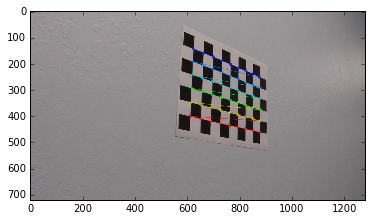

In [11]:
for fname in images:

    # Read in image
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    # Parameters: (image, chessboard dims, param for any flags)
    # chessboard dims = inside corners, not squares.
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)

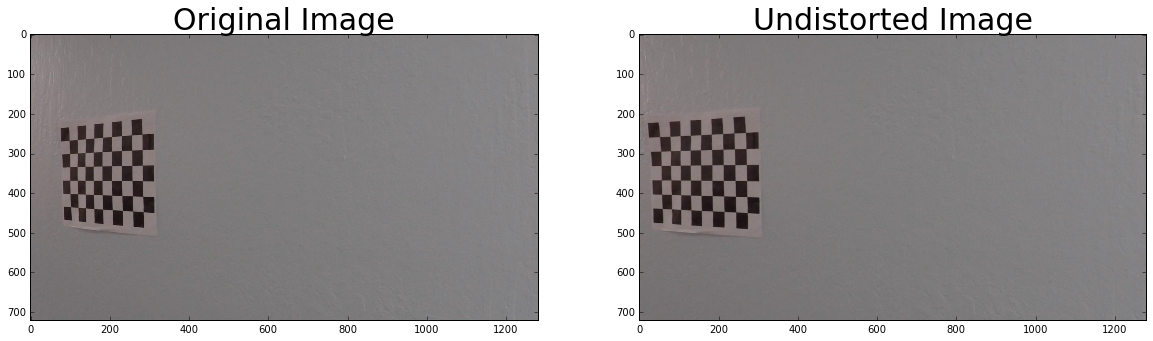

In [12]:
# Test undistortion on an image
img = cv2.imread('camera_cal/calibration11.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_calibration_result.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [13]:
with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

## II. Pipeline (Images)

## IIA. Initial runthrough of image pipeline

### II.2. Apply the distortion correction to the raw image.

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from helperfunctions import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

In [31]:
# Parameters
imshape = raw.shape

height = raw.shape[0]
offset = 50
offset_height = height - offset
half_frame = raw.shape[1] // 2
steps = 6
pixels_per_step = offset_height / steps
window_radius = 200
medianfilt_kernel_size = 51
horizontal_offset = 40

blank_canvas = np.zeros((720, 1280))

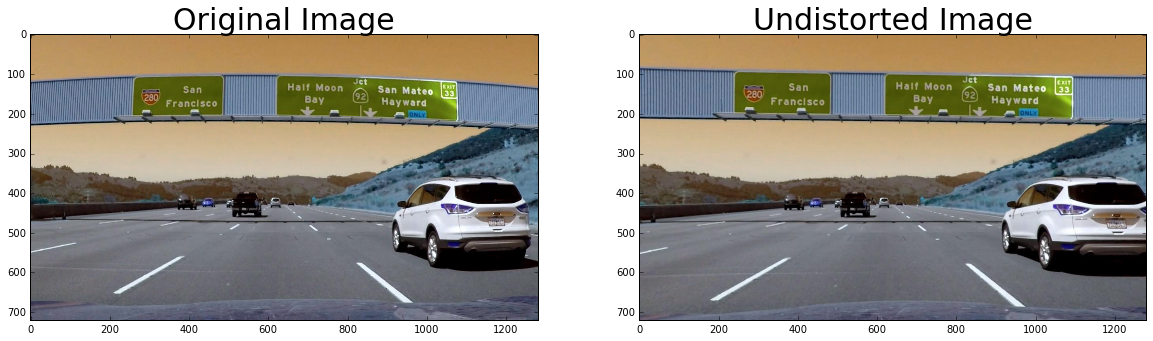

In [3]:
raw = cv2.imread("test_images/quiz.png")

image = cv2.undistort(raw, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(raw)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image)
ax2.set_title('Undistorted Image', fontsize=30)

### 3. Use color transforms, gradients, etc., to create a thresholded binary image.

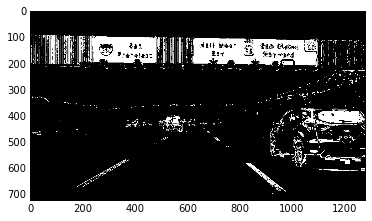

In [5]:
xgrad_thresh_temp = (40,100)
s_thresh_temp=(150,255)

combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
plt.imshow(combined_binary, cmap="gray")

### 4. Apply a perspective transform to rectify binary image ("birds-eye view").

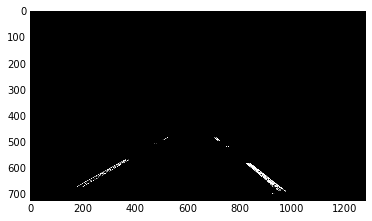

In [17]:
vertices = np.array([[(0,imshape[0]),(550, 470), (700, 470), (imshape[1],imshape[0])]], dtype=np.int32)
masked_image = region_of_interest(combined_binary, vertices)
plt.imshow(masked_image, cmap="gray")

In [28]:
src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

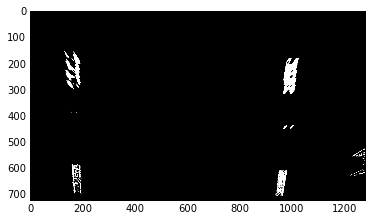

In [29]:
# Warp onto birds-eye-view
# Previous region-of-interest mask's function is absorbed by the warp
warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
plt.imshow(warped, cmap="gray")

### 5. Detect lane pixels and fit to find lane boundary.

In [45]:
from scipy import signal

Left coeffs: [  7.35820292e-06   2.17677738e-02   1.59436529e+02]
righty[0]: , 708.0 , rightx[0]:  905
Right coeffs:  [  5.50237214e-05  -1.35847207e-01   1.02168538e+03]


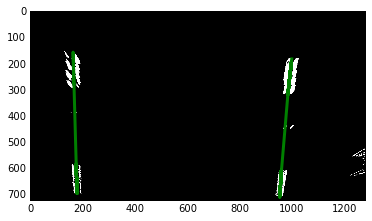

In [32]:
# Histogram and get pixels in window

leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=horizontal_offset)

# Fit a second order polynomial to each fake lane line
left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
print("Left coeffs:", left_coeffs)
print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
print("Right coeffs: ", right_coeffs)

# Plot data

plt.plot(left_fit, lefty, color='green', linewidth=3)
plt.plot(right_fit, righty, color='green', linewidth=3)
plt.imshow(warped, cmap="gray")

Left coeffs:  [  7.35820292e-06   2.17677738e-02   1.59436529e+02]
Right fit:  [  5.50237214e-05  -1.35847207e-01   1.02168538e+03]


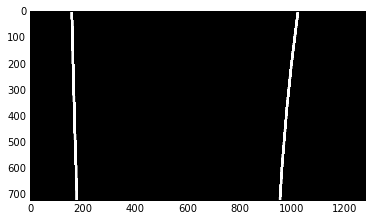

In [42]:
print("Left coeffs: ", left_coeffs)
print("Right fit: ", right_coeffs)
polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
plt.imshow(polyfit_drawn, cmap="gray")

Section reference: 
* https://github.com/pkern90/CarND-advancedLaneLines

### 6. Determine curvature of the lane and vehicle position with respect to center.

In [4]:
# Determine curvature of the lane
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = 500
left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                /(2 * left_coeffs[0]))
right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                 /(2 * right_coeffs[0]))
print("Left lane curve radius: ", left_curverad)
print("Right lane curve radius: ", right_curverad)
curvature = (left_curverad + right_curverad) / 2
centre = center(719, left_coeffs, right_coeffs)

NameError: name 'left_coeffs' is not defined

[Radius of Curvature formula from Wikipedia](https://en.wikipedia.org/wiki/Radius_of_curvature)


### 7. Warp the detected lane boundaries back onto the original image.

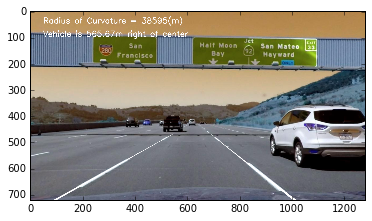

In [43]:
# Warp lane boundaries back onto original image
lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)

# Convert to colour
lane_line_colour = cv2.cvtColor(lane_lines.astype(np.uint8), cv2.COLOR_GRAY2RGB)
plt.imshow(combined_img)

Note that the xs are a function of the ys, not the other way round.

### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


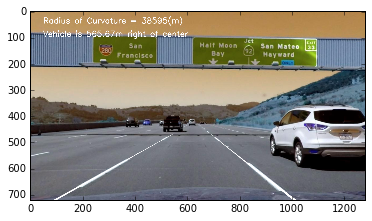

In [36]:
combined_img = cv2.add(lane_line_colour, image)
add_figures_to_image(combined_img, curvature=curvature, vehicle_position=centre)
plt.imshow(combined_img)

Further references:
* https://github.com/mohankarthik/CarND-AdvancedLaneLines-P4
* https://github.com/pkern90/CarND-advancedLaneLines

## IIB: Streamlined image pipeline

Left coeffs: [  1.39558272e-04  -2.15117466e-01   3.85597531e+02]
righty[0]: , 489.0 , rightx[0]:  1140
Right coeffs:  [  1.21529364e-04  -3.62144057e-01   1.30684284e+03]
Left lane curve radius:  3613.45833376
Right lane curve radius:  4476.64740357
Left coeffs:  [  1.39558272e-04  -2.15117466e-01   3.85597531e+02]
Right fit:  [  1.21529364e-04  -3.62144057e-01   1.30684284e+03]


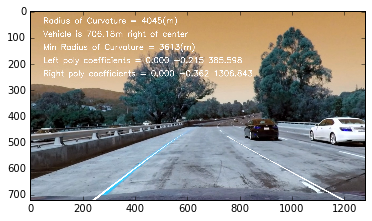

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

from helperfunctions import *

with open("camera_calibration_result.p", mode='rb') as f:
    camera_calib = pickle.load(f)
mtx = camera_calib["mtx"]
dist = camera_calib["dist"]

prev_left_coeffs = None
prev_right_coeffs = None

def image_pipeline(file, filepath=False):
    global prev_left_coeffs
    global prev_right_coeffs
    
    plt.clf()
    
    if filepath == True:
        # Read in image
        raw = cv2.imread(file)
    else:
        raw = file

    # Parameters
    imshape = raw.shape
    
    src = np.float32(
        [[120, 720],
         [550, 470],
         [700, 470],
         [1160, 720]])

    dst = np.float32(
        [[200,720],
         [200,0],
         [1080,0],
         [1080,720]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    height = raw.shape[0]
    offset = 50
    offset_height = height - offset
    half_frame = raw.shape[1] // 2
    steps = 6
    pixels_per_step = offset_height / steps
    window_radius = 200
    medianfilt_kernel_size = 51

    blank_canvas = np.zeros((720, 1280))

    # Apply distortion correction to raw image
    image = cv2.undistort(raw, mtx, dist, None, mtx)

    ## Option I
    combined = apply_thresholds(image)

    ## Option II

    have_fit = False
    curvature_checked = False
    
    xgrad_thresh_temp = (40,100)
    s_thresh_temp=(150,255)
    
    while have_fit == False:
        combined_binary = apply_threshold_v2(image, xgrad_thresh=xgrad_thresh_temp, s_thresh=s_thresh_temp)
    #    plt.imshow(combined_binary, cmap="gray")

        # Plotting thresholded images
        """
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Option 1')
        ax1.imshow(combined, cmap="gray")

        ax2.set_title('Option 2: Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        """

        # Warp onto birds-eye-view
        # Previous region-of-interest mask's function is absorbed by the warp
        warped = cv2.warpPerspective(combined_binary, M, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
        # plt.imshow(warped, cmap="gray")

        # Histogram and get pixels in window

        leftx, lefty, rightx, righty = histogram_pixels(warped, horizontal_offset=40)

        plt.imshow(warped, cmap="gray")

        if len(leftx) > 1 and len(rightx) > 1:
            have_fit = True
        xgrad_thresh_temp = (xgrad_thresh_temp[0] - 2, xgrad_thresh_temp[1] + 2)
        s_thresh_temp = (s_thresh_temp[0] - 2, s_thresh_temp[1] + 2)

    left_fit, left_coeffs = fit_second_order_poly(lefty, leftx, return_coeffs=True)
    print("Left coeffs:", left_coeffs)
    print("righty[0]: ,", righty[0], ", rightx[0]: ", rightx[0])
    right_fit, right_coeffs = fit_second_order_poly(righty, rightx, return_coeffs=True)
    print("Right coeffs: ", right_coeffs)

    # Plot data
    """
    plt.plot(left_fit, lefty, color='green', linewidth=3)
    plt.plot(right_fit, righty, color='green', linewidth=3)
    plt.imshow(warped, cmap="gray")
    """

    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_coeffs[0] * y_eval + left_coeffs[1])**2) ** 1.5) \
                    /(2 * left_coeffs[0]))
    right_curverad = np.absolute(((1 + (2 * right_coeffs[0] * y_eval + right_coeffs[1]) ** 2) ** 1.5) \
                     /(2 * right_coeffs[0]))
    print("Left lane curve radius: ", left_curverad)
    print("Right lane curve radius: ", right_curverad)
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)

    # TODO: if plausible parallel, continue. Else don't make `curvature_checked` = True
    if not plausible_curvature(left_curverad, right_curverad) or \
        not plausible_continuation_of_traces(left_coeffs, right_coeffs, prev_left_coeffs, prev_right_coeffs):
            if prev_left_coeffs is not None and prev_right_coeffs is not None:
                left_coeffs = prev_left_coeffs
                right_coeffs = prev_right_coeffs

    prev_left_coeffs = left_coeffs
    prev_right_coeffs = right_coeffs
    
    # Det vehicle position wrt centre
    centre = center(719, left_coeffs, right_coeffs)
        
    ## 7. Warp the detected lane boundaries back onto the original image.

    # plt.imshow(blank_canvas, cmap="gray")
    print("Left coeffs: ", left_coeffs)
    print("Right fit: ", right_coeffs)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_coeffs, 30)
#    plt.imshow(polyfit_left, cmap="gray")
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_coeffs, 30)
#    plt.imshow(polyfit_drawn, cmap="gray")
#    plt.imshow(warped)
    lane_lines = cv2.warpPerspective(polyfit_drawn, Minv, (imshape[1], imshape[0]), flags=cv2.INTER_LINEAR)
    # plt.imshow(lane_lines, cmap="gray")

    # Convert to colour
    lane_line_colour = cv2.cvtColor(lane_lines.astype(np.uint8), cv2.COLOR_GRAY2RGB)

    combined_img = cv2.add(lane_line_colour, image)
    add_figures_to_image(combined_img, curvature=curvature, 
                         vehicle_position=centre, 
                         min_curvature=min_curverad,
                         left_coeffs=left_coeffs,
                         right_coeffs=right_coeffs)
    plt.imshow(combined_img)
    return combined_img

combined_img = image_pipeline("test_images/test1.jpg", filepath=True)

## III. Video Pipeline


In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left coeffs: [ -1.45692752e-04   1.67327924e-01   2.94455494e+02]
righty[0]: , 587.0 , rightx[0]:  1114
Right coeffs:  [ -1.20883555e-04   1.29281675e-02   1.17134099e+03]
Left lane curve radius:  3434.28959487
Right lane curve radius:  4208.72957188
Left coeffs:  [ -1.45692752e-04   1.67327924e-01   2.94455494e+02]
Right fit:  [ -1.20883555e-04   1.29281675e-02   1.17134099e+03]
[MoviePy] >>>> Building video project_output_v3.mp4
[MoviePy] Writing video project_output_v3.mp4


  0%|          | 1/1261 [00:00<12:17,  1.71it/s]

Left coeffs: [ -1.45692752e-04   1.67327924e-01   2.94455494e+02]
righty[0]: , 587.0 , rightx[0]:  1114
Right coeffs:  [ -1.20883555e-04   1.29281675e-02   1.17134099e+03]
Left lane curve radius:  3434.28959487
Right lane curve radius:  4208.72957188
Left coeffs:  [ -1.45692752e-04   1.67327924e-01   2.94455494e+02]
Right fit:  [ -1.20883555e-04   1.29281675e-02   1.17134099e+03]


  0%|          | 2/1261 [00:01<12:12,  1.72it/s]

Left coeffs: [ -1.67165994e-04   1.86852300e-01   2.91429366e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -3.98825155e-05  -4.43478477e-02   1.17448075e+03]
Left lane curve radius:  2992.77789593
Right lane curve radius:  12670.4769335
Left coeffs:  [ -1.67165994e-04   1.86852300e-01   2.91429366e+02]
Right fit:  [ -3.98825155e-05  -4.43478477e-02   1.17448075e+03]


  0%|          | 3/1261 [00:01<12:33,  1.67it/s]

Left coeffs: [ -2.04774650e-04   2.15369324e-01   2.88076180e+02]
righty[0]: , 655.0 , rightx[0]:  1103
Right coeffs:  [ -1.47266819e-05  -6.00925164e-02   1.17272573e+03]
Left lane curve radius:  2442.11960568
Right lane curve radius:  34237.4682556
Left coeffs:  [ -2.04774650e-04   2.15369324e-01   2.88076180e+02]
Right fit:  [ -1.47266819e-05  -6.00925164e-02   1.17272573e+03]


  0%|          | 4/1261 [00:02<12:14,  1.71it/s]

Left coeffs: [ -2.30009640e-04   2.37783548e-01   2.84981955e+02]
righty[0]: , 686.0 , rightx[0]:  1099
Right coeffs:  [  4.44000459e-05  -1.12688007e-01   1.17918235e+03]
Left lane curve radius:  2174.01899086
Right lane curve radius:  11340.1123364
Left coeffs:  [ -2.30009640e-04   2.37783548e-01   2.84981955e+02]
Right fit:  [  4.44000459e-05  -1.12688007e-01   1.17918235e+03]


  0%|          | 5/1261 [00:02<12:07,  1.73it/s]

Left coeffs: [ -2.07252047e-04   2.27894405e-01   2.84745437e+02]
righty[0]: , 685.0 , rightx[0]:  1098
Right coeffs:  [  1.59777745e-05  -9.18933635e-02   1.17560288e+03]
Left lane curve radius:  2414.06355681
Right lane curve radius:  31564.3837064
Left coeffs:  [ -2.07252047e-04   2.27894405e-01   2.84745437e+02]
Right fit:  [  1.59777745e-05  -9.18933635e-02   1.17560288e+03]


  0%|          | 6/1261 [00:03<11:58,  1.75it/s]

Left coeffs: [ -1.93809437e-04   2.20106055e-01   2.86111104e+02]
righty[0]: , 680.0 , rightx[0]:  1098
Right coeffs:  [  1.08876220e-04  -1.84161584e-01   1.19409052e+03]
Left lane curve radius:  2582.53019334
Right lane curve radius:  4631.46987667
Left coeffs:  [ -1.93809437e-04   2.20106055e-01   2.86111104e+02]
Right fit:  [  1.08876220e-04  -1.84161584e-01   1.19409052e+03]


  1%|          | 7/1261 [00:04<11:45,  1.78it/s]

Left coeffs: [ -1.81342194e-04   2.17733283e-01   2.83516301e+02]
righty[0]: , 534.0 , rightx[0]:  1115
Right coeffs:  [  3.28221031e-04  -3.16643150e-01   1.21829064e+03]
Left lane curve radius:  2762.69714647
Right lane curve radius:  1523.67000312
Left coeffs:  [ -1.81342194e-04   2.17733283e-01   2.83516301e+02]
Right fit:  [  3.28221031e-04  -3.16643150e-01   1.21829064e+03]


  1%|          | 8/1261 [00:04<11:36,  1.80it/s]

Left coeffs: [ -1.82510132e-04   2.23500171e-01   2.82415455e+02]
righty[0]: , 406.0 , rightx[0]:  1115
Right coeffs:  [  6.01524551e-04  -5.10488723e-01   1.24905576e+03]
Left lane curve radius:  2746.48131066
Right lane curve radius:  841.57579467
Left coeffs:  [ -1.82510132e-04   2.23500171e-01   2.82415455e+02]
Right fit:  [  6.01524551e-04  -5.10488723e-01   1.24905576e+03]


  1%|          | 9/1261 [00:05<11:27,  1.82it/s]

Left coeffs: [ -1.62985869e-04   2.09085955e-01   2.82193929e+02]
righty[0]: , 371.0 , rightx[0]:  1118
Right coeffs:  [ -2.35603751e-04   9.91054880e-02   1.14313353e+03]
Left lane curve radius:  3077.53526385
Right lane curve radius:  2181.79344606
Left coeffs:  [ -1.62985869e-04   2.09085955e-01   2.82193929e+02]
Right fit:  [ -2.35603751e-04   9.91054880e-02   1.14313353e+03]


  1%|          | 10/1261 [00:05<11:13,  1.86it/s]

Left coeffs: [ -1.62901098e-04   2.13146745e-01   2.78649078e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -1.16490507e-04   3.04118692e-02   1.15192562e+03]
Left lane curve radius:  3080.97778671
Right lane curve radius:  4339.98824924
Left coeffs:  [ -1.62901098e-04   2.13146745e-01   2.78649078e+02]
Right fit:  [ -1.16490507e-04   3.04118692e-02   1.15192562e+03]


  1%|          | 11/1261 [00:06<11:04,  1.88it/s]

Left coeffs: [ -1.82135144e-04   2.34988398e-01   2.72451382e+02]
righty[0]: , 655.0 , rightx[0]:  1103
Right coeffs:  [  5.72684910e-05  -1.40829568e-01   1.19187479e+03]
Left lane curve radius:  2756.72531343
Right lane curve radius:  8822.40761529
Left coeffs:  [ -1.82135144e-04   2.34988398e-01   2.72451382e+02]
Right fit:  [  5.72684910e-05  -1.40829568e-01   1.19187479e+03]


  1%|          | 12/1261 [00:06<10:56,  1.90it/s]

Left coeffs: [ -1.76346306e-04   2.41112093e-01   2.62833229e+02]
righty[0]: , 549.0 , rightx[0]:  1117
Right coeffs:  [ -2.93044613e-04   1.89206292e-01   1.12173728e+03]
Left lane curve radius:  2853.18850537
Right lane curve radius:  1733.89488937
Left coeffs:  [ -1.76346306e-04   2.41112093e-01   2.62833229e+02]
Right fit:  [ -2.93044613e-04   1.89206292e-01   1.12173728e+03]


  1%|          | 13/1261 [00:07<10:46,  1.93it/s]

Left coeffs: [ -1.83419829e-04   2.48135175e-01   2.60970765e+02]
righty[0]: , 585.0 , rightx[0]:  1112
Right coeffs:  [ -2.57902241e-04   1.69728900e-01   1.12027832e+03]
Left lane curve radius:  2743.12949576
Right lane curve radius:  1961.37195444
Left coeffs:  [ -1.83419829e-04   2.48135175e-01   2.60970765e+02]
Right fit:  [ -2.57902241e-04   1.69728900e-01   1.12027832e+03]


  1%|          | 14/1261 [00:07<10:42,  1.94it/s]

Left coeffs: [ -2.00505504e-04   2.70417459e-01   2.54927675e+02]
righty[0]: , 601.0 , rightx[0]:  1109
Right coeffs:  [ -7.21652059e-05   2.67839511e-02   1.14089341e+03]
Left lane curve radius:  2512.00205425
Right lane curve radius:  6949.96130669
Left coeffs:  [ -2.00505504e-04   2.70417459e-01   2.54927675e+02]
Right fit:  [ -7.21652059e-05   2.67839511e-02   1.14089341e+03]


  1%|          | 15/1261 [00:08<10:41,  1.94it/s]

Left coeffs: [ -2.05426951e-04   2.70847507e-01   2.57129947e+02]
righty[0]: , 638.0 , rightx[0]:  1101
Right coeffs:  [  2.33890760e-06  -1.76198093e-02   1.13490235e+03]
Left lane curve radius:  2449.59737079
Right lane curve radius:  213849.893301
Left coeffs:  [ -2.05426951e-04   2.70847507e-01   2.57129947e+02]
Right fit:  [  2.33890760e-06  -1.76198093e-02   1.13490235e+03]


  1%|▏         | 16/1261 [00:08<10:34,  1.96it/s]

Left coeffs: [ -1.96962858e-04   2.64347595e-01   2.58226504e+02]
righty[0]: , 684.0 , rightx[0]:  1094
Right coeffs:  [  1.49507335e-04  -1.39969135e-01   1.14504951e+03]
Left lane curve radius:  2555.85949434
Right lane curve radius:  3344.77390798
Left coeffs:  [ -1.96962858e-04   2.64347595e-01   2.58226504e+02]
Right fit:  [  1.49507335e-04  -1.39969135e-01   1.14504951e+03]


  1%|▏         | 17/1261 [00:09<10:35,  1.96it/s]

Left coeffs: [ -1.70464233e-04   2.44897444e-01   2.59906733e+02]
righty[0]: , 701.0 , rightx[0]:  1091
Right coeffs:  [  1.10637748e-04  -1.21462442e-01   1.14392775e+03]
Left lane curve radius:  2957.57631026
Right lane curve radius:  4520.04756738
Left coeffs:  [ -1.70464233e-04   2.44897444e-01   2.59906733e+02]
Right fit:  [  1.10637748e-04  -1.21462442e-01   1.14392775e+03]


  1%|▏         | 18/1261 [00:09<10:32,  1.97it/s]

Left coeffs: [ -1.57900182e-04   2.36891467e-01   2.60037347e+02]
righty[0]: , 697.0 , rightx[0]:  1090
Right coeffs:  [  1.24938692e-04  -1.38473078e-01   1.14522943e+03]
Left lane curve radius:  3196.2408311
Right lane curve radius:  4003.06247114
Left coeffs:  [ -1.57900182e-04   2.36891467e-01   2.60037347e+02]
Right fit:  [  1.24938692e-04  -1.38473078e-01   1.14522943e+03]


  2%|▏         | 19/1261 [00:10<10:41,  1.94it/s]

Left coeffs: [ -1.28685263e-04   2.16025303e-01   2.59485098e+02]
righty[0]: , 517.0 , rightx[0]:  1094
Right coeffs:  [  2.17155497e-04  -2.10262074e-01   1.16571281e+03]
Left lane curve radius:  3929.99243083
Right lane curve radius:  2302.66167607
Left coeffs:  [ -1.28685263e-04   2.16025303e-01   2.59485098e+02]
Right fit:  [  2.17155497e-04  -2.10262074e-01   1.16571281e+03]


  2%|▏         | 20/1261 [00:10<11:03,  1.87it/s]

Left coeffs: [ -1.23160675e-04   2.16937994e-01   2.55341600e+02]
righty[0]: , 544.0 , rightx[0]:  1096
Right coeffs:  [  2.39825928e-04  -2.46893279e-01   1.18085309e+03]
Left lane curve radius:  4113.40809281
Right lane curve radius:  2085.00167482
Left coeffs:  [ -1.23160675e-04   2.16937994e-01   2.55341600e+02]
Right fit:  [  2.39825928e-04  -2.46893279e-01   1.18085309e+03]


  2%|▏         | 21/1261 [00:11<10:57,  1.88it/s]

Left coeffs: [ -8.74643924e-05   1.91099520e-01   2.55240838e+02]
righty[0]: , 330.0 , rightx[0]:  1100
Right coeffs:  [  4.52966408e-04  -4.37883899e-01   1.22939793e+03]
Left lane curve radius:  5808.95557496
Right lane curve radius:  1104.21128844
Left coeffs:  [ -8.74643924e-05   1.91099520e-01   2.55240838e+02]
Right fit:  [  4.52966408e-04  -4.37883899e-01   1.22939793e+03]


  2%|▏         | 22/1261 [00:11<10:46,  1.92it/s]

Left coeffs: [ -7.07939908e-05   1.80342720e-01   2.52480432e+02]
righty[0]: , 607.0 , rightx[0]:  1096
Right coeffs:  [ -3.62882700e-05  -6.78220266e-02   1.16707632e+03]
Left lane curve radius:  7190.26625736
Right lane curve radius:  14003.1807628
Left coeffs:  [ -7.07939908e-05   1.80342720e-01   2.52480432e+02]
Right fit:  [ -3.62882700e-05  -6.78220266e-02   1.16707632e+03]


  2%|▏         | 23/1261 [00:12<10:28,  1.97it/s]

Left coeffs: [ -6.43899223e-05   1.76359203e-01   2.49010313e+02]
righty[0]: , 638.0 , rightx[0]:  1095
Right coeffs:  [ -1.74915445e-05  -9.17555495e-02   1.17798740e+03]
Left lane curve radius:  7911.67672223
Right lane curve radius:  29098.5082009
Left coeffs:  [ -6.43899223e-05   1.76359203e-01   2.49010313e+02]
Right fit:  [ -1.74915445e-05  -9.17555495e-02   1.17798740e+03]


  2%|▏         | 24/1261 [00:12<10:33,  1.95it/s]

Left coeffs: [ -5.29959681e-05   1.53883404e-01   2.57368546e+02]
righty[0]: , 532.0 , rightx[0]:  1101
Right coeffs:  [ -7.87253850e-05  -4.60321987e-02   1.16848262e+03]
Left lane curve radius:  9579.08905672
Right lane curve radius:  6500.04628386
Left coeffs:  [ -5.29959681e-05   1.53883404e-01   2.57368546e+02]
Right fit:  [ -7.87253850e-05  -4.60321987e-02   1.16848262e+03]


  2%|▏         | 25/1261 [00:13<10:33,  1.95it/s]

Left coeffs: [ -7.78370270e-05   1.68149701e-01   2.56259401e+02]
righty[0]: , 559.0 , rightx[0]:  1099
Right coeffs:  [ -5.66914911e-05  -4.90318925e-02   1.16427612e+03]
Left lane curve radius:  6502.4289953
Right lane curve radius:  8967.94999157
Left coeffs:  [ -7.78370270e-05   1.68149701e-01   2.56259401e+02]
Right fit:  [ -5.66914911e-05  -4.90318925e-02   1.16427612e+03]


  2%|▏         | 26/1261 [00:13<10:32,  1.95it/s]

Left coeffs: [ -8.13825258e-05   1.68676033e-01   2.54090847e+02]
righty[0]: , 580.0 , rightx[0]:  1100
Right coeffs:  [ -8.01961172e-05  -4.89735391e-02   1.17609953e+03]
Left lane curve radius:  6214.18401576
Right lane curve radius:  6391.40235469
Left coeffs:  [ -8.13825258e-05   1.68676033e-01   2.54090847e+02]
Right fit:  [ -8.01961172e-05  -4.89735391e-02   1.17609953e+03]


  2%|▏         | 27/1261 [00:14<10:23,  1.98it/s]

Left coeffs: [ -8.66627177e-05   1.69261301e-01   2.54795977e+02]
righty[0]: , 623.0 , rightx[0]:  1098
Right coeffs:  [ -4.45571399e-05  -3.21164328e-02   1.15742875e+03]
Left lane curve radius:  5828.63802786
Right lane curve radius:  11320.6458662
Left coeffs:  [ -8.66627177e-05   1.69261301e-01   2.54795977e+02]
Right fit:  [ -4.45571399e-05  -3.21164328e-02   1.15742875e+03]


  2%|▏         | 28/1261 [00:14<10:21,  1.98it/s]

Left coeffs: [ -8.10092422e-05   1.61246455e-01   2.53382012e+02]
righty[0]: , 657.0 , rightx[0]:  1098
Right coeffs:  [ -6.52482637e-05  -3.43847398e-02   1.16930364e+03]
Left lane curve radius:  6231.8354977
Right lane curve radius:  7777.42530727
Left coeffs:  [ -8.10092422e-05   1.61246455e-01   2.53382012e+02]
Right fit:  [ -6.52482637e-05  -3.43847398e-02   1.16930364e+03]


  2%|▏         | 29/1261 [00:15<10:19,  1.99it/s]

Left coeffs: [ -1.11600581e-04   1.82845576e-01   2.52126110e+02]
righty[0]: , 690.0 , rightx[0]:  1093
Right coeffs:  [ -8.29666740e-05  -1.70595378e-02   1.16280934e+03]
Left lane curve radius:  4514.41838383
Right lane curve radius:  6117.18713303
Left coeffs:  [ -1.11600581e-04   1.82845576e-01   2.52126110e+02]
Right fit:  [ -8.29666740e-05  -1.70595378e-02   1.16280934e+03]


  2%|▏         | 30/1261 [00:15<10:25,  1.97it/s]

Left coeffs: [ -1.30836997e-04   1.89210161e-01   2.56764266e+02]
righty[0]: , 702.0 , rightx[0]:  1090
Right coeffs:  [  2.31497698e-05  -1.01541857e-01   1.16971760e+03]
Left lane curve radius:  3841.09812982
Right lane curve radius:  21797.8868612
Left coeffs:  [ -1.30836997e-04   1.89210161e-01   2.56764266e+02]
Right fit:  [  2.31497698e-05  -1.01541857e-01   1.16971760e+03]


  2%|▏         | 31/1261 [00:16<10:21,  1.98it/s]

Left coeffs: [ -1.41549436e-04   1.92029712e-01   2.60573077e+02]
righty[0]: , 707.0 , rightx[0]:  1090
Right coeffs:  [ -1.66866255e-05  -5.94559141e-02   1.15815718e+03]
Left lane curve radius:  3545.84537114
Right lane curve radius:  30225.0781903
Left coeffs:  [ -1.41549436e-04   1.92029712e-01   2.60573077e+02]
Right fit:  [ -1.66866255e-05  -5.94559141e-02   1.15815718e+03]


  3%|▎         | 32/1261 [00:16<10:21,  1.98it/s]

Left coeffs: [ -1.57088549e-04   1.94880443e-01   2.66668496e+02]
righty[0]: , 526.0 , rightx[0]:  1106
Right coeffs:  [  1.50523440e-04  -1.63896774e-01   1.16938445e+03]
Left lane curve radius:  3189.73952864
Right lane curve radius:  3322.63293465
Left coeffs:  [ -1.57088549e-04   1.94880443e-01   2.66668496e+02]
Right fit:  [  1.50523440e-04  -1.63896774e-01   1.16938445e+03]


  3%|▎         | 33/1261 [00:17<10:20,  1.98it/s]

Left coeffs: [ -1.38293763e-04   1.81054524e-01   2.67267920e+02]
righty[0]: , 308.0 , rightx[0]:  1110
Right coeffs:  [  4.33433760e-04  -3.50503352e-01   1.20729273e+03]
Left lane curve radius:  3625.4128623
Right lane curve radius:  1165.49977079
Left coeffs:  [ -1.38293763e-04   1.81054524e-01   2.67267920e+02]
Right fit:  [  4.33433760e-04  -3.50503352e-01   1.20729273e+03]


  3%|▎         | 34/1261 [00:17<10:18,  1.98it/s]

Left coeffs: [ -1.49688447e-04   1.88699256e-01   2.67948365e+02]
righty[0]: , 331.0 , rightx[0]:  1107
Right coeffs:  [ -5.82069451e-05   1.11407075e-04   1.14225568e+03]
Left lane curve radius:  3347.89909125
Right lane curve radius:  8633.56515427
Left coeffs:  [ -1.49688447e-04   1.88699256e-01   2.67948365e+02]
Right fit:  [ -5.82069451e-05   1.11407075e-04   1.14225568e+03]


  3%|▎         | 35/1261 [00:18<10:11,  2.01it/s]

Left coeffs: [ -1.71921813e-04   2.06130539e-01   2.67253267e+02]
righty[0]: , 623.0 , rightx[0]:  1101
Right coeffs:  [ -6.28594133e-05  -5.97562331e-03   1.14573492e+03]
Left lane curve radius:  2913.40538158
Right lane curve radius:  8010.85909794
Left coeffs:  [ -1.71921813e-04   2.06130539e-01   2.67253267e+02]
Right fit:  [ -6.28594133e-05  -5.97562331e-03   1.14573492e+03]


  3%|▎         | 36/1261 [00:18<10:03,  2.03it/s]

Left coeffs: [ -1.67107123e-04   1.99365051e-01   2.72469192e+02]
righty[0]: , 673.0 , rightx[0]:  1086
Right coeffs:  [ -2.11678085e-04   1.40420084e-01   1.10816358e+03]
Left lane curve radius:  2996.76413651
Right lane curve radius:  2380.09100947
Left coeffs:  [ -1.67107123e-04   1.99365051e-01   2.72469192e+02]
Right fit:  [ -2.11678085e-04   1.40420084e-01   1.10816358e+03]


  3%|▎         | 37/1261 [00:19<10:15,  1.99it/s]

Left coeffs: [ -1.74556873e-04   2.05931410e-01   2.71996569e+02]
righty[0]: , 534.0 , rightx[0]:  1100
Right coeffs:  [ -1.70090892e-04   9.35132612e-02   1.11879365e+03]
Left lane curve radius:  2868.62639222
Right lane curve radius:  2965.50000375
Left coeffs:  [ -1.74556873e-04   2.05931410e-01   2.71996569e+02]
Right fit:  [ -1.70090892e-04   9.35132612e-02   1.11879365e+03]


  3%|▎         | 38/1261 [00:19<10:17,  1.98it/s]

Left coeffs: [ -1.86642102e-04   2.12758257e-01   2.73964095e+02]
righty[0]: , 563.0 , rightx[0]:  1098
Right coeffs:  [ -2.13771628e-04   1.55489279e-01   1.09805434e+03]
Left lane curve radius:  2681.66518927
Right lane curve radius:  2350.87224274
Left coeffs:  [ -1.86642102e-04   2.12758257e-01   2.73964095e+02]
Right fit:  [ -2.13771628e-04   1.55489279e-01   1.09805434e+03]


  3%|▎         | 39/1261 [00:20<10:26,  1.95it/s]

Left coeffs: [ -1.99066456e-04   2.25908174e-01   2.72265981e+02]
righty[0]: , 596.0 , rightx[0]:  1093
Right coeffs:  [ -1.09996721e-04   8.90293746e-02   1.09899818e+03]
Left lane curve radius:  2514.43896948
Right lane curve radius:  4548.58793139
Left coeffs:  [ -1.99066456e-04   2.25908174e-01   2.72265981e+02]
Right fit:  [ -1.09996721e-04   8.90293746e-02   1.09899818e+03]


  3%|▎         | 40/1261 [00:20<10:24,  1.96it/s]

Left coeffs: [ -2.15785155e-04   2.44978941e-01   2.66798893e+02]
righty[0]: , 639.0 , rightx[0]:  1091
Right coeffs:  [ -5.84530412e-05   3.81445777e-02   1.11148881e+03]
Left lane curve radius:  2320.08241999
Right lane curve radius:  8559.16726942
Left coeffs:  [ -2.15785155e-04   2.44978941e-01   2.66798893e+02]
Right fit:  [ -5.84530412e-05   3.81445777e-02   1.11148881e+03]


  3%|▎         | 41/1261 [00:21<10:18,  1.97it/s]

Left coeffs: [ -2.26104217e-04   2.54230373e-01   2.65557781e+02]
righty[0]: , 668.0 , rightx[0]:  1089
Right coeffs:  [  3.26040103e-05  -3.97611614e-02   1.12280180e+03]
Left lane curve radius:  2213.99421046
Right lane curve radius:  15336.7151398
Left coeffs:  [ -2.26104217e-04   2.54230373e-01   2.65557781e+02]
Right fit:  [  3.26040103e-05  -3.97611614e-02   1.12280180e+03]


  3%|▎         | 42/1261 [00:21<10:12,  1.99it/s]

Left coeffs: [ -2.27782132e-04   2.57651734e-01   2.65479670e+02]
righty[0]: , 702.0 , rightx[0]:  1085
Right coeffs:  [  1.81108640e-05  -4.45122014e-02   1.12972771e+03]
Left lane curve radius:  2198.01830237
Right lane curve radius:  27636.6087851
Left coeffs:  [ -2.27782132e-04   2.57651734e-01   2.65479670e+02]
Right fit:  [  1.81108640e-05  -4.45122014e-02   1.12972771e+03]


  3%|▎         | 43/1261 [00:22<10:14,  1.98it/s]

Left coeffs: [ -2.12216304e-04   2.53617588e-01   2.63247271e+02]
righty[0]: , 707.0 , rightx[0]:  1088
Right coeffs:  [  2.85819992e-05  -6.66963054e-02   1.14048213e+03]
Left lane curve radius:  2362.14697174
Right lane curve radius:  17531.6610166
Left coeffs:  [ -2.12216304e-04   2.53617588e-01   2.63247271e+02]
Right fit:  [  2.85819992e-05  -6.66963054e-02   1.14048213e+03]


  3%|▎         | 44/1261 [00:22<10:09,  2.00it/s]

Left coeffs: [ -2.32172370e-04   2.80077390e-01   2.53569006e+02]
righty[0]: , 702.0 , rightx[0]:  1090
Right coeffs:  [  1.75131571e-05  -7.28777100e-02   1.15010958e+03]
Left lane curve radius:  2160.98993459
Right lane curve radius:  28681.3327438
Left coeffs:  [ -2.32172370e-04   2.80077390e-01   2.53569006e+02]
Right fit:  [  1.75131571e-05  -7.28777100e-02   1.15010958e+03]


  4%|▎         | 45/1261 [00:23<10:10,  1.99it/s]

Left coeffs: [ -2.20546697e-04   2.75348895e-01   2.52078924e+02]
righty[0]: , 534.0 , rightx[0]:  1106
Right coeffs:  [  2.92903357e-04  -2.61147589e-01   1.18757518e+03]
Left lane curve radius:  2277.31432089
Right lane curve radius:  1709.6304992
Left coeffs:  [ -2.20546697e-04   2.75348895e-01   2.52078924e+02]
Right fit:  [  2.92903357e-04  -2.61147589e-01   1.18757518e+03]


  4%|▎         | 46/1261 [00:23<10:04,  2.01it/s]

Left coeffs: [ -2.26276840e-04   2.84177623e-01   2.48417729e+02]
righty[0]: , 309.0 , rightx[0]:  1106
Right coeffs:  [  7.49612417e-04  -5.78259827e-01   1.24330993e+03]
Left lane curve radius:  2220.8038644
Right lane curve radius:  696.602849618
Left coeffs:  [ -2.26276840e-04   2.84177623e-01   2.48417729e+02]
Right fit:  [  7.49612417e-04  -5.78259827e-01   1.24330993e+03]


  4%|▎         | 47/1261 [00:24<09:57,  2.03it/s]

Left coeffs: [ -2.27314039e-04   2.89617310e-01   2.44577104e+02]
righty[0]: , 706.0 , rightx[0]:  1079
Right coeffs:  [ -1.97182858e-04   9.73044928e-02   1.12866675e+03]
Left lane curve radius:  2212.41986542
Right lane curve radius:  2573.75513261
Left coeffs:  [ -2.27314039e-04   2.89617310e-01   2.44577104e+02]
Right fit:  [ -1.97182858e-04   9.73044928e-02   1.12866675e+03]


  4%|▍         | 48/1261 [00:24<09:59,  2.02it/s]

Left coeffs: [ -2.30055705e-04   2.94734722e-01   2.42791738e+02]
righty[0]: , 674.0 , rightx[0]:  1078
Right coeffs:  [ -1.33241057e-04   5.71311641e-02   1.13128905e+03]
Left lane curve radius:  2187.03905233
Right lane curve radius:  3785.25083166
Left coeffs:  [ -2.30055705e-04   2.94734722e-01   2.42791738e+02]
Right fit:  [ -1.33241057e-04   5.71311641e-02   1.13128905e+03]


  4%|▍         | 49/1261 [00:25<10:00,  2.02it/s]

Left coeffs: [ -2.12651397e-04   2.86750320e-01   2.39508977e+02]
righty[0]: , 518.0 , rightx[0]:  1107
Right coeffs:  [ -1.04232706e-04   3.01445195e-02   1.14116224e+03]
Left lane curve radius:  2370.65752499
Right lane curve radius:  4836.50916578
Left coeffs:  [ -2.12651397e-04   2.86750320e-01   2.39508977e+02]
Right fit:  [ -1.04232706e-04   3.01445195e-02   1.14116224e+03]


  4%|▍         | 50/1261 [00:25<10:07,  1.99it/s]

Left coeffs: [ -2.25969940e-04   3.05131454e-01   2.33433302e+02]
righty[0]: , 554.0 , rightx[0]:  1105
Right coeffs:  [ -1.80042080e-04   9.15748078e-02   1.12855285e+03]
Left lane curve radius:  2233.51506351
Right lane curve radius:  2809.79486843
Left coeffs:  [ -2.25969940e-04   3.05131454e-01   2.33433302e+02]
Right fit:  [ -1.80042080e-04   9.15748078e-02   1.12855285e+03]


  4%|▍         | 51/1261 [00:26<10:22,  1.94it/s]

Left coeffs: [ -2.34757485e-04   3.19293094e-01   2.27900007e+02]
righty[0]: , 591.0 , rightx[0]:  1101
Right coeffs:  [ -1.96452884e-04   1.24219498e-01   1.11617180e+03]
Left lane curve radius:  2152.72908275
Right lane curve radius:  2565.08499713
Left coeffs:  [ -2.34757485e-04   3.19293094e-01   2.27900007e+02]
Right fit:  [ -1.96452884e-04   1.24219498e-01   1.11617180e+03]


  4%|▍         | 52/1261 [00:26<10:27,  1.93it/s]

Left coeffs: [ -2.27561496e-04   3.16336309e-01   2.28120553e+02]
righty[0]: , 623.0 , rightx[0]:  1096
Right coeffs:  [ -1.14578261e-04   8.22164424e-02   1.10991016e+03]
Left lane curve radius:  2223.23356746
Right lane curve radius:  4370.68662181
Left coeffs:  [ -2.27561496e-04   3.16336309e-01   2.28120553e+02]
Right fit:  [ -1.14578261e-04   8.22164424e-02   1.10991016e+03]


  4%|▍         | 53/1261 [00:27<10:46,  1.87it/s]

Left coeffs: [ -2.26626479e-04   3.13889832e-01   2.29137070e+02]
righty[0]: , 656.0 , rightx[0]:  1092
Right coeffs:  [ -7.91300340e-05   5.24225567e-02   1.11220793e+03]
Left lane curve radius:  2231.52224542
Right lane curve radius:  6325.4751319
Left coeffs:  [ -2.26626479e-04   3.13889832e-01   2.29137070e+02]
Right fit:  [ -7.91300340e-05   5.24225567e-02   1.11220793e+03]


  4%|▍         | 54/1261 [00:28<11:03,  1.82it/s]

Left coeffs: [ -2.17472005e-04   3.09384075e-01   2.27615275e+02]
righty[0]: , 683.0 , rightx[0]:  1064
Right coeffs:  [ -5.07323702e-05   2.70590336e-02   1.11355205e+03]
Left lane curve radius:  2328.34213817
Right lane curve radius:  9863.92665932
Left coeffs:  [ -2.17472005e-04   3.09384075e-01   2.27615275e+02]
Right fit:  [ -5.07323702e-05   2.70590336e-02   1.11355205e+03]


  4%|▍         | 55/1261 [00:28<10:46,  1.86it/s]

Left coeffs: [ -1.90389207e-04   2.93806050e-01   2.26584673e+02]
righty[0]: , 704.0 , rightx[0]:  1088
Right coeffs:  [ -3.91730104e-05   7.20800348e-03   1.12053233e+03]
Left lane curve radius:  2668.44270469
Right lane curve radius:  12783.457582
Left coeffs:  [ -1.90389207e-04   2.93806050e-01   2.26584673e+02]
Right fit:  [ -3.91730104e-05   7.20800348e-03   1.12053233e+03]


  4%|▍         | 56/1261 [00:29<10:43,  1.87it/s]

Left coeffs: [ -1.54769428e-04   2.66229991e-01   2.28846727e+02]
righty[0]: , 647.0 , rightx[0]:  1068
Right coeffs:  [ -6.03674844e-05   1.71859520e-02   1.12302982e+03]
Left lane curve radius:  3291.00184293
Right lane curve radius:  8305.78150555
Left coeffs:  [ -1.54769428e-04   2.66229991e-01   2.28846727e+02]
Right fit:  [ -6.03674844e-05   1.71859520e-02   1.12302982e+03]


  5%|▍         | 57/1261 [00:29<10:41,  1.88it/s]

Left coeffs: [ -1.25022902e-04   2.42370044e-01   2.31702883e+02]
righty[0]: , 518.0 , rightx[0]:  1100
Right coeffs:  [  1.92924228e-04  -1.70276304e-01   1.15603581e+03]
Left lane curve radius:  4082.15797578
Right lane curve radius:  2593.68536397
Left coeffs:  [ -1.25022902e-04   2.42370044e-01   2.31702883e+02]
Right fit:  [  1.92924228e-04  -1.70276304e-01   1.15603581e+03]


  5%|▍         | 58/1261 [00:30<10:34,  1.90it/s]

Left coeffs: [ -1.13676893e-04   2.30302330e-01   2.33472032e+02]
righty[0]: , 308.0 , rightx[0]:  1095
Right coeffs:  [  6.11763434e-04  -4.39852698e-01   1.20079538e+03]
Left lane curve radius:  4488.47356776
Right lane curve radius:  853.807061775
Left coeffs:  [ -1.13676893e-04   2.30302330e-01   2.33472032e+02]
Right fit:  [  6.11763434e-04  -4.39852698e-01   1.20079538e+03]


  5%|▍         | 59/1261 [00:30<10:27,  1.91it/s]

Left coeffs: [ -8.01115210e-05   1.91320138e-01   2.45384608e+02]
righty[0]: , 338.0 , rightx[0]:  1086
Right coeffs:  [ -1.63028159e-04   1.01341164e-01   1.09978269e+03]
Left lane curve radius:  6357.43936183
Right lane curve radius:  3084.47743969
Left coeffs:  [ -8.01115210e-05   1.91320138e-01   2.45384608e+02]
Right fit:  [ -1.63028159e-04   1.01341164e-01   1.09978269e+03]


  5%|▍         | 60/1261 [00:31<10:26,  1.92it/s]

Left coeffs: [ -6.36817440e-05   1.67250234e-01   2.53711740e+02]
righty[0]: , 623.0 , rightx[0]:  1086
Right coeffs:  [ -8.16689784e-05   5.81827868e-02   1.09738556e+03]
Left lane curve radius:  7978.21050554
Right lane curve radius:  6127.34195976
Left coeffs:  [ -6.36817440e-05   1.67250234e-01   2.53711740e+02]
Right fit:  [ -8.16689784e-05   5.81827868e-02   1.09738556e+03]


  5%|▍         | 61/1261 [00:31<10:21,  1.93it/s]

Left coeffs: [ -6.25715393e-05   1.59159953e-01   2.56938977e+02]
righty[0]: , 653.0 , rightx[0]:  1083
Right coeffs:  [ -9.59132885e-05   7.12616286e-02   1.09251837e+03]
Left lane curve radius:  8102.93771416
Right lane curve radius:  5217.79469024
Left coeffs:  [ -6.25715393e-05   1.59159953e-01   2.56938977e+02]
Right fit:  [ -9.59132885e-05   7.12616286e-02   1.09251837e+03]


  5%|▍         | 62/1261 [00:32<10:14,  1.95it/s]

Left coeffs: [ -5.56462232e-05   1.41410253e-01   2.64271189e+02]
righty[0]: , 444.0 , rightx[0]:  1077
Right coeffs:  [ -8.23923038e-05   6.69223660e-02   1.08855405e+03]
Left lane curve radius:  9084.65488995
Right lane curve radius:  6070.70656732
Left coeffs:  [ -5.56462232e-05   1.41410253e-01   2.64271189e+02]
Right fit:  [ -8.23923038e-05   6.69223660e-02   1.08855405e+03]


  5%|▍         | 63/1261 [00:32<10:05,  1.98it/s]

Left coeffs: [ -6.20151218e-05   1.43634712e-01   2.63008464e+02]
righty[0]: , 481.0 , rightx[0]:  1081
Right coeffs:  [ -1.41211628e-04   1.50065789e-01   1.06264869e+03]
Left lane curve radius:  8143.2498282
Right lane curve radius:  3541.20128173
Left coeffs:  [ -6.20151218e-05   1.43634712e-01   2.63008464e+02]
Right fit:  [ -1.41211628e-04   1.50065789e-01   1.06264869e+03]


  5%|▌         | 64/1261 [00:33<09:58,  2.00it/s]

Left coeffs: [ -7.79680671e-05   1.47239076e-01   2.66117653e+02]
righty[0]: , 616.0 , rightx[0]:  1078
Right coeffs:  [  4.30100359e-06   4.18578594e-02   1.07391156e+03]
Left lane curve radius:  6459.09520587
Right lane curve radius:  116623.671947
Left coeffs:  [ -7.79680671e-05   1.47239076e-01   2.66117653e+02]
Right fit:  [  4.30100359e-06   4.18578594e-02   1.07391156e+03]


  5%|▌         | 65/1261 [00:33<10:04,  1.98it/s]

Left coeffs: [ -1.05315811e-04   1.68463157e-01   2.61021942e+02]
righty[0]: , 645.0 , rightx[0]:  1078
Right coeffs:  [  8.97556781e-05  -4.48256247e-02   1.09398583e+03]
Left lane curve radius:  4776.05086925
Right lane curve radius:  5587.55509216
Left coeffs:  [ -1.05315811e-04   1.68463157e-01   2.61021942e+02]
Right fit:  [  8.97556781e-05  -4.48256247e-02   1.09398583e+03]


  5%|▌         | 66/1261 [00:34<10:03,  1.98it/s]

Left coeffs: [ -1.31565213e-04   1.82619481e-01   2.61459088e+02]
righty[0]: , 679.0 , rightx[0]:  1075
Right coeffs:  [  4.37404088e-05  -2.12395863e-02   1.09136835e+03]
Left lane curve radius:  3815.26518213
Right lane curve radius:  11439.7596477
Left coeffs:  [ -1.31565213e-04   1.82619481e-01   2.61459088e+02]
Right fit:  [  4.37404088e-05  -2.12395863e-02   1.09136835e+03]


  5%|▌         | 67/1261 [00:34<09:59,  1.99it/s]

Left coeffs: [ -1.38517628e-04   1.87322338e-01   2.60120424e+02]
righty[0]: , 703.0 , rightx[0]:  1072
Right coeffs:  [  4.13337900e-05  -3.42664331e-02   1.09595857e+03]
Left lane curve radius:  3622.55328461
Right lane curve radius:  12097.546864
Left coeffs:  [ -1.38517628e-04   1.87322338e-01   2.60120424e+02]
Right fit:  [  4.13337900e-05  -3.42664331e-02   1.09595857e+03]


  5%|▌         | 68/1261 [00:35<10:07,  1.96it/s]

Left coeffs: [ -1.60542872e-04   2.07984790e-01   2.54032813e+02]
righty[0]: , 701.0 , rightx[0]:  1072
Right coeffs:  [  1.20074067e-04  -1.25368962e-01   1.11991381e+03]
Left lane curve radius:  3124.95344005
Right lane curve radius:  4164.27158489
Left coeffs:  [ -1.60542872e-04   2.07984790e-01   2.54032813e+02]
Right fit:  [  1.20074067e-04  -1.25368962e-01   1.11991381e+03]


  5%|▌         | 69/1261 [00:35<10:08,  1.96it/s]

Left coeffs: [ -1.82506016e-04   2.22219482e-01   2.53975164e+02]
righty[0]: , 512.0 , rightx[0]:  1079
Right coeffs:  [  4.51685984e-04  -3.46826307e-01   1.15450764e+03]
Left lane curve radius:  2746.1195386
Right lane curve radius:  1125.2713377
Left coeffs:  [ -1.82506016e-04   2.22219482e-01   2.53975164e+02]
Right fit:  [  4.51685984e-04  -3.46826307e-01   1.15450764e+03]


  6%|▌         | 70/1261 [00:36<10:09,  1.95it/s]

Left coeffs: [ -2.00545590e-04   2.43145029e-01   2.45942121e+02]
righty[0]: , 542.0 , rightx[0]:  1081
Right coeffs:  [  2.77031968e-04  -2.44323002e-01   1.14761170e+03]
Left lane curve radius:  2499.98841415
Right lane curve radius:  1807.74307818
Left coeffs:  [ -2.00545590e-04   2.43145029e-01   2.45942121e+02]
Right fit:  [  2.77031968e-04  -2.44323002e-01   1.14761170e+03]


  6%|▌         | 71/1261 [00:36<10:20,  1.92it/s]

Left coeffs: [ -2.07037965e-04   2.49153388e-01   2.44956347e+02]
righty[0]: , 352.0 , rightx[0]:  1070
Right coeffs:  [ -9.79550305e-05   2.00822732e-02   1.10116678e+03]
Left lane curve radius:  2421.44416294
Right lane curve radius:  5150.88413748
Left coeffs:  [ -2.07037965e-04   2.49153388e-01   2.44956347e+02]
Right fit:  [ -9.79550305e-05   2.00822732e-02   1.10116678e+03]


  6%|▌         | 72/1261 [00:37<10:19,  1.92it/s]

Left coeffs: [ -2.09602074e-04   2.58302875e-01   2.39224815e+02]
righty[0]: , 606.0 , rightx[0]:  1076
Right coeffs:  [  4.75744290e-06  -4.93308249e-02   1.11595566e+03]
Left lane curve radius:  2393.96429336
Right lane curve radius:  105411.84409
Left coeffs:  [ -2.09602074e-04   2.58302875e-01   2.39224815e+02]
Right fit:  [  4.75744290e-06  -4.93308249e-02   1.11595566e+03]


  6%|▌         | 73/1261 [00:37<10:12,  1.94it/s]

Left coeffs: [ -2.05074816e-04   2.60196551e-01   2.35458977e+02]
righty[0]: , 637.0 , rightx[0]:  1075
Right coeffs:  [  1.04076807e-05  -5.17691327e-02   1.11720300e+03]
Left lane curve radius:  2449.25507527
Right lane curve radius:  48164.7776335
Left coeffs:  [ -2.05074816e-04   2.60196551e-01   2.35458977e+02]
Right fit:  [  1.04076807e-05  -5.17691327e-02   1.11720300e+03]


  6%|▌         | 74/1261 [00:38<10:11,  1.94it/s]

Left coeffs: [ -1.91109995e-04   2.52548396e-01   2.34674693e+02]
righty[0]: , 520.0 , rightx[0]:  1070
Right coeffs:  [  1.00259680e-05  -9.16135762e-02   1.13522088e+03]
Left lane curve radius:  2631.1218233
Right lane curve radius:  50369.2712168
Left coeffs:  [ -1.91109995e-04   2.52548396e-01   2.34674693e+02]
Right fit:  [  1.00259680e-05  -9.16135762e-02   1.13522088e+03]


  6%|▌         | 75/1261 [00:38<10:06,  1.96it/s]

Left coeffs: [ -1.80736652e-04   2.51677629e-01   2.29314583e+02]
righty[0]: , 559.0 , rightx[0]:  1071
Right coeffs:  [ -6.39883124e-05  -2.57978326e-02   1.12449636e+03]
Left lane curve radius:  2787.36607464
Right lane curve radius:  7908.60571691
Left coeffs:  [ -1.80736652e-04   2.51677629e-01   2.29314583e+02]
Right fit:  [ -6.39883124e-05  -2.57978326e-02   1.12449636e+03]


  6%|▌         | 76/1261 [00:39<10:04,  1.96it/s]

Left coeffs: [ -1.48547891e-04   2.24493298e-01   2.34426296e+02]
righty[0]: , 592.0 , rightx[0]:  1069
Right coeffs:  [ -2.13591198e-04   1.29854351e-01   1.08408477e+03]
Left lane curve radius:  3395.08024328
Right lane curve radius:  2365.58484958
Left coeffs:  [ -1.48547891e-04   2.24493298e-01   2.34426296e+02]
Right fit:  [ -2.13591198e-04   1.29854351e-01   1.08408477e+03]


  6%|▌         | 77/1261 [00:39<10:09,  1.94it/s]

Left coeffs: [ -1.26420185e-04   2.15971997e-01   2.27420229e+02]
righty[0]: , 706.0 , rightx[0]:  1062
Right coeffs:  [ -7.53742730e-05   1.19539730e-02   1.11153346e+03]
Left lane curve radius:  4002.73650811
Right lane curve radius:  6673.62499316
Left coeffs:  [ -1.26420185e-04   2.15971997e-01   2.27420229e+02]
Right fit:  [ -7.53742730e-05   1.19539730e-02   1.11153346e+03]


  6%|▌         | 78/1261 [00:40<10:35,  1.86it/s]

Left coeffs: [ -9.65588093e-05   1.94403668e-01   2.27807290e+02]
righty[0]: , 700.0 , rightx[0]:  1055
Right coeffs:  [ -1.00278080e-04   1.74997289e-02   1.11807489e+03]
Left lane curve radius:  5252.73016133
Right lane curve radius:  5037.47164189
Left coeffs:  [ -9.65588093e-05   1.94403668e-01   2.27807290e+02]
Right fit:  [ -1.00278080e-04   1.74997289e-02   1.11807489e+03]


  6%|▋         | 79/1261 [00:41<10:38,  1.85it/s]

Left coeffs: [ -8.47254923e-05   1.83488331e-01   2.27013933e+02]
righty[0]: , 684.0 , rightx[0]:  1058
Right coeffs:  [ -2.45293933e-05  -5.37371275e-02   1.13275372e+03]
Left lane curve radius:  5987.9661991
Right lane curve radius:  20571.2900579
Left coeffs:  [ -8.47254923e-05   1.83488331e-01   2.27013933e+02]
Right fit:  [ -2.45293933e-05  -5.37371275e-02   1.13275372e+03]


  6%|▋         | 80/1261 [00:41<10:58,  1.79it/s]

Left coeffs: [ -8.22835471e-05   1.75882894e-01   2.28335890e+02]
righty[0]: , 696.0 , rightx[0]:  1063
Right coeffs:  [  5.93216677e-05  -1.34924790e-01   1.14719460e+03]
Left lane curve radius:  6156.5770619
Right lane curve radius:  8500.99152318
Left coeffs:  [ -8.22835471e-05   1.75882894e-01   2.28335890e+02]
Right fit:  [  5.93216677e-05  -1.34924790e-01   1.14719460e+03]


  6%|▋         | 81/1261 [00:42<10:43,  1.83it/s]

Left coeffs: [ -4.84383726e-05   1.43263513e-01   2.35610141e+02]
righty[0]: , 704.0 , rightx[0]:  1062
Right coeffs:  [ -2.78947434e-05  -5.61362745e-02   1.13057847e+03]
Left lane curve radius:  10461.9326734
Right lane curve radius:  18114.7121619
Left coeffs:  [ -4.84383726e-05   1.43263513e-01   2.35610141e+02]
Right fit:  [ -2.78947434e-05  -5.61362745e-02   1.13057847e+03]


  7%|▋         | 82/1261 [00:42<10:36,  1.85it/s]

Left coeffs: [ -3.21348673e-05   1.28114093e-01   2.35929403e+02]
righty[0]: , 517.0 , rightx[0]:  1083
Right coeffs:  [  2.86773418e-04  -2.67353428e-01   1.16847976e+03]
Left lane curve radius:  15774.9179783
Right lane curve radius:  1744.52319174
Left coeffs:  [ -3.21348673e-05   1.28114093e-01   2.35929403e+02]
Right fit:  [  2.86773418e-04  -2.67353428e-01   1.16847976e+03]


  7%|▋         | 83/1261 [00:43<10:25,  1.88it/s]

Left coeffs: [ -4.32915395e-05   1.31058636e-01   2.35906821e+02]
righty[0]: , 390.0 , rightx[0]:  1086
Right coeffs:  [ -6.01270480e-04   2.83311799e-01   1.08682960e+03]
Left lane curve radius:  11683.3084327
Right lane curve radius:  960.813107243
Left coeffs:  [ -4.32915395e-05   1.31058636e-01   2.35906821e+02]
Right fit:  [ -6.01270480e-04   2.83311799e-01   1.08682960e+03]


  7%|▋         | 84/1261 [00:43<10:22,  1.89it/s]

Left coeffs: [ -3.21426673e-05   1.28043559e-01   2.29168815e+02]
righty[0]: , 421.0 , rightx[0]:  1092
Right coeffs:  [  4.29659166e-04  -4.03409409e-01   1.21064040e+03]
Left lane curve radius:  15770.7375678
Right lane curve radius:  1164.91609261
Left coeffs:  [ -3.21426673e-05   1.28043559e-01   2.29168815e+02]
Right fit:  [  4.29659166e-04  -4.03409409e-01   1.21064040e+03]


  7%|▋         | 85/1261 [00:44<10:27,  1.87it/s]

Left coeffs: [ -3.22810823e-05   1.20013542e-01   2.32852105e+02]
righty[0]: , 615.0 , rightx[0]:  1079
Right coeffs:  [ -9.58580772e-05  -2.28324228e-02   1.14369548e+03]
Left lane curve radius:  15668.1188066
Right lane curve radius:  5326.65284603
Left coeffs:  [ -3.22810823e-05   1.20013542e-01   2.32852105e+02]
Right fit:  [ -9.58580772e-05  -2.28324228e-02   1.14369548e+03]


  7%|▋         | 86/1261 [00:44<10:22,  1.89it/s]

Left coeffs: [ -4.78470471e-05   1.24685940e-01   2.35230292e+02]
righty[0]: , 653.0 , rightx[0]:  1074
Right coeffs:  [ -8.07262904e-05  -4.36642411e-02   1.14995216e+03]
Left lane curve radius:  10542.6504299
Right lane curve radius:  6338.07803691
Left coeffs:  [ -4.78470471e-05   1.24685940e-01   2.35230292e+02]
Right fit:  [ -8.07262904e-05  -4.36642411e-02   1.14995216e+03]


  7%|▋         | 87/1261 [00:45<10:12,  1.92it/s]

Left coeffs: [ -5.05420111e-05   1.06362472e-01   2.49977083e+02]
righty[0]: , 518.0 , rightx[0]:  1080
Right coeffs:  [ -4.09049598e-04   2.86079779e-01   1.06275134e+03]
Left lane curve radius:  9939.03391753
Right lane curve radius:  1250.17589974
Left coeffs:  [ -5.05420111e-05   1.06362472e-01   2.49977083e+02]
Right fit:  [ -4.09049598e-04   2.86079779e-01   1.06275134e+03]


  7%|▋         | 88/1261 [00:45<10:17,  1.90it/s]

Left coeffs: [ -7.74672536e-05   1.15727081e-01   2.56236814e+02]
righty[0]: , 567.0 , rightx[0]:  1073
Right coeffs:  [ -7.54829303e-05  -2.27754209e-02   1.12932813e+03]
Left lane curve radius:  6468.5172054
Right lane curve radius:  6720.17468513
Left coeffs:  [ -7.74672536e-05   1.15727081e-01   2.56236814e+02]
Right fit:  [ -7.54829303e-05  -2.27754209e-02   1.12932813e+03]


  7%|▋         | 89/1261 [00:46<10:11,  1.92it/s]

Left coeffs: [ -9.88557253e-05   1.22680593e-01   2.61266868e+02]
righty[0]: , 596.0 , rightx[0]:  1069
Right coeffs:  [ -1.90471226e-04   1.29812311e-01   1.07903692e+03]
Left lane curve radius:  5062.18306898
Right lane curve radius:  2639.57016407
Left coeffs:  [ -9.88557253e-05   1.22680593e-01   2.61266868e+02]
Right fit:  [ -1.90471226e-04   1.29812311e-01   1.07903692e+03]


  7%|▋         | 90/1261 [00:46<10:07,  1.93it/s]

Left coeffs: [ -1.06068187e-04   1.18749729e-01   2.70837021e+02]
righty[0]: , 633.0 , rightx[0]:  1064
Right coeffs:  [  6.73108509e-05  -5.72238508e-02   1.09683087e+03]
Left lane curve radius:  4715.08596514
Right lane curve radius:  7429.35657278
Left coeffs:  [ -1.06068187e-04   1.18749729e-01   2.70837021e+02]
Right fit:  [  6.73108509e-05  -5.72238508e-02   1.09683087e+03]


  7%|▋         | 91/1261 [00:47<10:04,  1.94it/s]

Left coeffs: [ -1.21674759e-04   1.33987727e-01   2.66395841e+02]
righty[0]: , 666.0 , rightx[0]:  1062
Right coeffs:  [  7.49677888e-05  -8.94761877e-02   1.11232426e+03]
Left lane curve radius:  4110.25027072
Right lane curve radius:  6671.63706676
Left coeffs:  [ -1.21674759e-04   1.33987727e-01   2.66395841e+02]
Right fit:  [  7.49677888e-05  -8.94761877e-02   1.11232426e+03]


  7%|▋         | 92/1261 [00:47<10:00,  1.95it/s]

Left coeffs: [ -1.33145962e-04   1.46268533e-01   2.64168144e+02]
righty[0]: , 695.0 , rightx[0]:  1060
Right coeffs:  [  5.65986462e-05  -9.07910878e-02   1.11733284e+03]
Left lane curve radius:  3756.24727194
Right lane curve radius:  8849.63037514
Left coeffs:  [ -1.33145962e-04   1.46268533e-01   2.64168144e+02]
Right fit:  [  5.65986462e-05  -9.07910878e-02   1.11733284e+03]


  7%|▋         | 93/1261 [00:48<10:01,  1.94it/s]

Left coeffs: [ -1.40786152e-04   1.48029375e-01   2.68216063e+02]
righty[0]: , 705.0 , rightx[0]:  1058
Right coeffs:  [  1.76637326e-04  -2.06903967e-01   1.13776116e+03]
Left lane curve radius:  3551.76515277
Right lane curve radius:  2834.5493042
Left coeffs:  [ -1.40786152e-04   1.48029375e-01   2.68216063e+02]
Right fit:  [  1.76637326e-04  -2.06903967e-01   1.13776116e+03]


  7%|▋         | 94/1261 [00:48<09:53,  1.97it/s]

Left coeffs: [ -1.74447490e-04   1.76738168e-01   2.65322492e+02]
righty[0]: , 707.0 , rightx[0]:  1058
Right coeffs:  [  5.88559372e-05  -1.08059272e-01   1.12250464e+03]
Left lane curve radius:  2866.21455982
Right lane curve radius:  8526.18866875
Left coeffs:  [ -1.74447490e-04   1.76738168e-01   2.65322492e+02]
Right fit:  [  5.88559372e-05  -1.08059272e-01   1.12250464e+03]


  8%|▊         | 95/1261 [00:49<09:54,  1.96it/s]

Left coeffs: [ -1.72348393e-04   1.78300790e-01   2.62915589e+02]
righty[0]: , 540.0 , rightx[0]:  1072
Right coeffs:  [  4.01362557e-04  -3.66580615e-01   1.17456447e+03]
Left lane curve radius:  2901.25462416
Right lane curve radius:  1248.01779066
Left coeffs:  [ -1.72348393e-04   1.78300790e-01   2.62915589e+02]
Right fit:  [  4.01362557e-04  -3.66580615e-01   1.17456447e+03]


  8%|▊         | 96/1261 [00:49<09:50,  1.97it/s]

Left coeffs: [ -1.81021541e-04   1.88165631e-01   2.60625555e+02]
righty[0]: , 422.0 , rightx[0]:  1071
Right coeffs:  [  8.97907292e-04  -7.63600626e-01   1.25498832e+03]
Left lane curve radius:  2762.31368313
Right lane curve radius:  571.985038167
Left coeffs:  [ -1.81021541e-04   1.88165631e-01   2.60625555e+02]
Right fit:  [  8.97907292e-04  -7.63600626e-01   1.25498832e+03]


  8%|▊         | 97/1261 [00:50<10:09,  1.91it/s]

Left coeffs: [ -1.76616513e-04   1.86835160e-01   2.61132754e+02]
righty[0]: , 597.0 , rightx[0]:  1067
Right coeffs:  [ -3.59220424e-05  -4.76333223e-02   1.12083314e+03]
Left lane curve radius:  2831.43579167
Right lane curve radius:  14065.0480735
Left coeffs:  [ -1.76616513e-04   1.86835160e-01   2.61132754e+02]
Right fit:  [ -3.59220424e-05  -4.76333223e-02   1.12083314e+03]


  8%|▊         | 98/1261 [00:50<10:24,  1.86it/s]

Left coeffs: [ -1.66608063e-04   1.84939358e-01   2.58226253e+02]
righty[0]: , 628.0 , rightx[0]:  1066
Right coeffs:  [ -3.99876393e-05  -6.48268669e-02   1.13366109e+03]
Left lane curve radius:  3002.56805583
Right lane curve radius:  12710.481498
Left coeffs:  [ -1.66608063e-04   1.84939358e-01   2.58226253e+02]
Right fit:  [ -3.99876393e-05  -6.48268669e-02   1.13366109e+03]


  8%|▊         | 99/1261 [00:51<10:11,  1.90it/s]

Left coeffs: [ -1.65610238e-04   1.84068728e-01   2.60430188e+02]
righty[0]: , 529.0 , rightx[0]:  1066
Right coeffs:  [  4.52599681e-04  -5.36096059e-01   1.24438414e+03]
Left lane curve radius:  3020.6801526
Right lane curve radius:  1116.30179687
Left coeffs:  [ -1.65610238e-04   1.84068728e-01   2.60430188e+02]
Right fit:  [  4.52599681e-04  -5.36096059e-01   1.24438414e+03]


  8%|▊         | 100/1261 [00:51<10:06,  1.92it/s]

Left coeffs: [ -1.61067452e-04   1.83377914e-01   2.58889254e+02]
righty[0]: , 559.0 , rightx[0]:  1067
Right coeffs:  [ -1.80942359e-04   3.81029237e-02   1.11964646e+03]
Left lane curve radius:  3106.60755579
Right lane curve radius:  2848.31104567
Left coeffs:  [ -1.61067452e-04   1.83377914e-01   2.58889254e+02]
Right fit:  [ -1.80942359e-04   3.81029237e-02   1.11964646e+03]


  8%|▊         | 101/1261 [00:52<10:00,  1.93it/s]

Left coeffs: [ -1.52770112e-04   1.76053511e-01   2.61917233e+02]
righty[0]: , 589.0 , rightx[0]:  1066
Right coeffs:  [ -2.41479616e-04   1.21128703e-01   1.09505928e+03]
Left lane curve radius:  3275.55329685
Right lane curve radius:  2115.7168745
Left coeffs:  [ -1.52770112e-04   1.76053511e-01   2.61917233e+02]
Right fit:  [ -2.41479616e-04   1.21128703e-01   1.09505928e+03]


  8%|▊         | 102/1261 [00:53<10:35,  1.82it/s]

Left coeffs: [ -1.54991053e-04   1.77564975e-01   2.63427219e+02]
righty[0]: , 623.0 , rightx[0]:  1061
Right coeffs:  [ -1.66571104e-04   7.18636103e-02   1.09811109e+03]
Left lane curve radius:  3228.45884588
Right lane curve radius:  3042.1974967
Left coeffs:  [ -1.54991053e-04   1.77564975e-01   2.63427219e+02]
Right fit:  [ -1.66571104e-04   7.18636103e-02   1.09811109e+03]


  8%|▊         | 103/1261 [00:53<10:33,  1.83it/s]

Left coeffs: [ -1.43170143e-04   1.68423345e-01   2.65485422e+02]
righty[0]: , 654.0 , rightx[0]:  1059
Right coeffs:  [ -1.28885950e-04   3.69320253e-02   1.10837545e+03]
Left lane curve radius:  3495.68952407
Right lane curve radius:  3928.70619464
Left coeffs:  [ -1.43170143e-04   1.68423345e-01   2.65485422e+02]
Right fit:  [ -1.28885950e-04   3.69320253e-02   1.10837545e+03]


  8%|▊         | 104/1261 [00:54<10:27,  1.84it/s]

Left coeffs: [ -1.46778173e-04   1.70450209e-01   2.66704333e+02]
righty[0]: , 686.0 , rightx[0]:  1057
Right coeffs:  [ -7.77774730e-05  -5.34465684e-03   1.11501102e+03]
Left lane curve radius:  3409.36478175
Right lane curve radius:  6495.33711347
Left coeffs:  [ -1.46778173e-04   1.70450209e-01   2.66704333e+02]
Right fit:  [ -7.77774730e-05  -5.34465684e-03   1.11501102e+03]


  8%|▊         | 105/1261 [00:54<10:34,  1.82it/s]

Left coeffs: [ -1.35713104e-04   1.65012939e-01   2.64372416e+02]
righty[0]: , 702.0 , rightx[0]:  1058
Right coeffs:  [ -3.88437346e-05  -5.60425944e-02   1.13472000e+03]
Left lane curve radius:  3688.98789208
Right lane curve radius:  13046.3186081
Left coeffs:  [ -1.35713104e-04   1.65012939e-01   2.64372416e+02]
Right fit:  [ -3.88437346e-05  -5.60425944e-02   1.13472000e+03]


  8%|▊         | 106/1261 [00:55<10:35,  1.82it/s]

Left coeffs: [ -1.29066746e-04   1.63720807e-01   2.63308153e+02]
righty[0]: , 704.0 , rightx[0]:  1061
Right coeffs:  [ -6.84580995e-05  -4.03763713e-02   1.13969390e+03]
Left lane curve radius:  3880.94503786
Right lane curve radius:  7433.88971616
Left coeffs:  [ -1.29066746e-04   1.63720807e-01   2.63308153e+02]
Right fit:  [ -6.84580995e-05  -4.03763713e-02   1.13969390e+03]


  8%|▊         | 107/1261 [00:55<10:21,  1.86it/s]

Left coeffs: [ -1.33114792e-04   1.69923741e-01   2.60748160e+02]
righty[0]: , 502.0 , rightx[0]:  1095
Right coeffs:  [  2.07984454e-04  -2.10220661e-01   1.17357975e+03]
Left lane curve radius:  3763.79297707
Right lane curve radius:  2404.04386922
Left coeffs:  [ -1.33114792e-04   1.69923741e-01   2.60748160e+02]
Right fit:  [  2.07984454e-04  -2.10220661e-01   1.17357975e+03]


  9%|▊         | 108/1261 [00:56<10:10,  1.89it/s]

Left coeffs: [ -1.46014149e-04   1.74949633e-01   2.65638256e+02]
righty[0]: , 540.0 , rightx[0]:  1087
Right coeffs:  [  3.01148552e-05  -1.03227693e-01   1.15534569e+03]
Left lane curve radius:  3428.62716839
Right lane curve radius:  16736.4068525
Left coeffs:  [ -1.46014149e-04   1.74949633e-01   2.65638256e+02]
Right fit:  [  3.01148552e-05  -1.03227693e-01   1.15534569e+03]


  9%|▊         | 109/1261 [00:56<10:03,  1.91it/s]

Left coeffs: [ -1.48242885e-04   1.75674956e-01   2.66520525e+02]
righty[0]: , 331.0 , rightx[0]:  1096
Right coeffs:  [  6.46573917e-04  -5.30466278e-01   1.22924418e+03]
Left lane curve radius:  3376.65105069
Right lane curve radius:  788.996777862
Left coeffs:  [ -1.48242885e-04   1.75674956e-01   2.66520525e+02]
Right fit:  [  6.46573917e-04  -5.30466278e-01   1.22924418e+03]


  9%|▊         | 110/1261 [00:57<10:05,  1.90it/s]

Left coeffs: [ -1.32450692e-04   1.61903013e-01   2.69417963e+02]
righty[0]: , 604.0 , rightx[0]:  1081
Right coeffs:  [ -5.91125747e-05  -4.30344714e-02   1.14902997e+03]
Left lane curve radius:  3779.9026539
Right lane curve radius:  8591.16514544
Left coeffs:  [ -1.32450692e-04   1.61903013e-01   2.69417963e+02]
Right fit:  [ -5.91125747e-05  -4.30344714e-02   1.14902997e+03]


  9%|▉         | 111/1261 [00:57<09:57,  1.93it/s]

Left coeffs: [ -1.48135879e-04   1.71003421e-01   2.70763960e+02]
righty[0]: , 636.0 , rightx[0]:  1077
Right coeffs:  [ -4.50869417e-05  -6.10726834e-02   1.15412859e+03]
Left lane curve radius:  3377.92739959
Right lane curve radius:  11277.6815238
Left coeffs:  [ -1.48135879e-04   1.71003421e-01   2.70763960e+02]
Right fit:  [ -4.50869417e-05  -6.10726834e-02   1.15412859e+03]


  9%|▉         | 112/1261 [00:58<09:55,  1.93it/s]

Left coeffs: [ -1.41924712e-04   1.71682783e-01   2.66064539e+02]
righty[0]: , 514.0 , rightx[0]:  1096
Right coeffs:  [  1.65649222e-05  -1.25190455e-01   1.17814909e+03]
Left lane curve radius:  3527.67532744
Right lane curve radius:  30720.0769385
Left coeffs:  [ -1.41924712e-04   1.71682783e-01   2.66064539e+02]
Right fit:  [  1.65649222e-05  -1.25190455e-01   1.17814909e+03]


  9%|▉         | 113/1261 [00:58<09:50,  1.94it/s]

Left coeffs: [ -1.69898887e-04   1.91422165e-01   2.67078767e+02]
righty[0]: , 561.0 , rightx[0]:  1091
Right coeffs:  [  4.52724787e-05  -1.40938554e-01   1.17533858e+03]
Left lane curve radius:  2944.97208373
Right lane curve radius:  11196.1989708
Left coeffs:  [ -1.69898887e-04   1.91422165e-01   2.67078767e+02]
Right fit:  [  4.52724787e-05  -1.40938554e-01   1.17533858e+03]


  9%|▉         | 114/1261 [00:59<09:53,  1.93it/s]

Left coeffs: [ -1.59831119e-04   1.82289549e-01   2.70941303e+02]
righty[0]: , 580.0 , rightx[0]:  1089
Right coeffs:  [  7.94673773e-05  -1.90423727e-01   1.19177520e+03]
Left lane curve radius:  3130.66902102
Right lane curve radius:  6408.43906291
Left coeffs:  [ -1.59831119e-04   1.82289549e-01   2.70941303e+02]
Right fit:  [  7.94673773e-05  -1.90423727e-01   1.19177520e+03]


  9%|▉         | 115/1261 [00:59<09:45,  1.96it/s]

Left coeffs: [ -1.77631445e-04   1.93999393e-01   2.73043833e+02]
righty[0]: , 627.0 , rightx[0]:  1083
Right coeffs:  [ -5.09676260e-05  -1.24898828e-02   1.13030404e+03]
Left lane curve radius:  2815.94819548
Right lane curve radius:  9869.46458806
Left coeffs:  [ -1.77631445e-04   1.93999393e-01   2.73043833e+02]
Right fit:  [ -5.09676260e-05  -1.24898828e-02   1.13030404e+03]


  9%|▉         | 116/1261 [01:00<09:43,  1.96it/s]

Left coeffs: [ -1.95861761e-04   2.05800776e-01   2.73090786e+02]
righty[0]: , 660.0 , rightx[0]:  1077
Right coeffs:  [ -4.53969219e-05  -2.69251759e-02   1.13416034e+03]
Left lane curve radius:  2553.19918998
Right lane curve radius:  11100.4880576
Left coeffs:  [ -1.95861761e-04   2.05800776e-01   2.73090786e+02]
Right fit:  [ -4.53969219e-05  -2.69251759e-02   1.13416034e+03]


  9%|▉         | 117/1261 [01:00<09:39,  1.97it/s]

Left coeffs: [ -1.94739392e-04   2.06851862e-01   2.72295026e+02]
righty[0]: , 679.0 , rightx[0]:  1076
Right coeffs:  [ -5.96505700e-05  -2.27381424e-02   1.13628282e+03]
Left lane curve radius:  2568.09899575
Right lane curve radius:  8467.64003465
Left coeffs:  [ -1.94739392e-04   2.06851862e-01   2.72295026e+02]
Right fit:  [ -5.96505700e-05  -2.27381424e-02   1.13628282e+03]


  9%|▉         | 118/1261 [01:01<09:38,  1.98it/s]

Left coeffs: [ -1.78909311e-04   1.97353915e-01   2.74126508e+02]
righty[0]: , 701.0 , rightx[0]:  1075
Right coeffs:  [ -5.85039569e-05  -3.04592106e-02   1.13959579e+03]
Left lane curve radius:  2796.13828775
Right lane curve radius:  8648.09134665
Left coeffs:  [ -1.78909311e-04   1.97353915e-01   2.74126508e+02]
Right fit:  [ -5.85039569e-05  -3.04592106e-02   1.13959579e+03]


  9%|▉         | 119/1261 [01:01<09:35,  1.99it/s]

Left coeffs: [ -1.79802608e-04   1.99390037e-01   2.74293703e+02]
righty[0]: , 701.0 , rightx[0]:  1074
Right coeffs:  [  1.03668288e-05  -9.84023192e-02   1.15445290e+03]
Left lane curve radius:  2782.42781345
Right lane curve radius:  48792.5424237
Left coeffs:  [ -1.79802608e-04   1.99390037e-01   2.74293703e+02]
Right fit:  [  1.03668288e-05  -9.84023192e-02   1.15445290e+03]


 10%|▉         | 120/1261 [01:02<09:32,  1.99it/s]

Left coeffs: [ -1.78395824e-04   1.96125212e-01   2.78487407e+02]
righty[0]: , 526.0 , rightx[0]:  1092
Right coeffs:  [  9.62329210e-05  -1.43176646e-01   1.15797455e+03]
Left lane curve radius:  2804.07779071
Right lane curve radius:  5212.91144377
Left coeffs:  [ -1.78395824e-04   1.96125212e-01   2.78487407e+02]
Right fit:  [  9.62329210e-05  -1.43176646e-01   1.15797455e+03]


 10%|▉         | 121/1261 [01:02<09:34,  1.98it/s]

Left coeffs: [ -1.84593933e-04   2.05916002e-01   2.75454532e+02]
righty[0]: , 406.0 , rightx[0]:  1097
Right coeffs:  [  3.16396825e-04  -2.97012542e-01   1.19071603e+03]
Left lane curve radius:  2710.49542364
Right lane curve radius:  1581.18476545
Left coeffs:  [ -1.84593933e-04   2.05916002e-01   2.75454532e+02]
Right fit:  [  3.16396825e-04  -2.97012542e-01   1.19071603e+03]


 10%|▉         | 122/1261 [01:03<09:45,  1.94it/s]

Left coeffs: [ -1.94799745e-04   2.15215270e-01   2.75243631e+02]
righty[0]: , 411.0 , rightx[0]:  1097
Right coeffs:  [ -2.74734407e-04   1.23091669e-01   1.11737372e+03]
Left lane curve radius:  2568.34333525
Right lane curve radius:  1883.07470151
Left coeffs:  [ -1.94799745e-04   2.15215270e-01   2.75243631e+02]
Right fit:  [ -2.74734407e-04   1.23091669e-01   1.11737372e+03]


 10%|▉         | 123/1261 [01:03<09:41,  1.96it/s]

Left coeffs: [ -1.82893578e-04   2.02497553e-01   2.80465103e+02]
righty[0]: , 623.0 , rightx[0]:  1086
Right coeffs:  [ -1.63888976e-04   7.29160247e-02   1.11693981e+03]
Left lane curve radius:  2735.4064067
Right lane curve radius:  3088.79764486
Left coeffs:  [ -1.82893578e-04   2.02497553e-01   2.80465103e+02]
Right fit:  [ -1.63888976e-04   7.29160247e-02   1.11693981e+03]


 10%|▉         | 124/1261 [01:04<09:36,  1.97it/s]

Left coeffs: [ -2.04767700e-04   2.23543095e-01   2.76951836e+02]
righty[0]: , 659.0 , rightx[0]:  1082
Right coeffs:  [ -2.06157590e-05  -6.88794020e-02   1.15207616e+03]
Left lane curve radius:  2443.08262463
Right lane curve radius:  24545.2544187
Left coeffs:  [ -2.04767700e-04   2.23543095e-01   2.76951836e+02]
Right fit:  [ -2.06157590e-05  -6.88794020e-02   1.15207616e+03]


 10%|▉         | 125/1261 [01:04<09:36,  1.97it/s]

Left coeffs: [ -2.01986394e-04   2.21729766e-01   2.78049494e+02]
righty[0]: , 542.0 , rightx[0]:  1090
Right coeffs:  [ -2.76345415e-04   1.72596158e-01   1.09613379e+03]
Left lane curve radius:  2476.86177325
Right lane curve radius:  1838.62147946
Left coeffs:  [ -2.01986394e-04   2.21729766e-01   2.78049494e+02]
Right fit:  [ -2.76345415e-04   1.72596158e-01   1.09613379e+03]


 10%|▉         | 126/1261 [01:05<09:28,  1.99it/s]

Left coeffs: [ -2.01507890e-04   2.30168073e-01   2.71913804e+02]
righty[0]: , 570.0 , rightx[0]:  1092
Right coeffs:  [ -2.54512151e-04   1.54795547e-01   1.10598226e+03]
Left lane curve radius:  2484.35027277
Right lane curve radius:  1993.91681968
Left coeffs:  [ -2.01507890e-04   2.30168073e-01   2.71913804e+02]
Right fit:  [ -2.54512151e-04   1.54795547e-01   1.10598226e+03]


 10%|█         | 127/1261 [01:05<09:29,  1.99it/s]

Left coeffs: [ -2.03237053e-04   2.32128470e-01   2.72832202e+02]
righty[0]: , 601.0 , rightx[0]:  1090
Right coeffs:  [ -1.62830905e-04   1.04506865e-01   1.10632362e+03]
Left lane curve radius:  2463.26228225
Right lane curve radius:  3086.35169772
Left coeffs:  [ -2.03237053e-04   2.32128470e-01   2.72832202e+02]
Right fit:  [ -1.62830905e-04   1.04506865e-01   1.10632362e+03]


 10%|█         | 128/1261 [01:06<09:27,  2.00it/s]

Left coeffs: [ -2.02421665e-04   2.35589228e-01   2.70279647e+02]
righty[0]: , 633.0 , rightx[0]:  1089
Right coeffs:  [ -1.39861078e-04   7.80949561e-02   1.11563171e+03]
Left lane curve radius:  2474.16843093
Right lane curve radius:  3595.45360489
Left coeffs:  [ -2.02421665e-04   2.35589228e-01   2.70279647e+02]
Right fit:  [ -1.39861078e-04   7.80949561e-02   1.11563171e+03]


 10%|█         | 129/1261 [01:06<09:27,  1.99it/s]

Left coeffs: [ -2.24480577e-04   2.52478571e-01   2.71214847e+02]
righty[0]: , 666.0 , rightx[0]:  1083
Right coeffs:  [ -5.17366929e-05   2.31381002e-02   1.11235957e+03]
Left lane curve radius:  2229.98371712
Right lane curve radius:  9676.17965031
Left coeffs:  [ -2.24480577e-04   2.52478571e-01   2.71214847e+02]
Right fit:  [ -5.17366929e-05   2.31381002e-02   1.11235957e+03]


 10%|█         | 130/1261 [01:07<09:25,  2.00it/s]

Left coeffs: [ -2.16705484e-04   2.50321254e-01   2.68720055e+02]
righty[0]: , 698.0 , rightx[0]:  1080
Right coeffs:  [ -1.42246164e-04   8.82340665e-02   1.10588977e+03]
Left lane curve radius:  2311.19095282
Right lane curve radius:  3530.42614216
Left coeffs:  [ -2.16705484e-04   2.50321254e-01   2.68720055e+02]
Right fit:  [ -1.42246164e-04   8.82340665e-02   1.10588977e+03]


 10%|█         | 131/1261 [01:07<09:28,  1.99it/s]

Left coeffs: [ -2.03757897e-04   2.43969257e-01   2.69489063e+02]
righty[0]: , 705.0 , rightx[0]:  1081
Right coeffs:  [ -1.02835909e-04   5.53712933e-02   1.11049027e+03]
Left lane curve radius:  2459.84677465
Right lane curve radius:  4878.55482652
Left coeffs:  [ -2.03757897e-04   2.43969257e-01   2.69489063e+02]
Right fit:  [ -1.02835909e-04   5.53712933e-02   1.11049027e+03]


 10%|█         | 132/1261 [01:08<09:25,  2.00it/s]

Left coeffs: [ -1.97553352e-04   2.39425139e-01   2.72212508e+02]
righty[0]: , 707.0 , rightx[0]:  1081
Right coeffs:  [ -1.06829157e-04   6.19971264e-02   1.10710450e+03]
Left lane curve radius:  2537.62088612
Right lane curve radius:  4694.48794479
Left coeffs:  [ -1.97553352e-04   2.39425139e-01   2.72212508e+02]
Right fit:  [ -1.06829157e-04   6.19971264e-02   1.10710450e+03]


 11%|█         | 133/1261 [01:08<09:24,  2.00it/s]

Left coeffs: [ -1.82888035e-04   2.28897351e-01   2.73299716e+02]
righty[0]: , 540.0 , rightx[0]:  1095
Right coeffs:  [ -3.82293155e-05  -6.21391783e-03   1.12731262e+03]
Left lane curve radius:  2742.59868348
Right lane curve radius:  13117.7376562
Left coeffs:  [ -1.82888035e-04   2.28897351e-01   2.73299716e+02]
Right fit:  [ -3.82293155e-05  -6.21391783e-03   1.12731262e+03]


 11%|█         | 134/1261 [01:09<09:27,  1.99it/s]

Left coeffs: [ -1.69442165e-04   2.17649227e-01   2.76619132e+02]
righty[0]: , 330.0 , rightx[0]:  1093
Right coeffs:  [ -6.27991006e-05   3.25345261e-02   1.11654778e+03]
Left lane curve radius:  2961.1516861
Right lane curve radius:  7972.83895908
Left coeffs:  [ -1.69442165e-04   2.17649227e-01   2.76619132e+02]
Right fit:  [ -6.27991006e-05   3.25345261e-02   1.11654778e+03]


 11%|█         | 135/1261 [01:10<09:32,  1.97it/s]

Left coeffs: [ -1.55835709e-04   2.07576438e-01   2.78170398e+02]
righty[0]: , 698.0 , rightx[0]:  1074
Right coeffs:  [ -1.41149349e-04   7.55823667e-02   1.11497368e+03]
Left lane curve radius:  3221.40011971
Right lane curve radius:  3565.21470459
Left coeffs:  [ -1.55835709e-04   2.07576438e-01   2.78170398e+02]
Right fit:  [ -1.41149349e-04   7.55823667e-02   1.11497368e+03]


 11%|█         | 136/1261 [01:10<09:30,  1.97it/s]

Left coeffs: [ -1.68591107e-04   2.18452700e-01   2.76783048e+02]
righty[0]: , 650.0 , rightx[0]:  1074
Right coeffs:  [ -2.24831739e-04   1.47230232e-01   1.10402556e+03]
Left lane curve radius:  2976.82244443
Right lane curve radius:  2244.00384915
Left coeffs:  [ -1.68591107e-04   2.18452700e-01   2.76783048e+02]
Right fit:  [ -2.24831739e-04   1.47230232e-01   1.10402556e+03]


 11%|█         | 137/1261 [01:11<09:31,  1.97it/s]

Left coeffs: [ -1.42320091e-04   2.01371582e-01   2.75654913e+02]
righty[0]: , 515.0 , rightx[0]:  1102
Right coeffs:  [ -1.27530224e-04   6.52490708e-02   1.12458689e+03]
Left lane curve radius:  3531.59966889
Right lane curve radius:  3943.47323498
Left coeffs:  [ -1.42320091e-04   2.01371582e-01   2.75654913e+02]
Right fit:  [ -1.27530224e-04   6.52490708e-02   1.12458689e+03]


 11%|█         | 138/1261 [01:11<09:36,  1.95it/s]

Left coeffs: [ -1.49209963e-04   2.08372684e-01   2.71797223e+02]
righty[0]: , 542.0 , rightx[0]:  1106
Right coeffs:  [  1.54087826e-05  -8.49225257e-02   1.16818955e+03]
Left lane curve radius:  3368.59185173
Right lane curve radius:  32684.5090515
Left coeffs:  [ -1.49209963e-04   2.08372684e-01   2.71797223e+02]
Right fit:  [  1.54087826e-05  -8.49225257e-02   1.16818955e+03]


 11%|█         | 139/1261 [01:12<10:00,  1.87it/s]

Left coeffs: [ -1.58597613e-04   2.13590459e-01   2.70980320e+02]
righty[0]: , 578.0 , rightx[0]:  1102
Right coeffs:  [ -2.65044470e-04   1.67876132e-01   1.11365289e+03]
Left lane curve radius:  3166.94473171
Right lane curve radius:  1913.25611589
Left coeffs:  [ -1.58597613e-04   2.13590459e-01   2.70980320e+02]
Right fit:  [ -2.65044470e-04   1.67876132e-01   1.11365289e+03]


 11%|█         | 140/1261 [01:12<09:45,  1.91it/s]

Left coeffs: [ -1.35296897e-04   1.99766623e-01   2.68296884e+02]
righty[0]: , 706.0 , rightx[0]:  1087
Right coeffs:  [ -5.29446745e-05   4.50918107e-03   1.14187635e+03]
Left lane curve radius:  3718.64031049
Right lane curve radius:  9477.07270147
Left coeffs:  [ -1.35296897e-04   1.99766623e-01   2.68296884e+02]
Right fit:  [ -5.29446745e-05   4.50918107e-03   1.14187635e+03]


 11%|█         | 141/1261 [01:13<09:37,  1.94it/s]

Left coeffs: [ -1.39170311e-04   1.96609690e-01   2.70624006e+02]
righty[0]: , 670.0 , rightx[0]:  1080
Right coeffs:  [ -6.76928531e-05   1.40289197e-02   1.13910463e+03]
Left lane curve radius:  3610.51505409
Right lane curve radius:  7418.2338946
Left coeffs:  [ -1.39170311e-04   1.96609690e-01   2.70624006e+02]
Right fit:  [ -6.76928531e-05   1.40289197e-02   1.13910463e+03]


 11%|█▏        | 142/1261 [01:13<09:31,  1.96it/s]

Left coeffs: [ -1.38262229e-04   1.94183254e-01   2.70814089e+02]
righty[0]: , 703.0 , rightx[0]:  1074
Right coeffs:  [ -4.38220186e-05  -1.29079197e-02   1.14397725e+03]
Left lane curve radius:  3633.29310188
Right lane curve radius:  11464.9135581
Left coeffs:  [ -1.38262229e-04   1.94183254e-01   2.70814089e+02]
Right fit:  [ -4.38220186e-05  -1.29079197e-02   1.14397725e+03]


 11%|█▏        | 143/1261 [01:14<09:34,  1.95it/s]

Left coeffs: [ -1.35997394e-04   1.86724265e-01   2.76169688e+02]
righty[0]: , 704.0 , rightx[0]:  1090
Right coeffs:  [ -7.58119509e-05   2.08713389e-02   1.13131231e+03]
Left lane curve radius:  3690.74097245
Right lane curve radius:  6625.15018752
Left coeffs:  [ -1.35997394e-04   1.86724265e-01   2.76169688e+02]
Right fit:  [ -7.58119509e-05   2.08713389e-02   1.13131231e+03]


 11%|█▏        | 144/1261 [01:14<09:26,  1.97it/s]

Left coeffs: [ -1.54744946e-04   2.00866187e-01   2.73425758e+02]
righty[0]: , 695.0 , rightx[0]:  1077
Right coeffs:  [ -1.87874356e-05  -3.62375194e-02   1.14128308e+03]
Left lane curve radius:  3241.43849131
Right lane curve radius:  26734.4910292
Left coeffs:  [ -1.54744946e-04   2.00866187e-01   2.73425758e+02]
Right fit:  [ -1.87874356e-05  -3.62375194e-02   1.14128308e+03]


 11%|█▏        | 145/1261 [01:15<09:24,  1.98it/s]

Left coeffs: [ -1.52826048e-04   1.99038664e-01   2.72957419e+02]
righty[0]: , 523.0 , rightx[0]:  1108
Right coeffs:  [  2.59812893e-04  -2.24749419e-01   1.17496670e+03]
Left lane curve radius:  3282.1797403
Right lane curve radius:  1928.01197285
Left coeffs:  [ -1.52826048e-04   1.99038664e-01   2.72957419e+02]
Right fit:  [  2.59812893e-04  -2.24749419e-01   1.17496670e+03]


 12%|█▏        | 146/1261 [01:15<09:18,  2.00it/s]

Left coeffs: [ -1.76636032e-04   2.16189616e-01   2.72256341e+02]
righty[0]: , 324.0 , rightx[0]:  1099
Right coeffs:  [  5.94486662e-04  -4.16970937e-01   1.20052264e+03]
Left lane curve radius:  2837.3249603
Right lane curve radius:  881.128423156
Left coeffs:  [ -1.76636032e-04   2.16189616e-01   2.72256341e+02]
Right fit:  [  5.94486662e-04  -4.16970937e-01   1.20052264e+03]


 12%|█▏        | 147/1261 [01:16<09:20,  1.99it/s]

Left coeffs: [ -1.78191780e-04   2.18609866e-01   2.71233877e+02]
righty[0]: , 331.0 , rightx[0]:  1103
Right coeffs:  [ -4.33819597e-05  -1.84059335e-02   1.14295169e+03]
Left lane curve radius:  2812.84420868
Right lane curve radius:  11591.5934371
Left coeffs:  [ -1.78191780e-04   2.18609866e-01   2.71233877e+02]
Right fit:  [ -4.33819597e-05  -1.84059335e-02   1.14295169e+03]


 12%|█▏        | 148/1261 [01:16<09:14,  2.01it/s]

Left coeffs: [ -1.68482456e-04   2.03395749e-01   2.80823513e+02]
righty[0]: , 619.0 , rightx[0]:  1097
Right coeffs:  [ -1.03030372e-04   5.42412661e-02   1.11592134e+03]
Left lane curve radius:  2973.09579296
Right lane curve radius:  4870.27596515
Left coeffs:  [ -1.68482456e-04   2.03395749e-01   2.80823513e+02]
Right fit:  [ -1.03030372e-04   5.42412661e-02   1.11592134e+03]


 12%|█▏        | 149/1261 [01:17<09:15,  2.00it/s]

Left coeffs: [ -1.62394821e-04   1.98756198e-01   2.81443549e+02]
righty[0]: , 649.0 , rightx[0]:  1095
Right coeffs:  [ -2.51814749e-04   2.16126107e-01   1.07395740e+03]
Left lane curve radius:  3085.02412585
Right lane curve radius:  1989.38134199
Left coeffs:  [ -1.62394821e-04   1.98756198e-01   2.81443549e+02]
Right fit:  [ -2.51814749e-04   2.16126107e-01   1.07395740e+03]


 12%|█▏        | 150/1261 [01:17<09:13,  2.01it/s]

Left coeffs: [ -1.39549294e-04   1.81272312e-01   2.82477977e+02]
righty[0]: , 532.0 , rightx[0]:  1099
Right coeffs:  [  1.28718805e-04  -1.69362797e-01   1.17345187e+03]
Left lane curve radius:  3592.32325503
Right lane curve radius:  3894.06552237
Left coeffs:  [ -1.39549294e-04   1.81272312e-01   2.82477977e+02]
Right fit:  [  1.28718805e-04  -1.69362797e-01   1.17345187e+03]


 12%|█▏        | 151/1261 [01:18<09:22,  1.97it/s]

Left coeffs: [ -1.21584869e-04   1.68278977e-01   2.82642542e+02]
righty[0]: , 572.0 , rightx[0]:  1098
Right coeffs:  [ -1.04906123e-04   4.10451580e-02   1.12745686e+03]
Left lane curve radius:  4125.81064459
Right lane curve radius:  4795.35198699
Left coeffs:  [ -1.21584869e-04   1.68278977e-01   2.82642542e+02]
Right fit:  [ -1.04906123e-04   4.10451580e-02   1.12745686e+03]


 12%|█▏        | 152/1261 [01:18<09:17,  1.99it/s]

Left coeffs: [ -1.16003425e-04   1.67613468e-01   2.78901178e+02]
righty[0]: , 604.0 , rightx[0]:  1096
Right coeffs:  [ -3.64380526e-05  -1.52662296e-02   1.13802050e+03]
Left lane curve radius:  4327.45004819
Right lane curve radius:  13776.9804837
Left coeffs:  [ -1.16003425e-04   1.67613468e-01   2.78901178e+02]
Right fit:  [ -3.64380526e-05  -1.52662296e-02   1.13802050e+03]


 12%|█▏        | 153/1261 [01:19<09:19,  1.98it/s]

Left coeffs: [ -1.07041713e-04   1.56024419e-01   2.83284906e+02]
righty[0]: , 627.0 , rightx[0]:  1092
Right coeffs:  [ -3.26374588e-05  -1.61361147e-02   1.13299722e+03]
Left lane curve radius:  4687.89732774
Right lane curve radius:  15374.5182916
Left coeffs:  [ -1.07041713e-04   1.56024419e-01   2.83284906e+02]
Right fit:  [ -3.26374588e-05  -1.61361147e-02   1.13299722e+03]


 12%|█▏        | 154/1261 [01:19<09:16,  1.99it/s]

Left coeffs: [ -1.14802075e-04   1.66984451e-01   2.76557420e+02]
righty[0]: , 668.0 , rightx[0]:  1090
Right coeffs:  [ -1.58360170e-05  -4.80788567e-02   1.14849747e+03]
Left lane curve radius:  4373.12338222
Right lane curve radius:  31767.2658195
Left coeffs:  [ -1.14802075e-04   1.66984451e-01   2.76557420e+02]
Right fit:  [ -1.58360170e-05  -4.80788567e-02   1.14849747e+03]


 12%|█▏        | 155/1261 [01:20<09:12,  2.00it/s]

Left coeffs: [ -7.38156655e-05   1.36203577e-01   2.78423035e+02]
righty[0]: , 697.0 , rightx[0]:  1089
Right coeffs:  [ -6.46282089e-05  -1.64414470e-02   1.14773863e+03]
Left lane curve radius:  6813.21537555
Right lane curve radius:  7812.95530213
Left coeffs:  [ -7.38156655e-05   1.36203577e-01   2.78423035e+02]
Right fit:  [ -6.46282089e-05  -1.64414470e-02   1.14773863e+03]


 12%|█▏        | 156/1261 [01:20<09:26,  1.95it/s]

Left coeffs: [ -9.32331341e-05   1.52619883e-01   2.74419754e+02]
righty[0]: , 702.0 , rightx[0]:  1087
Right coeffs:  [ -9.92791616e-05   1.17813353e-02   1.14230635e+03]
Left lane curve radius:  5391.29596855
Right lane curve radius:  5094.25009092
Left coeffs:  [ -9.32331341e-05   1.52619883e-01   2.74419754e+02]
Right fit:  [ -9.92791616e-05   1.17813353e-02   1.14230635e+03]


 12%|█▏        | 157/1261 [01:21<09:23,  1.96it/s]

Left coeffs: [ -9.10586123e-05   1.50738513e-01   2.73413114e+02]
righty[0]: , 702.0 , rightx[0]:  1085
Right coeffs:  [ -1.35844161e-04   4.67794432e-02   1.13416299e+03]
Left lane curve radius:  5520.33061131
Right lane curve radius:  3724.57066653
Left coeffs:  [ -9.10586123e-05   1.50738513e-01   2.73413114e+02]
Right fit:  [ -1.35844161e-04   4.67794432e-02   1.13416299e+03]


 13%|█▎        | 158/1261 [01:21<09:15,  1.98it/s]

Left coeffs: [ -9.62537664e-05   1.46636374e-01   2.77777828e+02]
righty[0]: , 544.0 , rightx[0]:  1096
Right coeffs:  [ -2.39951085e-04   1.50820299e-01   1.10248040e+03]
Left lane curve radius:  5214.39349058
Right lane curve radius:  2108.63826525
Left coeffs:  [ -9.62537664e-05   1.46636374e-01   2.77777828e+02]
Right fit:  [ -2.39951085e-04   1.50820299e-01   1.10248040e+03]


 13%|█▎        | 159/1261 [01:22<09:18,  1.97it/s]

Left coeffs: [ -1.03865114e-04   1.55145428e-01   2.72673329e+02]
righty[0]: , 422.0 , rightx[0]:  1097
Right coeffs:  [ -1.81853646e-04   8.81209714e-02   1.11957536e+03]
Left lane curve radius:  4832.93697249
Right lane curve radius:  2785.77759108
Left coeffs:  [ -1.03865114e-04   1.55145428e-01   2.72673329e+02]
Right fit:  [ -1.81853646e-04   8.81209714e-02   1.11957536e+03]


 13%|█▎        | 160/1261 [01:22<09:12,  1.99it/s]

Left coeffs: [ -1.28669596e-04   1.73721034e-01   2.69837150e+02]
righty[0]: , 604.0 , rightx[0]:  1089
Right coeffs:  [ -2.31340575e-04   1.41883118e-01   1.10186060e+03]
Left lane curve radius:  3897.75837534
Right lane curve radius:  2187.31180169
Left coeffs:  [ -1.28669596e-04   1.73721034e-01   2.69837150e+02]
Right fit:  [ -2.31340575e-04   1.41883118e-01   1.10186060e+03]


 13%|█▎        | 161/1261 [01:23<09:07,  2.01it/s]

Left coeffs: [ -1.42863665e-04   1.93580653e-01   2.60664492e+02]
righty[0]: , 633.0 , rightx[0]:  1089
Right coeffs:  [ -1.94775778e-04   1.08835396e-01   1.11474141e+03]
Left lane curve radius:  3513.35239665
Right lane curve radius:  2595.54618597
Left coeffs:  [ -1.42863665e-04   1.93580653e-01   2.60664492e+02]
Right fit:  [ -1.94775778e-04   1.08835396e-01   1.11474141e+03]


 13%|█▎        | 162/1261 [01:23<09:05,  2.02it/s]

Left coeffs: [ -1.46825513e-04   1.99839028e-01   2.56637693e+02]
righty[0]: , 514.0 , rightx[0]:  1096
Right coeffs:  [ -1.78525010e-04   1.07085489e-01   1.11245704e+03]
Left lane curve radius:  3419.76876719
Right lane curve radius:  2822.19608794
Left coeffs:  [ -1.46825513e-04   1.99839028e-01   2.56637693e+02]
Right fit:  [ -1.78525010e-04   1.07085489e-01   1.11245704e+03]


 13%|█▎        | 163/1261 [01:24<09:02,  2.02it/s]

Left coeffs: [ -1.56631576e-04   2.11403517e-01   2.51027007e+02]
righty[0]: , 547.0 , rightx[0]:  1096
Right coeffs:  [ -1.07969257e-04   3.58164500e-02   1.13330160e+03]
Left lane curve radius:  3206.57988447
Right lane curve radius:  4667.15814322
Left coeffs:  [ -1.56631576e-04   2.11403517e-01   2.51027007e+02]
Right fit:  [ -1.07969257e-04   3.58164500e-02   1.13330160e+03]


 13%|█▎        | 164/1261 [01:24<09:06,  2.01it/s]

Left coeffs: [ -1.68408660e-04   2.19065726e-01   2.51681688e+02]
righty[0]: , 581.0 , rightx[0]:  1092
Right coeffs:  [ -9.20166438e-05   6.67666411e-02   1.10830679e+03]
Left lane curve radius:  2980.40396309
Right lane curve radius:  5438.99698621
Left coeffs:  [ -1.68408660e-04   2.19065726e-01   2.51681688e+02]
Right fit:  [ -9.20166438e-05   6.67666411e-02   1.10830679e+03]


 13%|█▎        | 165/1261 [01:25<09:07,  2.00it/s]

Left coeffs: [ -1.74974853e-04   2.23131533e-01   2.52967176e+02]
righty[0]: , 688.0 , rightx[0]:  1069
Right coeffs:  [  3.64451438e-05  -2.45077500e-02   1.11128738e+03]
Left lane curve radius:  2867.49952712
Right lane curve radius:  13722.1815573
Left coeffs:  [ -1.74974853e-04   2.23131533e-01   2.52967176e+02]
Right fit:  [  3.64451438e-05  -2.45077500e-02   1.11128738e+03]


 13%|█▎        | 166/1261 [01:25<09:05,  2.01it/s]

Left coeffs: [ -1.76749593e-04   2.28887615e-01   2.49016785e+02]
righty[0]: , 701.0 , rightx[0]:  1063
Right coeffs:  [  9.71471508e-05  -8.67129842e-02   1.12387914e+03]
Left lane curve radius:  2840.40350992
Right lane curve radius:  5147.67187618
Left coeffs:  [ -1.76749593e-04   2.28887615e-01   2.49016785e+02]
Right fit:  [  9.71471508e-05  -8.67129842e-02   1.12387914e+03]


 13%|█▎        | 167/1261 [01:26<09:07,  2.00it/s]

Left coeffs: [ -1.89577513e-04   2.34738223e-01   2.50638756e+02]
righty[0]: , 681.0 , rightx[0]:  1078
Right coeffs:  [  6.70997971e-05  -6.42736995e-02   1.11470264e+03]
Left lane curve radius:  2645.51628382
Right lane curve radius:  7451.67662894
Left coeffs:  [ -1.89577513e-04   2.34738223e-01   2.50638756e+02]
Right fit:  [  6.70997971e-05  -6.42736995e-02   1.11470264e+03]


 13%|█▎        | 168/1261 [01:26<09:14,  1.97it/s]

Left coeffs: [ -1.65161472e-04   2.28779937e-01   2.44117556e+02]
righty[0]: , 700.0 , rightx[0]:  1069
Right coeffs:  [  8.30503045e-05  -1.07834726e-01   1.13639170e+03]
Left lane curve radius:  3045.73788051
Right lane curve radius:  6025.99562021
Left coeffs:  [ -1.65161472e-04   2.28779937e-01   2.44117556e+02]
Right fit:  [  8.30503045e-05  -1.07834726e-01   1.13639170e+03]


 13%|█▎        | 169/1261 [01:27<09:10,  1.98it/s]

Left coeffs: [ -1.63500623e-04   2.33591293e-01   2.38766213e+02]
righty[0]: , 690.0 , rightx[0]:  1064
Right coeffs:  [  1.29933228e-04  -1.69381661e-01   1.15551901e+03]
Left lane curve radius:  3080.65521447
Right lane curve radius:  3857.11643748
Left coeffs:  [ -1.63500623e-04   2.33591293e-01   2.38766213e+02]
Right fit:  [  1.29933228e-04  -1.69381661e-01   1.15551901e+03]


 13%|█▎        | 170/1261 [01:27<09:04,  2.00it/s]

Left coeffs: [ -1.66311173e-04   2.41511917e-01   2.31997990e+02]
righty[0]: , 523.0 , rightx[0]:  1092
Right coeffs:  [  3.56506861e-04  -3.41907953e-01   1.19487105e+03]
Left lane curve radius:  3031.95116873
Right lane curve radius:  1402.94594347
Left coeffs:  [ -1.66311173e-04   2.41511917e-01   2.31997990e+02]
Right fit:  [  3.56506861e-04  -3.41907953e-01   1.19487105e+03]


 14%|█▎        | 171/1261 [01:28<09:04,  2.00it/s]

Left coeffs: [ -1.69349202e-04   2.48363350e-01   2.27718819e+02]
righty[0]: , 378.0 , rightx[0]:  1095
Right coeffs:  [  7.75379989e-04  -6.12829929e-01   1.24108289e+03]
Left lane curve radius:  2980.17186664
Right lane curve radius:  670.570857312
Left coeffs:  [ -1.69349202e-04   2.48363350e-01   2.27718819e+02]
Right fit:  [  7.75379989e-04  -6.12829929e-01   1.24108289e+03]


 14%|█▎        | 172/1261 [01:28<09:00,  2.01it/s]

Left coeffs: [ -1.60701841e-04   2.40323429e-01   2.28060270e+02]
righty[0]: , 395.0 , rightx[0]:  1093
Right coeffs:  [ -1.07472133e-04  -1.37015986e-03   1.13580311e+03]
Left lane curve radius:  3140.98595471
Right lane curve radius:  4735.28562116
Left coeffs:  [ -1.60701841e-04   2.40323429e-01   2.28060270e+02]
Right fit:  [ -1.07472133e-04  -1.37015986e-03   1.13580311e+03]


 14%|█▎        | 173/1261 [01:29<09:19,  1.94it/s]

Left coeffs: [ -1.58146911e-04   2.36802270e-01   2.28390015e+02]
righty[0]: , 646.0 , rightx[0]:  1061
Right coeffs:  [ -8.11796157e-05  -1.49877214e-02   1.13467835e+03]
Left lane curve radius:  3191.00238365
Right lane curve radius:  6244.82051101
Left coeffs:  [ -1.58146911e-04   2.36802270e-01   2.28390015e+02]
Right fit:  [ -8.11796157e-05  -1.49877214e-02   1.13467835e+03]


 14%|█▍        | 174/1261 [01:29<09:15,  1.96it/s]

Left coeffs: [ -1.59595925e-04   2.35759703e-01   2.30742978e+02]
righty[0]: , 474.0 , rightx[0]:  1082
Right coeffs:  [  5.84105815e-04  -6.10578075e-01   1.26188963e+03]
Left lane curve radius:  3160.21222162
Right lane curve radius:  856.909253086
Left coeffs:  [ -1.59595925e-04   2.35759703e-01   2.30742978e+02]
Right fit:  [  5.84105815e-04  -6.10578075e-01   1.26188963e+03]


 14%|█▍        | 175/1261 [01:30<09:09,  1.98it/s]

Left coeffs: [ -1.49065001e-04   2.22622857e-01   2.34473623e+02]
righty[0]: , 552.0 , rightx[0]:  1078
Right coeffs:  [ -5.95502012e-05  -1.86911395e-02   1.12582385e+03]
Left lane curve radius:  3381.50169613
Right lane curve radius:  8473.49446685
Left coeffs:  [ -1.49065001e-04   2.22622857e-01   2.34473623e+02]
Right fit:  [ -5.95502012e-05  -1.86911395e-02   1.12582385e+03]


 14%|█▍        | 176/1261 [01:30<09:11,  1.97it/s]

Left coeffs: [ -1.25450602e-04   2.01496602e-01   2.37719501e+02]
righty[0]: , 585.0 , rightx[0]:  1076
Right coeffs:  [ -2.14405162e-04   1.48063249e-01   1.08150832e+03]
Left lane curve radius:  4020.25579244
Right lane curve radius:  2347.44612818
Left coeffs:  [ -1.25450602e-04   2.01496602e-01   2.37719501e+02]
Right fit:  [ -2.14405162e-04   1.48063249e-01   1.08150832e+03]


 14%|█▍        | 177/1261 [01:31<09:06,  1.98it/s]

Left coeffs: [ -9.50982640e-05   1.83140071e-01   2.35008920e+02]
righty[0]: , 668.0 , rightx[0]:  1051
Right coeffs:  [ -1.65172322e-04   9.45651697e-02   1.09963353e+03]
Left lane curve radius:  5318.96955509
Right lane curve radius:  3049.80687822
Left coeffs:  [ -9.50982640e-05   1.83140071e-01   2.35008920e+02]
Right fit:  [ -1.65172322e-04   9.45651697e-02   1.09963353e+03]


 14%|█▍        | 178/1261 [01:31<09:03,  1.99it/s]

Left coeffs: [ -7.70849972e-05   1.65383577e-01   2.37719545e+02]
righty[0]: , 647.0 , rightx[0]:  1077
Right coeffs:  [ -1.61194357e-04   7.92826136e-02   1.11006732e+03]
Left lane curve radius:  6562.35170231
Right lane curve radius:  3133.11576568
Left coeffs:  [ -7.70849972e-05   1.65383577e-01   2.37719545e+02]
Right fit:  [ -1.61194357e-04   7.92826136e-02   1.11006732e+03]


 14%|█▍        | 179/1261 [01:32<09:01,  2.00it/s]

Left coeffs: [ -6.07742260e-05   1.46146337e-01   2.42616353e+02]
righty[0]: , 700.0 , rightx[0]:  1050
Right coeffs:  [ -9.48426341e-05   2.25782925e-02   1.12230543e+03]
Left lane curve radius:  8317.27985774
Right lane curve radius:  5313.24034452
Left coeffs:  [ -6.07742260e-05   1.46146337e-01   2.42616353e+02]
Right fit:  [ -9.48426341e-05   2.25782925e-02   1.12230543e+03]


 14%|█▍        | 180/1261 [01:32<08:57,  2.01it/s]

Left coeffs: [ -4.72621215e-05   1.32352766e-01   2.45240529e+02]
righty[0]: , 707.0 , rightx[0]:  1076
Right coeffs:  [ -1.21042895e-04   2.85835341e-02   1.13202205e+03]
Left lane curve radius:  10694.4021012
Right lane curve radius:  4183.84931131
Left coeffs:  [ -4.72621215e-05   1.32352766e-01   2.45240529e+02]
Right fit:  [ -1.21042895e-04   2.85835341e-02   1.13202205e+03]


 14%|█▍        | 181/1261 [01:33<08:58,  2.01it/s]

Left coeffs: [ -6.58122954e-05   1.35782156e-01   2.50619013e+02]
righty[0]: , 707.0 , rightx[0]:  1076
Right coeffs:  [ -1.61173522e-04   7.46010733e-02   1.11889423e+03]
Left lane curve radius:  7653.22533101
Right lane curve radius:  3137.18782585
Left coeffs:  [ -6.58122954e-05   1.35782156e-01   2.50619013e+02]
Right fit:  [ -1.61173522e-04   7.46010733e-02   1.11889423e+03]


 14%|█▍        | 182/1261 [01:33<08:57,  2.01it/s]

Left coeffs: [ -5.74341367e-05   1.23870655e-01   2.52191921e+02]
righty[0]: , 508.0 , rightx[0]:  1103
Right coeffs:  [ -4.84737116e-05   2.79615886e-03   1.13667609e+03]
Left lane curve radius:  8763.32504464
Right lane curve radius:  10347.1681644
Left coeffs:  [ -5.74341367e-05   1.23870655e-01   2.52191921e+02]
Right fit:  [ -4.84737116e-05   2.79615886e-03   1.13667609e+03]


 15%|█▍        | 183/1261 [01:34<08:58,  2.00it/s]

Left coeffs: [ -9.89090372e-05   1.46491962e-01   2.54863220e+02]
righty[0]: , 545.0 , rightx[0]:  1098
Right coeffs:  [ -1.36569343e-04   6.40733460e-02   1.12188134e+03]
Left lane curve radius:  5072.32782781
Right lane curve radius:  3690.04429981
Left coeffs:  [ -9.89090372e-05   1.46491962e-01   2.54863220e+02]
Right fit:  [ -1.36569343e-04   6.40733460e-02   1.12188134e+03]


 15%|█▍        | 184/1261 [01:34<08:56,  2.01it/s]

Left coeffs: [ -1.25184528e-04   1.60426149e-01   2.57265506e+02]
righty[0]: , 359.0 , rightx[0]:  1094
Right coeffs:  [ -2.95699703e-04   2.15862116e-01   1.08311452e+03]
Left lane curve radius:  4001.54694888
Right lane curve radius:  1707.09721923
Left coeffs:  [ -1.25184528e-04   1.60426149e-01   2.57265506e+02]
Right fit:  [ -2.95699703e-04   2.15862116e-01   1.08311452e+03]


 15%|█▍        | 185/1261 [01:35<08:55,  2.01it/s]

Left coeffs: [ -1.50882315e-04   1.73431504e-01   2.59887425e+02]
righty[0]: , 615.0 , rightx[0]:  1089
Right coeffs:  [ -3.70259533e-04   2.97878318e-01   1.05926938e+03]
Left lane curve radius:  3316.36877566
Right lane curve radius:  1361.03024255
Left coeffs:  [ -1.50882315e-04   1.73431504e-01   2.59887425e+02]
Right fit:  [ -3.70259533e-04   2.97878318e-01   1.05926938e+03]


 15%|█▍        | 186/1261 [01:35<08:53,  2.01it/s]

Left coeffs: [ -2.18989436e-04   2.21657795e-01   2.60491765e+02]
righty[0]: , 650.0 , rightx[0]:  1082
Right coeffs:  [ -2.90079739e-04   2.67246026e-01   1.04783285e+03]
Left lane curve radius:  2283.23954247
Right lane curve radius:  1725.01218657
Left coeffs:  [ -2.18989436e-04   2.21657795e-01   2.60491765e+02]
Right fit:  [ -2.90079739e-04   2.67246026e-01   1.04783285e+03]


 15%|█▍        | 187/1261 [01:36<09:30,  1.88it/s]

Left coeffs: [ -2.42993361e-04   2.39836927e-01   2.58983868e+02]
righty[0]: , 441.0 , rightx[0]:  1084
Right coeffs:  [ -2.66846561e-04   2.70006771e-01   1.04135770e+03]
Left lane curve radius:  2057.70013523
Right lane curve radius:  1873.76403721
Left coeffs:  [ -2.42993361e-04   2.39836927e-01   2.58983868e+02]
Right fit:  [ -2.66846561e-04   2.70006771e-01   1.04135770e+03]


 15%|█▍        | 188/1261 [01:36<09:39,  1.85it/s]

Left coeffs: [ -2.62626784e-04   2.57169008e-01   2.58940531e+02]
righty[0]: , 473.0 , rightx[0]:  1080
Right coeffs:  [ -1.35322470e-04   1.88512858e-01   1.04439231e+03]
Left lane curve radius:  1903.92743774
Right lane curve radius:  3710.56938513
Left coeffs:  [ -2.62626784e-04   2.57169008e-01   2.58940531e+02]
Right fit:  [ -1.35322470e-04   1.88512858e-01   1.04439231e+03]


 15%|█▍        | 189/1261 [01:37<09:46,  1.83it/s]

Left coeffs: [ -2.65275838e-04   2.64553859e-01   2.58063022e+02]
righty[0]: , 615.0 , rightx[0]:  1084
Right coeffs:  [ -1.29876323e-05   8.07680555e-02   1.06347131e+03]
Left lane curve radius:  1884.8320125
Right lane curve radius:  38763.7702032
Left coeffs:  [ -2.65275838e-04   2.64553859e-01   2.58063022e+02]
Right fit:  [ -1.29876323e-05   8.07680555e-02   1.06347131e+03]


 15%|█▌        | 190/1261 [01:37<09:46,  1.83it/s]

Left coeffs: [ -2.90297617e-04   2.89581275e-01   2.54111442e+02]
righty[0]: , 690.0 , rightx[0]:  1048
Right coeffs:  [ -8.23200453e-05   1.28900885e-01   1.05686740e+03]
Left lane curve radius:  1722.37164484
Right lane curve radius:  6093.63383517
Left coeffs:  [ -2.90297617e-04   2.89581275e-01   2.54111442e+02]
Right fit:  [ -8.23200453e-05   1.28900885e-01   1.05686740e+03]


 15%|█▌        | 191/1261 [01:38<09:31,  1.87it/s]

Left coeffs: [ -2.71274831e-04   2.75324652e-01   2.59654645e+02]
righty[0]: , 694.0 , rightx[0]:  1051
Right coeffs:  [ -1.08960572e-04   1.44619414e-01   1.05223486e+03]
Left lane curve radius:  1843.19459304
Right lane curve radius:  4597.57102544
Left coeffs:  [ -2.71274831e-04   2.75324652e-01   2.59654645e+02]
Right fit:  [ -1.08960572e-04   1.44619414e-01   1.05223486e+03]


 15%|█▌        | 192/1261 [01:38<09:19,  1.91it/s]

Left coeffs: [ -2.36850439e-04   2.56986120e-01   2.59795996e+02]
righty[0]: , 707.0 , rightx[0]:  1080
Right coeffs:  [ -7.87940813e-05   1.01105761e-01   1.06729119e+03]
Left lane curve radius:  2112.32083003
Right lane curve radius:  6350.39328527
Left coeffs:  [ -2.36850439e-04   2.56986120e-01   2.59795996e+02]
Right fit:  [ -7.87940813e-05   1.01105761e-01   1.06729119e+03]


 15%|█▌        | 193/1261 [01:39<09:06,  1.96it/s]

Left coeffs: [ -2.32973408e-04   2.57423787e-01   2.61948218e+02]
righty[0]: , 631.0 , rightx[0]:  1081
Right coeffs:  [ -2.68678881e-05   5.41390332e-02   1.07408152e+03]
Left lane curve radius:  2148.09250775
Right lane curve radius:  18630.3399713
Left coeffs:  [ -2.32973408e-04   2.57423787e-01   2.61948218e+02]
Right fit:  [ -2.68678881e-05   5.41390332e-02   1.07408152e+03]


 15%|█▌        | 194/1261 [01:39<09:01,  1.97it/s]

Left coeffs: [ -2.12667822e-04   2.46088478e-01   2.62847186e+02]
righty[0]: , 518.0 , rightx[0]:  1082
Right coeffs:  [  3.09582615e-05   1.94158476e-02   1.08294205e+03]
Left lane curve radius:  2355.02453182
Right lane curve radius:  16212.291824
Left coeffs:  [ -2.12667822e-04   2.46088478e-01   2.62847186e+02]
Right fit:  [  3.09582615e-05   1.94158476e-02   1.08294205e+03]


 15%|█▌        | 195/1261 [01:40<08:58,  1.98it/s]

Left coeffs: [ -2.11080431e-04   2.47286200e-01   2.61735865e+02]
righty[0]: , 421.0 , rightx[0]:  1077
Right coeffs:  [ -1.19574886e-04   1.29745212e-01   1.06463340e+03]
Left lane curve radius:  2373.42449974
Right lane curve radius:  4182.12884532
Left coeffs:  [ -2.11080431e-04   2.47286200e-01   2.61735865e+02]
Right fit:  [ -1.19574886e-04   1.29745212e-01   1.06463340e+03]


 16%|█▌        | 196/1261 [01:40<08:57,  1.98it/s]

Left coeffs: [ -1.90811328e-04   2.43710825e-01   2.51801500e+02]
righty[0]: , 345.0 , rightx[0]:  1083
Right coeffs:  [ -7.46185746e-05   5.71426641e-02   1.09974802e+03]
Left lane curve radius:  2631.3963622
Right lane curve radius:  6703.81437461
Left coeffs:  [ -1.90811328e-04   2.43710825e-01   2.51801500e+02]
Right fit:  [ -7.46185746e-05   5.71426641e-02   1.09974802e+03]


 16%|█▌        | 197/1261 [01:41<08:54,  1.99it/s]

Left coeffs: [ -1.75940842e-04   2.42058899e-01   2.42262727e+02]
righty[0]: , 604.0 , rightx[0]:  1094
Right coeffs:  [ -9.40689157e-05   4.40419136e-02   1.11999710e+03]
Left lane curve radius:  2860.51989096
Right lane curve radius:  5335.21829058
Left coeffs:  [ -1.75940842e-04   2.42058899e-01   2.42262727e+02]
Right fit:  [ -9.40689157e-05   4.40419136e-02   1.11999710e+03]


 16%|█▌        | 198/1261 [01:41<08:53,  1.99it/s]

Left coeffs: [ -1.71865931e-04   2.51165115e-01   2.30161167e+02]
righty[0]: , 672.0 , rightx[0]:  1078
Right coeffs:  [ -8.80212795e-05   9.08762830e-03   1.14404709e+03]
Left lane curve radius:  2936.72908566
Right lane curve radius:  5733.61538187
Left coeffs:  [ -1.71865931e-04   2.51165115e-01   2.30161167e+02]
Right fit:  [ -8.80212795e-05   9.08762830e-03   1.14404709e+03]


 16%|█▌        | 199/1261 [01:42<08:50,  2.00it/s]

Left coeffs: [ -1.65522492e-04   2.55347621e-01   2.20112965e+02]
righty[0]: , 512.0 , rightx[0]:  1111
Right coeffs:  [ -3.35122596e-05  -4.93111095e-02   1.16721328e+03]
Left lane curve radius:  3057.37063359
Right lane curve radius:  15073.6954681
Left coeffs:  [ -1.65522492e-04   2.55347621e-01   2.20112965e+02]
Right fit:  [ -3.35122596e-05  -4.93111095e-02   1.16721328e+03]


 16%|█▌        | 200/1261 [01:42<08:49,  2.00it/s]

Left coeffs: [ -1.73147088e-04   2.61546008e-01   2.18521926e+02]
righty[0]: , 545.0 , rightx[0]:  1106
Right coeffs:  [  2.84463364e-04  -3.68397504e-01   1.24432559e+03]
Left lane curve radius:  2921.63279692
Right lane curve radius:  1776.30255405
Left coeffs:  [ -1.73147088e-04   2.61546008e-01   2.18521926e+02]
Right fit:  [  2.84463364e-04  -3.68397504e-01   1.24432559e+03]


 16%|█▌        | 201/1261 [01:43<08:48,  2.00it/s]

Left coeffs: [ -1.74930275e-04   2.67318103e-01   2.13210366e+02]
righty[0]: , 581.0 , rightx[0]:  1103
Right coeffs:  [ -5.33338076e-05  -3.93923880e-02   1.16503649e+03]
Left lane curve radius:  2894.9550041
Right lane curve radius:  9496.0865398
Left coeffs:  [ -1.74930275e-04   2.67318103e-01   2.13210366e+02]
Right fit:  [ -5.33338076e-05  -3.93923880e-02   1.16503649e+03]


 16%|█▌        | 202/1261 [01:43<08:55,  1.98it/s]

Left coeffs: [ -1.75343953e-04   2.62282975e-01   2.16306702e+02]
righty[0]: , 613.0 , rightx[0]:  1097
Right coeffs:  [ -1.06959818e-04   3.70716979e-02   1.13374358e+03]
Left lane curve radius:  2883.92889338
Right lane curve radius:  4708.94340981
Left coeffs:  [ -1.75343953e-04   2.62282975e-01   2.16306702e+02]
Right fit:  [ -1.06959818e-04   3.70716979e-02   1.13374358e+03]


 16%|█▌        | 203/1261 [01:44<08:52,  1.99it/s]

Left coeffs: [ -1.76528754e-04   2.54232966e-01   2.21040550e+02]
righty[0]: , 647.0 , rightx[0]:  1091
Right coeffs:  [ -1.03694079e-04   4.22102453e-02   1.12550199e+03]
Left lane curve radius:  2858.09125646
Right lane curve radius:  4849.24382575
Left coeffs:  [ -1.76528754e-04   2.54232966e-01   2.21040550e+02]
Right fit:  [ -1.03694079e-04   4.22102453e-02   1.12550199e+03]


 16%|█▌        | 204/1261 [01:44<08:52,  1.99it/s]

Left coeffs: [ -1.80995064e-04   2.59748851e-01   2.18249123e+02]
righty[0]: , 686.0 , rightx[0]:  1087
Right coeffs:  [ -7.35755632e-05   1.56917468e-02   1.12855636e+03]
Left lane curve radius:  2788.24634231
Right lane curve radius:  6829.91721891
Left coeffs:  [ -1.80995064e-04   2.59748851e-01   2.18249123e+02]
Right fit:  [ -7.35755632e-05   1.56917468e-02   1.12855636e+03]


 16%|█▋        | 205/1261 [01:45<08:47,  2.00it/s]

Left coeffs: [ -1.42842489e-04   2.21972912e-01   2.29274080e+02]
righty[0]: , 694.0 , rightx[0]:  1084
Right coeffs:  [ -4.35764861e-05  -2.84706709e-03   1.12366065e+03]
Left lane curve radius:  3533.28736757
Right lane curve radius:  11511.1904532
Left coeffs:  [ -1.42842489e-04   2.21972912e-01   2.29274080e+02]
Right fit:  [ -4.35764861e-05  -2.84706709e-03   1.12366065e+03]


 16%|█▋        | 206/1261 [01:45<08:48,  2.00it/s]

Left coeffs: [ -1.33130621e-04   2.10155387e-01   2.33926026e+02]
righty[0]: , 705.0 , rightx[0]:  1062
Right coeffs:  [ -7.43688618e-05   2.36457706e-02   1.11812454e+03]
Left lane curve radius:  3789.18238173
Right lane curve radius:  6749.20729633
Left coeffs:  [ -1.33130621e-04   2.10155387e-01   2.33926026e+02]
Right fit:  [ -7.43688618e-05   2.36457706e-02   1.11812454e+03]


 16%|█▋        | 207/1261 [01:46<08:54,  1.97it/s]

Left coeffs: [ -1.26741436e-04   1.91756508e-01   2.46327594e+02]
righty[0]: , 529.0 , rightx[0]:  1088
Right coeffs:  [ -4.32893626e-05   2.56032573e-02   1.10508387e+03]
Left lane curve radius:  3970.07943392
Right lane curve radius:  11555.601352
Left coeffs:  [ -1.26741436e-04   1.91756508e-01   2.46327594e+02]
Right fit:  [ -4.32893626e-05   2.56032573e-02   1.10508387e+03]


 16%|█▋        | 208/1261 [01:46<08:49,  1.99it/s]

Left coeffs: [ -1.40548882e-04   1.98799144e-01   2.48841346e+02]
righty[0]: , 317.0 , rightx[0]:  1073
Right coeffs:  [  1.84035518e-04  -1.26701003e-01   1.12655732e+03]
Left lane curve radius:  3575.60281307
Right lane curve radius:  2730.27437652
Left coeffs:  [ -1.40548882e-04   1.98799144e-01   2.48841346e+02]
Right fit:  [  1.84035518e-04  -1.26701003e-01   1.12655732e+03]


 17%|█▋        | 209/1261 [01:47<08:45,  2.00it/s]

Left coeffs: [ -1.18643859e-04   1.82953634e-01   2.49302179e+02]
righty[0]: , 378.0 , rightx[0]:  1082
Right coeffs:  [ -6.18837660e-05   5.69068074e-02   1.09803856e+03]
Left lane curve radius:  4240.46402166
Right lane curve radius:  8079.96362137
Left coeffs:  [ -1.18643859e-04   1.82953634e-01   2.49302179e+02]
Right fit:  [ -6.18837660e-05   5.69068074e-02   1.09803856e+03]


 17%|█▋        | 210/1261 [01:47<08:48,  1.99it/s]

Left coeffs: [ -1.41046658e-04   2.07237653e-01   2.41800249e+02]
righty[0]: , 665.0 , rightx[0]:  1050
Right coeffs:  [ -7.66760631e-05   2.98183856e-02   1.11538040e+03]
Left lane curve radius:  3568.24854928
Right lane curve radius:  6542.42816425
Left coeffs:  [ -1.41046658e-04   2.07237653e-01   2.41800249e+02]
Right fit:  [ -7.66760631e-05   2.98183856e-02   1.11538040e+03]


 17%|█▋        | 211/1261 [01:48<08:50,  1.98it/s]

Left coeffs: [ -1.39707226e-04   2.12416552e-01   2.35625844e+02]
righty[0]: , 431.0 , rightx[0]:  1095
Right coeffs:  [ -6.21978756e-07  -2.05611526e-02   1.13071910e+03]
Left lane curve radius:  3607.33108884
Right lane curve radius:  804427.122865
Left coeffs:  [ -1.39707226e-04   2.12416552e-01   2.35625844e+02]
Right fit:  [ -6.21978756e-07  -2.05611526e-02   1.13071910e+03]


 17%|█▋        | 212/1261 [01:49<08:50,  1.98it/s]

Left coeffs: [ -1.54890386e-04   2.22945982e-01   2.35048135e+02]
righty[0]: , 501.0 , rightx[0]:  1093
Right coeffs:  [  4.18165969e-04  -4.52279072e-01   1.23816323e+03]
Left lane curve radius:  3250.54191261
Right lane curve radius:  1197.78525397
Left coeffs:  [ -1.54890386e-04   2.22945982e-01   2.35048135e+02]
Right fit:  [  4.18165969e-04  -4.52279072e-01   1.23816323e+03]


 17%|█▋        | 213/1261 [01:49<08:42,  2.01it/s]

Left coeffs: [ -1.70909317e-04   2.35337532e-01   2.32629121e+02]
righty[0]: , 572.0 , rightx[0]:  1090
Right coeffs:  [ -7.64138642e-05   2.79883278e-02   1.12137752e+03]
Left lane curve radius:  2943.76271756
Right lane curve radius:  6566.34512973
Left coeffs:  [ -1.70909317e-04   2.35337532e-01   2.32629121e+02]
Right fit:  [ -7.64138642e-05   2.79883278e-02   1.12137752e+03]


 17%|█▋        | 214/1261 [01:49<08:41,  2.01it/s]

Left coeffs: [ -1.89009032e-04   2.48755021e-01   2.31076983e+02]
righty[0]: , 698.0 , rightx[0]:  1054
Right coeffs:  [ -9.12438783e-05   7.86068828e-02   1.09446978e+03]
Left lane curve radius:  2659.55319748
Right lane curve radius:  5481.13236949
Left coeffs:  [ -1.89009032e-04   2.48755021e-01   2.31076983e+02]
Right fit:  [ -9.12438783e-05   7.86068828e-02   1.09446978e+03]


 17%|█▋        | 215/1261 [01:50<08:38,  2.02it/s]

Left coeffs: [ -2.14959278e-04   2.70462233e-01   2.26581289e+02]
righty[0]: , 637.0 , rightx[0]:  1082
Right coeffs:  [ -1.02892958e-04   8.18791552e-02   1.09154605e+03]
Left lane curve radius:  2336.77846625
Right lane curve radius:  4862.63813113
Left coeffs:  [ -2.14959278e-04   2.70462233e-01   2.26581289e+02]
Right fit:  [ -1.02892958e-04   8.18791552e-02   1.09154605e+03]


 17%|█▋        | 216/1261 [01:50<08:42,  2.00it/s]

Left coeffs: [ -2.38057672e-04   2.91729050e-01   2.21284054e+02]
righty[0]: , 694.0 , rightx[0]:  1051
Right coeffs:  [ -4.46666649e-05   3.21229862e-02   1.09648698e+03]
Left lane curve radius:  2109.41329181
Right lane curve radius:  11196.6723753
Left coeffs:  [ -2.38057672e-04   2.91729050e-01   2.21284054e+02]
Right fit:  [ -4.46666649e-05   3.21229862e-02   1.09648698e+03]


 17%|█▋        | 217/1261 [01:51<08:41,  2.00it/s]

Left coeffs: [ -2.32027501e-04   2.90864068e-01   2.20245546e+02]
righty[0]: , 707.0 , rightx[0]:  1072
Right coeffs:  [ -1.25333590e-04   1.02865757e-01   1.08044042e+03]
Left lane curve radius:  2166.11630198
Right lane curve radius:  3992.37466451
Left coeffs:  [ -2.32027501e-04   2.90864068e-01   2.20245546e+02]
Right fit:  [ -1.25333590e-04   1.02865757e-01   1.08044042e+03]


 17%|█▋        | 218/1261 [01:51<08:41,  2.00it/s]

Left coeffs: [ -2.23961624e-04   2.92684174e-01   2.14070600e+02]
righty[0]: , 701.0 , rightx[0]:  1071
Right coeffs:  [ -1.14269448e-04   7.77857918e-02   1.09137612e+03]
Left lane curve radius:  2248.3596191
Right lane curve radius:  4384.36199219
Left coeffs:  [ -2.23961624e-04   2.92684174e-01   2.14070600e+02]
Right fit:  [ -1.14269448e-04   7.77857918e-02   1.09137612e+03]


 17%|█▋        | 219/1261 [01:52<08:36,  2.02it/s]

Left coeffs: [ -2.23591638e-04   2.91586499e-01   2.16199465e+02]
righty[0]: , 517.0 , rightx[0]:  1078
Right coeffs:  [ -2.41878789e-05   2.56336118e-02   1.09016419e+03]
Left lane curve radius:  2251.74557155
Right lane curve radius:  20671.5756303
Left coeffs:  [ -2.23591638e-04   2.91586499e-01   2.16199465e+02]
Right fit:  [ -2.41878789e-05   2.56336118e-02   1.09016419e+03]


 17%|█▋        | 220/1261 [01:52<08:39,  2.01it/s]

Left coeffs: [ -1.92299785e-04   2.73413840e-01   2.13300666e+02]
righty[0]: , 331.0 , rightx[0]:  1071
Right coeffs:  [  4.51510820e-04  -2.93507807e-01   1.14879419e+03]
Left lane curve radius:  2625.8101379
Right lane curve radius:  1149.11995121
Left coeffs:  [ -1.92299785e-04   2.73413840e-01   2.13300666e+02]
Right fit:  [  4.51510820e-04  -2.93507807e-01   1.14879419e+03]


 18%|█▊        | 221/1261 [01:53<08:39,  2.00it/s]

Left coeffs: [ -1.96708149e-04   2.83965963e-01   2.08863595e+02]
righty[0]: , 322.0 , rightx[0]:  1071
Right coeffs:  [ -1.97647917e-05   4.08321418e-02   1.08834962e+03]
Left lane curve radius:  2570.92195867
Right lane curve radius:  25314.3529163
Left coeffs:  [ -1.96708149e-04   2.83965963e-01   2.08863595e+02]
Right fit:  [ -1.97647917e-05   4.08321418e-02   1.08834962e+03]


 18%|█▊        | 222/1261 [01:53<08:38,  2.00it/s]

Left coeffs: [ -1.85241986e-04   2.77411321e-01   2.08371316e+02]
righty[0]: , 705.0 , rightx[0]:  1044
Right coeffs:  [ -7.41446895e-05   4.38010069e-02   1.09460938e+03]
Left lane curve radius:  2733.63999081
Right lane curve radius:  6752.88704285
Left coeffs:  [ -1.85241986e-04   2.77411321e-01   2.08371316e+02]
Right fit:  [ -7.41446895e-05   4.38010069e-02   1.09460938e+03]


 18%|█▊        | 223/1261 [01:54<08:36,  2.01it/s]

Left coeffs: [ -1.72831020e-04   2.69042846e-01   2.08053901e+02]
righty[0]: , 704.0 , rightx[0]:  1044
Right coeffs:  [ -8.15048763e-05   5.04939281e-02   1.09431418e+03]
Left lane curve radius:  2933.26149856
Right lane curve radius:  6143.45368441
Left coeffs:  [ -1.72831020e-04   2.69042846e-01   2.08053901e+02]
Right fit:  [ -8.15048763e-05   5.04939281e-02   1.09431418e+03]


 18%|█▊        | 224/1261 [01:55<08:50,  1.96it/s]

Left coeffs: [ -1.85464365e-04   2.72545911e-01   2.12553540e+02]
righty[0]: , 431.0 , rightx[0]:  1067
Right coeffs:  [  1.24479269e-04  -9.26085283e-02   1.10826558e+03]
Left lane curve radius:  2726.65945996
Right lane curve radius:  4022.85460432
Left coeffs:  [ -1.85464365e-04   2.72545911e-01   2.12553540e+02]
Right fit:  [  1.24479269e-04  -9.26085283e-02   1.10826558e+03]


 18%|█▊        | 225/1261 [01:55<08:43,  1.98it/s]

Left coeffs: [ -1.78635492e-04   2.71263690e-01   2.09231792e+02]
righty[0]: , 570.0 , rightx[0]:  1069
Right coeffs:  [  7.86725752e-05  -8.35243198e-02   1.11482018e+03]
Left lane curve radius:  2835.09600796
Right lane curve radius:  6355.67926017
Left coeffs:  [ -1.78635492e-04   2.71263690e-01   2.09231792e+02]
Right fit:  [  7.86725752e-05  -8.35243198e-02   1.11482018e+03]


 18%|█▊        | 226/1261 [01:55<08:36,  2.00it/s]

Left coeffs: [ -1.79064791e-04   2.66372600e-01   2.13165557e+02]
righty[0]: , 694.0 , rightx[0]:  1049
Right coeffs:  [  4.81785940e-06   2.76443885e-02   1.06984435e+03]
Left lane curve radius:  2824.27309329
Right lane curve radius:  103944.618251
Left coeffs:  [ -1.79064791e-04   2.66372600e-01   2.13165557e+02]
Right fit:  [  4.81785940e-06   2.76443885e-02   1.06984435e+03]


 18%|█▊        | 227/1261 [01:56<08:31,  2.02it/s]

Left coeffs: [ -1.88851555e-04   2.77753958e-01   2.07594485e+02]
righty[0]: , 693.0 , rightx[0]:  1057
Right coeffs:  [  1.02915552e-06   6.25951462e-03   1.08075501e+03]
Left lane curve radius:  2679.0323436
Right lane curve radius:  485873.934931
Left coeffs:  [ -1.88851555e-04   2.77753958e-01   2.07594485e+02]
Right fit:  [  1.02915552e-06   6.25951462e-03   1.08075501e+03]


 18%|█▊        | 228/1261 [01:56<08:34,  2.01it/s]

Left coeffs: [ -1.81449749e-04   2.73269545e-01   2.05039706e+02]
righty[0]: , 666.0 , rightx[0]:  1061
Right coeffs:  [  3.54465996e-05  -3.41480057e-02   1.08986183e+03]
Left lane curve radius:  2790.50517653
Right lane curve radius:  14105.7610782
Left coeffs:  [ -1.81449749e-04   2.73269545e-01   2.05039706e+02]
Right fit:  [  3.54465996e-05  -3.41480057e-02   1.08986183e+03]


 18%|█▊        | 229/1261 [01:57<08:32,  2.01it/s]

Left coeffs: [ -1.64967865e-04   2.62580131e-01   2.04837634e+02]
righty[0]: , 693.0 , rightx[0]:  1057
Right coeffs:  [  2.19315559e-06  -2.07759126e-02   1.09025690e+03]
Left lane curve radius:  3074.31457978
Right lane curve radius:  228100.100745
Left coeffs:  [ -1.64967865e-04   2.62580131e-01   2.04837634e+02]
Right fit:  [  2.19315559e-06  -2.07759126e-02   1.09025690e+03]


 18%|█▊        | 230/1261 [01:57<08:35,  2.00it/s]

Left coeffs: [ -1.41563002e-04   2.49102643e-01   2.00838839e+02]
righty[0]: , 696.0 , rightx[0]:  1058
Right coeffs:  [  7.66725882e-06  -4.43559881e-02   1.10214023e+03]
Left lane curve radius:  3593.44321487
Right lane curve radius:  65344.0686446
Left coeffs:  [ -1.41563002e-04   2.49102643e-01   2.00838839e+02]
Right fit:  [  7.66725882e-06  -4.43559881e-02   1.10214023e+03]


 18%|█▊        | 231/1261 [01:58<08:33,  2.00it/s]

Left coeffs: [ -1.56060753e-04   2.60273148e-01   1.99037111e+02]
righty[0]: , 512.0 , rightx[0]:  1065
Right coeffs:  [  7.09482529e-05  -8.60958577e-02   1.10691910e+03]
Left lane curve radius:  3256.21421164
Right lane curve radius:  7049.81555655
Left coeffs:  [ -1.56060753e-04   2.60273148e-01   1.99037111e+02]
Right fit:  [  7.09482529e-05  -8.60958577e-02   1.10691910e+03]


 18%|█▊        | 232/1261 [01:59<08:50,  1.94it/s]

Left coeffs: [ -1.39529916e-04   2.52517781e-01   1.93967441e+02]
righty[0]: , 383.0 , rightx[0]:  1064
Right coeffs:  [  6.67995552e-05  -1.13797366e-01   1.12202301e+03]
Left lane curve radius:  3652.30052251
Right lane curve radius:  7509.89296966
Left coeffs:  [ -1.39529916e-04   2.52517781e-01   1.93967441e+02]
Right fit:  [  6.67995552e-05  -1.13797366e-01   1.12202301e+03]


 18%|█▊        | 233/1261 [01:59<08:41,  1.97it/s]

Left coeffs: [ -1.29331320e-04   2.42466238e-01   1.94285019e+02]
righty[0]: , 324.0 , rightx[0]:  1063
Right coeffs:  [ -1.75249875e-05  -4.00548022e-02   1.10604057e+03]
Left lane curve radius:  3940.50168854
Right lane curve radius:  28672.6957644
Left coeffs:  [ -1.29331320e-04   2.42466238e-01   1.94285019e+02]
Right fit:  [ -1.75249875e-05  -4.00548022e-02   1.10604057e+03]


 19%|█▊        | 234/1261 [02:00<08:37,  1.99it/s]

Left coeffs: [ -1.21660822e-04   2.35586414e-01   1.93631092e+02]
righty[0]: , 615.0 , rightx[0]:  1057
Right coeffs:  [ -2.98469723e-05  -3.22127797e-02   1.10377104e+03]
Left lane curve radius:  4190.05714902
Right lane curve radius:  16848.9900519
Left coeffs:  [ -1.21660822e-04   2.35586414e-01   1.93631092e+02]
Right fit:  [ -2.98469723e-05  -3.22127797e-02   1.10377104e+03]


 19%|█▊        | 235/1261 [02:00<08:34,  1.99it/s]

Left coeffs: [ -1.16812262e-04   2.28857915e-01   1.93427395e+02]
righty[0]: , 502.0 , rightx[0]:  1059
Right coeffs:  [ -1.21557814e-05  -2.92535271e-02   1.09954225e+03]
Left lane curve radius:  4361.23018692
Right lane curve radius:  41238.5335085
Left coeffs:  [ -1.16812262e-04   2.28857915e-01   1.93427395e+02]
Right fit:  [ -1.21557814e-05  -2.92535271e-02   1.09954225e+03]


 19%|█▊        | 236/1261 [02:01<08:34,  1.99it/s]

Left coeffs: [ -1.34098242e-04   2.32850791e-01   1.98181875e+02]
righty[0]: , 537.0 , rightx[0]:  1053
Right coeffs:  [  3.57312324e-05  -7.54692970e-02   1.10483693e+03]
Left lane curve radius:  3783.28487391
Right lane curve radius:  14026.5188013
Left coeffs:  [ -1.34098242e-04   2.32850791e-01   1.98181875e+02]
Right fit:  [  3.57312324e-05  -7.54692970e-02   1.10483693e+03]


 19%|█▉        | 237/1261 [02:01<08:30,  2.01it/s]

Left coeffs: [ -1.22743959e-04   2.21060379e-01   1.99404371e+02]
righty[0]: , 572.0 , rightx[0]:  1053
Right coeffs:  [ -1.22670421e-04   7.12667830e-02   1.07190115e+03]
Left lane curve radius:  4132.72542172
Right lane curve radius:  4092.127944
Left coeffs:  [ -1.22743959e-04   2.21060379e-01   1.99404371e+02]
Right fit:  [ -1.22670421e-04   7.12667830e-02   1.07190115e+03]


 19%|█▉        | 238/1261 [02:02<08:31,  2.00it/s]

Left coeffs: [ -1.21164806e-04   2.16253109e-01   2.01760606e+02]
righty[0]: , 604.0 , rightx[0]:  1050
Right coeffs:  [ -1.60474055e-04   1.30974242e-01   1.04899694e+03]
Left lane curve radius:  4182.70502613
Right lane curve radius:  3119.83654452
Left coeffs:  [ -1.21164806e-04   2.16253109e-01   2.01760606e+02]
Right fit:  [ -1.60474055e-04   1.30974242e-01   1.04899694e+03]


 19%|█▉        | 239/1261 [02:02<08:32,  2.00it/s]

Left coeffs: [ -1.24852673e-04   2.12412573e-01   2.04473775e+02]
righty[0]: , 637.0 , rightx[0]:  1046
Right coeffs:  [ -6.23234857e-05   6.05264407e-02   1.05479962e+03]
Left lane curve radius:  4050.86287109
Right lane curve radius:  8022.69668195
Left coeffs:  [ -1.24852673e-04   2.12412573e-01   2.04473775e+02]
Right fit:  [ -6.23234857e-05   6.05264407e-02   1.05479962e+03]


 19%|█▉        | 240/1261 [02:03<08:35,  1.98it/s]

Left coeffs: [ -1.24534163e-04   2.09984551e-01   2.04312067e+02]
righty[0]: , 667.0 , rightx[0]:  1046
Right coeffs:  [ -1.35569566e-04   1.04611468e-01   1.05454385e+03]
Left lane curve radius:  4059.01720761
Right lane curve radius:  3693.44675346
Left coeffs:  [ -1.24534163e-04   2.09984551e-01   2.04312067e+02]
Right fit:  [ -1.35569566e-04   1.04611468e-01   1.05454385e+03]


 19%|█▉        | 241/1261 [02:03<08:45,  1.94it/s]

Left coeffs: [ -1.20361852e-04   2.06127006e-01   2.04925079e+02]
righty[0]: , 702.0 , rightx[0]:  1042
Right coeffs:  [ -9.81191457e-05   6.65222397e-02   1.06120937e+03]
Left lane curve radius:  4200.05900106
Right lane curve radius:  5103.47859778
Left coeffs:  [ -1.20361852e-04   2.06127006e-01   2.04925079e+02]
Right fit:  [ -9.81191457e-05   6.65222397e-02   1.06120937e+03]


 19%|█▉        | 242/1261 [02:04<08:41,  1.95it/s]

Left coeffs: [ -1.17302455e-04   2.07838278e-01   1.99297065e+02]
righty[0]: , 701.0 , rightx[0]:  1046
Right coeffs:  [ -9.38290828e-05   4.76560838e-02   1.07412822e+03]
Left lane curve radius:  4315.0003454
Right lane curve radius:  5345.88846274
Left coeffs:  [ -1.17302455e-04   2.07838278e-01   1.99297065e+02]
Right fit:  [ -9.38290828e-05   4.76560838e-02   1.07412822e+03]


 19%|█▉        | 243/1261 [02:04<08:29,  2.00it/s]

Left coeffs: [ -1.33936844e-04   2.12618688e-01   2.04064463e+02]
righty[0]: , 694.0 , rightx[0]:  1045
Right coeffs:  [ -1.39811121e-04   1.00583797e-01   1.05744225e+03]
Left lane curve radius:  3767.82286169
Right lane curve radius:  3584.51121958
Left coeffs:  [ -1.33936844e-04   2.12618688e-01   2.04064463e+02]
Right fit:  [ -1.39811121e-04   1.00583797e-01   1.05744225e+03]


 19%|█▉        | 244/1261 [02:05<08:27,  2.00it/s]

Left coeffs: [ -1.41041429e-04   2.18715684e-01   2.01594060e+02]
righty[0]: , 547.0 , rightx[0]:  1055
Right coeffs:  [  3.69579993e-05  -2.96703173e-02   1.08388114e+03]
Left lane curve radius:  3577.18856782
Right lane curve radius:  13529.948661
Left coeffs:  [ -1.41041429e-04   2.18715684e-01   2.01594060e+02]
Right fit:  [  3.69579993e-05  -2.96703173e-02   1.08388114e+03]


 19%|█▉        | 245/1261 [02:05<08:22,  2.02it/s]

Left coeffs: [ -1.49729706e-04   2.19947694e-01   2.04315564e+02]
righty[0]: , 324.0 , rightx[0]:  1045
Right coeffs:  [ -1.26146860e-04   9.46346383e-02   1.05459689e+03]
Left lane curve radius:  3364.07846078
Right lane curve radius:  3969.53954073
Left coeffs:  [ -1.49729706e-04   2.19947694e-01   2.04315564e+02]
Right fit:  [ -1.26146860e-04   9.46346383e-02   1.05459689e+03]


 20%|█▉        | 246/1261 [02:06<08:20,  2.03it/s]

Left coeffs: [ -1.47775949e-04   2.14091427e-01   2.06649525e+02]
righty[0]: , 612.0 , rightx[0]:  1047
Right coeffs:  [ -2.06960416e-04   1.57993078e-01   1.04016110e+03]
Left lane curve radius:  3405.8446829
Right lane curve radius:  2424.61547941
Left coeffs:  [ -1.47775949e-04   2.14091427e-01   2.06649525e+02]
Right fit:  [ -2.06960416e-04   1.57993078e-01   1.04016110e+03]


 20%|█▉        | 247/1261 [02:06<08:19,  2.03it/s]

Left coeffs: [ -1.46030385e-04   2.12124166e-01   2.05697218e+02]
righty[0]: , 645.0 , rightx[0]:  1045
Right coeffs:  [ -1.21863404e-04   7.40558015e-02   1.06255563e+03]
Left lane curve radius:  3446.4051284
Right lane curve radius:  4117.02887978
Left coeffs:  [ -1.46030385e-04   2.12124166e-01   2.05697218e+02]
Right fit:  [ -1.21863404e-04   7.40558015e-02   1.06255563e+03]


 20%|█▉        | 248/1261 [02:06<08:16,  2.04it/s]

Left coeffs: [ -1.54990051e-04   2.12308788e-01   2.11041570e+02]
righty[0]: , 426.0 , rightx[0]:  1043
Right coeffs:  [ -3.62453770e-05   3.03050604e-02   1.06002003e+03]
Left lane curve radius:  3241.92488123
Right lane curve radius:  13795.5929187
Left coeffs:  [ -1.54990051e-04   2.12308788e-01   2.11041570e+02]
Right fit:  [ -3.62453770e-05   3.03050604e-02   1.06002003e+03]


 20%|█▉        | 249/1261 [02:07<08:17,  2.04it/s]

Left coeffs: [ -1.54641048e-04   2.16593697e-01   2.06565770e+02]
righty[0]: , 453.0 , rightx[0]:  1048
Right coeffs:  [ -2.34599727e-04   1.92771831e-01   1.03221661e+03]
Left lane curve radius:  3251.9267349
Right lane curve radius:  2136.88549756
Left coeffs:  [ -1.54641048e-04   2.16593697e-01   2.06565770e+02]
Right fit:  [ -2.34599727e-04   1.92771831e-01   1.03221661e+03]


 20%|█▉        | 250/1261 [02:07<08:20,  2.02it/s]

Left coeffs: [ -1.52277687e-04   2.12897521e-01   2.08769513e+02]
righty[0]: , 695.0 , rightx[0]:  1011
Right coeffs:  [ -1.85580227e-04   1.63716426e-01   1.03273916e+03]
Left lane curve radius:  3301.59075171
Right lane curve radius:  2696.1846714
Left coeffs:  [ -1.52277687e-04   2.12897521e-01   2.08769513e+02]
Right fit:  [ -1.85580227e-04   1.63716426e-01   1.03273916e+03]


 20%|█▉        | 251/1261 [02:08<08:18,  2.02it/s]

Left coeffs: [ -1.55710222e-04   2.18375235e-01   2.05016595e+02]
righty[0]: , 714.0 , rightx[0]:  957
Right coeffs:  [ -8.36571019e-05   7.85417279e-02   1.04947622e+03]
Left lane curve radius:  3230.02600236
Right lane curve radius:  5977.01347398
Left coeffs:  [ -1.55710222e-04   2.18375235e-01   2.05016595e+02]
Right fit:  [ -8.36571019e-05   7.85417279e-02   1.04947622e+03]


 20%|█▉        | 252/1261 [02:08<08:16,  2.03it/s]

Left coeffs: [ -1.58745150e-04   2.23547003e-01   2.02739275e+02]
righty[0]: , 695.0 , rightx[0]:  1009
Right coeffs:  [ -1.24842029e-04   9.77584537e-02   1.05225071e+03]
Left lane curve radius:  3169.56305485
Right lane curve radius:  4009.46895936
Left coeffs:  [ -1.58745150e-04   2.23547003e-01   2.02739275e+02]
Right fit:  [ -1.24842029e-04   9.77584537e-02   1.05225071e+03]


 20%|██        | 253/1261 [02:09<08:19,  2.02it/s]

Left coeffs: [ -1.58621879e-04   2.20944854e-01   2.04609272e+02]
righty[0]: , 695.0 , rightx[0]:  1010
Right coeffs:  [ -1.01874578e-04   7.43814681e-02   1.05562658e+03]
Left lane curve radius:  3170.53324767
Right lane curve radius:  4913.5615621
Left coeffs:  [ -1.58621879e-04   2.20944854e-01   2.04609272e+02]
Right fit:  [ -1.01874578e-04   7.43814681e-02   1.05562658e+03]


 20%|██        | 254/1261 [02:09<08:22,  2.00it/s]

Left coeffs: [ -1.53706901e-04   2.20563919e-01   2.01929788e+02]
righty[0]: , 692.0 , rightx[0]:  1015
Right coeffs:  [ -5.59150411e-05   1.61097509e-02   1.07499081e+03]
Left lane curve radius:  3274.77903877
Right lane curve radius:  8963.39887301
Left coeffs:  [ -1.53706901e-04   2.20563919e-01   2.01929788e+02]
Right fit:  [ -5.59150411e-05   1.61097509e-02   1.07499081e+03]


 20%|██        | 255/1261 [02:10<08:22,  2.00it/s]

Left coeffs: [ -1.58047046e-04   2.15937806e-01   2.08530197e+02]
righty[0]: , 714.0 , rightx[0]:  957
Right coeffs:  [ -6.38490872e-05   2.41815883e-02   1.07163119e+03]
Left lane curve radius:  3179.5318009
Right lane curve radius:  7849.45593902
Left coeffs:  [ -1.58047046e-04   2.15937806e-01   2.08530197e+02]
Right fit:  [ -6.38490872e-05   2.41815883e-02   1.07163119e+03]


 20%|██        | 256/1261 [02:11<08:26,  1.98it/s]

Left coeffs: [ -1.57187767e-04   2.14261478e-01   2.08862920e+02]
righty[0]: , 547.0 , rightx[0]:  1053
Right coeffs:  [  4.35305610e-05  -6.27977346e-02   1.09123515e+03]
Left lane curve radius:  3196.46404099
Right lane curve radius:  11492.5797565
Left coeffs:  [ -1.57187767e-04   2.14261478e-01   2.08862920e+02]
Right fit:  [  4.35305610e-05  -6.27977346e-02   1.09123515e+03]


 20%|██        | 257/1261 [02:11<08:27,  1.98it/s]

Left coeffs: [ -1.58950484e-04   2.08901316e-01   2.14220048e+02]
righty[0]: , 315.0 , rightx[0]:  1048
Right coeffs:  [ -1.70703588e-04   1.06510218e-01   1.05888257e+03]
Left lane curve radius:  3157.41399379
Right lane curve radius:  2947.1775031
Left coeffs:  [ -1.58950484e-04   2.08901316e-01   2.14220048e+02]
Right fit:  [ -1.70703588e-04   1.06510218e-01   1.05888257e+03]


 20%|██        | 258/1261 [02:12<08:38,  1.94it/s]

Left coeffs: [ -1.50640290e-04   1.95514714e-01   2.20472195e+02]
righty[0]: , 685.0 , rightx[0]:  1009
Right coeffs:  [ -1.49047021e-04   9.29886837e-02   1.06046069e+03]
Left lane curve radius:  3329.19595609
Right lane curve radius:  3370.47162446
Left coeffs:  [ -1.50640290e-04   1.95514714e-01   2.20472195e+02]
Right fit:  [ -1.49047021e-04   9.29886837e-02   1.06046069e+03]


 21%|██        | 259/1261 [02:12<08:30,  1.96it/s]

Left coeffs: [ -1.43192088e-04   1.88986773e-01   2.21465808e+02]
righty[0]: , 639.0 , rightx[0]:  1005
Right coeffs:  [ -1.55759104e-04   8.54332828e-02   1.06878987e+03]
Left lane curve radius:  3502.80308733
Right lane curve radius:  3233.92892877
Left coeffs:  [ -1.43192088e-04   1.88986773e-01   2.21465808e+02]
Right fit:  [ -1.55759104e-04   8.54332828e-02   1.06878987e+03]


 21%|██        | 260/1261 [02:13<08:26,  1.98it/s]

Left coeffs: [ -1.38330858e-04   1.77773871e-01   2.29233703e+02]
righty[0]: , 432.0 , rightx[0]:  1052
Right coeffs:  [ -7.10665169e-05   2.28834745e-02   1.07952373e+03]
Left lane curve radius:  3622.96073159
Right lane curve radius:  7060.17736991
Left coeffs:  [ -1.38330858e-04   1.77773871e-01   2.29233703e+02]
Right fit:  [ -7.10665169e-05   2.28834745e-02   1.07952373e+03]


 21%|██        | 261/1261 [02:13<08:21,  2.00it/s]

Left coeffs: [ -1.20032275e-04   1.67089316e-01   2.27903753e+02]
righty[0]: , 540.0 , rightx[0]:  1055
Right coeffs:  [ -2.48288100e-05  -4.01765138e-02   1.10542845e+03]
Left lane curve radius:  4179.39004188
Right lane curve radius:  20265.6758396
Left coeffs:  [ -1.20032275e-04   1.67089316e-01   2.27903753e+02]
Right fit:  [ -2.48288100e-05  -4.01765138e-02   1.10542845e+03]


 21%|██        | 262/1261 [02:14<08:17,  2.01it/s]

Left coeffs: [ -1.29204402e-04   1.71024267e-01   2.30229264e+02]
righty[0]: , 571.0 , rightx[0]:  1055
Right coeffs:  [ -1.44351460e-04   7.77626656e-02   1.07790967e+03]
Left lane curve radius:  3879.99356659
Right lane curve radius:  3486.83161627
Left coeffs:  [ -1.29204402e-04   1.71024267e-01   2.30229264e+02]
Right fit:  [ -1.44351460e-04   7.77626656e-02   1.07790967e+03]


 21%|██        | 263/1261 [02:14<08:15,  2.01it/s]

Left coeffs: [ -1.18081280e-04   1.58552237e-01   2.34240146e+02]
righty[0]: , 606.0 , rightx[0]:  1053
Right coeffs:  [ -1.25410013e-04   5.26774553e-02   1.08674875e+03]
Left lane curve radius:  4244.7789185
Right lane curve radius:  4018.60064986
Left coeffs:  [ -1.18081280e-04   1.58552237e-01   2.34240146e+02]
Right fit:  [ -1.25410013e-04   5.26774553e-02   1.08674875e+03]


 21%|██        | 264/1261 [02:15<08:15,  2.01it/s]

Left coeffs: [ -1.23974453e-04   1.59437848e-01   2.34714315e+02]
righty[0]: , 656.0 , rightx[0]:  1051
Right coeffs:  [ -9.82224733e-05   2.32784087e-02   1.09632086e+03]
Left lane curve radius:  4040.69970374
Right lane curve radius:  5133.43181115
Left coeffs:  [ -1.23974453e-04   1.59437848e-01   2.34714315e+02]
Right fit:  [ -9.82224733e-05   2.32784087e-02   1.09632086e+03]


 21%|██        | 265/1261 [02:15<08:12,  2.02it/s]

Left coeffs: [ -1.22322307e-04   1.58336927e-01   2.35067337e+02]
righty[0]: , 694.0 , rightx[0]:  1048
Right coeffs:  [ -9.38481722e-05   1.15980860e-02   1.10152533e+03]
Left lane curve radius:  4095.51713083
Right lane curve radius:  5381.90960148
Left coeffs:  [ -1.22322307e-04   1.58336927e-01   2.35067337e+02]
Right fit:  [ -9.38481722e-05   1.15980860e-02   1.10152533e+03]


 21%|██        | 266/1261 [02:16<08:12,  2.02it/s]

Left coeffs: [ -1.23624727e-04   1.61784804e-01   2.31169085e+02]
righty[0]: , 704.0 , rightx[0]:  1047
Right coeffs:  [ -1.61220969e-04   5.48041796e-02   1.10416155e+03]
Left lane curve radius:  4053.33586913
Right lane curve radius:  3154.16414825
Left coeffs:  [ -1.23624727e-04   1.61784804e-01   2.31169085e+02]
Right fit:  [ -1.61220969e-04   5.48041796e-02   1.10416155e+03]


 21%|██        | 267/1261 [02:16<08:13,  2.02it/s]

Left coeffs: [ -1.32362777e-04   1.61670212e-01   2.36153019e+02]
righty[0]: , 703.0 , rightx[0]:  1049
Right coeffs:  [ -1.12525082e-04   1.52434654e-02   1.10955119e+03]
Left lane curve radius:  3782.36497453
Right lane curve radius:  4506.68013284
Left coeffs:  [ -1.32362777e-04   1.61670212e-01   2.36153019e+02]
Right fit:  [ -1.12525082e-04   1.52434654e-02   1.10955119e+03]


 21%|██▏       | 268/1261 [02:16<08:09,  2.03it/s]

Left coeffs: [ -1.38307750e-04   1.67688751e-01   2.34022421e+02]
righty[0]: , 679.0 , rightx[0]:  1016
Right coeffs:  [ -1.12794232e-04   1.99220168e-03   1.11860907e+03]
Left lane curve radius:  3619.80852667
Right lane curve radius:  4514.73459229
Left coeffs:  [ -1.38307750e-04   1.67688751e-01   2.34022421e+02]
Right fit:  [ -1.12794232e-04   1.99220168e-03   1.11860907e+03]


 21%|██▏       | 269/1261 [02:17<08:09,  2.03it/s]

Left coeffs: [ -1.30480180e-04   1.62298160e-01   2.32614684e+02]
righty[0]: , 411.0 , rightx[0]:  1082
Right coeffs:  [  1.61635124e-04  -1.63708495e-01   1.14900934e+03]
Left lane curve radius:  3837.82028376
Right lane curve radius:  3093.4069974
Left coeffs:  [ -1.30480180e-04   1.62298160e-01   2.32614684e+02]
Right fit:  [  1.61635124e-04  -1.63708495e-01   1.14900934e+03]


 21%|██▏       | 270/1261 [02:17<08:11,  2.02it/s]

Left coeffs: [ -1.19265456e-04   1.47656374e-01   2.37047254e+02]
righty[0]: , 688.0 , rightx[0]:  1020
Right coeffs:  [ -1.72142107e-04   4.33031731e-02   1.11657054e+03]
Left lane curve radius:  4197.3985906
Right lane curve radius:  2977.19793503
Left coeffs:  [ -1.19265456e-04   1.47656374e-01   2.37047254e+02]
Right fit:  [ -1.72142107e-04   4.33031731e-02   1.11657054e+03]


 21%|██▏       | 271/1261 [02:18<08:12,  2.01it/s]

Left coeffs: [ -1.34956365e-04   1.56800389e-01   2.39210133e+02]
righty[0]: , 704.0 , rightx[0]:  1015
Right coeffs:  [ -1.25786942e-04   1.46261799e-02   1.11942758e+03]
Left lane curve radius:  3707.55328661
Right lane curve radius:  4048.8789905
Left coeffs:  [ -1.34956365e-04   1.56800389e-01   2.39210133e+02]
Right fit:  [ -1.25786942e-04   1.46261799e-02   1.11942758e+03]


 22%|██▏       | 272/1261 [02:18<08:12,  2.01it/s]

Left coeffs: [ -1.47060214e-04   1.56216226e-01   2.47960835e+02]
righty[0]: , 520.0 , rightx[0]:  1070
Right coeffs:  [ -2.57436257e-04   2.11218346e-01   1.05256806e+03]
Left lane curve radius:  3400.39539703
Right lane curve radius:  1948.45486294
Left coeffs:  [ -1.47060214e-04   1.56216226e-01   2.47960835e+02]
Right fit:  [ -2.57436257e-04   2.11218346e-01   1.05256806e+03]


 22%|██▏       | 273/1261 [02:19<08:15,  2.00it/s]

Left coeffs: [ -1.41385123e-04   1.52020236e-01   2.50111999e+02]
righty[0]: , 520.0 , rightx[0]:  1067
Right coeffs:  [ -1.53993570e-04   8.09852868e-02   1.09032179e+03]
Left lane curve radius:  3537.03997412
Right lane curve radius:  3272.88327399
Left coeffs:  [ -1.41385123e-04   1.52020236e-01   2.50111999e+02]
Right fit:  [ -1.53993570e-04   8.09852868e-02   1.09032179e+03]


 22%|██▏       | 274/1261 [02:20<08:18,  1.98it/s]

Left coeffs: [ -1.43556096e-04   1.45557176e-01   2.58131113e+02]
righty[0]: , 589.0 , rightx[0]:  1061
Right coeffs:  [ -3.85652755e-05   1.61845581e-02   1.08840749e+03]
Left lane curve radius:  3482.97994045
Right lane curve radius:  12974.7736128
Left coeffs:  [ -1.43556096e-04   1.45557176e-01   2.58131113e+02]
Right fit:  [ -3.85652755e-05   1.61845581e-02   1.08840749e+03]


 22%|██▏       | 275/1261 [02:20<08:25,  1.95it/s]

Left coeffs: [ -1.37239328e-04   1.44372238e-01   2.57188227e+02]
righty[0]: , 623.0 , rightx[0]:  1060
Right coeffs:  [ -2.20066314e-06  -3.44866883e-02   1.10547961e+03]
Left lane curve radius:  3643.54858356
Right lane curve radius:  227663.108083
Left coeffs:  [ -1.37239328e-04   1.44372238e-01   2.57188227e+02]
Right fit:  [ -2.20066314e-06  -3.44866883e-02   1.10547961e+03]


 22%|██▏       | 276/1261 [02:21<08:18,  1.97it/s]

Left coeffs: [ -1.32345531e-04   1.42902127e-01   2.55594189e+02]
righty[0]: , 651.0 , rightx[0]:  1061
Right coeffs:  [ -4.75968338e-05  -1.78653967e-02   1.11409354e+03]
Left lane curve radius:  3778.62085342
Right lane curve radius:  10572.4977443
Left coeffs:  [ -1.32345531e-04   1.42902127e-01   2.55594189e+02]
Right fit:  [ -4.75968338e-05  -1.78653967e-02   1.11409354e+03]


 22%|██▏       | 277/1261 [02:21<08:14,  1.99it/s]

Left coeffs: [ -1.10983878e-04   1.27313400e-01   2.57657733e+02]
righty[0]: , 688.0 , rightx[0]:  1057
Right coeffs:  [ -1.59909229e-05  -5.93221506e-02   1.12590686e+03]
Left lane curve radius:  4506.96094063
Right lane curve radius:  31534.1444357
Left coeffs:  [ -1.10983878e-04   1.27313400e-01   2.57657733e+02]
Right fit:  [ -1.59909229e-05  -5.93221506e-02   1.12590686e+03]


 22%|██▏       | 278/1261 [02:22<08:08,  2.01it/s]

Left coeffs: [ -1.16192048e-04   1.33223396e-01   2.55704767e+02]
righty[0]: , 703.0 , rightx[0]:  1030
Right coeffs:  [ -3.86911486e-05  -5.48921844e-02   1.13301185e+03]
Left lane curve radius:  4305.09295042
Right lane curve radius:  13092.9878872
Left coeffs:  [ -1.16192048e-04   1.33223396e-01   2.55704767e+02]
Right fit:  [ -3.86911486e-05  -5.48921844e-02   1.13301185e+03]


 22%|██▏       | 279/1261 [02:22<08:05,  2.02it/s]

Left coeffs: [ -1.18070855e-04   1.28841567e-01   2.62003147e+02]
righty[0]: , 706.0 , rightx[0]:  1029
Right coeffs:  [ -7.06802080e-05  -2.58312561e-02   1.12571981e+03]
Left lane curve radius:  4235.48223661
Right lane curve radius:  7173.18332154
Left coeffs:  [ -1.18070855e-04   1.28841567e-01   2.62003147e+02]
Right fit:  [ -7.06802080e-05  -2.58312561e-02   1.12571981e+03]


 22%|██▏       | 280/1261 [02:22<08:06,  2.01it/s]

Left coeffs: [ -1.16764360e-04   1.26123762e-01   2.64165364e+02]
righty[0]: , 537.0 , rightx[0]:  1072
Right coeffs:  [ -6.94598114e-05  -2.75926228e-02   1.12710363e+03]
Left lane curve radius:  4282.69123387
Right lane curve radius:  7300.35081345
Left coeffs:  [ -1.16764360e-04   1.26123762e-01   2.64165364e+02]
Right fit:  [ -6.94598114e-05  -2.75926228e-02   1.12710363e+03]


 22%|██▏       | 281/1261 [02:23<08:06,  2.01it/s]

Left coeffs: [ -1.23633853e-04   1.30150249e-01   2.65680717e+02]
righty[0]: , 417.0 , rightx[0]:  1082
Right coeffs:  [  1.49375692e-04  -1.77677653e-01   1.15511453e+03]
Left lane curve radius:  4044.45738594
Right lane curve radius:  3351.28738365
Left coeffs:  [ -1.23633853e-04   1.30150249e-01   2.65680717e+02]
Right fit:  [  1.49375692e-04  -1.77677653e-01   1.15511453e+03]


 22%|██▏       | 282/1261 [02:23<08:09,  2.00it/s]

Left coeffs: [ -1.17221120e-04   1.19966889e-01   2.71740112e+02]
righty[0]: , 703.0 , rightx[0]:  1029
Right coeffs:  [ -1.61492622e-04   3.78118298e-02   1.11711955e+03]
Left lane curve radius:  4265.4911735
Right lane curve radius:  3167.42931713
Left coeffs:  [ -1.17221120e-04   1.19966889e-01   2.71740112e+02]
Right fit:  [ -1.61492622e-04   3.78118298e-02   1.11711955e+03]


 22%|██▏       | 283/1261 [02:24<08:04,  2.02it/s]

Left coeffs: [ -1.18814963e-04   1.24957570e-01   2.69895294e+02]
righty[0]: , 636.0 , rightx[0]:  1066
Right coeffs:  [ -1.86625741e-04   5.66202945e-02   1.12036158e+03]
Left lane curve radius:  4208.46235304
Right lane curve radius:  2747.36737462
Left coeffs:  [ -1.18814963e-04   1.24957570e-01   2.69895294e+02]
Right fit:  [ -1.86625741e-04   5.66202945e-02   1.12036158e+03]


 23%|██▎       | 284/1261 [02:24<08:08,  2.00it/s]

Left coeffs: [ -1.21418299e-04   1.23276121e-01   2.73845898e+02]
righty[0]: , 518.0 , rightx[0]:  1080
Right coeffs:  [ -2.27379344e-04   1.17501026e-01   1.10281984e+03]
Left lane curve radius:  4118.01676184
Right lane curve radius:  2238.91141916
Left coeffs:  [ -1.21418299e-04   1.23276121e-01   2.73845898e+02]
Right fit:  [ -2.27379344e-04   1.17501026e-01   1.10281984e+03]


 23%|██▎       | 285/1261 [02:25<08:05,  2.01it/s]

Left coeffs: [ -1.19517901e-04   1.22810665e-01   2.73618072e+02]
righty[0]: , 549.0 , rightx[0]:  1080
Right coeffs:  [ -5.53273978e-05  -5.91944516e-02   1.15178707e+03]
Left lane curve radius:  4183.54177459
Right lane curve radius:  9215.48169683
Left coeffs:  [ -1.19517901e-04   1.22810665e-01   2.73618072e+02]
Right fit:  [ -5.53273978e-05  -5.91944516e-02   1.15178707e+03]


 23%|██▎       | 286/1261 [02:25<08:05,  2.01it/s]

Left coeffs: [ -1.20832608e-04   1.28674008e-01   2.70497459e+02]
righty[0]: , 580.0 , rightx[0]:  1082
Right coeffs:  [ -1.25228664e-04   2.04824931e-03   1.14424930e+03]
Left lane curve radius:  4138.33751339
Right lane curve radius:  4083.91420809
Left coeffs:  [ -1.20832608e-04   1.28674008e-01   2.70497459e+02]
Right fit:  [ -1.25228664e-04   2.04824931e-03   1.14424930e+03]


 23%|██▎       | 287/1261 [02:26<08:06,  2.00it/s]

Left coeffs: [ -1.17831801e-04   1.20799516e-01   2.75129108e+02]
righty[0]: , 703.0 , rightx[0]:  1046
Right coeffs:  [ -2.01414537e-05  -7.96860054e-02   1.15677629e+03]
Left lane curve radius:  4243.39269394
Right lane curve radius:  25196.4300948
Left coeffs:  [ -1.17831801e-04   1.20799516e-01   2.75129108e+02]
Right fit:  [ -2.01414537e-05  -7.96860054e-02   1.15677629e+03]


 23%|██▎       | 288/1261 [02:27<08:10,  1.98it/s]

Left coeffs: [ -1.12855200e-04   1.17613806e-01   2.74930818e+02]
righty[0]: , 650.0 , rightx[0]:  1075
Right coeffs:  [  1.79984329e-05  -1.26251678e-01   1.17355103e+03]
Left lane curve radius:  4430.60649331
Right lane curve radius:  28269.9486243
Left coeffs:  [ -1.12855200e-04   1.17613806e-01   2.74930818e+02]
Right fit:  [  1.79984329e-05  -1.26251678e-01   1.17355103e+03]


 23%|██▎       | 289/1261 [02:27<08:07,  1.99it/s]

Left coeffs: [ -1.09380503e-04   1.05499573e-01   2.85447064e+02]
righty[0]: , 719.0 , rightx[0]:  978
Right coeffs:  [  1.97323111e-05  -1.29217518e-01   1.16964985e+03]
Left lane curve radius:  4571.30184082
Right lane curve radius:  25796.1241208
Left coeffs:  [ -1.09380503e-04   1.05499573e-01   2.85447064e+02]
Right fit:  [  1.97323111e-05  -1.29217518e-01   1.16964985e+03]


 23%|██▎       | 290/1261 [02:28<08:07,  1.99it/s]

Left coeffs: [ -1.13970839e-04   1.09928772e-01   2.84474308e+02]
righty[0]: , 703.0 , rightx[0]:  1052
Right coeffs:  [  1.88385567e-06  -1.24862572e-01   1.17515405e+03]
Left lane curve radius:  4387.19464513
Right lane curve radius:  271456.889913
Left coeffs:  [ -1.13970839e-04   1.09928772e-01   2.84474308e+02]
Right fit:  [  1.88385567e-06  -1.24862572e-01   1.17515405e+03]


 23%|██▎       | 291/1261 [02:28<08:04,  2.00it/s]

Left coeffs: [ -1.00262504e-04   8.84397198e-02   2.95672062e+02]
righty[0]: , 689.0 , rightx[0]:  1058
Right coeffs:  [ -2.45503231e-05  -9.50811263e-02   1.16536358e+03]
Left lane curve radius:  4987.95479983
Right lane curve radius:  20805.1060306
Left coeffs:  [ -1.00262504e-04   8.84397198e-02   2.95672062e+02]
Right fit:  [ -2.45503231e-05  -9.50811263e-02   1.16536358e+03]


 23%|██▎       | 292/1261 [02:29<08:14,  1.96it/s]

Left coeffs: [ -9.84942702e-05   8.38054808e-02   2.99911280e+02]
righty[0]: , 540.0 , rightx[0]:  1089
Right coeffs:  [  3.07132416e-06  -1.18401306e-01   1.16970044e+03]
Left lane curve radius:  5078.08046209
Right lane curve radius:  166055.038887
Left coeffs:  [ -9.84942702e-05   8.38054808e-02   2.99911280e+02]
Right fit:  [  3.07132416e-06  -1.18401306e-01   1.16970044e+03]


 23%|██▎       | 293/1261 [02:29<08:07,  1.99it/s]

Left coeffs: [ -8.16562695e-05   7.16419144e-02   3.01186039e+02]
righty[0]: , 417.0 , rightx[0]:  1100
Right coeffs:  [  1.54478834e-05  -1.20842881e-01   1.17268949e+03]
Left lane curve radius:  6124.14969052
Right lane curve radius:  32907.690879
Left coeffs:  [ -8.16562695e-05   7.16419144e-02   3.01186039e+02]
Right fit:  [  1.54478834e-05  -1.20842881e-01   1.17268949e+03]


 23%|██▎       | 294/1261 [02:30<08:06,  1.99it/s]

Left coeffs: [ -8.13551831e-05   6.76340218e-02   3.05628720e+02]
righty[0]: , 602.0 , rightx[0]:  1081
Right coeffs:  [ -1.06853593e-04  -2.30643533e-02   1.15158948e+03]
Left lane curve radius:  6147.62563895
Right lane curve radius:  4798.2688836
Left coeffs:  [ -8.13551831e-05   6.76340218e-02   3.05628720e+02]
Right fit:  [ -1.06853593e-04  -2.30643533e-02   1.15158948e+03]


 23%|██▎       | 295/1261 [02:30<08:02,  2.00it/s]

Left coeffs: [ -7.41053544e-05   6.38760368e-02   3.05005132e+02]
righty[0]: , 633.0 , rightx[0]:  1080
Right coeffs:  [ -1.01730899e-04  -2.51584587e-02   1.15458219e+03]
Left lane curve radius:  6748.20983162
Right lane curve radius:  5034.10630898
Left coeffs:  [ -7.41053544e-05   6.38760368e-02   3.05005132e+02]
Right fit:  [ -1.01730899e-04  -2.51584587e-02   1.15458219e+03]


 23%|██▎       | 296/1261 [02:30<07:57,  2.02it/s]

Left coeffs: [ -6.58489952e-05   5.38222850e-02   3.09124507e+02]
righty[0]: , 523.0 , rightx[0]:  1090
Right coeffs:  [ -1.83752975e-04   6.97683361e-02   1.12709638e+03]
Left lane curve radius:  7594.77777374
Right lane curve radius:  2774.24600591
Left coeffs:  [ -6.58489952e-05   5.38222850e-02   3.09124507e+02]
Right fit:  [ -1.83752975e-04   6.97683361e-02   1.12709638e+03]


 24%|██▎       | 297/1261 [02:31<07:53,  2.04it/s]

Left coeffs: [ -6.63713116e-05   5.65726995e-02   3.06459391e+02]
righty[0]: , 554.0 , rightx[0]:  1087
Right coeffs:  [  2.11361814e-05  -1.49393390e-01   1.18623769e+03]
Left lane curve radius:  7534.46028911
Right lane curve radius:  24242.2234785
Left coeffs:  [ -6.63713116e-05   5.65726995e-02   3.06459391e+02]
Right fit:  [  2.11361814e-05  -1.49393390e-01   1.18623769e+03]


 24%|██▎       | 298/1261 [02:31<07:56,  2.02it/s]

Left coeffs: [ -6.27934498e-05   5.64292215e-02   3.04546711e+02]
righty[0]: , 587.0 , rightx[0]:  1084
Right coeffs:  [ -1.06846070e-04  -1.40300405e-02   1.15158803e+03]
Left lane curve radius:  7963.09773669
Right lane curve radius:  4782.56437966
Left coeffs:  [ -6.27934498e-05   5.64292215e-02   3.04546711e+02]
Right fit:  [ -1.06846070e-04  -1.40300405e-02   1.15158803e+03]


 24%|██▎       | 299/1261 [02:32<07:54,  2.03it/s]

Left coeffs: [ -6.69360884e-05   6.16538311e-02   3.02155376e+02]
righty[0]: , 665.0 , rightx[0]:  1066
Right coeffs:  [  8.19220970e-07  -9.43667143e-02   1.16172888e+03]
Left lane curve radius:  7470.12469275
Right lane curve radius:  618365.138572
Left coeffs:  [ -6.69360884e-05   6.16538311e-02   3.02155376e+02]
Right fit:  [  8.19220970e-07  -9.43667143e-02   1.16172888e+03]


 24%|██▍       | 300/1261 [02:32<07:52,  2.03it/s]

Left coeffs: [ -6.38281107e-05   6.35378277e-02   2.98271072e+02]
righty[0]: , 698.0 , rightx[0]:  1060
Right coeffs:  [ -4.06307617e-05  -7.70446463e-02   1.16777387e+03]
Left lane curve radius:  7833.5400805
Right lane curve radius:  12562.4397966
Left coeffs:  [ -6.38281107e-05   6.35378277e-02   2.98271072e+02]
Right fit:  [ -4.06307617e-05  -7.70446463e-02   1.16777387e+03]


 24%|██▍       | 301/1261 [02:33<07:56,  2.01it/s]

Left coeffs: [ -6.88312502e-05   6.61554721e-02   2.98611097e+02]
righty[0]: , 684.0 , rightx[0]:  1073
Right coeffs:  [  3.10793300e-06  -1.14650106e-01   1.17152177e+03]
Left lane curve radius:  7264.22037528
Right lane curve radius:  163890.343129
Left coeffs:  [ -6.88312502e-05   6.61554721e-02   2.98611097e+02]
Right fit:  [  3.10793300e-06  -1.14650106e-01   1.17152177e+03]


 24%|██▍       | 302/1261 [02:33<07:58,  2.01it/s]

Left coeffs: [ -5.59020418e-05   6.61637370e-02   2.91614854e+02]
righty[0]: , 679.0 , rightx[0]:  1076
Right coeffs:  [ -3.35692827e-05  -9.92146700e-02   1.17838079e+03]
Left lane curve radius:  8945.62994796
Right lane curve radius:  15290.222517
Left coeffs:  [ -5.59020418e-05   6.61637370e-02   2.91614854e+02]
Right fit:  [ -3.35692827e-05  -9.92146700e-02   1.17838079e+03]


 24%|██▍       | 303/1261 [02:34<07:57,  2.01it/s]

Left coeffs: [ -6.90605447e-05   7.60400849e-02   2.90168657e+02]
righty[0]: , 707.0 , rightx[0]:  1065
Right coeffs:  [ -4.72231831e-06  -1.22166842e-01   1.18051309e+03]
Left lane curve radius:  7240.55303063
Right lane curve radius:  108447.607337
Left coeffs:  [ -6.90605447e-05   7.60400849e-02   2.90168657e+02]
Right fit:  [ -4.72231831e-06  -1.22166842e-01   1.18051309e+03]


 24%|██▍       | 304/1261 [02:34<07:57,  2.00it/s]

Left coeffs: [ -7.06285228e-05   7.59099772e-02   2.90607755e+02]
righty[0]: , 529.0 , rightx[0]:  1099
Right coeffs:  [  4.71647985e-05  -1.55183781e-01   1.18601484e+03]
Left lane curve radius:  7079.58910086
Right lane curve radius:  10787.2093059
Left coeffs:  [ -7.06285228e-05   7.59099772e-02   2.90607755e+02]
Right fit:  [  4.71647985e-05  -1.55183781e-01   1.18601484e+03]


 24%|██▍       | 305/1261 [02:35<07:53,  2.02it/s]

Left coeffs: [ -6.94056286e-05   7.96233149e-02   2.86540284e+02]
righty[0]: , 411.0 , rightx[0]:  1112
Right coeffs:  [  6.73667671e-04  -5.80462677e-01   1.26166403e+03]
Left lane curve radius:  7205.15487159
Right lane curve radius:  751.89819768
Left coeffs:  [ -6.94056286e-05   7.96233149e-02   2.86540284e+02]
Right fit:  [  6.73667671e-04  -5.80462677e-01   1.26166403e+03]


 24%|██▍       | 306/1261 [02:35<07:53,  2.02it/s]

Left coeffs: [ -6.59247527e-05   6.59630876e-02   2.96622060e+02]
righty[0]: , 454.0 , rightx[0]:  1102
Right coeffs:  [  6.03114026e-06  -9.64532751e-02   1.16684817e+03]
Left lane curve radius:  7584.40465658
Right lane curve radius:  83921.8815975
Left coeffs:  [ -6.59247527e-05   6.59630876e-02   2.96622060e+02]
Right fit:  [  6.03114026e-06  -9.64532751e-02   1.16684817e+03]


 24%|██▍       | 307/1261 [02:36<07:53,  2.01it/s]

Left coeffs: [ -6.33779744e-05   7.02459937e-02   2.92136125e+02]
righty[0]: , 489.0 , rightx[0]:  1103
Right coeffs:  [  6.02148669e-05  -1.62389976e-01   1.19043783e+03]
Left lane curve radius:  7889.73429279
Right lane curve radius:  8433.96724089
Left coeffs:  [ -6.33779744e-05   7.02459937e-02   2.92136125e+02]
Right fit:  [  6.02148669e-05  -1.62389976e-01   1.19043783e+03]


 24%|██▍       | 308/1261 [02:36<08:02,  1.97it/s]

Left coeffs: [ -6.77283810e-05   5.56097025e-02   3.06783033e+02]
righty[0]: , 523.0 , rightx[0]:  1097
Right coeffs:  [ -4.47263249e-04   3.32269934e-01   1.06480244e+03]
Left lane curve radius:  7384.05589266
Right lane curve radius:  1140.15697205
Left coeffs:  [ -6.77283810e-05   5.56097025e-02   3.06783033e+02]
Right fit:  [ -4.47263249e-04   3.32269934e-01   1.06480244e+03]


 25%|██▍       | 309/1261 [02:37<08:12,  1.93it/s]

Left coeffs: [ -5.23778502e-05   4.18393638e-02   3.10076887e+02]
righty[0]: , 561.0 , rightx[0]:  1093
Right coeffs:  [ -1.95666408e-05  -8.84540651e-02   1.16979203e+03]
Left lane curve radius:  9547.61020916
Right lane curve radius:  26002.2575274
Left coeffs:  [ -5.23778502e-05   4.18393638e-02   3.10076887e+02]
Right fit:  [ -1.95666408e-05  -8.84540651e-02   1.16979203e+03]


 25%|██▍       | 310/1261 [02:38<08:02,  1.97it/s]

Left coeffs: [ -4.00984971e-05   2.64522638e-02   3.16856592e+02]
righty[0]: , 594.0 , rightx[0]:  1090
Right coeffs:  [ -3.79001067e-05  -5.23837414e-02   1.15412507e+03]
Left lane curve radius:  12472.7784823
Right lane curve radius:  13354.2057018
Left coeffs:  [ -4.00984971e-05   2.64522638e-02   3.16856592e+02]
Right fit:  [ -3.79001067e-05  -5.23837414e-02   1.15412507e+03]


 25%|██▍       | 311/1261 [02:38<07:54,  2.00it/s]

Left coeffs: [ -3.93741665e-05   1.45490255e-02   3.26149161e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [  1.26711645e-04  -1.74920141e-01   1.16597003e+03]
Left lane curve radius:  12710.4223618
Right lane curve radius:  3959.73120751
Left coeffs:  [ -3.93741665e-05   1.45490255e-02   3.26149161e+02]
Right fit:  [  1.26711645e-04  -1.74920141e-01   1.16597003e+03]


 25%|██▍       | 312/1261 [02:38<07:52,  2.01it/s]

Left coeffs: [ -4.69429541e-05   1.88802110e-02   3.26755191e+02]
righty[0]: , 660.0 , rightx[0]:  1080
Right coeffs:  [  7.96447487e-05  -1.53652547e-01   1.16820735e+03]
Left lane curve radius:  10663.810232
Right lane curve radius:  6329.52571854
Left coeffs:  [ -4.69429541e-05   1.88802110e-02   3.26755191e+02]
Right fit:  [  7.96447487e-05  -1.53652547e-01   1.16820735e+03]


 25%|██▍       | 313/1261 [02:39<07:47,  2.03it/s]

Left coeffs: [ -4.67136403e-05   3.36430435e-03   3.40148719e+02]
righty[0]: , 654.0 , rightx[0]:  1052
Right coeffs:  [  1.00190173e-04  -1.70248522e-01   1.16340423e+03]
Left lane curve radius:  10733.6964709
Right lane curve radius:  5027.29584187
Left coeffs:  [ -4.67136403e-05   3.36430435e-03   3.40148719e+02]
Right fit:  [  1.00190173e-04  -1.70248522e-01   1.16340423e+03]


 25%|██▍       | 314/1261 [02:39<07:47,  2.03it/s]

Left coeffs: [ -4.85308304e-05   8.83296795e-03   3.37914758e+02]
righty[0]: , 699.0 , rightx[0]:  1074
Right coeffs:  [  1.80568111e-04  -2.66241045e-01   1.19024864e+03]
Left lane curve radius:  10327.0931352
Right lane curve radius:  2799.58058211
Left coeffs:  [ -4.85308304e-05   8.83296795e-03   3.37914758e+02]
Right fit:  [  1.80568111e-04  -2.66241045e-01   1.19024864e+03]


 25%|██▍       | 315/1261 [02:40<07:48,  2.02it/s]

Left coeffs: [ -4.38905264e-05   3.86688056e-03   3.39575374e+02]
righty[0]: , 646.0 , rightx[0]:  1051
Right coeffs:  [  1.30628072e-04  -2.35360367e-01   1.19096454e+03]
Left lane curve radius:  11419.3640812
Right lane curve radius:  3890.81113691
Left coeffs:  [ -4.38905264e-05   3.86688056e-03   3.39575374e+02]
Right fit:  [  1.30628072e-04  -2.35360367e-01   1.19096454e+03]


 25%|██▌       | 316/1261 [02:40<07:45,  2.03it/s]

Left coeffs: [ -4.09263743e-05   3.05440786e-03   3.38257401e+02]
righty[0]: , 539.0 , rightx[0]:  1092
Right coeffs:  [  2.52279879e-04  -3.33497727e-01   1.21616575e+03]
Left lane curve radius:  12243.3542892
Right lane curve radius:  2001.56828211
Left coeffs:  [ -4.09263743e-05   3.05440786e-03   3.38257401e+02]
Right fit:  [  2.52279879e-04  -3.33497727e-01   1.21616575e+03]


 25%|██▌       | 317/1261 [02:41<07:49,  2.01it/s]

Left coeffs: [ -4.18288326e-05   5.41262604e-03   3.36844113e+02]
righty[0]: , 427.0 , rightx[0]:  1103
Right coeffs:  [  2.95880749e-04  -3.69720469e-01   1.22952955e+03]
Left lane curve radius:  11977.2631299
Right lane curve radius:  1703.70934415
Left coeffs:  [ -4.18288326e-05   5.41262604e-03   3.36844113e+02]
Right fit:  [  2.95880749e-04  -3.69720469e-01   1.22952955e+03]


 25%|██▌       | 318/1261 [02:41<07:43,  2.03it/s]

Left coeffs: [ -4.25782144e-05  -5.40111589e-03   3.46994826e+02]
righty[0]: , 629.0 , rightx[0]:  1064
Right coeffs:  [  6.82284075e-05  -1.97486620e-01   1.19200585e+03]
Left lane curve radius:  11783.6671335
Right lane curve radius:  7512.74986064
Left coeffs:  [ -4.25782144e-05  -5.40111589e-03   3.46994826e+02]
Right fit:  [  6.82284075e-05  -1.97486620e-01   1.19200585e+03]


 25%|██▌       | 319/1261 [02:42<07:45,  2.02it/s]

Left coeffs: [ -4.98429969e-05   3.84603032e-03   3.43650763e+02]
righty[0]: , 679.0 , rightx[0]:  1050
Right coeffs:  [ -1.19742341e-04  -5.79642571e-02   1.17095268e+03]
Left lane curve radius:  10063.3521418
Right lane curve radius:  4374.98329161
Left coeffs:  [ -4.98429969e-05   3.84603032e-03   3.43650763e+02]
Right fit:  [ -1.19742341e-04  -5.79642571e-02   1.17095268e+03]


 25%|██▌       | 320/1261 [02:42<07:44,  2.02it/s]

Left coeffs: [ -4.26132400e-05  -1.11805702e-02   3.52090430e+02]
righty[0]: , 529.0 , rightx[0]:  1088
Right coeffs:  [  1.29909990e-04  -2.60692406e-01   1.20928956e+03]
Left lane curve radius:  11784.410208
Right lane curve radius:  3947.9852621
Left coeffs:  [ -4.26132400e-05  -1.11805702e-02   3.52090430e+02]
Right fit:  [  1.29909990e-04  -2.60692406e-01   1.20928956e+03]


 25%|██▌       | 321/1261 [02:43<07:46,  2.02it/s]

Left coeffs: [ -2.63331560e-05  -2.15036806e-02   3.52130961e+02]
righty[0]: , 565.0 , rightx[0]:  1086
Right coeffs:  [ -8.40756012e-05  -8.32430201e-02   1.17791183e+03]
Left lane curve radius:  19052.6822264
Right lane curve radius:  6198.50357899
Left coeffs:  [ -2.63331560e-05  -2.15036806e-02   3.52130961e+02]
Right fit:  [ -8.40756012e-05  -8.32430201e-02   1.17791183e+03]


 26%|██▌       | 322/1261 [02:43<07:45,  2.02it/s]

Left coeffs: [ -1.36487099e-05  -3.15779319e-02   3.53780392e+02]
righty[0]: , 596.0 , rightx[0]:  1083
Right coeffs:  [ -3.88750077e-05  -1.12205669e-01   1.18218546e+03]
Left lane curve radius:  36745.9544668
Right lane curve radius:  13304.5979302
Left coeffs:  [ -1.36487099e-05  -3.15779319e-02   3.53780392e+02]
Right fit:  [ -3.88750077e-05  -1.12205669e-01   1.18218546e+03]


 26%|██▌       | 323/1261 [02:44<07:49,  2.00it/s]

Left coeffs: [ -1.22549887e-05  -3.35478078e-02   3.55044286e+02]
righty[0]: , 663.0 , rightx[0]:  1055
Right coeffs:  [  6.83149282e-05  -1.96168637e-01   1.19458572e+03]
Left lane curve radius:  40928.1688344
Right lane curve radius:  7499.237835
Left coeffs:  [ -1.22549887e-05  -3.35478078e-02   3.55044286e+02]
Right fit:  [  6.83149282e-05  -1.96168637e-01   1.19458572e+03]


 26%|██▌       | 324/1261 [02:44<07:51,  1.99it/s]

Left coeffs: [ -5.28488684e-06  -3.16594154e-02   3.48840804e+02]
righty[0]: , 695.0 , rightx[0]:  1051
Right coeffs:  [  1.31706767e-05  -1.77680949e-01   1.20638804e+03]
Left lane curve radius:  94803.1670626
Right lane curve radius:  39514.6318875
Left coeffs:  [ -5.28488684e-06  -3.16594154e-02   3.48840804e+02]
Right fit:  [  1.31706767e-05  -1.77680949e-01   1.20638804e+03]


 26%|██▌       | 325/1261 [02:45<07:49,  1.99it/s]

Left coeffs: [ -1.35589150e-06  -4.17255103e-02   3.54151960e+02]
righty[0]: , 694.0 , rightx[0]:  1071
Right coeffs:  [  3.59652906e-05  -1.96893127e-01   1.20756945e+03]
Left lane curve radius:  369788.179998
Right lane curve radius:  14445.8319286
Left coeffs:  [ -1.35589150e-06  -4.17255103e-02   3.54151960e+02]
Right fit:  [  3.59652906e-05  -1.96893127e-01   1.20756945e+03]


 26%|██▌       | 326/1261 [02:45<07:58,  1.96it/s]

Left coeffs: [  1.07742425e-05  -5.11682290e-02   3.55637977e+02]
righty[0]: , 701.0 , rightx[0]:  1071
Right coeffs:  [  6.87769516e-05  -2.32154121e-01   1.21609412e+03]
Left lane curve radius:  46520.6025131
Right lane curve radius:  7562.88352501
Left coeffs:  [  1.07742425e-05  -5.11682290e-02   3.55637977e+02]
Right fit:  [  6.87769516e-05  -2.32154121e-01   1.21609412e+03]


 26%|██▌       | 327/1261 [02:46<07:52,  1.98it/s]

Left coeffs: [  1.04368429e-05  -4.82248296e-02   3.51689297e+02]
righty[0]: , 703.0 , rightx[0]:  1072
Right coeffs:  [  3.59498446e-05  -2.15872055e-01   1.22151220e+03]
Left lane curve radius:  48009.8565231
Right lane curve radius:  14589.0601081
Left coeffs:  [  1.04368429e-05  -4.82248296e-02   3.51689297e+02]
Right fit:  [  3.59498446e-05  -2.15872055e-01   1.22151220e+03]


 26%|██▌       | 328/1261 [02:46<07:51,  1.98it/s]

Left coeffs: [  1.38758672e-05  -5.31147915e-02   3.52535875e+02]
righty[0]: , 534.0 , rightx[0]:  1102
Right coeffs:  [ -1.26751071e-04  -7.60808630e-02   1.19526953e+03]
Left lane curve radius:  36117.0373615
Right lane curve radius:  4190.66130974
Left coeffs:  [  1.38758672e-05  -5.31147915e-02   3.52535875e+02]
Right fit:  [ -1.26751071e-04  -7.60808630e-02   1.19526953e+03]


 26%|██▌       | 329/1261 [02:47<07:50,  1.98it/s]

Left coeffs: [  1.97082400e-05  -4.90198790e-02   3.44100416e+02]
righty[0]: , 411.0 , rightx[0]:  1127
Right coeffs:  [  1.29617116e-03  -1.09222202e+00   1.38443274e+03]
Left lane curve radius:  25402.8019301
Right lane curve radius:  410.06824214
Left coeffs:  [  1.38758672e-05  -5.31147915e-02   3.52535875e+02]
Right fit:  [ -1.26751071e-04  -7.60808630e-02   1.19526953e+03]


 26%|██▌       | 330/1261 [02:47<07:49,  1.98it/s]

Left coeffs: [  3.04126775e-05  -6.79928123e-02   3.53554605e+02]
righty[0]: , 450.0 , rightx[0]:  1118
Right coeffs:  [  7.44187397e-05  -2.39459138e-01   1.23223183e+03]
Left lane curve radius:  16475.3522076
Right lane curve radius:  6995.1095352
Left coeffs:  [  3.04126775e-05  -6.79928123e-02   3.53554605e+02]
Right fit:  [  7.44187397e-05  -2.39459138e-01   1.23223183e+03]


 26%|██▌       | 331/1261 [02:48<07:45,  2.00it/s]

Left coeffs: [  2.34064585e-05  -6.94721840e-02   3.57448855e+02]
righty[0]: , 651.0 , rightx[0]:  1061
Right coeffs:  [ -3.23038453e-07  -1.84101933e-01   1.22017157e+03]
Left lane curve radius:  21429.6571865
Right lane curve radius:  1627438.2153
Left coeffs:  [  2.34064585e-05  -6.94721840e-02   3.57448855e+02]
Right fit:  [ -3.23038453e-07  -1.84101933e-01   1.22017157e+03]


 26%|██▋       | 332/1261 [02:48<07:42,  2.01it/s]

Left coeffs: [  2.01122997e-05  -8.21315341e-02   3.69623306e+02]
righty[0]: , 526.0 , rightx[0]:  1099
Right coeffs:  [  1.29508076e-04  -2.68121246e-01   1.22427883e+03]
Left lane curve radius:  25003.9810871
Right lane curve radius:  3972.56466684
Left coeffs:  [  2.01122997e-05  -8.21315341e-02   3.69623306e+02]
Right fit:  [  1.29508076e-04  -2.68121246e-01   1.22427883e+03]


 26%|██▋       | 333/1261 [02:49<07:39,  2.02it/s]

Left coeffs: [  2.52596653e-05  -9.44210324e-02   3.75760359e+02]
righty[0]: , 559.0 , rightx[0]:  1091
Right coeffs:  [ -1.00898575e-04  -5.44179619e-02   1.17226368e+03]
Left lane curve radius:  19936.5966475
Right lane curve radius:  5135.8613805
Left coeffs:  [  2.52596653e-05  -9.44210324e-02   3.75760359e+02]
Right fit:  [ -1.00898575e-04  -5.44179619e-02   1.17226368e+03]


 26%|██▋       | 334/1261 [02:49<07:39,  2.02it/s]

Left coeffs: [  2.04556599e-05  -8.87796017e-02   3.73897628e+02]
righty[0]: , 592.0 , rightx[0]:  1088
Right coeffs:  [  9.77710626e-05  -1.94777456e-01   1.19071548e+03]
Left lane curve radius:  24614.4688564
Right lane curve radius:  5186.34291333
Left coeffs:  [  2.04556599e-05  -8.87796017e-02   3.73897628e+02]
Right fit:  [  9.77710626e-05  -1.94777456e-01   1.19071548e+03]


 27%|██▋       | 335/1261 [02:50<07:38,  2.02it/s]

Left coeffs: [  1.28648567e-05  -8.40926839e-02   3.74176640e+02]
righty[0]: , 670.0 , rightx[0]:  1009
Right coeffs:  [  8.01047788e-05  -1.95334259e-01   1.19547834e+03]
Left lane curve radius:  39161.71688
Right lane curve radius:  6366.55348198
Left coeffs:  [  1.28648567e-05  -8.40926839e-02   3.74176640e+02]
Right fit:  [  8.01047788e-05  -1.95334259e-01   1.19547834e+03]


 27%|██▋       | 336/1261 [02:50<07:37,  2.02it/s]

Left coeffs: [  5.88734795e-06  -6.32345390e-02   3.61320716e+02]
righty[0]: , 702.0 , rightx[0]:  1005
Right coeffs:  [ -2.73369724e-05  -1.40108533e-01   1.20524578e+03]
Left lane curve radius:  85347.1811563
Right lane curve radius:  19064.8477031
Left coeffs:  [  5.88734795e-06  -6.32345390e-02   3.61320716e+02]
Right fit:  [ -2.73369724e-05  -1.40108533e-01   1.20524578e+03]


 27%|██▋       | 337/1261 [02:51<07:37,  2.02it/s]

Left coeffs: [ -2.16067796e-05  -4.27929540e-02   3.58558871e+02]
righty[0]: , 653.0 , rightx[0]:  1066
Right coeffs:  [  9.12509179e-05  -2.40202626e-01   1.22181053e+03]
Left lane curve radius:  23284.9931946
Right lane curve radius:  5662.75855734
Left coeffs:  [ -2.16067796e-05  -4.27929540e-02   3.58558871e+02]
Right fit:  [  9.12509179e-05  -2.40202626e-01   1.22181053e+03]


 27%|██▋       | 338/1261 [02:51<07:39,  2.01it/s]

Left coeffs: [ -3.69528075e-06  -5.30951706e-02   3.59355647e+02]
righty[0]: , 686.0 , rightx[0]:  1060
Right coeffs:  [  7.39622690e-05  -2.37211212e-01   1.22569089e+03]
Left lane curve radius:  135962.826699
Right lane curve radius:  7032.23756335
Left coeffs:  [ -3.69528075e-06  -5.30951706e-02   3.59355647e+02]
Right fit:  [  7.39622690e-05  -2.37211212e-01   1.22569089e+03]


 27%|██▋       | 339/1261 [02:52<07:39,  2.01it/s]

Left coeffs: [ -2.45080413e-05  -3.82047014e-02   3.58409421e+02]
righty[0]: , 701.0 , rightx[0]:  1079
Right coeffs:  [  6.79996715e-05  -2.34865038e-01   1.22623191e+03]
Left lane curve radius:  20521.9404243
Right lane curve radius:  7662.20961929
Left coeffs:  [ -2.45080413e-05  -3.82047014e-02   3.58409421e+02]
Right fit:  [  6.79996715e-05  -2.34865038e-01   1.22623191e+03]


 27%|██▋       | 340/1261 [02:52<07:39,  2.01it/s]

Left coeffs: [ -3.45904045e-05  -3.71608757e-02   3.63950040e+02]
righty[0]: , 534.0 , rightx[0]:  1104
Right coeffs:  [  2.26086141e-04  -3.47044560e-01   1.24111732e+03]
Left lane curve radius:  14566.6452274
Right lane curve radius:  2260.25903969
Left coeffs:  [ -3.45904045e-05  -3.71608757e-02   3.63950040e+02]
Right fit:  [  2.26086141e-04  -3.47044560e-01   1.24111732e+03]


 27%|██▋       | 341/1261 [02:53<07:43,  1.99it/s]

Left coeffs: [ -4.55783679e-05  -2.66721279e-02   3.62331397e+02]
righty[0]: , 422.0 , rightx[0]:  1115
Right coeffs:  [  6.09389598e-04  -5.92093435e-01   1.28104757e+03]
Left lane curve radius:  11056.1265885
Right lane curve radius:  820.861377102
Left coeffs:  [ -4.55783679e-05  -2.66721279e-02   3.62331397e+02]
Right fit:  [  6.09389598e-04  -5.92093435e-01   1.28104757e+03]


 27%|██▋       | 342/1261 [02:53<07:40,  2.00it/s]

Left coeffs: [ -4.21597196e-05  -3.67278636e-02   3.70529941e+02]
righty[0]: , 601.0 , rightx[0]:  1090
Right coeffs:  [  1.03961117e-04  -2.54954059e-01   1.22024255e+03]
Left lane curve radius:  11970.5419519
Right lane curve radius:  4974.90080109
Left coeffs:  [ -4.21597196e-05  -3.67278636e-02   3.70529941e+02]
Right fit:  [  1.03961117e-04  -2.54954059e-01   1.22024255e+03]


 27%|██▋       | 343/1261 [02:54<08:01,  1.91it/s]

Left coeffs: [ -4.75926498e-05  -2.26347046e-02   3.63155050e+02]
righty[0]: , 631.0 , rightx[0]:  1088
Right coeffs:  [  1.16434006e-05  -1.65268018e-01   1.20280405e+03]
Left lane curve radius:  10583.6399002
Right lane curve radius:  44471.9234441
Left coeffs:  [ -4.75926498e-05  -2.26347046e-02   3.63155050e+02]
Right fit:  [  1.16434006e-05  -1.65268018e-01   1.20280405e+03]


 27%|██▋       | 344/1261 [02:55<07:55,  1.93it/s]

Left coeffs: [ -3.55174797e-05  -2.40576737e-02   3.58410380e+02]
righty[0]: , 517.0 , rightx[0]:  1103
Right coeffs:  [  3.89139208e-04  -5.20866708e-01   1.28844757e+03]
Left lane curve radius:  14152.5880828
Right lane curve radius:  1318.47519633
Left coeffs:  [ -3.55174797e-05  -2.40576737e-02   3.58410380e+02]
Right fit:  [  3.89139208e-04  -5.20866708e-01   1.28844757e+03]


 27%|██▋       | 345/1261 [02:55<07:48,  1.96it/s]

Left coeffs: [ -1.38055776e-05  -3.91257751e-02   3.59137321e+02]
righty[0]: , 554.0 , rightx[0]:  1097
Right coeffs:  [  1.57346679e-04  -3.43608964e-01   1.25802178e+03]
Left lane curve radius:  36369.5588693
Right lane curve radius:  3344.49146631
Left coeffs:  [ -1.38055776e-05  -3.91257751e-02   3.59137321e+02]
Right fit:  [  1.57346679e-04  -3.43608964e-01   1.25802178e+03]


 27%|██▋       | 346/1261 [02:56<07:47,  1.96it/s]

Left coeffs: [ -2.87850140e-06  -4.11075471e-02   3.54847665e+02]
righty[0]: , 583.0 , rightx[0]:  1096
Right coeffs:  [ -3.94224492e-05  -1.46607880e-01   1.21246933e+03]
Left lane curve radius:  174205.849251
Right lane curve radius:  13347.1855793
Left coeffs:  [ -2.87850140e-06  -4.11075471e-02   3.54847665e+02]
Right fit:  [ -3.94224492e-05  -1.46607880e-01   1.21246933e+03]


 28%|██▊       | 347/1261 [02:56<07:42,  1.98it/s]

Left coeffs: [  2.16635653e-05  -6.72317456e-02   3.63538595e+02]
righty[0]: , 673.0 , rightx[0]:  1071
Right coeffs:  [  1.24643798e-04  -2.58351665e-01   1.22127808e+03]
Left lane curve radius:  23152.1517701
Right lane curve radius:  4119.48371123
Left coeffs:  [  2.16635653e-05  -6.72317456e-02   3.63538595e+02]
Right fit:  [  1.24643798e-04  -2.58351665e-01   1.22127808e+03]


 28%|██▊       | 348/1261 [02:57<07:39,  1.99it/s]

Left coeffs: [  3.04717273e-05  -6.77939909e-02   3.58847699e+02]
righty[0]: , 706.0 , rightx[0]:  1062
Right coeffs:  [  8.80451297e-05  -2.49957623e-01   1.23095737e+03]
Left lane curve radius:  16442.9496532
Right lane curve radius:  5903.67743287
Left coeffs:  [  3.04717273e-05  -6.77939909e-02   3.58847699e+02]
Right fit:  [  8.80451297e-05  -2.49957623e-01   1.23095737e+03]


 28%|██▊       | 349/1261 [02:57<07:34,  2.01it/s]

Left coeffs: [  2.73227081e-05  -7.50561652e-02   3.64623779e+02]
righty[0]: , 684.0 , rightx[0]:  1080
Right coeffs:  [  1.55320062e-04  -3.07897166e-01   1.23758193e+03]
Left lane curve radius:  18362.3758404
Right lane curve radius:  3332.22282263
Left coeffs:  [  2.73227081e-05  -7.50561652e-02   3.64623779e+02]
Right fit:  [  1.55320062e-04  -3.07897166e-01   1.23758193e+03]


 28%|██▊       | 350/1261 [02:58<07:37,  1.99it/s]

Left coeffs: [  6.95177835e-05  -1.04030815e-01   3.65633477e+02]
righty[0]: , 707.0 , rightx[0]:  1078
Right coeffs:  [  1.35993113e-04  -3.11491641e-01   1.24752603e+03]
Left lane curve radius:  7205.25889777
Right lane curve radius:  3847.81812692
Left coeffs:  [  6.95177835e-05  -1.04030815e-01   3.65633477e+02]
Right fit:  [  1.35993113e-04  -3.11491641e-01   1.24752603e+03]


 28%|██▊       | 351/1261 [02:58<07:37,  1.99it/s]

Left coeffs: [  6.64009693e-05  -1.07240040e-01   3.68441404e+02]
righty[0]: , 708.0 , rightx[0]:  1077
Right coeffs:  [  1.44835716e-04  -3.23757437e-01   1.25114726e+03]
Left lane curve radius:  7548.85657179
Right lane curve radius:  3619.2790861
Left coeffs:  [  6.64009693e-05  -1.07240040e-01   3.68441404e+02]
Right fit:  [  1.44835716e-04  -3.23757437e-01   1.25114726e+03]


 28%|██▊       | 352/1261 [02:59<07:37,  1.99it/s]

Left coeffs: [  5.60821810e-05  -1.02311350e-01   3.68616649e+02]
righty[0]: , 526.0 , rightx[0]:  1110
Right coeffs:  [  3.39873524e-04  -4.43242683e-01   1.27081816e+03]
Left lane curve radius:  8944.08347773
Right lane curve radius:  1494.77738525
Left coeffs:  [  5.60821810e-05  -1.02311350e-01   3.68616649e+02]
Right fit:  [  3.39873524e-04  -4.43242683e-01   1.27081816e+03]


 28%|██▊       | 353/1261 [02:59<07:32,  2.01it/s]

Left coeffs: [  6.00269071e-05  -1.02472897e-01   3.64482860e+02]
righty[0]: , 411.0 , rightx[0]:  1127
Right coeffs:  [ -1.04822423e-04  -1.70904278e-01   1.23783854e+03]
Left lane curve radius:  8352.1187347
Right lane curve radius:  5324.14017402
Left coeffs:  [  6.00269071e-05  -1.02472897e-01   3.64482860e+02]
Right fit:  [ -1.04822423e-04  -1.70904278e-01   1.23783854e+03]


 28%|██▊       | 354/1261 [03:00<07:32,  2.00it/s]

Left coeffs: [  4.34002319e-05  -9.50487019e-02   3.66356018e+02]
righty[0]: , 450.0 , rightx[0]:  1118
Right coeffs:  [ -1.10251455e-04  -1.53089071e-01   1.23122926e+03]
Left lane curve radius:  11566.8047268
Right lane curve radius:  5014.92461506
Left coeffs:  [  4.34002319e-05  -9.50487019e-02   3.66356018e+02]
Right fit:  [ -1.10251455e-04  -1.53089071e-01   1.23122926e+03]


 28%|██▊       | 355/1261 [03:00<07:31,  2.01it/s]

Left coeffs: [  1.66110698e-05  -7.44741012e-02   3.62530470e+02]
righty[0]: , 695.0 , rightx[0]:  1077
Right coeffs:  [  6.89242321e-05  -2.70058020e-01   1.25165870e+03]
Left lane curve radius:  30251.7059561
Right lane curve radius:  7698.97475377
Left coeffs:  [  1.66110698e-05  -7.44741012e-02   3.62530470e+02]
Right fit:  [  6.89242321e-05  -2.70058020e-01   1.25165870e+03]


 28%|██▊       | 356/1261 [03:01<07:30,  2.01it/s]

Left coeffs: [ -3.51138532e-06  -6.14278476e-02   3.62487990e+02]
righty[0]: , 515.0 , rightx[0]:  1109
Right coeffs:  [ -3.13829780e-04   6.83815128e-02   1.17805864e+03]
Left lane curve radius:  143295.626653
Right lane curve radius:  1739.3425056
Left coeffs:  [ -3.51138532e-06  -6.14278476e-02   3.62487990e+02]
Right fit:  [ -3.13829780e-04   6.83815128e-02   1.17805864e+03]


 28%|██▊       | 357/1261 [03:01<07:28,  2.01it/s]

Left coeffs: [ -4.52976737e-05  -3.20371509e-02   3.62513033e+02]
righty[0]: , 556.0 , rightx[0]:  1097
Right coeffs:  [ -4.81369553e-05  -1.71787808e-01   1.22855131e+03]
Left lane curve radius:  11137.2652361
Right lane curve radius:  11149.6526628
Left coeffs:  [ -4.52976737e-05  -3.20371509e-02   3.62513033e+02]
Right fit:  [ -4.81369553e-05  -1.71787808e-01   1.22855131e+03]


 28%|██▊       | 358/1261 [03:01<07:27,  2.02it/s]

Left coeffs: [ -6.86067013e-05  -7.48374317e-03   3.56115104e+02]
righty[0]: , 589.0 , rightx[0]:  1094
Right coeffs:  [ -4.41847887e-05  -1.56599173e-01   1.22192023e+03]
Left lane curve radius:  7351.3022279
Right lane curve radius:  12007.2626641
Left coeffs:  [ -6.86067013e-05  -7.48374317e-03   3.56115104e+02]
Right fit:  [ -4.41847887e-05  -1.56599173e-01   1.22192023e+03]


 28%|██▊       | 359/1261 [03:02<07:26,  2.02it/s]

Left coeffs: [ -8.56729481e-05   5.42783826e-03   3.57979214e+02]
righty[0]: , 624.0 , rightx[0]:  1086
Right coeffs:  [  6.90033020e-05  -2.32250228e-01   1.22632834e+03]
Left lane curve radius:  5892.60946062
Right lane curve radius:  7537.60661653
Left coeffs:  [ -8.56729481e-05   5.42783826e-03   3.57979214e+02]
Right fit:  [  6.90033020e-05  -2.32250228e-01   1.22632834e+03]


 29%|██▊       | 360/1261 [03:03<07:38,  1.96it/s]

Left coeffs: [ -9.49987573e-05   2.11963299e-02   3.51770262e+02]
righty[0]: , 656.0 , rightx[0]:  1082
Right coeffs:  [  7.76998034e-05  -2.50613998e-01   1.23499102e+03]
Left lane curve radius:  5306.28684609
Right lane curve radius:  6725.77354602
Left coeffs:  [ -9.49987573e-05   2.11963299e-02   3.51770262e+02]
Right fit:  [  7.76998034e-05  -2.50613998e-01   1.23499102e+03]


 29%|██▊       | 361/1261 [03:03<07:37,  1.97it/s]

Left coeffs: [ -1.01463496e-04   2.99553674e-02   3.49379046e+02]
righty[0]: , 690.0 , rightx[0]:  1076
Right coeffs:  [  6.02676601e-05  -2.44514149e-01   1.23607701e+03]
Left lane curve radius:  4965.72635713
Right lane curve radius:  8722.33865625
Left coeffs:  [ -1.01463496e-04   2.99553674e-02   3.49379046e+02]
Right fit:  [  6.02676601e-05  -2.44514149e-01   1.23607701e+03]


 29%|██▊       | 362/1261 [03:04<07:34,  1.98it/s]

Left coeffs: [ -8.97750317e-05   2.44690687e-02   3.51613726e+02]
righty[0]: , 708.0 , rightx[0]:  1069
Right coeffs:  [  9.15735794e-05  -2.74433623e-01   1.23874576e+03]
Left lane curve radius:  5605.14488279
Right lane curve radius:  5736.22694781
Left coeffs:  [ -8.97750317e-05   2.44690687e-02   3.51613726e+02]
Right fit:  [  9.15735794e-05  -2.74433623e-01   1.23874576e+03]


 29%|██▉       | 363/1261 [03:04<07:29,  2.00it/s]

Left coeffs: [ -8.45077953e-05   2.82653576e-02   3.48603924e+02]
righty[0]: , 703.0 , rightx[0]:  1074
Right coeffs:  [  7.27403154e-05  -2.65015019e-01   1.24158320e+03]
Left lane curve radius:  5944.70938807
Right lane curve radius:  7258.44912671
Left coeffs:  [ -8.45077953e-05   2.82653576e-02   3.48603924e+02]
Right fit:  [  7.27403154e-05  -2.65015019e-01   1.24158320e+03]


 29%|██▉       | 364/1261 [03:05<07:27,  2.00it/s]

Left coeffs: [ -5.88142267e-05   7.24043219e-04   3.59410145e+02]
righty[0]: , 531.0 , rightx[0]:  1100
Right coeffs:  [ -4.24142199e-05  -1.69783109e-01   1.21626132e+03]
Left lane curve radius:  8544.41202918
Right lane curve radius:  12593.6096507
Left coeffs:  [ -5.88142267e-05   7.24043219e-04   3.59410145e+02]
Right fit:  [ -4.24142199e-05  -1.69783109e-01   1.21626132e+03]


 29%|██▉       | 365/1261 [03:05<07:26,  2.01it/s]

Left coeffs: [ -2.86564990e-05  -1.76121634e-02   3.59047242e+02]
righty[0]: , 411.0 , rightx[0]:  1118
Right coeffs:  [ -3.28374366e-05  -1.73044715e-01   1.22017392e+03]
Left lane curve radius:  17504.1078997
Right lane curve radius:  16204.8316916
Left coeffs:  [ -2.86564990e-05  -1.76121634e-02   3.59047242e+02]
Right fit:  [ -3.28374366e-05  -1.73044715e-01   1.22017392e+03]


 29%|██▉       | 366/1261 [03:06<07:26,  2.00it/s]

Left coeffs: [  1.32725688e-06  -4.17149012e-02   3.62758117e+02]
righty[0]: , 449.0 , rightx[0]:  1113
Right coeffs:  [  7.85772312e-07  -1.98958053e-01   1.22575690e+03]
Left lane curve radius:  377638.930263
Right lane curve radius:  674166.675892
Left coeffs:  [  1.32725688e-06  -4.17149012e-02   3.62758117e+02]
Right fit:  [  7.85772312e-07  -1.98958053e-01   1.22575690e+03]


 29%|██▉       | 367/1261 [03:06<07:22,  2.02it/s]

Left coeffs: [  2.85669573e-05  -5.97482345e-02   3.62434816e+02]
righty[0]: , 631.0 , rightx[0]:  1085
Right coeffs:  [ -7.36537596e-05  -1.44955365e-01   1.21999733e+03]
Left lane curve radius:  17528.2714057
Right lane curve radius:  7280.92280594
Left coeffs:  [  2.85669573e-05  -5.97482345e-02   3.62434816e+02]
Right fit:  [ -7.36537596e-05  -1.44955365e-01   1.21999733e+03]


 29%|██▉       | 368/1261 [03:07<07:22,  2.02it/s]

Left coeffs: [  5.55109391e-05  -7.75715258e-02   3.61107583e+02]
righty[0]: , 523.0 , rightx[0]:  1106
Right coeffs:  [ -1.75847815e-04  -2.99172735e-02   1.19214443e+03]
Left lane curve radius:  9013.80978839
Right lane curve radius:  3025.84501645
Left coeffs:  [  5.55109391e-05  -7.75715258e-02   3.61107583e+02]
Right fit:  [ -1.75847815e-04  -2.99172735e-02   1.19214443e+03]


 29%|██▉       | 369/1261 [03:07<07:21,  2.02it/s]

Left coeffs: [  9.36779445e-05  -1.21869600e-01   3.74509525e+02]
righty[0]: , 561.0 , rightx[0]:  1095
Right coeffs:  [ -2.90589618e-05  -1.40636267e-01   1.20594388e+03]
Left lane curve radius:  5343.79995534
Right lane curve radius:  17954.9462033
Left coeffs:  [  9.36779445e-05  -1.21869600e-01   3.74509525e+02]
Right fit:  [ -2.90589618e-05  -1.40636267e-01   1.20594388e+03]


 29%|██▉       | 370/1261 [03:08<07:27,  1.99it/s]

Left coeffs: [  1.09738898e-04  -1.34805404e-01   3.73576346e+02]
righty[0]: , 594.0 , rightx[0]:  1092
Right coeffs:  [  2.79247748e-05  -1.95477075e-01   1.22082606e+03]
Left lane curve radius:  4560.56449621
Right lane curve radius:  18664.5165826
Left coeffs:  [  1.09738898e-04  -1.34805404e-01   3.73576346e+02]
Right fit:  [  2.79247748e-05  -1.95477075e-01   1.22082606e+03]


 29%|██▉       | 371/1261 [03:08<07:23,  2.01it/s]

Left coeffs: [  1.31515338e-04  -1.59004426e-01   3.78304385e+02]
righty[0]: , 626.0 , rightx[0]:  1087
Right coeffs:  [  4.14291042e-05  -2.01636767e-01   1.21940579e+03]
Left lane curve radius:  3806.14801853
Right lane curve radius:  12536.4252358
Left coeffs:  [  1.31515338e-04  -1.59004426e-01   3.78304385e+02]
Right fit:  [  4.14291042e-05  -2.01636767e-01   1.21940579e+03]


 30%|██▉       | 372/1261 [03:09<07:25,  2.00it/s]

Left coeffs: [  1.37890973e-04  -1.62468095e-01   3.74776147e+02]
righty[0]: , 659.0 , rightx[0]:  1081
Right coeffs:  [  5.16189457e-05  -2.24537100e-01   1.22912163e+03]
Left lane curve radius:  3629.33905893
Right lane curve radius:  10124.0410268
Left coeffs:  [  1.37890973e-04  -1.62468095e-01   3.74776147e+02]
Right fit:  [  5.16189457e-05  -2.24537100e-01   1.22912163e+03]


 30%|██▉       | 373/1261 [03:09<07:19,  2.02it/s]

Left coeffs: [  1.30715102e-04  -1.61558770e-01   3.73681221e+02]
righty[0]: , 690.0 , rightx[0]:  1077
Right coeffs:  [  7.65922491e-05  -2.53937664e-01   1.23634082e+03]
Left lane curve radius:  3830.57245465
Right lane curve radius:  6838.46035997
Left coeffs:  [  1.30715102e-04  -1.61558770e-01   3.73681221e+02]
Right fit:  [  7.65922491e-05  -2.53937664e-01   1.23634082e+03]


 30%|██▉       | 374/1261 [03:10<07:24,  1.99it/s]

Left coeffs: [  1.36077480e-04  -1.77843198e-01   3.81057208e+02]
righty[0]: , 701.0 , rightx[0]:  1074
Right coeffs:  [  9.46937309e-05  -2.65837619e-01   1.23215077e+03]
Left lane curve radius:  3683.99570462
Right lane curve radius:  5513.85768309
Left coeffs:  [  1.36077480e-04  -1.77843198e-01   3.81057208e+02]
Right fit:  [  9.46937309e-05  -2.65837619e-01   1.23215077e+03]


 30%|██▉       | 375/1261 [03:10<07:26,  1.99it/s]

Left coeffs: [  1.20434954e-04  -1.75566719e-01   3.84417059e+02]
righty[0]: , 707.0 , rightx[0]:  1073
Right coeffs:  [  1.63511223e-04  -3.35110695e-01   1.24595136e+03]
Left lane curve radius:  4170.56137185
Right lane curve radius:  3193.94939974
Left coeffs:  [  1.20434954e-04  -1.75566719e-01   3.84417059e+02]
Right fit:  [  1.63511223e-04  -3.35110695e-01   1.24595136e+03]


 30%|██▉       | 376/1261 [03:11<07:27,  1.98it/s]

Left coeffs: [  9.94002317e-05  -1.78848811e-01   3.95468811e+02]
righty[0]: , 537.0 , rightx[0]:  1097
Right coeffs:  [  1.52624784e-04  -2.93625026e-01   1.22657599e+03]
Left lane curve radius:  5077.8706604
Right lane curve radius:  3374.18768548
Left coeffs:  [  9.94002317e-05  -1.78848811e-01   3.95468811e+02]
Right fit:  [  1.52624784e-04  -2.93625026e-01   1.22657599e+03]


 30%|██▉       | 377/1261 [03:11<07:38,  1.93it/s]

Left coeffs: [  8.66491384e-05  -1.71587474e-01   3.94644501e+02]
righty[0]: , 422.0 , rightx[0]:  1109
Right coeffs:  [  4.62316337e-06  -1.98445666e-01   1.21356368e+03]
Left lane curve radius:  5832.95630657
Right lane curve radius:  114302.332239
Left coeffs:  [  8.66491384e-05  -1.71587474e-01   3.94644501e+02]
Right fit:  [  4.62316337e-06  -1.98445666e-01   1.21356368e+03]


 30%|██▉       | 378/1261 [03:12<07:34,  1.94it/s]

Left coeffs: [  6.26908070e-05  -1.58153288e-01   3.95673634e+02]
righty[0]: , 450.0 , rightx[0]:  1104
Right coeffs:  [  2.86606053e-05  -2.13954997e-01   1.21586686e+03]
Left lane curve radius:  8084.92323286
Right lane curve radius:  18351.6811538
Left coeffs:  [  6.26908070e-05  -1.58153288e-01   3.95673634e+02]
Right fit:  [  2.86606053e-05  -2.13954997e-01   1.21586686e+03]


 30%|███       | 379/1261 [03:12<07:26,  1.97it/s]

Left coeffs: [  4.04675345e-05  -1.35521199e-01   3.89047955e+02]
righty[0]: , 634.0 , rightx[0]:  1083
Right coeffs:  [  7.02380475e-05  -2.48797854e-01   1.22808586e+03]
Left lane curve radius:  12523.4138578
Right lane curve radius:  7461.80064637
Left coeffs:  [  4.04675345e-05  -1.35521199e-01   3.89047955e+02]
Right fit:  [  7.02380475e-05  -2.48797854e-01   1.22808586e+03]


 30%|███       | 380/1261 [03:13<07:22,  1.99it/s]

Left coeffs: [  2.77383591e-05  -1.22294599e-01   3.85276216e+02]
righty[0]: , 520.0 , rightx[0]:  1101
Right coeffs:  [  3.97863609e-04  -5.47460177e-01   1.29934532e+03]
Left lane curve radius:  18267.866052
Right lane curve radius:  1299.13341111
Left coeffs:  [  2.77383591e-05  -1.22294599e-01   3.85276216e+02]
Right fit:  [  3.97863609e-04  -5.47460177e-01   1.29934532e+03]


 30%|███       | 381/1261 [03:13<07:18,  2.01it/s]

Left coeffs: [  1.18557435e-05  -1.05601215e-01   3.80654313e+02]
righty[0]: , 545.0 , rightx[0]:  1048
Right coeffs:  [  3.59721747e-05  -2.39126456e-01   1.23789262e+03]
Left lane curve radius:  42730.8183287
Right lane curve radius:  14768.9419996
Left coeffs:  [  1.18557435e-05  -1.05601215e-01   3.80654313e+02]
Right fit:  [  3.59721747e-05  -2.39126456e-01   1.23789262e+03]


 30%|███       | 382/1261 [03:14<07:23,  1.98it/s]

Left coeffs: [ -1.82857231e-05  -7.79581535e-02   3.75053205e+02]
righty[0]: , 579.0 , rightx[0]:  1041
Right coeffs:  [ -2.09875012e-05  -1.74028606e-01   1.21964951e+03]
Left lane curve radius:  27724.5379805
Right lane curve radius:  25195.6132464
Left coeffs:  [ -1.82857231e-05  -7.79581535e-02   3.75053205e+02]
Right fit:  [ -2.09875012e-05  -1.74028606e-01   1.21964951e+03]


 30%|███       | 383/1261 [03:14<07:21,  1.99it/s]

Left coeffs: [ -3.83773264e-05  -6.41974717e-02   3.75746230e+02]
righty[0]: , 613.0 , rightx[0]:  1033
Right coeffs:  [  8.36428550e-05  -2.46396780e-01   1.22558042e+03]
Left lane curve radius:  13234.6872681
Right lane curve radius:  6216.88028398
Left coeffs:  [ -3.83773264e-05  -6.41974717e-02   3.75746230e+02]
Right fit:  [  8.36428550e-05  -2.46396780e-01   1.22558042e+03]


 30%|███       | 384/1261 [03:15<07:19,  2.00it/s]

Left coeffs: [ -5.09531293e-05  -5.25259807e-02   3.74124603e+02]
righty[0]: , 702.0 , rightx[0]:  1011
Right coeffs:  [  1.02523701e-04  -2.66041259e-01   1.22986012e+03]
Left lane curve radius:  9970.9755334
Right lane curve radius:  5073.82143072
Left coeffs:  [ -5.09531293e-05  -5.25259807e-02   3.74124603e+02]
Right fit:  [  1.02523701e-04  -2.66041259e-01   1.22986012e+03]


 31%|███       | 385/1261 [03:15<07:18,  2.00it/s]

Left coeffs: [ -5.85293171e-05  -3.97870774e-02   3.70140451e+02]
righty[0]: , 677.0 , rightx[0]:  1024
Right coeffs:  [  1.18839656e-04  -2.83542194e-01   1.23354513e+03]
Left lane curve radius:  8666.88867255
Right lane curve radius:  4379.70428875
Left coeffs:  [ -5.85293171e-05  -3.97870774e-02   3.70140451e+02]
Right fit:  [  1.18839656e-04  -2.83542194e-01   1.23354513e+03]


 31%|███       | 386/1261 [03:16<07:17,  2.00it/s]

Left coeffs: [ -7.13396967e-05  -1.98376751e-02   3.62297412e+02]
righty[0]: , 705.0 , rightx[0]:  1074
Right coeffs:  [  1.83100252e-04  -3.51003261e-01   1.24910828e+03]
Left lane curve radius:  7096.30049473
Right lane curve radius:  2847.02988182
Left coeffs:  [ -7.13396967e-05  -1.98376751e-02   3.62297412e+02]
Right fit:  [  1.83100252e-04  -3.51003261e-01   1.24910828e+03]


 31%|███       | 387/1261 [03:16<07:17,  2.00it/s]

Left coeffs: [ -5.85957520e-05  -1.80026574e-02   3.55352536e+02]
righty[0]: , 705.0 , rightx[0]:  1076
Right coeffs:  [  1.45547687e-04  -3.37229165e-01   1.25774970e+03]
Left lane curve radius:  8608.25091081
Right lane curve radius:  3626.35738864
Left coeffs:  [ -5.85957520e-05  -1.80026574e-02   3.55352536e+02]
Right fit:  [  1.45547687e-04  -3.37229165e-01   1.25774970e+03]


 31%|███       | 388/1261 [03:17<07:18,  1.99it/s]

Left coeffs: [ -6.98365554e-05  -6.73589795e-03   3.54372153e+02]
righty[0]: , 526.0 , rightx[0]:  1106
Right coeffs:  [  1.13647716e-04  -3.01860722e-01   1.24711812e+03]
Left lane curve radius:  7222.63494462
Right lane curve radius:  4635.39468303
Left coeffs:  [ -6.98365554e-05  -6.73589795e-03   3.54372153e+02]
Right fit:  [  1.13647716e-04  -3.01860722e-01   1.24711812e+03]


 31%|███       | 389/1261 [03:17<07:16,  2.00it/s]

Left coeffs: [ -4.95798559e-05  -1.41373103e-02   3.50320791e+02]
righty[0]: , 411.0 , rightx[0]:  1121
Right coeffs:  [  9.01413218e-04  -8.62528254e-01   1.35053081e+03]
Left lane curve radius:  10146.2173876
Right lane curve radius:  555.943100141
Left coeffs:  [ -4.95798559e-05  -1.41373103e-02   3.50320791e+02]
Right fit:  [  9.01413218e-04  -8.62528254e-01   1.35053081e+03]


 31%|███       | 390/1261 [03:18<07:17,  1.99it/s]

Left coeffs: [ -3.56410437e-05  -1.80099883e-02   3.46613315e+02]
righty[0]: , 436.0 , rightx[0]:  1118
Right coeffs:  [  5.26948942e-05  -2.60145948e-01   1.24622653e+03]
Left lane curve radius:  14089.3847427
Right lane curve radius:  10107.6542352
Left coeffs:  [ -3.56410437e-05  -1.80099883e-02   3.46613315e+02]
Right fit:  [  5.26948942e-05  -2.60145948e-01   1.24622653e+03]


 31%|███       | 391/1261 [03:18<07:21,  1.97it/s]

Left coeffs: [ -2.38869788e-05  -2.30958561e-02   3.45089295e+02]
righty[0]: , 680.0 , rightx[0]:  1000
Right coeffs:  [  5.88182625e-05  -2.71750069e-01   1.24887470e+03]
Left lane curve radius:  21001.2516769
Right lane curve radius:  9085.40177953
Left coeffs:  [ -2.38869788e-05  -2.30958561e-02   3.45089295e+02]
Right fit:  [  5.88182625e-05  -2.71750069e-01   1.24887470e+03]


 31%|███       | 392/1261 [03:19<07:22,  1.96it/s]

Left coeffs: [ -1.42958864e-05  -2.25755795e-02   3.40120666e+02]
righty[0]: , 511.0 , rightx[0]:  1105
Right coeffs:  [  2.82907429e-05  -2.47938530e-01   1.24540422e+03]
Left lane curve radius:  35046.4435726
Right lane curve radius:  18967.9302782
Left coeffs:  [ -1.42958864e-05  -2.25755795e-02   3.40120666e+02]
Right fit:  [  2.82907429e-05  -2.47938530e-01   1.24540422e+03]


 31%|███       | 393/1261 [03:19<07:20,  1.97it/s]

Left coeffs: [  4.64552965e-06  -4.42583308e-02   3.47775644e+02]
righty[0]: , 552.0 , rightx[0]:  1094
Right coeffs:  [  5.37657572e-05  -2.62614503e-01   1.24293663e+03]
Left lane curve radius:  107883.789265
Right lane curve radius:  9914.62867351
Left coeffs:  [  4.64552965e-06  -4.42583308e-02   3.47775644e+02]
Right fit:  [  5.37657572e-05  -2.62614503e-01   1.24293663e+03]


 31%|███       | 394/1261 [03:20<07:32,  1.92it/s]

Left coeffs: [  1.28985730e-05  -4.36663904e-02   3.42348003e+02]
righty[0]: , 580.0 , rightx[0]:  1089
Right coeffs:  [ -1.09944477e-04  -1.13247268e-01   1.21125251e+03]
Left lane curve radius:  38819.0354091
Right lane curve radius:  4891.76369592
Left coeffs:  [  1.28985730e-05  -4.36663904e-02   3.42348003e+02]
Right fit:  [ -1.09944477e-04  -1.13247268e-01   1.21125251e+03]


 31%|███▏      | 395/1261 [03:20<07:22,  1.96it/s]

Left coeffs: [  2.82635105e-05  -5.75312003e-02   3.44762773e+02]
righty[0]: , 617.0 , rightx[0]:  1082
Right coeffs:  [  4.10377007e-05  -2.09691966e-01   1.21671117e+03]
Left lane curve radius:  17713.390085
Right lane curve radius:  12707.4416316
Left coeffs:  [  2.82635105e-05  -5.75312003e-02   3.44762773e+02]
Right fit:  [  4.10377007e-05  -2.09691966e-01   1.21671117e+03]


 31%|███▏      | 396/1261 [03:21<07:22,  1.96it/s]

Left coeffs: [  1.99075255e-05  -5.04909624e-02   3.42247452e+02]
righty[0]: , 650.0 , rightx[0]:  1075
Right coeffs:  [  1.00012691e-04  -2.60268329e-01   1.22469510e+03]
Left lane curve radius:  25151.3768012
Right lane curve radius:  5193.18640887
Left coeffs:  [  1.99075255e-05  -5.04909624e-02   3.42247452e+02]
Right fit:  [  1.00012691e-04  -2.60268329e-01   1.22469510e+03]


 31%|███▏      | 397/1261 [03:21<07:18,  1.97it/s]

Left coeffs: [  1.86645512e-05  -4.51225749e-02   3.37433797e+02]
righty[0]: , 684.0 , rightx[0]:  1071
Right coeffs:  [  1.20474233e-04  -2.90916139e-01   1.23491088e+03]
Left lane curve radius:  26816.8844514
Right lane curve radius:  4332.42278277
Left coeffs:  [  1.86645512e-05  -4.51225749e-02   3.37433797e+02]
Right fit:  [  1.20474233e-04  -2.90916139e-01   1.23491088e+03]


 32%|███▏      | 398/1261 [03:22<07:13,  1.99it/s]

Left coeffs: [  2.17624559e-05  -4.89813501e-02   3.37861121e+02]
righty[0]: , 707.0 , rightx[0]:  1068
Right coeffs:  [  9.63219631e-05  -2.75577241e-01   1.23280002e+03]
Left lane curve radius:  23000.8853765
Right lane curve radius:  5443.1190204
Left coeffs:  [  2.17624559e-05  -4.89813501e-02   3.37861121e+02]
Right fit:  [  9.63219631e-05  -2.75577241e-01   1.23280002e+03]


 32%|███▏      | 399/1261 [03:22<07:11,  2.00it/s]

Left coeffs: [  3.69356474e-06  -3.27401180e-02   3.32895245e+02]
righty[0]: , 706.0 , rightx[0]:  1069
Right coeffs:  [  1.45325584e-04  -3.28280122e-01   1.24594136e+03]
Left lane curve radius:  135541.934641
Right lane curve radius:  3614.73304857
Left coeffs:  [  3.69356474e-06  -3.27401180e-02   3.32895245e+02]
Right fit:  [  1.45325584e-04  -3.28280122e-01   1.24594136e+03]


 32%|███▏      | 400/1261 [03:23<07:13,  1.98it/s]

Left coeffs: [ -2.97404655e-05  -6.67409392e-03   3.29364210e+02]
righty[0]: , 614.0 , rightx[0]:  1094
Right coeffs:  [  2.65836433e-04  -4.02499497e-01   1.25808115e+03]
Left lane curve radius:  16845.5616237
Right lane curve radius:  1933.79361298
Left coeffs:  [ -2.97404655e-05  -6.67409392e-03   3.29364210e+02]
Right fit:  [  2.65836433e-04  -4.02499497e-01   1.25808115e+03]


 32%|███▏      | 401/1261 [03:23<07:06,  2.02it/s]

Left coeffs: [ -4.26303114e-05   7.25661660e-03   3.24322044e+02]
righty[0]: , 395.0 , rightx[0]:  1118
Right coeffs:  [  2.43441062e-04  -3.85068220e-01   1.25801559e+03]
Left lane curve radius:  11750.7648996
Right lane curve radius:  2115.99009636
Left coeffs:  [ -4.26303114e-05   7.25661660e-03   3.24322044e+02]
Right fit:  [  2.43441062e-04  -3.85068220e-01   1.25801559e+03]


 32%|███▏      | 402/1261 [03:24<07:06,  2.02it/s]

Left coeffs: [ -5.40116635e-05   1.88367411e-02   3.20529119e+02]
righty[0]: , 435.0 , rightx[0]:  1110
Right coeffs:  [ -3.11450142e-04  -1.38579538e-03   1.19302115e+03]
Left lane curve radius:  9274.4457608
Right lane curve radius:  1846.73961918
Left coeffs:  [ -5.40116635e-05   1.88367411e-02   3.20529119e+02]
Right fit:  [ -3.11450142e-04  -1.38579538e-03   1.19302115e+03]


 32%|███▏      | 403/1261 [03:24<07:03,  2.03it/s]

Left coeffs: [ -7.04209344e-05   3.37424311e-02   3.18897535e+02]
righty[0]: , 627.0 , rightx[0]:  1077
Right coeffs:  [  2.21976191e-05  -2.27774043e-01   1.22637160e+03]
Left lane curve radius:  7114.49411789
Right lane curve radius:  23967.8323166
Left coeffs:  [ -7.04209344e-05   3.37424311e-02   3.18897535e+02]
Right fit:  [  2.21976191e-05  -2.27774043e-01   1.22637160e+03]


 32%|███▏      | 404/1261 [03:25<07:09,  1.99it/s]

Left coeffs: [ -7.67314498e-05   4.51095735e-02   3.12264860e+02]
righty[0]: , 656.0 , rightx[0]:  1073
Right coeffs:  [  4.36943534e-05  -2.43317232e-01   1.23177161e+03]
Left lane curve radius:  6526.00916446
Right lane curve radius:  12133.8965766
Left coeffs:  [ -7.67314498e-05   4.51095735e-02   3.12264860e+02]
Right fit:  [  4.36943534e-05  -2.43317232e-01   1.23177161e+03]


 32%|███▏      | 405/1261 [03:25<07:06,  2.01it/s]

Left coeffs: [ -7.12367378e-05   3.96734776e-02   3.14595659e+02]
righty[0]: , 542.0 , rightx[0]:  1087
Right coeffs:  [  1.36899174e-05  -2.12429934e-01   1.22115739e+03]
Left lane curve radius:  7029.34161802
Right lane curve radius:  38708.3277809
Left coeffs:  [ -7.12367378e-05   3.96734776e-02   3.14595659e+02]
Right fit:  [  1.36899174e-05  -2.12429934e-01   1.22115739e+03]


 32%|███▏      | 406/1261 [03:26<07:05,  2.01it/s]

Left coeffs: [ -6.44876191e-05   4.22986508e-02   3.08795345e+02]
righty[0]: , 587.0 , rightx[0]:  1082
Right coeffs:  [  1.41317527e-05  -2.16817401e-01   1.22434793e+03]
Left lane curve radius:  7759.15307986
Right lane curve radius:  37583.8315519
Left coeffs:  [ -6.44876191e-05   4.22986508e-02   3.08795345e+02]
Right fit:  [  1.41317527e-05  -2.16817401e-01   1.22434793e+03]


 32%|███▏      | 407/1261 [03:26<07:05,  2.01it/s]

Left coeffs: [ -4.84863343e-05   3.10478670e-02   3.08159732e+02]
righty[0]: , 620.0 , rightx[0]:  1076
Right coeffs:  [  1.20685222e-04  -2.81691588e-01   1.22646373e+03]
Left lane curve radius:  10316.8882475
Right lane curve radius:  4305.14805373
Left coeffs:  [ -4.84863343e-05   3.10478670e-02   3.08159732e+02]
Right fit:  [  1.20685222e-04  -2.81691588e-01   1.22646373e+03]


 32%|███▏      | 408/1261 [03:27<07:09,  1.98it/s]

Left coeffs: [ -3.54724668e-05   2.12478404e-02   3.08885324e+02]
righty[0]: , 644.0 , rightx[0]:  1069
Right coeffs:  [  5.42991779e-05  -2.45559985e-01   1.22512744e+03]
Left lane curve radius:  14099.7175652
Right lane curve radius:  9718.10137834
Left coeffs:  [ -3.54724668e-05   2.12478404e-02   3.08885324e+02]
Right fit:  [  5.42991779e-05  -2.45559985e-01   1.22512744e+03]


 32%|███▏      | 409/1261 [03:27<07:07,  1.99it/s]

Left coeffs: [ -1.01546878e-05   1.50867591e-03   3.10228773e+02]
righty[0]: , 688.0 , rightx[0]:  1063
Right coeffs:  [  1.28462966e-04  -3.09236278e-01   1.23461114e+03]
Left lane curve radius:  49243.8640173
Right lane curve radius:  4084.51100609
Left coeffs:  [ -1.01546878e-05   1.50867591e-03   3.10228773e+02]
Right fit:  [  1.28462966e-04  -3.09236278e-01   1.23461114e+03]


 33%|███▎      | 410/1261 [03:28<07:04,  2.00it/s]

Left coeffs: [  1.88020326e-05  -2.64806589e-02   3.17349419e+02]
righty[0]: , 708.0 , rightx[0]:  1057
Right coeffs:  [  1.29864965e-04  -3.10332820e-01   1.23128411e+03]
Left lane curve radius:  26595.2215069
Right lane curve radius:  4039.76777468
Left coeffs:  [  1.88020326e-05  -2.64806589e-02   3.17349419e+02]
Right fit:  [  1.29864965e-04  -3.10332820e-01   1.23128411e+03]


 33%|███▎      | 411/1261 [03:28<07:12,  1.97it/s]

Left coeffs: [  2.66924556e-05  -3.26359549e-02   3.16130532e+02]
righty[0]: , 707.0 , rightx[0]:  1057
Right coeffs:  [  1.46653418e-04  -3.34544822e-01   1.23869101e+03]
Left lane curve radius:  18732.8772155
Right lane curve radius:  3591.52700523
Left coeffs:  [  2.66924556e-05  -3.26359549e-02   3.16130532e+02]
Right fit:  [  1.46653418e-04  -3.34544822e-01   1.23869101e+03]


 33%|███▎      | 412/1261 [03:29<07:08,  1.98it/s]

Left coeffs: [  2.53117519e-05  -3.53894098e-02   3.17496145e+02]
righty[0]: , 523.0 , rightx[0]:  1086
Right coeffs:  [  1.84443623e-04  -3.67024245e-01   1.24599933e+03]
Left lane curve radius:  19756.679537
Right lane curve radius:  2847.53125105
Left coeffs:  [  2.53117519e-05  -3.53894098e-02   3.17496145e+02]
Right fit:  [  1.84443623e-04  -3.67024245e-01   1.24599933e+03]


 33%|███▎      | 413/1261 [03:29<07:05,  1.99it/s]

Left coeffs: [  2.92927854e-05  -4.16111301e-02   3.18347737e+02]
righty[0]: , 406.0 , rightx[0]:  1106
Right coeffs:  [  2.07400278e-04  -3.84911028e-01   1.25022631e+03]
Left lane curve radius:  17072.9346529
Right lane curve radius:  2525.63667448
Left coeffs:  [  2.92927854e-05  -4.16111301e-02   3.18347737e+02]
Right fit:  [  2.07400278e-04  -3.84911028e-01   1.25022631e+03]


 33%|███▎      | 414/1261 [03:30<07:03,  2.00it/s]

Left coeffs: [  2.30120858e-05  -3.94003247e-02   3.18753352e+02]
righty[0]: , 445.0 , rightx[0]:  1099
Right coeffs:  [  5.23397363e-04  -6.23471736e-01   1.29628437e+03]
Left lane curve radius:  21736.467023
Right lane curve radius:  969.683782271
Left coeffs:  [  2.30120858e-05  -3.94003247e-02   3.18753352e+02]
Right fit:  [  5.23397363e-04  -6.23471736e-01   1.29628437e+03]


 33%|███▎      | 415/1261 [03:30<06:59,  2.02it/s]

Left coeffs: [  2.03509813e-05  -5.12902702e-02   3.27385956e+02]
righty[0]: , 627.0 , rightx[0]:  1064
Right coeffs:  [  6.14842030e-06  -2.12654895e-01   1.21000920e+03]
Left lane curve radius:  24604.125686
Right lane curve radius:  86578.7091824
Left coeffs:  [  2.03509813e-05  -5.12902702e-02   3.27385956e+02]
Right fit:  [  6.14842030e-06  -2.12654895e-01   1.21000920e+03]


 33%|███▎      | 416/1261 [03:31<06:59,  2.01it/s]

Left coeffs: [  1.24410173e-05  -3.66428369e-02   3.18030245e+02]
righty[0]: , 517.0 , rightx[0]:  1085
Right coeffs:  [  2.13591787e-05  -2.35902883e-01   1.22235552e+03]
Left lane curve radius:  40224.9548092
Right lane curve radius:  25043.8471355
Left coeffs:  [  1.24410173e-05  -3.66428369e-02   3.18030245e+02]
Right fit:  [  2.13591787e-05  -2.35902883e-01   1.22235552e+03]


 33%|███▎      | 417/1261 [03:31<06:56,  2.03it/s]

Left coeffs: [ -1.16471904e-05  -2.37542691e-02   3.18906026e+02]
righty[0]: , 554.0 , rightx[0]:  1077
Right coeffs:  [ -1.31859484e-05  -1.89695114e-01   1.20609724e+03]
Left lane curve radius:  43009.5349902
Right lane curve radius:  40284.2514884
Left coeffs:  [ -1.16471904e-05  -2.37542691e-02   3.18906026e+02]
Right fit:  [ -1.31859484e-05  -1.89695114e-01   1.20609724e+03]


 33%|███▎      | 418/1261 [03:32<07:01,  2.00it/s]

Left coeffs: [ -1.39956079e-05  -2.11944084e-02   3.16766250e+02]
righty[0]: , 580.0 , rightx[0]:  1073
Right coeffs:  [  4.39801217e-05  -2.45026805e-01   1.21999170e+03]
Left lane curve radius:  35791.8743785
Right lane curve radius:  12064.976234
Left coeffs:  [ -1.39956079e-05  -2.11944084e-02   3.16766250e+02]
Right fit:  [  4.39801217e-05  -2.45026805e-01   1.21999170e+03]


 33%|███▎      | 419/1261 [03:32<07:01,  2.00it/s]

Left coeffs: [ -2.76000511e-05  -4.39284294e-03   3.11121764e+02]
righty[0]: , 620.0 , rightx[0]:  1067
Right coeffs:  [  5.78120132e-05  -2.29608255e-01   1.20770990e+03]
Left lane curve radius:  18143.7292997
Right lane curve radius:  9034.41973157
Left coeffs:  [ -2.76000511e-05  -4.39284294e-03   3.11121764e+02]
Right fit:  [  5.78120132e-05  -2.29608255e-01   1.20770990e+03]


 33%|███▎      | 420/1261 [03:33<07:03,  1.99it/s]

Left coeffs: [ -3.04538754e-05  -9.12225413e-03   3.16822435e+02]
righty[0]: , 654.0 , rightx[0]:  1059
Right coeffs:  [  4.68856802e-05  -2.17607562e-01   1.20120467e+03]
Left lane curve radius:  16456.8599378
Right lane curve radius:  11133.8468823
Left coeffs:  [ -3.04538754e-05  -9.12225413e-03   3.16822435e+02]
Right fit:  [  4.68856802e-05  -2.17607562e-01   1.20120467e+03]


 33%|███▎      | 421/1261 [03:33<07:02,  1.99it/s]

Left coeffs: [ -3.07854664e-05  -9.78162512e-03   3.16612143e+02]
righty[0]: , 687.0 , rightx[0]:  1054
Right coeffs:  [  1.61023023e-04  -3.18780161e-01   1.21777035e+03]
Left lane curve radius:  16281.5390854
Right lane curve radius:  3221.78239988
Left coeffs:  [ -3.07854664e-05  -9.78162512e-03   3.16612143e+02]
Right fit:  [  1.61023023e-04  -3.18780161e-01   1.21777035e+03]


 33%|███▎      | 422/1261 [03:34<07:07,  1.96it/s]

Left coeffs: [ -4.58843990e-05  -2.60166414e-03   3.19963829e+02]
righty[0]: , 704.0 , rightx[0]:  1050
Right coeffs:  [  1.53876948e-04  -3.11152134e-01   1.21127057e+03]
Left lane curve radius:  10935.3989691
Right lane curve radius:  3370.65344986
Left coeffs:  [ -4.58843990e-05  -2.60166414e-03   3.19963829e+02]
Right fit:  [  1.53876948e-04  -3.11152134e-01   1.21127057e+03]


 34%|███▎      | 423/1261 [03:34<07:08,  1.96it/s]

Left coeffs: [ -4.08017377e-05  -6.40484478e-04   3.14606336e+02]
righty[0]: , 701.0 , rightx[0]:  1050
Right coeffs:  [  1.62482402e-04  -3.30779799e-01   1.21969216e+03]
Left lane curve radius:  12285.9631594
Right lane curve radius:  3208.9181511
Left coeffs:  [ -4.08017377e-05  -6.40484478e-04   3.14606336e+02]
Right fit:  [  1.62482402e-04  -3.30779799e-01   1.21969216e+03]


 34%|███▎      | 424/1261 [03:35<07:05,  1.97it/s]

Left coeffs: [ -5.15013034e-05   1.23709670e-02   3.09407027e+02]
righty[0]: , 523.0 , rightx[0]:  1077
Right coeffs:  [  2.64351303e-04  -4.16647789e-01   1.23951903e+03]
Left lane curve radius:  9730.79890715
Right lane curve radius:  1957.60770718
Left coeffs:  [ -5.15013034e-05   1.23709670e-02   3.09407027e+02]
Right fit:  [  2.64351303e-04  -4.16647789e-01   1.23951903e+03]


 34%|███▎      | 425/1261 [03:35<07:00,  1.99it/s]

Left coeffs: [ -4.25944815e-05   7.86690976e-03   3.08269294e+02]
righty[0]: , 405.0 , rightx[0]:  1091
Right coeffs:  [  4.98183621e-04  -5.55981599e-01   1.26027588e+03]
Left lane curve radius:  11759.8514652
Right lane curve radius:  1008.67938005
Left coeffs:  [ -4.25944815e-05   7.86690976e-03   3.08269294e+02]
Right fit:  [  4.98183621e-04  -5.55981599e-01   1.26027588e+03]


 34%|███▍      | 426/1261 [03:36<07:04,  1.97it/s]

Left coeffs: [ -5.42485436e-05   3.02497308e-02   2.95752078e+02]
righty[0]: , 441.0 , rightx[0]:  1090
Right coeffs:  [  3.63551219e-04  -5.07814074e-01   1.26658031e+03]
Left lane curve radius:  9224.8009972
Right lane curve radius:  1418.47897601
Left coeffs:  [ -5.42485436e-05   3.02497308e-02   2.95752078e+02]
Right fit:  [  3.63551219e-04  -5.07814074e-01   1.26658031e+03]


 34%|███▍      | 427/1261 [03:36<07:01,  1.98it/s]

Left coeffs: [ -5.14134118e-05   2.61589185e-02   2.97832356e+02]
righty[0]: , 667.0 , rightx[0]:  1057
Right coeffs:  [  4.19996147e-05  -2.43259356e-01   1.21017876e+03]
Left lane curve radius:  9734.39422226
Right lane curve radius:  12635.465844
Left coeffs:  [ -5.14134118e-05   2.61589185e-02   2.97832356e+02]
Right fit:  [  4.19996147e-05  -2.43259356e-01   1.21017876e+03]


 34%|███▍      | 428/1261 [03:37<07:15,  1.91it/s]

Left coeffs: [ -4.75304367e-05   2.46105531e-02   2.96302894e+02]
righty[0]: , 518.0 , rightx[0]:  1073
Right coeffs:  [  2.59096204e-05  -2.35232446e-01   1.20915658e+03]
Left lane curve radius:  10527.8654647
Right lane curve radius:  20579.9780067
Left coeffs:  [ -4.75304367e-05   2.46105531e-02   2.96302894e+02]
Right fit:  [  2.59096204e-05  -2.35232446e-01   1.20915658e+03]


 34%|███▍      | 429/1261 [03:37<07:08,  1.94it/s]

Left coeffs: [ -4.51450502e-05   2.05049540e-02   2.97859709e+02]
righty[0]: , 554.0 , rightx[0]:  1065
Right coeffs:  [  6.01831074e-05  -2.55574100e-01   1.20858505e+03]
Left lane curve radius:  11085.4992432
Right lane curve radius:  8788.26012763
Left coeffs:  [ -4.51450502e-05   2.05049540e-02   2.97859709e+02]
Right fit:  [  6.01831074e-05  -2.55574100e-01   1.20858505e+03]


 34%|███▍      | 430/1261 [03:38<07:03,  1.96it/s]

Left coeffs: [ -3.59033099e-05   1.40020898e-02   2.97228528e+02]
righty[0]: , 591.0 , rightx[0]:  1058
Right coeffs:  [  4.35665542e-06  -1.88595990e-01   1.18811455e+03]
Left lane curve radius:  13936.3137289
Right lane curve radius:  120659.744747
Left coeffs:  [ -3.59033099e-05   1.40020898e-02   2.97228528e+02]
Right fit:  [  4.35665542e-06  -1.88595990e-01   1.18811455e+03]


 34%|███▍      | 431/1261 [03:38<06:57,  1.99it/s]

Left coeffs: [ -3.83654465e-05   2.75824867e-02   2.87191259e+02]
righty[0]: , 622.0 , rightx[0]:  1055
Right coeffs:  [  6.84870944e-05  -2.46232040e-01   1.20189834e+03]
Left lane curve radius:  13034.8334963
Right lane curve radius:  7649.3408051
Left coeffs:  [ -3.83654465e-05   2.75824867e-02   2.87191259e+02]
Right fit:  [  6.84870944e-05  -2.46232040e-01   1.20189834e+03]


 34%|███▍      | 432/1261 [03:39<06:56,  1.99it/s]

Left coeffs: [ -3.74895213e-05   2.60268929e-02   2.87371289e+02]
righty[0]: , 656.0 , rightx[0]:  1048
Right coeffs:  [  5.63214643e-05  -2.40545191e-01   1.20145595e+03]
Left lane curve radius:  13339.6887876
Right lane curve radius:  9333.36076305
Left coeffs:  [ -3.74895213e-05   2.60268929e-02   2.87371289e+02]
Right fit:  [  5.63214643e-05  -2.40545191e-01   1.20145595e+03]


 34%|███▍      | 433/1261 [03:39<06:48,  2.03it/s]

Left coeffs: [ -2.93825432e-05   2.99376938e-02   2.78428421e+02]
righty[0]: , 687.0 , rightx[0]:  1045
Right coeffs:  [  1.01361732e-04  -2.93520746e-01   1.21800237e+03]
Left lane curve radius:  17016.9147191
Right lane curve radius:  5208.5525824
Left coeffs:  [ -2.93825432e-05   2.99376938e-02   2.78428421e+02]
Right fit:  [  1.01361732e-04  -2.93520746e-01   1.21800237e+03]


 34%|███▍      | 434/1261 [03:40<06:50,  2.02it/s]

Left coeffs: [ -1.31937754e-05   1.11601304e-02   2.84216423e+02]
righty[0]: , 703.0 , rightx[0]:  1042
Right coeffs:  [  1.33539991e-04  -3.25393124e-01   1.22277924e+03]
Left lane curve radius:  37896.8936036
Right lane curve radius:  3952.80997554
Left coeffs:  [ -1.31937754e-05   1.11601304e-02   2.84216423e+02]
Right fit:  [  1.33539991e-04  -3.25393124e-01   1.22277924e+03]


 34%|███▍      | 435/1261 [03:40<06:50,  2.01it/s]

Left coeffs: [ -1.50239491e-05   1.33906124e-02   2.82765009e+02]
righty[0]: , 704.0 , rightx[0]:  1041
Right coeffs:  [  1.17018162e-04  -3.13648687e-01   1.22124633e+03]
Left lane curve radius:  33280.3310976
Right lane curve radius:  4523.02594177
Left coeffs:  [ -1.50239491e-05   1.33906124e-02   2.82765009e+02]
Right fit:  [  1.17018162e-04  -3.13648687e-01   1.22124633e+03]


 35%|███▍      | 436/1261 [03:41<06:49,  2.01it/s]

Left coeffs: [ -6.30870522e-06  -1.50583881e-03   2.88714993e+02]
righty[0]: , 523.0 , rightx[0]:  1072
Right coeffs:  [  1.55415659e-04  -3.38571199e-01   1.22502346e+03]
Left lane curve radius:  79262.8254614
Right lane curve radius:  3380.41418541
Left coeffs:  [ -6.30870522e-06  -1.50583881e-03   2.88714993e+02]
Right fit:  [  1.55415659e-04  -3.38571199e-01   1.22502346e+03]


 35%|███▍      | 437/1261 [03:41<06:52,  2.00it/s]

Left coeffs: [ -1.00507110e-05  -7.56307496e-03   2.95978588e+02]
righty[0]: , 411.0 , rightx[0]:  1085
Right coeffs:  [  5.57349463e-04  -6.13688925e-01   1.26703657e+03]
Left lane curve radius:  49770.8768819
Right lane curve radius:  901.3779019
Left coeffs:  [ -1.00507110e-05  -7.56307496e-03   2.95978588e+02]
Right fit:  [  5.57349463e-04  -6.13688925e-01   1.26703657e+03]


 35%|███▍      | 438/1261 [03:42<06:50,  2.00it/s]

Left coeffs: [ -1.43339517e-05   1.26576006e-03   2.89418804e+02]
righty[0]: , 445.0 , rightx[0]:  1082
Right coeffs:  [  8.76277188e-04  -8.96387606e-01   1.33257839e+03]
Left lane curve radius:  34891.1520154
Right lane curve radius:  570.941888153
Left coeffs:  [ -1.43339517e-05   1.26576006e-03   2.89418804e+02]
Right fit:  [  8.76277188e-04  -8.96387606e-01   1.33257839e+03]


 35%|███▍      | 439/1261 [03:42<06:49,  2.01it/s]

Left coeffs: [ -1.62462063e-05  -6.84007681e-03   2.97477072e+02]
righty[0]: , 690.0 , rightx[0]:  1013
Right coeffs:  [  6.66079036e-05  -2.61582407e-01   1.20396235e+03]
Left lane curve radius:  30801.0236505
Right lane curve radius:  7938.70600663
Left coeffs:  [ -1.62462063e-05  -6.84007681e-03   2.97477072e+02]
Right fit:  [  6.66079036e-05  -2.61582407e-01   1.20396235e+03]


 35%|███▍      | 440/1261 [03:43<06:51,  2.00it/s]

Left coeffs: [ -1.14782468e-05  -2.13278115e-02   3.06243079e+02]
righty[0]: , 523.0 , rightx[0]:  1063
Right coeffs:  [  2.02727881e-04  -3.67919608e-01   1.22077155e+03]
Left lane curve radius:  43631.00095
Right lane curve radius:  2568.00013015
Left coeffs:  [ -1.14782468e-05  -2.13278115e-02   3.06243079e+02]
Right fit:  [  2.02727881e-04  -3.67919608e-01   1.22077155e+03]


 35%|███▍      | 441/1261 [03:43<06:51,  1.99it/s]

Left coeffs: [  5.16706426e-06  -2.91292584e-02   3.03256289e+02]
righty[0]: , 552.0 , rightx[0]:  1060
Right coeffs:  [  1.16413480e-04  -3.02577035e-01   1.21193189e+03]
Left lane curve radius:  96850.1021929
Right lane curve radius:  4520.23747709
Left coeffs:  [  5.16706426e-06  -2.91292584e-02   3.03256289e+02]
Right fit:  [  1.16413480e-04  -3.02577035e-01   1.21193189e+03]


 35%|███▌      | 442/1261 [03:44<06:50,  2.00it/s]

Left coeffs: [  2.50177842e-05  -4.79624121e-02   3.06264151e+02]
righty[0]: , 592.0 , rightx[0]:  1055
Right coeffs:  [ -7.76866819e-05  -1.22756920e-01   1.17155969e+03]
Left lane curve radius:  20001.5673173
Right lane curve radius:  6827.86146554
Left coeffs:  [  2.50177842e-05  -4.79624121e-02   3.06264151e+02]
Right fit:  [ -7.76866819e-05  -1.22756920e-01   1.17155969e+03]


 35%|███▌      | 443/1261 [03:44<06:48,  2.00it/s]

Left coeffs: [  2.00081276e-05  -2.56477972e-02   2.89028441e+02]
righty[0]: , 626.0 , rightx[0]:  1053
Right coeffs:  [  3.29071584e-05  -2.24687026e-01   1.19922837e+03]
Left lane curve radius:  24991.0369049
Right lane curve radius:  16040.1799336
Left coeffs:  [  2.00081276e-05  -2.56477972e-02   2.89028441e+02]
Right fit:  [  3.29071584e-05  -2.24687026e-01   1.19922837e+03]


 35%|███▌      | 444/1261 [03:45<06:46,  2.01it/s]

Left coeffs: [  4.07643157e-05  -4.87322336e-02   2.94179811e+02]
righty[0]: , 649.0 , rightx[0]:  1047
Right coeffs:  [  2.39715416e-05  -2.15337962e-01   1.19595941e+03]
Left lane curve radius:  12266.7977666
Right lane curve radius:  22014.2609924
Left coeffs:  [  4.07643157e-05  -4.87322336e-02   2.94179811e+02]
Right fit:  [  2.39715416e-05  -2.15337962e-01   1.19595941e+03]


 35%|███▌      | 445/1261 [03:45<06:54,  1.97it/s]

Left coeffs: [  3.82258919e-05  -4.53974668e-02   2.89807107e+02]
righty[0]: , 681.0 , rightx[0]:  1038
Right coeffs:  [  9.55095324e-05  -2.80919451e-01   1.20809781e+03]
Left lane curve radius:  13081.1486324
Right lane curve radius:  5507.33463951
Left coeffs:  [  3.82258919e-05  -4.53974668e-02   2.89807107e+02]
Right fit:  [  9.55095324e-05  -2.80919451e-01   1.20809781e+03]


 35%|███▌      | 446/1261 [03:46<06:51,  1.98it/s]

Left coeffs: [  5.66130997e-05  -6.76083739e-02   2.96643512e+02]
righty[0]: , 704.0 , rightx[0]:  1039
Right coeffs:  [  1.20535818e-04  -3.07708757e-01   1.21258663e+03]
Left lane curve radius:  8833.47983248
Right lane curve radius:  4368.03013174
Left coeffs:  [  5.66130997e-05  -6.76083739e-02   2.96643512e+02]
Right fit:  [  1.20535818e-04  -3.07708757e-01   1.21258663e+03]


 35%|███▌      | 447/1261 [03:46<06:47,  2.00it/s]

Left coeffs: [  5.49071643e-05  -8.00765780e-02   3.06201556e+02]
righty[0]: , 706.0 , rightx[0]:  1032
Right coeffs:  [  1.21030124e-04  -3.03119872e-01   1.20672710e+03]
Left lane curve radius:  9114.93439094
Right lane curve radius:  4338.36217078
Left coeffs:  [  5.49071643e-05  -8.00765780e-02   3.06201556e+02]
Right fit:  [  1.21030124e-04  -3.03119872e-01   1.20672710e+03]


 36%|███▌      | 448/1261 [03:47<06:45,  2.00it/s]

Left coeffs: [  5.70368160e-05  -8.39063247e-02   3.05937795e+02]
righty[0]: , 528.0 , rightx[0]:  1069
Right coeffs:  [  3.10662195e-04  -4.50749354e-01   1.23829598e+03]
Left lane curve radius:  8775.76292711
Right lane curve radius:  1657.07412334
Left coeffs:  [  5.70368160e-05  -8.39063247e-02   3.05937795e+02]
Right fit:  [  3.10662195e-04  -4.50749354e-01   1.23829598e+03]


 36%|███▌      | 449/1261 [03:47<06:43,  2.01it/s]

Left coeffs: [  5.21848020e-05  -9.20136553e-02   3.13044574e+02]
righty[0]: , 411.0 , rightx[0]:  1082
Right coeffs:  [  4.25169932e-04  -4.95031456e-01   1.23791889e+03]
Left lane curve radius:  9604.1415403
Right lane curve radius:  1184.62031026
Left coeffs:  [  5.21848020e-05  -9.20136553e-02   3.13044574e+02]
Right fit:  [  4.25169932e-04  -4.95031456e-01   1.23791889e+03]


 36%|███▌      | 450/1261 [03:48<06:42,  2.01it/s]

Left coeffs: [  4.67350865e-05  -8.99031727e-02   3.12560098e+02]
righty[0]: , 699.0 , rightx[0]:  1022
Right coeffs:  [  6.40292101e-06  -1.96885113e-01   1.18698842e+03]
Left lane curve radius:  10728.5190043
Right lane curve radius:  82377.7096533
Left coeffs:  [  4.67350865e-05  -8.99031727e-02   3.12560098e+02]
Right fit:  [  6.40292101e-06  -1.96885113e-01   1.18698842e+03]


 36%|███▌      | 451/1261 [03:48<06:42,  2.01it/s]

Left coeffs: [  3.51209742e-05  -8.50993961e-02   3.13548407e+02]
righty[0]: , 685.0 , rightx[0]:  1018
Right coeffs:  [ -8.00296587e-05  -1.29856007e-01   1.17473021e+03]
Left lane curve radius:  14289.881267
Right lane curve radius:  6665.03185244
Left coeffs:  [  3.51209742e-05  -8.50993961e-02   3.13548407e+02]
Right fit:  [ -8.00296587e-05  -1.29856007e-01   1.17473021e+03]


 36%|███▌      | 452/1261 [03:49<06:42,  2.01it/s]

Left coeffs: [  2.11237513e-05  -7.41153977e-02   3.11759638e+02]
righty[0]: , 515.0 , rightx[0]:  1068
Right coeffs:  [  3.09632684e-04  -4.72490879e-01   1.25106648e+03]
Left lane curve radius:  23769.8104674
Right lane curve radius:  1679.48489222
Left coeffs:  [  2.11237513e-05  -7.41153977e-02   3.11759638e+02]
Right fit:  [  3.09632684e-04  -4.72490879e-01   1.25106648e+03]


 36%|███▌      | 453/1261 [03:49<06:39,  2.02it/s]

Left coeffs: [ -2.21838781e-06  -5.09560628e-02   3.05280176e+02]
righty[0]: , 559.0 , rightx[0]:  1063
Right coeffs:  [ -2.62760447e-05  -1.81930404e-01   1.19212416e+03]
Left lane curve radius:  226345.519035
Right lane curve radius:  20279.3950733
Left coeffs:  [ -2.21838781e-06  -5.09560628e-02   3.05280176e+02]
Right fit:  [ -2.62760447e-05  -1.81930404e-01   1.19212416e+03]


 36%|███▌      | 454/1261 [03:50<06:43,  2.00it/s]

Left coeffs: [  1.15992233e-05  -7.59783229e-02   3.18799218e+02]
righty[0]: , 594.0 , rightx[0]:  1055
Right coeffs:  [ -8.27545169e-06  -1.66922694e-01   1.17721128e+03]
Left lane curve radius:  43374.604354
Right lane curve radius:  63222.7183203
Left coeffs:  [  1.15992233e-05  -7.59783229e-02   3.18799218e+02]
Right fit:  [ -8.27545169e-06  -1.66922694e-01   1.17721128e+03]


 36%|███▌      | 455/1261 [03:50<06:41,  2.01it/s]

Left coeffs: [  1.61539139e-05  -8.46539536e-02   3.22866825e+02]
righty[0]: , 627.0 , rightx[0]:  1050
Right coeffs:  [  2.94733879e-05  -2.00992944e-01   1.18428826e+03]
Left lane curve radius:  31170.3602213
Right lane curve radius:  17718.5503906
Left coeffs:  [  1.61539139e-05  -8.46539536e-02   3.22866825e+02]
Right fit:  [  2.94733879e-05  -2.00992944e-01   1.18428826e+03]


 36%|███▌      | 456/1261 [03:51<06:44,  1.99it/s]

Left coeffs: [  2.11672226e-05  -9.24565892e-02   3.26292017e+02]
righty[0]: , 650.0 , rightx[0]:  1047
Right coeffs:  [  5.33066842e-05  -2.26157331e-01   1.19130956e+03]
Left lane curve radius:  23801.7277532
Right lane curve radius:  9803.17132481
Left coeffs:  [  2.11672226e-05  -9.24565892e-02   3.26292017e+02]
Right fit:  [  5.33066842e-05  -2.26157331e-01   1.19130956e+03]


 36%|███▌      | 457/1261 [03:51<06:40,  2.01it/s]

Left coeffs: [  2.50499642e-05  -9.72004776e-02   3.29966162e+02]
righty[0]: , 694.0 , rightx[0]:  1040
Right coeffs:  [  6.93285174e-05  -2.45556235e-01   1.19512306e+03]
Left lane curve radius:  20116.1704351
Right lane curve radius:  7550.60243817
Left coeffs:  [  2.50499642e-05  -9.72004776e-02   3.29966162e+02]
Right fit:  [  6.93285174e-05  -2.45556235e-01   1.19512306e+03]


 36%|███▋      | 458/1261 [03:52<06:41,  2.00it/s]

Left coeffs: [  1.95699470e-05  -9.42244043e-02   3.31234685e+02]
righty[0]: , 701.0 , rightx[0]:  1041
Right coeffs:  [  7.19858613e-05  -2.55286640e-01   1.20065429e+03]
Left lane curve radius:  25763.2678038
Right lane curve radius:  7298.79272667
Left coeffs:  [  1.95699470e-05  -9.42244043e-02   3.31234685e+02]
Right fit:  [  7.19858613e-05  -2.55286640e-01   1.20065429e+03]


 36%|███▋      | 459/1261 [03:52<06:39,  2.01it/s]

Left coeffs: [  1.66101393e-05  -1.04270219e-01   3.41834826e+02]
righty[0]: , 705.0 , rightx[0]:  1039
Right coeffs:  [  1.05742433e-04  -2.86808368e-01   1.20446243e+03]
Left lane curve radius:  30449.7310214
Right lane curve radius:  4962.89980401
Left coeffs:  [  1.66101393e-05  -1.04270219e-01   3.41834826e+02]
Right fit:  [  1.05742433e-04  -2.86808368e-01   1.20446243e+03]


 36%|███▋      | 460/1261 [03:53<06:40,  2.00it/s]

Left coeffs: [  9.17913766e-06  -9.46299662e-02   3.37959024e+02]
righty[0]: , 537.0 , rightx[0]:  1068
Right coeffs:  [  1.69365839e-04  -3.39660461e-01   1.21842417e+03]
Left lane curve radius:  55069.0475101
Right lane curve radius:  3081.53719016
Left coeffs:  [  9.17913766e-06  -9.46299662e-02   3.37959024e+02]
Right fit:  [  1.69365839e-04  -3.39660461e-01   1.21842417e+03]


 37%|███▋      | 461/1261 [03:53<06:38,  2.01it/s]

Left coeffs: [  1.29558720e-05  -9.81486742e-02   3.39341952e+02]
righty[0]: , 421.0 , rightx[0]:  1086
Right coeffs:  [  6.01546391e-04  -6.29170641e-01   1.26787820e+03]
Left lane curve radius:  39013.4470649
Right lane curve radius:  832.142693262
Left coeffs:  [  1.29558720e-05  -9.81486742e-02   3.39341952e+02]
Right fit:  [  6.01546391e-04  -6.29170641e-01   1.26787820e+03]


 37%|███▋      | 462/1261 [03:54<06:47,  1.96it/s]

Left coeffs: [  1.47906834e-05  -9.40678616e-02   3.34383848e+02]
righty[0]: , 617.0 , rightx[0]:  1032
Right coeffs:  [ -7.89957900e-05  -1.50869121e-01   1.19015331e+03]
Left lane curve radius:  34124.2549568
Right lane curve radius:  6837.67270784
Left coeffs:  [  1.47906834e-05  -9.40678616e-02   3.34383848e+02]
Right fit:  [ -7.89957900e-05  -1.50869121e-01   1.19015331e+03]


 37%|███▋      | 463/1261 [03:54<06:43,  1.98it/s]

Left coeffs: [  1.13811396e-07  -7.33170165e-02   3.25813424e+02]
righty[0]: , 650.0 , rightx[0]:  1027
Right coeffs:  [ -5.40568176e-05  -1.83204973e-01   1.20494028e+03]
Left lane curve radius:  4428593.54112
Right lane curve radius:  10041.4453602
Left coeffs:  [  1.13811396e-07  -7.33170165e-02   3.25813424e+02]
Right fit:  [ -5.40568176e-05  -1.83204973e-01   1.20494028e+03]


 37%|███▋      | 464/1261 [03:55<06:39,  1.99it/s]

Left coeffs: [ -2.12170858e-05  -6.54218763e-02   3.32367354e+02]
righty[0]: , 523.0 , rightx[0]:  1072
Right coeffs:  [ -7.37383777e-05  -1.24681418e-01   1.17765669e+03]
Left lane curve radius:  23831.7499988
Right lane curve radius:  7185.08568952
Left coeffs:  [ -2.12170858e-05  -6.54218763e-02   3.32367354e+02]
Right fit:  [ -7.37383777e-05  -1.24681418e-01   1.17765669e+03]


 37%|███▋      | 465/1261 [03:55<06:37,  2.00it/s]

Left coeffs: [ -1.76530822e-05  -6.74044055e-02   3.32324948e+02]
righty[0]: , 559.0 , rightx[0]:  1065
Right coeffs:  [ -1.33049722e-05  -1.96283673e-01   1.19862782e+03]
Left lane curve radius:  28631.5941408
Right lane curve radius:  40083.1162508
Left coeffs:  [ -1.76530822e-05  -6.74044055e-02   3.32324948e+02]
Right fit:  [ -1.33049722e-05  -1.96283673e-01   1.19862782e+03]


 37%|███▋      | 466/1261 [03:56<06:37,  2.00it/s]

Left coeffs: [ -2.05427450e-05  -7.56604072e-02   3.40246824e+02]
righty[0]: , 596.0 , rightx[0]:  1057
Right coeffs:  [  2.24823116e-05  -1.96979061e-01   1.18713240e+03]
Left lane curve radius:  24678.1683905
Right lane curve radius:  23263.1685589
Left coeffs:  [ -2.05427450e-05  -7.56604072e-02   3.40246824e+02]
Right fit:  [  2.24823116e-05  -1.96979061e-01   1.18713240e+03]


 37%|███▋      | 467/1261 [03:56<06:39,  1.99it/s]

Left coeffs: [ -3.46905344e-05  -5.89056813e-02   3.35429814e+02]
righty[0]: , 627.0 , rightx[0]:  1053
Right coeffs:  [  6.74319492e-05  -2.35155319e-01   1.19321126e+03]
Left lane curve radius:  14602.9620184
Right lane curve radius:  7729.9565614
Left coeffs:  [ -3.46905344e-05  -5.89056813e-02   3.35429814e+02]
Right fit:  [  6.74319492e-05  -2.35155319e-01   1.19321126e+03]


 37%|███▋      | 468/1261 [03:57<06:58,  1.90it/s]

Left coeffs: [ -3.84718034e-05  -5.24167842e-02   3.34106050e+02]
righty[0]: , 664.0 , rightx[0]:  1046
Right coeffs:  [  1.22705415e-04  -2.85616310e-01   1.20271635e+03]
Left lane curve radius:  13157.9048681
Right lane curve radius:  4238.08891301
Left coeffs:  [ -3.84718034e-05  -5.24167842e-02   3.34106050e+02]
Right fit:  [  1.22705415e-04  -2.85616310e-01   1.20271635e+03]


 37%|███▋      | 469/1261 [03:57<06:52,  1.92it/s]

Left coeffs: [ -4.94206173e-05  -4.05984775e-02   3.32407531e+02]
righty[0]: , 694.0 , rightx[0]:  1041
Right coeffs:  [  1.63078600e-04  -3.31814479e-01   1.21196989e+03]
Left lane curve radius:  10240.4603787
Right lane curve radius:  3197.87592721
Left coeffs:  [ -4.94206173e-05  -4.05984775e-02   3.32407531e+02]
Right fit:  [  1.63078600e-04  -3.31814479e-01   1.21196989e+03]


 37%|███▋      | 470/1261 [03:58<06:46,  1.95it/s]

Left coeffs: [ -5.54234465e-05  -2.07682593e-02   3.20430923e+02]
righty[0]: , 704.0 , rightx[0]:  1041
Right coeffs:  [  1.13379282e-04  -3.07499850e-01   1.21763454e+03]
Left lane curve radius:  9100.12326279
Right lane curve radius:  4661.58088615
Left coeffs:  [ -5.54234465e-05  -2.07682593e-02   3.20430923e+02]
Right fit:  [  1.13379282e-04  -3.07499850e-01   1.21763454e+03]


 37%|███▋      | 471/1261 [03:58<06:47,  1.94it/s]

Left coeffs: [ -6.35817527e-05  -1.80226186e-02   3.24214346e+02]
righty[0]: , 704.0 , rightx[0]:  1040
Right coeffs:  [  1.60776184e-04  -3.45309477e-01   1.21950891e+03]
Left lane curve radius:  7942.57376002
Right lane curve radius:  3270.10872793
Left coeffs:  [ -6.35817527e-05  -1.80226186e-02   3.24214346e+02]
Right fit:  [  1.60776184e-04  -3.45309477e-01   1.21950891e+03]


 37%|███▋      | 472/1261 [03:59<06:41,  1.97it/s]

Left coeffs: [ -7.29650132e-05  -3.66002330e-03   3.18806321e+02]
righty[0]: , 540.0 , rightx[0]:  1068
Right coeffs:  [  1.64064205e-04  -3.50273783e-01   1.22307017e+03]
Left lane curve radius:  6913.0393124
Right lane curve radius:  3207.46165978
Left coeffs:  [ -7.29650132e-05  -3.66002330e-03   3.18806321e+02]
Right fit:  [  1.64064205e-04  -3.50273783e-01   1.22307017e+03]


 38%|███▊      | 473/1261 [03:59<06:34,  2.00it/s]

Left coeffs: [ -7.78239520e-05   7.78403285e-03   3.15203620e+02]
righty[0]: , 427.0 , rightx[0]:  1083
Right coeffs:  [  3.18316332e-04  -4.80375780e-01   1.25243618e+03]
Left lane curve radius:  6472.09102338
Right lane curve radius:  1633.04915595
Left coeffs:  [ -7.78239520e-05   7.78403285e-03   3.15203620e+02]
Right fit:  [  3.18316332e-04  -4.80375780e-01   1.25243618e+03]


 38%|███▊      | 474/1261 [04:00<06:33,  2.00it/s]

Left coeffs: [ -7.39088597e-05   4.52157433e-03   3.17398748e+02]
righty[0]: , 462.0 , rightx[0]:  1076
Right coeffs:  [  3.08898315e-05  -2.44838384e-01   1.20377698e+03]
Left lane curve radius:  6814.00432263
Right lane curve radius:  17310.5638907
Left coeffs:  [ -7.39088597e-05   4.52157433e-03   3.17398748e+02]
Right fit:  [  3.08898315e-05  -2.44838384e-01   1.20377698e+03]


 38%|███▊      | 475/1261 [04:00<06:31,  2.01it/s]

Left coeffs: [ -7.57837872e-05   2.10170262e-02   3.05665734e+02]
righty[0]: , 636.0 , rightx[0]:  1052
Right coeffs:  [  9.69071894e-05  -3.16401764e-01   1.22858334e+03]
Left lane curve radius:  6627.42326588
Right lane curve radius:  5536.89751498
Left coeffs:  [ -7.57837872e-05   2.10170262e-02   3.05665734e+02]
Right fit:  [  9.69071894e-05  -3.16401764e-01   1.22858334e+03]


 38%|███▊      | 476/1261 [04:01<06:32,  2.00it/s]

Left coeffs: [ -7.20407578e-05   1.91314459e-02   3.06815786e+02]
righty[0]: , 531.0 , rightx[0]:  1067
Right coeffs:  [  5.37716517e-04  -7.31167009e-01   1.32548930e+03]
Left lane curve radius:  6969.6798145
Right lane curve radius:  982.540575748
Left coeffs:  [ -7.20407578e-05   1.91314459e-02   3.06815786e+02]
Right fit:  [  5.37716517e-04  -7.31167009e-01   1.32548930e+03]


 38%|███▊      | 477/1261 [04:01<06:31,  2.00it/s]

Left coeffs: [ -6.64796847e-05   2.68894587e-02   2.98720659e+02]
righty[0]: , 565.0 , rightx[0]:  1065
Right coeffs:  [  1.46086841e-04  -3.71912110e-01   1.24808537e+03]
Left lane curve radius:  7538.78425324
Right lane curve radius:  3687.74729918
Left coeffs:  [ -6.64796847e-05   2.68894587e-02   2.98720659e+02]
Right fit:  [  1.46086841e-04  -3.71912110e-01   1.24808537e+03]


 38%|███▊      | 478/1261 [04:02<06:30,  2.00it/s]

Left coeffs: [ -3.90427910e-05   8.23205528e-03   2.99403827e+02]
righty[0]: , 597.0 , rightx[0]:  1060
Right coeffs:  [  8.07209403e-05  -3.29778972e-01   1.24651932e+03]
Left lane curve radius:  12824.7016336
Right lane curve radius:  6779.36332951
Left coeffs:  [ -3.90427910e-05   8.23205528e-03   2.99403827e+02]
Right fit:  [  8.07209403e-05  -3.29778972e-01   1.24651932e+03]


 38%|███▊      | 479/1261 [04:02<06:41,  1.95it/s]

Left coeffs: [ -1.38805864e-05  -1.08440508e-02   3.01278922e+02]
righty[0]: , 631.0 , rightx[0]:  1054
Right coeffs:  [  1.10988001e-04  -3.26368348e-01   1.23615650e+03]
Left lane curve radius:  36054.5682139
Right lane curve radius:  4822.0702224
Left coeffs:  [ -1.38805864e-05  -1.08440508e-02   3.01278922e+02]
Right fit:  [  1.10988001e-04  -3.26368348e-01   1.23615650e+03]


 38%|███▊      | 480/1261 [04:03<06:41,  1.94it/s]

Left coeffs: [ -5.06204653e-07  -1.53532755e-02   2.96743360e+02]
righty[0]: , 665.0 , rightx[0]:  1050
Right coeffs:  [  2.79033668e-05  -2.77651222e-01   1.23901354e+03]
Left lane curve radius:  988115.480466
Right lane curve radius:  19621.3796869
Left coeffs:  [ -5.06204653e-07  -1.53532755e-02   2.96743360e+02]
Right fit:  [  2.79033668e-05  -2.77651222e-01   1.23901354e+03]


 38%|███▊      | 481/1261 [04:03<06:36,  1.97it/s]

Left coeffs: [  1.49692759e-05  -3.93187492e-02   3.06506819e+02]
righty[0]: , 699.0 , rightx[0]:  1043
Right coeffs:  [  5.62915316e-05  -3.00846864e-01   1.24137909e+03]
Left lane curve radius:  33431.4592785
Right lane curve radius:  9690.97125405
Left coeffs:  [  1.49692759e-05  -3.93187492e-02   3.06506819e+02]
Right fit:  [  5.62915316e-05  -3.00846864e-01   1.24137909e+03]


 38%|███▊      | 482/1261 [04:04<06:35,  1.97it/s]

Left coeffs: [  3.13694544e-05  -4.40561784e-02   3.00653563e+02]
righty[0]: , 704.0 , rightx[0]:  1044
Right coeffs:  [  1.05018721e-04  -3.55843285e-01   1.25782142e+03]
Left lane curve radius:  15942.9205548
Right lane curve radius:  5217.34834509
Left coeffs:  [  3.13694544e-05  -4.40561784e-02   3.00653563e+02]
Right fit:  [  1.05018721e-04  -3.55843285e-01   1.25782142e+03]


 38%|███▊      | 483/1261 [04:04<06:33,  1.98it/s]

Left coeffs: [  3.16248826e-05  -4.23162950e-02   2.97738598e+02]
righty[0]: , 707.0 , rightx[0]:  1044
Right coeffs:  [  9.22563944e-05  -3.51064666e-01   1.26132594e+03]
Left lane curve radius:  15813.0462651
Right lane curve radius:  5973.22668077
Left coeffs:  [  3.16248826e-05  -4.23162950e-02   2.97738598e+02]
Right fit:  [  9.22563944e-05  -3.51064666e-01   1.26132594e+03]


 38%|███▊      | 484/1261 [04:05<06:34,  1.97it/s]

Left coeffs: [  2.26781000e-05  -4.52455362e-02   3.03786190e+02]
righty[0]: , 532.0 , rightx[0]:  1084
Right coeffs:  [  2.48050872e-05  -2.96577680e-01   1.24979603e+03]
Left lane curve radius:  22064.547508
Right lane curve radius:  22431.1196609
Left coeffs:  [  2.26781000e-05  -4.52455362e-02   3.03786190e+02]
Right fit:  [  2.48050872e-05  -2.96577680e-01   1.24979603e+03]


 38%|███▊      | 485/1261 [04:05<06:30,  1.99it/s]

Left coeffs: [  2.40497385e-05  -4.92241038e-02   3.04531202e+02]
righty[0]: , 400.0 , rightx[0]:  1112
Right coeffs:  [  7.84968080e-05  -3.31964114e-01   1.25790993e+03]
Left lane curve radius:  20810.0136853
Right lane curve radius:  6993.27889969
Left coeffs:  [  2.40497385e-05  -4.92241038e-02   3.04531202e+02]
Right fit:  [  7.84968080e-05  -3.31964114e-01   1.25790993e+03]


 39%|███▊      | 486/1261 [04:06<06:28,  1.99it/s]

Left coeffs: [  1.57003871e-05  -5.41803162e-02   3.12909041e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [ -4.84230137e-05  -2.16861706e-01   1.22748278e+03]
Left lane curve radius:  31917.1073673
Right lane curve radius:  11434.6459721
Left coeffs:  [  1.57003871e-05  -5.41803162e-02   3.12909041e+02]
Right fit:  [ -4.84230137e-05  -2.16861706e-01   1.22748278e+03]


 39%|███▊      | 487/1261 [04:06<06:25,  2.01it/s]

Left coeffs: [  1.14895616e-05  -5.50986791e-02   3.15436386e+02]
righty[0]: , 688.0 , rightx[0]:  1046
Right coeffs:  [ -1.28508987e-05  -2.41556339e-01   1.23291726e+03]
Left lane curve radius:  43641.9605739
Right lane curve radius:  42745.6064472
Left coeffs:  [  1.14895616e-05  -5.50986791e-02   3.15436386e+02]
Right fit:  [ -1.28508987e-05  -2.41556339e-01   1.23291726e+03]


 39%|███▊      | 488/1261 [04:07<06:23,  2.02it/s]

Left coeffs: [  7.37589908e-06  -6.37058318e-02   3.24236216e+02]
righty[0]: , 523.0 , rightx[0]:  1079
Right coeffs:  [  1.08182528e-04  -3.24025919e-01   1.24201326e+03]
Left lane curve radius:  68111.2468286
Right lane curve radius:  4948.53602549
Left coeffs:  [  7.37589908e-06  -6.37058318e-02   3.24236216e+02]
Right fit:  [  1.08182528e-04  -3.24025919e-01   1.24201326e+03]


 39%|███▉      | 489/1261 [04:07<06:23,  2.01it/s]

Left coeffs: [ -1.45785067e-06  -6.26027309e-02   3.29726476e+02]
righty[0]: , 559.0 , rightx[0]:  1071
Right coeffs:  [ -7.19353731e-06  -2.04428301e-01   1.20957711e+03]
Left lane curve radius:  345084.023078
Right lane curve radius:  74227.8959695
Left coeffs:  [ -1.45785067e-06  -6.26027309e-02   3.29726476e+02]
Right fit:  [ -7.19353731e-06  -2.04428301e-01   1.20957711e+03]


 39%|███▉      | 490/1261 [04:08<06:23,  2.01it/s]

Left coeffs: [ -4.28540896e-07  -6.39888767e-02   3.29480380e+02]
righty[0]: , 683.0 , rightx[0]:  1046
Right coeffs:  [ -1.16814517e-06  -2.14235266e-01   1.21268343e+03]
Left lane curve radius:  1174019.6408
Right lane curve radius:  458161.856194
Left coeffs:  [ -4.28540896e-07  -6.39888767e-02   3.29480380e+02]
Right fit:  [ -1.16814517e-06  -2.14235266e-01   1.21268343e+03]


 39%|███▉      | 491/1261 [04:08<06:20,  2.03it/s]

Left coeffs: [ -4.45526621e-06  -6.23171051e-02   3.31453143e+02]
righty[0]: , 628.0 , rightx[0]:  1057
Right coeffs:  [  8.61239163e-05  -2.79108411e-01   1.22004139e+03]
Left lane curve radius:  112978.128198
Right lane curve radius:  6132.91594637
Left coeffs:  [ -4.45526621e-06  -6.23171051e-02   3.31453143e+02]
Right fit:  [  8.61239163e-05  -2.79108411e-01   1.22004139e+03]


 39%|███▉      | 492/1261 [04:09<06:25,  2.00it/s]

Left coeffs: [ -1.14855959e-05  -5.01317015e-02   3.25246109e+02]
righty[0]: , 659.0 , rightx[0]:  1053
Right coeffs:  [  1.00738859e-04  -3.07813720e-01   1.23284775e+03]
Left lane curve radius:  43780.942829
Right lane curve radius:  5285.96744065
Left coeffs:  [ -1.14855959e-05  -5.01317015e-02   3.25246109e+02]
Right fit:  [  1.00738859e-04  -3.07813720e-01   1.23284775e+03]


 39%|███▉      | 493/1261 [04:09<06:24,  2.00it/s]

Left coeffs: [ -2.14088611e-05  -4.17688737e-02   3.23960767e+02]
righty[0]: , 695.0 , rightx[0]:  1046
Right coeffs:  [  7.79345971e-05  -2.91945165e-01   1.23115132e+03]
Left lane curve radius:  23494.7833971
Right lane curve radius:  6861.40400548
Left coeffs:  [ -2.14088611e-05  -4.17688737e-02   3.23960767e+02]
Right fit:  [  7.79345971e-05  -2.91945165e-01   1.23115132e+03]


 39%|███▉      | 494/1261 [04:10<06:26,  1.98it/s]

Left coeffs: [ -1.18841864e-05  -3.66970022e-02   3.16032533e+02]
righty[0]: , 694.0 , rightx[0]:  1047
Right coeffs:  [  4.54693658e-05  -2.75974176e-01   1.23555413e+03]
Left lane curve radius:  42221.7495413
Right lane curve radius:  11884.3548345
Left coeffs:  [ -1.18841864e-05  -3.66970022e-02   3.16032533e+02]
Right fit:  [  4.54693658e-05  -2.75974176e-01   1.23555413e+03]


 39%|███▉      | 495/1261 [04:10<06:23,  2.00it/s]

Left coeffs: [  1.40294073e-06  -4.30985243e-02   3.13665158e+02]
righty[0]: , 505.0 , rightx[0]:  1088
Right coeffs:  [  1.38351088e-04  -3.63464287e-01   1.25417165e+03]
Left lane curve radius:  357324.045212
Right lane curve radius:  3892.15937158
Left coeffs:  [  1.40294073e-06  -4.30985243e-02   3.13665158e+02]
Right fit:  [  1.38351088e-04  -3.63464287e-01   1.25417165e+03]


 39%|███▉      | 496/1261 [04:11<06:34,  1.94it/s]

Left coeffs: [ -1.31708430e-06  -4.35012228e-02   3.15376103e+02]
righty[0]: , 547.0 , rightx[0]:  1078
Right coeffs:  [ -1.92563551e-05  -2.46525827e-01   1.23400651e+03]
Left lane curve radius:  380770.817169
Right lane curve radius:  28764.7907495
Left coeffs:  [ -1.31708430e-06  -4.35012228e-02   3.15376103e+02]
Right fit:  [ -1.92563551e-05  -2.46525827e-01   1.23400651e+03]


 39%|███▉      | 497/1261 [04:11<06:32,  1.95it/s]

Left coeffs: [ -1.21727597e-05  -3.28157580e-02   3.12939513e+02]
righty[0]: , 422.0 , rightx[0]:  1106
Right coeffs:  [  3.50050196e-04  -4.91850187e-01   1.27546389e+03]
Left lane curve radius:  41200.0857635
Right lane curve radius:  1471.66317424
Left coeffs:  [ -1.21727597e-05  -3.28157580e-02   3.12939513e+02]
Right fit:  [  3.50050196e-04  -4.91850187e-01   1.27546389e+03]


 39%|███▉      | 498/1261 [04:12<06:34,  1.93it/s]

Left coeffs: [ -1.83343392e-05  -3.16941964e-02   3.16015251e+02]
righty[0]: , 616.0 , rightx[0]:  1063
Right coeffs:  [  1.70439029e-05  -2.55744614e-01   1.23029223e+03]
Left lane curve radius:  27373.6789355
Right lane curve radius:  31878.6479675
Left coeffs:  [ -1.83343392e-05  -3.16941964e-02   3.16015251e+02]
Right fit:  [  1.70439029e-05  -2.55744614e-01   1.23029223e+03]


 40%|███▉      | 499/1261 [04:12<06:29,  1.96it/s]

Left coeffs: [ -3.04520024e-06  -3.93287074e-02   3.12369569e+02]
righty[0]: , 645.0 , rightx[0]:  1057
Right coeffs:  [  2.82066776e-05  -2.78183652e-01   1.24163247e+03]
Left lane curve radius:  164635.237458
Right lane curve radius:  19413.5259132
Left coeffs:  [ -3.04520024e-06  -3.93287074e-02   3.12369569e+02]
Right fit:  [  2.82066776e-05  -2.78183652e-01   1.24163247e+03]


 40%|███▉      | 500/1261 [04:13<06:31,  1.95it/s]

Left coeffs: [ -7.15416623e-06  -2.65336960e-02   3.03505898e+02]
righty[0]: , 526.0 , rightx[0]:  1088
Right coeffs:  [  6.42776560e-05  -2.88389300e-01   1.24416015e+03]
Left lane curve radius:  70008.3530658
Right lane curve radius:  8372.09484862
Left coeffs:  [ -7.15416623e-06  -2.65336960e-02   3.03505898e+02]
Right fit:  [  6.42776560e-05  -2.88389300e-01   1.24416015e+03]


 40%|███▉      | 501/1261 [04:13<06:27,  1.96it/s]

Left coeffs: [ -6.89728338e-06  -1.90190455e-02   2.97397732e+02]
righty[0]: , 565.0 , rightx[0]:  1084
Right coeffs:  [  4.24829760e-04  -6.83086885e-01   1.35458355e+03]
Left lane curve radius:  72565.3564199
Right lane curve radius:  1296.63137403
Left coeffs:  [ -6.89728338e-06  -1.90190455e-02   2.97397732e+02]
Right fit:  [  4.24829760e-04  -6.83086885e-01   1.35458355e+03]


 40%|███▉      | 502/1261 [04:14<06:24,  1.98it/s]

Left coeffs: [ -9.55161710e-06  -4.64280756e-03   2.88398142e+02]
righty[0]: , 589.0 , rightx[0]:  1082
Right coeffs:  [  2.06424926e-04  -4.90472323e-01   1.31988032e+03]
Left lane curve radius:  52362.9783029
Right lane curve radius:  2721.16765902
Left coeffs:  [ -9.55161710e-06  -4.64280756e-03   2.88398142e+02]
Right fit:  [  2.06424926e-04  -4.90472323e-01   1.31988032e+03]


 40%|███▉      | 503/1261 [04:14<06:20,  1.99it/s]

Left coeffs: [ -3.65129413e-06  -2.12995285e-02   2.99648075e+02]
righty[0]: , 703.0 , rightx[0]:  1048
Right coeffs:  [ -7.86157532e-06  -2.17696498e-01   1.23209235e+03]
Left lane curve radius:  137065.643865
Right lane curve radius:  68515.3547288
Left coeffs:  [ -3.65129413e-06  -2.12995285e-02   2.99648075e+02]
Right fit:  [ -7.86157532e-06  -2.17696498e-01   1.23209235e+03]


 40%|███▉      | 504/1261 [04:15<06:23,  1.98it/s]

Left coeffs: [  7.96643781e-06  -3.37039612e-02   3.02157813e+02]
righty[0]: , 702.0 , rightx[0]:  1047
Right coeffs:  [ -2.76301947e-05  -2.14211204e-01   1.23745842e+03]
Left lane curve radius:  62825.68307
Right lane curve radius:  19706.7275457
Left coeffs:  [  7.96643781e-06  -3.37039612e-02   3.02157813e+02]
Right fit:  [ -2.76301947e-05  -2.14211204e-01   1.23745842e+03]


 40%|████      | 505/1261 [04:15<06:22,  1.97it/s]

Left coeffs: [ -4.28286846e-06  -2.47943485e-02   3.01301884e+02]
righty[0]: , 692.0 , rightx[0]:  1059
Right coeffs:  [  5.26010657e-05  -2.78597949e-01   1.24620141e+03]
Left lane curve radius:  116892.277176
Right lane curve radius:  10242.9668556
Left coeffs:  [ -4.28286846e-06  -2.47943485e-02   3.01301884e+02]
Right fit:  [  5.26010657e-05  -2.78597949e-01   1.24620141e+03]


 40%|████      | 506/1261 [04:16<06:21,  1.98it/s]

Left coeffs: [ -6.82728258e-06  -2.25848785e-02   3.01825316e+02]
righty[0]: , 692.0 , rightx[0]:  1059
Right coeffs:  [  8.39195941e-05  -3.09026824e-01   1.25135992e+03]
Left lane curve radius:  73330.6320191
Right lane curve radius:  6416.64706214
Left coeffs:  [ -6.82728258e-06  -2.25848785e-02   3.01825316e+02]
Right fit:  [  8.39195941e-05  -3.09026824e-01   1.25135992e+03]


 40%|████      | 507/1261 [04:16<06:20,  1.98it/s]

Left coeffs: [ -1.79554927e-05  -7.78380376e-03   2.95355583e+02]
righty[0]: , 704.0 , rightx[0]:  1060
Right coeffs:  [  8.46032043e-05  -3.13125720e-01   1.25460221e+03]
Left lane curve radius:  27874.3097287
Right lane curve radius:  6378.88236903
Left coeffs:  [ -1.79554927e-05  -7.78380376e-03   2.95355583e+02]
Right fit:  [  8.46032043e-05  -3.13125720e-01   1.25460221e+03]


 40%|████      | 508/1261 [04:17<06:17,  2.00it/s]

Left coeffs: [ -1.02431684e-05  -1.63289162e-02   2.98385159e+02]
righty[0]: , 360.0 , rightx[0]:  1124
Right coeffs:  [  4.31850993e-04  -5.34508340e-01   1.28725922e+03]
Left lane curve radius:  48864.7291027
Right lane curve radius:  1176.1572702
Left coeffs:  [ -1.02431684e-05  -1.63289162e-02   2.98385159e+02]
Right fit:  [  4.31850993e-04  -5.34508340e-01   1.28725922e+03]


 40%|████      | 509/1261 [04:17<06:16,  2.00it/s]

Left coeffs: [ -1.37347467e-05  -8.91745528e-03   2.92868548e+02]
righty[0]: , 406.0 , rightx[0]:  1118
Right coeffs:  [  3.44265161e-04  -4.94427651e-01   1.28560668e+03]
Left lane curve radius:  36432.0435428
Right lane curve radius:  1501.76845255
Left coeffs:  [ -1.37347467e-05  -8.91745528e-03   2.92868548e+02]
Right fit:  [  3.44265161e-04  -4.94427651e-01   1.28560668e+03]


 40%|████      | 510/1261 [04:18<06:16,  1.99it/s]

Left coeffs: [ -2.63393732e-05   1.21891075e-03   2.91993211e+02]
righty[0]: , 671.0 , rightx[0]:  1060
Right coeffs:  [  8.31063505e-05  -3.02814089e-01   1.24796190e+03]
Left lane curve radius:  19000.9591079
Right lane curve radius:  6457.23296
Left coeffs:  [ -2.63393732e-05   1.21891075e-03   2.91993211e+02]
Right fit:  [  8.31063505e-05  -3.02814089e-01   1.24796190e+03]


 41%|████      | 511/1261 [04:19<06:19,  1.98it/s]

Left coeffs: [ -3.29581846e-05   7.17029108e-03   2.90491955e+02]
righty[0]: , 706.0 , rightx[0]:  1050
Right coeffs:  [  8.22505719e-05  -3.00085243e-01   1.24537549e+03]
Left lane curve radius:  15185.8741595
Right lane curve radius:  6516.76767509
Left coeffs:  [ -3.29581846e-05   7.17029108e-03   2.90491955e+02]
Right fit:  [  8.22505719e-05  -3.00085243e-01   1.24537549e+03]


 41%|████      | 512/1261 [04:19<06:16,  1.99it/s]

Left coeffs: [ -3.47778789e-05   8.07953379e-03   2.91655982e+02]
righty[0]: , 526.0 , rightx[0]:  1088
Right coeffs:  [  9.69237550e-05  -3.01319215e-01   1.24022149e+03]
Left lane curve radius:  14392.3296083
Right lane curve radius:  5485.32337828
Left coeffs:  [ -3.47778789e-05   8.07953379e-03   2.91655982e+02]
Right fit:  [  9.69237550e-05  -3.01319215e-01   1.24022149e+03]


 41%|████      | 513/1261 [04:20<06:24,  1.94it/s]

Left coeffs: [ -4.75874857e-05   1.15158892e-02   2.97210833e+02]
righty[0]: , 563.0 , rightx[0]:  1076
Right coeffs:  [  1.04071617e-04  -3.16304028e-01   1.24064886e+03]
Left lane curve radius:  10527.4775485
Right lane curve radius:  5132.61504329
Left coeffs:  [ -4.75874857e-05   1.15158892e-02   2.97210833e+02]
Right fit:  [  1.04071617e-04  -3.16304028e-01   1.24064886e+03]


 41%|████      | 514/1261 [04:20<06:23,  1.95it/s]

Left coeffs: [ -3.82401002e-05   1.15724246e-02   2.92897363e+02]
righty[0]: , 597.0 , rightx[0]:  1070
Right coeffs:  [  1.37201329e-04  -3.62502075e-01   1.25586354e+03]
Left lane curve radius:  13089.2300516
Right lane curve radius:  3925.24931789
Left coeffs:  [ -3.82401002e-05   1.15724246e-02   2.92897363e+02]
Right fit:  [  1.37201329e-04  -3.62502075e-01   1.25586354e+03]


 41%|████      | 515/1261 [04:21<06:17,  1.97it/s]

Left coeffs: [ -2.31795548e-05  -3.32235455e-04   2.95640326e+02]
righty[0]: , 695.0 , rightx[0]:  1045
Right coeffs:  [  4.46965220e-05  -2.43726756e-01   1.21749995e+03]
Left lane curve radius:  21588.6226012
Right lane curve radius:  11857.7925279
Left coeffs:  [ -2.31795548e-05  -3.32235455e-04   2.95640326e+02]
Right fit:  [  4.46965220e-05  -2.43726756e-01   1.21749995e+03]


 41%|████      | 516/1261 [04:21<06:16,  1.98it/s]

Left coeffs: [ -1.91207376e-05   2.31943900e-03   2.90902344e+02]
righty[0]: , 688.0 , rightx[0]:  1047
Right coeffs:  [ -1.88451844e-05  -2.04848762e-01   1.21767853e+03]
Left lane curve radius:  26160.6920741
Right lane curve radius:  28548.1352418
Left coeffs:  [ -1.91207376e-05   2.31943900e-03   2.90902344e+02]
Right fit:  [ -1.88451844e-05  -2.04848762e-01   1.21767853e+03]


 41%|████      | 517/1261 [04:22<06:14,  1.99it/s]

Left coeffs: [ -2.85575352e-06  -5.02480301e-03   2.88383348e+02]
righty[0]: , 700.0 , rightx[0]:  1051
Right coeffs:  [  3.96423646e-05  -2.58980026e-01   1.22955611e+03]
Left lane curve radius:  175101.448841
Right lane curve radius:  13533.811836
Left coeffs:  [ -2.85575352e-06  -5.02480301e-03   2.88383348e+02]
Right fit:  [  3.96423646e-05  -2.58980026e-01   1.22955611e+03]


 41%|████      | 518/1261 [04:22<06:17,  1.97it/s]

Left coeffs: [ -8.48915445e-06  -4.98725275e-03   2.91155239e+02]
righty[0]: , 703.0 , rightx[0]:  1050
Right coeffs:  [  5.91872036e-05  -2.81560467e-01   1.23417847e+03]
Left lane curve radius:  58914.7269024
Right lane curve radius:  9082.06757185
Left coeffs:  [ -8.48915445e-06  -4.98725275e-03   2.91155239e+02]
Right fit:  [  5.91872036e-05  -2.81560467e-01   1.23417847e+03]


 41%|████      | 519/1261 [04:23<06:15,  1.98it/s]

Left coeffs: [  3.13542749e-06  -9.85225898e-03   2.89019526e+02]
righty[0]: , 701.0 , rightx[0]:  1042
Right coeffs:  [  3.99927248e-05  -2.76437341e-01   1.24101244e+03]
Left lane curve radius:  159478.680111
Right lane curve radius:  13565.2228031
Left coeffs:  [  3.13542749e-06  -9.85225898e-03   2.89019526e+02]
Right fit:  [  3.99927248e-05  -2.76437341e-01   1.24101244e+03]


 41%|████      | 520/1261 [04:23<06:17,  1.96it/s]

Left coeffs: [ -2.87766786e-07  -1.68946864e-02   2.96783268e+02]
righty[0]: , 529.0 , rightx[0]:  1088
Right coeffs:  [  2.04459204e-04  -3.74890751e-01   1.25285030e+03]
Left lane curve radius:  1738287.63013
Right lane curve radius:  2552.79593215
Left coeffs:  [ -2.87766786e-07  -1.68946864e-02   2.96783268e+02]
Right fit:  [  2.04459204e-04  -3.74890751e-01   1.25285030e+03]


 41%|████▏     | 521/1261 [04:24<06:15,  1.97it/s]

Left coeffs: [ -5.12067805e-06  -1.49840649e-02   2.98096476e+02]
righty[0]: , 411.0 , rightx[0]:  1112
Right coeffs:  [  2.54692951e-04  -4.06962496e-01   1.25929026e+03]
Left lane curve radius:  97702.5261526
Right lane curve radius:  2031.81878477
Left coeffs:  [ -5.12067805e-06  -1.49840649e-02   2.98096476e+02]
Right fit:  [  2.54692951e-04  -4.06962496e-01   1.25929026e+03]


 41%|████▏     | 522/1261 [04:24<06:11,  1.99it/s]

Left coeffs: [ -1.84985113e-05  -5.73104245e-03   2.98224269e+02]
righty[0]: , 599.0 , rightx[0]:  1075
Right coeffs:  [  4.74733680e-05  -2.81196257e-01   1.24323491e+03]
Left lane curve radius:  27053.0076269
Right lane curve radius:  11406.9072828
Left coeffs:  [ -1.84985113e-05  -5.73104245e-03   2.98224269e+02]
Right fit:  [  4.74733680e-05  -2.81196257e-01   1.24323491e+03]


 41%|████▏     | 523/1261 [04:25<06:06,  2.01it/s]

Left coeffs: [ -1.27365897e-05  -1.48591112e-02   3.02820406e+02]
righty[0]: , 636.0 , rightx[0]:  1067
Right coeffs:  [  8.09998810e-05  -3.08942961e-01   1.24949083e+03]
Left lane curve radius:  39301.8273445
Right lane curve radius:  6660.13840213
Left coeffs:  [ -1.27365897e-05  -1.48591112e-02   3.02820406e+02]
Right fit:  [  8.09998810e-05  -3.08942961e-01   1.24949083e+03]


 42%|████▏     | 524/1261 [04:25<06:06,  2.01it/s]

Left coeffs: [  4.44614687e-06  -3.88746377e-02   3.11681409e+02]
righty[0]: , 523.0 , rightx[0]:  1088
Right coeffs:  [  1.72394073e-04  -3.76708179e-01   1.25996450e+03]
Left lane curve radius:  112656.929443
Right lane curve radius:  3083.82229715
Left coeffs:  [  4.44614687e-06  -3.88746377e-02   3.11681409e+02]
Right fit:  [  1.72394073e-04  -3.76708179e-01   1.25996450e+03]


 42%|████▏     | 525/1261 [04:26<06:07,  2.01it/s]

Left coeffs: [ -1.25761462e-05  -3.23297264e-02   3.15052854e+02]
righty[0]: , 561.0 , rightx[0]:  1078
Right coeffs:  [  1.69081754e-04  -3.91443856e-01   1.26520672e+03]
Left lane curve radius:  39878.1278347
Right lane curve radius:  3179.16247263
Left coeffs:  [ -1.25761462e-05  -3.23297264e-02   3.15052854e+02]
Right fit:  [  1.69081754e-04  -3.91443856e-01   1.26520672e+03]


 42%|████▏     | 526/1261 [04:26<06:06,  2.01it/s]

Left coeffs: [ -2.15190759e-05  -1.50285281e-02   3.04289331e+02]
righty[0]: , 594.0 , rightx[0]:  1074
Right coeffs:  [  1.38844464e-04  -3.88324564e-01   1.27596340e+03]
Left lane curve radius:  23281.7678454
Right lane curve radius:  3942.5354769
Left coeffs:  [ -2.15190759e-05  -1.50285281e-02   3.04289331e+02]
Right fit:  [  1.38844464e-04  -3.88324564e-01   1.27596340e+03]


 42%|████▏     | 527/1261 [04:27<06:05,  2.01it/s]

Left coeffs: [  1.68950370e-05  -4.27679894e-02   3.05570030e+02]
righty[0]: , 628.0 , rightx[0]:  1069
Right coeffs:  [  3.27282181e-05  -2.56913997e-01   1.23651830e+03]
Left lane curve radius:  29624.2109416
Right lane curve radius:  16443.4304396
Left coeffs:  [  1.68950370e-05  -4.27679894e-02   3.05570030e+02]
Right fit:  [  3.27282181e-05  -2.56913997e-01   1.23651830e+03]


 42%|████▏     | 528/1261 [04:27<06:06,  2.00it/s]

Left coeffs: [  1.61847183e-05  -3.34502867e-02   2.96932082e+02]
righty[0]: , 671.0 , rightx[0]:  1062
Right coeffs:  [  4.27912847e-05  -2.83363423e-01   1.25098545e+03]
Left lane curve radius:  30907.1547357
Right lane curve radius:  12713.5308444
Left coeffs:  [  1.61847183e-05  -3.34502867e-02   2.96932082e+02]
Right fit:  [  4.27912847e-05  -2.83363423e-01   1.25098545e+03]


 42%|████▏     | 529/1261 [04:28<06:05,  2.00it/s]

Left coeffs: [  6.60899840e-06  -3.17074218e-02   3.00738908e+02]
righty[0]: , 706.0 , rightx[0]:  1052
Right coeffs:  [  5.03164057e-05  -2.87071593e-01   1.24797315e+03]
Left lane curve radius:  75725.9258206
Right lane curve radius:  10784.2259349
Left coeffs:  [  6.60899840e-06  -3.17074218e-02   3.00738908e+02]
Right fit:  [  5.03164057e-05  -2.87071593e-01   1.24797315e+03]


 42%|████▏     | 530/1261 [04:28<06:16,  1.94it/s]

Left coeffs: [  1.71711274e-05  -5.60390913e-02   3.16061210e+02]
righty[0]: , 707.0 , rightx[0]:  1051
Right coeffs:  [  4.78866681e-05  -2.74682116e-01   1.23634189e+03]
Left lane curve radius:  29184.6571854
Right lane curve radius:  11257.1837981
Left coeffs:  [  1.71711274e-05  -5.60390913e-02   3.16061210e+02]
Right fit:  [  4.78866681e-05  -2.74682116e-01   1.23634189e+03]


 42%|████▏     | 531/1261 [04:29<06:10,  1.97it/s]

Left coeffs: [  1.05475037e-05  -5.98246440e-02   3.23126353e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [  8.58469044e-05  -3.06833468e-01   1.23884502e+03]
Left lane curve radius:  47577.3505132
Right lane curve radius:  6256.13569901
Left coeffs:  [  1.05475037e-05  -5.98246440e-02   3.23126353e+02]
Right fit:  [  8.58469044e-05  -3.06833468e-01   1.23884502e+03]


 42%|████▏     | 532/1261 [04:29<06:11,  1.96it/s]

Left coeffs: [  9.51008773e-06  -7.60729059e-02   3.37858571e+02]
righty[0]: , 539.0 , rightx[0]:  1079
Right coeffs:  [  1.22652637e-04  -3.06868882e-01   1.22484268e+03]
Left lane curve radius:  52925.5511414
Right lane curve radius:  4285.81445557
Left coeffs:  [  9.51008773e-06  -7.60729059e-02   3.37858571e+02]
Right fit:  [  1.22652637e-04  -3.06868882e-01   1.22484268e+03]


 42%|████▏     | 533/1261 [04:30<06:11,  1.96it/s]

Left coeffs: [  3.55576329e-06  -7.30579654e-02   3.39005601e+02]
righty[0]: , 422.0 , rightx[0]:  1097
Right coeffs:  [  1.42210186e-04  -3.13320915e-01   1.22636967e+03]
Left lane curve radius:  141636.899949
Right lane curve radius:  3671.46076495
Left coeffs:  [  3.55576329e-06  -7.30579654e-02   3.39005601e+02]
Right fit:  [  1.42210186e-04  -3.13320915e-01   1.22636967e+03]


 42%|████▏     | 534/1261 [04:30<06:10,  1.96it/s]

Left coeffs: [  2.27219145e-05  -8.70435956e-02   3.40722790e+02]
righty[0]: , 606.0 , rightx[0]:  1068
Right coeffs:  [  1.34445436e-04  -3.30921829e-01   1.23581697e+03]
Left lane curve radius:  22141.8915099
Right lane curve radius:  3936.39146003
Left coeffs:  [  2.27219145e-05  -8.70435956e-02   3.40722790e+02]
Right fit:  [  1.34445436e-04  -3.30921829e-01   1.23581697e+03]


 42%|████▏     | 535/1261 [04:31<06:04,  1.99it/s]

Left coeffs: [  1.37772052e-05  -7.12214493e-02   3.33422615e+02]
righty[0]: , 492.0 , rightx[0]:  1089
Right coeffs:  [  1.61816997e-04  -3.63471391e-01   1.25074948e+03]
Left lane curve radius:  36471.6147984
Right lane curve radius:  3280.287995
Left coeffs:  [  1.37772052e-05  -7.12214493e-02   3.33422615e+02]
Right fit:  [  1.61816997e-04  -3.63471391e-01   1.25074948e+03]


 43%|████▎     | 536/1261 [04:31<06:02,  2.00it/s]

Left coeffs: [  3.11508729e-05  -7.84535376e-02   3.30090903e+02]
righty[0]: , 520.0 , rightx[0]:  1090
Right coeffs:  [ -9.50937071e-05  -1.55674397e-01   1.21654410e+03]
Left lane curve radius:  16104.816574
Right lane curve radius:  5761.6573076
Left coeffs:  [  3.11508729e-05  -7.84535376e-02   3.30090903e+02]
Right fit:  [ -9.50937071e-05  -1.55674397e-01   1.21654410e+03]


 43%|████▎     | 537/1261 [04:32<06:01,  2.01it/s]

Left coeffs: [ -5.36434468e-05  -2.26292385e-02   3.23915759e+02]
righty[0]: , 556.0 , rightx[0]:  1083
Right coeffs:  [  8.36486766e-06  -2.21771905e-01   1.22453355e+03]
Left lane curve radius:  9402.25714542
Right lane curve radius:  63903.3323716
Left coeffs:  [ -5.36434468e-05  -2.26292385e-02   3.23915759e+02]
Right fit:  [  8.36486766e-06  -2.21771905e-01   1.22453355e+03]


 43%|████▎     | 538/1261 [04:32<05:59,  2.01it/s]

Left coeffs: [ -9.22512903e-06  -4.16022749e-02   3.20672373e+02]
righty[0]: , 481.0 , rightx[0]:  1061
Right coeffs:  [  2.04522874e-05  -2.52354526e-01   1.24047462e+03]
Left lane curve radius:  54409.9510943
Right lane curve radius:  26445.5260388
Left coeffs:  [ -9.22512903e-06  -4.16022749e-02   3.20672373e+02]
Right fit:  [  2.04522874e-05  -2.52354526e-01   1.24047462e+03]


 43%|████▎     | 539/1261 [04:33<06:00,  2.00it/s]

Left coeffs: [ -1.82331637e-05  -2.83763389e-02   3.20042989e+02]
righty[0]: , 626.0 , rightx[0]:  1072
Right coeffs:  [  7.70224626e-05  -2.90823559e-01   1.24203245e+03]
Left lane curve radius:  27511.9681685
Right lane curve radius:  6941.76747651
Left coeffs:  [ -1.82331637e-05  -2.83763389e-02   3.20042989e+02]
Right fit:  [  7.70224626e-05  -2.90823559e-01   1.24203245e+03]


 43%|████▎     | 540/1261 [04:33<06:00,  2.00it/s]

Left coeffs: [ -3.25765303e-05  -1.65932352e-02   3.16521814e+02]
righty[0]: , 556.0 , rightx[0]:  1042
Right coeffs:  [ -1.54680993e-04  -1.08326403e-01   1.21387746e+03]
Left lane curve radius:  15404.1679624
Right lane curve radius:  3573.59195337
Left coeffs:  [ -3.25765303e-05  -1.65932352e-02   3.16521814e+02]
Right fit:  [ -1.54680993e-04  -1.08326403e-01   1.21387746e+03]


 43%|████▎     | 541/1261 [04:34<05:59,  2.01it/s]

Left coeffs: [ -1.98675007e-05  -3.09216045e-02   3.21824860e+02]
righty[0]: , 591.0 , rightx[0]:  1033
Right coeffs:  [ -3.08485440e-04   4.67969152e-02   1.17789706e+03]
Left lane curve radius:  25264.1690601
Right lane curve radius:  1790.13370035
Left coeffs:  [ -1.98675007e-05  -3.09216045e-02   3.21824860e+02]
Right fit:  [ -3.08485440e-04   4.67969152e-02   1.17789706e+03]


 43%|████▎     | 542/1261 [04:34<05:57,  2.01it/s]

Left coeffs: [ -3.66215265e-05  -1.85812989e-02   3.21776818e+02]
righty[0]: , 628.0 , rightx[0]:  1021
Right coeffs:  [ -9.12806424e-04   6.74022547e-01   1.02872307e+03]
Left lane curve radius:  13715.6285484
Right lane curve radius:  595.27100737
Left coeffs:  [ -3.66215265e-05  -1.85812989e-02   3.21776818e+02]
Right fit:  [ -9.12806424e-04   6.74022547e-01   1.02872307e+03]


 43%|████▎     | 543/1261 [04:35<05:57,  2.01it/s]

Left coeffs: [ -5.59900555e-05  -4.20321853e-03   3.18820183e+02]
righty[0]: , 661.0 , rightx[0]:  1016
Right coeffs:  [ -4.20634208e-04   2.03770149e-01   1.12707084e+03]
Left lane curve radius:  8978.73521464
Right lane curve radius:  1273.51515111
Left coeffs:  [ -5.59900555e-05  -4.20321853e-03   3.18820183e+02]
Right fit:  [ -4.20634208e-04   2.03770149e-01   1.12707084e+03]


 43%|████▎     | 544/1261 [04:35<05:59,  1.99it/s]

Left coeffs: [ -1.13630035e-05  -4.20982259e-02   3.28322812e+02]
righty[0]: , 695.0 , rightx[0]:  1006
Right coeffs:  [ -3.25336847e-04   1.20530494e-01   1.13823922e+03]
Left lane curve radius:  44191.2305137
Right lane curve radius:  1634.57308906
Left coeffs:  [ -1.13630035e-05  -4.20982259e-02   3.28322812e+02]
Right fit:  [ -3.25336847e-04   1.20530494e-01   1.13823922e+03]


 43%|████▎     | 545/1261 [04:36<05:59,  1.99it/s]

Left coeffs: [ -2.98275148e-05  -2.28173987e-02   3.21760023e+02]
righty[0]: , 520.0 , rightx[0]:  1083
Right coeffs:  [ -5.57374742e-03   4.61893841e+00   1.79080946e+02]
Left lane curve radius:  16832.7820084
Right lane curve radius:  237.103944175
Left coeffs:  [ -1.13630035e-05  -4.20982259e-02   3.28322812e+02]
Right fit:  [ -3.25336847e-04   1.20530494e-01   1.13823922e+03]


 43%|████▎     | 546/1261 [04:36<05:54,  2.02it/s]

Left coeffs: [ -5.32750273e-05  -1.69253598e-03   3.18129337e+02]
righty[0]: , 559.0 , rightx[0]:  1075
Right coeffs:  [  6.53953830e-04  -6.12785736e-01   1.26057501e+03]
Left lane curve radius:  9427.82784304
Right lane curve radius:  766.524522974
Left coeffs:  [ -5.32750273e-05  -1.69253598e-03   3.18129337e+02]
Right fit:  [  6.53953830e-04  -6.12785736e-01   1.26057501e+03]


 43%|████▎     | 547/1261 [04:37<06:03,  1.96it/s]

Left coeffs: [ -3.76009827e-05  -4.27288295e-03   3.14316725e+02]
righty[0]: , 591.0 , rightx[0]:  1070
Right coeffs:  [  5.03107578e-04  -5.49117672e-01   1.26048945e+03]
Left lane curve radius:  13332.5143751
Right lane curve radius:  996.980682066
Left coeffs:  [ -3.76009827e-05  -4.27288295e-03   3.14316725e+02]
Right fit:  [  5.03107578e-04  -5.49117672e-01   1.26048945e+03]


 43%|████▎     | 548/1261 [04:37<05:58,  1.99it/s]

Left coeffs: [ -5.90360747e-05   1.45003291e-02   3.08814187e+02]
righty[0]: , 620.0 , rightx[0]:  1064
Right coeffs:  [  4.37828572e-04  -5.41526570e-01   1.26657280e+03]
Left lane curve radius:  8494.60798945
Right lane curve radius:  1160.46925765
Left coeffs:  [ -5.90360747e-05   1.45003291e-02   3.08814187e+02]
Right fit:  [  4.37828572e-04  -5.41526570e-01   1.26657280e+03]


 44%|████▎     | 549/1261 [04:38<05:58,  1.99it/s]

Left coeffs: [ -1.75117514e-04   9.92976828e-02   2.93546843e+02]
righty[0]: , 654.0 , rightx[0]:  1058
Right coeffs:  [  3.58311469e-04  -5.18446550e-01   1.27522726e+03]
Left lane curve radius:  2879.88142252
Right lane curve radius:  1449.45180898
Left coeffs:  [ -1.75117514e-04   9.92976828e-02   2.93546843e+02]
Right fit:  [  3.58311469e-04  -5.18446550e-01   1.27522726e+03]


 44%|████▎     | 550/1261 [04:38<05:58,  1.99it/s]

Left coeffs: [ -7.04807139e-05   5.42829460e-02   2.84624794e+02]
righty[0]: , 688.0 , rightx[0]:  1056
Right coeffs:  [  3.12094878e-04  -5.19829589e-01   1.29552381e+03]
Left lane curve radius:  7096.93135547
Right lane curve radius:  1706.89113792
Left coeffs:  [ -7.04807139e-05   5.42829460e-02   2.84624794e+02]
Right fit:  [  3.12094878e-04  -5.19829589e-01   1.29552381e+03]


 44%|████▎     | 551/1261 [04:39<05:57,  1.98it/s]

Left coeffs: [ -3.59847112e-04   2.41006130e-01   2.61248470e+02]
righty[0]: , 682.0 , rightx[0]:  1060
Right coeffs:  [  1.87559987e-04  -4.30780971e-01   1.28710168e+03]
Left lane curve radius:  1419.01846413
Right lane curve radius:  2905.82851609
Left coeffs:  [ -3.59847112e-04   2.41006130e-01   2.61248470e+02]
Right fit:  [  1.87559987e-04  -4.30780971e-01   1.28710168e+03]


 44%|████▍     | 552/1261 [04:39<05:53,  2.01it/s]

Left coeffs: [ -1.95098579e-05   1.07233308e-02   2.89846397e+02]
righty[0]: , 663.0 , rightx[0]:  966
Right coeffs:  [  4.29724670e-04  -6.78401175e-01   1.34299296e+03]
Left lane curve radius:  25631.037681
Right lane curve radius:  1273.11707464
Left coeffs:  [ -1.95098579e-05   1.07233308e-02   2.89846397e+02]
Right fit:  [  4.29724670e-04  -6.78401175e-01   1.34299296e+03]


 44%|████▍     | 553/1261 [04:40<05:51,  2.01it/s]

Left coeffs: [  1.21530045e-05  -2.01735778e-02   2.97207658e+02]
righty[0]: , 697.0 , rightx[0]:  959
Right coeffs:  [  3.55642001e-04  -6.36664203e-01   1.34533995e+03]
Left lane curve radius:  41146.059524
Right lane curve radius:  1575.69846867
Left coeffs:  [  1.21530045e-05  -2.01735778e-02   2.97207658e+02]
Right fit:  [  3.55642001e-04  -6.36664203e-01   1.34533995e+03]


 44%|████▍     | 554/1261 [04:40<05:48,  2.03it/s]

Left coeffs: [  2.29680153e-05  -2.68121874e-02   2.96216846e+02]
righty[0]: , 597.0 , rightx[0]:  980
Right coeffs:  [  1.72228576e-04  -4.71170128e-01   1.31608077e+03]
Left lane curve radius:  21769.8864015
Right lane curve radius:  3300.84818188
Left coeffs:  [  2.29680153e-05  -2.68121874e-02   2.96216846e+02]
Right fit:  [  1.72228576e-04  -4.71170128e-01   1.31608077e+03]


 44%|████▍     | 555/1261 [04:41<05:48,  2.03it/s]

Left coeffs: [  4.09228147e-05  -4.59839060e-02   3.02806513e+02]
righty[0]: , 631.0 , rightx[0]:  966
Right coeffs:  [  7.49811134e-06  -3.32916262e-01   1.28808811e+03]
Left lane curve radius:  12218.5928418
Right lane curve radius:  77551.4858124
Left coeffs:  [  4.09228147e-05  -4.59839060e-02   3.02806513e+02]
Right fit:  [  7.49811134e-06  -3.32916262e-01   1.28808811e+03]


 44%|████▍     | 556/1261 [04:41<05:55,  1.98it/s]

Left coeffs: [  4.42155449e-05  -6.26787813e-02   3.14233868e+02]
righty[0]: , 604.0 , rightx[0]:  996
Right coeffs:  [ -3.95020765e-04   9.35539864e-02   1.17539882e+03]
Left lane curve radius:  11314.0229481
Right lane curve radius:  1442.17137942
Left coeffs:  [  4.42155449e-05  -6.26787813e-02   3.14233868e+02]
Right fit:  [ -3.95020765e-04   9.35539864e-02   1.17539882e+03]


 44%|████▍     | 557/1261 [04:42<05:55,  1.98it/s]

Left coeffs: [  1.58853394e-05  -4.66166268e-02   3.15352669e+02]
righty[0]: , 698.0 , rightx[0]:  948
Right coeffs:  [ -3.39186232e-04  -3.93108421e-02   1.22775965e+03]
Left lane curve radius:  31520.1623084
Right lane curve radius:  1801.97732619
Left coeffs:  [  1.58853394e-05  -4.66166268e-02   3.15352669e+02]
Right fit:  [ -3.39186232e-04  -3.93108421e-02   1.22775965e+03]


 44%|████▍     | 558/1261 [04:42<05:54,  1.98it/s]

Left coeffs: [  8.63374650e-06  -3.50133107e-02   3.07366571e+02]
righty[0]: , 592.0 , rightx[0]:  1088
Right coeffs:  [  2.91497357e-04  -5.75554237e-01   1.34081625e+03]
Left lane curve radius:  57972.7470309
Right lane curve radius:  1927.01929761
Left coeffs:  [  8.63374650e-06  -3.50133107e-02   3.07366571e+02]
Right fit:  [  2.91497357e-04  -5.75554237e-01   1.34081625e+03]


 44%|████▍     | 559/1261 [04:43<05:51,  1.99it/s]

Left coeffs: [  1.80530563e-05  -1.65829610e-02   2.83977000e+02]
righty[0]: , 696.0 , rightx[0]:  981
Right coeffs:  [  2.19750700e-04  -5.57933704e-01   1.36655759e+03]
Left lane curve radius:  27696.231219
Right lane curve radius:  2676.5942225
Left coeffs:  [  1.80530563e-05  -1.65829610e-02   2.83977000e+02]
Right fit:  [  2.19750700e-04  -5.57933704e-01   1.36655759e+03]


 44%|████▍     | 560/1261 [04:43<05:53,  1.98it/s]

Left coeffs: [  6.17735592e-06   5.02958886e-02   2.35090191e+02]
righty[0]: , 610.0 , rightx[0]:  1005
Right coeffs:  [  2.31709735e-04  -6.35922419e-01   1.42980184e+03]
Left lane curve radius:  81328.2952766
Right lane curve radius:  2707.77474643
Left coeffs:  [  6.17735592e-06   5.02958886e-02   2.35090191e+02]
Right fit:  [  2.31709735e-04  -6.35922419e-01   1.42980184e+03]


 44%|████▍     | 561/1261 [04:44<05:52,  1.99it/s]

Left coeffs: [  6.41667366e-06   5.91149862e-02   2.22647601e+02]
righty[0]: , 648.0 , rightx[0]:  1026
Right coeffs:  [  3.23253576e-04  -7.82169532e-01   1.48704275e+03]
Left lane curve radius:  78424.4736134
Right lane curve radius:  2060.29659821
Left coeffs:  [  6.41667366e-06   5.91149862e-02   2.22647601e+02]
Right fit:  [  3.23253576e-04  -7.82169532e-01   1.48704275e+03]


 45%|████▍     | 562/1261 [04:44<06:00,  1.94it/s]

Left coeffs: [ -1.29785337e-05   9.14321652e-02   2.05378724e+02]
righty[0]: , 683.0 , rightx[0]:  1019
Right coeffs:  [  1.45283987e-04  -5.84765524e-01   1.44106108e+03]
Left lane curve radius:  38881.3818123
Right lane curve radius:  4485.3006417
Left coeffs:  [ -1.29785337e-05   9.14321652e-02   2.05378724e+02]
Right fit:  [  1.45283987e-04  -5.84765524e-01   1.44106108e+03]


 45%|████▍     | 563/1261 [04:45<05:59,  1.94it/s]

Left coeffs: [ -4.43248768e-05   6.74848493e-02   2.39329606e+02]
righty[0]: , 628.0 , rightx[0]:  992
Right coeffs:  [  5.61324077e-04  -1.01646359e+00   1.53270143e+03]
Left lane curve radius:  11289.4243338
Right lane curve radius:  1181.40623627
Left coeffs:  [ -4.43248768e-05   6.74848493e-02   2.39329606e+02]
Right fit:  [  5.61324077e-04  -1.01646359e+00   1.53270143e+03]


 45%|████▍     | 564/1261 [04:45<06:06,  1.90it/s]

Left coeffs: [ -2.96499252e-05   8.74241209e-03   2.78450746e+02]
righty[0]: , 614.0 , rightx[0]:  1108
Right coeffs:  [  3.52653376e-04  -5.42629333e-01   1.33127507e+03]
Left lane curve radius:  16874.5072994
Right lane curve radius:  1495.26691923
Left coeffs:  [ -2.96499252e-05   8.74241209e-03   2.78450746e+02]
Right fit:  [  3.52653376e-04  -5.42629333e-01   1.33127507e+03]


 45%|████▍     | 565/1261 [04:46<06:02,  1.92it/s]

Left coeffs: [ -6.28692288e-05   3.13923085e-02   2.83613928e+02]
righty[0]: , 406.0 , rightx[0]:  1136
Right coeffs:  [  1.28607878e-03  -1.17641169e+00   1.42364473e+03]
Left lane curve radius:  7964.83893221
Right lane curve radius:  395.813403001
Left coeffs:  [ -2.96499252e-05   8.74241209e-03   2.78450746e+02]
Right fit:  [  3.52653376e-04  -5.42629333e-01   1.33127507e+03]


 45%|████▍     | 566/1261 [04:46<05:53,  1.96it/s]

Left coeffs: [ -8.54838698e-05   2.96087183e-02   2.99872791e+02]
righty[0]: , 688.0 , rightx[0]:  966
Right coeffs:  [  6.13112236e-05  -3.18396460e-01   1.26281775e+03]
Left lane curve radius:  5876.46946765
Right lane curve radius:  8976.82063107
Left coeffs:  [ -8.54838698e-05   2.96087183e-02   2.99872791e+02]
Right fit:  [  6.13112236e-05  -3.18396460e-01   1.26281775e+03]


 45%|████▍     | 567/1261 [04:47<05:52,  1.97it/s]

Left coeffs: [ -2.06284208e-06  -6.07473385e-02   3.27120683e+02]
righty[0]: , 646.0 , rightx[0]:  1066
Right coeffs:  [  2.56565920e-04  -4.81458487e-01   1.29125153e+03]
Left lane curve radius:  243819.805811
Right lane curve radius:  2098.51782741
Left coeffs:  [ -2.06284208e-06  -6.07473385e-02   3.27120683e+02]
Right fit:  [  2.56565920e-04  -4.81458487e-01   1.29125153e+03]


 45%|████▌     | 568/1261 [04:47<05:48,  1.99it/s]

Left coeffs: [  7.20462935e-06  -6.43722765e-02   3.28569313e+02]
righty[0]: , 702.0 , rightx[0]:  959
Right coeffs:  [  3.06301339e-04  -5.66753214e-01   1.32080910e+03]
Left lane curve radius:  69740.3131113
Right lane curve radius:  1801.26431787
Left coeffs:  [  7.20462935e-06  -6.43722765e-02   3.28569313e+02]
Right fit:  [  3.06301339e-04  -5.66753214e-01   1.32080910e+03]


 45%|████▌     | 569/1261 [04:48<05:42,  2.02it/s]

Left coeffs: [  2.98945556e-05  -7.23137489e-02   3.21908120e+02]
righty[0]: , 569.0 , rightx[0]:  1040
Right coeffs:  [  1.69218646e-03  -1.97678158e+00   1.68615831e+03]
Left lane curve radius:  16770.6171819
Right lane curve radius:  332.090874884
Left coeffs:  [  7.20462935e-06  -6.43722765e-02   3.28569313e+02]
Right fit:  [  3.06301339e-04  -5.66753214e-01   1.32080910e+03]


 45%|████▌     | 570/1261 [04:48<05:40,  2.03it/s]

Left coeffs: [  2.22759751e-05  -5.75412065e-02   3.15001559e+02]
righty[0]: , 602.0 , rightx[0]:  1036
Right coeffs:  [  6.03323269e-04  -9.16567078e-01   1.43673652e+03]
Left lane curve radius:  22487.5910548
Right lane curve radius:  953.6645294
Left coeffs:  [  2.22759751e-05  -5.75412065e-02   3.15001559e+02]
Right fit:  [  6.03323269e-04  -9.16567078e-01   1.43673652e+03]


 45%|████▌     | 571/1261 [04:49<05:39,  2.03it/s]

Left coeffs: [ -4.94910276e-06  -1.84603901e-02   2.97625573e+02]
righty[0]: , 634.0 , rightx[0]:  1031
Right coeffs:  [  2.02317134e-03  -2.60166296e+00   1.93958255e+03]
Left lane curve radius:  101111.470947
Right lane curve radius:  381.056761213
Left coeffs:  [  2.22759751e-05  -5.75412065e-02   3.15001559e+02]
Right fit:  [  6.03323269e-04  -9.16567078e-01   1.43673652e+03]


 45%|████▌     | 572/1261 [04:49<05:43,  2.01it/s]

Left coeffs: [ -1.23275637e-06  -2.78124446e-02   3.03570574e+02]
righty[0]: , 669.0 , rightx[0]:  1020
Right coeffs:  [ -6.82809926e-05  -2.21082201e-01   1.26574414e+03]
Left lane curve radius:  406108.508686
Right lane curve radius:  8261.37731736
Left coeffs:  [ -1.23275637e-06  -2.78124446e-02   3.03570574e+02]
Right fit:  [ -6.82809926e-05  -2.21082201e-01   1.26574414e+03]


 45%|████▌     | 573/1261 [04:50<05:42,  2.01it/s]

Left coeffs: [ -1.12068184e-05  -7.79427923e-03   2.92499184e+02]
righty[0]: , 703.0 , rightx[0]:  1013
Right coeffs:  [ -9.71491360e-05  -2.02552364e-01   1.26927789e+03]
Left lane curve radius:  44639.8599643
Right lane curve radius:  5855.49768255
Left coeffs:  [ -1.12068184e-05  -7.79427923e-03   2.92499184e+02]
Right fit:  [ -9.71491360e-05  -2.02552364e-01   1.26927789e+03]


 46%|████▌     | 574/1261 [04:50<05:40,  2.01it/s]

Left coeffs: [ -6.28368535e-05   4.57685486e-02   2.82116712e+02]
righty[0]: , 689.0 , rightx[0]:  1062
Right coeffs:  [ -1.36886186e-04  -1.57039361e-01   1.25953342e+03]
Left lane curve radius:  7960.59133335
Right lane curve radius:  4136.09358156
Left coeffs:  [ -6.28368535e-05   4.57685486e-02   2.82116712e+02]
Right fit:  [ -1.36886186e-04  -1.57039361e-01   1.25953342e+03]


 46%|████▌     | 575/1261 [04:51<05:39,  2.02it/s]

Left coeffs: [ -6.68191593e-05   4.78591668e-02   2.83527459e+02]
righty[0]: , 702.0 , rightx[0]:  1069
Right coeffs:  [ -2.56349062e-05  -2.49200255e-01   1.27232590e+03]
Left lane curve radius:  7486.91902691
Right lane curve radius:  21755.7825818
Left coeffs:  [ -6.68191593e-05   4.78591668e-02   2.83527459e+02]
Right fit:  [ -2.56349062e-05  -2.49200255e-01   1.27232590e+03]


 46%|████▌     | 576/1261 [04:51<05:38,  2.03it/s]

Left coeffs: [ -4.29888705e-05   1.85778904e-02   2.94272242e+02]
righty[0]: , 372.0 , rightx[0]:  1157
Right coeffs:  [  1.88065150e-03  -1.41081173e+00   1.44123280e+03]
Left lane curve radius:  11641.3151266
Right lane curve radius:  358.592717267
Left coeffs:  [ -6.68191593e-05   4.78591668e-02   2.83527459e+02]
Right fit:  [ -2.56349062e-05  -2.49200255e-01   1.27232590e+03]


 46%|████▌     | 577/1261 [04:52<05:34,  2.05it/s]

Left coeffs: [  3.21529872e-06  -3.82068499e-02   3.12502713e+02]
righty[0]: , 416.0 , rightx[0]:  1142
Right coeffs:  [  2.16684288e-03  -1.76337141e+00   1.52165771e+03]
Left lane curve radius:  155792.239257
Right lane curve radius:  289.330410005
Left coeffs:  [ -6.68191593e-05   4.78591668e-02   2.83527459e+02]
Right fit:  [ -2.56349062e-05  -2.49200255e-01   1.27232590e+03]


 46%|████▌     | 578/1261 [04:52<05:31,  2.06it/s]

Left coeffs: [  9.27425847e-05  -1.38214279e-01   3.42414022e+02]
righty[0]: , 676.0 , rightx[0]:  1035
Right coeffs:  [ -1.17965191e-04  -1.73823343e-01   1.24632483e+03]
Left lane curve radius:  5407.99632954
Right lane curve radius:  4791.20903148
Left coeffs:  [  9.27425847e-05  -1.38214279e-01   3.42414022e+02]
Right fit:  [ -1.17965191e-04  -1.73823343e-01   1.24632483e+03]


 46%|████▌     | 579/1261 [04:53<05:39,  2.01it/s]

Left coeffs: [  3.09741943e-05  -9.07788031e-02   3.36358330e+02]
righty[0]: , 495.0 , rightx[0]:  1119
Right coeffs:  [  1.59617349e-03  -1.65811907e+00   1.56081478e+03]
Left lane curve radius:  16229.1498614
Right lane curve radius:  315.053911826
Left coeffs:  [  9.27425847e-05  -1.38214279e-01   3.42414022e+02]
Right fit:  [ -1.17965191e-04  -1.73823343e-01   1.24632483e+03]


 46%|████▌     | 580/1261 [04:53<05:35,  2.03it/s]

Left coeffs: [  8.65951763e-05  -1.46637205e-01   3.49944404e+02]
righty[0]: , 529.0 , rightx[0]:  1112
Right coeffs:  [  1.59921468e-03  -1.75022139e+00   1.60530024e+03]
Left lane curve radius:  5805.2450617
Right lane curve radius:  323.408362914
Left coeffs:  [  9.27425847e-05  -1.38214279e-01   3.42414022e+02]
Right fit:  [ -1.17965191e-04  -1.73823343e-01   1.24632483e+03]


 46%|████▌     | 581/1261 [04:54<05:44,  1.97it/s]

Left coeffs: [  7.08982517e-05  -1.32955173e-01   3.47388794e+02]
righty[0]: , 561.0 , rightx[0]:  1107
Right coeffs:  [  1.03491823e-03  -1.28514963e+00   1.51467194e+03]
Left lane curve radius:  7093.13788487
Right lane curve radius:  529.210366421
Left coeffs:  [  9.27425847e-05  -1.38214279e-01   3.42414022e+02]
Right fit:  [ -1.17965191e-04  -1.73823343e-01   1.24632483e+03]


 46%|████▌     | 582/1261 [04:54<05:40,  2.00it/s]

Left coeffs: [  5.90932094e-05  -1.13441669e-01   3.38874100e+02]
righty[0]: , 599.0 , rightx[0]:  1097
Right coeffs:  [ -2.18291703e-04  -4.75362316e-02   1.21315980e+03]
Left lane curve radius:  8498.72525509
Right lane curve radius:  2537.53986916
Left coeffs:  [  5.90932094e-05  -1.13441669e-01   3.38874100e+02]
Right fit:  [ -2.18291703e-04  -4.75362316e-02   1.21315980e+03]


 46%|████▌     | 583/1261 [04:55<05:40,  1.99it/s]

Left coeffs: [  2.59114355e-05  -7.96260214e-02   3.30150107e+02]
righty[0]: , 620.0 , rightx[0]:  1086
Right coeffs:  [ -1.21277174e-04  -1.01349252e-01   1.21091924e+03]
Left lane curve radius:  19380.0726498
Right lane curve radius:  4433.05794905
Left coeffs:  [  2.59114355e-05  -7.96260214e-02   3.30150107e+02]
Right fit:  [ -1.21277174e-04  -1.01349252e-01   1.21091924e+03]


 46%|████▋     | 584/1261 [04:55<05:33,  2.03it/s]

Left coeffs: [ -2.08306606e-05  -3.86002622e-02   3.24927967e+02]
righty[0]: , 655.0 , rightx[0]:  1073
Right coeffs:  [ -6.08571985e-05  -1.25029556e-01   1.19831883e+03]
Left lane curve radius:  24130.3611987
Right lane curve radius:  8645.45236418
Left coeffs:  [ -2.08306606e-05  -3.86002622e-02   3.24927967e+02]
Right fit:  [ -6.08571985e-05  -1.25029556e-01   1.19831883e+03]


 46%|████▋     | 585/1261 [04:56<05:35,  2.02it/s]

Left coeffs: [  4.19342017e-05  -9.11764367e-02   3.28487518e+02]
righty[0]: , 706.0 , rightx[0]:  1057
Right coeffs:  [ -4.37843455e-05  -1.54805119e-01   1.21146704e+03]
Left lane curve radius:  11966.83566
Right lane curve radius:  12101.7697589
Left coeffs:  [  4.19342017e-05  -9.11764367e-02   3.28487518e+02]
Right fit:  [ -4.37843455e-05  -1.54805119e-01   1.21146704e+03]


 46%|████▋     | 586/1261 [04:56<05:33,  2.03it/s]

Left coeffs: [  3.96037311e-06  -5.03257247e-02   3.22307197e+02]
righty[0]: , 707.0 , rightx[0]:  1070
Right coeffs:  [ -9.10015412e-05  -9.23174704e-02   1.19055646e+03]
Left lane curve radius:  126658.060224
Right lane curve radius:  5773.69317645
Left coeffs:  [  3.96037311e-06  -5.03257247e-02   3.22307197e+02]
Right fit:  [ -9.10015412e-05  -9.23174704e-02   1.19055646e+03]


 47%|████▋     | 587/1261 [04:57<05:28,  2.05it/s]

Left coeffs: [ -1.24109139e-05  -1.93955159e-02   3.06817250e+02]
righty[0]: , 372.0 , rightx[0]:  1124
Right coeffs:  [  1.22339998e-03  -9.58464423e-01   1.33235906e+03]
Left lane curve radius:  40348.271743
Right lane curve radius:  452.473746067
Left coeffs:  [  3.96037311e-06  -5.03257247e-02   3.22307197e+02]
Right fit:  [ -9.10015412e-05  -9.23174704e-02   1.19055646e+03]


 47%|████▋     | 588/1261 [04:57<05:27,  2.06it/s]

Left coeffs: [  3.75907349e-05  -8.50536853e-02   3.30395387e+02]
righty[0]: , 417.0 , rightx[0]:  1112
Right coeffs:  [  1.27169384e-03  -1.08685553e+00   1.36499734e+03]
Left lane curve radius:  13346.1210977
Right lane curve radius:  413.496955754
Left coeffs:  [  3.96037311e-06  -5.03257247e-02   3.22307197e+02]
Right fit:  [ -9.10015412e-05  -9.23174704e-02   1.19055646e+03]


 47%|████▋     | 589/1261 [04:58<05:21,  2.09it/s]

Left coeffs: [  6.65729041e-05  -1.09424683e-01   3.33388034e+02]
righty[0]: , 445.0 , rightx[0]:  1110
Right coeffs:  [  7.65578171e-04  -7.45176984e-01   1.31088975e+03]
Left lane curve radius:  7531.25982263
Right lane curve radius:  653.508952616
Left coeffs:  [  6.65729041e-05  -1.09424683e-01   3.33388034e+02]
Right fit:  [  7.65578171e-04  -7.45176984e-01   1.31088975e+03]


 47%|████▋     | 590/1261 [04:58<05:16,  2.12it/s]

Left coeffs: [  1.87338241e-04  -2.36190588e-01   3.61130921e+02]
righty[0]: , 621.0 , rightx[0]:  1086
Right coeffs:  [  2.79306469e-04  -4.43930450e-01   1.27633902e+03]
Left lane curve radius:  2678.5293721
Right lane curve radius:  1863.41150633
Left coeffs:  [  1.87338241e-04  -2.36190588e-01   3.61130921e+02]
Right fit:  [  2.79306469e-04  -4.43930450e-01   1.27633902e+03]


 47%|████▋     | 591/1261 [04:58<05:18,  2.11it/s]

Left coeffs: [ -2.67426333e-05   4.10994822e-03   2.89923049e+02]
righty[0]: , 654.0 , rightx[0]:  1079
Right coeffs:  [  2.02762862e-04  -4.03176629e-01   1.27560077e+03]
Left lane curve radius:  18711.1053036
Right lane curve radius:  2615.98572656
Left coeffs:  [ -2.67426333e-05   4.10994822e-03   2.89923049e+02]
Right fit:  [  2.02762862e-04  -4.03176629e-01   1.27560077e+03]


 47%|████▋     | 592/1261 [04:59<05:17,  2.11it/s]

Left coeffs: [ -1.08016183e-04   8.86013186e-02   2.68685139e+02]
righty[0]: , 596.0 , rightx[0]:  989
Right coeffs:  [ -3.24314347e-03   2.77968417e+00   5.40635493e+02]
Left lane curve radius:  4631.55347586
Right lane curve radius:  206.422996748
Left coeffs:  [ -2.67426333e-05   4.10994822e-03   2.89923049e+02]
Right fit:  [  2.02762862e-04  -4.03176629e-01   1.27560077e+03]


 47%|████▋     | 593/1261 [04:59<05:22,  2.07it/s]

Left coeffs: [ -1.26849674e-04   1.22010697e-01   2.52893776e+02]
righty[0]: , 578.0 , rightx[0]:  1087
Right coeffs:  [ -4.47142485e-04   2.23784479e-01   1.12075719e+03]
Left lane curve radius:  3941.81196653
Right lane curve radius:  1202.92630442
Left coeffs:  [ -1.26849674e-04   1.22010697e-01   2.52893776e+02]
Right fit:  [ -4.47142485e-04   2.23784479e-01   1.12075719e+03]


 47%|████▋     | 594/1261 [05:00<05:21,  2.08it/s]

Left coeffs: [ -1.13338137e-04   1.13977855e-01   2.49999061e+02]
righty[0]: , 661.0 , rightx[0]:  977
Right coeffs:  [ -1.81111535e-03   1.73132187e+00   7.06285776e+02]
Left lane curve radius:  4411.58043941
Right lane curve radius:  278.713800579
Left coeffs:  [ -1.26849674e-04   1.22010697e-01   2.52893776e+02]
Right fit:  [ -4.47142485e-04   2.23784479e-01   1.12075719e+03]


 47%|████▋     | 595/1261 [05:00<05:16,  2.11it/s]

Left coeffs: [ -1.00590032e-04   1.00764795e-01   2.53916438e+02]
righty[0]: , 604.0 , rightx[0]:  1079
Right coeffs:  [  1.33692657e-04  -3.50621272e-01   1.25748311e+03]
Left lane curve radius:  4970.67169899
Right lane curve radius:  4006.99291001
Left coeffs:  [ -1.00590032e-04   1.00764795e-01   2.53916438e+02]
Right fit:  [  1.33692657e-04  -3.50621272e-01   1.25748311e+03]


 47%|████▋     | 596/1261 [05:01<05:26,  2.04it/s]

Left coeffs: [ -1.04162400e-05   1.69936732e-02   2.68672144e+02]
righty[0]: , 688.0 , rightx[0]:  1028
Right coeffs:  [  7.21269533e-05  -3.18957959e-01   1.26309767e+03]
Left lane curve radius:  48005.0812438
Right lane curve radius:  7575.29895346
Left coeffs:  [ -1.04162400e-05   1.69936732e-02   2.68672144e+02]
Right fit:  [  7.21269533e-05  -3.18957959e-01   1.26309767e+03]


 47%|████▋     | 597/1261 [05:01<05:18,  2.08it/s]

Left coeffs: [ -5.25779054e-05   7.62100757e-02   2.46796597e+02]
righty[0]: , 690.0 , rightx[0]:  966
Right coeffs:  [  5.84995295e-05  -3.05083015e-01   1.26102314e+03]
Left lane curve radius:  9517.66553188
Right lane curve radius:  9338.3467336
Left coeffs:  [ -5.25779054e-05   7.62100757e-02   2.46796597e+02]
Right fit:  [  5.84995295e-05  -3.05083015e-01   1.26102314e+03]


 47%|████▋     | 598/1261 [05:02<05:25,  2.04it/s]

Left coeffs: [  3.14145223e-05  -1.46722732e-02   2.67937048e+02]
righty[0]: , 664.0 , rightx[0]:  1050
Right coeffs:  [ -1.76902063e-04  -1.10908609e-01   1.23692263e+03]
Left lane curve radius:  15922.8982204
Right lane curve radius:  3184.78796348
Left coeffs:  [  3.14145223e-05  -1.46722732e-02   2.67937048e+02]
Right fit:  [ -1.76902063e-04  -1.10908609e-01   1.23692263e+03]


 48%|████▊     | 599/1261 [05:02<05:19,  2.07it/s]

Left coeffs: [  6.32311805e-07   2.31092872e-02   2.53928856e+02]
righty[0]: , 505.0 , rightx[0]:  1107
Right coeffs:  [ -1.97814670e-04  -1.39621650e-01   1.24297644e+03]
Left lane curve radius:  791417.783785
Right lane curve radius:  2971.38778579
Left coeffs:  [  6.32311805e-07   2.31092872e-02   2.53928856e+02]
Right fit:  [ -1.97814670e-04  -1.39621650e-01   1.24297644e+03]


 48%|████▊     | 600/1261 [05:03<05:16,  2.09it/s]

Left coeffs: [  2.84545503e-05  -9.21274093e-03   2.62279455e+02]
righty[0]: , 372.0 , rightx[0]:  1144
Right coeffs:  [  7.00803653e-04  -6.42803482e-01   1.30454640e+03]
Left lane curve radius:  17581.6417989
Right lane curve radius:  717.069800381
Left coeffs:  [  2.84545503e-05  -9.21274093e-03   2.62279455e+02]
Right fit:  [  7.00803653e-04  -6.42803482e-01   1.30454640e+03]


 48%|████▊     | 601/1261 [05:03<05:19,  2.06it/s]

Left coeffs: [  5.83802895e-07   4.19998936e-02   2.36775542e+02]
righty[0]: , 411.0 , rightx[0]:  1142
Right coeffs:  [  7.14999494e-05  -2.47800514e-01   1.25001372e+03]
Left lane curve radius:  858784.102061
Right lane curve radius:  7321.56644273
Left coeffs:  [  5.83802895e-07   4.19998936e-02   2.36775542e+02]
Right fit:  [  7.14999494e-05  -2.47800514e-01   1.25001372e+03]


 48%|████▊     | 602/1261 [05:04<05:18,  2.07it/s]

Left coeffs: [  1.87843172e-05   2.69598351e-02   2.36302779e+02]
righty[0]: , 680.0 , rightx[0]:  1052
Right coeffs:  [ -2.98020465e-04   1.79182351e-02   1.20671863e+03]
Left lane curve radius:  26701.5410264
Right lane curve radius:  1879.00667636
Left coeffs:  [  1.87843172e-05   2.69598351e-02   2.36302779e+02]
Right fit:  [ -2.98020465e-04   1.79182351e-02   1.20671863e+03]


 48%|████▊     | 603/1261 [05:04<05:13,  2.10it/s]

Left coeffs: [ -5.06446561e-05   9.12135038e-02   2.21020471e+02]
righty[0]: , 485.0 , rightx[0]:  1126
Right coeffs:  [ -1.42586578e-03   9.22478176e-01   1.02719567e+03]
Left lane curve radius:  9897.09320185
Right lane curve radius:  492.068331099
Left coeffs:  [  1.87843172e-05   2.69598351e-02   2.36302779e+02]
Right fit:  [ -2.98020465e-04   1.79182351e-02   1.20671863e+03]


 48%|████▊     | 604/1261 [05:05<05:17,  2.07it/s]

Left coeffs: [  3.39163200e-05  -3.54933965e-03   2.46249423e+02]
righty[0]: , 523.0 , rightx[0]:  1117
Right coeffs:  [ -1.21967328e-03   8.55673714e-01   1.01134055e+03]
Left lane curve radius:  14762.5619197
Right lane curve radius:  494.061859258
Left coeffs:  [  1.87843172e-05   2.69598351e-02   2.36302779e+02]
Right fit:  [ -2.98020465e-04   1.79182351e-02   1.20671863e+03]


 48%|████▊     | 605/1261 [05:05<05:14,  2.08it/s]

Left coeffs: [  8.30183792e-05  -8.38091063e-02   2.79192794e+02]
righty[0]: , 565.0 , rightx[0]:  1098
Right coeffs:  [  2.52792633e-04  -4.97246517e-01   1.30893163e+03]
Left lane curve radius:  6022.76837567
Right lane curve radius:  2157.82124011
Left coeffs:  [  8.30183792e-05  -8.38091063e-02   2.79192794e+02]
Right fit:  [  2.52792633e-04  -4.97246517e-01   1.30893163e+03]


 48%|████▊     | 606/1261 [05:06<05:15,  2.07it/s]

Left coeffs: [ -5.64897833e-04   6.48164191e-01   7.85840940e+01]
righty[0]: , 604.0 , rightx[0]:  1081
Right coeffs:  [  1.82088130e-04  -3.85138095e-01   1.26089590e+03]
Left lane curve radius:  894.336883505
Right lane curve radius:  2917.48030214
Left coeffs:  [ -5.64897833e-04   6.48164191e-01   7.85840940e+01]
Right fit:  [  1.82088130e-04  -3.85138095e-01   1.26089590e+03]


 48%|████▊     | 607/1261 [05:06<05:10,  2.10it/s]

Left coeffs: [  2.09582043e-05  -6.83161319e-02   2.95997642e+02]
righty[0]: , 644.0 , rightx[0]:  1067
Right coeffs:  [  2.05641406e-05  -2.62787404e-01   1.23688103e+03]
Left lane curve radius:  23937.3094849
Right lane curve radius:  26485.1018367
Left coeffs:  [  2.09582043e-05  -6.83161319e-02   2.95997642e+02]
Right fit:  [  2.05641406e-05  -2.62787404e-01   1.23688103e+03]


 48%|████▊     | 608/1261 [05:07<05:11,  2.09it/s]

Left coeffs: [  9.25339703e-05  -1.00784216e-01   2.84178773e+02]
righty[0]: , 670.0 , rightx[0]:  1058
Right coeffs:  [  4.52647909e-04  -7.53343926e-01   1.37366238e+03]
Left lane curve radius:  5403.9727151
Right lane curve radius:  1257.76371162
Left coeffs:  [  9.25339703e-05  -1.00784216e-01   2.84178773e+02]
Right fit:  [  4.52647909e-04  -7.53343926e-01   1.37366238e+03]


 48%|████▊     | 609/1261 [05:07<05:07,  2.12it/s]

Left coeffs: [  1.95143685e-04  -1.49376416e-01   2.73250444e+02]
righty[0]: , 671.0 , rightx[0]:  965
Right coeffs:  [  2.30019470e-04  -4.64102032e-01   1.27628105e+03]
Left lane curve radius:  2570.26920737
Right lane curve radius:  2354.81764667
Left coeffs:  [  1.95143685e-04  -1.49376416e-01   2.73250444e+02]
Right fit:  [  2.30019470e-04  -4.64102032e-01   1.27628105e+03]


 48%|████▊     | 610/1261 [05:08<05:07,  2.12it/s]

Left coeffs: [  1.57541412e-06  -1.92093637e-02   2.62689979e+02]
righty[0]: , 317.0 , rightx[0]:  1128
Right coeffs:  [  5.70029129e-02  -3.56982446e+01   6.73999284e+03]
Left lane curve radius:  317524.915398
Right lane curve radius:  85100.2728789
Left coeffs:  [  1.95143685e-04  -1.49376416e-01   2.73250444e+02]
Right fit:  [  2.30019470e-04  -4.64102032e-01   1.27628105e+03]


 48%|████▊     | 611/1261 [05:08<05:04,  2.13it/s]

Left coeffs: [  1.27264102e-04  -1.19987324e-01   2.73943631e+02]
righty[0]: , 178.0 , rightx[0]:  1163
Right coeffs:  [  5.08396447e-05  -5.69770476e-01   1.28441691e+03]
Left lane curve radius:  3929.14976181
Right lane curve radius:  14063.9844796
Left coeffs:  [  1.27264102e-04  -1.19987324e-01   2.73943631e+02]
Right fit:  [  5.08396447e-05  -5.69770476e-01   1.28441691e+03]


 49%|████▊     | 612/1261 [05:09<05:02,  2.15it/s]

Left coeffs: [ -1.51714685e-05  -4.49019900e-04   2.57307897e+02]
righty[0]: , 396.0 , rightx[0]:  1102
Right coeffs:  [  5.67683024e-04  -6.05287537e-01   1.27615038e+03]
Left lane curve radius:  32968.6615916
Right lane curve radius:  882.642123369
Left coeffs:  [ -1.51714685e-05  -4.49019900e-04   2.57307897e+02]
Right fit:  [  5.67683024e-04  -6.05287537e-01   1.27615038e+03]


 49%|████▊     | 613/1261 [05:09<05:05,  2.12it/s]

Left coeffs: [  1.24336708e-04  -1.32503682e-01   2.83992695e+02]
righty[0]: , 432.0 , rightx[0]:  1089
Right coeffs:  [  3.67791837e-04  -5.61838823e-01   1.28118638e+03]
Left lane curve radius:  4021.74090762
Right lane curve radius:  1436.96738695
Left coeffs:  [  1.24336708e-04  -1.32503682e-01   2.83992695e+02]
Right fit:  [  3.67791837e-04  -5.61838823e-01   1.28118638e+03]


 49%|████▊     | 614/1261 [05:09<05:06,  2.11it/s]

Left coeffs: [  3.28307944e-04  -3.45299812e-01   3.34592194e+02]
righty[0]: , 627.0 , rightx[0]:  1055
Right coeffs:  [  3.32328356e-04  -5.27667125e-01   1.27560204e+03]
Left lane curve radius:  1523.62002584
Right lane curve radius:  1591.46578708
Left coeffs:  [  3.28307944e-04  -3.45299812e-01   3.34592194e+02]
Right fit:  [  3.32328356e-04  -5.27667125e-01   1.27560204e+03]


 49%|████▉     | 615/1261 [05:10<05:14,  2.05it/s]

Left coeffs: [  3.31420850e-04  -3.45898156e-01   3.33208308e+02]
righty[0]: , 505.0 , rightx[0]:  1069
Right coeffs:  [  2.65943778e-04  -5.31303029e-01   1.28614577e+03]
Left lane curve radius:  1509.13016822
Right lane curve radius:  2082.1344678
Left coeffs:  [  3.31420850e-04  -3.45898156e-01   3.33208308e+02]
Right fit:  [  2.65943778e-04  -5.31303029e-01   1.28614577e+03]


 49%|████▉     | 616/1261 [05:10<05:13,  2.06it/s]

Left coeffs: [  2.44600038e-04  -3.07106387e-01   3.40907050e+02]
righty[0]: , 539.0 , rightx[0]:  1060
Right coeffs:  [  1.25607006e-04  -4.29575277e-01   1.26624622e+03]
Left lane curve radius:  2056.14499089
Right lane curve radius:  4544.92495604
Left coeffs:  [  2.44600038e-04  -3.07106387e-01   3.40907050e+02]
Right fit:  [  1.25607006e-04  -4.29575277e-01   1.26624622e+03]


 49%|████▉     | 617/1261 [05:11<05:14,  2.05it/s]

Left coeffs: [  2.39526873e-04  -3.35758040e-01   3.57930213e+02]
righty[0]: , 431.0 , rightx[0]:  1078
Right coeffs:  [ -8.50202582e-04   2.30900614e-01   1.15450188e+03]
Left lane curve radius:  2116.51150863
Right lane curve radius:  957.045919143
Left coeffs:  [  2.39526873e-04  -3.35758040e-01   3.57930213e+02]
Right fit:  [ -8.50202582e-04   2.30900614e-01   1.15450188e+03]


 49%|████▉     | 618/1261 [05:11<05:14,  2.04it/s]

Left coeffs: [  1.94786965e-04  -2.98430924e-01   3.55118707e+02]
righty[0]: , 610.0 , rightx[0]:  1040
Right coeffs:  [  1.41379687e-04  -4.51965764e-01   1.27384368e+03]
Left lane curve radius:  2608.3785902
Right lane curve radius:  4060.45202838
Left coeffs:  [  1.94786965e-04  -2.98430924e-01   3.55118707e+02]
Right fit:  [  1.41379687e-04  -4.51965764e-01   1.27384368e+03]


 49%|████▉     | 619/1261 [05:12<05:12,  2.05it/s]

Left coeffs: [  1.90010215e-04  -3.21031553e-01   3.75164586e+02]
righty[0]: , 502.0 , rightx[0]:  1057
Right coeffs:  [ -2.79750452e-05  -3.06206232e-01   1.23760742e+03]
Left lane curve radius:  2699.48666855
Right lane curve radius:  20949.1888652
Left coeffs:  [  1.90010215e-04  -3.21031553e-01   3.75164586e+02]
Right fit:  [ -2.79750452e-05  -3.06206232e-01   1.23760742e+03]


 49%|████▉     | 620/1261 [05:12<05:10,  2.07it/s]

Left coeffs: [  7.72250704e-05  -2.32772219e-01   3.59160919e+02]
righty[0]: , 533.0 , rightx[0]:  1053
Right coeffs:  [  1.39771463e-04  -4.75463250e-01   1.28662129e+03]
Left lane curve radius:  6710.97490435
Right lane curve radius:  4198.67413322
Left coeffs:  [  7.72250704e-05  -2.32772219e-01   3.59160919e+02]
Right fit:  [  1.39771463e-04  -4.75463250e-01   1.28662129e+03]


 49%|████▉     | 621/1261 [05:13<05:09,  2.07it/s]

Left coeffs: [  1.17471764e-04  -2.87726556e-01   3.81153482e+02]
righty[0]: , 567.0 , rightx[0]:  1045
Right coeffs:  [ -1.28985798e-04  -2.51907573e-01   1.24540486e+03]
Left lane curve radius:  4442.74260155
Right lane curve radius:  4749.86992415
Left coeffs:  [  1.17471764e-04  -2.87726556e-01   3.81153482e+02]
Right fit:  [ -1.28985798e-04  -2.51907573e-01   1.24540486e+03]


 49%|████▉     | 622/1261 [05:13<05:11,  2.05it/s]

Left coeffs: [  1.33357412e-04  -2.89326839e-01   3.77300551e+02]
righty[0]: , 596.0 , rightx[0]:  1042
Right coeffs:  [ -1.49604598e-05  -3.48957303e-01   1.27368057e+03]
Left lane curve radius:  3886.96325714
Right lane curve radius:  40275.9360542
Left coeffs:  [  1.33357412e-04  -2.89326839e-01   3.77300551e+02]
Right fit:  [ -1.49604598e-05  -3.48957303e-01   1.27368057e+03]


 49%|████▉     | 623/1261 [05:14<05:12,  2.04it/s]

Left coeffs: [  1.78204755e-04  -3.32172344e-01   3.90744486e+02]
righty[0]: , 627.0 , rightx[0]:  1038
Right coeffs:  [  4.95495816e-05  -4.05166679e-01   1.29103655e+03]
Left lane curve radius:  2906.120381
Right lane curve radius:  12064.3994997
Left coeffs:  [  1.78204755e-04  -3.32172344e-01   3.90744486e+02]
Right fit:  [  4.95495816e-05  -4.05166679e-01   1.29103655e+03]


 49%|████▉     | 624/1261 [05:14<05:12,  2.04it/s]

Left coeffs: [  1.99821893e-04  -3.61353797e-01   4.03800729e+02]
righty[0]: , 661.0 , rightx[0]:  1031
Right coeffs:  [  1.35098287e-04  -4.75166500e-01   1.30773541e+03]
Left lane curve radius:  2600.79871139
Right lane curve radius:  4361.2402155
Left coeffs:  [  1.99821893e-04  -3.61353797e-01   4.03800729e+02]
Right fit:  [  1.35098287e-04  -4.75166500e-01   1.30773541e+03]


 50%|████▉     | 625/1261 [05:15<05:09,  2.05it/s]

Left coeffs: [  2.67969846e-04  -4.73824727e-01   4.59724882e+02]
righty[0]: , 693.0 , rightx[0]:  1022
Right coeffs:  [  1.87375887e-04  -5.01478434e-01   1.29838118e+03]
Left lane curve radius:  1985.73288271
Right lane curve radius:  3072.92185496
Left coeffs:  [  2.67969846e-04  -4.73824727e-01   4.59724882e+02]
Right fit:  [  1.87375887e-04  -5.01478434e-01   1.29838118e+03]


 50%|████▉     | 626/1261 [05:15<05:08,  2.06it/s]

Left coeffs: [  3.26122537e-04  -5.38492353e-01   4.82806976e+02]
righty[0]: , 706.0 , rightx[0]:  1021
Right coeffs:  [  2.31037103e-04  -5.53346238e-01   1.31424472e+03]
Left lane curve radius:  1638.04771804
Right lane curve radius:  2509.9955257
Left coeffs:  [  3.26122537e-04  -5.38492353e-01   4.82806976e+02]
Right fit:  [  2.31037103e-04  -5.53346238e-01   1.31424472e+03]


 50%|████▉     | 627/1261 [05:16<05:06,  2.07it/s]

Left coeffs: [  3.80868648e-04  -5.93940337e-01   4.98278354e+02]
righty[0]: , 704.0 , rightx[0]:  1024
Right coeffs:  [  1.75894359e-04  -5.12718029e-01   1.31397059e+03]
Left lane curve radius:  1403.19568332
Right lane curve radius:  3339.8293714
Left coeffs:  [  3.80868648e-04  -5.93940337e-01   4.98278354e+02]
Right fit:  [  1.75894359e-04  -5.12718029e-01   1.31397059e+03]


 50%|████▉     | 628/1261 [05:16<05:06,  2.07it/s]

Left coeffs: [  2.94800049e-04  -5.44330754e-01   5.07663137e+02]
righty[0]: , 542.0 , rightx[0]:  1075
Right coeffs:  [  3.13298464e-05  -3.90412029e-01   1.28621931e+03]
Left lane curve radius:  1856.9153745
Right lane curve radius:  19143.3543333
Left coeffs:  [  2.94800049e-04  -5.44330754e-01   5.07663137e+02]
Right fit:  [  3.13298464e-05  -3.90412029e-01   1.28621931e+03]


 50%|████▉     | 629/1261 [05:17<05:08,  2.05it/s]

Left coeffs: [  2.46474144e-04  -4.95692191e-01   4.94728701e+02]
righty[0]: , 432.0 , rightx[0]:  1109
Right coeffs:  [ -1.00415747e-04  -3.15678779e-01   1.28580167e+03]
Left lane curve radius:  2220.50962424
Right lane curve radius:  6326.88556034
Left coeffs:  [  2.46474144e-04  -4.95692191e-01   4.94728701e+02]
Right fit:  [ -1.00415747e-04  -3.15678779e-01   1.28580167e+03]


 50%|████▉     | 630/1261 [05:17<05:08,  2.05it/s]

Left coeffs: [  2.10703962e-04  -4.25951031e-01   4.57261631e+02]
righty[0]: , 445.0 , rightx[0]:  1121
Right coeffs:  [  7.72123599e-04  -1.01946199e+00   1.44606050e+03]
Left lane curve radius:  2539.80940947
Right lane curve radius:  707.887880554
Left coeffs:  [  2.10703962e-04  -4.25951031e-01   4.57261631e+02]
Right fit:  [  7.72123599e-04  -1.01946199e+00   1.44606050e+03]


 50%|█████     | 631/1261 [05:18<05:08,  2.04it/s]

Left coeffs: [  1.61431796e-04  -3.54348147e-01   4.23975914e+02]
righty[0]: , 624.0 , rightx[0]:  1074
Right coeffs:  [  3.65101567e-04  -7.56219798e-01   1.41917618e+03]
Left lane curve radius:  3271.78826074
Right lane curve radius:  1695.45114161
Left coeffs:  [  1.61431796e-04  -3.54348147e-01   4.23975914e+02]
Right fit:  [  3.65101567e-04  -7.56219798e-01   1.41917618e+03]


 50%|█████     | 632/1261 [05:18<05:16,  1.99it/s]

Left coeffs: [  1.42715659e-04  -3.16945956e-01   4.03558298e+02]
righty[0]: , 657.0 , rightx[0]:  1068
Right coeffs:  [  2.68422855e-04  -6.85908865e-01   1.41523312e+03]
Left lane curve radius:  3664.20242573
Right lane curve radius:  2370.3697291
Left coeffs:  [  1.42715659e-04  -3.16945956e-01   4.03558298e+02]
Right fit:  [  2.68422855e-04  -6.85908865e-01   1.41523312e+03]


 50%|█████     | 633/1261 [05:19<05:14,  2.00it/s]

Left coeffs: [  1.50312689e-04  -3.24602965e-01   4.03840505e+02]
righty[0]: , 539.0 , rightx[0]:  1102
Right coeffs:  [  7.91977079e-05  -5.17491087e-01   1.37934400e+03]
Left lane curve radius:  3479.11397516
Right lane curve radius:  8217.25978549
Left coeffs:  [  1.50312689e-04  -3.24602965e-01   4.03840505e+02]
Right fit:  [  7.91977079e-05  -5.17491087e-01   1.37934400e+03]


 50%|█████     | 634/1261 [05:19<05:11,  2.01it/s]

Left coeffs: [  1.36071768e-04  -3.33847254e-01   4.18969926e+02]
righty[0]: , 578.0 , rightx[0]:  1084
Right coeffs:  [  6.34424974e-05  -4.48104578e-01   1.34200033e+03]
Left lane curve radius:  3892.22096562
Right lane curve radius:  9693.54557697
Left coeffs:  [  1.36071768e-04  -3.33847254e-01   4.18969926e+02]
Right fit:  [  6.34424974e-05  -4.48104578e-01   1.34200033e+03]


 50%|█████     | 635/1261 [05:20<05:09,  2.02it/s]

Left coeffs: [  1.34534879e-04  -3.66880164e-01   4.48451086e+02]
righty[0]: , 617.0 , rightx[0]:  1065
Right coeffs:  [  2.06833308e-05  -3.69577541e-01   1.30241795e+03]
Left lane curve radius:  4021.48397849
Right lane curve radius:  28719.7321532
Left coeffs:  [  1.34534879e-04  -3.66880164e-01   4.48451086e+02]
Right fit:  [  2.06833308e-05  -3.69577541e-01   1.30241795e+03]


 50%|█████     | 636/1261 [05:20<05:08,  2.03it/s]

Left coeffs: [  1.50750389e-04  -4.15838566e-01   4.82379473e+02]
righty[0]: , 651.0 , rightx[0]:  1050
Right coeffs:  [  2.61712887e-04  -5.40300166e-01   1.31362502e+03]
Left lane curve radius:  3672.42261008
Right lane curve radius:  2137.16396576
Left coeffs:  [  1.50750389e-04  -4.15838566e-01   4.82379473e+02]
Right fit:  [  2.61712887e-04  -5.40300166e-01   1.31362502e+03]


 51%|█████     | 637/1261 [05:21<05:08,  2.02it/s]

Left coeffs: [  1.69579227e-04  -4.69336624e-01   5.20217169e+02]
righty[0]: , 684.0 , rightx[0]:  1039
Right coeffs:  [  1.79647517e-04  -4.57992680e-01   1.28577996e+03]
Left lane curve radius:  3354.67253364
Right lane curve radius:  3112.86445928
Left coeffs:  [  1.69579227e-04  -4.69336624e-01   5.20217169e+02]
Right fit:  [  1.79647517e-04  -4.57992680e-01   1.28577996e+03]


 51%|█████     | 638/1261 [05:21<05:09,  2.01it/s]

Left coeffs: [  1.70222831e-04  -4.71578619e-01   5.25626339e+02]
righty[0]: , 705.0 , rightx[0]:  1037
Right coeffs:  [  3.54231320e-04  -6.22696947e-01   1.31944095e+03]
Left lane curve radius:  3346.40909817
Right lane curve radius:  1566.82346573
Left coeffs:  [  1.70222831e-04  -4.71578619e-01   5.25626339e+02]
Right fit:  [  3.54231320e-04  -6.22696947e-01   1.31944095e+03]


 51%|█████     | 639/1261 [05:22<05:10,  2.00it/s]

Left coeffs: [  1.60411424e-04  -4.41649972e-01   5.10479675e+02]
righty[0]: , 704.0 , rightx[0]:  1041
Right coeffs:  [  2.66659372e-04  -5.59957698e-01   1.32108257e+03]
Left lane curve radius:  3494.01129053
Right lane curve radius:  2122.13120613
Left coeffs:  [  1.60411424e-04  -4.41649972e-01   5.10479675e+02]
Right fit:  [  2.66659372e-04  -5.59957698e-01   1.32108257e+03]


 51%|█████     | 640/1261 [05:22<05:10,  2.00it/s]

Left coeffs: [  1.48822221e-04  -3.91630341e-01   4.80320008e+02]
righty[0]: , 520.0 , rightx[0]:  1097
Right coeffs:  [  4.34052939e-04  -7.01858819e-01   1.36463145e+03]
Left lane curve radius:  3661.16214376
Right lane curve radius:  1278.05428326
Left coeffs:  [  1.48822221e-04  -3.91630341e-01   4.80320008e+02]
Right fit:  [  4.34052939e-04  -7.01858819e-01   1.36463145e+03]


 51%|█████     | 641/1261 [05:23<05:12,  1.99it/s]

Left coeffs: [  1.44053248e-04  -3.49205362e-01   4.51338915e+02]
righty[0]: , 547.0 , rightx[0]:  1100
Right coeffs:  [  4.05462246e-04  -7.30721675e-01   1.39681446e+03]
Left lane curve radius:  3692.35255242
Right lane curve radius:  1433.9392337
Left coeffs:  [  1.44053248e-04  -3.49205362e-01   4.51338915e+02]
Right fit:  [  4.05462246e-04  -7.30721675e-01   1.39681446e+03]


 51%|█████     | 642/1261 [05:23<05:10,  1.99it/s]

Left coeffs: [  1.29861531e-04  -3.27954486e-01   4.44191396e+02]
righty[0]: , 422.0 , rightx[0]:  1144
Right coeffs:  [  9.22530017e-04  -1.09887314e+00   1.46642685e+03]
Left lane curve radius:  4079.09462864
Right lane curve radius:  567.464525968
Left coeffs:  [  1.29861531e-04  -3.27954486e-01   4.44191396e+02]
Right fit:  [  9.22530017e-04  -1.09887314e+00   1.46642685e+03]


 51%|█████     | 643/1261 [05:24<05:12,  1.98it/s]

Left coeffs: [  1.18066005e-04  -3.27567568e-01   4.52562781e+02]
righty[0]: , 613.0 , rightx[0]:  1081
Right coeffs:  [  2.86833022e-04  -6.49966723e-01   1.38755915e+03]
Left lane curve radius:  4516.76825562
Right lane curve radius:  2099.10143901
Left coeffs:  [  1.18066005e-04  -3.27567568e-01   4.52562781e+02]
Right fit:  [  2.86833022e-04  -6.49966723e-01   1.38755915e+03]


 51%|█████     | 644/1261 [05:24<05:12,  1.98it/s]

Left coeffs: [  1.05200266e-04  -3.31169663e-01   4.65416523e+02]
righty[0]: , 646.0 , rightx[0]:  1070
Right coeffs:  [  2.51275244e-04  -6.14713785e-01   1.37720341e+03]
Left lane curve radius:  5121.48346523
Right lane curve radius:  2396.84712622
Left coeffs:  [  1.05200266e-04  -3.31169663e-01   4.65416523e+02]
Right fit:  [  2.51275244e-04  -6.14713785e-01   1.37720341e+03]


 51%|█████     | 645/1261 [05:25<05:10,  1.99it/s]

Left coeffs: [  1.01967314e-04  -3.33240196e-01   4.71537850e+02]
righty[0]: , 534.0 , rightx[0]:  1100
Right coeffs:  [ -1.25740750e-04  -2.65389691e-01   1.29627586e+03]
Left lane curve radius:  5302.16068224
Right lane curve radius:  4922.98288968
Left coeffs:  [  1.01967314e-04  -3.33240196e-01   4.71537850e+02]
Right fit:  [ -1.25740750e-04  -2.65389691e-01   1.29627586e+03]


 51%|█████     | 646/1261 [05:25<05:06,  2.00it/s]

Left coeffs: [  8.04331941e-05  -3.24776941e-01   4.79413019e+02]
righty[0]: , 570.0 , rightx[0]:  1086
Right coeffs:  [  9.73282059e-05  -4.46872628e-01   1.32799173e+03]
Left lane curve radius:  6781.27673003
Right lane curve radius:  6106.97060478
Left coeffs:  [  8.04331941e-05  -3.24776941e-01   4.79413019e+02]
Right fit:  [  9.73282059e-05  -4.46872628e-01   1.32799173e+03]


 51%|█████▏    | 647/1261 [05:26<05:08,  1.99it/s]

Left coeffs: [  8.18607506e-05  -3.19346008e-01   4.76371693e+02]
righty[0]: , 601.0 , rightx[0]:  1079
Right coeffs:  [  5.16310812e-05  -3.82567368e-01   1.30820200e+03]
Left lane curve radius:  6631.87614003
Right lane curve radius:  11317.7682728
Left coeffs:  [  8.18607506e-05  -3.19346008e-01   4.76371693e+02]
Right fit:  [  5.16310812e-05  -3.82567368e-01   1.30820200e+03]


 51%|█████▏    | 648/1261 [05:26<05:05,  2.01it/s]

Left coeffs: [  6.65942647e-05  -2.98382224e-01   4.70560304e+02]
righty[0]: , 632.0 , rightx[0]:  1071
Right coeffs:  [  6.51385560e-05  -3.97140485e-01   1.31288814e+03]
Left lane curve radius:  8121.28047555
Right lane curve radius:  8979.42537613
Left coeffs:  [  6.65942647e-05  -2.98382224e-01   4.70560304e+02]
Right fit:  [  6.51385560e-05  -3.97140485e-01   1.31288814e+03]


 51%|█████▏    | 649/1261 [05:27<05:14,  1.95it/s]

Left coeffs: [  6.62879490e-05  -2.94175026e-01   4.69687793e+02]
righty[0]: , 657.0 , rightx[0]:  1063
Right coeffs:  [  9.09872229e-05  -4.27528464e-01   1.32091634e+03]
Left lane curve radius:  8137.99173778
Right lane curve radius:  6454.82550134
Left coeffs:  [  6.62879490e-05  -2.94175026e-01   4.69687793e+02]
Right fit:  [  9.09872229e-05  -4.27528464e-01   1.32091634e+03]


 52%|█████▏    | 650/1261 [05:27<05:11,  1.96it/s]

Left coeffs: [  6.81559643e-05  -2.82542480e-01   4.60794366e+02]
righty[0]: , 688.0 , rightx[0]:  1057
Right coeffs:  [  7.11890151e-05  -4.11873230e-01   1.32199381e+03]
Left lane curve radius:  7847.65197367
Right lane curve radius:  8281.16964991
Left coeffs:  [  6.81559643e-05  -2.82542480e-01   4.60794366e+02]
Right fit:  [  7.11890151e-05  -4.11873230e-01   1.32199381e+03]


 52%|█████▏    | 651/1261 [05:28<05:08,  1.98it/s]

Left coeffs: [  7.58237144e-05  -2.84636505e-01   4.61276890e+02]
righty[0]: , 708.0 , rightx[0]:  1055
Right coeffs:  [  2.69267009e-04  -5.87003892e-01   1.35176224e+03]
Left lane curve radius:  7030.20178184
Right lane curve radius:  2145.07376647
Left coeffs:  [  7.58237144e-05  -2.84636505e-01   4.61276890e+02]
Right fit:  [  2.69267009e-04  -5.87003892e-01   1.35176224e+03]


 52%|█████▏    | 652/1261 [05:28<05:04,  2.00it/s]

Left coeffs: [  6.76493812e-05  -2.71514433e-01   4.56945483e+02]
righty[0]: , 705.0 , rightx[0]:  1056
Right coeffs:  [  2.74181601e-04  -5.95180029e-01   1.35469524e+03]
Left lane curve radius:  7856.57417487
Right lane curve radius:  2112.60636811
Left coeffs:  [  6.76493812e-05  -2.71514433e-01   4.56945483e+02]
Right fit:  [  2.74181601e-04  -5.95180029e-01   1.35469524e+03]


 52%|█████▏    | 653/1261 [05:29<05:02,  2.01it/s]

Left coeffs: [  5.27454904e-05  -2.60829360e-01   4.58179133e+02]
righty[0]: , 540.0 , rightx[0]:  1097
Right coeffs:  [  3.70620569e-04  -6.63283491e-01   1.36426141e+03]
Left lane curve radius:  10101.7773488
Right lane curve radius:  1526.07610393
Left coeffs:  [  5.27454904e-05  -2.60829360e-01   4.58179133e+02]
Right fit:  [  3.70620569e-04  -6.63283491e-01   1.36426141e+03]


 52%|█████▏    | 654/1261 [05:29<05:03,  2.00it/s]

Left coeffs: [  5.73179944e-05  -2.57124585e-01   4.56952527e+02]
righty[0]: , 427.0 , rightx[0]:  1129
Right coeffs:  [ -5.76883388e-04   1.43356229e-02   1.24721629e+03]
Left lane curve radius:  9250.82765087
Right lane curve radius:  1309.16222927
Left coeffs:  [  5.73179944e-05  -2.57124585e-01   4.56952527e+02]
Right fit:  [ -5.76883388e-04   1.43356229e-02   1.24721629e+03]


 52%|█████▏    | 655/1261 [05:30<05:06,  1.98it/s]

Left coeffs: [  5.79531746e-05  -2.53422371e-01   4.57176167e+02]
righty[0]: , 454.0 , rightx[0]:  1121
Right coeffs:  [  4.88065563e-04  -7.38847523e-01   1.38003000e+03]
Left lane curve radius:  9126.81946156
Right lane curve radius:  1122.60066636
Left coeffs:  [  5.79531746e-05  -2.53422371e-01   4.57176167e+02]
Right fit:  [  4.88065563e-04  -7.38847523e-01   1.38003000e+03]


 52%|█████▏    | 656/1261 [05:30<05:03,  1.99it/s]

Left coeffs: [  8.42110221e-05  -2.70032337e-01   4.58571613e+02]
righty[0]: , 631.0 , rightx[0]:  1075
Right coeffs:  [  1.54936432e-04  -4.81187913e-01   1.33246508e+03]
Left lane curve radius:  6247.63174654
Right lane curve radius:  3755.85029246
Left coeffs:  [  8.42110221e-05  -2.70032337e-01   4.58571613e+02]
Right fit:  [  1.54936432e-04  -4.81187913e-01   1.33246508e+03]


 52%|█████▏    | 657/1261 [05:31<05:02,  2.00it/s]

Left coeffs: [  9.48075777e-05  -2.74324281e-01   4.58829160e+02]
righty[0]: , 523.0 , rightx[0]:  1101
Right coeffs:  [ -2.67184759e-04  -1.07785561e-01   1.25017888e+03]
Left lane curve radius:  5530.81714554
Right lane curve radius:  2279.60677954
Left coeffs:  [  9.48075777e-05  -2.74324281e-01   4.58829160e+02]
Right fit:  [ -2.67184759e-04  -1.07785561e-01   1.25017888e+03]


 52%|█████▏    | 658/1261 [05:31<05:12,  1.93it/s]

Left coeffs: [  1.16252804e-04  -2.97880806e-01   4.67109937e+02]
righty[0]: , 554.0 , rightx[0]:  1091
Right coeffs:  [  2.24479512e-04  -5.62322243e-01   1.35391424e+03]
Left lane curve radius:  4515.54261131
Right lane curve radius:  2619.3986913
Left coeffs:  [  1.16252804e-04  -2.97880806e-01   4.67109937e+02]
Right fit:  [  2.24479512e-04  -5.62322243e-01   1.35391424e+03]


 52%|█████▏    | 659/1261 [05:32<05:15,  1.91it/s]

Left coeffs: [  1.50092680e-04  -3.18827488e-01   4.65863659e+02]
righty[0]: , 585.0 , rightx[0]:  1083
Right coeffs:  [  8.75914015e-05  -4.43955943e-01   1.33163619e+03]
Left lane curve radius:  3474.55221815
Right lane curve radius:  6829.54717842
Left coeffs:  [  1.50092680e-04  -3.18827488e-01   4.65863659e+02]
Right fit:  [  8.75914015e-05  -4.43955943e-01   1.33163619e+03]


 52%|█████▏    | 660/1261 [05:33<05:22,  1.86it/s]

Left coeffs: [  1.54314180e-04  -3.25314131e-01   4.68640698e+02]
righty[0]: , 616.0 , rightx[0]:  1075
Right coeffs:  [  3.41070460e-05  -3.75382128e-01   1.30949544e+03]
Left lane curve radius:  3383.29429626
Right lane curve radius:  17294.0103893
Left coeffs:  [  1.54314180e-04  -3.25314131e-01   4.68640698e+02]
Right fit:  [  3.41070460e-05  -3.75382128e-01   1.30949544e+03]


 52%|█████▏    | 661/1261 [05:33<05:17,  1.89it/s]

Left coeffs: [  1.72227151e-04  -3.32615877e-01   4.64647713e+02]
righty[0]: , 649.0 , rightx[0]:  1067
Right coeffs:  [  4.12855000e-05  -3.88293140e-01   1.31753317e+03]
Left lane curve radius:  3015.88313432
Right lane curve radius:  14362.8432979
Left coeffs:  [  1.72227151e-04  -3.32615877e-01   4.64647713e+02]
Right fit:  [  4.12855000e-05  -3.88293140e-01   1.31753317e+03]


 52%|█████▏    | 662/1261 [05:34<05:09,  1.94it/s]

Left coeffs: [  1.76237921e-04  -3.29788975e-01   4.59727699e+02]
righty[0]: , 679.0 , rightx[0]:  1062
Right coeffs:  [  1.66816442e-04  -5.11478100e-01   1.34848763e+03]
Left lane curve radius:  2938.00149271
Right lane curve radius:  3546.9492968
Left coeffs:  [  1.76237921e-04  -3.29788975e-01   4.59727699e+02]
Right fit:  [  1.66816442e-04  -5.11478100e-01   1.34848763e+03]


 53%|█████▎    | 663/1261 [05:34<05:04,  1.96it/s]

Left coeffs: [  1.85480132e-04  -3.39350188e-01   4.61360527e+02]
righty[0]: , 708.0 , rightx[0]:  1056
Right coeffs:  [  2.30796705e-04  -5.54983737e-01   1.34994917e+03]
Left lane curve radius:  2792.00624778
Right lane curve radius:  2516.75613388
Left coeffs:  [  1.85480132e-04  -3.39350188e-01   4.61360527e+02]
Right fit:  [  2.30796705e-04  -5.54983737e-01   1.34994917e+03]


 53%|█████▎    | 664/1261 [05:35<05:02,  1.97it/s]

Left coeffs: [  1.78242350e-04  -3.33227549e-01   4.59492890e+02]
righty[0]: , 707.0 , rightx[0]:  1058
Right coeffs:  [  2.24605742e-04  -5.51042976e-01   1.35090722e+03]
Left lane curve radius:  2906.84600035
Right lane curve radius:  2591.26809217
Left coeffs:  [  1.78242350e-04  -3.33227549e-01   4.59492890e+02]
Right fit:  [  2.24605742e-04  -5.51042976e-01   1.35090722e+03]


 53%|█████▎    | 665/1261 [05:35<05:01,  1.98it/s]

Left coeffs: [  1.87656895e-04  -3.47857279e-01   4.65966781e+02]
righty[0]: , 520.0 , rightx[0]:  1112
Right coeffs:  [  3.31337140e-04  -6.24125230e-01   1.36286234e+03]
Left lane curve radius:  2767.66326517
Right lane curve radius:  1707.18097322
Left coeffs:  [  1.87656895e-04  -3.47857279e-01   4.65966781e+02]
Right fit:  [  3.31337140e-04  -6.24125230e-01   1.36286234e+03]


 53%|█████▎    | 666/1261 [05:36<05:05,  1.95it/s]

Left coeffs: [  1.88115103e-04  -3.60438812e-01   4.73956719e+02]
righty[0]: , 406.0 , rightx[0]:  1139
Right coeffs:  [  7.40019194e-04  -9.19148463e-01   1.41321261e+03]
Left lane curve radius:  2777.21521713
Right lane curve radius:  708.437706532
Left coeffs:  [  1.88115103e-04  -3.60438812e-01   4.73956719e+02]
Right fit:  [  7.40019194e-04  -9.19148463e-01   1.41321261e+03]


 53%|█████▎    | 667/1261 [05:36<05:03,  1.96it/s]

Left coeffs: [  1.71967649e-04  -3.52166093e-01   4.75811569e+02]
righty[0]: , 441.0 , rightx[0]:  1129
Right coeffs:  [  7.23169779e-04  -9.26617143e-01   1.42011350e+03]
Left lane curve radius:  3050.28447655
Right lane curve radius:  734.768211512
Left coeffs:  [  1.71967649e-04  -3.52166093e-01   4.75811569e+02]
Right fit:  [  7.23169779e-04  -9.26617143e-01   1.42011350e+03]


 53%|█████▎    | 668/1261 [05:37<05:02,  1.96it/s]

Left coeffs: [  1.70563911e-04  -3.45537895e-01   4.70874127e+02]
righty[0]: , 642.0 , rightx[0]:  1069
Right coeffs:  [  2.78349590e-04  -6.03700816e-01   1.36766984e+03]
Left lane curve radius:  3067.10125252
Right lane curve radius:  2088.93904152
Left coeffs:  [  1.70563911e-04  -3.45537895e-01   4.70874127e+02]
Right fit:  [  2.78349590e-04  -6.03700816e-01   1.36766984e+03]


 53%|█████▎    | 669/1261 [05:37<05:00,  1.97it/s]

Left coeffs: [  1.46614975e-04  -3.24045541e-01   4.65999903e+02]
righty[0]: , 646.0 , rightx[0]:  1081
Right coeffs:  [  2.35094664e-04  -5.68364619e-01   1.36455603e+03]
Left lane curve radius:  3572.59597476
Right lane curve radius:  2490.79908935
Left coeffs:  [  1.46614975e-04  -3.24045541e-01   4.65999903e+02]
Right fit:  [  2.35094664e-04  -5.68364619e-01   1.36455603e+03]


 53%|█████▎    | 670/1261 [05:38<04:58,  1.98it/s]

Left coeffs: [  1.46266742e-04  -3.24678677e-01   4.66305256e+02]
righty[0]: , 534.0 , rightx[0]:  1108
Right coeffs:  [  1.67981998e-04  -4.79710913e-01   1.33902840e+03]
Left lane curve radius:  3582.9203854
Right lane curve radius:  3420.74787677
Left coeffs:  [  1.46266742e-04  -3.24678677e-01   4.66305256e+02]
Right fit:  [  1.67981998e-04  -4.79710913e-01   1.33902840e+03]


 53%|█████▎    | 671/1261 [05:38<04:56,  1.99it/s]

Left coeffs: [  1.38790922e-04  -3.16520117e-01   4.63935955e+02]
righty[0]: , 565.0 , rightx[0]:  1102
Right coeffs:  [  7.24667459e-05  -4.16473073e-01   1.33309179e+03]
Left lane curve radius:  3774.575848
Right lane curve radius:  8160.03907582
Left coeffs:  [  1.38790922e-04  -3.16520117e-01   4.63935955e+02]
Right fit:  [  7.24667459e-05  -4.16473073e-01   1.33309179e+03]


 53%|█████▎    | 672/1261 [05:39<04:54,  2.00it/s]

Left coeffs: [  1.50801616e-04  -3.36980034e-01   4.73929153e+02]
righty[0]: , 599.0 , rightx[0]:  1091
Right coeffs:  [  4.53491965e-04  -8.28840835e-01   1.44268332e+03]
Left lane curve radius:  3489.49041748
Right lane curve radius:  1343.58215416
Left coeffs:  [  1.50801616e-04  -3.36980034e-01   4.73929153e+02]
Right fit:  [  4.53491965e-04  -8.28840835e-01   1.44268332e+03]


 53%|█████▎    | 673/1261 [05:39<04:55,  1.99it/s]

Left coeffs: [  1.27689557e-04  -3.14877875e-01   4.68654425e+02]
righty[0]: , 632.0 , rightx[0]:  1081
Right coeffs:  [ -1.17872439e-04  -2.44018428e-01   1.29688638e+03]
Left lane curve radius:  4123.34798194
Right lane curve radius:  5101.89458112
Left coeffs:  [  1.27689557e-04  -3.14877875e-01   4.68654425e+02]
Right fit:  [ -1.17872439e-04  -2.44018428e-01   1.29688638e+03]


 53%|█████▎    | 674/1261 [05:40<04:55,  1.99it/s]

Left coeffs: [  1.33330758e-04  -3.23434942e-01   4.72802617e+02]
righty[0]: , 660.0 , rightx[0]:  1076
Right coeffs:  [ -1.23247216e-05  -3.19768148e-01   1.30660536e+03]
Left lane curve radius:  3955.18740151
Right lane curve radius:  47461.8859632
Left coeffs:  [  1.33330758e-04  -3.23434942e-01   4.72802617e+02]
Right fit:  [ -1.23247216e-05  -3.19768148e-01   1.30660536e+03]


 54%|█████▎    | 675/1261 [05:40<04:56,  1.98it/s]

Left coeffs: [  1.25473218e-04  -3.20366142e-01   4.74627920e+02]
righty[0]: , 694.0 , rightx[0]:  1067
Right coeffs:  [  9.23002792e-05  -4.06337697e-01   1.32034119e+03]
Left lane curve radius:  4214.09660557
Right lane curve radius:  6237.89334127
Left coeffs:  [  1.25473218e-04  -3.20366142e-01   4.74627920e+02]
Right fit:  [  9.23002792e-05  -4.06337697e-01   1.32034119e+03]


 54%|█████▎    | 676/1261 [05:41<04:53,  1.99it/s]

Left coeffs: [  1.25485646e-04  -3.23721057e-01   4.78269627e+02]
righty[0]: , 708.0 , rightx[0]:  1065
Right coeffs:  [  1.97579637e-04  -4.95754723e-01   1.33324732e+03]
Left lane curve radius:  4221.68318401
Right lane curve radius:  2875.50967749
Left coeffs:  [  1.25485646e-04  -3.23721057e-01   4.78269627e+02]
Right fit:  [  1.97579637e-04  -4.95754723e-01   1.33324732e+03]


 54%|█████▎    | 677/1261 [05:41<04:55,  1.98it/s]

Left coeffs: [  1.03711328e-04  -3.05775113e-01   4.76514950e+02]
righty[0]: , 708.0 , rightx[0]:  1066
Right coeffs:  [  1.60971592e-04  -4.61962799e-01   1.32704984e+03]
Left lane curve radius:  5119.33286438
Right lane curve radius:  3537.66283784
Left coeffs:  [  1.03711328e-04  -3.05775113e-01   4.76514950e+02]
Right fit:  [  1.60971592e-04  -4.61962799e-01   1.32704984e+03]


 54%|█████▍    | 678/1261 [05:42<04:51,  2.00it/s]

Left coeffs: [  8.32584585e-05  -2.82096794e-01   4.69610533e+02]
righty[0]: , 545.0 , rightx[0]:  1106
Right coeffs:  [  6.79428950e-05  -3.99173761e-01   1.31966164e+03]
Left lane curve radius:  6365.04337925
Right lane curve radius:  8602.85270761
Left coeffs:  [  8.32584585e-05  -2.82096794e-01   4.69610533e+02]
Right fit:  [  6.79428950e-05  -3.99173761e-01   1.31966164e+03]


 54%|█████▍    | 679/1261 [05:42<04:49,  2.01it/s]

Left coeffs: [  8.05429971e-05  -2.78731234e-01   4.70441084e+02]
righty[0]: , 422.0 , rightx[0]:  1138
Right coeffs:  [  1.09130376e-03  -1.12685738e+00   1.44516424e+03]
Left lane curve radius:  6577.18687093
Right lane curve radius:  459.036578952
Left coeffs:  [  8.32584585e-05  -2.82096794e-01   4.69610533e+02]
Right fit:  [  6.79428950e-05  -3.99173761e-01   1.31966164e+03]


 54%|█████▍    | 680/1261 [05:43<04:49,  2.01it/s]

Left coeffs: [  7.60673315e-05  -2.71070835e-01   4.67889191e+02]
righty[0]: , 609.0 , rightx[0]:  1088
Right coeffs:  [  1.32681620e-04  -4.40273815e-01   1.32423126e+03]
Left lane curve radius:  6951.59401439
Right lane curve radius:  4315.68876159
Left coeffs:  [  7.60673315e-05  -2.71070835e-01   4.67889191e+02]
Right fit:  [  1.32681620e-04  -4.40273815e-01   1.32423126e+03]


 54%|█████▍    | 681/1261 [05:43<04:48,  2.01it/s]

Left coeffs: [  8.03503657e-05  -2.73766430e-01   4.68736020e+02]
righty[0]: , 636.0 , rightx[0]:  1080
Right coeffs:  [  2.07488458e-04  -5.17286924e-01   1.34279930e+03]
Left lane curve radius:  6575.180047
Right lane curve radius:  2764.88509399
Left coeffs:  [  8.03503657e-05  -2.73766430e-01   4.68736020e+02]
Right fit:  [  2.07488458e-04  -5.17286924e-01   1.34279930e+03]


 54%|█████▍    | 682/1261 [05:44<04:49,  2.00it/s]

Left coeffs: [  8.09533096e-05  -2.71001720e-01   4.67034736e+02]
righty[0]: , 526.0 , rightx[0]:  1108
Right coeffs:  [  2.78681550e-04  -5.72307260e-01   1.35377314e+03]
Left lane curve radius:  6514.02579763
Right lane curve radius:  2031.12249429
Left coeffs:  [  8.09533096e-05  -2.71001720e-01   4.67034736e+02]
Right fit:  [  2.78681550e-04  -5.72307260e-01   1.35377314e+03]


 54%|█████▍    | 683/1261 [05:44<04:52,  1.98it/s]

Left coeffs: [  8.50224690e-05  -2.69191120e-01   4.64970374e+02]
righty[0]: , 554.0 , rightx[0]:  1101
Right coeffs:  [  1.75949228e-04  -4.76797260e-01   1.33160679e+03]
Left lane curve radius:  6182.51949316
Right lane curve radius:  3236.13658168
Left coeffs:  [  8.50224690e-05  -2.69191120e-01   4.64970374e+02]
Right fit:  [  1.75949228e-04  -4.76797260e-01   1.33160679e+03]


 54%|█████▍    | 684/1261 [05:45<04:47,  2.01it/s]

Left coeffs: [  8.61254314e-05  -2.63847912e-01   4.60526562e+02]
righty[0]: , 589.0 , rightx[0]:  1092
Right coeffs:  [ -3.28846971e-05  -2.91238318e-01   1.29396012e+03]
Left lane curve radius:  6082.69861342
Right lane curve radius:  17662.5103595
Left coeffs:  [  8.61254314e-05  -2.63847912e-01   4.60526562e+02]
Right fit:  [ -3.28846971e-05  -2.91238318e-01   1.29396012e+03]


 54%|█████▍    | 685/1261 [05:45<04:46,  2.01it/s]

Left coeffs: [  9.14141649e-05  -2.67441653e-01   4.61454192e+02]
righty[0]: , 619.0 , rightx[0]:  1085
Right coeffs:  [  3.97206336e-05  -3.50016069e-01   1.30440324e+03]
Left lane curve radius:  5725.79052532
Right lane curve radius:  14449.0072336
Left coeffs:  [  9.14141649e-05  -2.67441653e-01   4.61454192e+02]
Right fit:  [  3.97206336e-05  -3.50016069e-01   1.30440324e+03]


 54%|█████▍    | 686/1261 [05:46<04:47,  2.00it/s]

Left coeffs: [  1.05409467e-04  -2.83774104e-01   4.67766772e+02]
righty[0]: , 648.0 , rightx[0]:  1076
Right coeffs:  [  1.10215014e-04  -4.03988047e-01   1.31029054e+03]
Left lane curve radius:  4971.55759576
Right lane curve radius:  5136.36019466
Left coeffs:  [  1.05409467e-04  -2.83774104e-01   4.67766772e+02]
Right fit:  [  1.10215014e-04  -4.03988047e-01   1.31029054e+03]


 54%|█████▍    | 687/1261 [05:46<04:47,  2.00it/s]

Left coeffs: [  1.00671991e-04  -2.77217815e-01   4.65582711e+02]
righty[0]: , 679.0 , rightx[0]:  1068
Right coeffs:  [  2.19042142e-04  -4.97090777e-01   1.32566686e+03]
Left lane curve radius:  5200.62758934
Right lane curve radius:  2552.43090803
Left coeffs:  [  1.00671991e-04  -2.77217815e-01   4.65582711e+02]
Right fit:  [  2.19042142e-04  -4.97090777e-01   1.32566686e+03]


 55%|█████▍    | 688/1261 [05:47<04:47,  1.99it/s]

Left coeffs: [  1.05482663e-04  -2.76005697e-01   4.62089640e+02]
righty[0]: , 708.0 , rightx[0]:  1068
Right coeffs:  [  1.65909837e-04  -4.59078843e-01   1.32313860e+03]
Left lane curve radius:  4948.36156406
Right lane curve radius:  3410.4481518
Left coeffs:  [  1.05482663e-04  -2.76005697e-01   4.62089640e+02]
Right fit:  [  1.65909837e-04  -4.59078843e-01   1.32313860e+03]


 55%|█████▍    | 689/1261 [05:47<04:47,  1.99it/s]

Left coeffs: [  9.69714505e-05  -2.52656007e-01   4.49422855e+02]
righty[0]: , 708.0 , rightx[0]:  1068
Right coeffs:  [  2.10649260e-04  -5.13194695e-01   1.34125410e+03]
Left lane curve radius:  5344.74803581
Right lane curve radius:  2706.86011811
Left coeffs:  [  9.69714505e-05  -2.52656007e-01   4.49422855e+02]
Right fit:  [  2.10649260e-04  -5.13194695e-01   1.34125410e+03]


 55%|█████▍    | 690/1261 [05:48<04:42,  2.02it/s]

Left coeffs: [  9.00987548e-05  -2.48513841e-01   4.49548334e+02]
righty[0]: , 526.0 , rightx[0]:  1110
Right coeffs:  [  2.98136800e-04  -5.91448395e-01   1.35794417e+03]
Left lane curve radius:  5759.67003753
Right lane curve radius:  1898.09596955
Left coeffs:  [  9.00987548e-05  -2.48513841e-01   4.49548334e+02]
Right fit:  [  2.98136800e-04  -5.91448395e-01   1.35794417e+03]


 55%|█████▍    | 691/1261 [05:48<04:43,  2.01it/s]

Left coeffs: [  7.89503027e-05  -2.37144163e-01   4.47046517e+02]
righty[0]: , 422.0 , rightx[0]:  1141
Right coeffs:  [  2.39557906e-04  -5.44757093e-01   1.34656981e+03]
Left lane curve radius:  6572.31061744
Right lane curve radius:  2385.48710867
Left coeffs:  [  7.89503027e-05  -2.37144163e-01   4.47046517e+02]
Right fit:  [  2.39557906e-04  -5.44757093e-01   1.34656981e+03]


 55%|█████▍    | 692/1261 [05:49<04:42,  2.02it/s]

Left coeffs: [  8.41214608e-05  -2.45841924e-01   4.51654951e+02]
righty[0]: , 472.0 , rightx[0]:  1051
Right coeffs:  [ -8.71877697e-04   2.94098677e-01   1.18777756e+03]
Left lane curve radius:  6178.48077834
Right lane curve radius:  883.414396125
Left coeffs:  [  8.41214608e-05  -2.45841924e-01   4.51654951e+02]
Right fit:  [ -8.71877697e-04   2.94098677e-01   1.18777756e+03]


 55%|█████▍    | 693/1261 [05:49<04:39,  2.03it/s]

Left coeffs: [  8.84346065e-05  -2.45166533e-01   4.49491233e+02]
righty[0]: , 626.0 , rightx[0]:  1083
Right coeffs:  [  1.08883461e-04  -4.25445758e-01   1.31891943e+03]
Left lane curve radius:  5863.50047918
Right lane curve radius:  5299.34834825
Left coeffs:  [  8.84346065e-05  -2.45166533e-01   4.49491233e+02]
Right fit:  [  1.08883461e-04  -4.25445758e-01   1.31891943e+03]


 55%|█████▌    | 694/1261 [05:50<04:37,  2.04it/s]

Left coeffs: [  9.43932044e-05  -2.47569563e-01   4.47956507e+02]
righty[0]: , 542.0 , rightx[0]:  1029
Right coeffs:  [  2.48205114e-04  -6.44269486e-01   1.39037237e+03]
Left lane curve radius:  5484.50571252
Right lane curve radius:  2506.59645663
Left coeffs:  [  9.43932044e-05  -2.47569563e-01   4.47956507e+02]
Right fit:  [  2.48205114e-04  -6.44269486e-01   1.39037237e+03]


 55%|█████▌    | 695/1261 [05:50<04:37,  2.04it/s]

Left coeffs: [  1.08793385e-04  -2.58850362e-01   4.49356388e+02]
righty[0]: , 575.0 , rightx[0]:  1019
Right coeffs:  [ -1.50618494e-04  -2.33212861e-01   1.28794667e+03]
Left lane curve radius:  4751.96662362
Right lane curve radius:  4079.6438071
Left coeffs:  [  1.08793385e-04  -2.58850362e-01   4.49356388e+02]
Right fit:  [ -1.50618494e-04  -2.33212861e-01   1.28794667e+03]


 55%|█████▌    | 696/1261 [05:51<04:37,  2.04it/s]

Left coeffs: [  1.13385259e-04  -2.60662527e-01   4.47972820e+02]
righty[0]: , 605.0 , rightx[0]:  1015
Right coeffs:  [ -6.08411674e-05  -2.90424070e-01   1.29674238e+03]
Left lane curve radius:  4553.9944779
Right lane curve radius:  9785.13251133
Left coeffs:  [  1.13385259e-04  -2.60662527e-01   4.47972820e+02]
Right fit:  [ -6.08411674e-05  -2.90424070e-01   1.29674238e+03]


 55%|█████▌    | 697/1261 [05:51<04:38,  2.02it/s]

Left coeffs: [  1.38137100e-04  -2.86524541e-01   4.55241941e+02]
righty[0]: , 640.0 , rightx[0]:  1002
Right coeffs:  [  6.02968264e-05  -3.62298888e-01   1.30027875e+03]
Left lane curve radius:  3739.79689568
Right lane curve radius:  9452.25038326
Left coeffs:  [  1.38137100e-04  -2.86524541e-01   4.55241941e+02]
Right fit:  [  6.02968264e-05  -3.62298888e-01   1.30027875e+03]


 55%|█████▌    | 698/1261 [05:52<04:39,  2.01it/s]

Left coeffs: [  1.72769034e-04  -3.22591299e-01   4.64517541e+02]
righty[0]: , 670.0 , rightx[0]:  999
Right coeffs:  [  9.96619589e-05  -3.88258333e-01   1.30103633e+03]
Left lane curve radius:  2992.02434134
Right lane curve radius:  5656.61217616
Left coeffs:  [  1.72769034e-04  -3.22591299e-01   4.64517541e+02]
Right fit:  [  9.96619589e-05  -3.88258333e-01   1.30103633e+03]


 55%|█████▌    | 699/1261 [05:52<04:40,  2.01it/s]

Left coeffs: [  1.90542906e-04  -3.41363492e-01   4.70085229e+02]
righty[0]: , 705.0 , rightx[0]:  988
Right coeffs:  [  1.50964348e-04  -4.34603883e-01   1.30898691e+03]
Left lane curve radius:  2714.12250633
Right lane curve radius:  3719.661812
Left coeffs:  [  1.90542906e-04  -3.41363492e-01   4.70085229e+02]
Right fit:  [  1.50964348e-04  -4.34603883e-01   1.30898691e+03]


 56%|█████▌    | 700/1261 [05:53<04:44,  1.97it/s]

Left coeffs: [  2.19871383e-04  -3.77635285e-01   4.82101902e+02]
righty[0]: , 701.0 , rightx[0]:  1062
Right coeffs:  [  2.39525894e-04  -5.09832458e-01   1.31858871e+03]
Left lane curve radius:  2359.48286783
Right lane curve radius:  2320.36853245
Left coeffs:  [  2.19871383e-04  -3.77635285e-01   4.82101902e+02]
Right fit:  [  2.39525894e-04  -5.09832458e-01   1.31858871e+03]


 56%|█████▌    | 701/1261 [05:53<04:39,  2.00it/s]

Left coeffs: [  2.26997347e-04  -3.90119942e-01   4.86987495e+02]
righty[0]: , 719.0 , rightx[0]:  1045
Right coeffs:  [  2.13512525e-04  -4.88995875e-01   1.31477679e+03]
Left lane curve radius:  2291.16734968
Right lane curve radius:  2613.35919375
Left coeffs:  [  2.26997347e-04  -3.90119942e-01   4.86987495e+02]
Right fit:  [  2.13512525e-04  -4.88995875e-01   1.31477679e+03]


 56%|█████▌    | 702/1261 [05:54<04:37,  2.01it/s]

Left coeffs: [  2.10087480e-04  -3.75056126e-01   4.81826188e+02]
righty[0]: , 526.0 , rightx[0]:  1103
Right coeffs:  [  3.74886340e-04  -6.18709034e-01   1.34334381e+03]
Left lane curve radius:  2477.77372297
Right lane curve radius:  1454.42316588
Left coeffs:  [  2.10087480e-04  -3.75056126e-01   4.81826188e+02]
Right fit:  [  3.74886340e-04  -6.18709034e-01   1.34334381e+03]


 56%|█████▌    | 703/1261 [05:54<04:38,  2.00it/s]

Left coeffs: [  1.93753382e-04  -3.65454135e-01   4.81564937e+02]
righty[0]: , 421.0 , rightx[0]:  1130
Right coeffs:  [  9.50426629e-04  -9.97412721e-01   1.40563947e+03]
Left lane curve radius:  2695.55569499
Right lane curve radius:  527.822630439
Left coeffs:  [  1.93753382e-04  -3.65454135e-01   4.81564937e+02]
Right fit:  [  9.50426629e-04  -9.97412721e-01   1.40563947e+03]


 56%|█████▌    | 704/1261 [05:55<04:37,  2.01it/s]

Left coeffs: [  1.78070918e-04  -3.55611492e-01   4.80920260e+02]
righty[0]: , 454.0 , rightx[0]:  1121
Right coeffs:  [  4.45005939e-05  -3.44805079e-01   1.28879506e+03]
Left lane curve radius:  2941.66964633
Right lane curve radius:  12789.4885166
Left coeffs:  [  1.78070918e-04  -3.55611492e-01   4.80920260e+02]
Right fit:  [  4.45005939e-05  -3.44805079e-01   1.28879506e+03]


 56%|█████▌    | 705/1261 [05:55<04:36,  2.01it/s]

Left coeffs: [  1.62219042e-04  -3.48401326e-01   4.81967212e+02]
righty[0]: , 719.0 , rightx[0]:  1029
Right coeffs:  [  8.43896850e-05  -3.69015071e-01   1.29049561e+03]
Left lane curve radius:  3243.89719493
Right lane curve radius:  6659.26314034
Left coeffs:  [  1.62219042e-04  -3.48401326e-01   4.81967212e+02]
Right fit:  [  8.43896850e-05  -3.69015071e-01   1.29049561e+03]


 56%|█████▌    | 706/1261 [05:55<04:33,  2.03it/s]

Left coeffs: [  1.35848755e-04  -3.24321679e-01   4.75750312e+02]
righty[0]: , 654.0 , rightx[0]:  1071
Right coeffs:  [ -8.02698835e-05  -1.95291899e-01   1.24707644e+03]
Left lane curve radius:  3878.40684297
Right lane curve radius:  6951.77965859
Left coeffs:  [  1.35848755e-04  -3.24321679e-01   4.75750312e+02]
Right fit:  [ -8.02698835e-05  -1.95291899e-01   1.24707644e+03]


 56%|█████▌    | 707/1261 [05:56<04:33,  2.02it/s]

Left coeffs: [  1.34108844e-04  -3.21811341e-01   4.73651219e+02]
righty[0]: , 552.0 , rightx[0]:  1096
Right coeffs:  [  2.95002348e-04  -5.53263391e-01   1.33129530e+03]
Left lane curve radius:  3927.07558177
Right lane curve radius:  1867.27043776
Left coeffs:  [  1.34108844e-04  -3.21811341e-01   4.73651219e+02]
Right fit:  [  2.95002348e-04  -5.53263391e-01   1.33129530e+03]


 56%|█████▌    | 708/1261 [05:56<04:34,  2.02it/s]

Left coeffs: [  1.31479413e-04  -3.19653141e-01   4.72794055e+02]
righty[0]: , 580.0 , rightx[0]:  1089
Right coeffs:  [  9.20951730e-05  -3.78523079e-01   1.29452645e+03]
Left lane curve radius:  4006.64047027
Right lane curve radius:  6110.8085693
Left coeffs:  [  1.31479413e-04  -3.19653141e-01   4.72794055e+02]
Right fit:  [  9.20951730e-05  -3.78523079e-01   1.29452645e+03]


 56%|█████▌    | 709/1261 [05:57<04:35,  2.00it/s]

Left coeffs: [  1.16837635e-04  -3.09698424e-01   4.72800433e+02]
righty[0]: , 606.0 , rightx[0]:  1078
Right coeffs:  [  1.66946643e-04  -4.32166871e-01   1.29908210e+03]
Left lane curve radius:  4520.41228725
Right lane curve radius:  3316.46963588
Left coeffs:  [  1.16837635e-04  -3.09698424e-01   4.72800433e+02]
Right fit:  [  1.66946643e-04  -4.32166871e-01   1.29908210e+03]


 56%|█████▋    | 710/1261 [05:57<04:32,  2.02it/s]

Left coeffs: [  1.29338743e-04  -3.22815405e-01   4.76263929e+02]
righty[0]: , 647.0 , rightx[0]:  1070
Right coeffs:  [  2.05636303e-04  -4.63200367e-01   1.30256847e+03]
Left lane curve radius:  4084.90153345
Right lane curve radius:  2677.40030179
Left coeffs:  [  1.29338743e-04  -3.22815405e-01   4.76263929e+02]
Right fit:  [  2.05636303e-04  -4.63200367e-01   1.30256847e+03]


 56%|█████▋    | 711/1261 [05:58<04:31,  2.02it/s]

Left coeffs: [  1.39975530e-04  -3.30129585e-01   4.77058327e+02]
righty[0]: , 714.0 , rightx[0]:  1014
Right coeffs:  [  2.29305995e-04  -4.92848193e-01   1.31118956e+03]
Left lane curve radius:  3767.53430853
Right lane curve radius:  2411.5599246
Left coeffs:  [  1.39975530e-04  -3.30129585e-01   4.77058327e+02]
Right fit:  [  2.29305995e-04  -4.92848193e-01   1.31118956e+03]


 56%|█████▋    | 712/1261 [05:58<04:32,  2.02it/s]

Left coeffs: [  1.47302319e-04  -3.29301371e-01   4.72906452e+02]
righty[0]: , 695.0 , rightx[0]:  1059
Right coeffs:  [  2.00280823e-04  -4.74654102e-01   1.31075022e+03]
Left lane curve radius:  3564.42006028
Right lane curve radius:  2783.64219992
Left coeffs:  [  1.47302319e-04  -3.29301371e-01   4.72906452e+02]
Right fit:  [  2.00280823e-04  -4.74654102e-01   1.31075022e+03]


 57%|█████▋    | 713/1261 [05:59<04:30,  2.02it/s]

Left coeffs: [  1.52090080e-04  -3.31213223e-01   4.71916155e+02]
righty[0]: , 695.0 , rightx[0]:  1059
Right coeffs:  [  3.10872016e-04  -5.89611902e-01   1.33690070e+03]
Left lane curve radius:  3447.00868493
Right lane curve radius:  1799.42079536
Left coeffs:  [  1.52090080e-04  -3.31213223e-01   4.71916155e+02]
Right fit:  [  3.10872016e-04  -5.89611902e-01   1.33690070e+03]


 57%|█████▋    | 714/1261 [05:59<04:31,  2.01it/s]

Left coeffs: [  1.39672774e-04  -3.28103819e-01   4.76228906e+02]
righty[0]: , 520.0 , rightx[0]:  1099
Right coeffs:  [  2.51425336e-04  -5.25336312e-01   1.32113936e+03]
Left lane curve radius:  3772.13596813
Right lane curve radius:  2216.61444093
Left coeffs:  [  1.39672774e-04  -3.28103819e-01   4.76228906e+02]
Right fit:  [  2.51425336e-04  -5.25336312e-01   1.32113936e+03]


 57%|█████▋    | 715/1261 [06:00<04:30,  2.02it/s]

Left coeffs: [  1.42149528e-04  -3.37743653e-01   4.82934371e+02]
righty[0]: , 411.0 , rightx[0]:  1124
Right coeffs:  [  1.05627436e-03  -1.08436264e+00   1.41618499e+03]
Left lane curve radius:  3721.19067757
Right lane curve radius:  473.922165031
Left coeffs:  [  1.39672774e-04  -3.28103819e-01   4.76228906e+02]
Right fit:  [  2.51425336e-04  -5.25336312e-01   1.32113936e+03]


 57%|█████▋    | 716/1261 [06:00<04:27,  2.04it/s]

Left coeffs: [  1.42568448e-04  -3.37331662e-01   4.83522130e+02]
righty[0]: , 441.0 , rightx[0]:  1118
Right coeffs:  [  2.77923130e-04  -5.21064854e-01   1.31760462e+03]
Left lane curve radius:  3708.51789169
Right lane curve radius:  1960.9285643
Left coeffs:  [  1.42568448e-04  -3.37331662e-01   4.83522130e+02]
Right fit:  [  2.77923130e-04  -5.21064854e-01   1.31760462e+03]


 57%|█████▋    | 717/1261 [06:01<04:33,  1.99it/s]

Left coeffs: [  1.39959357e-04  -3.28915010e-01   4.78591150e+02]
righty[0]: , 616.0 , rightx[0]:  1075
Right coeffs:  [  1.43218758e-04  -4.48906229e-01   1.31351934e+03]
Left lane curve radius:  3765.49170715
Right lane curve radius:  3991.76912551
Left coeffs:  [  1.39959357e-04  -3.28915010e-01   4.78591150e+02]
Right fit:  [  1.43218758e-04  -4.48906229e-01   1.31351934e+03]


 57%|█████▋    | 718/1261 [06:01<04:32,  1.99it/s]

Left coeffs: [  1.15176074e-04  -3.04334431e-01   4.72128299e+02]
righty[0]: , 647.0 , rightx[0]:  1070
Right coeffs:  [  7.73316531e-05  -3.83672959e-01   1.30290379e+03]
Left lane curve radius:  4576.2482071
Right lane curve radius:  7396.84275896
Left coeffs:  [  1.15176074e-04  -3.04334431e-01   4.72128299e+02]
Right fit:  [  7.73316531e-05  -3.83672959e-01   1.30290379e+03]


 57%|█████▋    | 719/1261 [06:02<04:30,  2.00it/s]

Left coeffs: [  1.17149582e-04  -3.08881768e-01   4.75303102e+02]
righty[0]: , 534.0 , rightx[0]:  1100
Right coeffs:  [  1.49736762e-04  -4.62698363e-01   1.32488562e+03]
Left lane curve radius:  4505.54553543
Right lane curve radius:  3841.60247822
Left coeffs:  [  1.17149582e-04  -3.08881768e-01   4.75303102e+02]
Right fit:  [  1.49736762e-04  -4.62698363e-01   1.32488562e+03]


 57%|█████▋    | 720/1261 [06:02<04:28,  2.01it/s]

Left coeffs: [  1.01574029e-04  -2.91880821e-01   4.70494934e+02]
righty[0]: , 565.0 , rightx[0]:  1092
Right coeffs:  [  2.29236625e-04  -5.38926139e-01   1.34484389e+03]
Left lane curve radius:  5192.34082589
Right lane curve radius:  2502.34336795
Left coeffs:  [  1.01574029e-04  -2.91880821e-01   4.70494934e+02]
Right fit:  [  2.29236625e-04  -5.38926139e-01   1.34484389e+03]


 57%|█████▋    | 721/1261 [06:03<04:28,  2.01it/s]

Left coeffs: [  1.09703609e-04  -2.99367032e-01   4.72331057e+02]
righty[0]: , 597.0 , rightx[0]:  1087
Right coeffs:  [  1.22178370e-04  -4.53178066e-01   1.33162995e+03]
Left lane curve radius:  4805.86151566
Right lane curve radius:  4783.02151847
Left coeffs:  [  1.09703609e-04  -2.99367032e-01   4.72331057e+02]
Right fit:  [  1.22178370e-04  -4.53178066e-01   1.33162995e+03]


 57%|█████▋    | 722/1261 [06:03<04:27,  2.02it/s]

Left coeffs: [  1.10460510e-04  -2.99823937e-01   4.72572718e+02]
righty[0]: , 628.0 , rightx[0]:  1079
Right coeffs:  [  8.83247133e-04  -1.31456851e+00   1.57647199e+03]
Left lane curve radius:  4772.14482702
Right lane curve radius:  731.199262658
Left coeffs:  [  1.10460510e-04  -2.99823937e-01   4.72572718e+02]
Right fit:  [  8.83247133e-04  -1.31456851e+00   1.57647199e+03]


 57%|█████▋    | 723/1261 [06:04<04:29,  2.00it/s]

Left coeffs: [  1.00324428e-04  -2.91006678e-01   4.71848080e+02]
righty[0]: , 656.0 , rightx[0]:  1074
Right coeffs:  [  5.71780969e-05  -3.76602183e-01   1.31377946e+03]
Left lane curve radius:  5258.10315095
Right lane curve radius:  10116.5275093
Left coeffs:  [  1.00324428e-04  -2.91006678e-01   4.71848080e+02]
Right fit:  [  5.71780969e-05  -3.76602183e-01   1.31377946e+03]


 57%|█████▋    | 724/1261 [06:04<04:27,  2.01it/s]

Left coeffs: [  1.01406263e-04  -2.90432183e-01   4.71632722e+02]
righty[0]: , 693.0 , rightx[0]:  1066
Right coeffs:  [  1.83004004e-04  -5.05407627e-01   1.34582448e+03]
Left lane curve radius:  5197.27339357
Right lane curve radius:  3169.05688309
Left coeffs:  [  1.01406263e-04  -2.90432183e-01   4.71632722e+02]
Right fit:  [  1.83004004e-04  -5.05407627e-01   1.34582448e+03]


 57%|█████▋    | 725/1261 [06:05<04:24,  2.03it/s]

Left coeffs: [  9.80345595e-05  -2.79946466e-01   4.65974595e+02]
righty[0]: , 708.0 , rightx[0]:  1067
Right coeffs:  [  1.29615170e-04  -4.70915081e-01   1.34842970e+03]
Left lane curve radius:  5355.49062891
Right lane curve radius:  4550.86420045
Left coeffs:  [  9.80345595e-05  -2.79946466e-01   4.65974595e+02]
Right fit:  [  1.29615170e-04  -4.70915081e-01   1.34842970e+03]


 58%|█████▊    | 726/1261 [06:05<04:22,  2.04it/s]

Left coeffs: [  1.06829143e-04  -2.90753447e-01   4.71512367e+02]
righty[0]: , 708.0 , rightx[0]:  1067
Right coeffs:  [  2.04255380e-04  -5.41766896e-01   1.36245782e+03]
Left lane curve radius:  4919.86051537
Right lane curve radius:  2877.88878207
Left coeffs:  [  1.06829143e-04  -2.90753447e-01   4.71512367e+02]
Right fit:  [  2.04255380e-04  -5.41766896e-01   1.36245782e+03]


 58%|█████▊    | 727/1261 [06:06<04:22,  2.03it/s]

Left coeffs: [  9.98733365e-05  -2.91353346e-01   4.75024516e+02]
righty[0]: , 540.0 , rightx[0]:  1112
Right coeffs:  [  2.57059424e-04  -5.92650839e-01   1.37673007e+03]
Left lane curve radius:  5284.18294402
Right lane curve radius:  2282.74659327
Left coeffs:  [  9.98733365e-05  -2.91353346e-01   4.75024516e+02]
Right fit:  [  2.57059424e-04  -5.92650839e-01   1.37673007e+03]


 58%|█████▊    | 728/1261 [06:06<04:21,  2.04it/s]

Left coeffs: [  1.09066802e-04  -2.99115945e-01   4.79140757e+02]
righty[0]: , 432.0 , rightx[0]:  1149
Right coeffs:  [  1.07339888e-03  -1.18005847e+00   1.48208126e+03]
Left lane curve radius:  4834.9465435
Right lane curve radius:  473.781394444
Left coeffs:  [  9.98733365e-05  -2.91353346e-01   4.75024516e+02]
Right fit:  [  2.57059424e-04  -5.92650839e-01   1.37673007e+03]


 58%|█████▊    | 729/1261 [06:07<04:21,  2.03it/s]

Left coeffs: [  1.14212525e-04  -3.07604054e-01   4.83374853e+02]
righty[0]: , 607.0 , rightx[0]:  1095
Right coeffs:  [  1.72236174e-04  -5.28360177e-01   1.36745706e+03]
Left lane curve radius:  4625.6824547
Right lane curve radius:  3472.40157845
Left coeffs:  [  1.14212525e-04  -3.07604054e-01   4.83374853e+02]
Right fit:  [  1.72236174e-04  -5.28360177e-01   1.36745706e+03]


 58%|█████▊    | 730/1261 [06:07<04:19,  2.05it/s]

Left coeffs: [  1.12917557e-04  -3.07410493e-01   4.85409404e+02]
righty[0]: , 638.0 , rightx[0]:  1088
Right coeffs:  [  1.01904029e-04  -4.50804986e-01   1.35076175e+03]
Left lane curve radius:  4681.62142042
Right lane curve radius:  5829.24413284
Left coeffs:  [  1.12917557e-04  -3.07410493e-01   4.85409404e+02]
Right fit:  [  1.01904029e-04  -4.50804986e-01   1.35076175e+03]


 58%|█████▊    | 731/1261 [06:08<04:20,  2.04it/s]

Left coeffs: [  1.39624337e-04  -3.35128026e-01   4.94436437e+02]
righty[0]: , 534.0 , rightx[0]:  1119
Right coeffs:  [  1.14040608e-04  -4.64294232e-01   1.35357495e+03]
Left lane curve radius:  3788.29706616
Right lane curve radius:  5215.46536389
Left coeffs:  [  1.39624337e-04  -3.35128026e-01   4.94436437e+02]
Right fit:  [  1.14040608e-04  -4.64294232e-01   1.35357495e+03]


 58%|█████▊    | 732/1261 [06:08<04:20,  2.03it/s]

Left coeffs: [  1.47480886e-04  -3.50246015e-01   5.02962625e+02]
righty[0]: , 570.0 , rightx[0]:  1105
Right coeffs:  [  3.62248586e-04  -6.88624072e-01   1.40060102e+03]
Left lane curve radius:  3601.48415066
Right lane curve radius:  1606.58153385
Left coeffs:  [  1.47480886e-04  -3.50246015e-01   5.02962625e+02]
Right fit:  [  3.62248586e-04  -6.88624072e-01   1.40060102e+03]


 58%|█████▊    | 733/1261 [06:09<04:20,  2.02it/s]

Left coeffs: [  1.59245561e-04  -3.69812475e-01   5.13160637e+02]
righty[0]: , 707.0 , rightx[0]:  1095
Right coeffs:  [  3.46987561e-05  -3.79800451e-01   1.32847998e+03]
Left lane curve radius:  3350.92383683
Right lane curve radius:  17059.120434
Left coeffs:  [  1.59245561e-04  -3.69812475e-01   5.13160637e+02]
Right fit:  [  3.46987561e-05  -3.79800451e-01   1.32847998e+03]


 58%|█████▊    | 734/1261 [06:09<04:27,  1.97it/s]

Left coeffs: [  1.68391694e-04  -3.78870076e-01   5.15178122e+02]
righty[0]: , 719.0 , rightx[0]:  1036
Right coeffs:  [  1.09275936e-04  -4.36582330e-01   1.33740731e+03]
Left lane curve radius:  3168.74996956
Right lane curve radius:  5330.19487576
Left coeffs:  [  1.68391694e-04  -3.78870076e-01   5.15178122e+02]
Right fit:  [  1.09275936e-04  -4.36582330e-01   1.33740731e+03]


 58%|█████▊    | 735/1261 [06:10<04:24,  1.99it/s]

Left coeffs: [  1.65884928e-04  -3.74859728e-01   5.14424496e+02]
righty[0]: , 717.0 , rightx[0]:  1043
Right coeffs:  [  2.49272231e-04  -5.92720621e-01   1.38205023e+03]
Left lane curve radius:  3213.72097166
Right lane curve radius:  2371.01135482
Left coeffs:  [  1.65884928e-04  -3.74859728e-01   5.14424496e+02]
Right fit:  [  2.49272231e-04  -5.92720621e-01   1.38205023e+03]


 58%|█████▊    | 736/1261 [06:10<04:19,  2.02it/s]

Left coeffs: [  1.77580617e-04  -3.85729211e-01   5.18341941e+02]
righty[0]: , 700.0 , rightx[0]:  1073
Right coeffs:  [  1.19602977e-04  -4.53045730e-01   1.34645825e+03]
Left lane curve radius:  3000.57432364
Right lane curve radius:  4896.73977918
Left coeffs:  [  1.77580617e-04  -3.85729211e-01   5.18341941e+02]
Right fit:  [  1.19602977e-04  -4.53045730e-01   1.34645825e+03]


 58%|█████▊    | 737/1261 [06:11<04:22,  2.00it/s]

Left coeffs: [  1.90104701e-04  -3.98270245e-01   5.21328905e+02]
righty[0]: , 705.0 , rightx[0]:  1073
Right coeffs:  [  1.71328924e-04  -5.04513258e-01   1.35820205e+03]
Left lane curve radius:  2802.92513843
Right lane curve radius:  3417.5692676
Left coeffs:  [  1.90104701e-04  -3.98270245e-01   5.21328905e+02]
Right fit:  [  1.71328924e-04  -5.04513258e-01   1.35820205e+03]


 59%|█████▊    | 738/1261 [06:11<04:21,  2.00it/s]

Left coeffs: [  1.88146166e-04  -4.04242252e-01   5.26889315e+02]
righty[0]: , 707.0 , rightx[0]:  1073
Right coeffs:  [  2.35657356e-04  -5.66903517e-01   1.37162664e+03]
Left lane curve radius:  2845.81341715
Right lane curve radius:  2480.34151569
Left coeffs:  [  1.88146166e-04  -4.04242252e-01   5.26889315e+02]
Right fit:  [  2.35657356e-04  -5.66903517e-01   1.37162664e+03]


 59%|█████▊    | 739/1261 [06:12<04:21,  1.99it/s]

Left coeffs: [  1.67389029e-04  -3.82178492e-01   5.21081752e+02]
righty[0]: , 542.0 , rightx[0]:  1121
Right coeffs:  [  3.36383114e-04  -6.35223252e-01   1.38701195e+03]
Left lane curve radius:  3196.1290775
Right lane curve radius:  1689.89732604
Left coeffs:  [  1.67389029e-04  -3.82178492e-01   5.21081752e+02]
Right fit:  [  3.36383114e-04  -6.35223252e-01   1.38701195e+03]


 59%|█████▊    | 740/1261 [06:12<04:22,  1.99it/s]

Left coeffs: [  1.54099338e-04  -3.78278129e-01   5.26174747e+02]
righty[0]: , 436.0 , rightx[0]:  1152
Right coeffs:  [  7.86191141e-04  -9.51234666e-01   1.43989934e+03]
Left lane curve radius:  3492.30422226
Right lane curve radius:  662.139260354
Left coeffs:  [  1.54099338e-04  -3.78278129e-01   5.26174747e+02]
Right fit:  [  7.86191141e-04  -9.51234666e-01   1.43989934e+03]


 59%|█████▉    | 741/1261 [06:13<04:23,  1.97it/s]

Left coeffs: [  1.49909797e-04  -3.77078453e-01   5.27485296e+02]
righty[0]: , 610.0 , rightx[0]:  1100
Right coeffs:  [  1.61160577e-04  -4.89117196e-01   1.35625389e+03]
Left lane curve radius:  3596.82511456
Right lane curve radius:  3616.25847169
Left coeffs:  [  1.49909797e-04  -3.77078453e-01   5.27485296e+02]
Right fit:  [  1.61160577e-04  -4.89117196e-01   1.35625389e+03]


 59%|█████▉    | 742/1261 [06:13<04:23,  1.97it/s]

Left coeffs: [  1.59323952e-04  -3.91304783e-01   5.34700268e+02]
righty[0]: , 641.0 , rightx[0]:  1092
Right coeffs:  [  2.00928996e-04  -5.22667983e-01   1.36197325e+03]
Left lane curve radius:  3394.96703827
Right lane curve radius:  2884.66462468
Left coeffs:  [  1.59323952e-04  -3.91304783e-01   5.34700268e+02]
Right fit:  [  2.00928996e-04  -5.22667983e-01   1.36197325e+03]


 59%|█████▉    | 743/1261 [06:14<04:20,  1.98it/s]

Left coeffs: [  1.63155778e-04  -3.94646454e-01   5.36895155e+02]
righty[0]: , 529.0 , rightx[0]:  1121
Right coeffs:  [  2.80866037e-04  -5.85047422e-01   1.37312035e+03]
Left lane curve radius:  3314.16195845
Right lane curve radius:  2032.91227158
Left coeffs:  [  1.63155778e-04  -3.94646454e-01   5.36895155e+02]
Right fit:  [  2.80866037e-04  -5.85047422e-01   1.37312035e+03]


 59%|█████▉    | 744/1261 [06:14<04:16,  2.01it/s]

Left coeffs: [  1.67709897e-04  -4.01929057e-01   5.41007593e+02]
righty[0]: , 572.0 , rightx[0]:  1109
Right coeffs:  [  2.45833536e-04  -5.68681897e-01   1.37284232e+03]
Left lane curve radius:  3230.00126711
Right lane curve radius:  2360.03702665
Left coeffs:  [  1.67709897e-04  -4.01929057e-01   5.41007593e+02]
Right fit:  [  2.45833536e-04  -5.68681897e-01   1.37284232e+03]


 59%|█████▉    | 745/1261 [06:15<04:15,  2.02it/s]

Left coeffs: [  1.63711627e-04  -3.95411901e-01   5.39138655e+02]
righty[0]: , 716.0 , rightx[0]:  1017
Right coeffs:  [ -2.85792150e-04   1.24962996e-03   1.22240100e+03]
Left lane curve radius:  3303.36594075
Right lane curve radius:  1966.24134315
Left coeffs:  [  1.63711627e-04  -3.95411901e-01   5.39138655e+02]
Right fit:  [ -2.85792150e-04   1.24962996e-03   1.22240100e+03]


 59%|█████▉    | 746/1261 [06:15<04:13,  2.03it/s]

Left coeffs: [  1.52116533e-04  -3.82582015e-01   5.36073826e+02]
righty[0]: , 716.0 , rightx[0]:  1004
Right coeffs:  [ -5.08066375e-04   2.67277332e-01   1.14540795e+03]
Left lane curve radius:  3552.27742584
Right lane curve radius:  1070.94050829
Left coeffs:  [  1.52116533e-04  -3.82582015e-01   5.36073826e+02]
Right fit:  [ -5.08066375e-04   2.67277332e-01   1.14540795e+03]


 59%|█████▉    | 747/1261 [06:16<04:12,  2.04it/s]

Left coeffs: [  1.52548516e-04  -3.80713040e-01   5.36389550e+02]
righty[0]: , 717.0 , rightx[0]:  1008
Right coeffs:  [  2.01030639e-04  -5.34812049e-01   1.37361448e+03]
Left lane curve radius:  3536.89520676
Right lane curve radius:  2914.19909403
Left coeffs:  [  1.52548516e-04  -3.80713040e-01   5.36389550e+02]
Right fit:  [  2.01030639e-04  -5.34812049e-01   1.37361448e+03]


 59%|█████▉    | 748/1261 [06:16<04:10,  2.05it/s]

Left coeffs: [  1.49431492e-04  -3.73043799e-01   5.33826835e+02]
righty[0]: , 699.0 , rightx[0]:  1085
Right coeffs:  [  8.69495597e-05  -4.22469117e-01   1.35114184e+03]
Left lane curve radius:  3600.08991729
Right lane curve radius:  6748.31909823
Left coeffs:  [  1.49431492e-04  -3.73043799e-01   5.33826835e+02]
Right fit:  [  8.69495597e-05  -4.22469117e-01   1.35114184e+03]


 59%|█████▉    | 749/1261 [06:17<04:15,  2.01it/s]

Left coeffs: [  1.42537854e-04  -3.65289170e-01   5.32437281e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  3.52392988e-05  -3.83766946e-01   1.34932117e+03]
Left lane curve radius:  3772.13116231
Right lane curve radius:  16850.9783625
Left coeffs:  [  1.42537854e-04  -3.65289170e-01   5.32437281e+02]
Right fit:  [  3.52392988e-05  -3.83766946e-01   1.34932117e+03]


 59%|█████▉    | 750/1261 [06:17<04:16,  1.99it/s]

Left coeffs: [  1.33699250e-04  -3.60095753e-01   5.34651228e+02]
righty[0]: , 707.0 , rightx[0]:  1085
Right coeffs:  [  1.56299049e-04  -5.01067870e-01   1.37539624e+03]
Left lane curve radius:  4030.91258036
Right lane curve radius:  3785.99918718
Left coeffs:  [  1.33699250e-04  -3.60095753e-01   5.34651228e+02]
Right fit:  [  1.56299049e-04  -5.01067870e-01   1.37539624e+03]


 60%|█████▉    | 751/1261 [06:18<04:21,  1.95it/s]

Left coeffs: [  1.18238098e-04  -3.49415918e-01   5.35090353e+02]
righty[0]: , 537.0 , rightx[0]:  1133
Right coeffs:  [  2.51011207e-04  -6.00551402e-01   1.40193602e+03]
Left lane curve radius:  4572.24238885
Right lane curve radius:  2367.93469371
Left coeffs:  [  1.18238098e-04  -3.49415918e-01   5.35090353e+02]
Right fit:  [  2.51011207e-04  -6.00551402e-01   1.40193602e+03]


 60%|█████▉    | 752/1261 [06:18<04:16,  1.99it/s]

Left coeffs: [  1.17540948e-04  -3.44941137e-01   5.34077722e+02]
righty[0]: , 431.0 , rightx[0]:  1173
Right coeffs:  [  2.93451858e-04  -6.58113323e-01   1.42193763e+03]
Left lane curve radius:  4588.02046018
Right lane curve radius:  2054.78007638
Left coeffs:  [  1.17540948e-04  -3.44941137e-01   5.34077722e+02]
Right fit:  [  2.93451858e-04  -6.58113323e-01   1.42193763e+03]


 60%|█████▉    | 753/1261 [06:19<04:13,  2.00it/s]

Left coeffs: [  1.13863577e-04  -3.46797039e-01   5.38963625e+02]
righty[0]: , 604.0 , rightx[0]:  1117
Right coeffs:  [  4.51360001e-04  -8.03880049e-01   1.45833624e+03]
Left lane curve radius:  4753.41286994
Right lane curve radius:  1320.54465002
Left coeffs:  [  1.13863577e-04  -3.46797039e-01   5.38963625e+02]
Right fit:  [  4.51360001e-04  -8.03880049e-01   1.45833624e+03]


 60%|█████▉    | 754/1261 [06:19<04:11,  2.02it/s]

Left coeffs: [  1.12456255e-04  -3.55720438e-01   5.48964822e+02]
righty[0]: , 636.0 , rightx[0]:  1106
Right coeffs:  [  3.18265442e-04  -6.88012858e-01   1.43322392e+03]
Left lane curve radius:  4846.62574045
Right lane curve radius:  1903.95573743
Left coeffs:  [  1.12456255e-04  -3.55720438e-01   5.48964822e+02]
Right fit:  [  3.18265442e-04  -6.88012858e-01   1.43322392e+03]


 60%|█████▉    | 755/1261 [06:20<04:09,  2.03it/s]

Left coeffs: [  1.14901638e-04  -3.59506844e-01   5.53212053e+02]
righty[0]: , 534.0 , rightx[0]:  1140
Right coeffs:  [  4.65521462e-04  -8.38148452e-01   1.47433968e+03]
Left lane curve radius:  4747.87359515
Right lane curve radius:  1305.36085508
Left coeffs:  [  1.14901638e-04  -3.59506844e-01   5.53212053e+02]
Right fit:  [  4.65521462e-04  -8.38148452e-01   1.47433968e+03]


 60%|█████▉    | 756/1261 [06:20<04:05,  2.06it/s]

Left coeffs: [  1.08749619e-04  -3.45542069e-01   5.48097231e+02]
righty[0]: , 565.0 , rightx[0]:  1135
Right coeffs:  [  8.58965300e-04  -1.26483037e+00   1.59352047e+03]
Left lane curve radius:  4989.78381684
Right lane curve radius:  731.695346522
Left coeffs:  [  1.08749619e-04  -3.45542069e-01   5.48097231e+02]
Right fit:  [  8.58965300e-04  -1.26483037e+00   1.59352047e+03]


 60%|██████    | 757/1261 [06:21<04:06,  2.04it/s]

Left coeffs: [  1.15763762e-04  -3.47474185e-01   5.47890863e+02]
righty[0]: , 599.0 , rightx[0]:  1126
Right coeffs:  [  4.67653834e-04  -8.90274988e-01   1.50882756e+03]
Left lane curve radius:  4671.60902731
Right lane curve radius:  1368.04359113
Left coeffs:  [  1.15763762e-04  -3.47474185e-01   5.47890863e+02]
Right fit:  [  4.67653834e-04  -8.90274988e-01   1.50882756e+03]


 60%|██████    | 758/1261 [06:21<04:06,  2.04it/s]

Left coeffs: [  1.30924122e-04  -3.56241470e-01   5.48180774e+02]
righty[0]: , 632.0 , rightx[0]:  1116
Right coeffs:  [  6.70120041e-04  -1.14253984e+00   1.58856851e+03]
Left lane curve radius:  4113.4908387
Right lane curve radius:  1009.37653905
Left coeffs:  [  1.30924122e-04  -3.56241470e-01   5.48180774e+02]
Right fit:  [  6.70120041e-04  -1.14253984e+00   1.58856851e+03]


 60%|██████    | 759/1261 [06:22<04:07,  2.03it/s]

Left coeffs: [  1.12542973e-04  -3.33685030e-01   5.42616969e+02]
righty[0]: , 665.0 , rightx[0]:  1109
Right coeffs:  [  7.50094345e-05  -4.58493040e-01   1.39509395e+03]
Left lane curve radius:  4772.60084447
Right lane curve radius:  8189.04263033
Left coeffs:  [  1.12542973e-04  -3.33685030e-01   5.42616969e+02]
Right fit:  [  7.50094345e-05  -4.58493040e-01   1.39509395e+03]


 60%|██████    | 760/1261 [06:22<04:09,  2.01it/s]

Left coeffs: [  1.11141750e-04  -3.27943040e-01   5.41201965e+02]
righty[0]: , 697.0 , rightx[0]:  1100
Right coeffs:  [  1.97166880e-04  -5.92798122e-01   1.43288304e+03]
Left lane curve radius:  4819.63928937
Right lane curve radius:  3154.04627321
Left coeffs:  [  1.11141750e-04  -3.27943040e-01   5.41201965e+02]
Right fit:  [  1.97166880e-04  -5.92798122e-01   1.43288304e+03]


 60%|██████    | 761/1261 [06:23<04:15,  1.96it/s]

Left coeffs: [  1.04915024e-04  -3.21997651e-01   5.39641284e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [ -1.36450776e-04  -1.63976724e-01   1.29578174e+03]
Left lane curve radius:  5106.57868152
Right lane curve radius:  4171.45084882
Left coeffs:  [  1.04915024e-04  -3.21997651e-01   5.39641284e+02]
Right fit:  [ -1.36450776e-04  -1.63976724e-01   1.29578174e+03]


 60%|██████    | 762/1261 [06:23<04:12,  1.97it/s]

Left coeffs: [  9.68178876e-05  -3.06134447e-01   5.32339808e+02]
righty[0]: , 706.0 , rightx[0]:  1101
Right coeffs:  [  4.88149191e-05  -4.27109539e-01   1.39164518e+03]
Left lane curve radius:  5507.42659098
Right lane curve radius:  12518.3662691
Left coeffs:  [  9.68178876e-05  -3.06134447e-01   5.32339808e+02]
Right fit:  [  4.88149191e-05  -4.27109539e-01   1.39164518e+03]


 61%|██████    | 763/1261 [06:24<04:16,  1.94it/s]

Left coeffs: [  7.58422217e-05  -2.86296154e-01   5.27556369e+02]
righty[0]: , 540.0 , rightx[0]:  1158
Right coeffs:  [  1.08073596e-01  -1.16623024e+02   3.26305419e+04]
Left lane curve radius:  7035.43850812
Right lane curve radius:  2950.62346869
Left coeffs:  [  9.68178876e-05  -3.06134447e-01   5.32339808e+02]
Right fit:  [  4.88149191e-05  -4.27109539e-01   1.39164518e+03]


 61%|██████    | 764/1261 [06:24<04:14,  1.95it/s]

Left coeffs: [  9.07451876e-05  -2.91135098e-01   5.25909671e+02]
righty[0]: , 422.0 , rightx[0]:  1197
Right coeffs:  [ -2.53136277e-03   1.41422126e+00   1.06825374e+03]
Left lane curve radius:  5845.13023354
Right lane curve radius:  665.750606588
Left coeffs:  [  9.68178876e-05  -3.06134447e-01   5.32339808e+02]
Right fit:  [  4.88149191e-05  -4.27109539e-01   1.39164518e+03]


 61%|██████    | 765/1261 [06:25<04:14,  1.95it/s]

Left coeffs: [  9.43830152e-05  -2.87840007e-01   5.22954559e+02]
righty[0]: , 607.0 , rightx[0]:  1139
Right coeffs:  [  2.25254394e-04  -6.11729531e-01   1.44018275e+03]
Left lane curve radius:  5597.72556171
Right lane curve radius:  2735.15895155
Left coeffs:  [  9.43830152e-05  -2.87840007e-01   5.22954559e+02]
Right fit:  [  2.25254394e-04  -6.11729531e-01   1.44018275e+03]


 61%|██████    | 766/1261 [06:25<04:11,  1.97it/s]

Left coeffs: [  1.15195740e-04  -3.07671749e-01   5.28413874e+02]
righty[0]: , 642.0 , rightx[0]:  1127
Right coeffs:  [  4.17830016e-04  -8.17993910e-01   1.49250321e+03]
Left lane curve radius:  4583.8590135
Right lane curve radius:  1495.30916891
Left coeffs:  [  1.15195740e-04  -3.07671749e-01   5.28413874e+02]
Right fit:  [  4.17830016e-04  -8.17993910e-01   1.49250321e+03]


 61%|██████    | 767/1261 [06:26<04:13,  1.94it/s]

Left coeffs: [  1.23746027e-04  -3.07260771e-01   5.25117243e+02]
righty[0]: , 523.0 , rightx[0]:  1161
Right coeffs:  [  2.12815213e-04  -6.68661065e-01   1.47138071e+03]
Left lane curve radius:  4246.3563518
Right lane curve radius:  3118.58375826
Left coeffs:  [  1.23746027e-04  -3.07260771e-01   5.25117243e+02]
Right fit:  [  2.12815213e-04  -6.68661065e-01   1.47138071e+03]


 61%|██████    | 768/1261 [06:27<04:20,  1.89it/s]

Left coeffs: [  1.60044079e-04  -3.39740213e-01   5.32544121e+02]
righty[0]: , 561.0 , rightx[0]:  1146
Right coeffs:  [ -3.96772166e-04  -1.24492350e-02   1.29715856e+03]
Left lane curve radius:  3276.67535108
Right lane curve radius:  1589.61891938
Left coeffs:  [  1.60044079e-04  -3.39740213e-01   5.32544121e+02]
Right fit:  [ -3.96772166e-04  -1.24492350e-02   1.29715856e+03]


 61%|██████    | 769/1261 [06:27<04:15,  1.92it/s]

Left coeffs: [  1.72377480e-04  -3.56149558e-01   5.39848948e+02]
righty[0]: , 591.0 , rightx[0]:  1138
Right coeffs:  [  3.74712109e-04  -8.19379004e-01   1.50926358e+03]
Left lane curve radius:  3048.78455353
Right lane curve radius:  1749.08103931
Left coeffs:  [  1.72377480e-04  -3.56149558e-01   5.39848948e+02]
Right fit:  [  3.74712109e-04  -8.19379004e-01   1.50926358e+03]


 61%|██████    | 770/1261 [06:28<04:15,  1.92it/s]

Left coeffs: [  1.78983404e-04  -3.66067773e-01   5.43792611e+02]
righty[0]: , 627.0 , rightx[0]:  1128
Right coeffs:  [  2.40192613e-04  -6.68432646e-01   1.46921761e+03]
Left lane curve radius:  2941.49503485
Right lane curve radius:  2679.79725921
Left coeffs:  [  1.78983404e-04  -3.66067773e-01   5.43792611e+02]
Right fit:  [  2.40192613e-04  -6.68432646e-01   1.46921761e+03]


 61%|██████    | 771/1261 [06:28<04:12,  1.94it/s]

Left coeffs: [  1.88212499e-04  -3.73163622e-01   5.44374321e+02]
righty[0]: , 660.0 , rightx[0]:  1120
Right coeffs:  [ -1.40636861e-04  -2.24498052e-01   1.34529966e+03]
Left lane curve radius:  2794.04052785
Right lane curve radius:  4289.45072499
Left coeffs:  [  1.88212499e-04  -3.73163622e-01   5.44374321e+02]
Right fit:  [ -1.40636861e-04  -2.24498052e-01   1.34529966e+03]


 61%|██████    | 772/1261 [06:29<04:11,  1.94it/s]

Left coeffs: [  1.93304543e-04  -3.73288350e-01   5.40400709e+02]
righty[0]: , 692.0 , rightx[0]:  1114
Right coeffs:  [ -7.11768742e-05  -2.92749350e-01   1.36607327e+03]
Left lane curve radius:  2713.29028515
Right lane curve radius:  8465.55070659
Left coeffs:  [  1.93304543e-04  -3.73288350e-01   5.40400709e+02]
Right fit:  [ -7.11768742e-05  -2.92749350e-01   1.36607327e+03]


 61%|██████▏   | 773/1261 [06:29<04:07,  1.97it/s]

Left coeffs: [  1.91697430e-04  -3.71643636e-01   5.38558077e+02]
righty[0]: , 701.0 , rightx[0]:  1113
Right coeffs:  [ -2.20228758e-04  -1.06091506e-01   1.31002995e+03]
Left lane curve radius:  2735.98359962
Right lane curve radius:  2642.4952785
Left coeffs:  [  1.91697430e-04  -3.71643636e-01   5.38558077e+02]
Right fit:  [ -2.20228758e-04  -1.06091506e-01   1.31002995e+03]


 61%|██████▏   | 774/1261 [06:30<04:09,  1.95it/s]

Left coeffs: [  1.87498695e-04  -3.72385868e-01   5.40127726e+02]
righty[0]: , 706.0 , rightx[0]:  1115
Right coeffs:  [ -1.75306937e-04  -1.29370942e-01   1.30800457e+03]
Left lane curve radius:  2804.58117046
Right lane curve radius:  3258.35941111
Left coeffs:  [  1.87498695e-04  -3.72385868e-01   5.40127726e+02]
Right fit:  [ -1.75306937e-04  -1.29370942e-01   1.30800457e+03]


 61%|██████▏   | 775/1261 [06:30<04:05,  1.98it/s]

Left coeffs: [  1.68424075e-04  -3.57094859e-01   5.36792410e+02]
righty[0]: , 542.0 , rightx[0]:  1169
Right coeffs:  [  8.52484672e-02  -9.26064437e+01   2.63319768e+04]
Left lane curve radius:  3128.61266807
Right lane curve radius:  2401.4935132
Left coeffs:  [  1.87498695e-04  -3.72385868e-01   5.40127726e+02]
Right fit:  [ -1.75306937e-04  -1.29370942e-01   1.30800457e+03]


 62%|██████▏   | 776/1261 [06:31<04:06,  1.96it/s]

Left coeffs: [  1.72726250e-04  -3.67333614e-01   5.42760471e+02]
righty[0]: , 427.0 , rightx[0]:  1202
Right coeffs:  [ -8.36775669e-04   2.72095764e-01   1.25966432e+03]
Left lane curve radius:  3060.74655254
Right lane curve radius:  905.025221834
Left coeffs:  [  1.72726250e-04  -3.67333614e-01   5.42760471e+02]
Right fit:  [ -8.36775669e-04   2.72095764e-01   1.25966432e+03]


 62%|██████▏   | 777/1261 [06:31<04:04,  1.98it/s]

Left coeffs: [  1.80440899e-04  -3.78498872e-01   5.47294722e+02]
righty[0]: , 609.0 , rightx[0]:  1146
Right coeffs:  [  2.34318513e-04  -5.76762833e-01   1.42617555e+03]
Left lane curve radius:  2935.62534442
Right lane curve radius:  2519.99401014
Left coeffs:  [  1.80440899e-04  -3.78498872e-01   5.47294722e+02]
Right fit:  [  2.34318513e-04  -5.76762833e-01   1.42617555e+03]


 62%|██████▏   | 778/1261 [06:32<04:05,  1.96it/s]

Left coeffs: [  1.59299062e-04  -3.69952640e-01   5.50701504e+02]
righty[0]: , 645.0 , rightx[0]:  1135
Right coeffs:  [  2.13058399e-04  -5.56438926e-01   1.41903476e+03]
Left lane curve radius:  3349.97405222
Right lane curve radius:  2773.84197064
Left coeffs:  [  1.59299062e-04  -3.69952640e-01   5.50701504e+02]
Right fit:  [  2.13058399e-04  -5.56438926e-01   1.41903476e+03]


 62%|██████▏   | 779/1261 [06:32<04:05,  1.96it/s]

Left coeffs: [  1.59007042e-04  -3.71403262e-01   5.51654738e+02]
righty[0]: , 532.0 , rightx[0]:  1164
Right coeffs:  [  6.68114521e-04  -9.87348338e-01   1.52059798e+03]
Left lane curve radius:  3359.68060722
Right lane curve radius:  865.642192431
Left coeffs:  [  1.59007042e-04  -3.71403262e-01   5.51654738e+02]
Right fit:  [  6.68114521e-04  -9.87348338e-01   1.52059798e+03]


 62%|██████▏   | 780/1261 [06:33<04:07,  1.94it/s]

Left coeffs: [  1.31740289e-04  -3.42856174e-01   5.44564276e+02]
righty[0]: , 561.0 , rightx[0]:  1156
Right coeffs:  [  8.42171195e-04  -1.19639126e+00   1.58232084e+03]
Left lane curve radius:  4051.89014787
Right lane curve radius:  708.878128866
Left coeffs:  [  1.31740289e-04  -3.42856174e-01   5.44564276e+02]
Right fit:  [  8.42171195e-04  -1.19639126e+00   1.58232084e+03]


 62%|██████▏   | 781/1261 [06:33<04:05,  1.95it/s]

Left coeffs: [  1.32727288e-04  -3.38903387e-01   5.40620985e+02]
righty[0]: , 594.0 , rightx[0]:  1150
Right coeffs:  [  8.44717396e-04  -1.24117892e+00   1.60755936e+03]
Left lane curve radius:  4009.86029431
Right lane curve radius:  736.819186078
Left coeffs:  [  1.32727288e-04  -3.38903387e-01   5.40620985e+02]
Right fit:  [  8.44717396e-04  -1.24117892e+00   1.60755936e+03]


 62%|██████▏   | 782/1261 [06:34<04:07,  1.93it/s]

Left coeffs: [  1.18569624e-04  -3.15696498e-01   5.28997088e+02]
righty[0]: , 627.0 , rightx[0]:  1142
Right coeffs:  [  4.35121061e-04  -8.25115114e-01   1.50617677e+03]
Left lane curve radius:  4465.10291794
Right lane curve radius:  1420.99497286
Left coeffs:  [  1.18569624e-04  -3.15696498e-01   5.28997088e+02]
Right fit:  [  4.35121061e-04  -8.25115114e-01   1.50617677e+03]


 62%|██████▏   | 783/1261 [06:34<04:04,  1.96it/s]

Left coeffs: [  1.08273372e-04  -3.05268679e-01   5.26615882e+02]
righty[0]: , 661.0 , rightx[0]:  1130
Right coeffs:  [  1.19458966e-04  -4.59773171e-01   1.39884344e+03]
Left lane curve radius:  4889.34561399
Right lane curve radius:  4933.31468859
Left coeffs:  [  1.08273372e-04  -3.05268679e-01   5.26615882e+02]
Right fit:  [  1.19458966e-04  -4.59773171e-01   1.39884344e+03]


 62%|██████▏   | 784/1261 [06:35<04:00,  1.98it/s]

Left coeffs: [  1.09685645e-04  -2.97927222e-01   5.21701714e+02]
righty[0]: , 692.0 , rightx[0]:  1124
Right coeffs:  [  1.01144814e-04  -4.32527399e-01   1.39016884e+03]
Left lane curve radius:  4802.90949526
Right lane curve radius:  5779.65519253
Left coeffs:  [  1.09685645e-04  -2.97927222e-01   5.21701714e+02]
Right fit:  [  1.01144814e-04  -4.32527399e-01   1.39016884e+03]


 62%|██████▏   | 785/1261 [06:35<04:03,  1.96it/s]

Left coeffs: [  1.12702939e-04  -2.91973169e-01   5.15983553e+02]
righty[0]: , 701.0 , rightx[0]:  1123
Right coeffs:  [  1.12062574e-04  -4.55524900e-01   1.40178508e+03]
Left lane curve radius:  4652.01705291
Right lane curve radius:  5274.15049529
Left coeffs:  [  1.12702939e-04  -2.91973169e-01   5.15983553e+02]
Right fit:  [  1.12062574e-04  -4.55524900e-01   1.40178508e+03]


 62%|██████▏   | 786/1261 [06:36<03:59,  1.98it/s]

Left coeffs: [  1.17211626e-04  -3.01621345e-01   5.21171084e+02]
righty[0]: , 702.0 , rightx[0]:  1124
Right coeffs:  [  1.46224939e-04  -4.81417517e-01   1.40383913e+03]
Left lane curve radius:  4485.22772605
Right lane curve radius:  4011.55846046
Left coeffs:  [  1.17211626e-04  -3.01621345e-01   5.21171084e+02]
Right fit:  [  1.46224939e-04  -4.81417517e-01   1.40383913e+03]


 62%|██████▏   | 787/1261 [06:36<03:59,  1.98it/s]

Left coeffs: [  9.05713897e-05  -2.78699249e-01   5.16340188e+02]
righty[0]: , 537.0 , rightx[0]:  1165
Right coeffs:  [  1.97654873e-04  -4.86535085e-01   1.38798556e+03]
Left lane curve radius:  5816.15856205
Right lane curve radius:  2852.8363352
Left coeffs:  [  9.05713897e-05  -2.78699249e-01   5.16340188e+02]
Right fit:  [  1.97654873e-04  -4.86535085e-01   1.38798556e+03]


 62%|██████▏   | 788/1261 [06:37<03:56,  2.00it/s]

Left coeffs: [  1.14871799e-04  -2.99947109e-01   5.22250567e+02]
righty[0]: , 427.0 , rightx[0]:  1190
Right coeffs:  [  1.20026003e-04  -4.43287888e-01   1.38113391e+03]
Left lane curve radius:  4578.22027262
Right lane curve radius:  4835.50913974
Left coeffs:  [  1.14871799e-04  -2.99947109e-01   5.22250567e+02]
Right fit:  [  1.20026003e-04  -4.43287888e-01   1.38113391e+03]


 63%|██████▎   | 789/1261 [06:37<03:53,  2.02it/s]

Left coeffs: [  9.31899626e-05  -2.84435601e-01   5.22484209e+02]
righty[0]: , 607.0 , rightx[0]:  1142
Right coeffs:  [  4.28680764e-04  -7.20362831e-01   1.43967694e+03]
Left lane curve radius:  5662.41760979
Right lane curve radius:  1318.34083179
Left coeffs:  [  9.31899626e-05  -2.84435601e-01   5.22484209e+02]
Right fit:  [  4.28680764e-04  -7.20362831e-01   1.43967694e+03]


 63%|██████▎   | 790/1261 [06:38<03:54,  2.01it/s]

Left coeffs: [  9.60000658e-05  -2.86936629e-01   5.23943778e+02]
righty[0]: , 646.0 , rightx[0]:  1133
Right coeffs:  [  3.35008317e-04  -6.36324803e-01   1.41964367e+03]
Left lane curve radius:  5495.72842439
Right lane curve radius:  1700.30608018
Left coeffs:  [  9.60000658e-05  -2.86936629e-01   5.23943778e+02]
Right fit:  [  3.35008317e-04  -6.36324803e-01   1.41964367e+03]


 63%|██████▎   | 791/1261 [06:38<03:55,  2.00it/s]

Left coeffs: [  9.54971224e-05  -2.80031562e-01   5.20726685e+02]
righty[0]: , 529.0 , rightx[0]:  1160
Right coeffs:  [  5.05406436e-04  -8.07163458e-01   1.46456828e+03]
Left lane curve radius:  5505.46355252
Right lane curve radius:  1127.45852556
Left coeffs:  [  9.54971224e-05  -2.80031562e-01   5.20726685e+02]
Right fit:  [  5.05406436e-04  -8.07163458e-01   1.46456828e+03]


 63%|██████▎   | 792/1261 [06:39<03:53,  2.01it/s]

Left coeffs: [  1.09175732e-04  -2.86185971e-01   5.18648443e+02]
righty[0]: , 565.0 , rightx[0]:  1150
Right coeffs:  [  6.34997604e-04  -9.69020520e-01   1.51412132e+03]
Left lane curve radius:  4796.69411675
Right lane curve radius:  922.792188948
Left coeffs:  [  1.09175732e-04  -2.86185971e-01   5.18648443e+02]
Right fit:  [  6.34997604e-04  -9.69020520e-01   1.51412132e+03]


 63%|██████▎   | 793/1261 [06:39<03:52,  2.01it/s]

Left coeffs: [  1.24093082e-04  -3.03726132e-01   5.24433350e+02]
righty[0]: , 601.0 , rightx[0]:  1137
Right coeffs:  [  3.68633575e-04  -7.02583135e-01   1.44522417e+03]
Left lane curve radius:  4225.82154084
Right lane curve radius:  1589.47020793
Left coeffs:  [  1.24093082e-04  -3.03726132e-01   5.24433350e+02]
Right fit:  [  3.68633575e-04  -7.02583135e-01   1.44522417e+03]


 63%|██████▎   | 794/1261 [06:40<03:50,  2.02it/s]

Left coeffs: [  1.24666657e-04  -3.03572645e-01   5.23868574e+02]
righty[0]: , 633.0 , rightx[0]:  1130
Right coeffs:  [  1.90771525e-04  -5.03547425e-01   1.38880121e+03]
Left lane curve radius:  4204.78579964
Right lane curve radius:  3014.79899115
Left coeffs:  [  1.24666657e-04  -3.03572645e-01   5.23868574e+02]
Right fit:  [  1.90771525e-04  -5.03547425e-01   1.38880121e+03]


 63%|██████▎   | 795/1261 [06:40<03:48,  2.04it/s]

Left coeffs: [  1.38571253e-04  -3.20298048e-01   5.29631742e+02]
righty[0]: , 668.0 , rightx[0]:  1118
Right coeffs:  [  1.10222086e-04  -4.05032504e-01   1.35586226e+03]
Left lane curve radius:  3788.46146288
Right lane curve radius:  5140.36149956
Left coeffs:  [  1.38571253e-04  -3.20298048e-01   5.29631742e+02]
Right fit:  [  1.10222086e-04  -4.05032504e-01   1.35586226e+03]


 63%|██████▎   | 796/1261 [06:41<03:45,  2.06it/s]

Left coeffs: [  1.33907259e-04  -3.17688813e-01   5.31106324e+02]
righty[0]: , 701.0 , rightx[0]:  1111
Right coeffs:  [  2.72461100e-05  -3.04243881e-01   1.32418596e+03]
Left lane curve radius:  3924.68980658
Right lane curve radius:  20503.3283952
Left coeffs:  [  1.33907259e-04  -3.17688813e-01   5.31106324e+02]
Right fit:  [  2.72461100e-05  -3.04243881e-01   1.32418596e+03]


 63%|██████▎   | 797/1261 [06:41<03:47,  2.04it/s]

Left coeffs: [  1.34582385e-04  -3.11637817e-01   5.27258070e+02]
righty[0]: , 701.0 , rightx[0]:  1111
Right coeffs:  [  5.72149912e-05  -3.34161689e-01   1.33124681e+03]
Left lane curve radius:  3891.25798416
Right lane curve radius:  9763.41882726
Left coeffs:  [  1.34582385e-04  -3.11637817e-01   5.27258070e+02]
Right fit:  [  5.72149912e-05  -3.34161689e-01   1.33124681e+03]


 63%|██████▎   | 798/1261 [06:42<03:46,  2.04it/s]

Left coeffs: [  1.18580563e-04  -2.96479733e-01   5.23234122e+02]
righty[0]: , 697.0 , rightx[0]:  1111
Right coeffs:  [  1.87196256e-04  -4.65935714e-01   1.36041185e+03]
Left lane curve radius:  4418.28656833
Right lane curve radius:  2988.25091457
Left coeffs:  [  1.18580563e-04  -2.96479733e-01   5.23234122e+02]
Right fit:  [  1.87196256e-04  -4.65935714e-01   1.36041185e+03]


 63%|██████▎   | 799/1261 [06:42<03:44,  2.06it/s]

Left coeffs: [  9.16551505e-05  -2.63043245e-01   5.10299750e+02]
righty[0]: , 552.0 , rightx[0]:  1149
Right coeffs:  [  8.49111770e-05  -3.91508366e-01   1.35208609e+03]
Left lane curve radius:  5697.34927787
Right lane curve radius:  6738.01882717
Left coeffs:  [  9.16551505e-05  -2.63043245e-01   5.10299750e+02]
Right fit:  [  8.49111770e-05  -3.91508366e-01   1.35208609e+03]


 63%|██████▎   | 800/1261 [06:43<03:46,  2.03it/s]

Left coeffs: [  6.95010141e-05  -2.37006789e-01   5.01089898e+02]
righty[0]: , 440.0 , rightx[0]:  1177
Right coeffs:  [  7.23260527e-04  -8.76992738e-01   1.44645269e+03]
Left lane curve radius:  7499.03542587
Right lane curve radius:  715.965401392
Left coeffs:  [  6.95010141e-05  -2.37006789e-01   5.01089898e+02]
Right fit:  [  7.23260527e-04  -8.76992738e-01   1.44645269e+03]


 64%|██████▎   | 801/1261 [06:43<03:45,  2.04it/s]

Left coeffs: [  3.96666367e-05  -2.02938193e-01   4.89819178e+02]
righty[0]: , 617.0 , rightx[0]:  1134
Right coeffs:  [  2.06427566e-04  -5.06709132e-01   1.38259076e+03]
Left lane curve radius:  13112.4264856
Right lane curve radius:  2757.03999678
Left coeffs:  [  3.96666367e-05  -2.02938193e-01   4.89819178e+02]
Right fit:  [  2.06427566e-04  -5.06709132e-01   1.38259076e+03]


 64%|██████▎   | 802/1261 [06:44<03:53,  1.97it/s]

Left coeffs: [  2.41405243e-05  -1.81962594e-01   4.81355382e+02]
righty[0]: , 648.0 , rightx[0]:  1126
Right coeffs:  [  2.29272253e-04  -5.42404583e-01   1.39585221e+03]
Left lane curve radius:  21490.6973437
Right lane curve radius:  2509.301123
Left coeffs:  [  2.41405243e-05  -1.81962594e-01   4.81355382e+02]
Right fit:  [  2.29272253e-04  -5.42404583e-01   1.39585221e+03]


 64%|██████▎   | 803/1261 [06:44<03:48,  2.00it/s]

Left coeffs: [  8.42916174e-06  -1.65054100e-01   4.76396007e+02]
righty[0]: , 537.0 , rightx[0]:  1150
Right coeffs:  [  9.04584712e-04  -1.17140536e+00   1.54125318e+03]
Left lane curve radius:  61513.9348839
Right lane curve radius:  612.805291871
Left coeffs:  [  8.42916174e-06  -1.65054100e-01   4.76396007e+02]
Right fit:  [  9.04584712e-04  -1.17140536e+00   1.54125318e+03]


 64%|██████▍   | 804/1261 [06:45<03:46,  2.02it/s]

Left coeffs: [  1.97454074e-05  -1.76614936e-01   4.81855260e+02]
righty[0]: , 574.0 , rightx[0]:  1137
Right coeffs:  [  2.78845832e-04  -5.58163119e-01   1.38575507e+03]
Left lane curve radius:  26262.7712411
Right lane curve radius:  2006.98882387
Left coeffs:  [  1.97454074e-05  -1.76614936e-01   4.81855260e+02]
Right fit:  [  2.78845832e-04  -5.58163119e-01   1.38575507e+03]


 64%|██████▍   | 805/1261 [06:45<03:47,  2.00it/s]

Left coeffs: [  3.61045891e-05  -1.94193220e-01   4.88239929e+02]
righty[0]: , 607.0 , rightx[0]:  1126
Right coeffs:  [  4.96453116e-04  -8.04124509e-01   1.45034469e+03]
Left lane curve radius:  14371.0440724
Right lane curve radius:  1153.48417401
Left coeffs:  [  3.61045891e-05  -1.94193220e-01   4.88239929e+02]
Right fit:  [  4.96453116e-04  -8.04124509e-01   1.45034469e+03]


 64%|██████▍   | 806/1261 [06:46<03:44,  2.03it/s]

Left coeffs: [  5.03708746e-05  -1.99964280e-01   4.86201559e+02]
righty[0]: , 644.0 , rightx[0]:  1116
Right coeffs:  [  1.74463192e-04  -4.56430122e-01   1.35555270e+03]
Left lane curve radius:  10261.4297183
Right lane curve radius:  3214.42568098
Left coeffs:  [  5.03708746e-05  -1.99964280e-01   4.86201559e+02]
Right fit:  [  1.74463192e-04  -4.56430122e-01   1.35555270e+03]


 64%|██████▍   | 807/1261 [06:46<03:42,  2.04it/s]

Left coeffs: [  6.33005854e-05  -2.04589952e-01   4.83049374e+02]
righty[0]: , 676.0 , rightx[0]:  1110
Right coeffs:  [  9.59604644e-05  -3.56011030e-01   1.32372754e+03]
Left lane curve radius:  8136.5201381
Right lane curve radius:  5747.8649694
Left coeffs:  [  6.33005854e-05  -2.04589952e-01   4.83049374e+02]
Right fit:  [  9.59604644e-05  -3.56011030e-01   1.32372754e+03]


 64%|██████▍   | 808/1261 [06:47<03:41,  2.04it/s]

Left coeffs: [  8.52099352e-05  -2.18843179e-01   4.84744611e+02]
righty[0]: , 706.0 , rightx[0]:  1104
Right coeffs:  [  1.42450216e-04  -3.93585631e-01   1.32712044e+03]
Left lane curve radius:  6025.74100229
Right lane curve radius:  3847.23814793
Left coeffs:  [  8.52099352e-05  -2.18843179e-01   4.84744611e+02]
Right fit:  [  1.42450216e-04  -3.93585631e-01   1.32712044e+03]


 64%|██████▍   | 809/1261 [06:47<03:39,  2.06it/s]

Left coeffs: [  9.93934607e-05  -2.15139181e-01   4.75308709e+02]
righty[0]: , 706.0 , rightx[0]:  1105
Right coeffs:  [  1.13308168e-04  -3.78258271e-01   1.33110711e+03]
Left lane curve radius:  5131.94105657
Right lane curve radius:  4885.45850799
Left coeffs:  [  9.93934607e-05  -2.15139181e-01   4.75308709e+02]
Right fit:  [  1.13308168e-04  -3.78258271e-01   1.33110711e+03]


 64%|██████▍   | 810/1261 [06:47<03:40,  2.05it/s]

Left coeffs: [  9.49536596e-05  -2.01993875e-01   4.65738255e+02]
righty[0]: , 518.0 , rightx[0]:  1152
Right coeffs:  [  2.55336728e-04  -4.93109043e-01   1.35668504e+03]
Left lane curve radius:  5356.48415545
Right lane curve radius:  2126.58606669
Left coeffs:  [  9.49536596e-05  -2.01993875e-01   4.65738255e+02]
Right fit:  [  2.55336728e-04  -4.93109043e-01   1.35668504e+03]


 64%|██████▍   | 811/1261 [06:48<03:39,  2.05it/s]

Left coeffs: [  9.50296723e-05  -1.94305387e-01   4.59036804e+02]
righty[0]: , 552.0 , rightx[0]:  1145
Right coeffs:  [  2.30557428e-04  -4.79544815e-01   1.35594117e+03]
Left lane curve radius:  5339.4894602
Right lane curve radius:  2373.41903609
Left coeffs:  [  9.50296723e-05  -1.94305387e-01   4.59036804e+02]
Right fit:  [  2.30557428e-04  -4.79544815e-01   1.35594117e+03]


 64%|██████▍   | 812/1261 [06:48<03:40,  2.04it/s]

Left coeffs: [  9.59508366e-05  -1.83025161e-01   4.47533144e+02]
righty[0]: , 441.0 , rightx[0]:  1174
Right coeffs:  [  3.74408366e-04  -6.00603361e-01   1.38718334e+03]
Left lane curve radius:  5270.37841859
Right lane curve radius:  1439.23027984
Left coeffs:  [  9.59508366e-05  -1.83025161e-01   4.47533144e+02]
Right fit:  [  3.74408366e-04  -6.00603361e-01   1.38718334e+03]


 64%|██████▍   | 813/1261 [06:49<03:38,  2.05it/s]

Left coeffs: [  9.36112126e-05  -1.77068697e-01   4.41791635e+02]
righty[0]: , 620.0 , rightx[0]:  1132
Right coeffs:  [  1.60612288e-04  -4.41081375e-01   1.35931523e+03]
Left lane curve radius:  5397.14138278
Right lane curve radius:  3487.54526764
Left coeffs:  [  9.36112126e-05  -1.77068697e-01   4.41791635e+02]
Right fit:  [  1.60612288e-04  -4.41081375e-01   1.35931523e+03]


 65%|██████▍   | 814/1261 [06:49<03:39,  2.04it/s]

Left coeffs: [  1.00024502e-04  -1.78956470e-01   4.37275627e+02]
righty[0]: , 655.0 , rightx[0]:  1122
Right coeffs:  [  1.11213392e-04  -3.97854312e-01   1.34983068e+03]
Left lane curve radius:  5045.5633722
Right lane curve radius:  5061.18193803
Left coeffs:  [  1.00024502e-04  -1.78956470e-01   4.37275627e+02]
Right fit:  [  1.11213392e-04  -3.97854312e-01   1.34983068e+03]


 65%|██████▍   | 815/1261 [06:50<03:37,  2.05it/s]

Left coeffs: [  1.05105711e-04  -1.86204607e-01   4.36792452e+02]
righty[0]: , 545.0 , rightx[0]:  1143
Right coeffs:  [  1.98624155e-04  -4.80149435e-01   1.36599607e+03]
Left lane curve radius:  4804.12404283
Right lane curve radius:  2822.44144331
Left coeffs:  [  1.05105711e-04  -1.86204607e-01   4.36792452e+02]
Right fit:  [  1.98624155e-04  -4.80149435e-01   1.36599607e+03]


 65%|██████▍   | 816/1261 [06:50<03:37,  2.04it/s]

Left coeffs: [  1.35474254e-04  -2.24744178e-01   4.49042732e+02]
righty[0]: , 585.0 , rightx[0]:  1128
Right coeffs:  [ -5.75753255e-05  -2.00132021e-01   1.28383160e+03]
Left lane curve radius:  3734.94385827
Right lane curve radius:  9563.60862615
Left coeffs:  [  1.35474254e-04  -2.24744178e-01   4.49042732e+02]
Right fit:  [ -5.75753255e-05  -2.00132021e-01   1.28383160e+03]


 65%|██████▍   | 817/1261 [06:51<03:38,  2.03it/s]

Left coeffs: [  1.66822362e-04  -2.67810921e-01   4.63888013e+02]
righty[0]: , 620.0 , rightx[0]:  1115
Right coeffs:  [  1.08493486e-04  -3.10899911e-01   1.28681226e+03]
Left lane curve radius:  3043.16807632
Right lane curve radius:  4894.66120076
Left coeffs:  [  1.66822362e-04  -2.67810921e-01   4.63888013e+02]
Right fit:  [  1.08493486e-04  -3.10899911e-01   1.28681226e+03]


 65%|██████▍   | 818/1261 [06:51<03:38,  2.03it/s]

Left coeffs: [  1.75192982e-04  -2.79281990e-01   4.66450335e+02]
righty[0]: , 654.0 , rightx[0]:  1108
Right coeffs:  [  1.96289643e-04  -3.80142421e-01   1.29473713e+03]
Left lane curve radius:  2900.50353069
Right lane curve radius:  2677.4944165
Left coeffs:  [  1.75192982e-04  -2.79281990e-01   4.66450335e+02]
Right fit:  [  1.96289643e-04  -3.80142421e-01   1.29473713e+03]


 65%|██████▍   | 819/1261 [06:52<03:43,  1.97it/s]

Left coeffs: [  1.85080188e-04  -2.82197831e-01   4.62738932e+02]
righty[0]: , 686.0 , rightx[0]:  1103
Right coeffs:  [  2.35591395e-04  -4.24704756e-01   1.30535604e+03]
Left lane curve radius:  2739.84231229
Right lane curve radius:  2237.18404635
Left coeffs:  [  1.85080188e-04  -2.82197831e-01   4.62738932e+02]
Right fit:  [  2.35591395e-04  -4.24704756e-01   1.30535604e+03]


 65%|██████▌   | 820/1261 [06:52<03:45,  1.96it/s]

Left coeffs: [  1.90816117e-04  -2.91184750e-01   4.63215621e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [  2.93796919e-04  -4.89557738e-01   1.31907542e+03]
Left lane curve radius:  2660.01845626
Right lane curve radius:  1800.61572451
Left coeffs:  [  1.90816117e-04  -2.91184750e-01   4.63215621e+02]
Right fit:  [  2.93796919e-04  -4.89557738e-01   1.31907542e+03]


 65%|██████▌   | 821/1261 [06:53<03:42,  1.98it/s]

Left coeffs: [  1.78942032e-04  -2.77877263e-01   4.56348158e+02]
righty[0]: , 703.0 , rightx[0]:  1098
Right coeffs:  [  3.53888567e-04  -5.60845162e-01   1.33825875e+03]
Left lane curve radius:  2835.32641694
Right lane curve radius:  1504.6115491
Left coeffs:  [  1.78942032e-04  -2.77877263e-01   4.56348158e+02]
Right fit:  [  3.53888567e-04  -5.60845162e-01   1.33825875e+03]


 65%|██████▌   | 822/1261 [06:53<03:38,  2.01it/s]

Left coeffs: [  1.73931884e-04  -2.67974603e-01   4.47397919e+02]
righty[0]: , 523.0 , rightx[0]:  1132
Right coeffs:  [  4.36731551e-04  -6.23951007e-01   1.35700159e+03]
Left lane curve radius:  2912.9085251
Right lane curve radius:  1205.58584178
Left coeffs:  [  1.73931884e-04  -2.67974603e-01   4.47397919e+02]
Right fit:  [  4.36731551e-04  -6.23951007e-01   1.35700159e+03]


 65%|██████▌   | 823/1261 [06:54<03:36,  2.02it/s]

Left coeffs: [  1.64233273e-04  -2.62203509e-01   4.45376524e+02]
righty[0]: , 411.0 , rightx[0]:  1151
Right coeffs:  [  9.88750785e-04  -9.93885576e-01   1.41985173e+03]
Left lane curve radius:  3088.38679305
Right lane curve radius:  505.708599225
Left coeffs:  [  1.64233273e-04  -2.62203509e-01   4.45376524e+02]
Right fit:  [  9.88750785e-04  -9.93885576e-01   1.41985173e+03]


 65%|██████▌   | 824/1261 [06:54<03:34,  2.04it/s]

Left coeffs: [  1.53166968e-04  -2.57360143e-01   4.44489186e+02]
righty[0]: , 449.0 , rightx[0]:  1140
Right coeffs:  [  8.95363792e-04  -9.85828060e-01   1.42712276e+03]
Left lane curve radius:  3317.71418124
Right lane curve radius:  565.30137038
Left coeffs:  [  1.53166968e-04  -2.57360143e-01   4.44489186e+02]
Right fit:  [  8.95363792e-04  -9.85828060e-01   1.42712276e+03]


 65%|██████▌   | 825/1261 [06:55<03:34,  2.03it/s]

Left coeffs: [  1.31132525e-04  -2.47617867e-01   4.44711623e+02]
righty[0]: , 623.0 , rightx[0]:  1104
Right coeffs:  [  2.07973687e-04  -4.61993576e-01   1.32580844e+03]
Left lane curve radius:  3890.80488806
Right lane curve radius:  2640.56027771
Left coeffs:  [  1.31132525e-04  -2.47617867e-01   4.44711623e+02]
Right fit:  [  2.07973687e-04  -4.61993576e-01   1.32580844e+03]


 66%|██████▌   | 826/1261 [06:55<03:34,  2.03it/s]

Left coeffs: [  1.04609284e-04  -2.31800301e-01   4.44926685e+02]
righty[0]: , 523.0 , rightx[0]:  1117
Right coeffs:  [  7.46870653e-04  -9.60622444e-01   1.43690594e+03]
Left lane curve radius:  4896.14386716
Right lane curve radius:  715.8613823
Left coeffs:  [  1.04609284e-04  -2.31800301e-01   4.44926685e+02]
Right fit:  [  7.46870653e-04  -9.60622444e-01   1.43690594e+03]


 66%|██████▌   | 827/1261 [06:56<03:34,  2.03it/s]

Left coeffs: [  8.23894529e-05  -2.15068680e-01   4.42211758e+02]
righty[0]: , 556.0 , rightx[0]:  1107
Right coeffs:  [  2.28403893e-04  -4.98606220e-01   1.33279457e+03]
Left lane curve radius:  6229.69021542
Right lane curve radius:  2433.16595254
Left coeffs:  [  8.23894529e-05  -2.15068680e-01   4.42211758e+02]
Right fit:  [  2.28403893e-04  -4.98606220e-01   1.33279457e+03]


 66%|██████▌   | 828/1261 [06:56<03:31,  2.05it/s]

Left coeffs: [  8.50837988e-05  -2.18579727e-01   4.42675022e+02]
righty[0]: , 594.0 , rightx[0]:  1098
Right coeffs:  [  1.15361749e-05  -3.02521937e-01   1.28876358e+03]
Left lane curve radius:  6034.34793256
Right lane curve radius:  48961.6724083
Left coeffs:  [  8.50837988e-05  -2.18579727e-01   4.42675022e+02]
Right fit:  [  1.15361749e-05  -3.02521937e-01   1.28876358e+03]


 66%|██████▌   | 829/1261 [06:57<03:31,  2.05it/s]

Left coeffs: [  6.99367569e-05  -2.03809294e-01   4.39301356e+02]
righty[0]: , 628.0 , rightx[0]:  1088
Right coeffs:  [  1.44733982e-04  -3.97686317e-01   1.29921665e+03]
Left lane curve radius:  7342.3684466
Right lane curve radius:  3791.42683418
Left coeffs:  [  6.99367569e-05  -2.03809294e-01   4.39301356e+02]
Right fit:  [  1.44733982e-04  -3.97686317e-01   1.29921665e+03]


 66%|██████▌   | 830/1261 [06:57<03:32,  2.02it/s]

Left coeffs: [  6.97191590e-05  -1.99206797e-01   4.35192259e+02]
righty[0]: , 660.0 , rightx[0]:  1081
Right coeffs:  [  1.56125439e-04  -4.16419842e-01   1.30485319e+03]
Left lane curve radius:  7352.75439399
Right lane curve radius:  3533.48001305
Left coeffs:  [  6.97191590e-05  -1.99206797e-01   4.35192259e+02]
Right fit:  [  1.56125439e-04  -4.16419842e-01   1.30485319e+03]


 66%|██████▌   | 831/1261 [06:58<03:33,  2.02it/s]

Left coeffs: [  8.09011172e-05  -2.04332345e-01   4.33713459e+02]
righty[0]: , 694.0 , rightx[0]:  1074
Right coeffs:  [  2.08880990e-04  -4.65305288e-01   1.31417355e+03]
Left lane curve radius:  6322.16068474
Right lane curve radius:  2633.63867043
Left coeffs:  [  8.09011172e-05  -2.04332345e-01   4.33713459e+02]
Right fit:  [  2.08880990e-04  -4.65305288e-01   1.31417355e+03]


 66%|██████▌   | 832/1261 [06:58<03:32,  2.02it/s]

Left coeffs: [  8.68005133e-05  -2.00336000e-01   4.28007537e+02]
righty[0]: , 707.0 , rightx[0]:  1071
Right coeffs:  [  2.63568867e-04  -5.25120460e-01   1.32787026e+03]
Left lane curve radius:  5872.07147639
Right lane curve radius:  2094.99188413
Left coeffs:  [  8.68005133e-05  -2.00336000e-01   4.28007537e+02]
Right fit:  [  2.63568867e-04  -5.25120460e-01   1.32787026e+03]


 66%|██████▌   | 833/1261 [06:59<03:32,  2.02it/s]

Left coeffs: [  9.34926234e-05  -2.05128491e-01   4.27322462e+02]
righty[0]: , 706.0 , rightx[0]:  1069
Right coeffs:  [  2.65395472e-04  -5.33803753e-01   1.33046739e+03]
Left lane curve radius:  5448.30135568
Right lane curve radius:  2091.19631959
Left coeffs:  [  9.34926234e-05  -2.05128491e-01   4.27322462e+02]
Right fit:  [  2.65395472e-04  -5.33803753e-01   1.33046739e+03]


 66%|██████▌   | 834/1261 [06:59<03:32,  2.01it/s]

Left coeffs: [  8.82689515e-05  -1.90736586e-01   4.16924526e+02]
righty[0]: , 537.0 , rightx[0]:  1108
Right coeffs:  [  2.71925737e-04  -5.41192208e-01   1.33712114e+03]
Left lane curve radius:  5753.95241228
Right lane curve radius:  2042.29433508
Left coeffs:  [  8.82689515e-05  -1.90736586e-01   4.16924526e+02]
Right fit:  [  2.71925737e-04  -5.41192208e-01   1.33712114e+03]


 66%|██████▌   | 835/1261 [07:00<03:31,  2.02it/s]

Left coeffs: [  9.81365834e-05  -1.95002669e-01   4.13397837e+02]
righty[0]: , 416.0 , rightx[0]:  1136
Right coeffs:  [  1.21814338e-03  -1.18785537e+00   1.44706003e+03]
Left lane curve radius:  5166.81693332
Right lane curve radius:  411.025653759
Left coeffs:  [  8.82689515e-05  -1.90736586e-01   4.16924526e+02]
Right fit:  [  2.71925737e-04  -5.41192208e-01   1.33712114e+03]


 66%|██████▋   | 836/1261 [07:00<03:35,  1.98it/s]

Left coeffs: [  9.74016731e-05  -1.81797393e-01   4.02264579e+02]
righty[0]: , 604.0 , rightx[0]:  1091
Right coeffs:  [  3.37123976e-04  -6.20922363e-01   1.36248109e+03]
Left lane curve radius:  5188.32442046
Right lane curve radius:  1665.87555336
Left coeffs:  [  9.74016731e-05  -1.81797393e-01   4.02264579e+02]
Right fit:  [  3.37123976e-04  -6.20922363e-01   1.36248109e+03]


 66%|██████▋   | 837/1261 [07:01<03:33,  1.99it/s]

Left coeffs: [  1.00580325e-04  -1.74616406e-01   3.92820252e+02]
righty[0]: , 637.0 , rightx[0]:  1083
Right coeffs:  [  1.23749867e-04  -4.43423628e-01   1.32883665e+03]
Left lane curve radius:  5012.07997517
Right lane curve radius:  4675.31351386
Left coeffs:  [  1.00580325e-04  -1.74616406e-01   3.92820252e+02]
Right fit:  [  1.23749867e-04  -4.43423628e-01   1.32883665e+03]


 66%|██████▋   | 838/1261 [07:01<03:30,  2.01it/s]

Left coeffs: [  1.02888954e-04  -1.79317831e-01   3.93241712e+02]
righty[0]: , 515.0 , rightx[0]:  1109
Right coeffs:  [  2.98467467e-04  -5.89007160e-01   1.35536483e+03]
Left lane curve radius:  4902.25045894
Right lane curve radius:  1891.75663595
Left coeffs:  [  1.02888954e-04  -1.79317831e-01   3.93241712e+02]
Right fit:  [  2.98467467e-04  -5.89007160e-01   1.35536483e+03]


 67%|██████▋   | 839/1261 [07:02<03:28,  2.02it/s]

Left coeffs: [  1.11862534e-04  -1.88360658e-01   3.94108325e+02]
righty[0]: , 552.0 , rightx[0]:  1096
Right coeffs:  [  1.33947960e-04  -4.46015156e-01   1.32232224e+03]
Left lane curve radius:  4509.0645611
Right lane curve radius:  4291.1429598
Left coeffs:  [  1.11862534e-04  -1.88360658e-01   3.94108325e+02]
Right fit:  [  1.33947960e-04  -4.46015156e-01   1.32232224e+03]


 67%|██████▋   | 840/1261 [07:02<03:26,  2.03it/s]

Left coeffs: [  1.10602683e-04  -1.92143509e-01   3.94456427e+02]
righty[0]: , 589.0 , rightx[0]:  1084
Right coeffs:  [  2.84257851e-04  -5.82950600e-01   1.34934056e+03]
Left lane curve radius:  4565.84729761
Right lane curve radius:  1999.53663907
Left coeffs:  [  1.10602683e-04  -1.92143509e-01   3.94456427e+02]
Right fit:  [  2.84257851e-04  -5.82950600e-01   1.34934056e+03]


 67%|██████▋   | 841/1261 [07:03<03:26,  2.03it/s]

Left coeffs: [  1.17551293e-04  -1.93118950e-01   3.89407054e+02]
righty[0]: , 628.0 , rightx[0]:  1076
Right coeffs:  [  8.91344365e-05  -3.95920714e-01   1.30634780e+03]
Left lane curve radius:  4289.94822048
Right lane curve radius:  6419.78699176
Left coeffs:  [  1.17551293e-04  -1.93118950e-01   3.89407054e+02]
Right fit:  [  8.91344365e-05  -3.95920714e-01   1.30634780e+03]


 67%|██████▋   | 842/1261 [07:03<03:26,  2.03it/s]

Left coeffs: [  1.23925352e-04  -1.85139935e-01   3.77313013e+02]
righty[0]: , 663.0 , rightx[0]:  1069
Right coeffs:  [  3.80382164e-05  -3.64066371e-01   1.30737709e+03]
Left lane curve radius:  4057.38650035
Right lane curve radius:  15295.2262372
Left coeffs:  [  1.23925352e-04  -1.85139935e-01   3.77313013e+02]
Right fit:  [  3.80382164e-05  -3.64066371e-01   1.30737709e+03]


 67%|██████▋   | 843/1261 [07:04<03:26,  2.03it/s]

Left coeffs: [  1.26456443e-04  -1.84433776e-01   3.73485511e+02]
righty[0]: , 691.0 , rightx[0]:  1060
Right coeffs:  [  4.16240524e-05  -3.68952505e-01   1.30909583e+03]
Left lane curve radius:  3973.88328121
Right lane curve radius:  13993.6742976
Left coeffs:  [  1.26456443e-04  -1.84433776e-01   3.73485511e+02]
Right fit:  [  4.16240524e-05  -3.68952505e-01   1.30909583e+03]


 67%|██████▋   | 844/1261 [07:04<03:26,  2.02it/s]

Left coeffs: [  1.34424024e-04  -1.86014073e-01   3.67205002e+02]
righty[0]: , 695.0 , rightx[0]:  1059
Right coeffs:  [  1.10425728e-04  -4.31813352e-01   1.32159982e+03]
Left lane curve radius:  3734.43275719
Right lane curve radius:  5247.28025225
Left coeffs:  [  1.34424024e-04  -1.86014073e-01   3.67205002e+02]
Right fit:  [  1.10425728e-04  -4.31813352e-01   1.32159982e+03]


 67%|██████▋   | 845/1261 [07:05<03:28,  2.00it/s]

Left coeffs: [  1.51620076e-04  -2.08630818e-01   3.71849674e+02]
righty[0]: , 707.0 , rightx[0]:  1056
Right coeffs:  [  1.96437056e-04  -5.13518687e-01   1.33599223e+03]
Left lane curve radius:  3313.80685394
Right lane curve radius:  2938.70360433
Left coeffs:  [  1.51620076e-04  -2.08630818e-01   3.71849674e+02]
Right fit:  [  1.96437056e-04  -5.13518687e-01   1.33599223e+03]


 67%|██████▋   | 846/1261 [07:05<03:28,  2.00it/s]

Left coeffs: [  1.60715325e-04  -2.35271250e-01   3.83899935e+02]
righty[0]: , 537.0 , rightx[0]:  1095
Right coeffs:  [  3.00524897e-04  -6.01801487e-01   1.35150287e+03]
Left lane curve radius:  3137.06691074
Right lane curve radius:  1895.34328827
Left coeffs:  [  1.60715325e-04  -2.35271250e-01   3.83899935e+02]
Right fit:  [  3.00524897e-04  -6.01801487e-01   1.35150287e+03]


 67%|██████▋   | 847/1261 [07:06<03:27,  2.00it/s]

Left coeffs: [  1.75782969e-04  -2.51284276e-01   3.85729889e+02]
righty[0]: , 421.0 , rightx[0]:  1130
Right coeffs:  [  6.01814012e-04  -8.17047957e-01   1.39131036e+03]
Left lane curve radius:  2868.77293015
Right lane curve radius:  889.21753396
Left coeffs:  [  1.75782969e-04  -2.51284276e-01   3.85729889e+02]
Right fit:  [  6.01814012e-04  -8.17047957e-01   1.39131036e+03]


 67%|██████▋   | 848/1261 [07:06<03:24,  2.02it/s]

Left coeffs: [  1.62689659e-04  -2.37239155e-01   3.78290484e+02]
righty[0]: , 654.0 , rightx[0]:  1074
Right coeffs:  [  2.99416920e-04  -6.35035996e-01   1.37179650e+03]
Left lane curve radius:  3098.99233202
Right lane curve radius:  1959.86323602
Left coeffs:  [  1.62689659e-04  -2.37239155e-01   3.78290484e+02]
Right fit:  [  2.99416920e-04  -6.35035996e-01   1.37179650e+03]


 67%|██████▋   | 849/1261 [07:07<03:24,  2.02it/s]

Left coeffs: [  1.68468330e-04  -2.47788621e-01   3.81078375e+02]
righty[0]: , 689.0 , rightx[0]:  1064
Right coeffs:  [  2.25939623e-04  -5.75551965e-01   1.36339400e+03]
Left lane curve radius:  2995.9707907
Right lane curve radius:  2630.87196759
Left coeffs:  [  1.68468330e-04  -2.47788621e-01   3.81078375e+02]
Right fit:  [  2.25939623e-04  -5.75551965e-01   1.36339400e+03]


 67%|██████▋   | 850/1261 [07:07<03:22,  2.03it/s]

Left coeffs: [  1.74756146e-04  -2.62422972e-01   3.86803437e+02]
righty[0]: , 529.0 , rightx[0]:  1101
Right coeffs:  [  2.88314050e-04  -6.36817120e-01   1.37919475e+03]
Left lane curve radius:  2894.17669518
Right lane curve radius:  2059.57030327
Left coeffs:  [  1.74756146e-04  -2.62422972e-01   3.86803437e+02]
Right fit:  [  2.88314050e-04  -6.36817120e-01   1.37919475e+03]


 67%|██████▋   | 851/1261 [07:08<03:22,  2.02it/s]

Left coeffs: [  1.75870206e-04  -2.74445693e-01   3.94171435e+02]
righty[0]: , 563.0 , rightx[0]:  1092
Right coeffs:  [  1.25780542e-04  -4.86370769e-01   1.34601217e+03]
Left lane curve radius:  2884.54497598
Right lane curve radius:  4775.16960394
Left coeffs:  [  1.75870206e-04  -2.74445693e-01   3.94171435e+02]
Right fit:  [  1.25780542e-04  -4.86370769e-01   1.34601217e+03]


 68%|██████▊   | 852/1261 [07:08<03:22,  2.02it/s]

Left coeffs: [  1.77745583e-04  -2.80951802e-01   3.95828481e+02]
righty[0]: , 599.0 , rightx[0]:  1084
Right coeffs:  [  1.36444707e-04  -5.05010533e-01   1.35593947e+03]
Left lane curve radius:  2858.0731492
Right lane curve radius:  4435.97910247
Left coeffs:  [  1.77745583e-04  -2.80951802e-01   3.95828481e+02]
Right fit:  [  1.36444707e-04  -5.05010533e-01   1.35593947e+03]


 68%|██████▊   | 853/1261 [07:09<03:27,  1.96it/s]

Left coeffs: [  1.71651679e-04  -2.88135658e-01   4.03306056e+02]
righty[0]: , 636.0 , rightx[0]:  1072
Right coeffs:  [  2.81240191e-04  -6.69095198e-01   1.40171127e+03]
Left lane curve radius:  2972.36143416
Right lane curve radius:  2193.73301443
Left coeffs:  [  1.71651679e-04  -2.88135658e-01   4.03306056e+02]
Right fit:  [  2.81240191e-04  -6.69095198e-01   1.40171127e+03]


 68%|██████▊   | 854/1261 [07:09<03:25,  1.98it/s]

Left coeffs: [  1.55091144e-04  -2.72530889e-01   3.98735807e+02]
righty[0]: , 672.0 , rightx[0]:  1064
Right coeffs:  [  1.52332785e-04  -5.25236217e-01   1.36508859e+03]
Left lane curve radius:  3290.83687871
Right lane curve radius:  3990.20117475
Left coeffs:  [  1.55091144e-04  -2.72530889e-01   3.98735807e+02]
Right fit:  [  1.52332785e-04  -5.25236217e-01   1.36508859e+03]


 68%|██████▊   | 855/1261 [07:10<03:24,  1.98it/s]

Left coeffs: [  1.35346205e-04  -2.54824651e-01   3.94472776e+02]
righty[0]: , 705.0 , rightx[0]:  1055
Right coeffs:  [  5.51449163e-05  -4.08265036e-01   1.33190094e+03]
Left lane curve radius:  3773.614813
Right lane curve radius:  10814.7375694
Left coeffs:  [  1.35346205e-04  -2.54824651e-01   3.94472776e+02]
Right fit:  [  5.51449163e-05  -4.08265036e-01   1.33190094e+03]


 68%|██████▊   | 856/1261 [07:10<03:22,  2.00it/s]

Left coeffs: [  1.31241076e-04  -2.54445430e-01   3.97405747e+02]
righty[0]: , 707.0 , rightx[0]:  1057
Right coeffs:  [  5.21224578e-05  -4.14416545e-01   1.33737744e+03]
Left lane curve radius:  3896.85603319
Right lane curve radius:  11542.1586809
Left coeffs:  [  1.31241076e-04  -2.54445430e-01   3.97405747e+02]
Right fit:  [  5.21224578e-05  -4.14416545e-01   1.33737744e+03]


 68%|██████▊   | 857/1261 [07:11<03:22,  2.00it/s]

Left coeffs: [  1.12485224e-04  -2.40304890e-01   3.95422840e+02]
righty[0]: , 508.0 , rightx[0]:  1121
Right coeffs:  [  5.68983901e-05  -4.28165512e-01   1.34088051e+03]
Left lane curve radius:  4554.40543529
Right lane curve radius:  10665.7501821
Left coeffs:  [  1.12485224e-04  -2.40304890e-01   3.95422840e+02]
Right fit:  [  5.68983901e-05  -4.28165512e-01   1.34088051e+03]


 68%|██████▊   | 858/1261 [07:11<03:19,  2.02it/s]

Left coeffs: [  7.19925747e-05  -2.10071996e-01   3.92236619e+02]
righty[0]: , 547.0 , rightx[0]:  1106
Right coeffs:  [  1.85681879e-04  -5.17889316e-01   1.35201930e+03]
Left lane curve radius:  7144.72833286
Right lane curve radius:  3150.62880355
Left coeffs:  [  7.19925747e-05  -2.10071996e-01   3.92236619e+02]
Right fit:  [  1.85681879e-04  -5.17889316e-01   1.35201930e+03]


 68%|██████▊   | 859/1261 [07:12<03:19,  2.02it/s]

Left coeffs: [  5.20556930e-05  -1.93937519e-01   3.91714535e+02]
righty[0]: , 422.0 , rightx[0]:  1141
Right coeffs:  [  5.81684255e-04  -8.02680099e-01   1.40028180e+03]
Left lane curve radius:  9896.58455933
Right lane curve radius:  923.30681038
Left coeffs:  [  5.20556930e-05  -1.93937519e-01   3.91714535e+02]
Right fit:  [  5.81684255e-04  -8.02680099e-01   1.40028180e+03]


 68%|██████▊   | 860/1261 [07:12<03:17,  2.03it/s]

Left coeffs: [  4.12150987e-05  -1.81815297e-01   3.87776579e+02]
righty[0]: , 623.0 , rightx[0]:  1081
Right coeffs:  [  1.98711774e-04  -5.41176132e-01   1.35563541e+03]
Left lane curve radius:  12492.9785744
Right lane curve radius:  2971.6011018
Left coeffs:  [  4.12150987e-05  -1.81815297e-01   3.87776579e+02]
Right fit:  [  1.98711774e-04  -5.41176132e-01   1.35563541e+03]


 68%|██████▊   | 861/1261 [07:13<03:16,  2.04it/s]

Left coeffs: [  5.93747117e-05  -1.99141105e-01   3.93349422e+02]
righty[0]: , 659.0 , rightx[0]:  1070
Right coeffs:  [  1.43257932e-04  -4.82428333e-01   1.33968014e+03]
Left lane curve radius:  8669.04928819
Right lane curve radius:  4109.46216712
Left coeffs:  [  5.93747117e-05  -1.99141105e-01   3.93349422e+02]
Right fit:  [  1.43257932e-04  -4.82428333e-01   1.33968014e+03]


 68%|██████▊   | 862/1261 [07:13<03:14,  2.05it/s]

Left coeffs: [  5.91408514e-05  -1.87402156e-01   3.86330642e+02]
righty[0]: , 539.0 , rightx[0]:  1102
Right coeffs:  [ -2.33417967e-05  -3.21631819e-01   1.30196878e+03]
Left lane curve radius:  8663.87302948
Right lane curve radius:  25356.2373752
Left coeffs:  [  5.91408514e-05  -1.87402156e-01   3.86330642e+02]
Right fit:  [ -2.33417967e-05  -3.21631819e-01   1.30196878e+03]


 68%|██████▊   | 863/1261 [07:14<03:13,  2.05it/s]

Left coeffs: [  8.24544764e-05  -2.03885543e-01   3.87427834e+02]
righty[0]: , 576.0 , rightx[0]:  1091
Right coeffs:  [  6.42605862e-05  -4.14909423e-01   1.32692128e+03]
Left lane curve radius:  6198.56942603
Right lane curve radius:  9259.09676636
Left coeffs:  [  8.24544764e-05  -2.03885543e-01   3.87427834e+02]
Right fit:  [  6.42605862e-05  -4.14909423e-01   1.32692128e+03]


 69%|██████▊   | 864/1261 [07:14<03:13,  2.05it/s]

Left coeffs: [  1.07060124e-04  -2.09995891e-01   3.81719055e+02]
righty[0]: , 683.0 , rightx[0]:  1063
Right coeffs:  [  1.63540639e-04  -5.14811342e-01   1.35466411e+03]
Left lane curve radius:  4744.69692597
Right lane curve radius:  3640.33026308
Left coeffs:  [  1.07060124e-04  -2.09995891e-01   3.81719055e+02]
Right fit:  [  1.63540639e-04  -5.14811342e-01   1.35466411e+03]


 69%|██████▊   | 865/1261 [07:15<03:15,  2.03it/s]

Left coeffs: [  1.29258330e-04  -2.21697219e-01   3.78680140e+02]
righty[0]: , 660.0 , rightx[0]:  1072
Right coeffs:  [ -1.31084356e-05  -3.13815286e-01   1.29968151e+03]
Left lane curve radius:  3917.90904693
Right lane curve radius:  44419.0670847
Left coeffs:  [  1.29258330e-04  -2.21697219e-01   3.78680140e+02]
Right fit:  [ -1.31084356e-05  -3.13815286e-01   1.29968151e+03]


 69%|██████▊   | 866/1261 [07:15<03:14,  2.03it/s]

Left coeffs: [  1.59083512e-04  -2.52297862e-01   3.88204855e+02]
righty[0]: , 697.0 , rightx[0]:  1057
Right coeffs:  [  1.25480721e-04  -4.71565567e-01   1.34266076e+03]
Left lane curve radius:  3184.05606943
Right lane curve radius:  4721.59777068
Left coeffs:  [  1.59083512e-04  -2.52297862e-01   3.88204855e+02]
Right fit:  [  1.25480721e-04  -4.71565567e-01   1.34266076e+03]


 69%|██████▉   | 867/1261 [07:16<03:12,  2.05it/s]

Left coeffs: [  1.54675913e-04  -2.37251310e-01   3.78444892e+02]
righty[0]: , 706.0 , rightx[0]:  1060
Right coeffs:  [  9.16722497e-05  -4.32544255e-01   1.33328952e+03]
Left lane curve radius:  3265.68449257
Right lane curve radius:  6431.93251969
Left coeffs:  [  1.54675913e-04  -2.37251310e-01   3.78444892e+02]
Right fit:  [  9.16722497e-05  -4.32544255e-01   1.33328952e+03]


 69%|██████▉   | 868/1261 [07:16<03:12,  2.04it/s]

Left coeffs: [  1.52478776e-04  -2.44710485e-01   3.84147598e+02]
righty[0]: , 707.0 , rightx[0]:  1058
Right coeffs:  [  9.01048680e-05  -4.48338034e-01   1.34344643e+03]
Left lane curve radius:  3321.07574255
Right lane curve radius:  6650.84046165
Left coeffs:  [  1.52478776e-04  -2.44710485e-01   3.84147598e+02]
Right fit:  [  9.01048680e-05  -4.48338034e-01   1.34344643e+03]


 69%|██████▉   | 869/1261 [07:17<03:12,  2.03it/s]

Left coeffs: [  1.27595813e-04  -2.33097553e-01   3.87634597e+02]
righty[0]: , 517.0 , rightx[0]:  1112
Right coeffs:  [  1.90796273e-04  -5.38985585e-01   1.35881058e+03]
Left lane curve radius:  3984.23063963
Right lane curve radius:  3111.32622207
Left coeffs:  [  1.27595813e-04  -2.33097553e-01   3.87634597e+02]
Right fit:  [  1.90796273e-04  -5.38985585e-01   1.35881058e+03]


 69%|██████▉   | 870/1261 [07:17<03:17,  1.98it/s]

Left coeffs: [  1.04068761e-04  -2.12717769e-01   3.82842860e+02]
righty[0]: , 395.0 , rightx[0]:  1155
Right coeffs:  [  1.15213461e-04  -5.03694165e-01   1.35847691e+03]
Left lane curve radius:  4889.8394409
Right lane curve radius:  5358.37290501
Left coeffs:  [  1.04068761e-04  -2.12717769e-01   3.82842860e+02]
Right fit:  [  1.15213461e-04  -5.03694165e-01   1.35847691e+03]


 69%|██████▉   | 871/1261 [07:18<03:15,  1.99it/s]

Left coeffs: [  6.99658384e-05  -1.87379758e-01   3.81483840e+02]
righty[0]: , 431.0 , rightx[0]:  1141
Right coeffs:  [  3.12212134e-04  -6.38637580e-01   1.38133874e+03]
Left lane curve radius:  7294.63245203
Right lane curve radius:  1864.14158021
Left coeffs:  [  6.99658384e-05  -1.87379758e-01   3.81483840e+02]
Right fit:  [  3.12212134e-04  -6.38637580e-01   1.38133874e+03]


 69%|██████▉   | 872/1261 [07:18<03:14,  2.00it/s]

Left coeffs: [  4.68813292e-05  -1.55131028e-01   3.68313087e+02]
righty[0]: , 632.0 , rightx[0]:  1080
Right coeffs:  [  2.86650398e-04  -6.52700266e-01   1.39649594e+03]
Left lane curve radius:  10853.2373705
Right lane curve radius:  2106.36064685
Left coeffs:  [  4.68813292e-05  -1.55131028e-01   3.68313087e+02]
Right fit:  [  2.86650398e-04  -6.52700266e-01   1.39649594e+03]


 69%|██████▉   | 873/1261 [07:19<03:14,  2.00it/s]

Left coeffs: [  4.15477002e-05  -1.50571910e-01   3.67413510e+02]
righty[0]: , 512.0 , rightx[0]:  1118
Right coeffs:  [  3.13304165e-04  -6.81319625e-01   1.40478848e+03]
Left lane curve radius:  12249.5624175
Right lane curve radius:  1930.8452521
Left coeffs:  [  4.15477002e-05  -1.50571910e-01   3.67413510e+02]
Right fit:  [  3.13304165e-04  -6.81319625e-01   1.40478848e+03]


 69%|██████▉   | 874/1261 [07:19<03:12,  2.01it/s]

Left coeffs: [  4.64748299e-05  -1.45224292e-01   3.61025052e+02]
righty[0]: , 547.0 , rightx[0]:  1109
Right coeffs:  [  2.29677435e-04  -6.21894788e-01   1.39891670e+03]
Left lane curve radius:  10916.2614368
Right lane curve radius:  2698.15520594
Left coeffs:  [  4.64748299e-05  -1.45224292e-01   3.61025052e+02]
Right fit:  [  2.29677435e-04  -6.21894788e-01   1.39891670e+03]


 69%|██████▉   | 875/1261 [07:20<03:10,  2.02it/s]

Left coeffs: [  8.31798810e-05  -1.77838619e-01   3.67967126e+02]
righty[0]: , 583.0 , rightx[0]:  1096
Right coeffs:  [  4.37699490e-04  -8.48625849e-01   1.46027736e+03]
Left lane curve radius:  6092.04091914
Right lane curve radius:  1443.57041416
Left coeffs:  [  8.31798810e-05  -1.77838619e-01   3.67967126e+02]
Right fit:  [  4.37699490e-04  -8.48625849e-01   1.46027736e+03]


 69%|██████▉   | 876/1261 [07:20<03:09,  2.03it/s]

Left coeffs: [  1.12354845e-04  -2.11534876e-01   3.79946422e+02]
righty[0]: , 616.0 , rightx[0]:  1083
Right coeffs:  [  1.97158546e-04  -5.90938861e-01   1.39050799e+03]
Left lane curve radius:  4516.01016687
Right lane curve radius:  3148.20403931
Left coeffs:  [  1.12354845e-04  -2.11534876e-01   3.79946422e+02]
Right fit:  [  1.97158546e-04  -5.90938861e-01   1.39050799e+03]


 70%|██████▉   | 877/1261 [07:21<03:07,  2.05it/s]

Left coeffs: [  1.18188837e-04  -2.05760489e-01   3.74119232e+02]
righty[0]: , 655.0 , rightx[0]:  1074
Right coeffs:  [  4.59078313e-04  -9.20972437e-01   1.49638907e+03]
Left lane curve radius:  4279.27560177
Right lane curve radius:  1455.66124232
Left coeffs:  [  1.18188837e-04  -2.05760489e-01   3.74119232e+02]
Right fit:  [  4.59078313e-04  -9.20972437e-01   1.49638907e+03]


 70%|██████▉   | 878/1261 [07:21<03:07,  2.04it/s]

Left coeffs: [  1.35388021e-04  -2.18739543e-01   3.74853432e+02]
righty[0]: , 686.0 , rightx[0]:  1064
Right coeffs:  [  1.79497969e-04  -5.86874198e-01   1.39831294e+03]
Left lane curve radius:  3731.64215741
Right lane curve radius:  3506.98064289
Left coeffs:  [  1.35388021e-04  -2.18739543e-01   3.74853432e+02]
Right fit:  [  1.79497969e-04  -5.86874198e-01   1.39831294e+03]


 70%|██████▉   | 879/1261 [07:22<03:07,  2.03it/s]

Left coeffs: [  1.37459463e-04  -2.27385072e-01   3.80642713e+02]
righty[0]: , 703.0 , rightx[0]:  1061
Right coeffs:  [  5.46671917e-04  -1.07166341e+00   1.55822134e+03]
Left lane curve radius:  3681.646892
Right lane curve radius:  1317.72022268
Left coeffs:  [  1.37459463e-04  -2.27385072e-01   3.80642713e+02]
Right fit:  [  5.46671917e-04  -1.07166341e+00   1.55822134e+03]


 70%|██████▉   | 880/1261 [07:22<03:05,  2.05it/s]

Left coeffs: [  1.66448970e-04  -2.53850349e-01   3.85917477e+02]
righty[0]: , 707.0 , rightx[0]:  1061
Right coeffs:  [ -2.34356891e-05  -3.64582303e-01   1.34208982e+03]
Left lane curve radius:  3038.40978255
Right lane curve radius:  26330.2528873
Left coeffs:  [  1.66448970e-04  -2.53850349e-01   3.85917477e+02]
Right fit:  [ -2.34356891e-05  -3.64582303e-01   1.34208982e+03]


 70%|██████▉   | 881/1261 [07:23<03:06,  2.04it/s]

Left coeffs: [  1.41086431e-04  -2.38170458e-01   3.85512150e+02]
righty[0]: , 528.0 , rightx[0]:  1119
Right coeffs:  [ -6.45297049e-05  -3.63507786e-01   1.34586121e+03]
Left lane curve radius:  3594.14870167
Right lane curve radius:  9972.55471167
Left coeffs:  [  1.41086431e-04  -2.38170458e-01   3.85512150e+02]
Right fit:  [ -6.45297049e-05  -3.63507786e-01   1.34586121e+03]


 70%|██████▉   | 882/1261 [07:23<03:05,  2.05it/s]

Left coeffs: [  1.10666632e-04  -2.07109901e-01   3.74213144e+02]
righty[0]: , 390.0 , rightx[0]:  1171
Right coeffs:  [ -5.19224596e-04  -1.12813172e-01   1.31714211e+03]
Left lane curve radius:  4581.2560175
Right lane curve radius:  1594.26659743
Left coeffs:  [  1.10666632e-04  -2.07109901e-01   3.74213144e+02]
Right fit:  [ -5.19224596e-04  -1.12813172e-01   1.31714211e+03]


 70%|███████   | 883/1261 [07:24<03:05,  2.04it/s]

Left coeffs: [  9.69476532e-05  -2.02001634e-01   3.76178958e+02]
righty[0]: , 602.0 , rightx[0]:  1095
Right coeffs:  [  1.26979418e-04  -5.18339526e-01   1.37765824e+03]
Left lane curve radius:  5243.03614634
Right lane curve radius:  4876.09964788
Left coeffs:  [  9.69476532e-05  -2.02001634e-01   3.76178958e+02]
Right fit:  [  1.26979418e-04  -5.18339526e-01   1.37765824e+03]


 70%|███████   | 884/1261 [07:24<03:05,  2.03it/s]

Left coeffs: [  1.07849716e-04  -2.20629616e-01   3.85072019e+02]
righty[0]: , 638.0 , rightx[0]:  1082
Right coeffs:  [  1.85809408e-04  -5.69362708e-01   1.38534047e+03]
Left lane curve radius:  4724.81309325
Right lane curve radius:  3306.06724887
Left coeffs:  [  1.07849716e-04  -2.20629616e-01   3.85072019e+02]
Right fit:  [  1.85809408e-04  -5.69362708e-01   1.38534047e+03]


 70%|███████   | 885/1261 [07:25<03:05,  2.03it/s]

Left coeffs: [  1.43251082e-04  -2.59209331e-01   3.95928657e+02]
righty[0]: , 518.0 , rightx[0]:  1118
Right coeffs:  [  3.61394057e-04  -7.25136793e-01   1.41981445e+03]
Left lane curve radius:  3561.01018005
Right lane curve radius:  1667.00272212
Left coeffs:  [  1.43251082e-04  -2.59209331e-01   3.95928657e+02]
Right fit:  [  3.61394057e-04  -7.25136793e-01   1.41981445e+03]


 70%|███████   | 886/1261 [07:25<03:06,  2.01it/s]

Left coeffs: [  1.71876624e-04  -3.03722823e-01   4.16073662e+02]
righty[0]: , 453.0 , rightx[0]:  1013
Right coeffs:  [  5.53266214e-04  -8.96289536e-01   1.45137438e+03]
Left lane curve radius:  2985.24632455
Right lane curve radius:  1067.83298218
Left coeffs:  [  1.71876624e-04  -3.03722823e-01   4.16073662e+02]
Right fit:  [  5.53266214e-04  -8.96289536e-01   1.45137438e+03]


 70%|███████   | 887/1261 [07:26<03:08,  1.98it/s]

Left coeffs: [  1.79397118e-04  -3.09761175e-01   4.16653825e+02]
righty[0]: , 482.0 , rightx[0]:  1012
Right coeffs:  [  3.89687419e-04  -7.18996604e-01   1.40329441e+03]
Left lane curve radius:  2858.46337388
Right lane curve radius:  1497.35429376
Left coeffs:  [  1.79397118e-04  -3.09761175e-01   4.16653825e+02]
Right fit:  [  3.89687419e-04  -7.18996604e-01   1.40329441e+03]


 70%|███████   | 888/1261 [07:26<03:07,  1.99it/s]

Left coeffs: [  1.59808417e-04  -3.04669937e-01   4.21859190e+02]
righty[0]: , 531.0 , rightx[0]:  987
Right coeffs:  [ -2.54100691e-04  -2.32338374e-02   1.21286753e+03]
Left lane curve radius:  3227.74568209
Right lane curve radius:  2199.0543301
Left coeffs:  [  1.59808417e-04  -3.04669937e-01   4.21859190e+02]
Right fit:  [ -2.54100691e-04  -2.32338374e-02   1.21286753e+03]


 70%|███████   | 889/1261 [07:27<03:04,  2.01it/s]

Left coeffs: [  1.32358268e-04  -2.81529994e-01   4.19756024e+02]
righty[0]: , 567.0 , rightx[0]:  976
Right coeffs:  [  3.59527377e-04  -7.27023038e-01   1.41272385e+03]
Left lane curve radius:  3904.41536107
Right lane curve radius:  1681.75328076
Left coeffs:  [  1.32358268e-04  -2.81529994e-01   4.19756024e+02]
Right fit:  [  3.59527377e-04  -7.27023038e-01   1.41272385e+03]


 71%|███████   | 890/1261 [07:27<03:03,  2.02it/s]

Left coeffs: [  1.09424761e-04  -2.53527916e-01   4.09622869e+02]
righty[0]: , 597.0 , rightx[0]:  973
Right coeffs:  [  3.09864184e-04  -6.83004813e-01   1.40538669e+03]
Left lane curve radius:  4712.41480114
Right lane curve radius:  1962.08577716
Left coeffs:  [  1.09424761e-04  -2.53527916e-01   4.09622869e+02]
Right fit:  [  3.09864184e-04  -6.83004813e-01   1.40538669e+03]


 71%|███████   | 891/1261 [07:28<03:03,  2.01it/s]

Left coeffs: [  1.04429370e-04  -2.48726907e-01   4.08535302e+02]
righty[0]: , 633.0 , rightx[0]:  972
Right coeffs:  [  1.65675668e-04  -5.03469016e-01   1.35118536e+03]
Left lane curve radius:  4938.24050455
Right lane curve radius:  3548.95160449
Left coeffs:  [  1.04429370e-04  -2.48726907e-01   4.08535302e+02]
Right fit:  [  1.65675668e-04  -5.03469016e-01   1.35118536e+03]


 71%|███████   | 892/1261 [07:28<03:03,  2.01it/s]

Left coeffs: [  6.59959461e-05  -2.06950041e-01   3.97690154e+02]
righty[0]: , 706.0 , rightx[0]:  1065
Right coeffs:  [  1.45160559e-04  -4.87980324e-01   1.35222049e+03]
Left lane curve radius:  7803.12797528
Right lane curve radius:  4069.18534142
Left coeffs:  [  6.59959461e-05  -2.06950041e-01   3.97690154e+02]
Right fit:  [  1.45160559e-04  -4.87980324e-01   1.35222049e+03]


 71%|███████   | 893/1261 [07:29<03:02,  2.02it/s]

Left coeffs: [  5.96207939e-05  -2.05107326e-01   4.00308021e+02]
righty[0]: , 539.0 , rightx[0]:  1117
Right coeffs:  [  4.92828938e-04  -7.51787384e-01   1.39983688e+03]
Left lane curve radius:  8654.00178294
Right lane curve radius:  1118.29592925
Left coeffs:  [  5.96207939e-05  -2.05107326e-01   4.00308021e+02]
Right fit:  [  4.92828938e-04  -7.51787384e-01   1.39983688e+03]


 71%|███████   | 894/1261 [07:29<03:00,  2.03it/s]

Left coeffs: [  3.79904701e-05  -1.88013518e-01   4.00027467e+02]
righty[0]: , 411.0 , rightx[0]:  1151
Right coeffs:  [  3.33596978e-04  -6.89405111e-01   1.39974003e+03]
Left lane curve radius:  13608.0130679
Right lane curve radius:  1792.26484234
Left coeffs:  [  3.79904701e-05  -1.88013518e-01   4.00027467e+02]
Right fit:  [  3.33596978e-04  -6.89405111e-01   1.39974003e+03]


 71%|███████   | 895/1261 [07:30<03:00,  2.03it/s]

Left coeffs: [  4.59844782e-05  -2.01949440e-01   4.08579355e+02]
righty[0]: , 612.0 , rightx[0]:  1092
Right coeffs:  [  4.92149264e-04  -8.15176343e-01   1.42556372e+03]
Left lane curve radius:  11272.3754189
Right lane curve radius:  1179.04722313
Left coeffs:  [  4.59844782e-05  -2.01949440e-01   4.08579355e+02]
Right fit:  [  4.92149264e-04  -8.15176343e-01   1.42556372e+03]


 71%|███████   | 896/1261 [07:30<02:58,  2.04it/s]

Left coeffs: [  2.78446522e-05  -1.89204171e-01   4.11111764e+02]
righty[0]: , 647.0 , rightx[0]:  1083
Right coeffs:  [  4.79953773e-04  -8.26505655e-01   1.43551107e+03]
Left lane curve radius:  18662.6225602
Right lane curve radius:  1234.96527738
Left coeffs:  [  2.78446522e-05  -1.89204171e-01   4.11111764e+02]
Right fit:  [  4.79953773e-04  -8.26505655e-01   1.43551107e+03]


 71%|███████   | 897/1261 [07:31<02:59,  2.03it/s]

Left coeffs: [  4.07570840e-05  -1.90944963e-01   4.08313847e+02]
righty[0]: , 523.0 , rightx[0]:  1117
Right coeffs:  [  4.31397167e-04  -8.12110262e-01   1.44406939e+03]
Left lane curve radius:  12685.2142447
Right lane curve radius:  1419.93416441
Left coeffs:  [  4.07570840e-05  -1.90944963e-01   4.08313847e+02]
Right fit:  [  4.31397167e-04  -8.12110262e-01   1.44406939e+03]


 71%|███████   | 898/1261 [07:31<02:59,  2.03it/s]

Left coeffs: [  4.22858252e-05  -1.88405077e-01   4.08336975e+02]
righty[0]: , 561.0 , rightx[0]:  1105
Right coeffs:  [  9.45958680e-04  -1.34965292e+00   1.58521343e+03]
Left lane curve radius:  12204.9953012
Right lane curve radius:  662.903123831
Left coeffs:  [  4.22858252e-05  -1.88405077e-01   4.08336975e+02]
Right fit:  [  9.45958680e-04  -1.34965292e+00   1.58521343e+03]


 71%|███████▏  | 899/1261 [07:32<02:59,  2.02it/s]

Left coeffs: [  5.43392001e-05  -1.91671124e-01   4.06528190e+02]
righty[0]: , 596.0 , rightx[0]:  1095
Right coeffs:  [  4.30064969e-05  -4.45934510e-01   1.36294881e+03]
Left lane curve radius:  9462.99407921
Right lane curve radius:  14569.4067121
Left coeffs:  [  5.43392001e-05  -1.91671124e-01   4.06528190e+02]
Right fit:  [  4.30064969e-05  -4.45934510e-01   1.36294881e+03]


 71%|███████▏  | 900/1261 [07:32<02:59,  2.01it/s]

Left coeffs: [  5.10664498e-05  -1.92183916e-01   4.10412554e+02]
righty[0]: , 633.0 , rightx[0]:  1083
Right coeffs:  [  6.13877874e-04  -1.09589512e+00   1.54736588e+03]
Left lane curve radius:  10085.089508
Right lane curve radius:  1114.25392496
Left coeffs:  [  5.10664498e-05  -1.92183916e-01   4.10412554e+02]
Right fit:  [  6.13877874e-04  -1.09589512e+00   1.54736588e+03]


 71%|███████▏  | 901/1261 [07:33<03:01,  1.98it/s]

Left coeffs: [  7.66272618e-05  -2.19040892e-01   4.19941938e+02]
righty[0]: , 667.0 , rightx[0]:  1072
Right coeffs:  [  1.40292034e-04  -5.30425245e-01   1.37887687e+03]
Left lane curve radius:  6724.60541699
Right lane curve radius:  4407.89272116
Left coeffs:  [  7.66272618e-05  -2.19040892e-01   4.19941938e+02]
Right fit:  [  1.40292034e-04  -5.30425245e-01   1.37887687e+03]


 72%|███████▏  | 902/1261 [07:33<02:59,  2.00it/s]

Left coeffs: [  5.86815569e-05  -1.93579593e-01   4.09835422e+02]
righty[0]: , 702.0 , rightx[0]:  1064
Right coeffs:  [  1.20090967e-04  -5.10493099e-01   1.37802177e+03]
Left lane curve radius:  8754.19877228
Right lane curve radius:  5150.77229584
Left coeffs:  [  5.86815569e-05  -1.93579593e-01   4.09835422e+02]
Right fit:  [  1.20090967e-04  -5.10493099e-01   1.37802177e+03]


 72%|███████▏  | 903/1261 [07:34<02:57,  2.01it/s]

Left coeffs: [  7.40499661e-05  -2.01459499e-01   4.08988177e+02]
righty[0]: , 707.0 , rightx[0]:  1063
Right coeffs:  [  1.42039043e-05  -3.63947834e-01   1.32835464e+03]
Left lane curve radius:  6917.2775564
Right lane curve radius:  41854.0792502
Left coeffs:  [  7.40499661e-05  -2.01459499e-01   4.08988177e+02]
Right fit:  [  1.42039043e-05  -3.63947834e-01   1.32835464e+03]


 72%|███████▏  | 904/1261 [07:34<03:01,  1.97it/s]

Left coeffs: [  7.99021636e-05  -1.97214327e-01   4.02968512e+02]
righty[0]: , 708.0 , rightx[0]:  1066
Right coeffs:  [  6.32494446e-05  -4.07301357e-01   1.33836729e+03]
Left lane curve radius:  6387.27433027
Right lane curve radius:  9349.58969076
Left coeffs:  [  7.99021636e-05  -1.97214327e-01   4.02968512e+02]
Right fit:  [  6.32494446e-05  -4.07301357e-01   1.33836729e+03]


 72%|███████▏  | 905/1261 [07:35<03:00,  1.97it/s]

Left coeffs: [  8.61132704e-05  -1.96346291e-01   3.98659594e+02]
righty[0]: , 542.0 , rightx[0]:  1119
Right coeffs:  [  1.70673290e-04  -5.03859483e-01   1.36028406e+03]
Left lane curve radius:  5912.45827672
Right lane curve radius:  3430.70343316
Left coeffs:  [  8.61132704e-05  -1.96346291e-01   3.98659594e+02]
Right fit:  [  1.70673290e-04  -5.03859483e-01   1.36028406e+03]


 72%|███████▏  | 906/1261 [07:35<03:00,  1.97it/s]

Left coeffs: [  6.72213353e-05  -1.77871070e-01   3.95326670e+02]
righty[0]: , 411.0 , rightx[0]:  1157
Right coeffs:  [  6.91241514e-04  -8.70130718e-01   1.42204349e+03]
Left lane curve radius:  7575.13324339
Right lane curve radius:  758.334103959
Left coeffs:  [  6.72213353e-05  -1.77871070e-01   3.95326670e+02]
Right fit:  [  6.91241514e-04  -8.70130718e-01   1.42204349e+03]


 72%|███████▏  | 907/1261 [07:36<02:59,  1.97it/s]

Left coeffs: [  6.30716629e-05  -1.64841010e-01   3.87379591e+02]
righty[0]: , 615.0 , rightx[0]:  1095
Right coeffs:  [  2.65145908e-04  -5.88319014e-01   1.37769642e+03]
Left lane curve radius:  8050.96622712
Right lane curve radius:  2188.76316214
Left coeffs:  [  6.30716629e-05  -1.64841010e-01   3.87379591e+02]
Right fit:  [  2.65145908e-04  -5.88319014e-01   1.37769642e+03]


 72%|███████▏  | 908/1261 [07:36<02:58,  1.98it/s]

Left coeffs: [  4.77323221e-05  -1.56999218e-01   3.89473353e+02]
righty[0]: , 651.0 , rightx[0]:  1082
Right coeffs:  [  2.40850656e-04  -5.74234562e-01   1.37165280e+03]
Left lane curve radius:  10663.2380986
Right lane curve radius:  2431.52184137
Left coeffs:  [  4.77323221e-05  -1.56999218e-01   3.89473353e+02]
Right fit:  [  2.40850656e-04  -5.74234562e-01   1.37165280e+03]


 72%|███████▏  | 909/1261 [07:37<02:57,  1.99it/s]

Left coeffs: [  5.56083124e-05  -1.61354951e-01   3.88967983e+02]
righty[0]: , 526.0 , rightx[0]:  1114
Right coeffs:  [  3.74400135e-04  -7.00355471e-01   1.39958622e+03]
Left lane curve radius:  9142.70087391
Right lane curve radius:  1553.86074629
Left coeffs:  [  5.56083124e-05  -1.61354951e-01   3.88967983e+02]
Right fit:  [  3.74400135e-04  -7.00355471e-01   1.39958622e+03]


 72%|███████▏  | 910/1261 [07:37<02:55,  2.00it/s]

Left coeffs: [  5.25825286e-05  -1.64763097e-01   3.92686867e+02]
righty[0]: , 565.0 , rightx[0]:  1100
Right coeffs:  [  4.73877256e-05  -3.81871226e-01   1.31916827e+03]
Left lane curve radius:  9688.92151237
Right lane curve radius:  12370.5940356
Left coeffs:  [  5.25825286e-05  -1.64763097e-01   3.92686867e+02]
Right fit:  [  4.73877256e-05  -3.81871226e-01   1.31916827e+03]


 72%|███████▏  | 911/1261 [07:38<02:53,  2.02it/s]

Left coeffs: [  4.83509226e-05  -1.55015122e-01   3.88731351e+02]
righty[0]: , 604.0 , rightx[0]:  1089
Right coeffs:  [  9.88823357e-05  -4.29488705e-01   1.32933296e+03]
Left lane curve radius:  10518.0446589
Right lane curve radius:  5907.79127337
Left coeffs:  [  4.83509226e-05  -1.55015122e-01   3.88731351e+02]
Right fit:  [  9.88823357e-05  -4.29488705e-01   1.32933296e+03]


 72%|███████▏  | 912/1261 [07:38<02:51,  2.03it/s]

Left coeffs: [  5.32742362e-05  -1.50942004e-01   3.81742021e+02]
righty[0]: , 636.0 , rightx[0]:  1082
Right coeffs:  [  1.74152997e-04  -5.16709989e-01   1.35684324e+03]
Left lane curve radius:  9520.01032092
Right lane curve radius:  3390.94041574
Left coeffs:  [  5.32742362e-05  -1.50942004e-01   3.81742021e+02]
Right fit:  [  1.74152997e-04  -5.16709989e-01   1.35684324e+03]


 72%|███████▏  | 913/1261 [07:39<02:51,  2.03it/s]

Left coeffs: [  6.77472926e-05  -1.67823439e-01   3.87856213e+02]
righty[0]: , 690.0 , rightx[0]:  1022
Right coeffs:  [  9.25949099e-05  -4.21418590e-01   1.32572114e+03]
Left lane curve radius:  7491.52006449
Right lane curve radius:  6298.91905625
Left coeffs:  [  6.77472926e-05  -1.67823439e-01   3.87856213e+02]
Right fit:  [  9.25949099e-05  -4.21418590e-01   1.32572114e+03]


 72%|███████▏  | 914/1261 [07:39<02:50,  2.03it/s]

Left coeffs: [  1.04582319e-04  -1.95734536e-01   3.91028938e+02]
righty[0]: , 707.0 , rightx[0]:  1060
Right coeffs:  [  2.43691494e-04  -5.61526161e-01   1.35232818e+03]
Left lane curve radius:  4840.63154862
Right lane curve radius:  2370.40077218
Left coeffs:  [  1.04582319e-04  -1.95734536e-01   3.91028938e+02]
Right fit:  [  2.43691494e-04  -5.61526161e-01   1.35232818e+03]


 73%|███████▎  | 915/1261 [07:40<02:50,  2.02it/s]

Left coeffs: [  1.47197312e-04  -2.25993669e-01   3.91820939e+02]
righty[0]: , 702.0 , rightx[0]:  1061
Right coeffs:  [  1.73425861e-04  -5.05765395e-01   1.34667886e+03]
Left lane curve radius:  3428.48563
Right lane curve radius:  3373.68401327
Left coeffs:  [  1.47197312e-04  -2.25993669e-01   3.91820939e+02]
Right fit:  [  1.73425861e-04  -5.05765395e-01   1.34667886e+03]


 73%|███████▎  | 916/1261 [07:40<02:50,  2.02it/s]

Left coeffs: [  1.71907819e-04  -2.54532913e-01   3.99942572e+02]
righty[0]: , 515.0 , rightx[0]:  1109
Right coeffs:  [  1.07641296e-04  -4.88412300e-01   1.34745933e+03]
Left lane curve radius:  2938.37076351
Right lane curve radius:  5691.04039963
Left coeffs:  [  1.71907819e-04  -2.54532913e-01   3.99942572e+02]
Right fit:  [  1.07641296e-04  -4.88412300e-01   1.34745933e+03]


 73%|███████▎  | 917/1261 [07:41<02:49,  2.03it/s]

Left coeffs: [  1.85293282e-04  -2.63825283e-01   3.97616790e+02]
righty[0]: , 545.0 , rightx[0]:  1102
Right coeffs:  [  1.78056503e-04  -5.33093503e-01   1.35799893e+03]
Left lane curve radius:  2723.42621002
Right lane curve radius:  3355.43950245
Left coeffs:  [  1.85293282e-04  -2.63825283e-01   3.97616790e+02]
Right fit:  [  1.78056503e-04  -5.33093503e-01   1.35799893e+03]


 73%|███████▎  | 918/1261 [07:41<02:50,  2.01it/s]

Left coeffs: [  1.73262308e-04  -2.60335196e-01   3.99202427e+02]
righty[0]: , 427.0 , rightx[0]:  1138
Right coeffs:  [  6.97597125e-04  -9.09468871e-01   1.42504343e+03]
Left lane curve radius:  2918.67882045
Right lane curve radius:  765.54540715
Left coeffs:  [  1.73262308e-04  -2.60335196e-01   3.99202427e+02]
Right fit:  [  6.97597125e-04  -9.09468871e-01   1.42504343e+03]


 73%|███████▎  | 919/1261 [07:42<02:49,  2.01it/s]

Left coeffs: [  1.53390949e-04  -2.42477895e-01   3.93433363e+02]
righty[0]: , 622.0 , rightx[0]:  1079
Right coeffs:  [  1.83871289e-04  -5.53724828e-01   1.36798433e+03]
Left lane curve radius:  3298.52681838
Right lane curve radius:  3295.9255398
Left coeffs:  [  1.53390949e-04  -2.42477895e-01   3.93433363e+02]
Right fit:  [  1.83871289e-04  -5.53724828e-01   1.36798433e+03]


 73%|███████▎  | 920/1261 [07:42<02:48,  2.02it/s]

Left coeffs: [  1.41472863e-04  -2.43026651e-01   3.97489085e+02]
righty[0]: , 653.0 , rightx[0]:  1068
Right coeffs:  [  7.13396230e-05  -4.30455349e-01   1.33354766e+03]
Left lane curve radius:  3589.06137012
Right lane curve radius:  8407.35517866
Left coeffs:  [  1.41472863e-04  -2.43026651e-01   3.97489085e+02]
Right fit:  [  7.13396230e-05  -4.30455349e-01   1.33354766e+03]


 73%|███████▎  | 921/1261 [07:43<02:51,  1.98it/s]

Left coeffs: [  1.32439263e-04  -2.42519537e-01   4.00457912e+02]
righty[0]: , 537.0 , rightx[0]:  1100
Right coeffs:  [  2.38474341e-04  -5.97473484e-01   1.37388718e+03]
Left lane curve radius:  3844.14496743
Right lane curve radius:  2514.78139047
Left coeffs:  [  1.32439263e-04  -2.42519537e-01   4.00457912e+02]
Right fit:  [  2.38474341e-04  -5.97473484e-01   1.37388718e+03]


 73%|███████▎  | 922/1261 [07:43<02:49,  2.00it/s]

Left coeffs: [  1.51336167e-04  -2.60052990e-01   4.01924532e+02]
righty[0]: , 574.0 , rightx[0]:  1089
Right coeffs:  [  1.19658054e-04  -4.87797494e-01   1.34986824e+03]
Left lane curve radius:  3362.65058655
Right lane curve radius:  5056.19792161
Left coeffs:  [  1.51336167e-04  -2.60052990e-01   4.01924532e+02]
Right fit:  [  1.19658054e-04  -4.87797494e-01   1.34986824e+03]


 73%|███████▎  | 923/1261 [07:44<02:47,  2.02it/s]

Left coeffs: [  1.64861308e-04  -2.76269597e-01   4.05970235e+02]
righty[0]: , 610.0 , rightx[0]:  1079
Right coeffs:  [  1.69673588e-04  -5.30197516e-01   1.35808708e+03]
Left lane curve radius:  3089.49192323
Right lane curve radius:  3539.65110348
Left coeffs:  [  1.64861308e-04  -2.76269597e-01   4.05970235e+02]
Right fit:  [  1.69673588e-04  -5.30197516e-01   1.35808708e+03]


 73%|███████▎  | 924/1261 [07:44<02:47,  2.02it/s]

Left coeffs: [  1.81645718e-04  -2.94847855e-01   4.10465978e+02]
righty[0]: , 686.0 , rightx[0]:  1064
Right coeffs:  [  5.00614174e-04  -9.28793343e-01   1.47845977e+03]
Left lane curve radius:  2805.69106781
Right lane curve radius:  1285.67070661
Left coeffs:  [  1.81645718e-04  -2.94847855e-01   4.10465978e+02]
Right fit:  [  5.00614174e-04  -9.28793343e-01   1.47845977e+03]


 73%|███████▎  | 925/1261 [07:45<02:45,  2.03it/s]

Left coeffs: [  1.86065907e-04  -3.15764468e-01   4.22377026e+02]
righty[0]: , 678.0 , rightx[0]:  1058
Right coeffs:  [  1.27718329e-04  -4.64220655e-01   1.33197315e+03]
Left lane curve radius:  2755.30968758
Right lane curve radius:  4598.29004556
Left coeffs:  [  1.86065907e-04  -3.15764468e-01   4.22377026e+02]
Right fit:  [  1.27718329e-04  -4.64220655e-01   1.33197315e+03]


 73%|███████▎  | 926/1261 [07:45<02:45,  2.03it/s]

Left coeffs: [  1.84582754e-04  -3.23325413e-01   4.27412483e+02]
righty[0]: , 706.0 , rightx[0]:  1051
Right coeffs:  [  8.20054293e-05  -4.22879328e-01   1.32440567e+03]
Left lane curve radius:  2787.40233039
Right lane curve radius:  7190.14279475
Left coeffs:  [  1.84582754e-04  -3.23325413e-01   4.27412483e+02]
Right fit:  [  8.20054293e-05  -4.22879328e-01   1.32440567e+03]


 74%|███████▎  | 927/1261 [07:46<02:46,  2.01it/s]

Left coeffs: [  1.70824688e-04  -3.08190864e-01   4.21536187e+02]
righty[0]: , 706.0 , rightx[0]:  1053
Right coeffs:  [  2.02567796e-04  -5.39409399e-01   1.35009759e+03]
Left lane curve radius:  3010.21274452
Right lane curve radius:  2900.09922511
Left coeffs:  [  1.70824688e-04  -3.08190864e-01   4.21536187e+02]
Right fit:  [  2.02567796e-04  -5.39409399e-01   1.35009759e+03]


 74%|███████▎  | 928/1261 [07:46<02:46,  2.01it/s]

Left coeffs: [  1.55259456e-04  -2.98819093e-01   4.21100956e+02]
righty[0]: , 526.0 , rightx[0]:  1108
Right coeffs:  [ -3.06581453e-05  -3.59546433e-01   1.31931500e+03]
Left lane curve radius:  3320.4830788
Right lane curve radius:  20172.031456
Left coeffs:  [  1.55259456e-04  -2.98819093e-01   4.21100956e+02]
Right fit:  [ -3.06581453e-05  -3.59546433e-01   1.31931500e+03]


 74%|███████▎  | 929/1261 [07:47<02:44,  2.02it/s]

Left coeffs: [  1.28575943e-04  -2.73274456e-01   4.14034231e+02]
righty[0]: , 400.0 , rightx[0]:  1149
Right coeffs:  [  1.28702085e-04  -5.02151077e-01   1.35234357e+03]
Left lane curve radius:  4011.52146937
Right lane curve radius:  4725.3656325
Left coeffs:  [  1.28575943e-04  -2.73274456e-01   4.14034231e+02]
Right fit:  [  1.28702085e-04  -5.02151077e-01   1.35234357e+03]


 74%|███████▍  | 930/1261 [07:47<02:44,  2.01it/s]

Left coeffs: [  1.03812259e-04  -2.56449394e-01   4.13699773e+02]
righty[0]: , 440.0 , rightx[0]:  1135
Right coeffs:  [  7.83410435e-04  -9.66274800e-01   1.43319318e+03]
Left lane curve radius:  4985.6824252
Right lane curve radius:  670.514478373
Left coeffs:  [  1.03812259e-04  -2.56449394e-01   4.13699773e+02]
Right fit:  [  7.83410435e-04  -9.66274800e-01   1.43319318e+03]


 74%|███████▍  | 931/1261 [07:48<02:45,  2.00it/s]

Left coeffs: [  8.12649350e-05  -2.43056427e-01   4.15329072e+02]
righty[0]: , 627.0 , rightx[0]:  1077
Right coeffs:  [  1.62702447e-04  -5.10990914e-01   1.35040688e+03]
Left lane curve radius:  6395.87401967
Right lane curve radius:  3648.89591604
Left coeffs:  [  8.12649350e-05  -2.43056427e-01   4.15329072e+02]
Right fit:  [  1.62702447e-04  -5.10990914e-01   1.35040688e+03]


 74%|███████▍  | 932/1261 [07:48<02:44,  2.00it/s]

Left coeffs: [  7.83891328e-05  -2.41591124e-01   4.16354690e+02]
righty[0]: , 517.0 , rightx[0]:  1112
Right coeffs:  [  7.40382015e-05  -4.10998090e-01   1.32588044e+03]
Left lane curve radius:  6634.95793666
Right lane curve radius:  7935.49509104
Left coeffs:  [  7.83891328e-05  -2.41591124e-01   4.16354690e+02]
Right fit:  [  7.40382015e-05  -4.10998090e-01   1.32588044e+03]


 74%|███████▍  | 933/1261 [07:49<02:43,  2.00it/s]

Left coeffs: [  6.69379076e-05  -2.36994527e-01   4.20519064e+02]
righty[0]: , 552.0 , rightx[0]:  1102
Right coeffs:  [ -1.83038138e-05  -3.27300685e-01   1.30681074e+03]
Left lane curve radius:  7795.96377682
Right lane curve radius:  32354.2312327
Left coeffs:  [  6.69379076e-05  -2.36994527e-01   4.20519064e+02]
Right fit:  [ -1.83038138e-05  -3.27300685e-01   1.30681074e+03]


 74%|███████▍  | 934/1261 [07:49<02:43,  2.00it/s]

Left coeffs: [  6.77442502e-05  -2.31876007e-01   4.17752306e+02]
righty[0]: , 587.0 , rightx[0]:  1092
Right coeffs:  [  1.57264097e-04  -4.97356321e-01   1.35033106e+03]
Left lane curve radius:  7680.94549382
Right lane curve radius:  3746.6213264
Left coeffs:  [  6.77442502e-05  -2.31876007e-01   4.17752306e+02]
Right fit:  [  1.57264097e-04  -4.97356321e-01   1.35033106e+03]


 74%|███████▍  | 935/1261 [07:50<02:42,  2.01it/s]

Left coeffs: [  7.33216160e-05  -2.46633498e-01   4.26810318e+02]
righty[0]: , 622.0 , rightx[0]:  1082
Right coeffs:  [  8.84312870e-05  -4.18460295e-01   1.32668843e+03]
Left lane curve radius:  7128.81295057
Right lane curve radius:  6602.58318267
Left coeffs:  [  7.33216160e-05  -2.46633498e-01   4.26810318e+02]
Right fit:  [  8.84312870e-05  -4.18460295e-01   1.32668843e+03]


 74%|███████▍  | 936/1261 [07:50<02:42,  2.00it/s]

Left coeffs: [  7.57214829e-05  -2.47010122e-01   4.29670057e+02]
righty[0]: , 656.0 , rightx[0]:  1074
Right coeffs:  [  2.68218937e-04  -6.17621864e-01   1.38148794e+03]
Left lane curve radius:  6895.86959934
Right lane curve radius:  2215.73437661
Left coeffs:  [  7.57214829e-05  -2.47010122e-01   4.29670057e+02]
Right fit:  [  2.68218937e-04  -6.17621864e-01   1.38148794e+03]


 74%|███████▍  | 937/1261 [07:51<02:42,  1.99it/s]

Left coeffs: [  6.43613486e-05  -2.29199002e-01   4.23866808e+02]
righty[0]: , 690.0 , rightx[0]:  1066
Right coeffs:  [  1.81032950e-04  -5.14574270e-01   1.35206127e+03]
Left lane curve radius:  8087.40662834
Right lane curve radius:  3235.41448779
Left coeffs:  [  6.43613486e-05  -2.29199002e-01   4.23866808e+02]
Right fit:  [  1.81032950e-04  -5.14574270e-01   1.35206127e+03]


 74%|███████▍  | 938/1261 [07:51<02:45,  1.95it/s]

Left coeffs: [  8.01544836e-05  -2.45019742e-01   4.29837941e+02]
righty[0]: , 704.0 , rightx[0]:  1064
Right coeffs:  [  2.15597680e-04  -5.28408028e-01   1.34560589e+03]
Left lane curve radius:  6494.00123479
Right lane curve radius:  2667.72228462
Left coeffs:  [  8.01544836e-05  -2.45019742e-01   4.29837941e+02]
Right fit:  [  2.15597680e-04  -5.28408028e-01   1.34560589e+03]


 74%|███████▍  | 939/1261 [07:52<02:44,  1.96it/s]

Left coeffs: [  6.13469928e-05  -2.22385447e-01   4.23268105e+02]
righty[0]: , 706.0 , rightx[0]:  1063
Right coeffs:  [  2.19707617e-04  -5.41535445e-01   1.35167205e+03]
Left lane curve radius:  8469.45506674
Right lane curve radius:  2638.31459561
Left coeffs:  [  6.13469928e-05  -2.22385447e-01   4.23268105e+02]
Right fit:  [  2.19707617e-04  -5.41535445e-01   1.35167205e+03]


 75%|███████▍  | 940/1261 [07:52<02:42,  1.98it/s]

Left coeffs: [  6.27346955e-05  -2.23102816e-01   4.23509331e+02]
righty[0]: , 534.0 , rightx[0]:  1108
Right coeffs:  [  3.47588847e-04  -6.43921572e-01   1.37025553e+03]
Left lane curve radius:  8279.50043291
Right lane curve radius:  1632.05800322
Left coeffs:  [  6.27346955e-05  -2.23102816e-01   4.23509331e+02]
Right fit:  [  3.47588847e-04  -6.43921572e-01   1.37025553e+03]


 75%|███████▍  | 941/1261 [07:53<02:41,  1.98it/s]

Left coeffs: [  7.21757846e-05  -2.27829307e-01   4.23917564e+02]
righty[0]: , 416.0 , rightx[0]:  1142
Right coeffs:  [  8.06194580e-04  -9.59533345e-01   1.42586786e+03]
Left lane curve radius:  7180.81054998
Right lane curve radius:  642.199603147
Left coeffs:  [  7.21757846e-05  -2.27829307e-01   4.23917564e+02]
Right fit:  [  8.06194580e-04  -9.59533345e-01   1.42586786e+03]


 75%|███████▍  | 942/1261 [07:53<02:41,  1.98it/s]

Left coeffs: [  5.44138062e-05  -2.07308561e-01   4.16825388e+02]
righty[0]: , 604.0 , rightx[0]:  1088
Right coeffs:  [  3.63785195e-04  -6.84752607e-01   1.38718463e+03]
Left lane curve radius:  9512.9289624
Right lane curve radius:  1592.20913512
Left coeffs:  [  5.44138062e-05  -2.07308561e-01   4.16825388e+02]
Right fit:  [  3.63785195e-04  -6.84752607e-01   1.38718463e+03]


 75%|███████▍  | 943/1261 [07:54<02:39,  2.00it/s]

Left coeffs: [  7.29674493e-05  -2.25777025e-01   4.22673129e+02]
righty[0]: , 638.0 , rightx[0]:  1078
Right coeffs:  [  1.72333105e-04  -5.11116191e-01   1.34757042e+03]
Left lane curve radius:  7093.77840752
Right lane curve radius:  3414.92779437
Left coeffs:  [  7.29674493e-05  -2.25777025e-01   4.22673129e+02]
Right fit:  [  1.72333105e-04  -5.11116191e-01   1.34757042e+03]


 75%|███████▍  | 944/1261 [07:54<02:37,  2.01it/s]

Left coeffs: [  7.97961899e-05  -2.13729258e-01   4.09527912e+02]
righty[0]: , 523.0 , rightx[0]:  1112
Right coeffs:  [  8.99312672e-04  -1.18565155e+00   1.50714167e+03]
Left lane curve radius:  6435.31607259
Right lane curve radius:  625.740311194
Left coeffs:  [  7.97961899e-05  -2.13729258e-01   4.09527912e+02]
Right fit:  [  8.99312672e-04  -1.18565155e+00   1.50714167e+03]


 75%|███████▍  | 945/1261 [07:55<02:37,  2.01it/s]

Left coeffs: [  1.39874759e-04  -2.75187390e-01   4.25977722e+02]
righty[0]: , 561.0 , rightx[0]:  1097
Right coeffs:  [  2.46011703e-04  -5.97643538e-01   1.37354729e+03]
Left lane curve radius:  3673.24885625
Right lane curve radius:  2420.79432308
Left coeffs:  [  1.39874759e-04  -2.75187390e-01   4.25977722e+02]
Right fit:  [  2.46011703e-04  -5.97643538e-01   1.37354729e+03]


 75%|███████▌  | 946/1261 [07:55<02:35,  2.02it/s]

Left coeffs: [  1.60160620e-04  -2.93286628e-01   4.30021578e+02]
righty[0]: , 596.0 , rightx[0]:  1088
Right coeffs:  [  3.38520576e-04  -6.95655191e-01   1.40018371e+03]
Left lane curve radius:  3205.22371601
Right lane curve radius:  1768.42170153
Left coeffs:  [  1.60160620e-04  -2.93286628e-01   4.30021578e+02]
Right fit:  [  3.38520576e-04  -6.95655191e-01   1.40018371e+03]


 75%|███████▌  | 947/1261 [07:56<02:34,  2.04it/s]

Left coeffs: [  1.78574829e-04  -3.05236349e-01   4.28470759e+02]
righty[0]: , 627.0 , rightx[0]:  1082
Right coeffs:  [  5.70582779e-04  -9.70866089e-01   1.48356681e+03]
Left lane curve radius:  2867.59612631
Right lane curve radius:  1095.12991627
Left coeffs:  [  1.78574829e-04  -3.05236349e-01   4.28470759e+02]
Right fit:  [  5.70582779e-04  -9.70866089e-01   1.48356681e+03]


 75%|███████▌  | 948/1261 [07:56<02:34,  2.03it/s]

Left coeffs: [  1.90084995e-04  -3.25424398e-01   4.38303142e+02]
righty[0]: , 664.0 , rightx[0]:  1070
Right coeffs:  [  2.32655496e-04  -5.93953127e-01   1.37753152e+03]
Left lane curve radius:  2703.00284521
Right lane curve radius:  2583.35011591
Left coeffs:  [  1.90084995e-04  -3.25424398e-01   4.38303142e+02]
Right fit:  [  2.32655496e-04  -5.93953127e-01   1.37753152e+03]


 75%|███████▌  | 949/1261 [07:57<02:36,  1.99it/s]

Left coeffs: [  1.82228119e-04  -3.15678781e-01   4.33505048e+02]
righty[0]: , 698.0 , rightx[0]:  1062
Right coeffs:  [  2.47567796e-04  -6.17395932e-01   1.38801924e+03]
Left lane curve radius:  2817.43621128
Right lane curve radius:  2447.85897297
Left coeffs:  [  1.82228119e-04  -3.15678781e-01   4.33505048e+02]
Right fit:  [  2.47567796e-04  -6.17395932e-01   1.38801924e+03]


 75%|███████▌  | 950/1261 [07:57<02:35,  2.01it/s]

Left coeffs: [  1.78885247e-04  -3.21589704e-01   4.37669554e+02]
righty[0]: , 704.0 , rightx[0]:  1060
Right coeffs:  [  1.47141149e-04  -5.12894547e-01   1.36190886e+03]
Left lane curve radius:  2880.90230042
Right lane curve radius:  4102.29125735
Left coeffs:  [  1.78885247e-04  -3.21589704e-01   4.37669554e+02]
Right fit:  [  1.47141149e-04  -5.12894547e-01   1.36190886e+03]


 75%|███████▌  | 951/1261 [07:58<02:34,  2.00it/s]

Left coeffs: [  1.67611500e-04  -3.12105376e-01   4.34393783e+02]
righty[0]: , 704.0 , rightx[0]:  1060
Right coeffs:  [  1.18244827e-04  -4.94470131e-01   1.36355974e+03]
Left lane curve radius:  3076.99836728
Right lane curve radius:  5157.36279519
Left coeffs:  [  1.67611500e-04  -3.12105376e-01   4.34393783e+02]
Right fit:  [  1.18244827e-04  -4.94470131e-01   1.36355974e+03]


 75%|███████▌  | 952/1261 [07:58<02:33,  2.02it/s]

Left coeffs: [  1.47310940e-04  -2.86162444e-01   4.22390995e+02]
righty[0]: , 531.0 , rightx[0]:  1119
Right coeffs:  [  1.77988080e-05  -4.37130517e-01   1.36391174e+03]
Left lane curve radius:  3492.81104293
Right lane curve radius:  35817.9663011
Left coeffs:  [  1.47310940e-04  -2.86162444e-01   4.22390995e+02]
Right fit:  [  1.77988080e-05  -4.37130517e-01   1.36391174e+03]


 76%|███████▌  | 953/1261 [07:59<02:33,  2.01it/s]

Left coeffs: [  9.62867910e-05  -2.60963215e-01   4.28131525e+02]
righty[0]: , 417.0 , rightx[0]:  1159
Right coeffs:  [  4.62038031e-04  -7.97666534e-01   1.43204259e+03]
Left lane curve radius:  5405.47679506
Right lane curve radius:  1270.07124778
Left coeffs:  [  9.62867910e-05  -2.60963215e-01   4.28131525e+02]
Right fit:  [  4.62038031e-04  -7.97666534e-01   1.43204259e+03]


 76%|███████▌  | 954/1261 [07:59<02:32,  2.01it/s]

Left coeffs: [  8.31626001e-05  -2.41285731e-01   4.19629437e+02]
righty[0]: , 703.0 , rightx[0]:  1088
Right coeffs:  [  3.05616896e-04  -6.99977962e-01   1.42505875e+03]
Left lane curve radius:  6239.20998076
Right lane curve radius:  2032.1661428
Left coeffs:  [  8.31626001e-05  -2.41285731e-01   4.19629437e+02]
Right fit:  [  3.05616896e-04  -6.99977962e-01   1.42505875e+03]


 76%|███████▌  | 955/1261 [08:00<02:35,  1.96it/s]

Left coeffs: [  6.93839663e-05  -2.38240521e-01   4.23967701e+02]
righty[0]: , 646.0 , rightx[0]:  1084
Right coeffs:  [  2.35624581e-04  -6.38802531e-01   1.41270298e+03]
Left lane curve radius:  7516.66622993
Right lane curve radius:  2659.91800017
Left coeffs:  [  6.93839663e-05  -2.38240521e-01   4.23967701e+02]
Right fit:  [  2.35624581e-04  -6.38802531e-01   1.41270298e+03]


 76%|███████▌  | 956/1261 [08:00<02:32,  2.00it/s]

Left coeffs: [  7.50065110e-05  -2.49756439e-01   4.32067501e+02]
righty[0]: , 534.0 , rightx[0]:  1119
Right coeffs:  [ -1.45076939e-04  -2.74391600e-01   1.32511304e+03]
Left lane curve radius:  6973.75624168
Right lane curve radius:  4394.9813947
Left coeffs:  [  7.50065110e-05  -2.49756439e-01   4.32067501e+02]
Right fit:  [ -1.45076939e-04  -2.74391600e-01   1.32511304e+03]


 76%|███████▌  | 957/1261 [08:01<02:31,  2.00it/s]

Left coeffs: [  8.62808840e-05  -2.53967336e-01   4.30563794e+02]
righty[0]: , 570.0 , rightx[0]:  1109
Right coeffs:  [  4.13210027e-05  -4.57807180e-01   1.37524869e+03]
Left lane curve radius:  6041.15995679
Right lane curve radius:  15381.6171241
Left coeffs:  [  8.62808840e-05  -2.53967336e-01   4.30563794e+02]
Right fit:  [  4.13210027e-05  -4.57807180e-01   1.37524869e+03]


 76%|███████▌  | 958/1261 [08:01<02:31,  2.01it/s]

Left coeffs: [  8.31862682e-05  -2.61566137e-01   4.40157684e+02]
righty[0]: , 604.0 , rightx[0]:  1099
Right coeffs:  [  1.62507068e-04  -5.66658514e-01   1.39935251e+03]
Left lane curve radius:  6299.75821731
Right lane curve radius:  3860.6180731
Left coeffs:  [  8.31862682e-05  -2.61566137e-01   4.40157684e+02]
Right fit:  [  1.62507068e-04  -5.66658514e-01   1.39935251e+03]


 76%|███████▌  | 959/1261 [08:02<02:30,  2.00it/s]

Left coeffs: [  1.06706214e-04  -2.73390266e-01   4.39156843e+02]
righty[0]: , 639.0 , rightx[0]:  1091
Right coeffs:  [  5.87205328e-05  -4.59040003e-01   1.37693458e+03]
Left lane curve radius:  4882.39376083
Right lane curve radius:  10641.6891892
Left coeffs:  [  1.06706214e-04  -2.73390266e-01   4.39156843e+02]
Right fit:  [  5.87205328e-05  -4.59040003e-01   1.37693458e+03]


 76%|███████▌  | 960/1261 [08:02<02:28,  2.02it/s]

Left coeffs: [  1.10802103e-04  -2.89128144e-01   4.51824421e+02]
righty[0]: , 673.0 , rightx[0]:  1080
Right coeffs:  [  1.19578552e-04  -5.06250025e-01   1.38260278e+03]
Left lane curve radius:  4729.50182516
Right lane curve radius:  5153.33741837
Left coeffs:  [  1.10802103e-04  -2.89128144e-01   4.51824421e+02]
Right fit:  [  1.19578552e-04  -5.06250025e-01   1.38260278e+03]


 76%|███████▌  | 961/1261 [08:03<02:29,  2.01it/s]

Left coeffs: [  1.29042443e-04  -3.05817867e-01   4.57895869e+02]
righty[0]: , 708.0 , rightx[0]:  1072
Right coeffs:  [  3.69123468e-05  -4.03209366e-01   1.35375267e+03]
Left lane curve radius:  4057.72943323
Right lane curve radius:  16361.2919276
Left coeffs:  [  1.29042443e-04  -3.05817867e-01   4.57895869e+02]
Right fit:  [  3.69123468e-05  -4.03209366e-01   1.35375267e+03]


 76%|███████▋  | 962/1261 [08:03<02:28,  2.01it/s]

Left coeffs: [  1.39489534e-04  -3.14340401e-01   4.60472360e+02]
righty[0]: , 703.0 , rightx[0]:  1076
Right coeffs:  [ -6.41945513e-04   5.07943056e-01   1.05204379e+03]
Left lane curve radius:  3750.1307738
Right lane curve radius:  799.955388458
Left coeffs:  [  1.39489534e-04  -3.14340401e-01   4.60472360e+02]
Right fit:  [ -6.41945513e-04   5.07943056e-01   1.05204379e+03]


 76%|███████▋  | 963/1261 [08:04<02:28,  2.00it/s]

Left coeffs: [  1.30526390e-04  -3.14175251e-01   4.66974522e+02]
righty[0]: , 515.0 , rightx[0]:  1141
Right coeffs:  [ -3.21584430e-04  -1.39789688e-01   1.31639230e+03]
Left lane curve radius:  4026.0615104
Right lane curve radius:  2076.79803684
Left coeffs:  [  1.30526390e-04  -3.14175251e-01   4.66974522e+02]
Right fit:  [ -3.21584430e-04  -1.39789688e-01   1.31639230e+03]


 76%|███████▋  | 964/1261 [08:04<02:27,  2.01it/s]

Left coeffs: [  1.21291472e-04  -3.03745642e-01   4.64864639e+02]
righty[0]: , 545.0 , rightx[0]:  1133
Right coeffs:  [  7.79317868e-05  -4.80332424e-01   1.38999338e+03]
Left lane curve radius:  4329.84926067
Right lane curve radius:  8035.6909958
Left coeffs:  [  1.21291472e-04  -3.03745642e-01   4.64864639e+02]
Right fit:  [  7.79317868e-05  -4.80332424e-01   1.38999338e+03]


 77%|███████▋  | 965/1261 [08:04<02:26,  2.02it/s]

Left coeffs: [  1.07810631e-04  -3.00763019e-01   4.70539968e+02]
righty[0]: , 432.0 , rightx[0]:  1175
Right coeffs:  [  4.36678201e-04  -7.24426556e-01   1.42863541e+03]
Left lane curve radius:  4899.15764284
Right lane curve radius:  1290.12066362
Left coeffs:  [  1.07810631e-04  -3.00763019e-01   4.70539968e+02]
Right fit:  [  4.36678201e-04  -7.24426556e-01   1.42863541e+03]


 77%|███████▋  | 966/1261 [08:05<02:25,  2.02it/s]

Left coeffs: [  1.11643744e-04  -3.07093023e-01   4.76080760e+02]
righty[0]: , 623.0 , rightx[0]:  1107
Right coeffs:  [ -1.88973065e-05  -3.62397796e-01   1.35515758e+03]
Left lane curve radius:  4737.58933119
Right lane curve radius:  32433.8032406
Left coeffs:  [  1.11643744e-04  -3.07093023e-01   4.76080760e+02]
Right fit:  [ -1.88973065e-05  -3.62397796e-01   1.35515758e+03]


 77%|███████▋  | 967/1261 [08:06<02:27,  1.99it/s]

Left coeffs: [  1.02816426e-04  -2.98288898e-01   4.74650668e+02]
righty[0]: , 657.0 , rightx[0]:  1098
Right coeffs:  [ -1.01769939e-04  -2.64203705e-01   1.32982806e+03]
Left lane curve radius:  5144.40308056
Right lane curve radius:  5932.44489819
Left coeffs:  [  1.02816426e-04  -2.98288898e-01   4.74650668e+02]
Right fit:  [ -1.01769939e-04  -2.64203705e-01   1.32982806e+03]


 77%|███████▋  | 968/1261 [08:06<02:26,  2.00it/s]

Left coeffs: [  1.11609753e-04  -3.14984807e-01   4.84389298e+02]
righty[0]: , 545.0 , rightx[0]:  1135
Right coeffs:  [  6.98397228e-04  -1.02561318e+00   1.50838798e+03]
Left lane curve radius:  4760.69193643
Right lane curve radius:  833.93132139
Left coeffs:  [  1.11609753e-04  -3.14984807e-01   4.84389298e+02]
Right fit:  [  6.98397228e-04  -1.02561318e+00   1.50838798e+03]


 77%|███████▋  | 969/1261 [08:07<02:27,  1.99it/s]

Left coeffs: [  1.33261123e-04  -3.25725385e-01   4.83721000e+02]
righty[0]: , 580.0 , rightx[0]:  1124
Right coeffs:  [  7.19168108e-05  -4.07104850e-01   1.35666793e+03]
Left lane curve radius:  3962.42780001
Right lane curve radius:  8156.4724033
Left coeffs:  [  1.33261123e-04  -3.25725385e-01   4.83721000e+02]
Right fit:  [  7.19168108e-05  -4.07104850e-01   1.35666793e+03]


 77%|███████▋  | 970/1261 [08:07<02:25,  2.00it/s]

Left coeffs: [  1.18972179e-04  -3.00319640e-01   4.72538220e+02]
righty[0]: , 613.0 , rightx[0]:  1118
Right coeffs:  [  4.92663937e-05  -3.88088236e-01   1.35579832e+03]
Left lane curve radius:  4411.67736526
Right lane curve radius:  11945.7882508
Left coeffs:  [  1.18972179e-04  -3.00319640e-01   4.72538220e+02]
Right fit:  [  4.92663937e-05  -3.88088236e-01   1.35579832e+03]


 77%|███████▋  | 971/1261 [08:08<02:26,  1.98it/s]

Left coeffs: [  1.56313965e-04  -3.36037763e-01   4.81821748e+02]
righty[0]: , 637.0 , rightx[0]:  1109
Right coeffs:  [ -1.13558475e-04  -1.82931952e-01   1.29179015e+03]
Left lane curve radius:  3354.915
Right lane curve radius:  4996.17744779
Left coeffs:  [  1.56313965e-04  -3.36037763e-01   4.81821748e+02]
Right fit:  [ -1.13558475e-04  -1.82931952e-01   1.29179015e+03]


 77%|███████▋  | 972/1261 [08:08<02:29,  1.94it/s]

Left coeffs: [  1.22791890e-04  -3.04209573e-01   4.74634910e+02]
righty[0]: , 682.0 , rightx[0]:  1099
Right coeffs:  [  2.05647805e-04  -5.64127125e-01   1.40561430e+03]
Left lane curve radius:  4274.60058156
Right lane curve radius:  2914.75835415
Left coeffs:  [  1.22791890e-04  -3.04209573e-01   4.74634910e+02]
Right fit:  [  2.05647805e-04  -5.64127125e-01   1.40561430e+03]


 77%|███████▋  | 973/1261 [08:09<02:27,  1.95it/s]

Left coeffs: [  6.95564560e-05  -2.62519979e-01   4.71541029e+02]
righty[0]: , 707.0 , rightx[0]:  1090
Right coeffs:  [ -3.80476012e-04   2.03786897e-01   1.15216093e+03]
Left lane curve radius:  7593.60939167
Right lane curve radius:  1376.1605705
Left coeffs:  [  6.95564560e-05  -2.62519979e-01   4.71541029e+02]
Right fit:  [ -3.80476012e-04   2.03786897e-01   1.15216093e+03]


 77%|███████▋  | 974/1261 [08:09<02:25,  1.98it/s]

Left coeffs: [  4.45015647e-05  -2.33083888e-01   4.62727931e+02]
righty[0]: , 707.0 , rightx[0]:  1091
Right coeffs:  [ -4.62620032e-05  -2.91334469e-01   1.33477431e+03]
Left lane curve radius:  11840.217895
Right lane curve radius:  12707.3976095
Left coeffs:  [  4.45015647e-05  -2.33083888e-01   4.62727931e+02]
Right fit:  [ -4.62620032e-05  -2.91334469e-01   1.33477431e+03]


 77%|███████▋  | 975/1261 [08:10<02:24,  1.98it/s]

Left coeffs: [  1.76104900e-05  -2.04750497e-01   4.56347742e+02]
righty[0]: , 526.0 , rightx[0]:  1150
Right coeffs:  [  4.83680176e-05  -3.73785806e-01   1.35030297e+03]
Left lane curve radius:  29896.6513378
Right lane curve radius:  12022.1898346
Left coeffs:  [  1.76104900e-05  -2.04750497e-01   4.56347742e+02]
Right fit:  [  4.83680176e-05  -3.73785806e-01   1.35030297e+03]


 77%|███████▋  | 976/1261 [08:10<02:23,  1.99it/s]

Left coeffs: [ -1.37366282e-05  -1.77919351e-01   4.54064438e+02]
righty[0]: , 411.0 , rightx[0]:  1172
Right coeffs:  [ -5.11068551e-04  -6.77463757e-02   1.30817391e+03]
Left lane curve radius:  38422.8544622
Right lane curve radius:  1509.12698197
Left coeffs:  [ -1.37366282e-05  -1.77919351e-01   4.54064438e+02]
Right fit:  [ -5.11068551e-04  -6.77463757e-02   1.30817391e+03]


 77%|███████▋  | 977/1261 [08:11<02:23,  1.98it/s]

Left coeffs: [  6.37631352e-07  -1.82395349e-01   4.52823429e+02]
righty[0]: , 449.0 , rightx[0]:  1162
Right coeffs:  [ -4.29231390e-04  -9.94993841e-02   1.31319602e+03]
Left lane curve radius:  823329.056377
Right lane curve radius:  1686.03891306
Left coeffs:  [  6.37631352e-07  -1.82395349e-01   4.52823429e+02]
Right fit:  [ -4.29231390e-04  -9.94993841e-02   1.31319602e+03]


 78%|███████▊  | 978/1261 [08:11<02:21,  2.00it/s]

Left coeffs: [ -5.97479400e-05  -1.25069566e-01   4.44249516e+02]
righty[0]: , 632.0 , rightx[0]:  1109
Right coeffs:  [  2.35778289e-04  -5.55899901e-01   1.38505911e+03]
Left lane curve radius:  8800.90035518
Right lane curve radius:  2454.82761173
Left coeffs:  [ -5.97479400e-05  -1.25069566e-01   4.44249516e+02]
Right fit:  [  2.35778289e-04  -5.55899901e-01   1.38505911e+03]


 78%|███████▊  | 979/1261 [08:12<02:21,  2.00it/s]

Left coeffs: [ -5.28289026e-05  -1.20287629e-01   4.40886582e+02]
righty[0]: , 520.0 , rightx[0]:  1137
Right coeffs:  [ -2.94808268e-04  -1.14736102e-01   1.29430832e+03]
Left lane curve radius:  9893.15598132
Right lane curve radius:  2140.13958351
Left coeffs:  [ -5.28289026e-05  -1.20287629e-01   4.40886582e+02]
Right fit:  [ -2.94808268e-04  -1.14736102e-01   1.29430832e+03]


 78%|███████▊  | 980/1261 [08:12<02:20,  2.00it/s]

Left coeffs: [ -1.45906000e-05  -1.39262262e-01   4.38638533e+02]
righty[0]: , 559.0 , rightx[0]:  1124
Right coeffs:  [ -1.71869518e-04  -1.94953185e-01   1.30606577e+03]
Left lane curve radius:  35492.5549946
Right lane curve radius:  3515.69921815
Left coeffs:  [ -1.45906000e-05  -1.39262262e-01   4.38638533e+02]
Right fit:  [ -1.71869518e-04  -1.94953185e-01   1.30606577e+03]


 78%|███████▊  | 981/1261 [08:13<02:24,  1.94it/s]

Left coeffs: [  1.88920401e-05  -1.64485805e-01   4.42483917e+02]
righty[0]: , 592.0 , rightx[0]:  1114
Right coeffs:  [  6.62019763e-05  -3.97634546e-01   1.34786148e+03]
Left lane curve radius:  27312.1436638
Right lane curve radius:  8830.67782407
Left coeffs:  [  1.88920401e-05  -1.64485805e-01   4.42483917e+02]
Right fit:  [  6.62019763e-05  -3.97634546e-01   1.34786148e+03]


 78%|███████▊  | 982/1261 [08:13<02:22,  1.96it/s]

Left coeffs: [  6.20920255e-05  -1.87586121e-01   4.41006595e+02]
righty[0]: , 626.0 , rightx[0]:  1107
Right coeffs:  [ -4.90863017e-05  -2.90280865e-01   1.32601869e+03]
Left lane curve radius:  8243.53780003
Right lane curve radius:  11995.5827707
Left coeffs:  [  6.20920255e-05  -1.87586121e-01   4.41006595e+02]
Right fit:  [ -4.90863017e-05  -2.90280865e-01   1.32601869e+03]


 78%|███████▊  | 983/1261 [08:14<02:22,  1.96it/s]

Left coeffs: [  1.22179234e-04  -2.31447855e-01   4.45945985e+02]
righty[0]: , 659.0 , rightx[0]:  1099
Right coeffs:  [ -3.69978748e-04   1.03268676e-01   1.20777332e+03]
Left lane curve radius:  4165.85848609
Right lane curve radius:  1498.1630891
Left coeffs:  [  1.22179234e-04  -2.31447855e-01   4.45945985e+02]
Right fit:  [ -3.69978748e-04   1.03268676e-01   1.20777332e+03]


 78%|███████▊  | 984/1261 [08:14<02:20,  1.98it/s]

Left coeffs: [  1.06054658e-04  -2.05096217e-01   4.32517629e+02]
righty[0]: , 692.0 , rightx[0]:  1092
Right coeffs:  [  6.47793167e-06  -3.38699629e-01   1.34043418e+03]
Left lane curve radius:  4784.08912527
Right lane curve radius:  90310.0239897
Left coeffs:  [  1.06054658e-04  -2.05096217e-01   4.32517629e+02]
Right fit:  [  6.47793167e-06  -3.38699629e-01   1.34043418e+03]


 78%|███████▊  | 985/1261 [08:15<02:21,  1.95it/s]

Left coeffs: [  1.39976413e-04  -2.39266891e-01   4.38613737e+02]
righty[0]: , 705.0 , rightx[0]:  1091
Right coeffs:  [ -4.39075780e-05  -2.55585936e-01   1.30875781e+03]
Left lane curve radius:  3624.98316967
Right lane curve radius:  12953.5491119
Left coeffs:  [  1.39976413e-04  -2.39266891e-01   4.38613737e+02]
Right fit:  [ -4.39075780e-05  -2.55585936e-01   1.30875781e+03]


 78%|███████▊  | 986/1261 [08:15<02:22,  1.93it/s]

Left coeffs: [  6.76362416e-05  -1.79751983e-01   4.26385727e+02]
righty[0]: , 704.0 , rightx[0]:  1094
Right coeffs:  [ -7.36339086e-05  -2.31060126e-01   1.30637755e+03]
Left lane curve radius:  7532.30821715
Right lane curve radius:  7757.57714207
Left coeffs:  [  6.76362416e-05  -1.79751983e-01   4.26385727e+02]
Right fit:  [ -7.36339086e-05  -2.31060126e-01   1.30637755e+03]


 78%|███████▊  | 987/1261 [08:16<02:20,  1.95it/s]

Left coeffs: [  1.21243575e-04  -2.01464410e-01   4.24830799e+02]
righty[0]: , 702.0 , rightx[0]:  1095
Right coeffs:  [ -8.02253831e-05  -2.18994817e-01   1.30153428e+03]
Left lane curve radius:  4163.80244661
Right lane curve radius:  7087.91702893
Left coeffs:  [  1.21243575e-04  -2.01464410e-01   4.24830799e+02]
Right fit:  [ -8.02253831e-05  -2.18994817e-01   1.30153428e+03]


 78%|███████▊  | 988/1261 [08:16<02:20,  1.94it/s]

Left coeffs: [  4.42982916e-05  -1.49726374e-01   4.17711238e+02]
righty[0]: , 534.0 , rightx[0]:  1132
Right coeffs:  [ -3.46875307e-04   1.80537074e-03   1.24857977e+03]
Left lane curve radius:  11475.8247714
Right lane curve radius:  1706.41396883
Left coeffs:  [  4.42982916e-05  -1.49726374e-01   4.17711238e+02]
Right fit:  [ -3.46875307e-04   1.80537074e-03   1.24857977e+03]


 78%|███████▊  | 989/1261 [08:17<02:23,  1.89it/s]

Left coeffs: [ -3.38669491e-05  -7.90699852e-02   3.96125705e+02]
righty[0]: , 407.0 , rightx[0]:  1169
Right coeffs:  [ -3.61246256e-03   2.30267940e+00   8.45814563e+02]
Left lane curve radius:  15047.0153416
Right lane curve radius:  619.368359375
Left coeffs:  [  4.42982916e-05  -1.49726374e-01   4.17711238e+02]
Right fit:  [ -3.46875307e-04   1.80537074e-03   1.24857977e+03]


 79%|███████▊  | 990/1261 [08:17<02:20,  1.92it/s]

Left coeffs: [ -2.59879429e-04   8.82409111e-02   3.63104279e+02]
righty[0]: , 441.0 , rightx[0]:  1160
Right coeffs:  [ -1.75381056e-03   1.12091991e+00   1.02699560e+03]
Left lane curve radius:  2009.61182256
Right lane curve radius:  472.536670562
Left coeffs:  [  4.42982916e-05  -1.49726374e-01   4.17711238e+02]
Right fit:  [ -3.46875307e-04   1.80537074e-03   1.24857977e+03]


 79%|███████▊  | 991/1261 [08:18<02:17,  1.96it/s]

Left coeffs: [  3.60361547e-05  -9.71930616e-02   3.83876423e+02]
righty[0]: , 636.0 , rightx[0]:  1108
Right coeffs:  [ -3.54129623e-04   9.67066596e-02   1.20521717e+03]
Left lane curve radius:  13952.8690116
Right lane curve radius:  1554.55626185
Left coeffs:  [  3.60361547e-05  -9.71930616e-02   3.83876423e+02]
Right fit:  [ -3.54129623e-04   9.67066596e-02   1.20521717e+03]


 79%|███████▊  | 992/1261 [08:18<02:16,  1.97it/s]

Left coeffs: [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
righty[0]: , 514.0 , rightx[0]:  1139
Right coeffs:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]
Left lane curve radius:  41128.0020387
Right lane curve radius:  582.732273892
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▊  | 993/1261 [08:19<02:15,  1.98it/s]

Left coeffs: [  1.10483240e-05  -8.51512663e-02   3.75452908e+02]
righty[0]: , 427.0 , rightx[0]:  1054
Right coeffs:  [ -1.84760074e-03   1.66671979e+00   7.83748724e+02]
Left lane curve radius:  45629.0097851
Right lane curve radius:  284.010532347
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 994/1261 [08:19<02:14,  1.99it/s]

Left coeffs: [  6.48027819e-05  -1.26611649e-01   3.80684125e+02]
righty[0]: , 470.0 , rightx[0]:  1038
Right coeffs:  [ -3.16952698e-03   3.25163008e+00   3.10585872e+02]
Left lane curve radius:  7759.97529824
Right lane curve radius:  159.350024222
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 995/1261 [08:20<02:14,  1.98it/s]

Left coeffs: [  1.30783652e-04  -1.89716759e-01   3.93236192e+02]
righty[0]: , 620.0 , rightx[0]:  1098
Right coeffs:  [  8.91184707e-04  -1.11266205e+00   1.46922586e+03]
Left lane curve radius:  3843.0421865
Right lane curve radius:  602.834274689
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 996/1261 [08:20<02:13,  1.99it/s]

Left coeffs: [  1.75745419e-04  -2.24789721e-01   3.97022388e+02]
righty[0]: , 542.0 , rightx[0]:  1016
Right coeffs:  [ -3.19458620e-03   3.78292365e+00  -2.71400549e+00]
Left lane curve radius:  2855.295439
Right lane curve radius:  244.45065234
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 997/1261 [08:21<02:12,  2.00it/s]

Left coeffs: [  2.54460250e-04  -2.84180520e-01   3.99152347e+02]
righty[0]: , 577.0 , rightx[0]:  1009
Right coeffs:  [ -3.66190935e-03   4.60754165e+00  -3.37674706e+02]
Left lane curve radius:  1967.54745585
Right lane curve radius:  355.965739092
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 998/1261 [08:21<02:11,  2.00it/s]

Left coeffs: [  2.27727130e-04  -2.69016003e-01   3.94968818e+02]
righty[0]: , 604.0 , rightx[0]:  1002
Right coeffs:  [  1.28896361e-03  -1.72407715e+00   1.67363532e+03]
Left lane curve radius:  2201.22707206
Right lane curve radius:  503.129178861
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 999/1261 [08:22<02:11,  2.00it/s]

Left coeffs: [  2.01004826e-04  -2.37730806e-01   3.78578653e+02]
righty[0]: , 640.0 , rightx[0]:  994
Right coeffs:  [ -1.19424596e-02   1.62867143e+01  -4.45782528e+03]
Left lane curve radius:  2492.53686444
Right lane curve radius:  3708.99802098
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 1000/1261 [08:22<02:11,  1.98it/s]

Left coeffs: [  1.58232662e-04  -2.13096296e-01   3.74487142e+02]
righty[0]: , 485.0 , rightx[0]:  1143
Right coeffs:  [  3.48692593e-04  -5.29682076e-01   1.33726960e+03]
Left lane curve radius:  3174.18164757
Right lane curve radius:  1504.95884951
Left coeffs:  [ -1.22647144e-05  -6.44747093e-02   3.70546208e+02]
Right fit:  [ -9.63564515e-04   6.80006798e-01   1.06523536e+03]


 79%|███████▉  | 1001/1261 [08:23<02:11,  1.98it/s]

Left coeffs: [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
righty[0]: , 671.0 , rightx[0]:  762
Right coeffs:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]
Left lane curve radius:  3623.88432923
Right lane curve radius:  809.921565322
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 79%|███████▉  | 1002/1261 [08:23<02:10,  1.99it/s]

Left coeffs: [  1.41425718e-04  -1.71857550e-01   3.36783363e+02]
righty[0]: , 331.0 , rightx[0]:  1196
Right coeffs:  [  3.50044800e-04  -5.59495764e-01   1.36177111e+03]
Left lane curve radius:  3540.33720653
Right lane curve radius:  1523.40653652
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|███████▉  | 1003/1261 [08:24<02:09,  1.99it/s]

Left coeffs: [  9.13475538e-05  -1.11124804e-01   3.08027768e+02]
righty[0]: , 359.0 , rightx[0]:  1195
Right coeffs:  [ -1.23294481e-04  -2.96394699e-01   1.33648804e+03]
Left lane curve radius:  5476.81204866
Right lane curve radius:  5172.66493929
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|███████▉  | 1004/1261 [08:24<02:09,  1.98it/s]

Left coeffs: [  9.87237862e-05  -8.55138308e-02   2.80177732e+02]
righty[0]: , 701.0 , rightx[0]:  1006
Right coeffs:  [ -2.06323072e-04  -1.85780977e-01   1.31936533e+03]
Left lane curve radius:  5065.96132902
Right lane curve radius:  3003.22096232
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|███████▉  | 1005/1261 [08:25<02:08,  1.98it/s]

Left coeffs: [  1.48179320e-04  -1.48320656e-01   3.00079083e+02]
righty[0]: , 657.0 , rightx[0]:  1107
Right coeffs:  [  1.62635850e-04  -4.87097145e-01   1.37814529e+03]
Left lane curve radius:  3374.29010677
Right lane curve radius:  3572.39372927
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|███████▉  | 1006/1261 [08:25<02:12,  1.92it/s]

Left coeffs: [  5.56475042e-05  -1.54530833e-01   3.57297508e+02]
righty[0]: , 496.0 , rightx[0]:  1135
Right coeffs:  [  2.70636431e-04  -5.42045206e-01   1.35485521e+03]
Left lane curve radius:  9117.23425701
Right lane curve radius:  2055.34892154
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|███████▉  | 1007/1261 [08:26<02:11,  1.93it/s]

Left coeffs: [  4.08461772e-05  -1.34699486e-01   3.50325404e+02]
righty[0]: , 529.0 , rightx[0]:  1129
Right coeffs:  [  4.42439103e-04  -7.19583686e-01   1.40447755e+03]
Left lane curve radius:  12403.1401263
Right lane curve radius:  1262.7709664
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|███████▉  | 1008/1261 [08:26<02:08,  1.96it/s]

Left coeffs: [  7.74465315e-05  -2.06840035e-01   3.86801427e+02]
righty[0]: , 571.0 , rightx[0]:  1106
Right coeffs:  [  7.88189397e-04  -1.06193147e+00   1.47323998e+03]
Left lane curve radius:  6618.88160832
Right lane curve radius:  706.988833537
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|████████  | 1009/1261 [08:27<02:08,  1.96it/s]

Left coeffs: [  7.78513526e-05  -1.93723031e-01   3.76211380e+02]
righty[0]: , 610.0 , rightx[0]:  1094
Right coeffs:  [  3.50460491e-04  -6.35488946e-01   1.36812083e+03]
Left lane curve radius:  6552.27419325
Right lane curve radius:  1604.03865287
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|████████  | 1010/1261 [08:27<02:06,  1.98it/s]

Left coeffs: [  7.92029157e-05  -1.76976432e-01   3.57417116e+02]
righty[0]: , 645.0 , rightx[0]:  1083
Right coeffs:  [  2.31549499e-04  -5.36696119e-01   1.34945061e+03]
Left lane curve radius:  6403.63866613
Right lane curve radius:  2467.8832946
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|████████  | 1011/1261 [08:28<02:07,  1.97it/s]

Left coeffs: [  7.63497847e-05  -1.72279663e-01   3.56116901e+02]
righty[0]: , 671.0 , rightx[0]:  1069
Right coeffs:  [  1.93583767e-04  -4.78902877e-01   1.32095606e+03]
Left lane curve radius:  6639.41309942
Right lane curve radius:  2904.58994713
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|████████  | 1012/1261 [08:28<02:05,  1.99it/s]

Left coeffs: [ -7.70655172e-06  -5.62431031e-02   3.03968014e+02]
righty[0]: , 695.0 , rightx[0]:  1039
Right coeffs:  [  1.02863806e-04  -4.08969919e-01   1.31709072e+03]
Left lane curve radius:  65278.2619863
Right lane curve radius:  5559.75045713
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|████████  | 1013/1261 [08:29<02:05,  1.98it/s]

Left coeffs: [  2.89528948e-05  -8.14563621e-02   3.01366567e+02]
righty[0]: , 700.0 , rightx[0]:  1038
Right coeffs:  [  3.59685148e-04  -6.68206071e-01   1.37107125e+03]
Left lane curve radius:  17340.8872442
Right lane curve radius:  1593.2312781
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|████████  | 1014/1261 [08:29<02:03,  2.00it/s]

Left coeffs: [  2.01435401e-06  -5.17685550e-02   2.94648861e+02]
righty[0]: , 508.0 , rightx[0]:  1112
Right coeffs:  [  1.77352170e-04  -5.26917974e-01   1.34812264e+03]
Left lane curve radius:  249140.794241
Right lane curve radius:  3351.48066821
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 80%|████████  | 1015/1261 [08:30<02:02,  2.01it/s]

Left coeffs: [  5.24985760e-05  -8.68879246e-02   2.93888564e+02]
righty[0]: , 547.0 , rightx[0]:  1098
Right coeffs:  [  2.55567925e-04  -5.89249778e-01   1.36159201e+03]
Left lane curve radius:  9540.96798204
Right lane curve radius:  2292.11378865
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1016/1261 [08:30<02:02,  2.01it/s]

Left coeffs: [  5.46464775e-05  -8.61786445e-02   2.94174145e+02]
righty[0]: , 432.0 , rightx[0]:  1135
Right coeffs:  [ -1.36796531e-04  -3.26436644e-01   1.32001084e+03]
Left lane curve radius:  9163.37001707
Right lane curve radius:  4892.56692938
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1017/1261 [08:31<02:01,  2.01it/s]

Left coeffs: [  6.44517312e-05  -9.50211338e-02   2.94648890e+02]
righty[0]: , 620.0 , rightx[0]:  1075
Right coeffs:  [  3.18816682e-04  -6.69626305e-01   1.38584623e+03]
Left lane curve radius:  7768.62034667
Right lane curve radius:  1866.54168528
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1018/1261 [08:31<02:01,  2.00it/s]

Left coeffs: [  1.35480306e-04  -1.79024918e-01   3.19859387e+02]
righty[0]: , 655.0 , rightx[0]:  1055
Right coeffs:  [  3.55289583e-04  -7.24337404e-01   1.40099990e+03]
Left lane curve radius:  3701.07501598
Right lane curve radius:  1704.38452837
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1019/1261 [08:32<02:00,  2.01it/s]

Left coeffs: [  9.46684581e-05  -1.45003560e-01   3.13075251e+02]
righty[0]: , 552.0 , rightx[0]:  1096
Right coeffs:  [  4.86321997e-04  -8.61590957e-01   1.43940131e+03]
Left lane curve radius:  5301.67523722
Right lane curve radius:  1252.78244368
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1020/1261 [08:32<01:59,  2.01it/s]

Left coeffs: [  7.54872136e-05  -1.15352903e-01   3.00509421e+02]
righty[0]: , 583.0 , rightx[0]:  1089
Right coeffs:  [  7.76817868e-04  -1.19791212e+00   1.54090191e+03]
Left lane curve radius:  6639.43474264
Right lane curve radius:  822.228990445
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1021/1261 [08:33<01:59,  2.00it/s]

Left coeffs: [  6.42704585e-05  -1.28775774e-01   3.17913542e+02]
righty[0]: , 624.0 , rightx[0]:  1073
Right coeffs:  [  4.14703535e-04  -8.09014525e-01   1.43232888e+03]
Left lane curve radius:  7828.23022223
Right lane curve radius:  1497.53357625
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1022/1261 [08:33<02:00,  1.99it/s]

Left coeffs: [  6.87671289e-05  -1.14900565e-01   3.03687107e+02]
righty[0]: , 658.0 , rightx[0]:  1064
Right coeffs:  [  5.81291831e-04  -1.04669220e+00   1.51776063e+03]
Left lane curve radius:  7294.14005401
Right lane curve radius:  1154.240124
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1023/1261 [08:34<02:02,  1.94it/s]

Left coeffs: [  6.37363099e-05  -1.03738134e-01   2.90973525e+02]
righty[0]: , 697.0 , rightx[0]:  1054
Right coeffs:  [  7.45399301e-05  -4.43250018e-01   1.34123607e+03]
Left lane curve radius:  7863.65872971
Right lane curve radius:  8121.16249161
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████  | 1024/1261 [08:34<02:02,  1.94it/s]

Left coeffs: [  2.85112349e-05  -5.92392789e-02   2.73418323e+02]
righty[0]: , 707.0 , rightx[0]:  1054
Right coeffs:  [  3.68951482e-05  -4.09155134e-01   1.33714958e+03]
Left lane curve radius:  17561.7902328
Right lane curve radius:  16464.3518587
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████▏ | 1025/1261 [08:35<02:01,  1.95it/s]

Left coeffs: [  6.04812039e-05  -7.66956783e-02   2.67889740e+02]
righty[0]: , 707.0 , rightx[0]:  1057
Right coeffs:  [  4.23844894e-05  -4.18430532e-01   1.34342066e+03]
Left lane curve radius:  8270.29163591
Right lane curve radius:  14385.5316226
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████▏ | 1026/1261 [08:35<01:59,  1.97it/s]

Left coeffs: [  1.09368170e-04  -1.55915171e-01   3.02089418e+02]
righty[0]: , 545.0 , rightx[0]:  1106
Right coeffs:  [  1.62279602e-04  -4.81246149e-01   1.33601950e+03]
Left lane curve radius:  4586.57985617
Right lane curve radius:  3563.07156112
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 81%|████████▏ | 1027/1261 [08:36<01:58,  1.97it/s]

Left coeffs: [  1.74851026e-04  -2.48250709e-01   3.34985791e+02]
righty[0]: , 432.0 , rightx[0]:  1132
Right coeffs:  [ -2.31310523e-04  -1.84770067e-01   1.27260137e+03]
Left lane curve radius:  2882.71727139
Right lane curve radius:  2746.56555831
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 82%|████████▏ | 1028/1261 [08:36<01:56,  2.01it/s]

Left coeffs: [  1.84273773e-04  -2.83409919e-01   3.55867863e+02]
righty[0]: , 622.0 , rightx[0]:  1076
Right coeffs:  [  1.30214708e-04  -4.30029225e-01   1.30619863e+03]
Left lane curve radius:  2753.4524005
Right lane curve radius:  4369.01175108
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 82%|████████▏ | 1029/1261 [08:37<01:55,  2.01it/s]

Left coeffs: [  1.19453455e-04  -2.08190017e-01   3.36594511e+02]
righty[0]: , 658.0 , rightx[0]:  1064
Right coeffs:  [  3.14756804e-04  -6.13476623e-01   1.34878963e+03]
Left lane curve radius:  4235.26670879
Right lane curve radius:  1805.8279922
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 82%|████████▏ | 1030/1261 [08:37<01:54,  2.02it/s]

Left coeffs: [  1.65022849e-04  -2.37307402e-01   3.34439704e+02]
righty[0]: , 549.0 , rightx[0]:  1093
Right coeffs:  [  2.52130847e-04  -5.60394405e-01   1.34014295e+03]
Left lane curve radius:  3053.66141678
Right lane curve radius:  2272.37979139
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 82%|████████▏ | 1031/1261 [08:38<01:53,  2.03it/s]

Left coeffs: [  2.35489280e-04  -3.50635939e-01   3.77322116e+02]
righty[0]: , 589.0 , rightx[0]:  1077
Right coeffs:  [  7.84928401e-05  -3.75673930e-01   1.28725889e+03]
Left lane curve radius:  2165.60580963
Right lane curve radius:  7232.24019363
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 82%|████████▏ | 1032/1261 [08:38<01:52,  2.04it/s]

Left coeffs: [  2.54383476e-05  -1.70785917e-01   3.44858408e+02]
righty[0]: , 623.0 , rightx[0]:  1067
Right coeffs:  [  6.89456654e-05  -3.70227115e-01   1.28692170e+03]
Left lane curve radius:  20281.4991694
Right lane curve radius:  8261.58014269
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 82%|████████▏ | 1033/1261 [08:39<01:52,  2.03it/s]

Left coeffs: [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
righty[0]: , 656.0 , rightx[0]:  1063
Right coeffs:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]
Left lane curve radius:  1222.48019274
Right lane curve radius:  42721.5175423
Left coeffs:  [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
Right fit:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]


 82%|████████▏ | 1034/1261 [08:39<01:52,  2.02it/s]

Left coeffs: [  6.96864334e-04  -8.51633948e-01   5.10277124e+02]
righty[0]: , 690.0 , rightx[0]:  1050
Right coeffs:  [ -1.12690473e-03   6.78161216e-01   1.10733613e+03]
Left lane curve radius:  743.433631157
Right lane curve radius:  584.249539247
Left coeffs:  [  6.96864334e-04  -8.51633948e-01   5.10277124e+02]
Right fit:  [ -1.12690473e-03   6.78161216e-01   1.10733613e+03]


 82%|████████▏ | 1035/1261 [08:40<01:54,  1.98it/s]

Left coeffs: [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]
Left lane curve radius:  668.456949068
Right lane curve radius:  691.076653732
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 82%|████████▏ | 1036/1261 [08:40<01:52,  2.00it/s]

Left coeffs: [  2.85888760e-03  -3.06879787e+00   1.06427467e+03]
righty[0]: , 707.0 , rightx[0]:  1047
Right coeffs:  [ -4.95456453e-04   2.71268052e-01   1.11322217e+03]
Left lane curve radius:  186.578911762
Right lane curve radius:  1086.20056813
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 82%|████████▏ | 1037/1261 [08:41<01:54,  1.95it/s]

Left coeffs: [  6.81335099e-03  -6.50901796e+00   1.79540172e+03]
righty[0]: , 304.0 , rightx[0]:  1012
Right coeffs:  [  1.94244148e-03  -1.02947410e+00   1.25433179e+03]
Left lane curve radius:  83.8131419179
Right lane curve radius:  639.067579225
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 82%|████████▏ | 1038/1261 [08:41<01:55,  1.93it/s]

Left coeffs: [  8.00775038e-05  -5.35170024e-01   5.49812529e+02]
righty[0]: , 304.0 , rightx[0]:  1009
Right coeffs:  [  2.87511908e-03  -1.78304011e+00   1.37781060e+03]
Left lane curve radius:  8280.93390253
Right lane curve radius:  564.630219205
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 82%|████████▏ | 1039/1261 [08:42<01:56,  1.90it/s]

Left coeffs: [ -3.26422546e-03   2.22350506e+00   1.82352380e+02]
righty[0]: , 646.0 , rightx[0]:  1055
Right coeffs:  [ -6.84362285e-03   5.84319149e+00  -8.58097637e+01]
Left lane curve radius:  460.526587326
Right lane curve radius:  206.78066807
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 82%|████████▏ | 1040/1261 [08:43<02:00,  1.84it/s]

Left coeffs: [ -2.75755952e-03   1.93384010e+00   2.16299668e+02]
righty[0]: , 619.0 , rightx[0]:  843
Right coeffs:  [ -1.01090932e-02   8.36826317e+00  -5.36894105e+02]
Left lane curve radius:  394.30514174
Right lane curve radius:  400.216002227
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1041/1261 [08:43<01:58,  1.85it/s]

Left coeffs: [ -3.14231115e-03   2.18936339e+00   1.53383321e+02]
righty[0]: , 653.0 , rightx[0]:  834
Right coeffs:  [ -3.27116108e-03   2.48327464e+00   6.77709162e+02]
Left lane curve radius:  419.397403953
Right lane curve radius:  315.39017901
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1042/1261 [08:44<01:57,  1.86it/s]

Left coeffs: [ -5.11232471e-03   4.26521336e+00  -2.97320562e+02]
righty[0]: , 693.0 , rightx[0]:  731
Right coeffs:  [ -7.92059998e-03   7.67002748e+00  -6.73344908e+02]
Left lane curve radius:  220.157623297
Right lane curve radius:  69.1641455735
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1043/1261 [08:44<01:58,  1.84it/s]

Left coeffs: [ -5.30718041e-03   4.38761127e+00  -3.13500652e+02]
righty[0]: , 527.0 , rightx[0]:  944
Right coeffs:  [ -3.85208133e-04  -3.60735765e-02   1.25915546e+03]
Left lane curve radius:  236.219170951
Right lane curve radius:  1658.45584302
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1044/1261 [08:45<02:00,  1.81it/s]

Left coeffs: [ -5.34587392e-03   4.56524170e+00  -3.61714207e+02]
righty[0]: , 527.0 , rightx[0]:  1096
Right coeffs:  [  1.53753752e-03  -1.29969363e+00   1.41183853e+03]
Left lane curve radius:  190.959772935
Right lane curve radius:  353.176272311
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1045/1261 [08:45<01:59,  1.81it/s]

Left coeffs: [ -4.42550289e-03   4.26429751e+00  -3.83832829e+02]
righty[0]: , 530.0 , rightx[0]:  1096
Right coeffs:  [ -2.68455319e-03   3.20447716e+00   2.22803084e+02]
Left lane curve radius:  117.414105191
Right lane curve radius:  266.666325058
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1046/1261 [08:46<01:57,  1.83it/s]

Left coeffs: [ -2.36725322e-03   2.77191702e+00  -2.28238570e+02]
righty[0]: , 639.0 , rightx[0]:  756
Right coeffs:  [ -1.67444411e-03   1.07849322e+00   1.06869829e+03]
Left lane curve radius:  265.165118569
Right lane curve radius:  471.068416214
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1047/1261 [08:46<01:55,  1.85it/s]

Left coeffs: [ -2.38432652e-03   2.61415186e+00  -1.54720060e+02]
righty[0]: , 528.0 , rightx[0]:  1095
Right coeffs:  [  1.83562923e-03  -1.78457783e+00   1.55013097e+03]
Left lane curve radius:  226.534979494
Right lane curve radius:  273.451712841
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1048/1261 [08:47<01:54,  1.86it/s]

Left coeffs: [ -2.37612228e-03   2.71714307e+00  -2.23955002e+02]
righty[0]: , 557.0 , rightx[0]:  1095
Right coeffs:  [  2.20863900e-03  -2.26730102e+00   1.67648461e+03]
Left lane curve radius:  248.181720805
Right lane curve radius:  227.553322276
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1049/1261 [08:47<01:52,  1.89it/s]

Left coeffs: [  9.84565793e-04  -3.31179645e-01   3.01563420e+02]
righty[0]: , 573.0 , rightx[0]:  1054
Right coeffs:  [  1.21361681e-02  -1.23937283e+01   3.92706600e+03]
Left lane curve radius:  865.608899708
Right lane curve radius:  45.3659813372
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1050/1261 [08:48<01:51,  1.89it/s]

Left coeffs: [  1.53307579e-03  -7.84923800e-01   3.62307858e+02]
righty[0]: , 603.0 , rightx[0]:  1066
Right coeffs:  [  1.06568996e-03  -1.31470699e+00   1.52760327e+03]
Left lane curve radius:  635.303287399
Right lane curve radius:  513.489680314
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1051/1261 [08:48<01:50,  1.90it/s]

Left coeffs: [  2.27947664e-03  -1.49297175e+00   5.03767538e+02]
righty[0]: , 654.0 , rightx[0]:  755
Right coeffs:  [ -2.07599276e-04  -7.03319273e-01   1.49694607e+03]
Left lane curve radius:  451.689620518
Right lane curve radius:  5961.28453069
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 83%|████████▎ | 1052/1261 [08:49<01:47,  1.94it/s]

Left coeffs: [  2.90911295e-03  -2.00777357e+00   5.87452156e+02]
righty[0]: , 676.0 , rightx[0]:  752
Right coeffs:  [ -3.48922332e-03   2.98599799e+00   5.17006908e+02]
Left lane curve radius:  419.367777355
Right lane curve radius:  201.043662469
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 84%|████████▎ | 1053/1261 [08:49<01:46,  1.96it/s]

Left coeffs: [  4.72196455e-04  -5.03145685e-01   3.88726430e+02]
righty[0]: , 680.0 , rightx[0]:  815
Right coeffs:  [ -3.71478877e-03   3.25492938e+00   4.42975240e+02]
Left lane curve radius:  1060.40305512
Right lane curve radius:  179.475523692
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 84%|████████▎ | 1054/1261 [08:50<01:45,  1.97it/s]

Left coeffs: [  3.16923218e-04  -4.70305398e-01   4.27147996e+02]
righty[0]: , 713.0 , rightx[0]:  824
Right coeffs:  [ -2.51578050e-03   1.86449168e+00   8.50341666e+02]
Left lane curve radius:  1633.66997048
Right lane curve radius:  337.787262237
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 84%|████████▎ | 1055/1261 [08:50<01:44,  1.98it/s]

Left coeffs: [  9.13254591e-05  -3.34051431e-01   4.27693715e+02]
righty[0]: , 647.0 , rightx[0]:  1058
Right coeffs:  [  1.23405423e-04  -4.92545978e-01   1.34150662e+03]
Left lane curve radius:  5965.8227062
Right lane curve radius:  4907.44070638
Left coeffs:  [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
Right fit:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]


 84%|████████▎ | 1056/1261 [08:51<01:44,  1.97it/s]

Left coeffs: [  7.09277866e-05  -3.31156285e-01   4.39681067e+02]
righty[0]: , 688.0 , rightx[0]:  1046
Right coeffs:  [  9.06572658e-05  -4.48903686e-01   1.32690197e+03]
Left lane curve radius:  7777.48129034
Right lane curve radius:  6610.39865155
Left coeffs:  [  7.09277866e-05  -3.31156285e-01   4.39681067e+02]
Right fit:  [  9.06572658e-05  -4.48903686e-01   1.32690197e+03]


 84%|████████▍ | 1057/1261 [08:52<01:47,  1.90it/s]

Left coeffs: [  5.57891696e-05  -3.31939388e-01   4.53474457e+02]
righty[0]: , 703.0 , rightx[0]:  1043
Right coeffs:  [  2.23078006e-04  -5.55211608e-01   1.33796583e+03]
Left lane curve radius:  10006.801088
Right lane curve radius:  2622.29307609
Left coeffs:  [  5.57891696e-05  -3.31939388e-01   4.53474457e+02]
Right fit:  [  2.23078006e-04  -5.55211608e-01   1.33796583e+03]


 84%|████████▍ | 1058/1261 [08:52<01:46,  1.90it/s]

Left coeffs: [  3.46519035e-05  -3.13191210e-01   4.54439740e+02]
righty[0]: , 707.0 , rightx[0]:  1042
Right coeffs:  [  2.39511716e-04  -5.73469061e-01   1.34295177e+03]
Left lane curve radius:  16140.6008495
Right lane curve radius:  2446.37801458
Left coeffs:  [  3.46519035e-05  -3.13191210e-01   4.54439740e+02]
Right fit:  [  2.39511716e-04  -5.73469061e-01   1.34295177e+03]


 84%|████████▍ | 1059/1261 [08:53<01:44,  1.93it/s]

Left coeffs: [ -1.48351137e-05  -2.76279425e-01   4.60387432e+02]
righty[0]: , 545.0 , rightx[0]:  1083
Right coeffs:  [  2.62095920e-04  -5.68970369e-01   1.33292522e+03]
Left lane curve radius:  38077.8323328
Right lane curve radius:  2183.42407906
Left coeffs:  [ -1.48351137e-05  -2.76279425e-01   4.60387432e+02]
Right fit:  [  2.62095920e-04  -5.68970369e-01   1.33292522e+03]


 84%|████████▍ | 1060/1261 [08:53<01:42,  1.96it/s]

Left coeffs: [  5.00160856e-05  -3.40434892e-01   4.85266711e+02]
righty[0]: , 435.0 , rightx[0]:  1110
Right coeffs:  [  1.92085432e-04  -4.65854844e-01   1.29926527e+03]
Left lane curve radius:  11287.8277855
Right lane curve radius:  2901.06716873
Left coeffs:  [  5.00160856e-05  -3.40434892e-01   4.85266711e+02]
Right fit:  [  1.92085432e-04  -4.65854844e-01   1.29926527e+03]


 84%|████████▍ | 1061/1261 [08:54<01:40,  1.98it/s]

Left coeffs: [  5.11239624e-05  -3.51372189e-01   5.01344142e+02]
righty[0]: , 613.0 , rightx[0]:  1059
Right coeffs:  [  1.51933386e-04  -4.53124023e-01   1.29367247e+03]
Left lane curve radius:  11132.0279186
Right lane curve radius:  3748.73028085
Left coeffs:  [  5.11239624e-05  -3.51372189e-01   5.01344142e+02]
Right fit:  [  1.51933386e-04  -4.53124023e-01   1.29367247e+03]


 84%|████████▍ | 1062/1261 [08:54<01:39,  1.99it/s]

Left coeffs: [  5.19036123e-05  -3.34322504e-01   4.95492108e+02]
righty[0]: , 648.0 , rightx[0]:  1053
Right coeffs:  [  4.02175972e-05  -3.36855980e-01   1.26696657e+03]
Left lane curve radius:  10808.4528414
Right lane curve radius:  14108.9219787
Left coeffs:  [  5.19036123e-05  -3.34322504e-01   4.95492108e+02]
Right fit:  [  4.02175972e-05  -3.36855980e-01   1.26696657e+03]


 84%|████████▍ | 1063/1261 [08:55<01:38,  2.01it/s]

Left coeffs: [  8.97220933e-05  -3.18735285e-01   4.67015287e+02]
righty[0]: , 537.0 , rightx[0]:  1091
Right coeffs:  [  1.57892427e-04  -4.79674048e-01   1.32274791e+03]
Left lane curve radius:  6016.87493413
Right lane curve radius:  3671.07143765
Left coeffs:  [  8.97220933e-05  -3.18735285e-01   4.67015287e+02]
Right fit:  [  1.57892427e-04  -4.79674048e-01   1.32274791e+03]


 84%|████████▍ | 1064/1261 [08:55<01:37,  2.01it/s]

Left coeffs: [  9.28207012e-05  -2.95618775e-01   4.50045573e+02]
righty[0]: , 563.0 , rightx[0]:  1090
Right coeffs:  [  1.42302669e-04  -4.88072438e-01   1.33787812e+03]
Left lane curve radius:  5722.43357265
Right lane curve radius:  4162.23041664
Left coeffs:  [  9.28207012e-05  -2.95618775e-01   4.50045573e+02]
Right fit:  [  1.42302669e-04  -4.88072438e-01   1.33787812e+03]


 84%|████████▍ | 1065/1261 [08:56<01:37,  2.01it/s]

Left coeffs: [  8.50848559e-05  -2.55601708e-01   4.23647481e+02]
righty[0]: , 589.0 , rightx[0]:  1087
Right coeffs:  [  1.57907570e-04  -5.32699772e-01   1.36627599e+03]
Left lane curve radius:  6134.63756111
Right lane curve radius:  3856.49163235
Left coeffs:  [  8.50848559e-05  -2.55601708e-01   4.23647481e+02]
Right fit:  [  1.57907570e-04  -5.32699772e-01   1.36627599e+03]


 85%|████████▍ | 1066/1261 [08:56<01:36,  2.02it/s]

Left coeffs: [  9.16050326e-05  -2.44252182e-01   4.11126325e+02]
righty[0]: , 623.0 , rightx[0]:  1081
Right coeffs:  [  4.42538027e-04  -8.73172159e-01   1.47324128e+03]
Left lane curve radius:  5650.09650043
Right lane curve radius:  1458.28341946
Left coeffs:  [  9.16050326e-05  -2.44252182e-01   4.11126325e+02]
Right fit:  [  4.42538027e-04  -8.73172159e-01   1.47324128e+03]


 85%|████████▍ | 1067/1261 [08:57<01:37,  1.98it/s]

Left coeffs: [  9.48555887e-05  -2.53223029e-01   4.17864145e+02]
righty[0]: , 667.0 , rightx[0]:  1070
Right coeffs:  [  1.37529154e-04  -5.08853039e-01   1.36400587e+03]
Left lane curve radius:  5470.71231769
Right lane curve radius:  4412.86604839
Left coeffs:  [  9.48555887e-05  -2.53223029e-01   4.17864145e+02]
Right fit:  [  1.37529154e-04  -5.08853039e-01   1.36400587e+03]


 85%|████████▍ | 1068/1261 [08:57<01:38,  1.95it/s]

Left coeffs: [  8.90524349e-05  -2.41089109e-01   4.13331854e+02]
righty[0]: , 702.0 , rightx[0]:  1060
Right coeffs:  [  1.53849184e-04  -5.31780240e-01   1.37395946e+03]
Left lane curve radius:  5810.4662036
Right lane curve radius:  3970.52859122
Left coeffs:  [  8.90524349e-05  -2.41089109e-01   4.13331854e+02]
Right fit:  [  1.53849184e-04  -5.31780240e-01   1.37395946e+03]


 85%|████████▍ | 1069/1261 [08:58<01:39,  1.92it/s]

Left coeffs: [  9.87000669e-05  -2.64254164e-01   4.27153152e+02]
righty[0]: , 699.0 , rightx[0]:  1061
Right coeffs:  [  2.36652427e-05  -3.75650990e-01   1.32708841e+03]
Left lane curve radius:  5275.54185152
Right lane curve radius:  25173.6999822
Left coeffs:  [  9.87000669e-05  -2.64254164e-01   4.27153152e+02]
Right fit:  [  2.36652427e-05  -3.75650990e-01   1.32708841e+03]


 85%|████████▍ | 1070/1261 [08:58<01:38,  1.93it/s]

Left coeffs: [  9.53823104e-05  -2.68386081e-01   4.32070582e+02]
righty[0]: , 707.0 , rightx[0]:  1061
Right coeffs:  [  1.68341242e-04  -5.12081174e-01   1.35415060e+03]
Left lane curve radius:  5479.15923196
Right lane curve radius:  3511.8320722
Left coeffs:  [  9.53823104e-05  -2.68386081e-01   4.32070582e+02]
Right fit:  [  1.68341242e-04  -5.12081174e-01   1.35415060e+03]


 85%|████████▍ | 1071/1261 [08:59<01:37,  1.95it/s]

Left coeffs: [  8.62578041e-05  -2.48774793e-01   4.21798539e+02]
righty[0]: , 545.0 , rightx[0]:  1112
Right coeffs:  [  1.72887429e-04  -5.25787891e-01   1.36332904e+03]
Left lane curve radius:  6027.73349582
Right lane curve radius:  3448.80164698
Left coeffs:  [  8.62578041e-05  -2.48774793e-01   4.21798539e+02]
Right fit:  [  1.72887429e-04  -5.25787891e-01   1.36332904e+03]


 85%|████████▌ | 1072/1261 [08:59<01:35,  1.98it/s]

Left coeffs: [  7.19379928e-05  -2.46589168e-01   4.28549584e+02]
righty[0]: , 422.0 , rightx[0]:  1147
Right coeffs:  [  1.16042499e-03  -1.26616356e+00   1.50006470e+03]
Left lane curve radius:  7270.85693832
Right lane curve radius:  438.122999677
Left coeffs:  [  8.62578041e-05  -2.48774793e-01   4.21798539e+02]
Right fit:  [  1.72887429e-04  -5.25787891e-01   1.36332904e+03]


 85%|████████▌ | 1073/1261 [09:00<01:37,  1.92it/s]

Left coeffs: [  5.28199561e-05  -2.23228007e-01   4.21753933e+02]
righty[0]: , 617.0 , rightx[0]:  1092
Right coeffs:  [  3.46125510e-04  -6.86626529e-01   1.40138374e+03]
Left lane curve radius:  9881.42684305
Right lane curve radius:  1702.93555713
Left coeffs:  [  5.28199561e-05  -2.23228007e-01   4.21753933e+02]
Right fit:  [  3.46125510e-04  -6.86626529e-01   1.40138374e+03]


 85%|████████▌ | 1074/1261 [09:00<01:36,  1.94it/s]

Left coeffs: [  3.29669483e-05  -2.10477908e-01   4.23476182e+02]
righty[0]: , 653.0 , rightx[0]:  1081
Right coeffs:  [  2.10097872e-04  -5.69569242e-01   1.37849632e+03]
Left lane curve radius:  15889.180908
Right lane curve radius:  2855.72247749
Left coeffs:  [  3.29669483e-05  -2.10477908e-01   4.23476182e+02]
Right fit:  [  2.10097872e-04  -5.69569242e-01   1.37849632e+03]


 85%|████████▌ | 1075/1261 [09:01<01:34,  1.96it/s]

Left coeffs: [  2.94564698e-05  -2.10159031e-01   4.27815467e+02]
righty[0]: , 537.0 , rightx[0]:  1112
Right coeffs:  [  5.52328111e-04  -9.06812216e-01   1.45975276e+03]
Left lane curve radius:  17812.3485868
Right lane curve radius:  1081.14294324
Left coeffs:  [  2.94564698e-05  -2.10159031e-01   4.27815467e+02]
Right fit:  [  5.52328111e-04  -9.06812216e-01   1.45975276e+03]


 85%|████████▌ | 1076/1261 [09:01<01:33,  1.98it/s]

Left coeffs: [  1.41672020e-05  -1.90884386e-01   4.22514539e+02]
righty[0]: , 574.0 , rightx[0]:  1102
Right coeffs:  [  1.38288186e-03  -1.78143200e+00   1.69251826e+03]
Left lane curve radius:  36958.8603467
Right lane curve radius:  451.046567517
Left coeffs:  [  2.94564698e-05  -2.10159031e-01   4.27815467e+02]
Right fit:  [  5.52328111e-04  -9.06812216e-01   1.45975276e+03]


 85%|████████▌ | 1077/1261 [09:02<01:33,  1.96it/s]

Left coeffs: [  1.23844881e-05  -2.04790497e-01   4.39590446e+02]
righty[0]: , 612.0 , rightx[0]:  1087
Right coeffs:  [  4.20207440e-04  -7.95552370e-01   1.43572010e+03]
Left lane curve radius:  42635.6303831
Right lane curve radius:  1450.00131587
Left coeffs:  [  1.23844881e-05  -2.04790497e-01   4.39590446e+02]
Right fit:  [  4.20207440e-04  -7.95552370e-01   1.43572010e+03]


 85%|████████▌ | 1078/1261 [09:02<01:32,  1.98it/s]

Left coeffs: [  1.56509687e-05  -2.03938711e-01   4.42361396e+02]
righty[0]: , 646.0 , rightx[0]:  1078
Right coeffs:  [  9.79608014e-04  -1.46793531e+00   1.63711198e+03]
Left lane curve radius:  33660.7595721
Right lane curve radius:  703.46503797
Left coeffs:  [  1.56509687e-05  -2.03938711e-01   4.42361396e+02]
Right fit:  [  9.79608014e-04  -1.46793531e+00   1.63711198e+03]


 86%|████████▌ | 1079/1261 [09:03<01:31,  1.99it/s]

Left coeffs: [  4.54962155e-05  -2.26221109e-01   4.44854950e+02]
righty[0]: , 681.0 , rightx[0]:  1071
Right coeffs:  [  3.78802746e-04  -7.80654746e-01   1.44432225e+03]
Left lane curve radius:  11532.7188083
Right lane curve radius:  1652.25589992
Left coeffs:  [  4.54962155e-05  -2.26221109e-01   4.44854950e+02]
Right fit:  [  3.78802746e-04  -7.80654746e-01   1.44432225e+03]


 86%|████████▌ | 1080/1261 [09:03<01:30,  2.01it/s]

Left coeffs: [  7.44793597e-05  -2.40613776e-01   4.45156686e+02]
righty[0]: , 706.0 , rightx[0]:  1068
Right coeffs:  [  6.00326634e-04  -1.08491353e+00   1.54965950e+03]
Left lane curve radius:  6993.1142209
Right lane curve radius:  1142.85261835
Left coeffs:  [  7.44793597e-05  -2.40613776e-01   4.45156686e+02]
Right fit:  [  6.00326634e-04  -1.08491353e+00   1.54965950e+03]


 86%|████████▌ | 1081/1261 [09:04<01:29,  2.02it/s]

Left coeffs: [  8.29610555e-05  -2.31380848e-01   4.32807543e+02]
righty[0]: , 706.0 , rightx[0]:  1070
Right coeffs:  [ -1.34712682e-04  -2.69348526e-01   1.33836369e+03]
Left lane curve radius:  6227.16256689
Right lane curve radius:  4656.71620542
Left coeffs:  [  8.29610555e-05  -2.31380848e-01   4.32807543e+02]
Right fit:  [ -1.34712682e-04  -2.69348526e-01   1.33836369e+03]


 86%|████████▌ | 1082/1261 [09:04<01:28,  2.03it/s]

Left coeffs: [  1.13531714e-04  -2.61942409e-01   4.41879540e+02]
righty[0]: , 515.0 , rightx[0]:  1141
Right coeffs:  [ -2.77335037e-04  -1.72407249e-01   1.32189413e+03]
Left lane curve radius:  4550.35788343
Right lane curve radius:  2376.66113301
Left coeffs:  [  1.13531714e-04  -2.61942409e-01   4.41879540e+02]
Right fit:  [ -2.77335037e-04  -1.72407249e-01   1.32189413e+03]


 86%|████████▌ | 1083/1261 [09:05<01:27,  2.03it/s]

Left coeffs: [  1.10008210e-04  -2.57472211e-01   4.41172399e+02]
righty[0]: , 395.0 , rightx[0]:  1180
Right coeffs:  [ -1.03400795e-03   2.62264628e-01   1.26267354e+03]
Left lane curve radius:  4694.17301006
Right lane curve radius:  974.601710236
Left coeffs:  [  1.10008210e-04  -2.57472211e-01   4.41172399e+02]
Right fit:  [ -1.03400795e-03   2.62264628e-01   1.26267354e+03]


 86%|████████▌ | 1084/1261 [09:05<01:27,  2.02it/s]

Left coeffs: [  1.19282783e-04  -2.60076049e-01   4.38043074e+02]
righty[0]: , 432.0 , rightx[0]:  1169
Right coeffs:  [ -8.31092042e-05  -3.53945000e-01   1.36567444e+03]
Left lane curve radius:  4316.97250507
Right lane curve radius:  7819.83303985
Left coeffs:  [  1.19282783e-04  -2.60076049e-01   4.38043074e+02]
Right fit:  [ -8.31092042e-05  -3.53945000e-01   1.36567444e+03]


 86%|████████▌ | 1085/1261 [09:06<01:27,  2.01it/s]

Left coeffs: [  1.15702809e-04  -2.63703336e-01   4.42819089e+02]
righty[0]: , 626.0 , rightx[0]:  1105
Right coeffs:  [  2.03215101e-04  -5.89028888e-01   1.41078406e+03]
Left lane curve radius:  4464.1764238
Right lane curve radius:  3029.77454872
Left coeffs:  [  1.15702809e-04  -2.63703336e-01   4.42819089e+02]
Right fit:  [  2.03215101e-04  -5.89028888e-01   1.41078406e+03]


 86%|████████▌ | 1086/1261 [09:06<01:26,  2.02it/s]

Left coeffs: [  9.73137803e-05  -2.31939108e-01   4.26873241e+02]
righty[0]: , 508.0 , rightx[0]:  1147
Right coeffs:  [  2.98537802e-04  -6.93610735e-01   1.44438034e+03]
Left lane curve radius:  5278.33146924
Right lane curve radius:  2081.87180212
Left coeffs:  [  9.73137803e-05  -2.31939108e-01   4.26873241e+02]
Right fit:  [  2.98537802e-04  -6.93610735e-01   1.44438034e+03]


 86%|████████▌ | 1087/1261 [09:07<01:27,  2.00it/s]

Left coeffs: [  1.03759830e-04  -2.48026976e-01   4.35772375e+02]
righty[0]: , 549.0 , rightx[0]:  1129
Right coeffs:  [  4.06587398e-04  -7.98692879e-01   1.46690413e+03]
Left lane curve radius:  4970.04185088
Right lane curve radius:  1523.98889571
Left coeffs:  [  1.03759830e-04  -2.48026976e-01   4.35772375e+02]
Right fit:  [  4.06587398e-04  -7.98692879e-01   1.46690413e+03]


 86%|████████▋ | 1088/1261 [09:07<01:27,  1.97it/s]

Left coeffs: [  9.28039527e-05  -2.45237183e-01   4.40043123e+02]
righty[0]: , 581.0 , rightx[0]:  1116
Right coeffs:  [  7.72022248e-04  -1.19754953e+00   1.57308124e+03]
Left lane curve radius:  5576.57024543
Right lane curve radius:  831.295744273
Left coeffs:  [  9.28039527e-05  -2.45237183e-01   4.40043123e+02]
Right fit:  [  7.72022248e-04  -1.19754953e+00   1.57308124e+03]


 86%|████████▋ | 1089/1261 [09:08<01:27,  1.97it/s]

Left coeffs: [  8.54070206e-05  -2.38943726e-01   4.39274508e+02]
righty[0]: , 623.0 , rightx[0]:  1102
Right coeffs:  [  4.81795591e-04  -9.12372891e-01   1.50368586e+03]
Left lane curve radius:  6062.54528413
Right lane curve radius:  1339.37693386
Left coeffs:  [  8.54070206e-05  -2.38943726e-01   4.39274508e+02]
Right fit:  [  4.81795591e-04  -9.12372891e-01   1.50368586e+03]


 86%|████████▋ | 1090/1261 [09:08<01:28,  1.94it/s]

Left coeffs: [  7.79940663e-05  -2.44518009e-01   4.48328156e+02]
righty[0]: , 660.0 , rightx[0]:  1088
Right coeffs:  [  9.18072472e-05  -4.53747655e-01   1.36536636e+03]
Left lane curve radius:  6679.24130759
Right lane curve radius:  6550.6959317
Left coeffs:  [  7.79940663e-05  -2.44518009e-01   4.48328156e+02]
Right fit:  [  9.18072472e-05  -4.53747655e-01   1.36536636e+03]


 87%|████████▋ | 1091/1261 [09:09<01:26,  1.96it/s]

Left coeffs: [  7.98779640e-05  -2.30809823e-01   4.37762293e+02]
righty[0]: , 695.0 , rightx[0]:  1078
Right coeffs:  [  5.37300322e-05  -4.00053503e-01   1.34793535e+03]
Left lane curve radius:  6474.65496608
Right lane curve radius:  11029.2252583
Left coeffs:  [  7.98779640e-05  -2.30809823e-01   4.37762293e+02]
Right fit:  [  5.37300322e-05  -4.00053503e-01   1.34793535e+03]


 87%|████████▋ | 1092/1261 [09:09<01:25,  1.98it/s]

Left coeffs: [  9.50841324e-05  -2.40958877e-01   4.37542508e+02]
righty[0]: , 708.0 , rightx[0]:  1079
Right coeffs:  [ -1.10451089e-04  -2.54093905e-01   1.32467940e+03]
Left lane curve radius:  5427.23766912
Right lane curve radius:  5458.62639848
Left coeffs:  [  9.50841324e-05  -2.40958877e-01   4.37542508e+02]
Right fit:  [ -1.10451089e-04  -2.54093905e-01   1.32467940e+03]


 87%|████████▋ | 1093/1261 [09:10<01:25,  1.97it/s]

Left coeffs: [  9.51399687e-05  -2.32855054e-01   4.33244891e+02]
righty[0]: , 708.0 , rightx[0]:  1080
Right coeffs:  [ -5.82896855e-05  -2.94591102e-01   1.33077397e+03]
Left lane curve radius:  5405.6283629
Right lane curve radius:  10228.9693674
Left coeffs:  [  9.51399687e-05  -2.32855054e-01   4.33244891e+02]
Right fit:  [ -5.82896855e-05  -2.94591102e-01   1.33077397e+03]


 87%|████████▋ | 1094/1261 [09:10<01:23,  2.00it/s]

Left coeffs: [  1.09752507e-04  -2.35422865e-01   4.28137267e+02]
righty[0]: , 534.0 , rightx[0]:  1132
Right coeffs:  [ -9.44739536e-05  -3.01365383e-01   1.33976064e+03]
Left lane curve radius:  4664.05220197
Right lane curve radius:  6583.89200863
Left coeffs:  [  1.09752507e-04  -2.35422865e-01   4.28137267e+02]
Right fit:  [ -9.44739536e-05  -3.01365383e-01   1.33976064e+03]


 87%|████████▋ | 1095/1261 [09:11<01:23,  1.99it/s]

Left coeffs: [  1.43113076e-04  -2.81907853e-01   4.47103060e+02]
righty[0]: , 422.0 , rightx[0]:  1159
Right coeffs:  [  9.94358481e-04  -1.10910946e+00   1.47795060e+03]
Left lane curve radius:  3595.18058923
Right lane curve radius:  512.801258145
Left coeffs:  [  1.43113076e-04  -2.81907853e-01   4.47103060e+02]
Right fit:  [  9.94358481e-04  -1.10910946e+00   1.47795060e+03]


 87%|████████▋ | 1096/1261 [09:11<01:23,  1.98it/s]

Left coeffs: [  1.40121243e-04  -2.82620476e-01   4.50021535e+02]
righty[0]: , 612.0 , rightx[0]:  1101
Right coeffs:  [  2.69856752e-04  -6.10341189e-01   1.39148270e+03]
Left lane curve radius:  3677.57641141
Right lane curve radius:  2184.19768013
Left coeffs:  [  1.40121243e-04  -2.82620476e-01   4.50021535e+02]
Right fit:  [  2.69856752e-04  -6.10341189e-01   1.39148270e+03]


 87%|████████▋ | 1097/1261 [09:12<01:22,  1.99it/s]

Left coeffs: [  1.41304191e-04  -2.90308525e-01   4.55292469e+02]
righty[0]: , 654.0 , rightx[0]:  1090
Right coeffs:  [  1.52780211e-04  -4.95139479e-01   1.36321337e+03]
Left lane curve radius:  3656.96023262
Right lane curve radius:  3864.60439144
Left coeffs:  [  1.41304191e-04  -2.90308525e-01   4.55292469e+02]
Right fit:  [  1.52780211e-04  -4.95139479e-01   1.36321337e+03]


 87%|████████▋ | 1098/1261 [09:12<01:21,  2.01it/s]

Left coeffs: [  1.15842740e-04  -2.73772345e-01   4.55828619e+02]
righty[0]: , 537.0 , rightx[0]:  1117
Right coeffs:  [  9.22239726e-04  -1.22383517e+00   1.53344630e+03]
Left lane curve radius:  4478.67928976
Right lane curve radius:  617.78776945
Left coeffs:  [  1.15842740e-04  -2.73772345e-01   4.55828619e+02]
Right fit:  [  9.22239726e-04  -1.22383517e+00   1.53344630e+03]


 87%|████████▋ | 1099/1261 [09:13<01:20,  2.01it/s]

Left coeffs: [  8.26447123e-05  -2.43707248e-01   4.49942621e+02]
righty[0]: , 572.0 , rightx[0]:  1109
Right coeffs:  [  2.37089547e-04  -5.86343138e-01   1.38904667e+03]
Left lane curve radius:  6286.92964722
Right lane curve radius:  2506.30632885
Left coeffs:  [  8.26447123e-05  -2.43707248e-01   4.49942621e+02]
Right fit:  [  2.37089547e-04  -5.86343138e-01   1.38904667e+03]


 87%|████████▋ | 1100/1261 [09:13<01:20,  2.01it/s]

Left coeffs: [  5.57657046e-05  -2.21404126e-01   4.49307268e+02]
righty[0]: , 606.0 , rightx[0]:  1099
Right coeffs:  [  3.03551801e-04  -6.70106488e-01   1.41429992e+03]
Left lane curve radius:  9337.59500673
Right lane curve radius:  1990.05412849
Left coeffs:  [  5.57657046e-05  -2.21404126e-01   4.49307268e+02]
Right fit:  [  3.03551801e-04  -6.70106488e-01   1.41429992e+03]


 87%|████████▋ | 1101/1261 [09:14<01:19,  2.01it/s]

Left coeffs: [  2.84019194e-05  -2.03825193e-01   4.50652180e+02]
righty[0]: , 643.0 , rightx[0]:  1090
Right coeffs:  [  7.76974471e-04  -1.23426884e+00   1.58324316e+03]
Left lane curve radius:  18423.2849747
Right lane curve radius:  855.591295928
Left coeffs:  [  2.84019194e-05  -2.03825193e-01   4.50652180e+02]
Right fit:  [  7.76974471e-04  -1.23426884e+00   1.58324316e+03]


 87%|████████▋ | 1102/1261 [09:14<01:18,  2.02it/s]

Left coeffs: [  1.63767810e-06  -1.55272287e-01   4.26719612e+02]
righty[0]: , 674.0 , rightx[0]:  1089
Right coeffs:  [  2.23695291e-04  -6.10102560e-01   1.41766364e+03]
Left lane curve radius:  316183.471966
Right lane curve radius:  2754.03381422
Left coeffs:  [  1.63767810e-06  -1.55272287e-01   4.26719612e+02]
Right fit:  [  2.23695291e-04  -6.10102560e-01   1.41766364e+03]


 87%|████████▋ | 1103/1261 [09:15<01:18,  2.02it/s]

Left coeffs: [  1.28165210e-06  -1.57109775e-01   4.32391987e+02]
righty[0]: , 708.0 , rightx[0]:  1081
Right coeffs:  [  2.37310317e-04  -6.31363716e-01   1.42568299e+03]
Left lane curve radius:  404417.013845
Right lane curve radius:  2616.27375904
Left coeffs:  [  1.28165210e-06  -1.57109775e-01   4.32391987e+02]
Right fit:  [  2.37310317e-04  -6.31363716e-01   1.42568299e+03]


 88%|████████▊ | 1104/1261 [09:15<01:17,  2.02it/s]

Left coeffs: [ -2.32927261e-05  -1.27691184e-01   4.24095476e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  3.97852954e-04  -8.81029799e-01   1.52340254e+03]
Left lane curve radius:  22204.1066675
Right lane curve radius:  1721.61068895
Left coeffs:  [ -2.32927261e-05  -1.27691184e-01   4.24095476e+02]
Right fit:  [  3.97852954e-04  -8.81029799e-01   1.52340254e+03]


 88%|████████▊ | 1105/1261 [09:16<01:17,  2.02it/s]

Left coeffs: [ -1.70163921e-05  -1.26136008e-01   4.22788579e+02]
righty[0]: , 515.0 , rightx[0]:  1150
Right coeffs:  [  9.62106908e-02  -9.97062032e+01   2.69997645e+04]
Left lane curve radius:  30291.2584469
Right lane curve radius:  249.761336135
Left coeffs:  [ -2.32927261e-05  -1.27691184e-01   4.24095476e+02]
Right fit:  [  3.97852954e-04  -8.81029799e-01   1.52340254e+03]


 88%|████████▊ | 1106/1261 [09:16<01:16,  2.02it/s]

Left coeffs: [ -5.24977502e-06  -1.44618909e-01   4.34351898e+02]
righty[0]: , 394.0 , rightx[0]:  1187
Right coeffs:  [ -4.94025064e-04  -2.69628186e-02   1.29902669e+03]
Left lane curve radius:  98468.9254627
Right lane curve radius:  1450.97145885
Left coeffs:  [ -5.24977502e-06  -1.44618909e-01   4.34351898e+02]
Right fit:  [ -4.94025064e-04  -2.69628186e-02   1.29902669e+03]


 88%|████████▊ | 1107/1261 [09:17<01:18,  1.96it/s]

Left coeffs: [  8.34707597e-06  -1.33906569e-01   4.20620257e+02]
righty[0]: , 422.0 , rightx[0]:  1185
Right coeffs:  [  7.56980015e-04  -9.09051758e-01   1.46298923e+03]
Left lane curve radius:  61323.3150745
Right lane curve radius:  683.563956081
Left coeffs:  [  8.34707597e-06  -1.33906569e-01   4.20620257e+02]
Right fit:  [  7.56980015e-04  -9.09051758e-01   1.46298923e+03]


 88%|████████▊ | 1108/1261 [09:17<01:17,  1.97it/s]

Left coeffs: [  3.39837403e-05  -1.61616323e-01   4.30709236e+02]
righty[0]: , 628.0 , rightx[0]:  1115
Right coeffs:  [  3.48172245e-05  -3.87558525e-01   1.36276402e+03]
Left lane curve radius:  15073.8904563
Right lane curve radius:  17122.7068547
Left coeffs:  [  3.39837403e-05  -1.61616323e-01   4.30709236e+02]
Right fit:  [  3.48172245e-05  -3.87558525e-01   1.36276402e+03]


 88%|████████▊ | 1109/1261 [09:18<01:17,  1.97it/s]

Left coeffs: [  5.86422798e-05  -1.69268116e-01   4.25232202e+02]
righty[0]: , 502.0 , rightx[0]:  1156
Right coeffs:  [  4.94314022e-04  -7.89102593e-01   1.45380631e+03]
Left lane curve radius:  8683.26714102
Right lane curve radius:  1146.17686663
Left coeffs:  [  5.86422798e-05  -1.69268116e-01   4.25232202e+02]
Right fit:  [  4.94314022e-04  -7.89102593e-01   1.45380631e+03]


 88%|████████▊ | 1110/1261 [09:18<01:16,  1.98it/s]

Left coeffs: [  8.80931272e-05  -1.96031441e-01   4.29998502e+02]
righty[0]: , 545.0 , rightx[0]:  1141
Right coeffs:  [  4.77181852e-04  -8.13239242e-01   1.46588349e+03]
Left lane curve radius:  5775.29062109
Right lane curve radius:  1230.2419584
Left coeffs:  [  8.80931272e-05  -1.96031441e-01   4.29998502e+02]
Right fit:  [  4.77181852e-04  -8.13239242e-01   1.46588349e+03]


 88%|████████▊ | 1111/1261 [09:19<01:15,  1.98it/s]

Left coeffs: [  1.14744308e-04  -2.30735920e-01   4.42876833e+02]
righty[0]: , 585.0 , rightx[0]:  1123
Right coeffs:  [  6.49044583e-05  -3.79951483e-01   1.34415337e+03]
Left lane curve radius:  4445.74910072
Right lane curve radius:  8878.56807478
Left coeffs:  [  1.14744308e-04  -2.30735920e-01   4.42876833e+02]
Right fit:  [  6.49044583e-05  -3.79951483e-01   1.34415337e+03]


 88%|████████▊ | 1112/1261 [09:19<01:15,  1.98it/s]

Left coeffs: [  1.16036169e-04  -2.20632836e-01   4.33111777e+02]
righty[0]: , 620.0 , rightx[0]:  1113
Right coeffs:  [  6.03293814e-04  -9.90728196e-01   1.51694202e+03]
Left lane curve radius:  4379.90804868
Right lane curve radius:  1022.22758489
Left coeffs:  [  1.16036169e-04  -2.20632836e-01   4.33111777e+02]
Right fit:  [  6.03293814e-04  -9.90728196e-01   1.51694202e+03]


 88%|████████▊ | 1113/1261 [09:20<01:15,  1.97it/s]

Left coeffs: [  1.37741260e-04  -2.48543002e-01   4.43014197e+02]
righty[0]: , 659.0 , rightx[0]:  1099
Right coeffs:  [  2.95461045e-06  -2.87456565e-01   1.30606456e+03]
Left lane curve radius:  3697.04744455
Right lane curve radius:  190183.562456
Left coeffs:  [  1.37741260e-04  -2.48543002e-01   4.43014197e+02]
Right fit:  [  2.95461045e-06  -2.87456565e-01   1.30606456e+03]


 88%|████████▊ | 1114/1261 [09:20<01:13,  1.99it/s]

Left coeffs: [  1.40636924e-04  -2.51703871e-01   4.41088834e+02]
righty[0]: , 697.0 , rightx[0]:  1071
Right coeffs:  [  5.32742977e-05  -3.41318730e-01   1.31825569e+03]
Left lane curve radius:  3621.2422816
Right lane curve radius:  10577.3449241
Left coeffs:  [  1.40636924e-04  -2.51703871e-01   4.41088834e+02]
Right fit:  [  5.32742977e-05  -3.41318730e-01   1.31825569e+03]


 88%|████████▊ | 1115/1261 [09:21<01:13,  1.99it/s]

Left coeffs: [  1.40913832e-04  -2.44737506e-01   4.33352653e+02]
righty[0]: , 692.0 , rightx[0]:  1090
Right coeffs:  [  1.43178792e-04  -4.40101065e-01   1.34483122e+03]
Left lane curve radius:  3605.79410559
Right lane curve radius:  3963.98630042
Left coeffs:  [  1.40913832e-04  -2.44737506e-01   4.33352653e+02]
Right fit:  [  1.43178792e-04  -4.40101065e-01   1.34483122e+03]


 89%|████████▊ | 1116/1261 [09:21<01:12,  2.01it/s]

Left coeffs: [  1.27837819e-04  -2.53980518e-01   4.47910108e+02]
righty[0]: , 696.0 , rightx[0]:  1085
Right coeffs:  [  3.00002661e-04  -5.73709280e-01   1.35808400e+03]
Left lane curve radius:  4004.92855934
Right lane curve radius:  1857.40355814
Left coeffs:  [  1.27837819e-04  -2.53980518e-01   4.47910108e+02]
Right fit:  [  3.00002661e-04  -5.73709280e-01   1.35808400e+03]


 89%|████████▊ | 1117/1261 [09:22<01:11,  2.01it/s]

Left coeffs: [  9.28318276e-05  -2.28778328e-01   4.46616196e+02]
righty[0]: , 549.0 , rightx[0]:  1109
Right coeffs:  [  2.01149964e-04  -4.92840762e-01   1.33889591e+03]
Left lane curve radius:  5536.0855102
Right lane curve radius:  2809.60196753
Left coeffs:  [  9.28318276e-05  -2.28778328e-01   4.46616196e+02]
Right fit:  [  2.01149964e-04  -4.92840762e-01   1.33889591e+03]


 89%|████████▊ | 1118/1261 [09:22<01:11,  2.01it/s]

Left coeffs: [  7.43259116e-05  -2.13784232e-01   4.43523083e+02]
righty[0]: , 431.0 , rightx[0]:  1138
Right coeffs:  [  3.99153493e-04  -6.37574888e-01   1.36408796e+03]
Left lane curve radius:  6924.3302908
Right lane curve radius:  1360.96472392
Left coeffs:  [  7.43259116e-05  -2.13784232e-01   4.43523083e+02]
Right fit:  [  3.99153493e-04  -6.37574888e-01   1.36408796e+03]


 89%|████████▊ | 1119/1261 [09:23<01:10,  2.02it/s]

Left coeffs: [  5.50879663e-05  -1.91167364e-01   4.35309706e+02]
righty[0]: , 719.0 , rightx[0]:  990
Right coeffs:  [  2.28900548e-04  -5.45459450e-01   1.35717889e+03]
Left lane curve radius:  9329.66551026
Right lane curve radius:  2520.78775303
Left coeffs:  [  5.50879663e-05  -1.91167364e-01   4.35309706e+02]
Right fit:  [  2.28900548e-04  -5.45459450e-01   1.35717889e+03]


 89%|████████▉ | 1120/1261 [09:23<01:09,  2.03it/s]

Left coeffs: [  1.99612955e-05  -1.49636973e-01   4.20301824e+02]
righty[0]: , 650.0 , rightx[0]:  1086
Right coeffs:  [  1.80725707e-04  -4.96734866e-01   1.35073586e+03]
Left lane curve radius:  25682.9376131
Right lane curve radius:  3191.22366773
Left coeffs:  [  1.99612955e-05  -1.49636973e-01   4.20301824e+02]
Right fit:  [  1.80725707e-04  -4.96734866e-01   1.35073586e+03]


 89%|████████▉ | 1121/1261 [09:24<01:09,  2.01it/s]

Left coeffs: [  1.88568400e-05  -1.41484816e-01   4.13789891e+02]
righty[0]: , 540.0 , rightx[0]:  1116
Right coeffs:  [ -1.70504359e-04  -1.74890969e-01   1.28058712e+03]
Left lane curve radius:  27115.9169987
Right lane curve radius:  3472.58648291
Left coeffs:  [  1.88568400e-05  -1.41484816e-01   4.13789891e+02]
Right fit:  [ -1.70504359e-04  -1.74890969e-01   1.28058712e+03]


 89%|████████▉ | 1122/1261 [09:24<01:08,  2.02it/s]

Left coeffs: [  7.72618466e-06  -1.18411692e-01   4.01769180e+02]
righty[0]: , 574.0 , rightx[0]:  1109
Right coeffs:  [  2.92987010e-04  -6.34367357e-01   1.39759091e+03]
Left lane curve radius:  65907.8923364
Right lane curve radius:  2013.41538917
Left coeffs:  [  7.72618466e-06  -1.18411692e-01   4.01769180e+02]
Right fit:  [  2.92987010e-04  -6.34367357e-01   1.39759091e+03]


 89%|████████▉ | 1123/1261 [09:25<01:08,  2.01it/s]

Left coeffs: [  1.21333179e-05  -1.05342938e-01   3.88934035e+02]
righty[0]: , 606.0 , rightx[0]:  1104
Right coeffs:  [  3.18740933e-04  -6.82465530e-01   1.42080343e+03]
Left lane curve radius:  41747.044237
Right lane curve radius:  1890.04386906
Left coeffs:  [  1.21333179e-05  -1.05342938e-01   3.88934035e+02]
Right fit:  [  3.18740933e-04  -6.82465530e-01   1.42080343e+03]


 89%|████████▉ | 1124/1261 [09:25<01:09,  1.97it/s]

Left coeffs: [  4.56246897e-06  -1.06937957e-01   3.96462287e+02]
righty[0]: , 647.0 , rightx[0]:  1091
Right coeffs:  [  5.56997622e-04  -9.57978801e-01   1.49623488e+03]
Left lane curve radius:  111317.166088
Right lane curve radius:  1122.65121945
Left coeffs:  [  4.56246897e-06  -1.06937957e-01   3.96462287e+02]
Right fit:  [  5.56997622e-04  -9.57978801e-01   1.49623488e+03]


 89%|████████▉ | 1125/1261 [09:26<01:09,  1.96it/s]

Left coeffs: [  1.76534698e-05  -1.03637878e-01   3.87026980e+02]
righty[0]: , 682.0 , rightx[0]:  1083
Right coeffs:  [  2.63796572e-04  -6.39484853e-01   1.41446158e+03]
Left lane curve radius:  28637.7256367
Right lane curve radius:  2310.52255515
Left coeffs:  [  1.76534698e-05  -1.03637878e-01   3.87026980e+02]
Right fit:  [  2.63796572e-04  -6.39484853e-01   1.41446158e+03]


 89%|████████▉ | 1126/1261 [09:26<01:07,  1.99it/s]

Left coeffs: [  3.68922123e-05  -1.23099398e-01   3.91954253e+02]
righty[0]: , 707.0 , rightx[0]:  1078
Right coeffs:  [  3.62687376e-04  -7.58021492e-01   1.44916747e+03]
Left lane curve radius:  13704.3584624
Right lane curve radius:  1714.10409529
Left coeffs:  [  3.68922123e-05  -1.23099398e-01   3.91954253e+02]
Right fit:  [  3.62687376e-04  -7.58021492e-01   1.44916747e+03]


 89%|████████▉ | 1127/1261 [09:27<01:07,  1.97it/s]

Left coeffs: [  4.53968353e-05  -1.37129878e-01   3.98356163e+02]
righty[0]: , 708.0 , rightx[0]:  1076
Right coeffs:  [ -8.02342619e-05  -2.95251535e-01   1.33553475e+03]
Left lane curve radius:  11153.2988612
Right lane curve radius:  7595.08541104
Left coeffs:  [  4.53968353e-05  -1.37129878e-01   3.98356163e+02]
Right fit:  [ -8.02342619e-05  -2.95251535e-01   1.33553475e+03]


 89%|████████▉ | 1128/1261 [09:27<01:06,  2.00it/s]

Left coeffs: [  6.26100929e-05  -1.42874138e-01   3.93324589e+02]
righty[0]: , 520.0 , rightx[0]:  1137
Right coeffs:  [ -3.86542206e-04  -9.31244634e-02   1.30733327e+03]
Left lane curve radius:  8063.22891844
Right lane curve radius:  1764.7093203
Left coeffs:  [  6.26100929e-05  -1.42874138e-01   3.93324589e+02]
Right fit:  [ -3.86542206e-04  -9.31244634e-02   1.30733327e+03]


 90%|████████▉ | 1129/1261 [09:28<01:06,  2.00it/s]

Left coeffs: [  7.27655906e-05  -1.65140796e-01   4.06105228e+02]
righty[0]: , 407.0 , rightx[0]:  1169
Right coeffs:  [ -3.26789707e-04  -2.27999682e-01   1.33735490e+03]
Left lane curve radius:  6959.51909324
Right lane curve radius:  2288.28063082
Left coeffs:  [  7.27655906e-05  -1.65140796e-01   4.06105228e+02]
Right fit:  [ -3.26789707e-04  -2.27999682e-01   1.33735490e+03]


 90%|████████▉ | 1130/1261 [09:28<01:05,  2.00it/s]

Left coeffs: [  9.95930892e-05  -1.93405426e-01   4.13881863e+02]
righty[0]: , 604.0 , rightx[0]:  1104
Right coeffs:  [  2.33710608e-04  -5.93852618e-01   1.39462803e+03]
Left lane curve radius:  5086.84961271
Right lane curve radius:  2568.84310357
Left coeffs:  [  9.95930892e-05  -1.93405426e-01   4.13881863e+02]
Right fit:  [  2.33710608e-04  -5.93852618e-01   1.39462803e+03]


 90%|████████▉ | 1131/1261 [09:29<01:05,  2.00it/s]

Left coeffs: [  1.24259773e-04  -2.15824008e-01   4.16452987e+02]
righty[0]: , 704.0 , rightx[0]:  1083
Right coeffs:  [  8.08951175e-05  -4.44470741e-01   1.36136414e+03]
Left lane curve radius:  4074.53800679
Right lane curve radius:  7446.03502579
Left coeffs:  [  1.24259773e-04  -2.15824008e-01   4.16452987e+02]
Right fit:  [  8.08951175e-05  -4.44470741e-01   1.36136414e+03]


 90%|████████▉ | 1132/1261 [09:29<01:04,  2.00it/s]

Left coeffs: [  1.49008484e-04  -2.58986989e-01   4.35645941e+02]
righty[0]: , 529.0 , rightx[0]:  1121
Right coeffs:  [ -1.62486842e-05  -3.36049114e-01   1.32429509e+03]
Left lane curve radius:  3416.57612882
Right lane curve radius:  36674.7522352
Left coeffs:  [  1.49008484e-04  -2.58986989e-01   4.35645941e+02]
Right fit:  [ -1.62486842e-05  -3.36049114e-01   1.32429509e+03]


 90%|████████▉ | 1133/1261 [09:30<01:04,  1.99it/s]

Left coeffs: [  1.58916592e-04  -2.54487006e-01   4.23451377e+02]
righty[0]: , 565.0 , rightx[0]:  1115
Right coeffs:  [  3.35740618e-04  -7.06286079e-01   1.42593200e+03]
Left lane curve radius:  3189.5089709
Right lane curve radius:  1806.2627804
Left coeffs:  [  1.58916592e-04  -2.54487006e-01   4.23451377e+02]
Right fit:  [  3.35740618e-04  -7.06286079e-01   1.42593200e+03]


 90%|████████▉ | 1134/1261 [09:30<01:03,  2.01it/s]

Left coeffs: [  1.54795918e-04  -2.57980563e-01   4.25972460e+02]
righty[0]: , 602.0 , rightx[0]:  1101
Right coeffs:  [  2.47805226e-04  -5.99900353e-01   1.39119143e+03]
Left lane curve radius:  3281.7824145
Right lane curve radius:  2404.31956021
Left coeffs:  [  1.54795918e-04  -2.57980563e-01   4.25972460e+02]
Right fit:  [  2.47805226e-04  -5.99900353e-01   1.39119143e+03]


 90%|█████████ | 1135/1261 [09:31<01:03,  2.00it/s]

Left coeffs: [  1.72121079e-04  -2.77614242e-01   4.30302910e+02]
righty[0]: , 636.0 , rightx[0]:  1090
Right coeffs:  [  8.12735702e-04  -1.25968101e+00   1.58171680e+03]
Left lane curve radius:  2953.55914094
Right lane curve radius:  808.466994875
Left coeffs:  [  1.72121079e-04  -2.77614242e-01   4.30302910e+02]
Right fit:  [  8.12735702e-04  -1.25968101e+00   1.58171680e+03]


 90%|█████████ | 1136/1261 [09:31<01:02,  2.02it/s]

Left coeffs: [  1.71640255e-04  -2.86903396e-01   4.35916185e+02]
righty[0]: , 672.0 , rightx[0]:  1080
Right coeffs:  [  2.12235699e-04  -5.59536252e-01   1.37657113e+03]
Left lane curve radius:  2971.31472684
Right lane curve radius:  2794.71657104
Left coeffs:  [  1.71640255e-04  -2.86903396e-01   4.35916185e+02]
Right fit:  [  2.12235699e-04  -5.59536252e-01   1.37657113e+03]


 90%|█████████ | 1137/1261 [09:32<01:01,  2.00it/s]

Left coeffs: [  1.39672142e-04  -2.76826077e-01   4.43034493e+02]
righty[0]: , 704.0 , rightx[0]:  1070
Right coeffs:  [  6.79269196e-05  -3.89178124e-01   1.32516672e+03]
Left lane curve radius:  3681.2963399
Right lane curve radius:  8529.24998646
Left coeffs:  [  1.39672142e-04  -2.76826077e-01   4.43034493e+02]
Right fit:  [  6.79269196e-05  -3.89178124e-01   1.32516672e+03]


 90%|█████████ | 1138/1261 [09:32<01:01,  2.01it/s]

Left coeffs: [  9.59278893e-05  -2.39853117e-01   4.35405940e+02]
righty[0]: , 703.0 , rightx[0]:  1071
Right coeffs:  [  1.04225292e-04  -4.37088191e-01   1.34214448e+03]
Left lane curve radius:  5375.0378084
Right lane curve radius:  5616.28770614
Left coeffs:  [  9.59278893e-05  -2.39853117e-01   4.35405940e+02]
Right fit:  [  1.04225292e-04  -4.37088191e-01   1.34214448e+03]


 90%|█████████ | 1139/1261 [09:33<01:00,  2.01it/s]

Left coeffs: [  8.52547654e-05  -2.33616906e-01   4.35741803e+02]
righty[0]: , 517.0 , rightx[0]:  1121
Right coeffs:  [  1.96722653e-04  -5.28305815e-01   1.35903422e+03]
Left lane curve radius:  6059.47367533
Right lane curve radius:  2972.13974342
Left coeffs:  [  8.52547654e-05  -2.33616906e-01   4.35741803e+02]
Right fit:  [  1.96722653e-04  -5.28305815e-01   1.35903422e+03]


 90%|█████████ | 1140/1261 [09:33<01:00,  2.01it/s]

Left coeffs: [  5.36057615e-05  -2.09511660e-01   4.33862709e+02]
righty[0]: , 407.0 , rightx[0]:  1154
Right coeffs:  [  4.30617457e-04  -6.78988781e-01   1.38292852e+03]
Left lane curve radius:  9669.48897065
Right lane curve radius:  1270.20532234
Left coeffs:  [  5.36057615e-05  -2.09511660e-01   4.33862709e+02]
Right fit:  [  4.30617457e-04  -6.78988781e-01   1.38292852e+03]


 90%|█████████ | 1141/1261 [09:34<01:01,  1.94it/s]

Left coeffs: [  5.33449270e-05  -1.93292675e-01   4.21409870e+02]
righty[0]: , 432.0 , rightx[0]:  1152
Right coeffs:  [  1.33856346e-05  -4.04044709e-01   1.34559740e+03]
Left lane curve radius:  9649.6658109
Right lane curve radius:  46222.8973971
Left coeffs:  [  5.33449270e-05  -1.93292675e-01   4.21409870e+02]
Right fit:  [  1.33856346e-05  -4.04044709e-01   1.34559740e+03]


 91%|█████████ | 1142/1261 [09:34<01:00,  1.95it/s]

Left coeffs: [  4.73830680e-05  -1.89853413e-01   4.22658943e+02]
righty[0]: , 629.0 , rightx[0]:  1092
Right coeffs:  [  1.88356983e-04  -5.20824276e-01   1.36334881e+03]
Left lane curve radius:  10875.1999833
Right lane curve radius:  3106.60733167
Left coeffs:  [  4.73830680e-05  -1.89853413e-01   4.22658943e+02]
Right fit:  [  1.88356983e-04  -5.20824276e-01   1.36334881e+03]


 91%|█████████ | 1143/1261 [09:35<01:00,  1.95it/s]

Left coeffs: [  3.40080197e-05  -1.75369104e-01   4.19775349e+02]
righty[0]: , 512.0 , rightx[0]:  1125
Right coeffs:  [  1.66441600e-04  -4.81525053e-01   1.34916957e+03]
Left lane curve radius:  15145.3053132
Right lane curve radius:  3462.33575661
Left coeffs:  [  3.40080197e-05  -1.75369104e-01   4.19775349e+02]
Right fit:  [  1.66441600e-04  -4.81525053e-01   1.34916957e+03]


 91%|█████████ | 1144/1261 [09:35<00:59,  1.96it/s]

Left coeffs: [  2.69344152e-05  -1.67098573e-01   4.18025666e+02]
righty[0]: , 545.0 , rightx[0]:  1114
Right coeffs:  [  7.22118612e-04  -1.03552952e+00   1.48639513e+03]
Left lane curve radius:  19113.339645
Right lane curve radius:  796.891666049
Left coeffs:  [  2.69344152e-05  -1.67098573e-01   4.18025666e+02]
Right fit:  [  7.22118612e-04  -1.03552952e+00   1.48639513e+03]


 91%|█████████ | 1145/1261 [09:36<00:58,  1.97it/s]

Left coeffs: [  3.82074656e-05  -1.86793104e-01   4.30240825e+02]
righty[0]: , 580.0 , rightx[0]:  1100
Right coeffs:  [  2.65213910e-04  -5.67214339e-01   1.36095678e+03]
Left lane curve radius:  13522.2087928
Right lane curve radius:  2148.98203502
Left coeffs:  [  3.82074656e-05  -1.86793104e-01   4.30240825e+02]
Right fit:  [  2.65213910e-04  -5.67214339e-01   1.36095678e+03]


 91%|█████████ | 1146/1261 [09:36<00:58,  1.98it/s]

Left coeffs: [  5.21952489e-05  -1.85896340e-01   4.22986053e+02]
righty[0]: , 615.0 , rightx[0]:  1094
Right coeffs:  [ -5.11921362e-06  -2.88550402e-01   1.29347805e+03]
Left lane curve radius:  9837.42266379
Right lane curve radius:  110574.897064
Left coeffs:  [  5.21952489e-05  -1.85896340e-01   4.22986053e+02]
Right fit:  [ -5.11921362e-06  -2.88550402e-01   1.29347805e+03]


 91%|█████████ | 1147/1261 [09:37<00:57,  1.97it/s]

Left coeffs: [  5.48381485e-05  -1.85579518e-01   4.22561543e+02]
righty[0]: , 653.0 , rightx[0]:  1084
Right coeffs:  [  1.99955964e-04  -5.20963605e-01   1.35788854e+03]
Left lane curve radius:  9352.51502944
Right lane curve radius:  2896.85010327
Left coeffs:  [  5.48381485e-05  -1.85579518e-01   4.22561543e+02]
Right fit:  [  1.99955964e-04  -5.20963605e-01   1.35788854e+03]


 91%|█████████ | 1148/1261 [09:37<00:56,  1.99it/s]

Left coeffs: [  4.39373490e-05  -1.76538863e-01   4.21902762e+02]
righty[0]: , 691.0 , rightx[0]:  1074
Right coeffs:  [  1.51314664e-04  -4.47446654e-01   1.32858652e+03]
Left lane curve radius:  11681.2958144
Right lane curve radius:  3748.42803868
Left coeffs:  [  4.39373490e-05  -1.76538863e-01   4.21902762e+02]
Right fit:  [  1.51314664e-04  -4.47446654e-01   1.32858652e+03]


 91%|█████████ | 1149/1261 [09:38<00:55,  2.01it/s]

Left coeffs: [  3.98420684e-05  -1.54714074e-01   4.07087851e+02]
righty[0]: , 707.0 , rightx[0]:  1075
Right coeffs:  [  1.53916676e-04  -4.66889551e-01   1.34356685e+03]
Left lane curve radius:  12798.7647284
Right lane curve radius:  3737.31214936
Left coeffs:  [  3.98420684e-05  -1.54714074e-01   4.07087851e+02]
Right fit:  [  1.53916676e-04  -4.66889551e-01   1.34356685e+03]


 91%|█████████ | 1150/1261 [09:38<00:54,  2.02it/s]

Left coeffs: [  5.78159727e-05  -1.73959138e-01   4.13412959e+02]
righty[0]: , 701.0 , rightx[0]:  1074
Right coeffs:  [  1.68084881e-04  -4.78835003e-01   1.34308932e+03]
Left lane curve radius:  8823.70292087
Right lane curve radius:  3415.80682436
Left coeffs:  [  5.78159727e-05  -1.73959138e-01   4.13412959e+02]
Right fit:  [  1.68084881e-04  -4.78835003e-01   1.34308932e+03]


 91%|█████████▏| 1151/1261 [09:39<00:54,  2.01it/s]

Left coeffs: [  6.35923254e-05  -1.75435069e-01   4.12190187e+02]
righty[0]: , 545.0 , rightx[0]:  1110
Right coeffs:  [  3.00605614e-04  -5.84836130e-01   1.36250926e+03]
Left lane curve radius:  8010.5716189
Right lane curve radius:  1868.88714393
Left coeffs:  [  6.35923254e-05  -1.75435069e-01   4.12190187e+02]
Right fit:  [  3.00605614e-04  -5.84836130e-01   1.36250926e+03]


 91%|█████████▏| 1152/1261 [09:39<00:53,  2.02it/s]

Left coeffs: [  8.94297844e-05  -1.96613084e-01   4.14526497e+02]
righty[0]: , 417.0 , rightx[0]:  1147
Right coeffs:  [  6.89892770e-04  -8.61902497e-01   1.41166980e+03]
Left lane curve radius:  5687.60058407
Right lane curve radius:  757.152229437
Left coeffs:  [  8.94297844e-05  -1.96613084e-01   4.14526497e+02]
Right fit:  [  6.89892770e-04  -8.61902497e-01   1.41166980e+03]


 91%|█████████▏| 1153/1261 [09:40<00:53,  2.01it/s]

Left coeffs: [  9.76270132e-05  -2.06013615e-01   4.17371361e+02]
righty[0]: , 616.0 , rightx[0]:  1091
Right coeffs:  [  2.46215487e-04  -5.57251510e-01   1.35940147e+03]
Left lane curve radius:  5212.04685787
Right lane curve radius:  2332.44915624
Left coeffs:  [  9.76270132e-05  -2.06013615e-01   4.17371361e+02]
Right fit:  [  2.46215487e-04  -5.57251510e-01   1.35940147e+03]


 92%|█████████▏| 1154/1261 [09:40<00:53,  2.01it/s]

Left coeffs: [  9.63969923e-05  -1.87956027e-01   4.02712314e+02]
righty[0]: , 646.0 , rightx[0]:  1086
Right coeffs:  [  1.55175746e-04  -4.92868263e-01   1.35748560e+03]
Left lane curve radius:  5252.24323892
Right lane curve radius:  3788.74291344
Left coeffs:  [  9.63969923e-05  -1.87956027e-01   4.02712314e+02]
Right fit:  [  1.55175746e-04  -4.92868263e-01   1.35748560e+03]


 92%|█████████▏| 1155/1261 [09:41<00:52,  2.02it/s]

Left coeffs: [  9.91620620e-05  -1.98867196e-01   4.08087934e+02]
righty[0]: , 532.0 , rightx[0]:  1116
Right coeffs:  [  3.06888688e-04  -6.27069982e-01   1.38474067e+03]
Left lane curve radius:  5117.62587877
Right lane curve radius:  1886.10780056
Left coeffs:  [  9.91620620e-05  -1.98867196e-01   4.08087934e+02]
Right fit:  [  3.06888688e-04  -6.27069982e-01   1.38474067e+03]


 92%|█████████▏| 1156/1261 [09:41<00:52,  2.01it/s]

Left coeffs: [  7.67925537e-05  -1.78727476e-01   4.02852167e+02]
righty[0]: , 570.0 , rightx[0]:  1105
Right coeffs:  [  6.29162242e-04  -9.87995080e-01   1.48462349e+03]
Left lane curve radius:  6612.79291747
Right lane curve radius:  953.03828916
Left coeffs:  [  7.67925537e-05  -1.78727476e-01   4.02852167e+02]
Right fit:  [  6.29162242e-04  -9.87995080e-01   1.48462349e+03]


 92%|█████████▏| 1157/1261 [09:42<00:52,  1.99it/s]

Left coeffs: [  6.62521515e-05  -1.55284911e-01   3.87714282e+02]
righty[0]: , 604.0 , rightx[0]:  1101
Right coeffs:  [  2.24729359e-04  -5.83480706e-01   1.39054898e+03]
Left lane curve radius:  7636.83712837
Right lane curve radius:  2667.96076191
Left coeffs:  [  6.62521515e-05  -1.55284911e-01   3.87714282e+02]
Right fit:  [  2.24729359e-04  -5.83480706e-01   1.39054898e+03]


 92%|█████████▏| 1158/1261 [09:42<00:53,  1.94it/s]

Left coeffs: [  3.90996631e-05  -1.38515291e-01   3.89154288e+02]
righty[0]: , 642.0 , rightx[0]:  1090
Right coeffs:  [  3.28049907e-04  -7.09202778e-01   1.42725232e+03]
Left lane curve radius:  12977.8838376
Right lane curve radius:  1868.08307325
Left coeffs:  [  3.90996631e-05  -1.38515291e-01   3.89154288e+02]
Right fit:  [  3.28049907e-04  -7.09202778e-01   1.42725232e+03]


 92%|█████████▏| 1159/1261 [09:43<00:52,  1.96it/s]

Left coeffs: [  4.63092827e-05  -1.44756950e-01   3.89382459e+02]
righty[0]: , 676.0 , rightx[0]:  1081
Right coeffs:  [  1.70235144e-04  -5.27248489e-01   1.37588842e+03]
Left lane curve radius:  10954.3165445
Right lane curve radius:  3516.18442679
Left coeffs:  [  4.63092827e-05  -1.44756950e-01   3.89382459e+02]
Right fit:  [  1.70235144e-04  -5.27248489e-01   1.37588842e+03]


 92%|█████████▏| 1160/1261 [09:43<00:51,  1.96it/s]

Left coeffs: [  5.38623476e-05  -1.61357495e-01   3.97367908e+02]
righty[0]: , 706.0 , rightx[0]:  1073
Right coeffs:  [  1.02327139e-04  -4.40680686e-01   1.34661050e+03]
Left lane curve radius:  9444.28557595
Right lane curve radius:  5748.96171355
Left coeffs:  [  5.38623476e-05  -1.61357495e-01   3.97367908e+02]
Right fit:  [  1.02327139e-04  -4.40680686e-01   1.34661050e+03]


 92%|█████████▏| 1161/1261 [09:44<00:50,  1.98it/s]

Left coeffs: [  6.28666889e-05  -1.87817516e-01   4.11562347e+02]
righty[0]: , 706.0 , rightx[0]:  1071
Right coeffs:  [  2.16974096e-04  -5.39323954e-01   1.35874348e+03]
Left lane curve radius:  8140.32243028
Right lane curve radius:  2672.77426737
Left coeffs:  [  6.28666889e-05  -1.87817516e-01   4.11562347e+02]
Right fit:  [  2.16974096e-04  -5.39323954e-01   1.35874348e+03]


 92%|█████████▏| 1162/1261 [09:44<00:49,  2.01it/s]

Left coeffs: [  7.50808067e-05  -1.89331908e-01   4.06284264e+02]
righty[0]: , 526.0 , rightx[0]:  1121
Right coeffs:  [  1.38865332e-04  -4.96358985e-01   1.36104425e+03]
Left lane curve radius:  6790.30882179
Right lane curve radius:  4312.46210205
Left coeffs:  [  7.50808067e-05  -1.89331908e-01   4.06284264e+02]
Right fit:  [  1.38865332e-04  -4.96358985e-01   1.36104425e+03]


 92%|█████████▏| 1163/1261 [09:45<00:48,  2.02it/s]

Left coeffs: [  1.06330388e-04  -2.27129696e-01   4.19499490e+02]
righty[0]: , 411.0 , rightx[0]:  1154
Right coeffs:  [  5.11173174e-04  -7.56129679e-01   1.40104285e+03]
Left lane curve radius:  4805.62698731
Right lane curve radius:  1067.48803213
Left coeffs:  [  1.06330388e-04  -2.27129696e-01   4.19499490e+02]
Right fit:  [  5.11173174e-04  -7.56129679e-01   1.40104285e+03]


 92%|█████████▏| 1164/1261 [09:45<00:47,  2.03it/s]

Left coeffs: [  1.41580748e-04  -2.63150189e-01   4.27366832e+02]
righty[0]: , 604.0 , rightx[0]:  1094
Right coeffs:  [  2.14923033e-04  -5.60855739e-01   1.36956479e+03]
Left lane curve radius:  3610.1320709
Right lane curve radius:  2756.27013501
Left coeffs:  [  1.41580748e-04  -2.63150189e-01   4.27366832e+02]
Right fit:  [  2.14923033e-04  -5.60855739e-01   1.36956479e+03]


 92%|█████████▏| 1165/1261 [09:46<00:47,  2.03it/s]

Left coeffs: [  1.51936204e-04  -2.59580594e-01   4.17153182e+02]
righty[0]: , 637.0 , rightx[0]:  1088
Right coeffs:  [  2.55373564e-04  -6.14060202e-01   1.39218147e+03]
Left lane curve radius:  3348.2185337
Right lane curve radius:  2347.66713051
Left coeffs:  [  1.51936204e-04  -2.59580594e-01   4.17153182e+02]
Right fit:  [  2.55373564e-04  -6.14060202e-01   1.39218147e+03]


 92%|█████████▏| 1166/1261 [09:46<00:46,  2.03it/s]

Left coeffs: [  1.75307934e-04  -2.85879220e-01   4.24774998e+02]
righty[0]: , 526.0 , rightx[0]:  1119
Right coeffs:  [  4.40867985e-04  -7.79694402e-01   1.42782088e+03]
Left lane curve radius:  2904.5888886
Right lane curve radius:  1334.93104684
Left coeffs:  [  1.75307934e-04  -2.85879220e-01   4.24774998e+02]
Right fit:  [  4.40867985e-04  -7.79694402e-01   1.42782088e+03]


 93%|█████████▎| 1167/1261 [09:47<00:46,  2.02it/s]

Left coeffs: [  1.77322322e-04  -2.89929126e-01   4.25151359e+02]
righty[0]: , 565.0 , rightx[0]:  1108
Right coeffs:  [  5.75832387e-04  -9.46032494e-01   1.47802694e+03]
Left lane curve radius:  2873.52599946
Right lane curve radius:  1052.79104834
Left coeffs:  [  1.77322322e-04  -2.89929126e-01   4.25151359e+02]
Right fit:  [  5.75832387e-04  -9.46032494e-01   1.47802694e+03]


 93%|█████████▎| 1168/1261 [09:47<00:45,  2.03it/s]

Left coeffs: [  1.84180249e-04  -3.03101950e-01   4.29624641e+02]
righty[0]: , 591.0 , rightx[0]:  1098
Right coeffs:  [  2.44366271e-04  -6.11961053e-01   1.39456239e+03]
Left lane curve radius:  2772.52417037
Right lane curve radius:  2474.54187096
Left coeffs:  [  1.84180249e-04  -3.03101950e-01   4.29624641e+02]
Right fit:  [  2.44366271e-04  -6.11961053e-01   1.39456239e+03]


 93%|█████████▎| 1169/1261 [09:48<00:45,  2.02it/s]

Left coeffs: [  1.64105262e-04  -3.03798045e-01   4.38792995e+02]
righty[0]: , 640.0 , rightx[0]:  1083
Right coeffs:  [  3.66924795e-04  -7.53423503e-01   1.43167649e+03]
Left lane curve radius:  3136.44253622
Right lane curve radius:  1679.1485043
Left coeffs:  [  1.64105262e-04  -3.03798045e-01   4.38792995e+02]
Right fit:  [  3.66924795e-04  -7.53423503e-01   1.43167649e+03]


 93%|█████████▎| 1170/1261 [09:48<00:44,  2.04it/s]

Left coeffs: [  1.62178472e-04  -3.07418219e-01   4.41176812e+02]
righty[0]: , 676.0 , rightx[0]:  1074
Right coeffs:  [  1.89034214e-04  -5.44529657e-01   1.37165192e+03]
Left lane curve radius:  3181.08856394
Right lane curve radius:  3161.95186464
Left coeffs:  [  1.62178472e-04  -3.07418219e-01   4.41176812e+02]
Right fit:  [  1.89034214e-04  -5.44529657e-01   1.37165192e+03]


 93%|█████████▎| 1171/1261 [09:49<00:44,  2.01it/s]

Left coeffs: [  1.42358085e-04  -3.11343290e-01   4.52296699e+02]
righty[0]: , 701.0 , rightx[0]:  1065
Right coeffs:  [  1.62516182e-04  -5.02587371e-01   1.35420662e+03]
Left lane curve radius:  3663.7833142
Right lane curve radius:  3625.4708965
Left coeffs:  [  1.42358085e-04  -3.11343290e-01   4.52296699e+02]
Right fit:  [  1.62516182e-04  -5.02587371e-01   1.35420662e+03]


 93%|█████████▎| 1172/1261 [09:49<00:44,  2.02it/s]

Left coeffs: [  1.17685156e-04  -2.94746514e-01   4.51951817e+02]
righty[0]: , 702.0 , rightx[0]:  1064
Right coeffs:  [  2.12602051e-04  -5.54151876e-01   1.36564872e+03]
Left lane curve radius:  4449.97820578
Right lane curve radius:  2775.12036618
Left coeffs:  [  1.17685156e-04  -2.94746514e-01   4.51951817e+02]
Right fit:  [  2.12602051e-04  -5.54151876e-01   1.36564872e+03]


 93%|█████████▎| 1173/1261 [09:50<00:43,  2.01it/s]

Left coeffs: [  1.00918054e-04  -2.79269119e-01   4.48052263e+02]
righty[0]: , 514.0 , rightx[0]:  1121
Right coeffs:  [  2.42191061e-04  -5.76775256e-01   1.37577252e+03]
Left lane curve radius:  5192.78291364
Right lane curve radius:  2420.68223291
Left coeffs:  [  1.00918054e-04  -2.79269119e-01   4.48052263e+02]
Right fit:  [  2.42191061e-04  -5.76775256e-01   1.37577252e+03]


 93%|█████████▎| 1174/1261 [09:50<00:43,  2.02it/s]

Left coeffs: [  6.93709898e-05  -2.66600008e-01   4.56269462e+02]
righty[0]: , 407.0 , rightx[0]:  1154
Right coeffs:  [  5.36970175e-04  -8.14067159e-01   1.41891387e+03]
Left lane curve radius:  7632.24468025
Right lane curve radius:  1040.42784764
Left coeffs:  [  6.93709898e-05  -2.66600008e-01   4.56269462e+02]
Right fit:  [  5.36970175e-04  -8.14067159e-01   1.41891387e+03]


 93%|█████████▎| 1175/1261 [09:51<00:44,  1.95it/s]

Left coeffs: [  6.78453869e-05  -2.57647172e-01   4.52607004e+02]
righty[0]: , 445.0 , rightx[0]:  1146
Right coeffs:  [  4.16042753e-04  -7.43755117e-01   1.41563605e+03]
Left lane curve radius:  7771.50009222
Right lane curve radius:  1400.50966983
Left coeffs:  [  6.78453869e-05  -2.57647172e-01   4.52607004e+02]
Right fit:  [  4.16042753e-04  -7.43755117e-01   1.41563605e+03]


 93%|█████████▎| 1176/1261 [09:51<00:43,  1.97it/s]

Left coeffs: [  5.80774879e-05  -2.45315480e-01   4.49735075e+02]
righty[0]: , 631.0 , rightx[0]:  1087
Right coeffs:  [  2.57388283e-04  -6.40957639e-01   1.40495074e+03]
Left lane curve radius:  9065.86509763
Right lane curve radius:  2386.69874636
Left coeffs:  [  5.80774879e-05  -2.45315480e-01   4.49735075e+02]
Right fit:  [  2.57388283e-04  -6.40957639e-01   1.40495074e+03]


 93%|█████████▎| 1177/1261 [09:52<00:42,  1.98it/s]

Left coeffs: [  5.13684711e-05  -2.43363916e-01   4.55030283e+02]
righty[0]: , 520.0 , rightx[0]:  1121
Right coeffs:  [  4.66681310e-04  -8.42096630e-01   1.45376190e+03]
Left lane curve radius:  10276.7303182
Right lane curve radius:  1305.69547607
Left coeffs:  [  5.13684711e-05  -2.43363916e-01   4.55030283e+02]
Right fit:  [  4.66681310e-04  -8.42096630e-01   1.45376190e+03]


 93%|█████████▎| 1178/1261 [09:52<00:41,  1.99it/s]

Left coeffs: [  4.85813104e-05  -2.28594580e-01   4.47000729e+02]
righty[0]: , 554.0 , rightx[0]:  1115
Right coeffs:  [  4.72997836e-04  -8.73439382e-01   1.47449191e+03]
Left lane curve radius:  10796.3209622
Right lane curve radius:  1321.2843367
Left coeffs:  [  4.85813104e-05  -2.28594580e-01   4.47000729e+02]
Right fit:  [  4.72997836e-04  -8.73439382e-01   1.47449191e+03]


 93%|█████████▎| 1179/1261 [09:53<00:41,  1.98it/s]

Left coeffs: [  4.56591917e-05  -2.30196279e-01   4.51855822e+02]
righty[0]: , 592.0 , rightx[0]:  1104
Right coeffs:  [  3.96762988e-04  -8.09939941e-01   1.46232711e+03]
Left lane curve radius:  11514.8046282
Right lane curve radius:  1596.30448864
Left coeffs:  [  4.56591917e-05  -2.30196279e-01   4.51855822e+02]
Right fit:  [  3.96762988e-04  -8.09939941e-01   1.46232711e+03]


 94%|█████████▎| 1180/1261 [09:53<00:40,  1.98it/s]

Left coeffs: [  5.84347810e-05  -2.39221484e-01   4.54718122e+02]
righty[0]: , 629.0 , rightx[0]:  1092
Right coeffs:  [  2.72825533e-04  -6.94726507e-01   1.43864209e+03]
Left lane curve radius:  8979.44821403
Right lane curve radius:  2343.16659316
Left coeffs:  [  5.84347810e-05  -2.39221484e-01   4.54718122e+02]
Right fit:  [  2.72825533e-04  -6.94726507e-01   1.43864209e+03]


 94%|█████████▎| 1181/1261 [09:54<00:40,  1.98it/s]

Left coeffs: [  5.11841161e-05  -2.28929109e-01   4.51437621e+02]
righty[0]: , 664.0 , rightx[0]:  1086
Right coeffs:  [  2.81236197e-04  -6.98796433e-01   1.44246488e+03]
Left lane curve radius:  10235.2287906
Right lane curve radius:  2262.55293675
Left coeffs:  [  5.11841161e-05  -2.28929109e-01   4.51437621e+02]
Right fit:  [  2.81236197e-04  -6.98796433e-01   1.44246488e+03]


 94%|█████████▎| 1182/1261 [09:54<00:39,  1.99it/s]

Left coeffs: [  5.29343297e-05  -2.34159124e-01   4.57779662e+02]
righty[0]: , 700.0 , rightx[0]:  1076
Right coeffs:  [  1.53047066e-04  -5.51449662e-01   1.40260006e+03]
Left lane curve radius:  9914.79388663
Right lane curve radius:  4074.88495014
Left coeffs:  [  5.29343297e-05  -2.34159124e-01   4.57779662e+02]
Right fit:  [  1.53047066e-04  -5.51449662e-01   1.40260006e+03]


 94%|█████████▍| 1183/1261 [09:55<00:39,  2.00it/s]

Left coeffs: [  4.17180057e-05  -2.18750187e-01   4.53537441e+02]
righty[0]: , 707.0 , rightx[0]:  1077
Right coeffs:  [  4.60488194e-04  -9.76738688e-01   1.55216054e+03]
Left lane curve radius:  12553.0571555
Right lane curve radius:  1547.62875473
Left coeffs:  [  4.17180057e-05  -2.18750187e-01   4.53537441e+02]
Right fit:  [  4.60488194e-04  -9.76738688e-01   1.55216054e+03]


 94%|█████████▍| 1184/1261 [09:55<00:38,  2.02it/s]

Left coeffs: [  4.08583590e-05  -2.17707446e-01   4.55877657e+02]
righty[0]: , 706.0 , rightx[0]:  1080
Right coeffs:  [  1.07666667e-04  -5.17647072e-01   1.40575230e+03]
Left lane curve radius:  12815.9616211
Right lane curve radius:  5862.72889695
Left coeffs:  [  4.08583590e-05  -2.17707446e-01   4.55877657e+02]
Right fit:  [  1.07666667e-04  -5.17647072e-01   1.40575230e+03]


 94%|█████████▍| 1185/1261 [09:56<00:37,  2.02it/s]

Left coeffs: [  3.02416502e-05  -2.17823578e-01   4.64662144e+02]
righty[0]: , 542.0 , rightx[0]:  1135
Right coeffs:  [  1.82727963e-04  -5.50592596e-01   1.39524772e+03]
Left lane curve radius:  17413.7666129
Right lane curve radius:  3310.12917351
Left coeffs:  [  3.02416502e-05  -2.17823578e-01   4.64662144e+02]
Right fit:  [  1.82727963e-04  -5.50592596e-01   1.39524772e+03]


 94%|█████████▍| 1186/1261 [09:56<00:36,  2.04it/s]

Left coeffs: [  3.40319390e-05  -2.08349332e-01   4.57467961e+02]
righty[0]: , 422.0 , rightx[0]:  1179
Right coeffs:  [  1.64655017e-04  -5.44224309e-01   1.40269790e+03]
Left lane curve radius:  15366.8051285
Right lane curve radius:  3715.99869693
Left coeffs:  [  3.40319390e-05  -2.08349332e-01   4.57467961e+02]
Right fit:  [  1.64655017e-04  -5.44224309e-01   1.40269790e+03]


 94%|█████████▍| 1187/1261 [09:57<00:36,  2.03it/s]

Left coeffs: [  4.44021452e-05  -2.13641406e-01   4.58696743e+02]
righty[0]: , 619.0 , rightx[0]:  1118
Right coeffs:  [  1.70037407e-04  -5.44827687e-01   1.40287298e+03]
Left lane curve radius:  11747.957992
Right lane curve radius:  3581.3770466
Left coeffs:  [  4.44021452e-05  -2.13641406e-01   4.58696743e+02]
Right fit:  [  1.70037407e-04  -5.44827687e-01   1.40287298e+03]


 94%|█████████▍| 1188/1261 [09:57<00:36,  2.02it/s]

Left coeffs: [  4.32567018e-05  -2.09486668e-01   4.57842907e+02]
righty[0]: , 656.0 , rightx[0]:  1105
Right coeffs:  [  1.68734762e-04  -5.35042918e-01   1.39807332e+03]
Left lane curve radius:  12041.2974633
Right lane curve radius:  3579.2280769
Left coeffs:  [  4.32567018e-05  -2.09486668e-01   4.57842907e+02]
Right fit:  [  1.68734762e-04  -5.35042918e-01   1.39807332e+03]


 94%|█████████▍| 1189/1261 [09:58<00:36,  1.99it/s]

Left coeffs: [  6.42048973e-05  -2.15337207e-01   4.51337667e+02]
righty[0]: , 542.0 , rightx[0]:  1140
Right coeffs:  [  2.07702069e-04  -5.80323754e-01   1.41438611e+03]
Left lane curve radius:  8055.89922338
Right lane curve radius:  2925.68260772
Left coeffs:  [  6.42048973e-05  -2.15337207e-01   4.51337667e+02]
Right fit:  [  2.07702069e-04  -5.80323754e-01   1.41438611e+03]


 94%|█████████▍| 1190/1261 [09:58<00:35,  2.01it/s]

Left coeffs: [  5.43089365e-05  -2.07595311e-01   4.52688116e+02]
righty[0]: , 581.0 , rightx[0]:  1125
Right coeffs:  [  5.56714630e-04  -9.25432528e-01   1.49503243e+03]
Left lane curve radius:  9532.97346739
Right lane curve radius:  1087.37126091
Left coeffs:  [  5.43089365e-05  -2.07595311e-01   4.52688116e+02]
Right fit:  [  5.56714630e-04  -9.25432528e-01   1.49503243e+03]


 94%|█████████▍| 1191/1261 [09:59<00:34,  2.02it/s]

Left coeffs: [  6.49514480e-05  -2.11850725e-01   4.51624628e+02]
righty[0]: , 619.0 , rightx[0]:  1111
Right coeffs:  [  5.85039263e-04  -9.81590878e-01   1.51501940e+03]
Left lane curve radius:  7948.5764471
Right lane curve radius:  1063.96555192
Left coeffs:  [  6.49514480e-05  -2.11850725e-01   4.51624628e+02]
Right fit:  [  5.85039263e-04  -9.81590878e-01   1.51501940e+03]


 95%|█████████▍| 1192/1261 [09:59<00:35,  1.96it/s]

Left coeffs: [  8.82559283e-05  -2.33976386e-01   4.58189740e+02]
righty[0]: , 655.0 , rightx[0]:  1100
Right coeffs:  [  2.24507865e-04  -5.68642238e-01   1.39356840e+03]
Left lane curve radius:  5846.74702258
Right lane curve radius:  2634.21223459
Left coeffs:  [  8.82559283e-05  -2.33976386e-01   4.58189740e+02]
Right fit:  [  2.24507865e-04  -5.68642238e-01   1.39356840e+03]


 95%|█████████▍| 1193/1261 [10:00<00:34,  1.96it/s]

Left coeffs: [  1.13965683e-04  -2.61560805e-01   4.67192001e+02]
righty[0]: , 692.0 , rightx[0]:  1088
Right coeffs:  [  1.75292708e-04  -4.89978394e-01   1.36097005e+03]
Left lane curve radius:  4531.42460329
Right lane curve radius:  3286.38730455
Left coeffs:  [  1.13965683e-04  -2.61560805e-01   4.67192001e+02]
Right fit:  [  1.75292708e-04  -4.89978394e-01   1.36097005e+03]


 95%|█████████▍| 1194/1261 [10:00<00:33,  1.98it/s]

Left coeffs: [  1.28848015e-04  -2.63614358e-01   4.60841756e+02]
righty[0]: , 702.0 , rightx[0]:  1088
Right coeffs:  [ -2.29591575e-05  -3.29335115e-01   1.34252736e+03]
Left lane curve radius:  3986.73690401
Right lane curve radius:  25955.4164123
Left coeffs:  [  1.28848015e-04  -2.63614358e-01   4.60841756e+02]
Right fit:  [ -2.29591575e-05  -3.29335115e-01   1.34252736e+03]


 95%|█████████▍| 1195/1261 [10:01<00:33,  1.99it/s]

Left coeffs: [  1.32242074e-04  -2.83677023e-01   4.72766838e+02]
righty[0]: , 705.0 , rightx[0]:  1083
Right coeffs:  [  9.80286539e-05  -4.38689908e-01   1.35923095e+03]
Left lane curve radius:  3911.74778388
Right lane curve radius:  6013.71019848
Left coeffs:  [  1.32242074e-04  -2.83677023e-01   4.72766838e+02]
Right fit:  [  9.80286539e-05  -4.38689908e-01   1.35923095e+03]


 95%|█████████▍| 1196/1261 [10:01<00:32,  2.01it/s]

Left coeffs: [  1.41894445e-04  -2.95112571e-01   4.77677770e+02]
righty[0]: , 549.0 , rightx[0]:  1121
Right coeffs:  [  2.18789184e-04  -5.71146206e-01   1.38689703e+03]
Left lane curve radius:  3648.55563302
Right lane curve radius:  2723.85336216
Left coeffs:  [  1.41894445e-04  -2.95112571e-01   4.77677770e+02]
Right fit:  [  2.18789184e-04  -5.71146206e-01   1.38689703e+03]


 95%|█████████▍| 1197/1261 [10:02<00:31,  2.02it/s]

Left coeffs: [  1.38139536e-04  -2.85093833e-01   4.71105192e+02]
righty[0]: , 427.0 , rightx[0]:  1167
Right coeffs:  [ -2.00201060e-04  -2.69752143e-01   1.33907841e+03]
Left lane curve radius:  3737.4079895
Right lane curve radius:  3368.99449401
Left coeffs:  [  1.38139536e-04  -2.85093833e-01   4.71105192e+02]
Right fit:  [ -2.00201060e-04  -2.69752143e-01   1.33907841e+03]


 95%|█████████▌| 1198/1261 [10:02<00:31,  2.02it/s]

Left coeffs: [  1.11209236e-04  -2.53917799e-01   4.60456791e+02]
righty[0]: , 702.0 , rightx[0]:  1101
Right coeffs:  [  4.95236735e-05  -4.34162401e-01   1.37262786e+03]
Left lane curve radius:  4634.07379189
Right lane curve radius:  12417.6633215
Left coeffs:  [  1.11209236e-04  -2.53917799e-01   4.60456791e+02]
Right fit:  [  4.95236735e-05  -4.34162401e-01   1.37262786e+03]


 95%|█████████▌| 1199/1261 [10:03<00:30,  2.02it/s]

Left coeffs: [  1.16067129e-04  -2.36959328e-01   4.43131607e+02]
righty[0]: , 650.0 , rightx[0]:  1105
Right coeffs:  [  1.97754268e-05  -4.29855306e-01   1.38970486e+03]
Left lane curve radius:  4402.63450144
Right lane curve radius:  31922.780174
Left coeffs:  [  1.16067129e-04  -2.36959328e-01   4.43131607e+02]
Right fit:  [  1.97754268e-05  -4.29855306e-01   1.38970486e+03]


 95%|█████████▌| 1200/1261 [10:03<00:30,  2.03it/s]

Left coeffs: [  1.08811740e-04  -2.17667943e-01   4.30112049e+02]
righty[0]: , 518.0 , rightx[0]:  1159
Right coeffs:  [  4.41647165e-05  -4.75841273e-01   1.41480806e+03]
Left lane curve radius:  4677.00939264
Right lane curve radius:  14628.873043
Left coeffs:  [  1.08811740e-04  -2.17667943e-01   4.30112049e+02]
Right fit:  [  4.41647165e-05  -4.75841273e-01   1.41480806e+03]


 95%|█████████▌| 1201/1261 [10:04<00:29,  2.02it/s]

Left coeffs: [  1.17946349e-04  -2.40101002e-01   4.43012047e+02]
righty[0]: , 559.0 , rightx[0]:  1142
Right coeffs:  [  8.22748811e-05  -4.73366541e-01   1.40256987e+03]
Left lane curve radius:  4334.45350241
Right lane curve radius:  7523.50075707
Left coeffs:  [  1.17946349e-04  -2.40101002e-01   4.43012047e+02]
Right fit:  [  8.22748811e-05  -4.73366541e-01   1.40256987e+03]


 95%|█████████▌| 1202/1261 [10:04<00:28,  2.04it/s]

Left coeffs: [  1.07905855e-04  -2.32368665e-01   4.41385987e+02]
righty[0]: , 700.0 , rightx[0]:  1125
Right coeffs:  [  1.06726161e-04  -5.13171486e-01   1.42136494e+03]
Left lane curve radius:  4741.75496567
Right lane curve radius:  5892.48658863
Left coeffs:  [  1.07905855e-04  -2.32368665e-01   4.41385987e+02]
Right fit:  [  1.06726161e-04  -5.13171486e-01   1.42136494e+03]


 95%|█████████▌| 1203/1261 [10:05<00:28,  2.01it/s]

Left coeffs: [  8.79032524e-05  -2.26879294e-01   4.48089395e+02]
righty[0]: , 637.0 , rightx[0]:  1122
Right coeffs:  [  3.17129200e-04  -7.30097465e-01   1.47689083e+03]
Left lane curve radius:  5853.65687167
Right lane curve radius:  1996.70871093
Left coeffs:  [  8.79032524e-05  -2.26879294e-01   4.48089395e+02]
Right fit:  [  3.17129200e-04  -7.30097465e-01   1.47689083e+03]


 95%|█████████▌| 1204/1261 [10:05<00:28,  2.00it/s]

Left coeffs: [  8.77961856e-05  -2.41405488e-01   4.60622018e+02]
righty[0]: , 675.0 , rightx[0]:  1109
Right coeffs:  [  3.92945245e-05  -3.84096789e-01   1.36807190e+03]
Left lane curve radius:  5897.7602062
Right lane curve radius:  15059.7666087
Left coeffs:  [  8.77961856e-05  -2.41405488e-01   4.60622018e+02]
Right fit:  [  3.92945245e-05  -3.84096789e-01   1.36807190e+03]


 96%|█████████▌| 1205/1261 [10:06<00:27,  2.00it/s]

Left coeffs: [  5.94008927e-05  -2.23969856e-01   4.63196644e+02]
righty[0]: , 703.0 , rightx[0]:  1101
Right coeffs:  [ -5.48455205e-05  -2.56267865e-01   1.32545860e+03]
Left lane curve radius:  8761.63805165
Right lane curve radius:  10471.6466555
Left coeffs:  [  5.94008927e-05  -2.23969856e-01   4.63196644e+02]
Right fit:  [ -5.48455205e-05  -2.56267865e-01   1.32545860e+03]


 96%|█████████▌| 1206/1261 [10:06<00:27,  2.02it/s]

Left coeffs: [  6.53494371e-05  -2.45803778e-01   4.79991606e+02]
righty[0]: , 705.0 , rightx[0]:  1100
Right coeffs:  [ -4.41654334e-04   2.85774108e-01   1.13416143e+03]
Left lane curve radius:  8027.92815118
Right lane curve radius:  1173.61973884
Left coeffs:  [  6.53494371e-05  -2.45803778e-01   4.79991606e+02]
Right fit:  [ -4.41654334e-04   2.85774108e-01   1.13416143e+03]


 96%|█████████▌| 1207/1261 [10:07<00:26,  2.01it/s]

Left coeffs: [  8.65092994e-05  -2.73870589e-01   4.93144353e+02]
righty[0]: , 532.0 , rightx[0]:  1144
Right coeffs:  [ -1.27682926e-01   1.32333614e+02  -3.31172093e+04]
Left lane curve radius:  6086.72035117
Right lane curve radius:  421.533551948
Left coeffs:  [  6.53494371e-05  -2.45803778e-01   4.79991606e+02]
Right fit:  [ -4.41654334e-04   2.85774108e-01   1.13416143e+03]


 96%|█████████▌| 1208/1261 [10:07<00:26,  2.02it/s]

Left coeffs: [  1.01026240e-04  -2.81794842e-01   4.93382086e+02]
righty[0]: , 407.0 , rightx[0]:  1187
Right coeffs:  [ -4.20430441e-04  -1.16700479e-01   1.32510347e+03]
Left lane curve radius:  5193.77047142
Right lane curve radius:  1739.4315842
Left coeffs:  [  1.01026240e-04  -2.81794842e-01   4.93382086e+02]
Right fit:  [ -4.20430441e-04  -1.16700479e-01   1.32510347e+03]


 96%|█████████▌| 1209/1261 [10:08<00:26,  1.95it/s]

Left coeffs: [  1.46559431e-04  -3.36346806e-01   5.13657330e+02]
righty[0]: , 607.0 , rightx[0]:  1119
Right coeffs:  [  2.51340014e-04  -5.87340213e-01   1.40125309e+03]
Left lane curve radius:  3597.55937987
Right lane curve radius:  2335.55618827
Left coeffs:  [  1.46559431e-04  -3.36346806e-01   5.13657330e+02]
Right fit:  [  2.51340014e-04  -5.87340213e-01   1.40125309e+03]


 96%|█████████▌| 1210/1261 [10:08<00:25,  1.99it/s]

Left coeffs: [  1.45084741e-04  -3.25915870e-01   5.08278823e+02]
righty[0]: , 642.0 , rightx[0]:  1111
Right coeffs:  [  1.54109172e-04  -5.22496614e-01   1.39499112e+03]
Left lane curve radius:  3616.6748448
Right lane curve radius:  3926.83176505
Left coeffs:  [  1.45084741e-04  -3.25915870e-01   5.08278823e+02]
Right fit:  [  1.54109172e-04  -5.22496614e-01   1.39499112e+03]


 96%|█████████▌| 1211/1261 [10:09<00:25,  1.99it/s]

Left coeffs: [  1.63433798e-04  -3.44504189e-01   5.13371537e+02]
righty[0]: , 529.0 , rightx[0]:  1143
Right coeffs:  [  9.24643672e-04  -1.25238231e+00   1.56793186e+03]
Left lane curve radius:  3211.02696059
Right lane curve radius:  630.173013867
Left coeffs:  [  1.63433798e-04  -3.44504189e-01   5.13371537e+02]
Right fit:  [  9.24643672e-04  -1.25238231e+00   1.56793186e+03]


 96%|█████████▌| 1212/1261 [10:09<00:24,  2.01it/s]

Left coeffs: [  1.74632482e-04  -3.52446184e-01   5.13977753e+02]
righty[0]: , 563.0 , rightx[0]:  1133
Right coeffs:  [  6.85403877e-04  -1.07104395e+00   1.53768823e+03]
Left lane curve radius:  3000.01318675
Right lane curve radius:  898.139376708
Left coeffs:  [  1.74632482e-04  -3.52446184e-01   5.13977753e+02]
Right fit:  [  6.85403877e-04  -1.07104395e+00   1.53768823e+03]


 96%|█████████▌| 1213/1261 [10:10<00:23,  2.02it/s]

Left coeffs: [  1.71182296e-04  -3.34183942e-01   5.00483851e+02]
righty[0]: , 597.0 , rightx[0]:  1128
Right coeffs:  [  4.64295892e-04  -8.79418215e-01   1.50628479e+03]
Left lane curve radius:  3038.04159535
Right lane curve radius:  1366.93561841
Left coeffs:  [  1.71182296e-04  -3.34183942e-01   5.00483851e+02]
Right fit:  [  4.64295892e-04  -8.79418215e-01   1.50628479e+03]


 96%|█████████▋| 1214/1261 [10:10<00:23,  2.04it/s]

Left coeffs: [  1.61374565e-04  -3.31698457e-01   5.04398913e+02]
righty[0]: , 634.0 , rightx[0]:  1117
Right coeffs:  [  6.69154881e-04  -1.12801370e+00   1.58108282e+03]
Left lane curve radius:  3234.18200921
Right lane curve radius:  995.217983229
Left coeffs:  [  1.61374565e-04  -3.31698457e-01   5.04398913e+02]
Right fit:  [  6.69154881e-04  -1.12801370e+00   1.58108282e+03]


 96%|█████████▋| 1215/1261 [10:11<00:22,  2.04it/s]

Left coeffs: [  1.58930785e-04  -3.36530735e-01   5.08247923e+02]
righty[0]: , 672.0 , rightx[0]:  1104
Right coeffs:  [  2.33040495e-04  -6.26201875e-01   1.43527935e+03]
Left lane curve radius:  3296.03781948
Right lane curve radius:  2661.78103138
Left coeffs:  [  1.58930785e-04  -3.36530735e-01   5.08247923e+02]
Right fit:  [  2.33040495e-04  -6.26201875e-01   1.43527935e+03]


 96%|█████████▋| 1216/1261 [10:11<00:22,  2.03it/s]

Left coeffs: [  1.25427523e-04  -3.06236524e-01   4.99093420e+02]
righty[0]: , 705.0 , rightx[0]:  1097
Right coeffs:  [  2.51111151e-04  -6.65047721e-01   1.45618533e+03]
Left lane curve radius:  4183.43774294
Right lane curve radius:  2524.23861044
Left coeffs:  [  1.25427523e-04  -3.06236524e-01   4.99093420e+02]
Right fit:  [  2.51111151e-04  -6.65047721e-01   1.45618533e+03]


 97%|█████████▋| 1217/1261 [10:12<00:21,  2.04it/s]

Left coeffs: [  1.10139610e-04  -3.02247361e-01   5.04546965e+02]
righty[0]: , 703.0 , rightx[0]:  1099
Right coeffs:  [  4.83275212e-04  -9.71397459e-01   1.55698312e+03]
Left lane curve radius:  4793.30613026
Right lane curve radius:  1425.59118262
Left coeffs:  [  1.10139610e-04  -3.02247361e-01   5.04546965e+02]
Right fit:  [  4.83275212e-04  -9.71397459e-01   1.55698312e+03]


 97%|█████████▋| 1218/1261 [10:12<00:21,  2.05it/s]

Left coeffs: [  1.01910689e-04  -2.90612843e-01   5.00557085e+02]
righty[0]: , 520.0 , rightx[0]:  1162
Right coeffs:  [ -1.20820140e-01   1.21294310e+02  -2.92441441e+04]
Left lane curve radius:  5170.63256032
Right lane curve radius:  5.60981120603
Left coeffs:  [  1.10139610e-04  -3.02247361e-01   5.04546965e+02]
Right fit:  [  4.83275212e-04  -9.71397459e-01   1.55698312e+03]


 97%|█████████▋| 1219/1261 [10:13<00:20,  2.06it/s]

Left coeffs: [  8.87233892e-05  -2.77118861e-01   4.97662858e+02]
righty[0]: , 401.0 , rightx[0]:  1210
Right coeffs:  [ -3.95035218e-03   2.38655584e+00   9.04244650e+02]
Left lane curve radius:  5938.16881968
Right lane curve radius:  809.477561765
Left coeffs:  [  1.10139610e-04  -3.02247361e-01   5.04546965e+02]
Right fit:  [  4.83275212e-04  -9.71397459e-01   1.55698312e+03]


 97%|█████████▋| 1220/1261 [10:13<00:19,  2.05it/s]

Left coeffs: [  9.51025986e-05  -2.90330751e-01   5.06316131e+02]
righty[0]: , 445.0 , rightx[0]:  1190
Right coeffs:  [ -6.47025430e-04   6.32559417e-02   1.30900033e+03]
Left lane curve radius:  5560.90162466
Right lane curve radius:  1199.74307094
Left coeffs:  [  1.10139610e-04  -3.02247361e-01   5.04546965e+02]
Right fit:  [  4.83275212e-04  -9.71397459e-01   1.55698312e+03]


 97%|█████████▋| 1221/1261 [10:14<00:19,  2.05it/s]

Left coeffs: [  1.06938797e-04  -2.93132820e-01   5.03559473e+02]
righty[0]: , 631.0 , rightx[0]:  1128
Right coeffs:  [  1.26947922e-04  -5.44555257e-01   1.43477662e+03]
Left lane curve radius:  4920.80744566
Right lane curve radius:  5012.63624416
Left coeffs:  [  1.06938797e-04  -2.93132820e-01   5.03559473e+02]
Right fit:  [  1.26947922e-04  -5.44555257e-01   1.43477662e+03]


 97%|█████████▋| 1222/1261 [10:14<00:18,  2.06it/s]

Left coeffs: [  1.01612594e-04  -2.94922808e-01   5.09851033e+02]
righty[0]: , 515.0 , rightx[0]:  1166
Right coeffs:  [  5.29039208e-04  -9.29693026e-01   1.52533753e+03]
Left lane curve radius:  5199.02927567
Right lane curve radius:  1181.57975988
Left coeffs:  [  1.01612594e-04  -2.94922808e-01   5.09851033e+02]
Right fit:  [  5.29039208e-04  -9.29693026e-01   1.52533753e+03]


 97%|█████████▋| 1223/1261 [10:15<00:18,  2.05it/s]

Left coeffs: [  1.12657904e-04  -3.18893859e-01   5.23475254e+02]
righty[0]: , 561.0 , rightx[0]:  1146
Right coeffs:  [  5.64219122e-04  -9.63060900e-01   1.52819866e+03]
Left lane curve radius:  4724.36260666
Right lane curve radius:  1105.83257403
Left coeffs:  [  1.12657904e-04  -3.18893859e-01   5.23475254e+02]
Right fit:  [  5.64219122e-04  -9.63060900e-01   1.52819866e+03]


 97%|█████████▋| 1224/1261 [10:15<00:18,  2.05it/s]

Left coeffs: [  1.11615543e-04  -3.11729767e-01   5.20389309e+02]
righty[0]: , 597.0 , rightx[0]:  1137
Right coeffs:  [  2.55879603e-04  -6.65513109e-01   1.46052284e+03]
Left lane curve radius:  4751.42592133
Right lane curve radius:  2465.96452256
Left coeffs:  [  1.11615543e-04  -3.11729767e-01   5.20389309e+02]
Right fit:  [  2.55879603e-04  -6.65513109e-01   1.46052284e+03]


 97%|█████████▋| 1225/1261 [10:16<00:17,  2.03it/s]

Left coeffs: [  1.02665342e-04  -3.10283771e-01   5.25924488e+02]
righty[0]: , 634.0 , rightx[0]:  1124
Right coeffs:  [  5.03523146e-04  -9.43623427e-01   1.53659798e+03]
Left lane curve radius:  5188.45963554
Right lane curve radius:  1295.05122638
Left coeffs:  [  1.02665342e-04  -3.10283771e-01   5.25924488e+02]
Right fit:  [  5.03523146e-04  -9.43623427e-01   1.53659798e+03]


 97%|█████████▋| 1226/1261 [10:16<00:17,  1.97it/s]

Left coeffs: [  8.87150993e-05  -2.84007267e-01   5.12776910e+02]
righty[0]: , 669.0 , rightx[0]:  1116
Right coeffs:  [  1.08293119e-04  -4.87624235e-01   1.40910001e+03]
Left lane curve radius:  5961.50263924
Right lane curve radius:  5648.67683986
Left coeffs:  [  8.87150993e-05  -2.84007267e-01   5.12776910e+02]
Right fit:  [  1.08293119e-04  -4.87624235e-01   1.40910001e+03]


 97%|█████████▋| 1227/1261 [10:17<00:17,  1.97it/s]

Left coeffs: [  7.25148484e-05  -2.53819942e-01   4.96867091e+02]
righty[0]: , 704.0 , rightx[0]:  1108
Right coeffs:  [  3.07079333e-04  -7.52949019e-01   1.50157318e+03]
Left lane curve radius:  7237.89911775
Right lane curve radius:  2137.17160351
Left coeffs:  [  7.25148484e-05  -2.53819942e-01   4.96867091e+02]
Right fit:  [  3.07079333e-04  -7.52949019e-01   1.50157318e+03]


 97%|█████████▋| 1228/1261 [10:17<00:16,  2.00it/s]

Left coeffs: [  4.17169104e-05  -2.23069492e-01   4.88383493e+02]
righty[0]: , 706.0 , rightx[0]:  1110
Right coeffs:  [  9.96063583e-05  -4.86251365e-01   1.41642897e+03]
Left lane curve radius:  12581.6672213
Right lane curve radius:  6186.4742566
Left coeffs:  [  4.17169104e-05  -2.23069492e-01   4.88383493e+02]
Right fit:  [  9.96063583e-05  -4.86251365e-01   1.41642897e+03]


 97%|█████████▋| 1229/1261 [10:18<00:16,  2.00it/s]

Left coeffs: [  3.72786757e-05  -2.02697508e-01   4.75593052e+02]
righty[0]: , 511.0 , rightx[0]:  1183
Right coeffs:  [ -2.13350201e-02   1.93321484e+01  -3.11877619e+03]
Left lane curve radius:  13966.759553
Right lane curve radius:  262.922593635
Left coeffs:  [  4.17169104e-05  -2.23069492e-01   4.88383493e+02]
Right fit:  [  9.96063583e-05  -4.86251365e-01   1.41642897e+03]


 98%|█████████▊| 1230/1261 [10:18<00:15,  2.02it/s]

Left coeffs: [  3.74943349e-05  -1.95557898e-01   4.72458617e+02]
righty[0]: , 552.0 , rightx[0]:  1165
Right coeffs:  [ -5.86199490e-02   6.15311221e+01  -1.49365130e+04]
Left lane curve radius:  13838.2138045
Right lane curve radius:  248.764545706
Left coeffs:  [  4.17169104e-05  -2.23069492e-01   4.88383493e+02]
Right fit:  [  9.96063583e-05  -4.86251365e-01   1.41642897e+03]


 98%|█████████▊| 1231/1261 [10:19<00:14,  2.01it/s]

Left coeffs: [  3.37431456e-05  -1.92772988e-01   4.74066625e+02]
righty[0]: , 431.0 , rightx[0]:  1201
Right coeffs:  [ -1.18278732e-03   5.15943646e-01   1.21932478e+03]
Left lane curve radius:  15383.4885268
Right lane curve radius:  734.042245225
Left coeffs:  [  4.17169104e-05  -2.23069492e-01   4.88383493e+02]
Right fit:  [  9.96063583e-05  -4.86251365e-01   1.41642897e+03]


 98%|█████████▊| 1232/1261 [10:19<00:14,  2.01it/s]

Left coeffs: [  5.92592742e-05  -2.08839487e-01   4.75450518e+02]
righty[0]: , 626.0 , rightx[0]:  1140
Right coeffs:  [  1.61131538e-04  -5.27404492e-01   1.42152702e+03]
Left lane curve radius:  8722.24987104
Right lane curve radius:  3747.99129546
Left coeffs:  [  5.92592742e-05  -2.08839487e-01   4.75450518e+02]
Right fit:  [  1.61131538e-04  -5.27404492e-01   1.42152702e+03]


 98%|█████████▊| 1233/1261 [10:20<00:13,  2.03it/s]

Left coeffs: [  8.98644197e-05  -2.47466122e-01   4.91278962e+02]
righty[0]: , 515.0 , rightx[0]:  1166
Right coeffs:  [  8.00518436e-04  -1.12961469e+00   1.55672692e+03]
Left lane curve radius:  5772.51737829
Right lane curve radius:  728.764514912
Left coeffs:  [  8.98644197e-05  -2.47466122e-01   4.91278962e+02]
Right fit:  [  8.00518436e-04  -1.12961469e+00   1.55672692e+03]


 98%|█████████▊| 1234/1261 [10:20<00:13,  2.02it/s]

Left coeffs: [  1.27638344e-04  -2.76096809e-01   4.95304666e+02]
righty[0]: , 554.0 , rightx[0]:  1153
Right coeffs:  [  6.48776210e-04  -1.02391562e+00   1.54172494e+03]
Left lane curve radius:  4047.53514916
Right lane curve radius:  938.964428522
Left coeffs:  [  1.27638344e-04  -2.76096809e-01   4.95304666e+02]
Right fit:  [  6.48776210e-04  -1.02391562e+00   1.54172494e+03]


 98%|█████████▊| 1235/1261 [10:21<00:12,  2.04it/s]

Left coeffs: [  1.13565418e-04  -2.56044803e-01   4.87788920e+02]
righty[0]: , 587.0 , rightx[0]:  1147
Right coeffs:  [  3.88692859e-04  -7.92847810e-01   1.49681060e+03]
Left lane curve radius:  4537.49303355
Right lane curve radius:  1614.07651841
Left coeffs:  [  1.13565418e-04  -2.56044803e-01   4.87788920e+02]
Right fit:  [  3.88692859e-04  -7.92847810e-01   1.49681060e+03]


 98%|█████████▊| 1236/1261 [10:21<00:12,  2.05it/s]

Left coeffs: [  1.12446188e-04  -2.56171110e-01   4.87788366e+02]
righty[0]: , 623.0 , rightx[0]:  1136
Right coeffs:  [  7.44972321e-04  -1.20399132e+00   1.61609550e+03]
Left lane curve radius:  4585.05872022
Right lane curve radius:  894.095366818
Left coeffs:  [  1.12446188e-04  -2.56171110e-01   4.87788366e+02]
Right fit:  [  7.44972321e-04  -1.20399132e+00   1.61609550e+03]


 98%|█████████▊| 1237/1261 [10:22<00:11,  2.04it/s]

Left coeffs: [  1.00819781e-04  -2.38780626e-01   4.79938501e+02]
righty[0]: , 660.0 , rightx[0]:  1127
Right coeffs:  [  4.13854467e-04  -8.61074905e-01   1.53311212e+03]
Left lane curve radius:  5101.60408041
Right lane curve radius:  1588.17205326
Left coeffs:  [  1.00819781e-04  -2.38780626e-01   4.79938501e+02]
Right fit:  [  4.13854467e-04  -8.61074905e-01   1.53311212e+03]


 98%|█████████▊| 1238/1261 [10:22<00:11,  2.05it/s]

Left coeffs: [  7.06693514e-05  -2.14600826e-01   4.75390770e+02]
righty[0]: , 694.0 , rightx[0]:  1119
Right coeffs:  [  6.05918534e-04  -1.11967115e+00   1.62141945e+03]
Left lane curve radius:  7296.19536747
Right lane curve radius:  1172.59045625
Left coeffs:  [  7.06693514e-05  -2.14600826e-01   4.75390770e+02]
Right fit:  [  6.05918534e-04  -1.11967115e+00   1.62141945e+03]


 98%|█████████▊| 1239/1261 [10:22<00:10,  2.04it/s]

Left coeffs: [  2.22701549e-05  -1.79216844e-01   4.73970063e+02]
righty[0]: , 706.0 , rightx[0]:  1114
Right coeffs:  [  4.74814051e-04  -9.57340235e-01   1.56867185e+03]
Left lane curve radius:  23286.2098147
Right lane curve radius:  1441.45814043
Left coeffs:  [  2.22701549e-05  -1.79216844e-01   4.73970063e+02]
Right fit:  [  4.74814051e-04  -9.57340235e-01   1.56867185e+03]


 98%|█████████▊| 1240/1261 [10:23<00:10,  2.05it/s]

Left coeffs: [ -4.39480879e-05  -1.15981129e-01   4.59474126e+02]
righty[0]: , 705.0 , rightx[0]:  1117
Right coeffs:  [  3.44238621e-04  -8.06038018e-01   1.52840129e+03]
Left lane curve radius:  11816.3311616
Right lane curve radius:  1941.06698763
Left coeffs:  [ -4.39480879e-05  -1.15981129e-01   4.59474126e+02]
Right fit:  [  3.44238621e-04  -8.06038018e-01   1.52840129e+03]


 98%|█████████▊| 1241/1261 [10:23<00:09,  2.05it/s]

Left coeffs: [ -3.68575653e-05  -1.17098932e-01   4.60278239e+02]
righty[0]: , 545.0 , rightx[0]:  1174
Right coeffs:  [  2.29702381e-02  -2.66267277e+01   8.87287365e+03]
Left lane curve radius:  14050.8977236
Right lane curve radius:  1185.73012613
Left coeffs:  [ -4.39480879e-05  -1.15981129e-01   4.59474126e+02]
Right fit:  [  3.44238621e-04  -8.06038018e-01   1.52840129e+03]


 98%|█████████▊| 1242/1261 [10:24<00:09,  2.04it/s]

Left coeffs: [ -3.21165627e-05  -1.17540979e-01   4.59372097e+02]
righty[0]: , 427.0 , rightx[0]:  1207
Right coeffs:  [ -1.80695964e-03   1.01920881e+00   1.12111335e+03]
Left lane curve radius:  16094.2423989
Right lane curve radius:  570.841784322
Left coeffs:  [ -4.39480879e-05  -1.15981129e-01   4.59474126e+02]
Right fit:  [  3.44238621e-04  -8.06038018e-01   1.52840129e+03]


 99%|█████████▊| 1243/1261 [10:24<00:09,  1.97it/s]

Left coeffs: [ -1.22219754e-05  -1.15016746e-01   4.49704571e+02]
righty[0]: , 619.0 , rightx[0]:  1153
Right coeffs:  [ -1.29903318e-04  -2.07533070e-01   1.34865356e+03]
Left lane curve radius:  41907.4056067
Right lane curve radius:  4524.78150382
Left coeffs:  [ -1.22219754e-05  -1.15016746e-01   4.49704571e+02]
Right fit:  [ -1.29903318e-04  -2.07533070e-01   1.34865356e+03]


 99%|█████████▊| 1244/1261 [10:25<00:08,  1.98it/s]

Left coeffs: [  1.49353734e-05  -1.35335923e-01   4.54490689e+02]
righty[0]: , 656.0 , rightx[0]:  1140
Right coeffs:  [  1.39624402e-04  -4.73698069e-01   1.40768371e+03]
Left lane curve radius:  34208.152089
Right lane curve radius:  4196.95722434
Left coeffs:  [  1.49353734e-05  -1.35335923e-01   4.54490689e+02]
Right fit:  [  1.39624402e-04  -4.73698069e-01   1.40768371e+03]


 99%|█████████▊| 1245/1261 [10:26<00:08,  1.97it/s]

Left coeffs: [  3.29795038e-05  -1.38823395e-01   4.49943355e+02]
righty[0]: , 540.0 , rightx[0]:  1173
Right coeffs:  [  5.88549271e-04  -9.22765689e-01   1.52020874e+03]
Left lane curve radius:  15416.4140513
Right lane curve radius:  995.792717973
Left coeffs:  [  3.29795038e-05  -1.38823395e-01   4.49943355e+02]
Right fit:  [  5.88549271e-04  -9.22765689e-01   1.52020874e+03]


 99%|█████████▉| 1246/1261 [10:26<00:07,  1.98it/s]

Left coeffs: [  3.40835868e-05  -1.32240334e-01   4.45831128e+02]
righty[0]: , 576.0 , rightx[0]:  1165
Right coeffs:  [  5.62964687e-04  -9.21036954e-01   1.52804382e+03]
Left lane curve radius:  14882.3373752
Right lane curve radius:  1064.33192048
Left coeffs:  [  3.40835868e-05  -1.32240334e-01   4.45831128e+02]
Right fit:  [  5.62964687e-04  -9.21036954e-01   1.52804382e+03]


 99%|█████████▉| 1247/1261 [10:27<00:07,  1.99it/s]

Left coeffs: [  3.40540920e-05  -1.44650917e-01   4.57088209e+02]
righty[0]: , 617.0 , rightx[0]:  1147
Right coeffs:  [  3.31694075e-04  -6.65981101e-01   1.45022459e+03]
Left lane curve radius:  14952.7328288
Right lane curve radius:  1767.02103035
Left coeffs:  [  3.40540920e-05  -1.44650917e-01   4.57088209e+02]
Right fit:  [  3.31694075e-04  -6.65981101e-01   1.45022459e+03]


 99%|█████████▉| 1248/1261 [10:27<00:06,  2.01it/s]

Left coeffs: [  3.74728482e-05  -1.38329411e-01   4.51200765e+02]
righty[0]: , 651.0 , rightx[0]:  1141
Right coeffs:  [  5.94918229e-04  -1.00707436e+00   1.56242559e+03]
Left lane curve radius:  13547.0994888
Right lane curve radius:  1063.45868947
Left coeffs:  [  3.74728482e-05  -1.38329411e-01   4.51200765e+02]
Right fit:  [  5.94918229e-04  -1.00707436e+00   1.56242559e+03]


 99%|█████████▉| 1249/1261 [10:27<00:05,  2.03it/s]

Left coeffs: [  2.55719134e-05  -1.30540948e-01   4.50708316e+02]
righty[0]: , 688.0 , rightx[0]:  1131
Right coeffs:  [  1.44552264e-04  -4.60405385e-01   1.39668669e+03]
Left lane curve radius:  19876.7525827
Right lane curve radius:  3989.27411522
Left coeffs:  [  2.55719134e-05  -1.30540948e-01   4.50708316e+02]
Right fit:  [  1.44552264e-04  -4.60405385e-01   1.39668669e+03]


 99%|█████████▉| 1250/1261 [10:28<00:05,  2.05it/s]

Left coeffs: [  1.19878633e-05  -1.22239404e-01   4.50740617e+02]
righty[0]: , 694.0 , rightx[0]:  1127
Right coeffs:  [  3.20804278e-04  -6.85693999e-01   1.46538955e+03]
Left lane curve radius:  42471.6387149
Right lane curve radius:  1879.99978899
Left coeffs:  [  1.19878633e-05  -1.22239404e-01   4.50740617e+02]
Right fit:  [  3.20804278e-04  -6.85693999e-01   1.46538955e+03]


 99%|█████████▉| 1251/1261 [10:28<00:04,  2.06it/s]

Left coeffs: [  2.31009036e-06  -1.00981525e-01   4.37624356e+02]
righty[0]: , 703.0 , rightx[0]:  1130
Right coeffs:  [  1.29180187e-04  -4.67276075e-01   1.40903526e+03]
Left lane curve radius:  219610.363414
Right lane curve radius:  4552.84069022
Left coeffs:  [  2.31009036e-06  -1.00981525e-01   4.37624356e+02]
Right fit:  [  1.29180187e-04  -4.67276075e-01   1.40903526e+03]


 99%|█████████▉| 1252/1261 [10:29<00:04,  2.08it/s]

Left coeffs: [  7.51327557e-06  -9.94911257e-02   4.33829623e+02]
righty[0]: , 540.0 , rightx[0]:  1173
Right coeffs:  [  1.91867315e-01  -2.05864453e+02   5.64054922e+04]
Left lane curve radius:  67395.151331
Right lane curve radius:  7201.1739423
Left coeffs:  [  2.31009036e-06  -1.00981525e-01   4.37624356e+02]
Right fit:  [  1.29180187e-04  -4.67276075e-01   1.40903526e+03]


 99%|█████████▉| 1253/1261 [10:29<00:03,  2.07it/s]

Left coeffs: [  9.33009229e-06  -9.48287475e-02   4.28818665e+02]
righty[0]: , 422.0 , rightx[0]:  1197
Right coeffs:  [ -9.51292221e-04   3.48697268e-01   1.23938125e+03]
Left lane curve radius:  54178.726934
Right lane curve radius:  836.483767152
Left coeffs:  [  9.33009229e-06  -9.48287475e-02   4.28818665e+02]
Right fit:  [ -9.51292221e-04   3.48697268e-01   1.23938125e+03]


 99%|█████████▉| 1254/1261 [10:30<00:03,  2.04it/s]

Left coeffs: [  2.99851038e-05  -1.00472791e-01   4.21657085e+02]
righty[0]: , 609.0 , rightx[0]:  1153
Right coeffs:  [  8.66201991e-05  -3.80889006e-01   1.37033397e+03]
Left lane curve radius:  16799.3752363
Right lane curve radius:  6538.1045222
Left coeffs:  [  2.99851038e-05  -1.00472791e-01   4.21657085e+02]
Right fit:  [  8.66201991e-05  -3.80889006e-01   1.37033397e+03]


100%|█████████▉| 1255/1261 [10:30<00:02,  2.03it/s]

Left coeffs: [  2.57941842e-05  -9.91759431e-02   4.21841636e+02]
righty[0]: , 699.0 , rightx[0]:  1124
Right coeffs:  [  1.75738447e-04  -4.65901387e-01   1.38469794e+03]
Left lane curve radius:  19540.9976559
Right lane curve radius:  3211.91496327
Left coeffs:  [  2.57941842e-05  -9.91759431e-02   4.21841636e+02]
Right fit:  [  1.75738447e-04  -4.65901387e-01   1.38469794e+03]


100%|█████████▉| 1256/1261 [10:31<00:02,  2.03it/s]

Left coeffs: [  3.44785158e-05  -9.97819933e-02   4.16345023e+02]
righty[0]: , 532.0 , rightx[0]:  1166
Right coeffs:  [  4.91085967e-04  -7.68262641e-01   1.45597406e+03]
Left lane curve radius:  14594.6484018
Right lane curve radius:  1137.709356
Left coeffs:  [  3.44785158e-05  -9.97819933e-02   4.16345023e+02]
Right fit:  [  4.91085967e-04  -7.68262641e-01   1.45597406e+03]


100%|█████████▉| 1257/1261 [10:31<00:01,  2.02it/s]

Left coeffs: [  3.97050289e-05  -1.01645742e-01   4.12757555e+02]
righty[0]: , 572.0 , rightx[0]:  1154
Right coeffs:  [  4.43479967e-04  -7.43155370e-01   1.45373517e+03]
Left lane curve radius:  12665.4043819
Right lane curve radius:  1282.68317682
Left coeffs:  [  3.97050289e-05  -1.01645742e-01   4.12757555e+02]
Right fit:  [  4.43479967e-04  -7.43155370e-01   1.45373517e+03]


100%|█████████▉| 1258/1261 [10:32<00:01,  2.02it/s]

Left coeffs: [  1.71101068e-05  -8.24864566e-02   4.08999189e+02]
righty[0]: , 610.0 , rightx[0]:  1140
Right coeffs:  [  2.71052053e-04  -5.56873221e-01   1.39822085e+03]
Left lane curve radius:  29410.0427743
Right lane curve radius:  2075.26603465
Left coeffs:  [  1.71101068e-05  -8.24864566e-02   4.08999189e+02]
Right fit:  [  2.71052053e-04  -5.56873221e-01   1.39822085e+03]


100%|█████████▉| 1259/1261 [10:32<00:00,  2.01it/s]

Left coeffs: [ -6.41664434e-06  -5.19130305e-02   3.94481767e+02]
righty[0]: , 645.0 , rightx[0]:  1134
Right coeffs:  [  3.79822703e-04  -7.13506772e-01   1.45467088e+03]
Left lane curve radius:  78320.3658712
Right lane curve radius:  1542.27730684
Left coeffs:  [ -6.41664434e-06  -5.19130305e-02   3.94481767e+02]
Right fit:  [  3.79822703e-04  -7.13506772e-01   1.45467088e+03]


100%|█████████▉| 1260/1261 [10:33<00:00,  1.95it/s]

Left coeffs: [ -9.45729704e-06  -4.07935254e-02   3.86791030e+02]
righty[0]: , 697.0 , rightx[0]:  1126
Right coeffs:  [ -1.52959276e-04  -5.96540381e-02   1.25442879e+03]
Left lane curve radius:  53069.6087779
Right lane curve radius:  3492.97954168
Left coeffs:  [ -9.45729704e-06  -4.07935254e-02   3.86791030e+02]
Right fit:  [ -1.52959276e-04  -5.96540381e-02   1.25442879e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_v3.mp4 

CPU times: user 26min 49s, sys: 3min 5s, total: 29min 55s
Wall time: 10min 34s


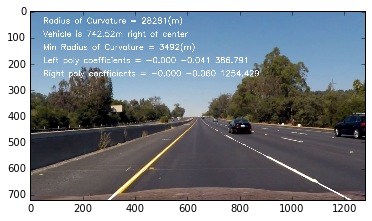

In [7]:
output = 'project_output_v3.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

Left coeffs: [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
righty[0]: , 671.0 , rightx[0]:  762
Right coeffs:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]
Left lane curve radius:  3623.88432923
Right lane curve radius:  809.921565322
Left coeffs:  [  1.39558272e-04  -2.15117466e-01   3.85597531e+02]
Right fit:  [  1.21529364e-04  -3.62144057e-01   1.30684284e+03]
[MoviePy] >>>> Building video project_output_40_45_v3.mp4
[MoviePy] Writing video project_output_40_45_v3.mp4


  1%|          | 1/126 [00:00<01:09,  1.80it/s]

Left coeffs: [  1.38610287e-04  -1.94058466e-01   3.63724820e+02]
righty[0]: , 671.0 , rightx[0]:  762
Right coeffs:  [ -2.40191609e-03   1.18793961e+00   1.08818292e+03]
Left lane curve radius:  3623.88432923
Right lane curve radius:  809.921565322
Left coeffs:  [  1.39558272e-04  -2.15117466e-01   3.85597531e+02]
Right fit:  [  1.21529364e-04  -3.62144057e-01   1.30684284e+03]


  2%|▏         | 2/126 [00:01<01:09,  1.80it/s]

Left coeffs: [  1.41425718e-04  -1.71857550e-01   3.36783363e+02]
righty[0]: , 331.0 , rightx[0]:  1196
Right coeffs:  [  3.50044800e-04  -5.59495764e-01   1.36177111e+03]
Left lane curve radius:  3540.33720653
Right lane curve radius:  1523.40653652
Left coeffs:  [  1.41425718e-04  -1.71857550e-01   3.36783363e+02]
Right fit:  [  3.50044800e-04  -5.59495764e-01   1.36177111e+03]


  2%|▏         | 3/126 [00:01<01:07,  1.82it/s]

Left coeffs: [  9.13475538e-05  -1.11124804e-01   3.08027768e+02]
righty[0]: , 359.0 , rightx[0]:  1195
Right coeffs:  [ -1.23294481e-04  -2.96394699e-01   1.33648804e+03]
Left lane curve radius:  5476.81204866
Right lane curve radius:  5172.66493929
Left coeffs:  [  9.13475538e-05  -1.11124804e-01   3.08027768e+02]
Right fit:  [ -1.23294481e-04  -2.96394699e-01   1.33648804e+03]


  3%|▎         | 4/126 [00:02<01:06,  1.84it/s]

Left coeffs: [  9.87237862e-05  -8.55138308e-02   2.80177732e+02]
righty[0]: , 701.0 , rightx[0]:  1006
Right coeffs:  [ -2.06323072e-04  -1.85780977e-01   1.31936533e+03]
Left lane curve radius:  5065.96132902
Right lane curve radius:  3003.22096232
Left coeffs:  [  9.87237862e-05  -8.55138308e-02   2.80177732e+02]
Right fit:  [ -2.06323072e-04  -1.85780977e-01   1.31936533e+03]


  4%|▍         | 5/126 [00:02<01:04,  1.87it/s]

Left coeffs: [  1.48179320e-04  -1.48320656e-01   3.00079083e+02]
righty[0]: , 657.0 , rightx[0]:  1107
Right coeffs:  [  1.62635850e-04  -4.87097145e-01   1.37814529e+03]
Left lane curve radius:  3374.29010677
Right lane curve radius:  3572.39372927
Left coeffs:  [  1.48179320e-04  -1.48320656e-01   3.00079083e+02]
Right fit:  [  1.62635850e-04  -4.87097145e-01   1.37814529e+03]


  5%|▍         | 6/126 [00:03<01:04,  1.87it/s]

Left coeffs: [  5.56475042e-05  -1.54530833e-01   3.57297508e+02]
righty[0]: , 496.0 , rightx[0]:  1135
Right coeffs:  [  2.70636431e-04  -5.42045206e-01   1.35485521e+03]
Left lane curve radius:  9117.23425701
Right lane curve radius:  2055.34892154
Left coeffs:  [  5.56475042e-05  -1.54530833e-01   3.57297508e+02]
Right fit:  [  2.70636431e-04  -5.42045206e-01   1.35485521e+03]


  6%|▌         | 7/126 [00:03<01:04,  1.85it/s]

Left coeffs: [  4.08461772e-05  -1.34699486e-01   3.50325404e+02]
righty[0]: , 529.0 , rightx[0]:  1129
Right coeffs:  [  4.42439103e-04  -7.19583686e-01   1.40447755e+03]
Left lane curve radius:  12403.1401263
Right lane curve radius:  1262.7709664
Left coeffs:  [  4.08461772e-05  -1.34699486e-01   3.50325404e+02]
Right fit:  [  4.42439103e-04  -7.19583686e-01   1.40447755e+03]


  6%|▋         | 8/126 [00:04<01:04,  1.83it/s]

Left coeffs: [  7.74465315e-05  -2.06840035e-01   3.86801427e+02]
righty[0]: , 571.0 , rightx[0]:  1106
Right coeffs:  [  7.88189397e-04  -1.06193147e+00   1.47323998e+03]
Left lane curve radius:  6618.88160832
Right lane curve radius:  706.988833537
Left coeffs:  [  7.74465315e-05  -2.06840035e-01   3.86801427e+02]
Right fit:  [  7.88189397e-04  -1.06193147e+00   1.47323998e+03]


  7%|▋         | 9/126 [00:04<01:04,  1.81it/s]

Left coeffs: [  7.78513526e-05  -1.93723031e-01   3.76211380e+02]
righty[0]: , 610.0 , rightx[0]:  1094
Right coeffs:  [  3.50460491e-04  -6.35488946e-01   1.36812083e+03]
Left lane curve radius:  6552.27419325
Right lane curve radius:  1604.03865287
Left coeffs:  [  7.78513526e-05  -1.93723031e-01   3.76211380e+02]
Right fit:  [  3.50460491e-04  -6.35488946e-01   1.36812083e+03]


  8%|▊         | 10/126 [00:05<01:02,  1.86it/s]

Left coeffs: [  7.92029157e-05  -1.76976432e-01   3.57417116e+02]
righty[0]: , 645.0 , rightx[0]:  1083
Right coeffs:  [  2.31549499e-04  -5.36696119e-01   1.34945061e+03]
Left lane curve radius:  6403.63866613
Right lane curve radius:  2467.8832946
Left coeffs:  [  7.92029157e-05  -1.76976432e-01   3.57417116e+02]
Right fit:  [  2.31549499e-04  -5.36696119e-01   1.34945061e+03]


  9%|▊         | 11/126 [00:06<01:04,  1.79it/s]

Left coeffs: [  7.63497847e-05  -1.72279663e-01   3.56116901e+02]
righty[0]: , 671.0 , rightx[0]:  1069
Right coeffs:  [  1.93583767e-04  -4.78902877e-01   1.32095606e+03]
Left lane curve radius:  6639.41309942
Right lane curve radius:  2904.58994713
Left coeffs:  [  7.63497847e-05  -1.72279663e-01   3.56116901e+02]
Right fit:  [  1.93583767e-04  -4.78902877e-01   1.32095606e+03]


 10%|▉         | 12/126 [00:06<01:02,  1.83it/s]

Left coeffs: [ -7.70655172e-06  -5.62431031e-02   3.03968014e+02]
righty[0]: , 695.0 , rightx[0]:  1039
Right coeffs:  [  1.02863806e-04  -4.08969919e-01   1.31709072e+03]
Left lane curve radius:  65278.2619863
Right lane curve radius:  5559.75045713
Left coeffs:  [ -7.70655172e-06  -5.62431031e-02   3.03968014e+02]
Right fit:  [  1.02863806e-04  -4.08969919e-01   1.31709072e+03]


 10%|█         | 13/126 [00:07<00:59,  1.89it/s]

Left coeffs: [  2.89528948e-05  -8.14563621e-02   3.01366567e+02]
righty[0]: , 700.0 , rightx[0]:  1038
Right coeffs:  [  3.59685148e-04  -6.68206071e-01   1.37107125e+03]
Left lane curve radius:  17340.8872442
Right lane curve radius:  1593.2312781
Left coeffs:  [  2.89528948e-05  -8.14563621e-02   3.01366567e+02]
Right fit:  [  3.59685148e-04  -6.68206071e-01   1.37107125e+03]


 11%|█         | 14/126 [00:07<00:57,  1.95it/s]

Left coeffs: [  2.01435401e-06  -5.17685550e-02   2.94648861e+02]
righty[0]: , 508.0 , rightx[0]:  1112
Right coeffs:  [  1.77352170e-04  -5.26917974e-01   1.34812264e+03]
Left lane curve radius:  249140.794241
Right lane curve radius:  3351.48066821
Left coeffs:  [  2.01435401e-06  -5.17685550e-02   2.94648861e+02]
Right fit:  [  1.77352170e-04  -5.26917974e-01   1.34812264e+03]


 12%|█▏        | 15/126 [00:07<00:55,  1.98it/s]

Left coeffs: [  5.24985760e-05  -8.68879246e-02   2.93888564e+02]
righty[0]: , 547.0 , rightx[0]:  1098
Right coeffs:  [  2.55567925e-04  -5.89249778e-01   1.36159201e+03]
Left lane curve radius:  9540.96798204
Right lane curve radius:  2292.11378865
Left coeffs:  [  5.24985760e-05  -8.68879246e-02   2.93888564e+02]
Right fit:  [  2.55567925e-04  -5.89249778e-01   1.36159201e+03]


 13%|█▎        | 16/126 [00:08<00:54,  2.01it/s]

Left coeffs: [  5.46464775e-05  -8.61786445e-02   2.94174145e+02]
righty[0]: , 432.0 , rightx[0]:  1135
Right coeffs:  [ -1.36796531e-04  -3.26436644e-01   1.32001084e+03]
Left lane curve radius:  9163.37001707
Right lane curve radius:  4892.56692938
Left coeffs:  [  5.46464775e-05  -8.61786445e-02   2.94174145e+02]
Right fit:  [ -1.36796531e-04  -3.26436644e-01   1.32001084e+03]


 13%|█▎        | 17/126 [00:08<00:53,  2.04it/s]

Left coeffs: [  6.44517312e-05  -9.50211338e-02   2.94648890e+02]
righty[0]: , 620.0 , rightx[0]:  1075
Right coeffs:  [  3.18816682e-04  -6.69626305e-01   1.38584623e+03]
Left lane curve radius:  7768.62034667
Right lane curve radius:  1866.54168528
Left coeffs:  [  6.44517312e-05  -9.50211338e-02   2.94648890e+02]
Right fit:  [  3.18816682e-04  -6.69626305e-01   1.38584623e+03]


 14%|█▍        | 18/126 [00:09<00:52,  2.06it/s]

Left coeffs: [  1.35480306e-04  -1.79024918e-01   3.19859387e+02]
righty[0]: , 655.0 , rightx[0]:  1055
Right coeffs:  [  3.55289583e-04  -7.24337404e-01   1.40099990e+03]
Left lane curve radius:  3701.07501598
Right lane curve radius:  1704.38452837
Left coeffs:  [  1.35480306e-04  -1.79024918e-01   3.19859387e+02]
Right fit:  [  3.55289583e-04  -7.24337404e-01   1.40099990e+03]


 15%|█▌        | 19/126 [00:09<00:52,  2.05it/s]

Left coeffs: [  9.46684581e-05  -1.45003560e-01   3.13075251e+02]
righty[0]: , 552.0 , rightx[0]:  1096
Right coeffs:  [  4.86321997e-04  -8.61590957e-01   1.43940131e+03]
Left lane curve radius:  5301.67523722
Right lane curve radius:  1252.78244368
Left coeffs:  [  9.46684581e-05  -1.45003560e-01   3.13075251e+02]
Right fit:  [  4.86321997e-04  -8.61590957e-01   1.43940131e+03]


 16%|█▌        | 20/126 [00:10<00:51,  2.07it/s]

Left coeffs: [  7.54872136e-05  -1.15352903e-01   3.00509421e+02]
righty[0]: , 583.0 , rightx[0]:  1089
Right coeffs:  [  7.76817868e-04  -1.19791212e+00   1.54090191e+03]
Left lane curve radius:  6639.43474264
Right lane curve radius:  822.228990445
Left coeffs:  [  7.54872136e-05  -1.15352903e-01   3.00509421e+02]
Right fit:  [  7.76817868e-04  -1.19791212e+00   1.54090191e+03]


 17%|█▋        | 21/126 [00:10<00:50,  2.08it/s]

Left coeffs: [  6.42704585e-05  -1.28775774e-01   3.17913542e+02]
righty[0]: , 624.0 , rightx[0]:  1073
Right coeffs:  [  4.14703535e-04  -8.09014525e-01   1.43232888e+03]
Left lane curve radius:  7828.23022223
Right lane curve radius:  1497.53357625
Left coeffs:  [  6.42704585e-05  -1.28775774e-01   3.17913542e+02]
Right fit:  [  4.14703535e-04  -8.09014525e-01   1.43232888e+03]


 17%|█▋        | 22/126 [00:11<00:50,  2.07it/s]

Left coeffs: [  6.87671289e-05  -1.14900565e-01   3.03687107e+02]
righty[0]: , 658.0 , rightx[0]:  1064
Right coeffs:  [  5.81291831e-04  -1.04669220e+00   1.51776063e+03]
Left lane curve radius:  7294.14005401
Right lane curve radius:  1154.240124
Left coeffs:  [  6.87671289e-05  -1.14900565e-01   3.03687107e+02]
Right fit:  [  5.81291831e-04  -1.04669220e+00   1.51776063e+03]


 18%|█▊        | 23/126 [00:11<00:49,  2.07it/s]

Left coeffs: [  6.37363099e-05  -1.03738134e-01   2.90973525e+02]
righty[0]: , 697.0 , rightx[0]:  1054
Right coeffs:  [  7.45399301e-05  -4.43250018e-01   1.34123607e+03]
Left lane curve radius:  7863.65872971
Right lane curve radius:  8121.16249161
Left coeffs:  [  6.37363099e-05  -1.03738134e-01   2.90973525e+02]
Right fit:  [  7.45399301e-05  -4.43250018e-01   1.34123607e+03]


 19%|█▉        | 24/126 [00:12<00:49,  2.05it/s]

Left coeffs: [  2.85112349e-05  -5.92392789e-02   2.73418323e+02]
righty[0]: , 707.0 , rightx[0]:  1054
Right coeffs:  [  3.68951482e-05  -4.09155134e-01   1.33714958e+03]
Left lane curve radius:  17561.7902328
Right lane curve radius:  16464.3518587
Left coeffs:  [  2.85112349e-05  -5.92392789e-02   2.73418323e+02]
Right fit:  [  3.68951482e-05  -4.09155134e-01   1.33714958e+03]


 20%|█▉        | 25/126 [00:12<00:49,  2.05it/s]

Left coeffs: [  6.04812039e-05  -7.66956783e-02   2.67889740e+02]
righty[0]: , 707.0 , rightx[0]:  1057
Right coeffs:  [  4.23844894e-05  -4.18430532e-01   1.34342066e+03]
Left lane curve radius:  8270.29163591
Right lane curve radius:  14385.5316226
Left coeffs:  [  6.04812039e-05  -7.66956783e-02   2.67889740e+02]
Right fit:  [  4.23844894e-05  -4.18430532e-01   1.34342066e+03]


 21%|██        | 26/126 [00:13<00:49,  2.04it/s]

Left coeffs: [  1.09368170e-04  -1.55915171e-01   3.02089418e+02]
righty[0]: , 545.0 , rightx[0]:  1106
Right coeffs:  [  1.62279602e-04  -4.81246149e-01   1.33601950e+03]
Left lane curve radius:  4586.57985617
Right lane curve radius:  3563.07156112
Left coeffs:  [  1.09368170e-04  -1.55915171e-01   3.02089418e+02]
Right fit:  [  1.62279602e-04  -4.81246149e-01   1.33601950e+03]


 21%|██▏       | 27/126 [00:13<00:49,  2.00it/s]

Left coeffs: [  1.74851026e-04  -2.48250709e-01   3.34985791e+02]
righty[0]: , 432.0 , rightx[0]:  1132
Right coeffs:  [ -2.31310523e-04  -1.84770067e-01   1.27260137e+03]
Left lane curve radius:  2882.71727139
Right lane curve radius:  2746.56555831
Left coeffs:  [  1.74851026e-04  -2.48250709e-01   3.34985791e+02]
Right fit:  [ -2.31310523e-04  -1.84770067e-01   1.27260137e+03]


 22%|██▏       | 28/126 [00:14<00:50,  1.95it/s]

Left coeffs: [  1.84273773e-04  -2.83409919e-01   3.55867863e+02]
righty[0]: , 622.0 , rightx[0]:  1076
Right coeffs:  [  1.30214708e-04  -4.30029225e-01   1.30619863e+03]
Left lane curve radius:  2753.4524005
Right lane curve radius:  4369.01175108
Left coeffs:  [  1.84273773e-04  -2.83409919e-01   3.55867863e+02]
Right fit:  [  1.30214708e-04  -4.30029225e-01   1.30619863e+03]


 23%|██▎       | 29/126 [00:14<00:48,  2.01it/s]

Left coeffs: [  1.19453455e-04  -2.08190017e-01   3.36594511e+02]
righty[0]: , 658.0 , rightx[0]:  1064
Right coeffs:  [  3.14756804e-04  -6.13476623e-01   1.34878963e+03]
Left lane curve radius:  4235.26670879
Right lane curve radius:  1805.8279922
Left coeffs:  [  1.19453455e-04  -2.08190017e-01   3.36594511e+02]
Right fit:  [  3.14756804e-04  -6.13476623e-01   1.34878963e+03]


 24%|██▍       | 30/126 [00:15<00:47,  2.01it/s]

Left coeffs: [  1.65022849e-04  -2.37307402e-01   3.34439704e+02]
righty[0]: , 549.0 , rightx[0]:  1093
Right coeffs:  [  2.52130847e-04  -5.60394405e-01   1.34014295e+03]
Left lane curve radius:  3053.66141678
Right lane curve radius:  2272.37979139
Left coeffs:  [  1.65022849e-04  -2.37307402e-01   3.34439704e+02]
Right fit:  [  2.52130847e-04  -5.60394405e-01   1.34014295e+03]


 25%|██▍       | 31/126 [00:15<00:46,  2.03it/s]

Left coeffs: [  2.35489280e-04  -3.50635939e-01   3.77322116e+02]
righty[0]: , 589.0 , rightx[0]:  1077
Right coeffs:  [  7.84928401e-05  -3.75673930e-01   1.28725889e+03]
Left lane curve radius:  2165.60580963
Right lane curve radius:  7232.24019363
Left coeffs:  [  2.35489280e-04  -3.50635939e-01   3.77322116e+02]
Right fit:  [  7.84928401e-05  -3.75673930e-01   1.28725889e+03]


 25%|██▌       | 32/126 [00:16<00:46,  2.04it/s]

Left coeffs: [  2.54383476e-05  -1.70785917e-01   3.44858408e+02]
righty[0]: , 623.0 , rightx[0]:  1067
Right coeffs:  [  6.89456654e-05  -3.70227115e-01   1.28692170e+03]
Left lane curve radius:  20281.4991694
Right lane curve radius:  8261.58014269
Left coeffs:  [  2.54383476e-05  -1.70785917e-01   3.44858408e+02]
Right fit:  [  6.89456654e-05  -3.70227115e-01   1.28692170e+03]


 26%|██▌       | 33/126 [00:16<00:45,  2.04it/s]

Left coeffs: [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
righty[0]: , 656.0 , rightx[0]:  1063
Right coeffs:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]
Left lane curve radius:  1222.48019274
Right lane curve radius:  42721.5175423
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 27%|██▋       | 34/126 [00:17<00:45,  2.01it/s]

Left coeffs: [  6.96864334e-04  -8.51633948e-01   5.10277124e+02]
righty[0]: , 690.0 , rightx[0]:  1050
Right coeffs:  [ -1.12690473e-03   6.78161216e-01   1.10733613e+03]
Left lane curve radius:  743.433631157
Right lane curve radius:  584.249539247
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 28%|██▊       | 35/126 [00:17<00:46,  1.97it/s]

Left coeffs: [  7.61482725e-04  -8.70975639e-01   5.02157008e+02]
righty[0]: , 707.0 , rightx[0]:  1049
Right coeffs:  [ -8.58128348e-04   5.11020352e-01   1.11107265e+03]
Left lane curve radius:  668.456949068
Right lane curve radius:  691.076653732
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 29%|██▊       | 36/126 [00:18<00:45,  1.97it/s]

Left coeffs: [  2.85888760e-03  -3.06879787e+00   1.06427467e+03]
righty[0]: , 707.0 , rightx[0]:  1047
Right coeffs:  [ -4.95456453e-04   2.71268052e-01   1.11322217e+03]
Left lane curve radius:  186.578911762
Right lane curve radius:  1086.20056813
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 29%|██▉       | 37/126 [00:18<00:46,  1.91it/s]

Left coeffs: [  6.81335099e-03  -6.50901796e+00   1.79540172e+03]
righty[0]: , 304.0 , rightx[0]:  1012
Right coeffs:  [  1.94244148e-03  -1.02947410e+00   1.25433179e+03]
Left lane curve radius:  83.8131419179
Right lane curve radius:  639.067579225
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 30%|███       | 38/126 [00:19<00:45,  1.92it/s]

Left coeffs: [  8.00775038e-05  -5.35170024e-01   5.49812529e+02]
righty[0]: , 304.0 , rightx[0]:  1009
Right coeffs:  [  2.87511908e-03  -1.78304011e+00   1.37781060e+03]
Left lane curve radius:  8280.93390253
Right lane curve radius:  564.630219205
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 31%|███       | 39/126 [00:19<00:46,  1.89it/s]

Left coeffs: [ -3.26422546e-03   2.22350506e+00   1.82352380e+02]
righty[0]: , 646.0 , rightx[0]:  1055
Right coeffs:  [ -6.84362285e-03   5.84319149e+00  -8.58097637e+01]
Left lane curve radius:  460.526587326
Right lane curve radius:  206.78066807
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 32%|███▏      | 40/126 [00:20<00:46,  1.84it/s]

Left coeffs: [ -2.75755952e-03   1.93384010e+00   2.16299668e+02]
righty[0]: , 619.0 , rightx[0]:  843
Right coeffs:  [ -1.01090932e-02   8.36826317e+00  -5.36894105e+02]
Left lane curve radius:  394.30514174
Right lane curve radius:  400.216002227
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 33%|███▎      | 41/126 [00:21<00:46,  1.83it/s]

Left coeffs: [ -3.14231115e-03   2.18936339e+00   1.53383321e+02]
righty[0]: , 653.0 , rightx[0]:  834
Right coeffs:  [ -3.27116108e-03   2.48327464e+00   6.77709162e+02]
Left lane curve radius:  419.397403953
Right lane curve radius:  315.39017901
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 33%|███▎      | 42/126 [00:21<00:46,  1.82it/s]

Left coeffs: [ -5.11232471e-03   4.26521336e+00  -2.97320562e+02]
righty[0]: , 693.0 , rightx[0]:  731
Right coeffs:  [ -7.92059998e-03   7.67002748e+00  -6.73344908e+02]
Left lane curve radius:  220.157623297
Right lane curve radius:  69.1641455735
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 34%|███▍      | 43/126 [00:22<00:46,  1.80it/s]

Left coeffs: [ -5.30718041e-03   4.38761127e+00  -3.13500652e+02]
righty[0]: , 527.0 , rightx[0]:  944
Right coeffs:  [ -3.85208133e-04  -3.60735765e-02   1.25915546e+03]
Left lane curve radius:  236.219170951
Right lane curve radius:  1658.45584302
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 35%|███▍      | 44/126 [00:22<00:45,  1.82it/s]

Left coeffs: [ -5.34587392e-03   4.56524170e+00  -3.61714207e+02]
righty[0]: , 527.0 , rightx[0]:  1096
Right coeffs:  [  1.53753752e-03  -1.29969363e+00   1.41183853e+03]
Left lane curve radius:  190.959772935
Right lane curve radius:  353.176272311
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 36%|███▌      | 45/126 [00:23<00:45,  1.78it/s]

Left coeffs: [ -4.42550289e-03   4.26429751e+00  -3.83832829e+02]
righty[0]: , 530.0 , rightx[0]:  1096
Right coeffs:  [ -2.68455319e-03   3.20447716e+00   2.22803084e+02]
Left lane curve radius:  117.414105191
Right lane curve radius:  266.666325058
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 37%|███▋      | 46/126 [00:23<00:45,  1.78it/s]

Left coeffs: [ -2.36725322e-03   2.77191702e+00  -2.28238570e+02]
righty[0]: , 639.0 , rightx[0]:  756
Right coeffs:  [ -1.67444411e-03   1.07849322e+00   1.06869829e+03]
Left lane curve radius:  265.165118569
Right lane curve radius:  471.068416214
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 37%|███▋      | 47/126 [00:24<00:44,  1.77it/s]

Left coeffs: [ -2.38432652e-03   2.61415186e+00  -1.54720060e+02]
righty[0]: , 528.0 , rightx[0]:  1095
Right coeffs:  [  1.83562923e-03  -1.78457783e+00   1.55013097e+03]
Left lane curve radius:  226.534979494
Right lane curve radius:  273.451712841
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 38%|███▊      | 48/126 [00:25<00:43,  1.80it/s]

Left coeffs: [ -2.37612228e-03   2.71714307e+00  -2.23955002e+02]
righty[0]: , 557.0 , rightx[0]:  1095
Right coeffs:  [  2.20863900e-03  -2.26730102e+00   1.67648461e+03]
Left lane curve radius:  248.181720805
Right lane curve radius:  227.553322276
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 39%|███▉      | 49/126 [00:25<00:42,  1.80it/s]

Left coeffs: [  9.84565793e-04  -3.31179645e-01   3.01563420e+02]
righty[0]: , 573.0 , rightx[0]:  1054
Right coeffs:  [  1.21361681e-02  -1.23937283e+01   3.92706600e+03]
Left lane curve radius:  865.608899708
Right lane curve radius:  45.3659813372
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 40%|███▉      | 50/126 [00:26<00:41,  1.82it/s]

Left coeffs: [  1.53307579e-03  -7.84923800e-01   3.62307858e+02]
righty[0]: , 603.0 , rightx[0]:  1066
Right coeffs:  [  1.06568996e-03  -1.31470699e+00   1.52760327e+03]
Left lane curve radius:  635.303287399
Right lane curve radius:  513.489680314
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 40%|████      | 51/126 [00:26<00:40,  1.85it/s]

Left coeffs: [  2.27947664e-03  -1.49297175e+00   5.03767538e+02]
righty[0]: , 654.0 , rightx[0]:  755
Right coeffs:  [ -2.07599276e-04  -7.03319273e-01   1.49694607e+03]
Left lane curve radius:  451.689620518
Right lane curve radius:  5961.28453069
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 41%|████▏     | 52/126 [00:27<00:39,  1.85it/s]

Left coeffs: [  2.90911295e-03  -2.00777357e+00   5.87452156e+02]
righty[0]: , 676.0 , rightx[0]:  752
Right coeffs:  [ -3.48922332e-03   2.98599799e+00   5.17006908e+02]
Left lane curve radius:  419.367777355
Right lane curve radius:  201.043662469
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 42%|████▏     | 53/126 [00:27<00:39,  1.86it/s]

Left coeffs: [  4.72196455e-04  -5.03145685e-01   3.88726430e+02]
righty[0]: , 680.0 , rightx[0]:  815
Right coeffs:  [ -3.71478877e-03   3.25492938e+00   4.42975240e+02]
Left lane curve radius:  1060.40305512
Right lane curve radius:  179.475523692
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 43%|████▎     | 54/126 [00:28<00:38,  1.87it/s]

Left coeffs: [  3.16923218e-04  -4.70305398e-01   4.27147996e+02]
righty[0]: , 713.0 , rightx[0]:  824
Right coeffs:  [ -2.51578050e-03   1.86449168e+00   8.50341666e+02]
Left lane curve radius:  1633.66997048
Right lane curve radius:  337.787262237
Left coeffs:  [ -4.19737679e-04   2.87756513e-01   2.29263762e+02]
Right fit:  [  1.35953374e-05  -3.37693196e-01   1.29155432e+03]


 44%|████▎     | 55/126 [00:28<00:37,  1.92it/s]

Left coeffs: [  9.13254591e-05  -3.34051431e-01   4.27693715e+02]
righty[0]: , 647.0 , rightx[0]:  1058
Right coeffs:  [  1.23405423e-04  -4.92545978e-01   1.34150662e+03]
Left lane curve radius:  5965.8227062
Right lane curve radius:  4907.44070638
Left coeffs:  [  9.13254591e-05  -3.34051431e-01   4.27693715e+02]
Right fit:  [  1.23405423e-04  -4.92545978e-01   1.34150662e+03]


 44%|████▍     | 56/126 [00:29<00:37,  1.89it/s]

Left coeffs: [  7.09277866e-05  -3.31156285e-01   4.39681067e+02]
righty[0]: , 688.0 , rightx[0]:  1046
Right coeffs:  [  9.06572658e-05  -4.48903686e-01   1.32690197e+03]
Left lane curve radius:  7777.48129034
Right lane curve radius:  6610.39865155
Left coeffs:  [  7.09277866e-05  -3.31156285e-01   4.39681067e+02]
Right fit:  [  9.06572658e-05  -4.48903686e-01   1.32690197e+03]


 45%|████▌     | 57/126 [00:29<00:37,  1.85it/s]

Left coeffs: [  5.57891696e-05  -3.31939388e-01   4.53474457e+02]
righty[0]: , 703.0 , rightx[0]:  1043
Right coeffs:  [  2.23078006e-04  -5.55211608e-01   1.33796583e+03]
Left lane curve radius:  10006.801088
Right lane curve radius:  2622.29307609
Left coeffs:  [  5.57891696e-05  -3.31939388e-01   4.53474457e+02]
Right fit:  [  2.23078006e-04  -5.55211608e-01   1.33796583e+03]


 46%|████▌     | 58/126 [00:30<00:37,  1.82it/s]

Left coeffs: [  3.46519035e-05  -3.13191210e-01   4.54439740e+02]
righty[0]: , 707.0 , rightx[0]:  1042
Right coeffs:  [  2.39511716e-04  -5.73469061e-01   1.34295177e+03]
Left lane curve radius:  16140.6008495
Right lane curve radius:  2446.37801458
Left coeffs:  [  3.46519035e-05  -3.13191210e-01   4.54439740e+02]
Right fit:  [  2.39511716e-04  -5.73469061e-01   1.34295177e+03]


 47%|████▋     | 59/126 [00:30<00:36,  1.82it/s]

Left coeffs: [ -1.48351137e-05  -2.76279425e-01   4.60387432e+02]
righty[0]: , 545.0 , rightx[0]:  1083
Right coeffs:  [  2.62095920e-04  -5.68970369e-01   1.33292522e+03]
Left lane curve radius:  38077.8323328
Right lane curve radius:  2183.42407906
Left coeffs:  [ -1.48351137e-05  -2.76279425e-01   4.60387432e+02]
Right fit:  [  2.62095920e-04  -5.68970369e-01   1.33292522e+03]


 48%|████▊     | 60/126 [00:31<00:36,  1.80it/s]

Left coeffs: [  5.00160856e-05  -3.40434892e-01   4.85266711e+02]
righty[0]: , 435.0 , rightx[0]:  1110
Right coeffs:  [  1.92085432e-04  -4.65854844e-01   1.29926527e+03]
Left lane curve radius:  11287.8277855
Right lane curve radius:  2901.06716873
Left coeffs:  [  5.00160856e-05  -3.40434892e-01   4.85266711e+02]
Right fit:  [  1.92085432e-04  -4.65854844e-01   1.29926527e+03]


 48%|████▊     | 61/126 [00:32<00:36,  1.76it/s]

Left coeffs: [  5.11239624e-05  -3.51372189e-01   5.01344142e+02]
righty[0]: , 613.0 , rightx[0]:  1059
Right coeffs:  [  1.51933386e-04  -4.53124023e-01   1.29367247e+03]
Left lane curve radius:  11132.0279186
Right lane curve radius:  3748.73028085
Left coeffs:  [  5.11239624e-05  -3.51372189e-01   5.01344142e+02]
Right fit:  [  1.51933386e-04  -4.53124023e-01   1.29367247e+03]


 49%|████▉     | 62/126 [00:32<00:35,  1.82it/s]

Left coeffs: [  5.19036123e-05  -3.34322504e-01   4.95492108e+02]
righty[0]: , 648.0 , rightx[0]:  1053
Right coeffs:  [  4.02175972e-05  -3.36855980e-01   1.26696657e+03]
Left lane curve radius:  10808.4528414
Right lane curve radius:  14108.9219787
Left coeffs:  [  5.19036123e-05  -3.34322504e-01   4.95492108e+02]
Right fit:  [  4.02175972e-05  -3.36855980e-01   1.26696657e+03]


 50%|█████     | 63/126 [00:33<00:33,  1.87it/s]

Left coeffs: [  8.97220933e-05  -3.18735285e-01   4.67015287e+02]
righty[0]: , 537.0 , rightx[0]:  1091
Right coeffs:  [  1.57892427e-04  -4.79674048e-01   1.32274791e+03]
Left lane curve radius:  6016.87493413
Right lane curve radius:  3671.07143765
Left coeffs:  [  8.97220933e-05  -3.18735285e-01   4.67015287e+02]
Right fit:  [  1.57892427e-04  -4.79674048e-01   1.32274791e+03]


 51%|█████     | 64/126 [00:33<00:32,  1.92it/s]

Left coeffs: [  9.28207012e-05  -2.95618775e-01   4.50045573e+02]
righty[0]: , 563.0 , rightx[0]:  1090
Right coeffs:  [  1.42302669e-04  -4.88072438e-01   1.33787812e+03]
Left lane curve radius:  5722.43357265
Right lane curve radius:  4162.23041664
Left coeffs:  [  9.28207012e-05  -2.95618775e-01   4.50045573e+02]
Right fit:  [  1.42302669e-04  -4.88072438e-01   1.33787812e+03]


 52%|█████▏    | 65/126 [00:34<00:31,  1.93it/s]

Left coeffs: [  8.50848559e-05  -2.55601708e-01   4.23647481e+02]
righty[0]: , 589.0 , rightx[0]:  1087
Right coeffs:  [  1.57907570e-04  -5.32699772e-01   1.36627599e+03]
Left lane curve radius:  6134.63756111
Right lane curve radius:  3856.49163235
Left coeffs:  [  8.50848559e-05  -2.55601708e-01   4.23647481e+02]
Right fit:  [  1.57907570e-04  -5.32699772e-01   1.36627599e+03]


 52%|█████▏    | 66/126 [00:34<00:31,  1.93it/s]

Left coeffs: [  9.16050326e-05  -2.44252182e-01   4.11126325e+02]
righty[0]: , 623.0 , rightx[0]:  1081
Right coeffs:  [  4.42538027e-04  -8.73172159e-01   1.47324128e+03]
Left lane curve radius:  5650.09650043
Right lane curve radius:  1458.28341946
Left coeffs:  [  9.16050326e-05  -2.44252182e-01   4.11126325e+02]
Right fit:  [  4.42538027e-04  -8.73172159e-01   1.47324128e+03]


 53%|█████▎    | 67/126 [00:35<00:30,  1.94it/s]

Left coeffs: [  9.48555887e-05  -2.53223029e-01   4.17864145e+02]
righty[0]: , 667.0 , rightx[0]:  1070
Right coeffs:  [  1.37529154e-04  -5.08853039e-01   1.36400587e+03]
Left lane curve radius:  5470.71231769
Right lane curve radius:  4412.86604839
Left coeffs:  [  9.48555887e-05  -2.53223029e-01   4.17864145e+02]
Right fit:  [  1.37529154e-04  -5.08853039e-01   1.36400587e+03]


 54%|█████▍    | 68/126 [00:35<00:30,  1.93it/s]

Left coeffs: [  8.90524349e-05  -2.41089109e-01   4.13331854e+02]
righty[0]: , 702.0 , rightx[0]:  1060
Right coeffs:  [  1.53849184e-04  -5.31780240e-01   1.37395946e+03]
Left lane curve radius:  5810.4662036
Right lane curve radius:  3970.52859122
Left coeffs:  [  8.90524349e-05  -2.41089109e-01   4.13331854e+02]
Right fit:  [  1.53849184e-04  -5.31780240e-01   1.37395946e+03]


 55%|█████▍    | 69/126 [00:36<00:29,  1.95it/s]

Left coeffs: [  9.87000669e-05  -2.64254164e-01   4.27153152e+02]
righty[0]: , 699.0 , rightx[0]:  1061
Right coeffs:  [  2.36652427e-05  -3.75650990e-01   1.32708841e+03]
Left lane curve radius:  5275.54185152
Right lane curve radius:  25173.6999822
Left coeffs:  [  9.87000669e-05  -2.64254164e-01   4.27153152e+02]
Right fit:  [  2.36652427e-05  -3.75650990e-01   1.32708841e+03]


 56%|█████▌    | 70/126 [00:36<00:28,  1.95it/s]

Left coeffs: [  9.53823104e-05  -2.68386081e-01   4.32070582e+02]
righty[0]: , 707.0 , rightx[0]:  1061
Right coeffs:  [  1.68341242e-04  -5.12081174e-01   1.35415060e+03]
Left lane curve radius:  5479.15923196
Right lane curve radius:  3511.8320722
Left coeffs:  [  9.53823104e-05  -2.68386081e-01   4.32070582e+02]
Right fit:  [  1.68341242e-04  -5.12081174e-01   1.35415060e+03]


 56%|█████▋    | 71/126 [00:37<00:28,  1.95it/s]

Left coeffs: [  8.62578041e-05  -2.48774793e-01   4.21798539e+02]
righty[0]: , 545.0 , rightx[0]:  1112
Right coeffs:  [  1.72887429e-04  -5.25787891e-01   1.36332904e+03]
Left lane curve radius:  6027.73349582
Right lane curve radius:  3448.80164698
Left coeffs:  [  8.62578041e-05  -2.48774793e-01   4.21798539e+02]
Right fit:  [  1.72887429e-04  -5.25787891e-01   1.36332904e+03]


 57%|█████▋    | 72/126 [00:37<00:27,  1.94it/s]

Left coeffs: [  7.19379928e-05  -2.46589168e-01   4.28549584e+02]
righty[0]: , 422.0 , rightx[0]:  1147
Right coeffs:  [  1.16042499e-03  -1.26616356e+00   1.50006470e+03]
Left lane curve radius:  7270.85693832
Right lane curve radius:  438.122999677
Left coeffs:  [  8.62578041e-05  -2.48774793e-01   4.21798539e+02]
Right fit:  [  1.72887429e-04  -5.25787891e-01   1.36332904e+03]


 58%|█████▊    | 73/126 [00:38<00:27,  1.92it/s]

Left coeffs: [  5.28199561e-05  -2.23228007e-01   4.21753933e+02]
righty[0]: , 617.0 , rightx[0]:  1092
Right coeffs:  [  3.46125510e-04  -6.86626529e-01   1.40138374e+03]
Left lane curve radius:  9881.42684305
Right lane curve radius:  1702.93555713
Left coeffs:  [  5.28199561e-05  -2.23228007e-01   4.21753933e+02]
Right fit:  [  3.46125510e-04  -6.86626529e-01   1.40138374e+03]


 59%|█████▊    | 74/126 [00:38<00:27,  1.92it/s]

Left coeffs: [  3.29669483e-05  -2.10477908e-01   4.23476182e+02]
righty[0]: , 653.0 , rightx[0]:  1081
Right coeffs:  [  2.10097872e-04  -5.69569242e-01   1.37849632e+03]
Left lane curve radius:  15889.180908
Right lane curve radius:  2855.72247749
Left coeffs:  [  3.29669483e-05  -2.10477908e-01   4.23476182e+02]
Right fit:  [  2.10097872e-04  -5.69569242e-01   1.37849632e+03]


 60%|█████▉    | 75/126 [00:39<00:26,  1.94it/s]

Left coeffs: [  2.94564698e-05  -2.10159031e-01   4.27815467e+02]
righty[0]: , 537.0 , rightx[0]:  1112
Right coeffs:  [  5.52328111e-04  -9.06812216e-01   1.45975276e+03]
Left lane curve radius:  17812.3485868
Right lane curve radius:  1081.14294324
Left coeffs:  [  2.94564698e-05  -2.10159031e-01   4.27815467e+02]
Right fit:  [  5.52328111e-04  -9.06812216e-01   1.45975276e+03]


 60%|██████    | 76/126 [00:39<00:25,  1.95it/s]

Left coeffs: [  1.41672020e-05  -1.90884386e-01   4.22514539e+02]
righty[0]: , 574.0 , rightx[0]:  1102
Right coeffs:  [  1.38288186e-03  -1.78143200e+00   1.69251826e+03]
Left lane curve radius:  36958.8603467
Right lane curve radius:  451.046567517
Left coeffs:  [  2.94564698e-05  -2.10159031e-01   4.27815467e+02]
Right fit:  [  5.52328111e-04  -9.06812216e-01   1.45975276e+03]


 61%|██████    | 77/126 [00:40<00:25,  1.96it/s]

Left coeffs: [  1.23844881e-05  -2.04790497e-01   4.39590446e+02]
righty[0]: , 612.0 , rightx[0]:  1087
Right coeffs:  [  4.20207440e-04  -7.95552370e-01   1.43572010e+03]
Left lane curve radius:  42635.6303831
Right lane curve radius:  1450.00131587
Left coeffs:  [  1.23844881e-05  -2.04790497e-01   4.39590446e+02]
Right fit:  [  4.20207440e-04  -7.95552370e-01   1.43572010e+03]


 62%|██████▏   | 78/126 [00:40<00:25,  1.88it/s]

Left coeffs: [  1.56509687e-05  -2.03938711e-01   4.42361396e+02]
righty[0]: , 646.0 , rightx[0]:  1078
Right coeffs:  [  9.79608014e-04  -1.46793531e+00   1.63711198e+03]
Left lane curve radius:  33660.7595721
Right lane curve radius:  703.46503797
Left coeffs:  [  1.56509687e-05  -2.03938711e-01   4.42361396e+02]
Right fit:  [  9.79608014e-04  -1.46793531e+00   1.63711198e+03]


 63%|██████▎   | 79/126 [00:41<00:25,  1.87it/s]

Left coeffs: [  4.54962155e-05  -2.26221109e-01   4.44854950e+02]
righty[0]: , 681.0 , rightx[0]:  1071
Right coeffs:  [  3.78802746e-04  -7.80654746e-01   1.44432225e+03]
Left lane curve radius:  11532.7188083
Right lane curve radius:  1652.25589992
Left coeffs:  [  4.54962155e-05  -2.26221109e-01   4.44854950e+02]
Right fit:  [  3.78802746e-04  -7.80654746e-01   1.44432225e+03]


 63%|██████▎   | 80/126 [00:41<00:24,  1.88it/s]

Left coeffs: [  7.44793597e-05  -2.40613776e-01   4.45156686e+02]
righty[0]: , 706.0 , rightx[0]:  1068
Right coeffs:  [  6.00326634e-04  -1.08491353e+00   1.54965950e+03]
Left lane curve radius:  6993.1142209
Right lane curve radius:  1142.85261835
Left coeffs:  [  7.44793597e-05  -2.40613776e-01   4.45156686e+02]
Right fit:  [  6.00326634e-04  -1.08491353e+00   1.54965950e+03]


 64%|██████▍   | 81/126 [00:42<00:23,  1.90it/s]

Left coeffs: [  8.29610555e-05  -2.31380848e-01   4.32807543e+02]
righty[0]: , 706.0 , rightx[0]:  1070
Right coeffs:  [ -1.34712682e-04  -2.69348526e-01   1.33836369e+03]
Left lane curve radius:  6227.16256689
Right lane curve radius:  4656.71620542
Left coeffs:  [  8.29610555e-05  -2.31380848e-01   4.32807543e+02]
Right fit:  [ -1.34712682e-04  -2.69348526e-01   1.33836369e+03]


 65%|██████▌   | 82/126 [00:42<00:22,  1.93it/s]

Left coeffs: [  1.13531714e-04  -2.61942409e-01   4.41879540e+02]
righty[0]: , 515.0 , rightx[0]:  1141
Right coeffs:  [ -2.77335037e-04  -1.72407249e-01   1.32189413e+03]
Left lane curve radius:  4550.35788343
Right lane curve radius:  2376.66113301
Left coeffs:  [  1.13531714e-04  -2.61942409e-01   4.41879540e+02]
Right fit:  [ -2.77335037e-04  -1.72407249e-01   1.32189413e+03]


 66%|██████▌   | 83/126 [00:43<00:22,  1.95it/s]

Left coeffs: [  1.10008210e-04  -2.57472211e-01   4.41172399e+02]
righty[0]: , 395.0 , rightx[0]:  1180
Right coeffs:  [ -1.03400795e-03   2.62264628e-01   1.26267354e+03]
Left lane curve radius:  4694.17301006
Right lane curve radius:  974.601710236
Left coeffs:  [  1.10008210e-04  -2.57472211e-01   4.41172399e+02]
Right fit:  [ -1.03400795e-03   2.62264628e-01   1.26267354e+03]


 67%|██████▋   | 84/126 [00:43<00:21,  1.97it/s]

Left coeffs: [  1.19282783e-04  -2.60076049e-01   4.38043074e+02]
righty[0]: , 432.0 , rightx[0]:  1169
Right coeffs:  [ -8.31092042e-05  -3.53945000e-01   1.36567444e+03]
Left lane curve radius:  4316.97250507
Right lane curve radius:  7819.83303985
Left coeffs:  [  1.19282783e-04  -2.60076049e-01   4.38043074e+02]
Right fit:  [ -8.31092042e-05  -3.53945000e-01   1.36567444e+03]


 67%|██████▋   | 85/126 [00:44<00:20,  1.99it/s]

Left coeffs: [  1.15702809e-04  -2.63703336e-01   4.42819089e+02]
righty[0]: , 626.0 , rightx[0]:  1105
Right coeffs:  [  2.03215101e-04  -5.89028888e-01   1.41078406e+03]
Left lane curve radius:  4464.1764238
Right lane curve radius:  3029.77454872
Left coeffs:  [  1.15702809e-04  -2.63703336e-01   4.42819089e+02]
Right fit:  [  2.03215101e-04  -5.89028888e-01   1.41078406e+03]


 68%|██████▊   | 86/126 [00:44<00:20,  1.99it/s]

Left coeffs: [  9.73137803e-05  -2.31939108e-01   4.26873241e+02]
righty[0]: , 508.0 , rightx[0]:  1147
Right coeffs:  [  2.98537802e-04  -6.93610735e-01   1.44438034e+03]
Left lane curve radius:  5278.33146924
Right lane curve radius:  2081.87180212
Left coeffs:  [  9.73137803e-05  -2.31939108e-01   4.26873241e+02]
Right fit:  [  2.98537802e-04  -6.93610735e-01   1.44438034e+03]


 69%|██████▉   | 87/126 [00:45<00:19,  2.00it/s]

Left coeffs: [  1.03759830e-04  -2.48026976e-01   4.35772375e+02]
righty[0]: , 549.0 , rightx[0]:  1129
Right coeffs:  [  4.06587398e-04  -7.98692879e-01   1.46690413e+03]
Left lane curve radius:  4970.04185088
Right lane curve radius:  1523.98889571
Left coeffs:  [  1.03759830e-04  -2.48026976e-01   4.35772375e+02]
Right fit:  [  4.06587398e-04  -7.98692879e-01   1.46690413e+03]


 70%|██████▉   | 88/126 [00:45<00:19,  2.00it/s]

Left coeffs: [  9.28039527e-05  -2.45237183e-01   4.40043123e+02]
righty[0]: , 581.0 , rightx[0]:  1116
Right coeffs:  [  7.72022248e-04  -1.19754953e+00   1.57308124e+03]
Left lane curve radius:  5576.57024543
Right lane curve radius:  831.295744273
Left coeffs:  [  9.28039527e-05  -2.45237183e-01   4.40043123e+02]
Right fit:  [  7.72022248e-04  -1.19754953e+00   1.57308124e+03]


 71%|███████   | 89/126 [00:46<00:18,  2.00it/s]

Left coeffs: [  8.54070206e-05  -2.38943726e-01   4.39274508e+02]
righty[0]: , 623.0 , rightx[0]:  1102
Right coeffs:  [  4.81795591e-04  -9.12372891e-01   1.50368586e+03]
Left lane curve radius:  6062.54528413
Right lane curve radius:  1339.37693386
Left coeffs:  [  8.54070206e-05  -2.38943726e-01   4.39274508e+02]
Right fit:  [  4.81795591e-04  -9.12372891e-01   1.50368586e+03]


 71%|███████▏  | 90/126 [00:46<00:18,  1.97it/s]

Left coeffs: [  7.79940663e-05  -2.44518009e-01   4.48328156e+02]
righty[0]: , 660.0 , rightx[0]:  1088
Right coeffs:  [  9.18072472e-05  -4.53747655e-01   1.36536636e+03]
Left lane curve radius:  6679.24130759
Right lane curve radius:  6550.6959317
Left coeffs:  [  7.79940663e-05  -2.44518009e-01   4.48328156e+02]
Right fit:  [  9.18072472e-05  -4.53747655e-01   1.36536636e+03]


 72%|███████▏  | 91/126 [00:47<00:18,  1.91it/s]

Left coeffs: [  7.98779640e-05  -2.30809823e-01   4.37762293e+02]
righty[0]: , 695.0 , rightx[0]:  1078
Right coeffs:  [  5.37300322e-05  -4.00053503e-01   1.34793535e+03]
Left lane curve radius:  6474.65496608
Right lane curve radius:  11029.2252583
Left coeffs:  [  7.98779640e-05  -2.30809823e-01   4.37762293e+02]
Right fit:  [  5.37300322e-05  -4.00053503e-01   1.34793535e+03]


 73%|███████▎  | 92/126 [00:48<00:17,  1.90it/s]

Left coeffs: [  9.50841324e-05  -2.40958877e-01   4.37542508e+02]
righty[0]: , 708.0 , rightx[0]:  1079
Right coeffs:  [ -1.10451089e-04  -2.54093905e-01   1.32467940e+03]
Left lane curve radius:  5427.23766912
Right lane curve radius:  5458.62639848
Left coeffs:  [  9.50841324e-05  -2.40958877e-01   4.37542508e+02]
Right fit:  [ -1.10451089e-04  -2.54093905e-01   1.32467940e+03]


 74%|███████▍  | 93/126 [00:48<00:17,  1.92it/s]

Left coeffs: [  9.51399687e-05  -2.32855054e-01   4.33244891e+02]
righty[0]: , 708.0 , rightx[0]:  1080
Right coeffs:  [ -5.82896855e-05  -2.94591102e-01   1.33077397e+03]
Left lane curve radius:  5405.6283629
Right lane curve radius:  10228.9693674
Left coeffs:  [  9.51399687e-05  -2.32855054e-01   4.33244891e+02]
Right fit:  [ -5.82896855e-05  -2.94591102e-01   1.33077397e+03]


 75%|███████▍  | 94/126 [00:49<00:16,  1.94it/s]

Left coeffs: [  1.09752507e-04  -2.35422865e-01   4.28137267e+02]
righty[0]: , 534.0 , rightx[0]:  1132
Right coeffs:  [ -9.44739536e-05  -3.01365383e-01   1.33976064e+03]
Left lane curve radius:  4664.05220197
Right lane curve radius:  6583.89200863
Left coeffs:  [  1.09752507e-04  -2.35422865e-01   4.28137267e+02]
Right fit:  [ -9.44739536e-05  -3.01365383e-01   1.33976064e+03]


 75%|███████▌  | 95/126 [00:49<00:16,  1.90it/s]

Left coeffs: [  1.43113076e-04  -2.81907853e-01   4.47103060e+02]
righty[0]: , 422.0 , rightx[0]:  1159
Right coeffs:  [  9.94358481e-04  -1.10910946e+00   1.47795060e+03]
Left lane curve radius:  3595.18058923
Right lane curve radius:  512.801258145
Left coeffs:  [  1.43113076e-04  -2.81907853e-01   4.47103060e+02]
Right fit:  [  9.94358481e-04  -1.10910946e+00   1.47795060e+03]


 76%|███████▌  | 96/126 [00:50<00:15,  1.91it/s]

Left coeffs: [  1.40121243e-04  -2.82620476e-01   4.50021535e+02]
righty[0]: , 612.0 , rightx[0]:  1101
Right coeffs:  [  2.69856752e-04  -6.10341189e-01   1.39148270e+03]
Left lane curve radius:  3677.57641141
Right lane curve radius:  2184.19768013
Left coeffs:  [  1.40121243e-04  -2.82620476e-01   4.50021535e+02]
Right fit:  [  2.69856752e-04  -6.10341189e-01   1.39148270e+03]


 77%|███████▋  | 97/126 [00:50<00:14,  1.93it/s]

Left coeffs: [  1.41304191e-04  -2.90308525e-01   4.55292469e+02]
righty[0]: , 654.0 , rightx[0]:  1090
Right coeffs:  [  1.52780211e-04  -4.95139479e-01   1.36321337e+03]
Left lane curve radius:  3656.96023262
Right lane curve radius:  3864.60439144
Left coeffs:  [  1.41304191e-04  -2.90308525e-01   4.55292469e+02]
Right fit:  [  1.52780211e-04  -4.95139479e-01   1.36321337e+03]


 78%|███████▊  | 98/126 [00:51<00:14,  1.96it/s]

Left coeffs: [  1.15842740e-04  -2.73772345e-01   4.55828619e+02]
righty[0]: , 537.0 , rightx[0]:  1117
Right coeffs:  [  9.22239726e-04  -1.22383517e+00   1.53344630e+03]
Left lane curve radius:  4478.67928976
Right lane curve radius:  617.78776945
Left coeffs:  [  1.15842740e-04  -2.73772345e-01   4.55828619e+02]
Right fit:  [  9.22239726e-04  -1.22383517e+00   1.53344630e+03]


 79%|███████▊  | 99/126 [00:51<00:13,  1.98it/s]

Left coeffs: [  8.26447123e-05  -2.43707248e-01   4.49942621e+02]
righty[0]: , 572.0 , rightx[0]:  1109
Right coeffs:  [  2.37089547e-04  -5.86343138e-01   1.38904667e+03]
Left lane curve radius:  6286.92964722
Right lane curve radius:  2506.30632885
Left coeffs:  [  8.26447123e-05  -2.43707248e-01   4.49942621e+02]
Right fit:  [  2.37089547e-04  -5.86343138e-01   1.38904667e+03]


 79%|███████▉  | 100/126 [00:52<00:13,  1.99it/s]

Left coeffs: [  5.57657046e-05  -2.21404126e-01   4.49307268e+02]
righty[0]: , 606.0 , rightx[0]:  1099
Right coeffs:  [  3.03551801e-04  -6.70106488e-01   1.41429992e+03]
Left lane curve radius:  9337.59500673
Right lane curve radius:  1990.05412849
Left coeffs:  [  5.57657046e-05  -2.21404126e-01   4.49307268e+02]
Right fit:  [  3.03551801e-04  -6.70106488e-01   1.41429992e+03]


 80%|████████  | 101/126 [00:52<00:12,  2.00it/s]

Left coeffs: [  2.84019194e-05  -2.03825193e-01   4.50652180e+02]
righty[0]: , 643.0 , rightx[0]:  1090
Right coeffs:  [  7.76974471e-04  -1.23426884e+00   1.58324316e+03]
Left lane curve radius:  18423.2849747
Right lane curve radius:  855.591295928
Left coeffs:  [  2.84019194e-05  -2.03825193e-01   4.50652180e+02]
Right fit:  [  7.76974471e-04  -1.23426884e+00   1.58324316e+03]


 81%|████████  | 102/126 [00:53<00:12,  1.95it/s]

Left coeffs: [  1.63767810e-06  -1.55272287e-01   4.26719612e+02]
righty[0]: , 674.0 , rightx[0]:  1089
Right coeffs:  [  2.23695291e-04  -6.10102560e-01   1.41766364e+03]
Left lane curve radius:  316183.471966
Right lane curve radius:  2754.03381422
Left coeffs:  [  1.63767810e-06  -1.55272287e-01   4.26719612e+02]
Right fit:  [  2.23695291e-04  -6.10102560e-01   1.41766364e+03]


 82%|████████▏ | 103/126 [00:53<00:12,  1.88it/s]

Left coeffs: [  1.28165210e-06  -1.57109775e-01   4.32391987e+02]
righty[0]: , 708.0 , rightx[0]:  1081
Right coeffs:  [  2.37310317e-04  -6.31363716e-01   1.42568299e+03]
Left lane curve radius:  404417.013845
Right lane curve radius:  2616.27375904
Left coeffs:  [  1.28165210e-06  -1.57109775e-01   4.32391987e+02]
Right fit:  [  2.37310317e-04  -6.31363716e-01   1.42568299e+03]


 83%|████████▎ | 104/126 [00:54<00:11,  1.86it/s]

Left coeffs: [ -2.32927261e-05  -1.27691184e-01   4.24095476e+02]
righty[0]: , 706.0 , rightx[0]:  1085
Right coeffs:  [  3.97852954e-04  -8.81029799e-01   1.52340254e+03]
Left lane curve radius:  22204.1066675
Right lane curve radius:  1721.61068895
Left coeffs:  [ -2.32927261e-05  -1.27691184e-01   4.24095476e+02]
Right fit:  [  3.97852954e-04  -8.81029799e-01   1.52340254e+03]


 83%|████████▎ | 105/126 [00:54<00:11,  1.85it/s]

Left coeffs: [ -1.70163921e-05  -1.26136008e-01   4.22788579e+02]
righty[0]: , 515.0 , rightx[0]:  1150
Right coeffs:  [  9.62106908e-02  -9.97062032e+01   2.69997645e+04]
Left lane curve radius:  30291.2584469
Right lane curve radius:  249.761336135
Left coeffs:  [ -2.32927261e-05  -1.27691184e-01   4.24095476e+02]
Right fit:  [  3.97852954e-04  -8.81029799e-01   1.52340254e+03]


 84%|████████▍ | 106/126 [00:55<00:10,  1.84it/s]

Left coeffs: [ -5.24977502e-06  -1.44618909e-01   4.34351898e+02]
righty[0]: , 394.0 , rightx[0]:  1187
Right coeffs:  [ -4.94025064e-04  -2.69628186e-02   1.29902669e+03]
Left lane curve radius:  98468.9254627
Right lane curve radius:  1450.97145885
Left coeffs:  [ -5.24977502e-06  -1.44618909e-01   4.34351898e+02]
Right fit:  [ -4.94025064e-04  -2.69628186e-02   1.29902669e+03]


 85%|████████▍ | 107/126 [00:55<00:10,  1.81it/s]

Left coeffs: [  8.34707597e-06  -1.33906569e-01   4.20620257e+02]
righty[0]: , 422.0 , rightx[0]:  1185
Right coeffs:  [  7.56980015e-04  -9.09051758e-01   1.46298923e+03]
Left lane curve radius:  61323.3150745
Right lane curve radius:  683.563956081
Left coeffs:  [  8.34707597e-06  -1.33906569e-01   4.20620257e+02]
Right fit:  [  7.56980015e-04  -9.09051758e-01   1.46298923e+03]


 86%|████████▌ | 108/126 [00:56<00:09,  1.84it/s]

Left coeffs: [  3.39837403e-05  -1.61616323e-01   4.30709236e+02]
righty[0]: , 628.0 , rightx[0]:  1115
Right coeffs:  [  3.48172245e-05  -3.87558525e-01   1.36276402e+03]
Left lane curve radius:  15073.8904563
Right lane curve radius:  17122.7068547
Left coeffs:  [  3.39837403e-05  -1.61616323e-01   4.30709236e+02]
Right fit:  [  3.48172245e-05  -3.87558525e-01   1.36276402e+03]


 87%|████████▋ | 109/126 [00:56<00:09,  1.89it/s]

Left coeffs: [  5.86422798e-05  -1.69268116e-01   4.25232202e+02]
righty[0]: , 502.0 , rightx[0]:  1156
Right coeffs:  [  4.94314022e-04  -7.89102593e-01   1.45380631e+03]
Left lane curve radius:  8683.26714102
Right lane curve radius:  1146.17686663
Left coeffs:  [  5.86422798e-05  -1.69268116e-01   4.25232202e+02]
Right fit:  [  4.94314022e-04  -7.89102593e-01   1.45380631e+03]


 87%|████████▋ | 110/126 [00:57<00:08,  1.90it/s]

Left coeffs: [  8.80931272e-05  -1.96031441e-01   4.29998502e+02]
righty[0]: , 545.0 , rightx[0]:  1141
Right coeffs:  [  4.77181852e-04  -8.13239242e-01   1.46588349e+03]
Left lane curve radius:  5775.29062109
Right lane curve radius:  1230.2419584
Left coeffs:  [  8.80931272e-05  -1.96031441e-01   4.29998502e+02]
Right fit:  [  4.77181852e-04  -8.13239242e-01   1.46588349e+03]


 88%|████████▊ | 111/126 [00:57<00:07,  1.94it/s]

Left coeffs: [  1.14744308e-04  -2.30735920e-01   4.42876833e+02]
righty[0]: , 585.0 , rightx[0]:  1123
Right coeffs:  [  6.49044583e-05  -3.79951483e-01   1.34415337e+03]
Left lane curve radius:  4445.74910072
Right lane curve radius:  8878.56807478
Left coeffs:  [  1.14744308e-04  -2.30735920e-01   4.42876833e+02]
Right fit:  [  6.49044583e-05  -3.79951483e-01   1.34415337e+03]


 89%|████████▉ | 112/126 [00:58<00:07,  1.87it/s]

Left coeffs: [  1.16036169e-04  -2.20632836e-01   4.33111777e+02]
righty[0]: , 620.0 , rightx[0]:  1113
Right coeffs:  [  6.03293814e-04  -9.90728196e-01   1.51694202e+03]
Left lane curve radius:  4379.90804868
Right lane curve radius:  1022.22758489
Left coeffs:  [  1.16036169e-04  -2.20632836e-01   4.33111777e+02]
Right fit:  [  6.03293814e-04  -9.90728196e-01   1.51694202e+03]


 90%|████████▉ | 113/126 [00:59<00:06,  1.89it/s]

Left coeffs: [  1.37741260e-04  -2.48543002e-01   4.43014197e+02]
righty[0]: , 659.0 , rightx[0]:  1099
Right coeffs:  [  2.95461045e-06  -2.87456565e-01   1.30606456e+03]
Left lane curve radius:  3697.04744455
Right lane curve radius:  190183.562456
Left coeffs:  [  1.37741260e-04  -2.48543002e-01   4.43014197e+02]
Right fit:  [  2.95461045e-06  -2.87456565e-01   1.30606456e+03]


 90%|█████████ | 114/126 [00:59<00:06,  1.93it/s]

Left coeffs: [  1.40636924e-04  -2.51703871e-01   4.41088834e+02]
righty[0]: , 697.0 , rightx[0]:  1071
Right coeffs:  [  5.32742977e-05  -3.41318730e-01   1.31825569e+03]
Left lane curve radius:  3621.2422816
Right lane curve radius:  10577.3449241
Left coeffs:  [  1.40636924e-04  -2.51703871e-01   4.41088834e+02]
Right fit:  [  5.32742977e-05  -3.41318730e-01   1.31825569e+03]


 91%|█████████▏| 115/126 [01:00<00:05,  1.92it/s]

Left coeffs: [  1.40913832e-04  -2.44737506e-01   4.33352653e+02]
righty[0]: , 692.0 , rightx[0]:  1090
Right coeffs:  [  1.43178792e-04  -4.40101065e-01   1.34483122e+03]
Left lane curve radius:  3605.79410559
Right lane curve radius:  3963.98630042
Left coeffs:  [  1.40913832e-04  -2.44737506e-01   4.33352653e+02]
Right fit:  [  1.43178792e-04  -4.40101065e-01   1.34483122e+03]


 92%|█████████▏| 116/126 [01:00<00:05,  1.92it/s]

Left coeffs: [  1.27837819e-04  -2.53980518e-01   4.47910108e+02]
righty[0]: , 696.0 , rightx[0]:  1085
Right coeffs:  [  3.00002661e-04  -5.73709280e-01   1.35808400e+03]
Left lane curve radius:  4004.92855934
Right lane curve radius:  1857.40355814
Left coeffs:  [  1.27837819e-04  -2.53980518e-01   4.47910108e+02]
Right fit:  [  3.00002661e-04  -5.73709280e-01   1.35808400e+03]


 93%|█████████▎| 117/126 [01:01<00:04,  1.93it/s]

Left coeffs: [  9.28318276e-05  -2.28778328e-01   4.46616196e+02]
righty[0]: , 549.0 , rightx[0]:  1109
Right coeffs:  [  2.01149964e-04  -4.92840762e-01   1.33889591e+03]
Left lane curve radius:  5536.0855102
Right lane curve radius:  2809.60196753
Left coeffs:  [  9.28318276e-05  -2.28778328e-01   4.46616196e+02]
Right fit:  [  2.01149964e-04  -4.92840762e-01   1.33889591e+03]


 94%|█████████▎| 118/126 [01:01<00:04,  1.93it/s]

Left coeffs: [  7.43259116e-05  -2.13784232e-01   4.43523083e+02]
righty[0]: , 431.0 , rightx[0]:  1138
Right coeffs:  [  3.99153493e-04  -6.37574888e-01   1.36408796e+03]
Left lane curve radius:  6924.3302908
Right lane curve radius:  1360.96472392
Left coeffs:  [  7.43259116e-05  -2.13784232e-01   4.43523083e+02]
Right fit:  [  3.99153493e-04  -6.37574888e-01   1.36408796e+03]


 94%|█████████▍| 119/126 [01:02<00:03,  1.88it/s]

Left coeffs: [  5.50879663e-05  -1.91167364e-01   4.35309706e+02]
righty[0]: , 719.0 , rightx[0]:  990
Right coeffs:  [  2.28900548e-04  -5.45459450e-01   1.35717889e+03]
Left lane curve radius:  9329.66551026
Right lane curve radius:  2520.78775303
Left coeffs:  [  5.50879663e-05  -1.91167364e-01   4.35309706e+02]
Right fit:  [  2.28900548e-04  -5.45459450e-01   1.35717889e+03]


 95%|█████████▌| 120/126 [01:02<00:03,  1.84it/s]

Left coeffs: [  1.99612955e-05  -1.49636973e-01   4.20301824e+02]
righty[0]: , 650.0 , rightx[0]:  1086
Right coeffs:  [  1.80725707e-04  -4.96734866e-01   1.35073586e+03]
Left lane curve radius:  25682.9376131
Right lane curve radius:  3191.22366773
Left coeffs:  [  1.99612955e-05  -1.49636973e-01   4.20301824e+02]
Right fit:  [  1.80725707e-04  -4.96734866e-01   1.35073586e+03]


 96%|█████████▌| 121/126 [01:03<00:02,  1.84it/s]

Left coeffs: [  1.88568400e-05  -1.41484816e-01   4.13789891e+02]
righty[0]: , 540.0 , rightx[0]:  1116
Right coeffs:  [ -1.70504359e-04  -1.74890969e-01   1.28058712e+03]
Left lane curve radius:  27115.9169987
Right lane curve radius:  3472.58648291
Left coeffs:  [  1.88568400e-05  -1.41484816e-01   4.13789891e+02]
Right fit:  [ -1.70504359e-04  -1.74890969e-01   1.28058712e+03]


 97%|█████████▋| 122/126 [01:03<00:02,  1.85it/s]

Left coeffs: [  7.72618466e-06  -1.18411692e-01   4.01769180e+02]
righty[0]: , 574.0 , rightx[0]:  1109
Right coeffs:  [  2.92987010e-04  -6.34367357e-01   1.39759091e+03]
Left lane curve radius:  65907.8923364
Right lane curve radius:  2013.41538917
Left coeffs:  [  7.72618466e-06  -1.18411692e-01   4.01769180e+02]
Right fit:  [  2.92987010e-04  -6.34367357e-01   1.39759091e+03]


 98%|█████████▊| 123/126 [01:04<00:01,  1.82it/s]

Left coeffs: [  1.21333179e-05  -1.05342938e-01   3.88934035e+02]
righty[0]: , 606.0 , rightx[0]:  1104
Right coeffs:  [  3.18740933e-04  -6.82465530e-01   1.42080343e+03]
Left lane curve radius:  41747.044237
Right lane curve radius:  1890.04386906
Left coeffs:  [  1.21333179e-05  -1.05342938e-01   3.88934035e+02]
Right fit:  [  3.18740933e-04  -6.82465530e-01   1.42080343e+03]


 98%|█████████▊| 124/126 [01:04<00:01,  1.85it/s]

Left coeffs: [  4.56246897e-06  -1.06937957e-01   3.96462287e+02]
righty[0]: , 647.0 , rightx[0]:  1091
Right coeffs:  [  5.56997622e-04  -9.57978801e-01   1.49623488e+03]
Left lane curve radius:  111317.166088
Right lane curve radius:  1122.65121945
Left coeffs:  [  4.56246897e-06  -1.06937957e-01   3.96462287e+02]
Right fit:  [  5.56997622e-04  -9.57978801e-01   1.49623488e+03]


 99%|█████████▉| 125/126 [01:05<00:00,  1.89it/s]

Left coeffs: [  1.76534698e-05  -1.03637878e-01   3.87026980e+02]
righty[0]: , 682.0 , rightx[0]:  1083
Right coeffs:  [  2.63796572e-04  -6.39484853e-01   1.41446158e+03]
Left lane curve radius:  28637.7256367
Right lane curve radius:  2310.52255515
Left coeffs:  [  1.76534698e-05  -1.03637878e-01   3.87026980e+02]
Right fit:  [  2.63796572e-04  -6.39484853e-01   1.41446158e+03]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_40_45_v3.mp4 

CPU times: user 2min 41s, sys: 18.7 s, total: 3min
Wall time: 1min 6s


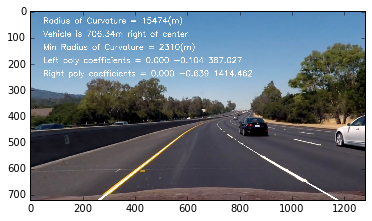

In [6]:
output = 'project_output_40_45_v3.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(40,45)
output_clip = clip1.fl_image(image_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))